In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import OrderedDict
import matplotlib.pyplot as plt
%matplotlib inline
import copy
import time
import datetime
from scipy.stats import cauchy

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from collections import OrderedDict

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Définition fonctions

## Test with Cauchy

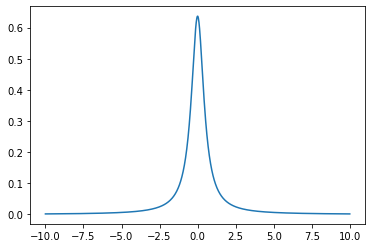

In [5]:
gamma, mu = 0.5, 0
x = np.linspace(-10, 10, 1000)
dist = cauchy(mu, gamma)
plt.plot(x, dist.pdf(x))

## Functions which work

In [6]:
#We should have cauchy(mu, gamma): mu is phase, gamma is amp
def function_cauchy(amp, phase, x):
    dist = cauchy(phase, amp)
    return dist.pdf(x)

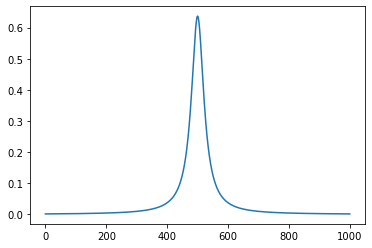

In [7]:
x = np.linspace(-10, 10, 1000)
plt.plot(function_cauchy(0.5, 0, x))

In [8]:
def function_sinus(amp, phase, x):
    return amp*np.sin(phase+x)

In [9]:
def noise(epsilon):
    return epsilon * np.random.normal(0, 1)

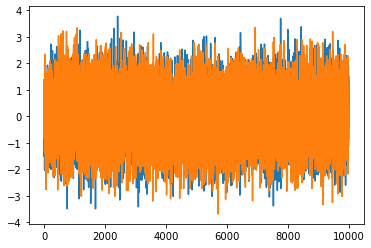

In [10]:
plt.plot(np.random.multivariate_normal(np.array([0, 0]), np.array([[1, 0], [0, 1]]), 10000))

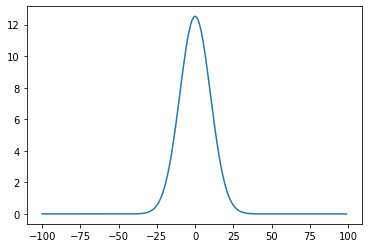

In [11]:
#sigma=phase, amp=mu
def gaussian(amp, phase, i):
    return (1/2*np.pi*amp**2)**(0.5)*(np.exp(-(i-phase)**2/2*amp**2))

x, y = [i for i in range(-100, 100)], []
for i in x:
    y.append(gaussian(10, 0, i/100))
plt.plot(x, y)

# 2D regression

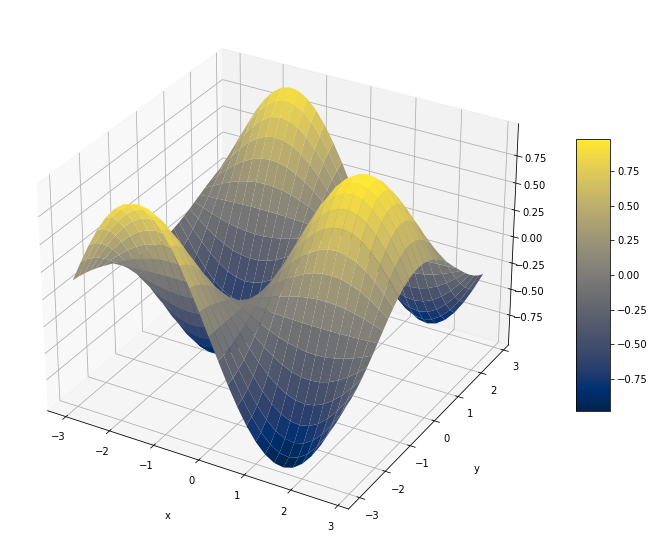

In [12]:
fig = plt.figure(figsize = (12,10))
ax = plt.axes(projection='3d')

x = np.arange(-3, 3, 0.2)
y = np.arange(-3, 3, 0.2)

X, Y = np.meshgrid(x, y)
Z = np.sin(X)*np.cos(Y)

surf = ax.plot_surface(X, Y, Z, cmap = plt.cm.cividis)

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

fig.colorbar(surf, shrink=0.5, aspect=8)

plt.show()

## Distribution de la fonction

On choisit ici la fonction que l'on utilise, c'est important !

In [13]:
function = function_sinus
epsilon = 1
#generating data
class FunctionTask():
    def __init__(self,amp,phase,min_x,max_x):
        self.phase=phase
        self.max_x=max_x
        self.min_x=min_x
        self.amp=amp  #Amplitude
    
    def sample_data(self,size=1):
        x=np.random.uniform(self.max_x,self.min_x,size)
        y=self.true_function(x) + noise(epsilon)
        x=torch.tensor(x, dtype=torch.float).unsqueeze(1)
        y=torch.tensor(y, dtype=torch.float).unsqueeze(1)
        return x,y
  
    def true_function(self,x):
        y = function(self.amp, self.phase, x)
        return y

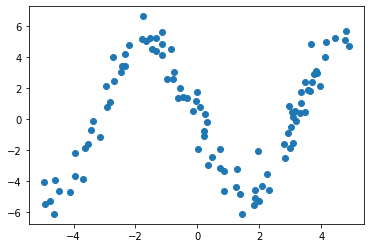

In [14]:
# For sinus: 5, np.pi, -5, 5
# Cauchy, 0, 1, -5, 5
X, Y = [], []
temp_x, temp_y = 0, 0
function_ = FunctionTask(5, np.pi, -5, 5)
for i in range(100):
    temp_x, temp_y = function_.sample_data()
    X.append(temp_x)
    Y.append(temp_y)
plt.scatter(X, Y)

In [15]:
class FunctionDistribution():
  def __init__(self,min_amp,max_amp,min_phase,max_phase,min_x,max_x):
    self.min_amp=min_amp
    self.max_phase=max_phase
    self.min_phase=min_phase
    self.max_amp=max_amp
    self.min_x=min_x  #Pas de changement par rapport à précédemment
    self.max_x=max_x  #Pas de changement par rapport à précédemment
    
  def sample_task(self):
    amp = np.random.uniform(self.min_amp, self.max_amp)
    phase = np.random.uniform(self.min_phase, self.max_phase)
    return FunctionTask(amp, phase, self.min_x, self.max_x)

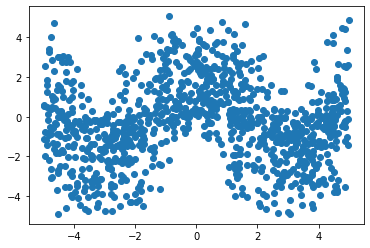

In [89]:
#Classic parameters for sinus: 0.1, 5, 0, np.pi, -5, 5
#Parameters to be close from Neural processes (still for sinus): -1, 1, 0, np.pi/3, -3, 3
# Parameters for Cauchy 0.1, 1, -1, 1, -5, 5
min_amp,max_amp,min_phase,max_phase,min_x,max_x = 0.1, 5, 0, np.pi, -5, 5
function_dist = FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
X, Y = [], []
temp_x, temp_y = 0, 0

for i in range(1000):
    temp_x, temp_y = function_dist.sample_task().sample_data()
    X.append(temp_x)
    Y.append(temp_y)
plt.scatter(X, Y)

## Algorithme du MAML

In [90]:
#defining our neural network
class FNet(nn.Module):
  def __init__(self):
    super(FNet,self).__init__()
    self.net=nn.Sequential(OrderedDict([
            ('l1',nn.Linear(1,40)),
            ('relu1',nn.ReLU()),
            ('l2',nn.Linear(40,40)),
            ('relu2',nn.ReLU()),
            ('l3',nn.Linear(40,1))
        ]))
      
  def argforward(self,x,weights): 
    x=F.linear(x,weights[0],weights[1])
    x=F.relu(x)
    x=F.linear(x,weights[2],weights[3])           
    x=F.relu(x)
    x=F.linear(x,weights[4],weights[5])
    return x

In [91]:
class FMAML():
  def __init__(self,net,alpha,beta,tasks,k,num_metatasks):
    self.net=net
    self.weights=list(net.parameters())
    self.alpha=alpha
    self.beta=beta
    self.tasks=tasks
    self.k=k 
    self.num_tasks_meta=num_metatasks #nombre de tâches que l'on utilise
    self.criterion=nn.MSELoss()  #criterion just to chose
    self.meta_optimiser=torch.optim.Adam(self.weights,self.beta)
    self.meta_losses=[]
    self.plot_every =100
    self.print_every = 1000
    self.num_metatasks=num_metatasks

  def inner_loop(self,task):
    temp_weights=[w.clone() for w in self.weights]
    x,y=task.sample_data(size=self.k) #sampling D
    x=x.to(device)
    y=y.to(device)
    output=self.net.argforward(x,temp_weights)
    loss=self.criterion(output,y)/self.k
    grads=torch.autograd.grad(loss,temp_weights)
    temp_weights=[w-self.alpha*g for w,g in zip(temp_weights,grads)] #temporary update of weights
    x,y=task.sample_data(size=self.k) #sampling D'
    x=x.to(device)
    y=y.to(device)
    output=self.net.argforward(x,temp_weights)
    metaloss=self.criterion(output,y)/self.k
    return metaloss
  
  def outer_loop(self,num_epochs):
    total_loss=0
    for epoch in range(1,num_epochs+1): #Correspond au "While not done"
      metaloss_sum=0
      for i in range(self.num_metatasks): 
        task=self.tasks.sample_task()
        metaloss=self.inner_loop(task)
        metaloss_sum+=metaloss
      metagrads=torch.autograd.grad(metaloss_sum,self.weights)
      #important step
      for w,g in zip(self.weights,metagrads):
        w.grad=g
      ###############
      self.meta_optimiser.step()
      total_loss+=metaloss_sum.item()/self.num_metatasks
      if epoch % self.print_every == 0:
        print("{}/{}. loss: {}".format(epoch, num_epochs, total_loss / self.plot_every))
      if epoch%self.plot_every==0:
        self.meta_losses.append(total_loss/self.plot_every)
        total_loss = 0

### Entraînement

In [114]:
print(min_amp,max_amp,min_phase,max_phase,min_x,max_x)

0.1 5 0 3.141592653589793 -5 5


In [115]:
function_tasks=FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
net=FNet()
net=net.to(device)
maml=FMAML(net,alpha=0.01,beta=0.001,tasks=function_tasks,k=5,num_metatasks=10)
maml.outer_loop(num_epochs=50000)

1000/50000. loss: 0.5608311066627502
2000/50000. loss: 0.511752986907959
3000/50000. loss: 0.4940310047864913
4000/50000. loss: 0.4841906510591508
5000/50000. loss: 0.4144405401945114
6000/50000. loss: 0.34979033231735224
7000/50000. loss: 0.28927998626232143
8000/50000. loss: 0.2516817438602448
9000/50000. loss: 0.22871244859695442
10000/50000. loss: 0.2046624495983124
11000/50000. loss: 0.20409802854061135
12000/50000. loss: 0.20671457159519196
13000/50000. loss: 0.20446525686979286
14000/50000. loss: 0.19984305852651596
15000/50000. loss: 0.1899956454634667
16000/50000. loss: 0.2061467353701591
17000/50000. loss: 0.18265912884473795
18000/50000. loss: 0.19540344095230097
19000/50000. loss: 0.18329576617479323
20000/50000. loss: 0.18643332129716872
21000/50000. loss: 0.17402447980642313
22000/50000. loss: 0.18119206100702276
23000/50000. loss: 0.17765213298797608
24000/50000. loss: 0.16432095283269876
25000/50000. loss: 0.1752133046388626
26000/50000. loss: 0.1759945813417435
27000/5

# RMSE evolution

In [106]:
num_iterations = 400
error_evolution = []
function_tasks=FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
net=FNet()
net=net.to(device)
maml=FMAML(net,alpha=0.01,beta=0.001,tasks=function_tasks,k=5,num_metatasks=10)

for i in range(50):

    maml.outer_loop(num_epochs=1000)
    
    global_error = 0
    count = 0

    for i in range(num_iterations):
        og_net=maml.net.net
        optim=torch.optim.SGD
        lr=0.01
    
        task=function_tasks.sample_task()
        x,y=task.sample_data(K)
        x=x.to(device)
        y=y.to(device)
        outputs,axis=test(og_net,x,y,lr,optim)
        
        error = 0
        L = []
        for i in range(len(x.numpy())):
            L.append(int((5+x.numpy()[i][0])*100))
        pred = []
        for i in range(len(x.numpy())):
            pred.append(outputs['minitrained'][L[i]][0])
        y_ = []
        for i in range(len(y.numpy())):
            y_.append(y.numpy()[i][0])
        
        error = (np.linalg.norm(np.array(y_)-np.array(pred)))
        if error < 1000 and error > -1000:
            global_error += error
            count +=1
        
    global_error = global_error/count
    error_evolution.append(global_error)
    print(global_error)

1000/1000. loss: 0.5737229707241056
[3.7362027168273926, 2.1320385932922363, 1.8209807872772217, 1.6808621883392334, 1.5716674327850342, 1.4784166812896729, 1.3967363834381104, 1.321955919265747, 1.2614986896514893, 1.2098703384399414]
[2.991971254348755, 1.3512297868728638, 1.1440842151641846, 1.0235928297042847, 0.9488958120346069, 0.8943281173706055, 0.8501197695732117, 0.8087370991706848, 0.7707127332687378, 0.7356671094894409]
[0.0680098682641983, 0.0487753264605999, 0.04321489855647087, 0.04046838358044624, 0.038545750081539154, 0.03702244162559509, 0.03569095581769943, 0.03449754789471626, 0.033423177897930145, 0.032452113926410675]
[0.6400321125984192, 0.4728066325187683, 0.41060304641723633, 0.37017545104026794, 0.33981961011886597, 0.31603649258613586, 0.29686886072158813, 0.28102970123291016, 0.2676391005516052, 0.25608426332473755]
[0.8625189661979675, 0.6567373275756836, 0.5432607531547546, 0.46261268854141235, 0.40056848526000977, 0.3515782654285431, 0.31045278906822205, 

[0.6849294900894165, 0.5243309736251831, 0.43991389870643616, 0.37513267993927, 0.32446467876434326, 0.28375327587127686, 0.25018176436424255, 0.22303935885429382, 0.20087695121765137, 0.18263189494609833]
[6.8995208740234375, 3.527047634124756, 3.104407787322998, 2.771500587463379, 2.530336856842041, 2.3674283027648926, 2.2736148834228516, 2.189882278442383, 2.1114442348480225, 2.036644697189331]
[6.9955596923828125, 4.777087211608887, 3.9299941062927246, 3.5069549083709717, 3.21040415763855, 3.009596586227417, 2.838329553604126, 2.6809070110321045, 2.5312228202819824, 2.3899097442626953]
[0.2953295409679413, 0.15510833263397217, 0.10200446844100952, 0.06900838017463684, 0.047210149466991425, 0.03291665390133858, 0.02352723851799965, 0.017352500930428505, 0.0132853789255023, 0.010574444197118282]
[0.40463417768478394, 0.261886864900589, 0.21860983967781067, 0.18832990527153015, 0.16426274180412292, 0.144521564245224, 0.1278819441795349, 0.11400221288204193, 0.10212411731481552, 0.0914

[0.24195075035095215, 0.10834288597106934, 0.08073718100786209, 0.05694900080561638, 0.04093512147665024, 0.030184071511030197, 0.02314237877726555, 0.018283726647496223, 0.014880605041980743, 0.012852589599788189]
[0.1489158272743225, 0.07337772101163864, 0.06243976205587387, 0.05864986032247543, 0.05622020363807678, 0.05435071140527725, 0.052800603210926056, 0.05144943669438362, 0.05021869018673897, 0.04883451759815216]
[0.17552271485328674, 0.09725920855998993, 0.08204514533281326, 0.07097604125738144, 0.06265304982662201, 0.056296102702617645, 0.051360122859478, 0.04749792069196701, 0.04449346661567688, 0.042075131088495255]
[5.627208232879639, 2.8850178718566895, 1.4440772533416748, 0.9736111760139465, 0.8004681468009949, 0.7229225039482117, 0.6935676336288452, 0.6541640162467957, 0.6355887651443481, 0.6140003800392151]
[3.7195651531219482, 2.685609817504883, 2.084543228149414, 1.69339120388031, 1.4155226945877075, 1.2042667865753174, 1.0382158756256104, 0.9049485325813293, 0.7986

[6.6320061683654785, 1.720000982284546, 1.277216911315918, 1.0835044384002686, 0.9783583879470825, 0.9059281349182129, 0.8501697778701782, 0.8035687208175659, 0.7601606249809265, 0.7200325727462769]
[0.43172216415405273, 0.29737168550491333, 0.24207821488380432, 0.20693247020244598, 0.18098856508731842, 0.161154642701149, 0.14553725719451904, 0.13292232155799866, 0.12253544479608536, 0.11382941156625748]
[1.417332410812378, 0.9787925481796265, 0.8007300496101379, 0.6804431676864624, 0.5924781560897827, 0.5235779881477356, 0.4732643961906433, 0.4353906512260437, 0.4020601809024811, 0.3742060959339142]
[5.15254020690918, 3.5489425659179688, 3.0014843940734863, 2.6156065464019775, 2.3044822216033936, 2.0415141582489014, 1.8291940689086914, 1.6517928838729858, 1.5048303604125977, 1.4012020826339722]
[1.1891710758209229, 0.6002262830734253, 0.5063490867614746, 0.4514800012111664, 0.4016347825527191, 0.3726823925971985, 0.3458669185638428, 0.329191118478775, 0.31323274970054626, 0.3001788854

[8.729020118713379, 6.563501834869385, 5.929490089416504, 5.519599437713623, 5.158076763153076, 4.842299938201904, 4.5447998046875, 4.273268699645996, 4.0252275466918945, 3.789808750152588]
[3.227687358856201, 1.9218658208847046, 1.5605844259262085, 1.3885924816131592, 1.2705391645431519, 1.1723699569702148, 1.0873026847839355, 1.0136983394622803, 0.9471036791801453, 0.8892509341239929]
[10.548548698425293, 7.283806800842285, 6.094333648681641, 5.523182392120361, 5.134460926055908, 4.783249378204346, 4.477110862731934, 4.18019962310791, 3.899998903274536, 3.6278233528137207]
[5.504656791687012, 4.350417613983154, 3.825157642364502, 3.4206371307373047, 3.045189380645752, 2.694028377532959, 2.362597703933716, 2.0596354007720947, 1.7849994897842407, 1.536541223526001]
[2.6292850971221924, 1.3784358501434326, 1.0082604885101318, 0.8446624875068665, 0.7592399716377258, 0.6963416337966919, 0.6493441462516785, 0.6134884357452393, 0.5827416181564331, 0.5548107028007507]
[6.684628963470459, 2.1

[4.486145496368408, 3.173234462738037, 2.5848069190979004, 2.255466938018799, 2.024003028869629, 1.8278896808624268, 1.6619879007339478, 1.5167913436889648, 1.3902130126953125, 1.2782107591629028]
[1.192938208580017, 0.800433337688446, 0.7330770492553711, 0.6893124580383301, 0.6526219248771667, 0.6201743483543396, 0.5909191966056824, 0.5655454397201538, 0.5421367883682251, 0.5206062197685242]
[9.781502723693848, 5.026791572570801, 4.130613803863525, 3.601902484893799, 3.185509443283081, 2.8190951347351074, 2.4874367713928223, 2.202603578567505, 1.9459784030914307, 1.7140915393829346]
[1.4590809345245361, 0.8391599655151367, 0.6935938596725464, 0.6208661794662476, 0.569686233997345, 0.5289502143859863, 0.5026978254318237, 0.4801800847053528, 0.4602230191230774, 0.4423409104347229]
[0.3547188639640808, 0.2699626088142395, 0.21239280700683594, 0.17061784863471985, 0.14026615023612976, 0.11788849532604218, 0.10123217105865479, 0.0887005552649498, 0.07910194247961044, 0.07181514799594879]
[

[2.494910955429077, 1.9759966135025024, 1.5440822839736938, 1.2472803592681885, 1.032895565032959, 0.8770996332168579, 0.7526271939277649, 0.6553219556808472, 0.5767796635627747, 0.5106494426727295]
[4.780857086181641, 3.684417724609375, 3.136831283569336, 2.751255512237549, 2.4610657691955566, 2.209251880645752, 1.9937947988510132, 1.808387041091919, 1.642835259437561, 1.4972004890441895]
[0.6135491728782654, 0.4557704031467438, 0.387428879737854, 0.34753257036209106, 0.31814056634902954, 0.2943846583366394, 0.2739367187023163, 0.2566590905189514, 0.24154046177864075, 0.2281971275806427]
[3.8197505474090576, 2.9570679664611816, 2.4582598209381104, 2.1248250007629395, 1.8835117816925049, 1.709027886390686, 1.5660837888717651, 1.438301682472229, 1.321509599685669, 1.222391963005066]
[3.872875690460205, 2.500706195831299, 1.9033790826797485, 1.5226640701293945, 1.2357213497161865, 1.0355340242385864, 0.8963443040847778, 0.7856947183609009, 0.6957398653030396, 0.6263720989227295]
[0.75701

[1.3596011400222778, 0.58976149559021, 0.36832600831985474, 0.3225986063480377, 0.30404552817344666, 0.2917996346950531, 0.28264719247817993, 0.2748757004737854, 0.2678556442260742, 0.26138901710510254]
[3.6152377128601074, 1.8706659078598022, 1.593740701675415, 1.411819577217102, 1.2680312395095825, 1.1480165719985962, 1.0399723052978516, 0.9491384625434875, 0.8626090884208679, 0.7835996747016907]
[8.400598526000977, 4.670982837677002, 3.673316478729248, 3.100959300994873, 2.7263073921203613, 2.4597055912017822, 2.24578595161438, 2.051204204559326, 1.8864238262176514, 1.7396032810211182]
[7.92547607421875, 5.222277641296387, 3.546079635620117, 2.8942954540252686, 2.468593120574951, 2.145796298980713, 1.8819700479507446, 1.6702098846435547, 1.5197670459747314, 1.5046027898788452]
[4.647872447967529, 3.0199713706970215, 1.9498176574707031, 1.641920804977417, 1.4304660558700562, 1.2821546792984009, 1.1639528274536133, 1.0656516551971436, 0.9934221506118774, 0.9270132780075073]
[6.5806603

[0.42731428146362305, 0.13822920620441437, 0.09751439839601517, 0.07315511256456375, 0.05581526830792427, 0.04291700944304466, 0.033043235540390015, 0.025755196809768677, 0.020364010706543922, 0.016366267576813698]
[3.1266818046569824, 2.071636199951172, 1.769740104675293, 1.578735113143921, 1.4148950576782227, 1.2684648036956787, 1.14182448387146, 1.0243979692459106, 0.9228366017341614, 0.8346086740493774]
[4.145069122314453, 1.9633004665374756, 1.5646333694458008, 1.4036427736282349, 1.3167732954025269, 1.2656842470169067, 1.2161874771118164, 1.1783205270767212, 1.1396558284759521, 1.1068131923675537]
[0.1750151365995407, 0.1385839283466339, 0.11063210666179657, 0.08790552616119385, 0.07064689695835114, 0.05788077786564827, 0.048097990453243256, 0.040632136166095734, 0.034676384180784225, 0.030047452077269554]
[1.719143271446228, 0.9503718614578247, 0.6601146459579468, 0.517357349395752, 0.4376608729362488, 0.38740065693855286, 0.35182878375053406, 0.32534438371658325, 0.304685533046

[2.1982192993164062, 1.321664571762085, 1.0605924129486084, 0.928320586681366, 0.8561981320381165, 0.801224410533905, 0.752602219581604, 0.7077571749687195, 0.6660632491111755, 0.6275749206542969]
[1.5659476518630981, 0.9423881769180298, 0.6417137980461121, 0.5531424880027771, 0.49724000692367554, 0.4590679705142975, 0.42771387100219727, 0.3997403085231781, 0.37365978956222534, 0.3494305908679962]
[8.658207893371582, 4.371598243713379, 3.440186023712158, 2.9509310722351074, 2.583625316619873, 2.3508269786834717, 2.2843270301818848, 2.55110502243042, 3.393023729324341, 4.743290424346924]
[1.1291850805282593, 0.9314020276069641, 0.8050557374954224, 0.7109267115592957, 0.6252869367599487, 0.5500739812850952, 0.4878213405609131, 0.4337852895259857, 0.38725632429122925, 0.34498706459999084]
[6.3332061767578125, 3.7956137657165527, 3.0745346546173096, 2.6821534633636475, 2.4134469032287598, 2.201786518096924, 2.0264580249786377, 1.8818963766098022, 1.767474889755249, 1.6372934579849243]
[5.4

[15.70311450958252, 15.404947280883789, 10.47736930847168, 6.059276580810547, 5.378396034240723, 6.548571586608887, 7.80810022354126, 15.009778022766113, 8.53108024597168, 5.255271911621094]
[1.299761414527893, 2.0137789249420166, 1.4537150859832764, 0.9299322366714478, 0.7155179381370544, 0.5951128602027893, 0.5383983850479126, 0.507365345954895, 0.48593443632125854, 0.4644485414028168]
[3.524399518966675, 2.647979259490967, 1.6189864873886108, 1.26936936378479, 1.041832447052002, 0.8857440948486328, 0.7654033899307251, 0.6729446649551392, 0.6045316457748413, 0.5462759137153625]
[6.3897881507873535, 5.0747175216674805, 4.645678520202637, 4.858475685119629, 6.918801307678223, 10.592305183410645, 7.754838466644287, 6.8972015380859375, 3.9914989471435547, 3.561774492263794]
[0.9173978567123413, 1.5906691551208496, 1.089511752128601, 1.0609222650527954, 0.3182511031627655, 0.15409629046916962, 0.12784582376480103, 0.11866158246994019, 0.11372355371713638, 0.10874837636947632]
[4.791609764

[0.6118178367614746, 0.3771110773086548, 0.3853197693824768, 0.48526033759117126, 0.6855663657188416, 0.8258358836174011, 0.9068300127983093, 0.39271026849746704, 0.21519842743873596, 0.08904491364955902]
[1.2111518383026123, 0.8061956167221069, 0.6761296391487122, 0.5924302339553833, 0.530234694480896, 0.4781076908111572, 0.43905848264694214, 0.40917229652404785, 0.3834019899368286, 0.3610549867153168]
[1.0236384868621826, 0.6614708304405212, 0.5252420902252197, 0.42985349893569946, 0.37080857157707214, 0.32860028743743896, 0.29506915807724, 0.26766160130500793, 0.24442505836486816, 0.22467389702796936]
[5.891175270080566, 3.362929105758667, 2.8134636878967285, 2.408416748046875, 2.0981762409210205, 1.9146658182144165, 2.2943098545074463, 5.4695587158203125, 15.269828796386719, 9.382936477661133]
[0.9808119535446167, 0.8955221176147461, 0.8012235760688782, 0.8023084402084351, 0.7023305892944336, 0.7324134707450867, 0.5564777851104736, 0.564005970954895, 0.4638966917991638, 0.434463798

[0.9600673913955688, 0.5131546258926392, 0.34097355604171753, 0.2682339549064636, 0.23562748730182648, 0.21767966449260712, 0.2065577507019043, 0.19746991991996765, 0.1899169385433197, 0.18346352875232697]
[1.0984834432601929, 2.107945680618286, 3.668654680252075, 4.561349391937256, 2.14070200920105, 0.6014036536216736, 0.21523141860961914, 0.16798998415470123, 0.14662408828735352, 0.13074137270450592]
[6.809323310852051, 5.424432754516602, 10.285149574279785, 13.358080863952637, 5.675741195678711, 2.1712708473205566, 1.7295122146606445, 1.427337408065796, 1.2212613821029663, 1.0531829595565796]
[0.687467098236084, 1.1193735599517822, 1.7899528741836548, 2.8921306133270264, 1.635420799255371, 0.7633932828903198, 0.14484187960624695, 0.05336381867527962, 0.03978379815816879, 0.033389315009117126]
[5.730489730834961, 4.158993244171143, 2.829841375350952, 2.161855697631836, 1.8267030715942383, 1.5972888469696045, 1.4041966199874878, 1.2477668523788452, 1.1268978118896484, 1.03102922439575

[0.5637025237083435, 0.3045876920223236, 0.2248912751674652, 0.19941678643226624, 0.1835470199584961, 0.17077170312404633, 0.15961311757564545, 0.14958012104034424, 0.1404588669538498, 0.1321253478527069]
[3.9451584815979004, 2.8023924827575684, 2.244412660598755, 1.8451353311538696, 1.5688971281051636, 1.3451659679412842, 1.1898866891860962, 1.0912203788757324, 1.0509393215179443, 1.0993163585662842]
[0.5729018449783325, 0.21177831292152405, 0.15704216063022614, 0.17990660667419434, 0.25500601530075073, 0.4069150388240814, 0.5482926964759827, 0.8118290901184082, 0.6306670904159546, 0.5654447078704834]
[0.20400889217853546, 0.11005717515945435, 0.0725858062505722, 0.049237191677093506, 0.03395429998636246, 0.023868296295404434, 0.017106901854276657, 0.012517216615378857, 0.009645692072808743, 0.007762453518807888]
[0.6282986998558044, 0.49473652243614197, 0.4739709496498108, 0.3932691216468811, 0.3972927927970886, 0.3252792954444885, 0.30959823727607727, 0.24617008864879608, 0.21253523

[6.856072902679443, 3.8243165016174316, 3.0620474815368652, 2.612180233001709, 2.2987513542175293, 2.0447332859039307, 1.8516803979873657, 1.6963818073272705, 1.5738070011138916, 1.4627742767333984]
[0.9781254529953003, 0.5271905660629272, 0.3547283709049225, 0.2619172930717468, 0.2097771167755127, 0.17699798941612244, 0.154143288731575, 0.1374443769454956, 0.12466742843389511, 0.11478762328624725]
[4.962973594665527, 2.8896613121032715, 2.383166551589966, 2.0911641120910645, 1.790450096130371, 1.6276744604110718, 1.496608018875122, 1.5079697370529175, 1.7252155542373657, 2.4028117656707764]
[0.2824334502220154, 0.328256219625473, 1.4239437580108643, 5.801413536071777, 4.805558681488037, 0.8180516958236694, 0.30063098669052124, 0.2580476701259613, 0.21939173340797424, 0.18977881968021393]
[0.0947151854634285, 0.0577346570789814, 0.03899695351719856, 0.02731991931796074, 0.019704405218362808, 0.014562842436134815, 0.010998575016856194, 0.008469058200716972, 0.006636966951191425, 0.00528

[5.020950794219971, 3.410118818283081, 3.052377223968506, 2.8192684650421143, 2.622279405593872, 2.4376769065856934, 2.2730867862701416, 2.1479811668395996, 1.993038535118103, 1.924319863319397]
[4.528405666351318, 4.286013603210449, 3.386265993118286, 2.031132221221924, 1.3583850860595703, 1.0020325183868408, 0.8249996900558472, 0.7418596148490906, 0.687141478061676, 0.6483564972877502]
[2.0003623962402344, 1.4001671075820923, 1.110882043838501, 0.9761406779289246, 0.8753010630607605, 0.7954702973365784, 0.7259281277656555, 0.6657470464706421, 0.6128018498420715, 0.5645712018013]
[4.842380523681641, 6.674935817718506, 6.5860276222229, 6.298592567443848, 2.445302963256836, 1.6887493133544922, 1.334343671798706, 1.0628454685211182, 0.8528105020523071, 0.6869971752166748]
[0.504338264465332, 0.4084935784339905, 0.35267162322998047, 0.2975974977016449, 0.2626957297325134, 0.22583767771720886, 0.200788214802742, 0.17454560101032257, 0.15646407008171082, 0.14055880904197693]
[6.790209770202

[0.753679633140564, 0.4271491467952728, 0.29997384548187256, 0.2337763011455536, 0.19614294171333313, 0.17290964722633362, 0.15735886991024017, 0.1461842954158783, 0.13731175661087036, 0.12985630333423615]
[2.650451898574829, 1.5276697874069214, 1.0174163579940796, 0.7404102087020874, 0.580506443977356, 0.48195046186447144, 0.4333285689353943, 0.45020395517349243, 0.5614839792251587, 0.7707667350769043]
[1.2826184034347534, 0.6080118417739868, 0.4596242904663086, 0.39974695444107056, 0.3614984452724457, 0.33655551075935364, 0.3134976923465729, 0.2964366674423218, 0.28151631355285645, 0.2681807577610016]
[0.10329355299472809, 0.0655093863606453, 0.05891958624124527, 0.05936524271965027, 0.06455718725919724, 0.07241332530975342, 0.08631885796785355, 0.10497219860553741, 0.13649877905845642, 0.17475710809230804]
[10.224725723266602, 7.282110691070557, 6.021320819854736, 6.4409003257751465, 6.380537986755371, 7.949082851409912, 5.006175518035889, 5.139278411865234, 3.792336940765381, 3.499

[3.777521848678589, 4.029414653778076, 5.05855655670166, 3.2061569690704346, 1.478492021560669, 1.0331580638885498, 0.8493649363517761, 0.7338155508041382, 0.6422708630561829, 0.5649369359016418]
[5.837915420532227, 2.5920989513397217, 2.191009759902954, 1.8943191766738892, 1.6422522068023682, 1.4304678440093994, 1.2395787239074707, 1.0583534240722656, 0.9131048917770386, 0.8027029037475586]
[2.803558111190796, 2.115156650543213, 2.955010175704956, 9.770857810974121, 9.646162033081055, 5.876383304595947, 3.11848521232605, 2.5840189456939697, 2.311776638031006, 2.13576078414917]
[4.749756813049316, 2.57235050201416, 1.9580094814300537, 1.6144511699676514, 1.3575613498687744, 1.1697089672088623, 1.0148670673370361, 0.8997529149055481, 0.789716362953186, 0.7107215523719788]
[4.8873090744018555, 2.49566388130188, 1.8856357336044312, 1.7148635387420654, 1.8585249185562134, 3.0660462379455566, 7.408448696136475, 7.091017246246338, 6.319535732269287, 2.6848511695861816]
[0.9684775471687317, 0

[0.9984935522079468, 0.5366401672363281, 0.34257155656814575, 0.27160781621932983, 0.21406753361225128, 0.18166634440422058, 0.15871070325374603, 0.143459752202034, 0.13200940191745758, 0.12345734983682632]
[0.6083683967590332, 0.37453940510749817, 0.3379380404949188, 0.3112035393714905, 0.28811246156692505, 0.2675061821937561, 0.2488679140806198, 0.23189468681812286, 0.21648938953876495, 0.20245742797851562]
[2.3882148265838623, 2.0651450157165527, 1.239845633506775, 1.0678373575210571, 0.6330298781394958, 0.4793803095817566, 0.37127166986465454, 0.3248744010925293, 0.2986961007118225, 0.2802392244338989]
[1.2365448474884033, 0.9276692271232605, 1.1231025457382202, 2.336055040359497, 0.6945770382881165, 0.5781363248825073, 0.45560383796691895, 0.4016721248626709, 0.3785589039325714, 0.4828066825866699]
[1.4943424463272095, 1.4810547828674316, 0.7499572038650513, 0.7320930361747742, 0.6233828067779541, 0.6297925710678101, 0.5523923635482788, 0.5719732046127319, 0.5002016425132751, 0.53

[4.748119831085205, 2.7225635051727295, 2.3356175422668457, 2.025643825531006, 1.7567718029022217, 1.5215541124343872, 1.3193385601043701, 1.1443133354187012, 0.9948511123657227, 0.8739593625068665]
[1.5427124500274658, 0.8969724774360657, 0.7004300355911255, 0.5824176073074341, 0.5070045590400696, 0.4544141888618469, 0.415546178817749, 0.3836109936237335, 0.35711565613746643, 0.3335551619529724]
[2.6333162784576416, 2.09421968460083, 1.7772729396820068, 1.5281462669372559, 1.3218697309494019, 1.1472548246383667, 0.9984102249145508, 0.873735785484314, 0.7658742666244507, 0.6724627017974854]
[1.4685819149017334, 0.9556440114974976, 0.8184909820556641, 0.6972250938415527, 0.59337317943573, 0.5020618438720703, 0.42374125123023987, 0.3549894392490387, 0.29760104417800903, 0.24824316799640656]
[2.553318500518799, 1.7985327243804932, 1.0650973320007324, 0.9148338437080383, 0.8278430700302124, 0.7810841202735901, 0.7484562397003174, 0.7236367464065552, 0.7026370763778687, 0.6833722591400146]


[0.6147967576980591, 0.6095992922782898, 2.8247647285461426, 6.982761383056641, 2.215745449066162, 0.5455049276351929, 0.42808470129966736, 0.38317063450813293, 0.36272916197776794, 0.3484763503074646]
[8.907461166381836, 103.1070556640625, 11.043529510498047, 8.811422348022461, 8.424712181091309, 8.239377975463867, 8.072893142700195, 7.897355556488037, 7.6986541748046875, 7.462004661560059]
[4.650547027587891, 3.0646440982818604, 2.6622424125671387, 2.7419469356536865, 2.5660128593444824, 2.7810840606689453, 2.5755443572998047, 2.8491175174713135, 2.561603307723999, 2.8017163276672363]
[3.8417441844940186, 4.3334879875183105, 2.7411866188049316, 1.913525938987732, 1.7484853267669678, 1.6469062566757202, 1.561201572418213, 1.484641194343567, 1.4141772985458374, 1.3492871522903442]
[5.347251892089844, 1.8492530584335327, 1.8003902435302734, 1.2674076557159424, 1.1583225727081299, 1.20730459690094, 1.747060775756836, 2.1447269916534424, 3.380105972290039, 2.0885348320007324]
[4.126387596

[0.43301910161972046, 0.13894304633140564, 0.12544558942317963, 0.16451701521873474, 0.3002849817276001, 0.7917044162750244, 0.7462838888168335, 1.2010207176208496, 0.6970170736312866, 0.7128041982650757]
[2.7654964923858643, 2.1181647777557373, 2.950291395187378, 3.798717975616455, 1.5115907192230225, 1.386549711227417, 1.3256843090057373, 1.206095814704895, 1.1454799175262451, 1.1053673028945923]
[0.7379112243652344, 1.2936502695083618, 2.602729082107544, 4.276270866394043, 0.799244225025177, 0.46329426765441895, 0.365730881690979, 0.3124332129955292, 0.268666535615921, 0.23446409404277802]
[3.5984458923339844, 8.040322303771973, 22.497411727905273, 8.616153717041016, 2.3848536014556885, 1.205350637435913, 1.1065260171890259, 1.0577528476715088, 1.01254141330719, 0.9706597328186035]
[5.816684722900391, 3.5853590965270996, 2.6445629596710205, 2.235182285308838, 2.0038111209869385, 1.8097978830337524, 1.6373354196548462, 1.4889421463012695, 1.3582322597503662, 1.237179160118103]
[0.772

[1.6974033117294312, 1.4163858890533447, 0.8269502520561218, 0.6810941100120544, 0.4269999563694, 0.35235595703125, 0.25501975417137146, 0.21462848782539368, 0.17903688549995422, 0.15275540947914124]
[0.6278436779975891, 0.4948298931121826, 0.4836035668849945, 0.5470300912857056, 0.5915769338607788, 0.7373982667922974, 0.6270001530647278, 0.6972428560256958, 0.37058278918266296, 0.33486610651016235]
[16.094873428344727, 9.400732040405273, 7.015551567077637, 5.324583053588867, 4.129103660583496, 3.2870776653289795, 2.6233456134796143, 2.0954360961914062, 1.6850864887237549, 1.3695826530456543]
[0.5556073188781738, 0.7505999803543091, 2.0487422943115234, 5.093731880187988, 0.7352577447891235, 0.3544101417064667, 0.290309339761734, 0.27287426590919495, 0.25943878293037415, 0.24783563613891602]
[7.870223045349121, 5.88789176940918, 4.797196388244629, 8.998761177062988, 9.067170143127441, 4.906163215637207, 3.1332695484161377, 2.4945597648620605, 2.0618720054626465, 1.7072193622589111]
[9.1

[1.8082332611083984, 0.9776470065116882, 0.6009937524795532, 0.5058991312980652, 0.44103890657424927, 0.41081976890563965, 0.38199710845947266, 0.361123651266098, 0.3423286974430084, 0.32760679721832275]
[7.666040897369385, 4.907523155212402, 11.161733627319336, 15.714330673217773, 6.1166157722473145, 2.444063425064087, 1.7743728160858154, 1.484065294265747, 1.2931573390960693, 1.1657724380493164]
[0.11474978923797607, 0.08898423612117767, 0.07493869960308075, 0.06515809893608093, 0.05582261085510254, 0.04698500409722328, 0.040639959275722504, 0.03549046069383621, 0.03126629814505577, 0.027729203924536705]
[1.5403778553009033, 1.4240070581436157, 1.6970771551132202, 1.8100675344467163, 0.6396023631095886, 0.3084278404712677, 0.20569472014904022, 0.15404894948005676, 0.12049393355846405, 0.09640786051750183]
[2.8949921131134033, 1.8404680490493774, 1.8761932849884033, 3.0925354957580566, 3.6029372215270996, 3.854231595993042, 1.286409616470337, 0.9883467555046082, 0.7610954642295837, 0.

[0.8547431826591492, 1.0182944536209106, 1.1966307163238525, 1.4368338584899902, 0.3474327325820923, 0.22202961146831512, 0.17949500679969788, 0.157034233212471, 0.14152896404266357, 0.1296171396970749]
[4.0241193771362305, 1.8741804361343384, 1.2026350498199463, 0.9047861099243164, 0.7521811723709106, 0.6541869044303894, 0.5827495455741882, 0.5234893560409546, 0.4714413583278656, 0.42511385679244995]
[5.633892059326172, 3.255131959915161, 2.481602907180786, 2.1819167137145996, 1.9399408102035522, 1.728276252746582, 1.5401711463928223, 1.380991816520691, 1.2294209003448486, 1.0722061395645142]
[10.319314956665039, 6.218784809112549, 5.3532633781433105, 4.741140365600586, 4.346962928771973, 3.9931159019470215, 3.6727166175842285, 3.3838717937469482, 3.1255409717559814, 2.8941564559936523]
[0.24618861079216003, 0.17702451348304749, 0.15120574831962585, 0.13224169611930847, 0.11763469874858856, 0.10583236068487167, 0.09596683084964752, 0.0874062031507492, 0.07995807379484177, 0.0734079256

[1.8720401525497437, 0.9095765948295593, 0.7048825621604919, 0.5942765474319458, 0.5118759870529175, 0.4447661340236664, 0.3906489610671997, 0.3478968143463135, 0.31572604179382324, 0.28832486271858215]
[1.0434249639511108, 0.7415444850921631, 1.0378926992416382, 1.275181770324707, 1.8383241891860962, 0.5033906698226929, 0.285061776638031, 0.175136998295784, 0.14760905504226685, 0.12708069384098053]
[1.4875818490982056, 4.2705912590026855, 5.904486179351807, 0.8275432586669922, 0.581574559211731, 0.4985460340976715, 0.43505898118019104, 0.3813972771167755, 0.33683639764785767, 0.29908663034439087]
[3.4693832397460938, 5.172280311584473, 9.096794128417969, 3.1228744983673096, 2.7952253818511963, 2.6493332386016846, 2.534635543823242, 2.440682888031006, 2.358058214187622, 2.281822919845581]
[0.15826262533664703, 0.1277998983860016, 0.40229520201683044, 2.1108040809631348, 1.7771797180175781, 1.630907416343689, 0.1275641918182373, 0.10287623107433319, 0.09797744452953339, 0.09429386258125

[1.3992624282836914, 1.1706366539001465, 1.0017714500427246, 0.8725007176399231, 0.7665998935699463, 0.6778481006622314, 0.6023352742195129, 0.5372692346572876, 0.4808865189552307, 0.43195265531539917]
[0.40006160736083984, 0.3463875353336334, 0.399291068315506, 0.5571123957633972, 0.7563823461532593, 1.2493661642074585, 0.9910570979118347, 1.5397895574569702, 0.9161545038223267, 1.1192939281463623]
[6.453596591949463, 4.346917152404785, 3.4319286346435547, 2.9689226150512695, 2.644092321395874, 2.395721912384033, 2.201539993286133, 2.034168243408203, 1.884625792503357, 1.7501379251480103]
[4.103579998016357, 2.44130539894104, 1.8835417032241821, 1.60821533203125, 1.3875186443328857, 1.1977505683898926, 1.031359076499939, 0.8855775594711304, 0.7586477398872375, 0.6479053497314453]
[3.2445900440216064, 4.405552864074707, 1.7971960306167603, 1.1778205633163452, 0.6476787328720093, 0.4834500253200531, 0.3937515318393707, 0.32928842306137085, 0.28047770261764526, 0.24328510463237762]
[1.15

[5.373654842376709, 5.742889881134033, 7.0162482261657715, 4.587741851806641, 3.2856335639953613, 3.250861644744873, 2.5146522521972656, 2.8220629692077637, 2.210906505584717, 3.105865240097046]
[0.6458655595779419, 2.171377182006836, 5.695819854736328, 2.030195951461792, 1.6666576862335205, 2.6374380588531494, 0.5756200551986694, 0.5228713154792786, 0.2645561993122101, 0.2413034439086914]
[8.86423397064209, 4.689711570739746, 2.911301851272583, 2.3712849617004395, 2.2843663692474365, 2.9139809608459473, 6.181983470916748, 9.158098220825195, 9.723325729370117, 4.363081455230713]
[0.392861932516098, 0.1816001832485199, 0.13257543742656708, 0.11153244972229004, 0.1001124158501625, 0.09255211055278778, 0.08667346090078354, 0.08145541697740555, 0.07689721882343292, 0.07273733615875244]
[2.2317559719085693, 1.9103463888168335, 3.4111766815185547, 5.173343181610107, 1.59771728515625, 1.2434619665145874, 1.073279619216919, 1.0063360929489136, 0.9588869214057922, 0.9389324188232422]
[3.1070277

[1.4030905961990356, 1.4582257270812988, 2.096348524093628, 0.5762869119644165, 0.3855206370353699, 0.283403605222702, 0.2248035967350006, 0.18642014265060425, 0.162064328789711, 0.1449097990989685]
[4.698277950286865, 4.59672212600708, 3.125617027282715, 2.61132550239563, 2.2459328174591064, 2.045640468597412, 1.963387131690979, 2.10373592376709, 3.7356116771698, 5.109890460968018]
[2.2915611267089844, 1.0172866582870483, 0.690585732460022, 0.5100793838500977, 0.49087586998939514, 0.4398285746574402, 0.5281359553337097, 0.5294831991195679, 0.687780499458313, 0.6974166035652161]
[5.875374794006348, 4.209742546081543, 4.550064563751221, 6.4111328125, 8.410028457641602, 3.697605848312378, 3.124913454055786, 2.796401262283325, 2.5372087955474854, 2.321577548980713]
[1.4256312847137451, 3.0523886680603027, 7.484259605407715, 1.5320488214492798, 1.049743413925171, 0.8577963709831238, 0.746060311794281, 0.6831129789352417, 0.6926651000976562, 0.8856643438339233]
[5.148542404174805, 3.0793137

[0.8274938464164734, 0.6236268877983093, 0.5954595804214478, 0.6403058767318726, 0.7207228541374207, 1.0263487100601196, 0.7500578165054321, 0.69398033618927, 0.35773584246635437, 0.24360701441764832]
[0.7569944858551025, 0.505742609500885, 0.38440844416618347, 0.3100030720233917, 0.2499774992465973, 0.21695835888385773, 0.19763685762882233, 0.18532900512218475, 0.17664951086044312, 0.1698877215385437]
[1.9782730340957642, 1.229784369468689, 0.8545851707458496, 0.6244014501571655, 0.4824821352958679, 0.3842277526855469, 0.321820467710495, 0.28002679347991943, 0.2515276074409485, 0.22969238460063934]
[0.5764259099960327, 0.7633950114250183, 2.242213010787964, 2.0817277431488037, 1.9656816720962524, 0.19680091738700867, 0.12449333816766739, 0.09589586406946182, 0.07713809609413147, 0.062440406531095505]
[2.4483556747436523, 2.141218900680542, 0.7602278590202332, 0.8871666789054871, 1.4035911560058594, 2.0385494232177734, 1.2953647375106812, 1.462380051612854, 0.7069461941719055, 0.697905

[6.5129499435424805, 7.026398658752441, 7.724297523498535, 4.003993511199951, 3.098174810409546, 2.4594662189483643, 2.2665209770202637, 2.0282492637634277, 2.3283424377441406, 3.625256299972534]
[2.9349634647369385, 1.4222081899642944, 1.205345869064331, 1.0434644222259521, 0.9145357012748718, 0.8047529458999634, 0.7141693234443665, 0.6315851211547852, 0.564138650894165, 0.5072008967399597]
[4.205892562866211, 4.023379325866699, 2.203939437866211, 2.0212626457214355, 1.9425153732299805, 1.8790910243988037, 1.8211666345596313, 1.7704226970672607, 1.7198463678359985, 1.678815245628357]
[3.583500623703003, 4.297462463378906, 10.123266220092773, 3.1189701557159424, 1.853346586227417, 1.3872591257095337, 1.1018766164779663, 0.9032118916511536, 0.7640859484672546, 0.6627262830734253]
[0.06610053777694702, 0.05200622230768204, 0.07960852980613708, 0.12587733566761017, 0.2275042086839676, 0.32868534326553345, 0.5387545824050903, 0.3757108449935913, 0.5086952447891235, 0.2764798104763031]
[2.7

[1.548252820968628, 1.5740952491760254, 1.2639011144638062, 1.3349568843841553, 0.5664986968040466, 0.5364735126495361, 0.3377351760864258, 0.30650192499160767, 0.25833800435066223, 0.22789613902568817]
[9.296092987060547, 3.743406295776367, 8.276390075683594, 14.566141128540039, 4.945310592651367, 1.5728294849395752, 0.9956659078598022, 0.7978367805480957, 0.6924821138381958, 0.6282858848571777]
[1.2209831476211548, 0.6489641666412354, 0.45552903413772583, 0.16276052594184875, 0.12067197263240814, 0.09896623343229294, 0.09021194279193878, 0.08416573703289032, 0.07971377670764923, 0.07613424956798553]
[0.09439745545387268, 0.2389719933271408, 2.526885509490967, 14.802510261535645, 4.957485198974609, 0.944198489189148, 0.5733948945999146, 0.45689862966537476, 0.4185320734977722, 0.39836058020591736]
[0.8750699758529663, 0.7165876626968384, 0.6147584915161133, 0.5443608164787292, 0.5088960528373718, 0.528450608253479, 0.6561118960380554, 1.0627954006195068, 1.4201405048370361, 0.65036749

[1.1190881729125977, 3.728050708770752, 7.574174404144287, 2.7351250648498535, 0.622445821762085, 0.3871263265609741, 0.30032435059547424, 0.255679726600647, 0.2293066680431366, 0.2100304663181305]
[1.83271062374115, 2.628927230834961, 2.2083921432495117, 1.7941977977752686, 1.0358728170394897, 1.2581415176391602, 2.003373384475708, 2.6454405784606934, 0.8615114092826843, 0.42312222719192505]
[0.44898319244384766, 0.42700475454330444, 1.1649258136749268, 3.1624579429626465, 2.825862407684326, 0.3461913764476776, 0.18827471137046814, 0.12461571395397186, 0.09312412142753601, 0.07553320378065109]
[2.855250597000122, 3.6184635162353516, 6.458998680114746, 6.746895790100098, 3.2789483070373535, 2.9653515815734863, 2.8598687648773193, 2.8250861167907715, 2.8430278301239014, 2.907470703125]
[3.4921023845672607, 5.942512035369873, 6.12369441986084, 2.317380428314209, 1.6620550155639648, 1.318639874458313, 1.0961259603500366, 0.9214738607406616, 0.7822837829589844, 0.6707912683486938]
[0.71287

[6.242375373840332, 7.1879563331604, 13.136589050292969, 12.765942573547363, 6.721808433532715, 6.156545162200928, 5.869276523590088, 5.700467109680176, 5.493290901184082, 5.35948371887207]
[0.03992036357522011, 0.014565683901309967, 0.009326865896582603, 0.0075998492538928986, 0.006614290177822113, 0.00586882047355175, 0.0052523245103657246, 0.004728095605969429, 0.004277137108147144, 0.0038865439128130674]
[2.432600736618042, 1.513397455215454, 1.3675127029418945, 1.5029728412628174, 1.9922592639923096, 2.139068841934204, 1.9022350311279297, 1.4953739643096924, 1.2149479389190674, 1.019502878189087]
[14.041666984558105, 11.581976890563965, 7.072286128997803, 6.381662368774414, 4.433666229248047, 3.8623478412628174, 3.379009246826172, 3.6108689308166504, 3.739619493484497, 6.0755510330200195]
[6.294808387756348, 9.949248313903809, 15.363508224487305, 8.214158058166504, 5.538259506225586, 4.280483245849609, 4.030643939971924, 3.8161423206329346, 3.614487409591675, 3.4230170249938965]
[

[10.019967079162598, 11.4745454788208, 12.038129806518555, 4.66426944732666, 3.6303558349609375, 2.8532941341400146, 2.2152442932128906, 1.69439697265625, 1.2875211238861084, 0.9758014678955078]
[1.0782341957092285, 0.9743229150772095, 1.1500178575515747, 1.662078857421875, 1.259869933128357, 0.8254309892654419, 0.5109347105026245, 0.29607337713241577, 0.22689466178417206, 0.17608831822872162]
[0.3056544363498688, 0.3984275460243225, 0.6137009859085083, 1.0348914861679077, 1.3091334104537964, 1.4064885377883911, 1.4370989799499512, 1.407199501991272, 1.3610856533050537, 0.37971195578575134]
[4.625077724456787, 3.4759323596954346, 1.980360984802246, 2.0609872341156006, 1.3148226737976074, 1.1209098100662231, 1.0242589712142944, 1.0669282674789429, 1.252816081047058, 1.828094482421875]
[0.42825642228126526, 0.247213676571846, 0.18578752875328064, 0.15434220433235168, 0.13437291979789734, 0.12011704593896866, 0.10868515074253082, 0.09899622201919556, 0.09054754674434662, 0.083058640360832

[2.514571189880371, 1.9021660089492798, 1.7620837688446045, 1.6124866008758545, 1.7897065877914429, 0.9381291270256042, 0.7600734829902649, 0.5430120229721069, 0.47065725922584534, 0.41872143745422363]
[0.9123895764350891, 0.8444466590881348, 1.0218461751937866, 1.2998058795928955, 0.4474872648715973, 0.45782941579818726, 0.23321287333965302, 0.21903517842292786, 0.15265020728111267, 0.13655735552310944]
[3.7019686698913574, 2.1514389514923096, 1.5685758590698242, 1.6610209941864014, 2.2188680171966553, 2.3273303508758545, 1.8222434520721436, 1.5836920738220215, 1.132509469985962, 1.0299270153045654]
[0.25401076674461365, 0.12760837376117706, 0.11333374679088593, 0.13400648534297943, 0.1631467491388321, 0.21348197758197784, 0.26472416520118713, 0.3323821425437927, 0.22994668781757355, 0.23392359912395477]
[10.445788383483887, 8.399983406066895, 6.220639705657959, 5.635591983795166, 6.789068698883057, 3.2769062519073486, 3.335114002227783, 2.3292880058288574, 2.3242433071136475, 1.84584

[1.4419561624526978, 4.482350826263428, 7.757570743560791, 2.2599549293518066, 0.9862338900566101, 0.2911873757839203, 0.22105100750923157, 0.17816834151744843, 0.1480674147605896, 0.12614862620830536]
[8.867095947265625, 7.230975151062012, 2.8540356159210205, 1.8966423273086548, 1.523289442062378, 1.3478786945343018, 1.2491395473480225, 1.2856913805007935, 1.3805224895477295, 1.9262285232543945]
[0.35530316829681396, 0.182581827044487, 0.1384066939353943, 0.11528396606445312, 0.09992218762636185, 0.08759349584579468, 0.07780589908361435, 0.06934045255184174, 0.06159770488739014, 0.05484385043382645]
[5.117677211761475, 4.596833229064941, 8.503388404846191, 7.5433220863342285, 3.820544481277466, 3.4451098442077637, 3.3325583934783936, 3.375018358230591, 3.3491873741149902, 3.5508110523223877]
[1.0616083145141602, 0.8627108335494995, 0.7500222325325012, 0.7326282858848572, 0.9124258160591125, 1.3177276849746704, 2.0185132026672363, 0.8314687609672546, 0.58228600025177, 0.419203191995620

[2.5368452072143555, 4.426333427429199, 3.639925479888916, 6.043116569519043, 4.268234729766846, 1.9432861804962158, 1.349271297454834, 1.2612836360931396, 1.2179726362228394, 1.2003333568572998]
[1.5494811534881592, 0.7869065403938293, 0.5296123623847961, 0.3753846287727356, 0.2754162549972534, 0.20662543177604675, 0.15789338946342468, 0.12551091611385345, 0.10279437154531479, 0.08642901480197906]
[2.9319233894348145, 2.179152250289917, 6.80954647064209, 9.42970085144043, 2.849813461303711, 1.3864538669586182, 1.0293340682983398, 0.8513065576553345, 0.7014690637588501, 0.590268075466156]
[1.3591257333755493, 0.8303666114807129, 0.5801964998245239, 0.4346824586391449, 0.3612801432609558, 0.3105301856994629, 0.2768174409866333, 0.2531609535217285, 0.23266074061393738, 0.21594193577766418]
[2.700221300125122, 3.460524082183838, 7.007116794586182, 2.460433006286621, 2.2473955154418945, 2.0895683765411377, 1.9526954889297485, 1.890425443649292, 1.8265016078948975, 1.722623586654663]
[1.273

[4.640852928161621, 2.1473045349121094, 2.106083631515503, 2.912599802017212, 2.97457218170166, 3.881009340286255, 2.125941753387451, 2.0761072635650635, 1.117777705192566, 1.2046147584915161]
[0.41267451643943787, 0.13012029230594635, 0.09075311571359634, 0.07059726864099503, 0.05860361456871033, 0.050526879727840424, 0.044656917452812195, 0.0401541069149971, 0.03655534237623215, 0.03351248428225517]
[11.39844799041748, 6.887082099914551, 5.764021396636963, 5.854150295257568, 5.76248836517334, 6.306419372558594, 4.688170433044434, 3.884747266769409, 3.77909779548645, 3.2630362510681152]
[2.6534268856048584, 1.5438807010650635, 0.9791935086250305, 0.6872518062591553, 0.575579047203064, 0.4872395098209381, 0.43563032150268555, 0.3885831832885742, 0.3496333360671997, 0.3151419758796692]
[1.4408557415008545, 6.218584060668945, 6.846901893615723, 1.45346200466156, 0.9675320386886597, 0.8274515271186829, 0.7614562511444092, 0.7114990949630737, 0.6787663698196411, 0.6545072197914124]
[7.4599

[0.8680175542831421, 1.0913277864456177, 0.8523484468460083, 1.0308765172958374, 0.2462495118379593, 0.146437406539917, 0.11969952285289764, 0.11044847965240479, 0.10544469207525253, 0.10198472440242767]
[2.1459124088287354, 5.359666347503662, 7.670259952545166, 2.993168354034424, 2.316354274749756, 0.7460068464279175, 0.6124624013900757, 0.5239235162734985, 0.4600291848182678, 0.40866780281066895]
[0.213191419839859, 0.15383613109588623, 0.3119896352291107, 2.208670139312744, 4.611845970153809, 0.28067779541015625, 0.15956278145313263, 0.09772031009197235, 0.06428489834070206, 0.045372359454631805]
[0.4193146228790283, 0.12612567842006683, 0.10060498863458633, 0.08843521773815155, 0.07987616956233978, 0.07254943996667862, 0.06614311784505844, 0.060480475425720215, 0.055385202169418335, 0.050890304148197174]
[0.8192184567451477, 0.8810331225395203, 0.9808260202407837, 1.4190731048583984, 0.8251383900642395, 0.5756188035011292, 0.26089781522750854, 0.21054616570472717, 0.120593607425689

[0.19814404845237732, 0.2645260989665985, 0.4887511134147644, 0.9788131713867188, 1.7322437763214111, 1.5710405111312866, 0.5855445861816406, 0.38781803846359253, 0.166781947016716, 0.10839366912841797]
[0.5784132480621338, 0.26729056239128113, 0.2431398183107376, 0.23440101742744446, 0.22731705009937286, 0.2220054417848587, 0.22020430862903595, 0.2258875072002411, 0.24572539329528809, 0.29208463430404663]
[0.47311729192733765, 0.7987948060035706, 2.1360881328582764, 3.399005889892578, 0.8898652791976929, 0.3826245665550232, 0.09227115660905838, 0.06856312602758408, 0.0581059530377388, 0.05470074340701103]
[5.375308990478516, 5.638055324554443, 17.66916847229004, 7.154913425445557, 6.54177713394165, 6.249246120452881, 5.978600025177002, 5.721736431121826, 5.490264415740967, 5.266303062438965]
[0.2129870355129242, 0.1982659250497818, 0.2849307656288147, 0.7240784764289856, 1.4049383401870728, 1.3034700155258179, 1.3108967542648315, 0.07083398848772049, 0.04822883754968643, 0.04163374006

[3.8777172565460205, 1.4027860164642334, 1.9317182302474976, 3.545661449432373, 1.4298022985458374, 1.2449357509613037, 0.8295971751213074, 0.7713434100151062, 0.6975966691970825, 0.7451832294464111]
[1.5860912799835205, 1.6091537475585938, 2.9112064838409424, 4.259669303894043, 0.9724419713020325, 0.47702664136886597, 0.3384186625480652, 0.24827735126018524, 0.19150377810001373, 0.14997068047523499]
[0.2574666142463684, 0.24547111988067627, 0.36046361923217773, 1.6932353973388672, 9.804359436035156, 4.142207622528076, 0.46213898062705994, 0.21392758190631866, 0.11582603305578232, 0.08423634618520737]
[7.186267852783203, 19.96259880065918, 13.99281120300293, 7.386501312255859, 5.018563747406006, 4.139082908630371, 3.775003433227539, 3.5158259868621826, 3.2818026542663574, 3.088174819946289]
[8.516709327697754, 3.3335750102996826, 9.200885772705078, 22.995437622070312, 5.914519786834717, 2.98134183883667, 1.9354097843170166, 1.408255696296692, 1.0874491930007935, 0.8927462697029114]
[7.

[1.5092283487319946, 2.5022969245910645, 4.92116641998291, 0.6185471415519714, 0.434889018535614, 0.40784749388694763, 0.48347944021224976, 0.7498594522476196, 0.921207070350647, 1.2894924879074097]
[0.455051988363266, 0.16790398955345154, 0.09944825619459152, 0.07366384565830231, 0.06455640494823456, 0.06002218648791313, 0.0567932054400444, 0.05400155112147331, 0.0513945035636425, 0.04893765598535538]
[1.6992027759552002, 0.7010825276374817, 0.6085445880889893, 0.6277905702590942, 0.649450421333313, 0.7778465747833252, 0.4634304940700531, 0.40372830629348755, 0.23971238732337952, 0.1738789975643158]
[4.849853515625, 1.670873999595642, 0.7338264584541321, 0.4515811800956726, 0.23596012592315674, 0.15973041951656342, 0.12976542115211487, 0.11587967723608017, 0.10271435976028442, 0.09463344514369965]
[0.1342965066432953, 0.4590442180633545, 1.7246923446655273, 4.663050651550293, 0.8984481692314148, 0.5806602239608765, 0.44704669713974, 0.4031928479671478, 0.3853915333747864, 0.3705870211

[0.8145312070846558, 3.373823881149292, 6.250457763671875, 1.567948818206787, 1.002217411994934, 0.7741813659667969, 0.6698070764541626, 0.6042624115943909, 0.5192355513572693, 0.4648672938346863]
[6.59179162979126, 3.1875131130218506, 13.858976364135742, 19.494478225708008, 9.260885238647461, 3.5516319274902344, 2.895958662033081, 3.0437121391296387, 3.0665905475616455, 3.3960394859313965]
[1.6753209829330444, 1.847548484802246, 0.47761058807373047, 0.39583709836006165, 0.35711342096328735, 0.3328332006931305, 0.3144916594028473, 0.30255645513534546, 0.2912549376487732, 0.2830563485622406]
[0.8812891244888306, 0.41104650497436523, 0.3101189434528351, 0.2884916663169861, 0.31694555282592773, 0.3555721640586853, 0.4217757284641266, 0.41009554266929626, 0.46564775705337524, 0.42214369773864746]
[1.9471445083618164, 6.711939811706543, 6.94263219833374, 1.7942049503326416, 1.8047765493392944, 0.8730756044387817, 0.7160707712173462, 0.3977677524089813, 0.2968198359012604, 0.2230059206485748

[1.0342265367507935, 1.9643993377685547, 7.463255882263184, 0.9913139343261719, 0.5382958650588989, 0.4224315583705902, 0.3481302261352539, 0.30140525102615356, 0.27070364356040955, 0.24892863631248474]
[4.646670341491699, 2.5584802627563477, 1.769136667251587, 1.355118751525879, 1.0383121967315674, 0.8667128682136536, 0.6847895383834839, 0.5707610249519348, 0.4694679379463196, 0.387131005525589]
[0.290007621049881, 0.3716279864311218, 0.9356503486633301, 2.2249062061309814, 2.3122143745422363, 0.1842888742685318, 0.09334325790405273, 0.058253347873687744, 0.04683038592338562, 0.04046649485826492]
[13.096081733703613, 7.503870487213135, 7.12819766998291, 8.013774871826172, 6.118437767028809, 6.6542067527771, 4.8055267333984375, 4.331534385681152, 3.4253296852111816, 3.1485366821289062]
[0.8767133951187134, 1.8062671422958374, 3.523683547973633, 0.6660057306289673, 0.4076005816459656, 0.3223544657230377, 0.26721104979515076, 0.23132625222206116, 0.20672018826007843, 0.18776628375053406]

[1.6628440618515015, 1.3514957427978516, 1.3590768575668335, 1.6749767065048218, 0.9282788038253784, 0.7959824204444885, 0.7119513750076294, 0.5940642356872559, 0.5369031429290771, 0.4879895746707916]
[6.282090187072754, 2.778555393218994, 2.0562071800231934, 1.5997679233551025, 2.0306568145751953, 1.7326740026474, 2.7164416313171387, 2.1259052753448486, 2.913053035736084, 0.8609498739242554]
[3.3619658946990967, 3.520843029022217, 1.9452266693115234, 1.5776103734970093, 1.2327555418014526, 1.0269551277160645, 0.858995258808136, 0.7146673202514648, 0.6059697270393372, 0.5228995680809021]
[1.0578315258026123, 0.39126700162887573, 0.21051578223705292, 0.12918299436569214, 0.08604339510202408, 0.061033882200717926, 0.046055395156145096, 0.03688811510801315, 0.03173910826444626, 0.028435025364160538]
[0.7625732421875, 5.526430606842041, 16.53679847717285, 3.9339187145233154, 1.2476986646652222, 0.7339839935302734, 0.481092631816864, 0.3359594941139221, 0.2470589429140091, 0.189428418874740

[1.4522449970245361, 2.988142490386963, 3.6509413719177246, 0.6061041951179504, 0.5640318989753723, 0.557913601398468, 0.5768181085586548, 0.5546075701713562, 0.548119843006134, 0.4970504641532898]
[0.6297139525413513, 2.9440364837646484, 5.443692207336426, 0.8382349014282227, 0.5869126319885254, 0.5389179587364197, 0.49807873368263245, 0.4616900384426117, 0.4289167523384094, 0.4017283320426941]
[5.642075538635254, 3.9252846240997314, 4.612814426422119, 3.5885658264160156, 4.0956525802612305, 2.7401833534240723, 2.889899492263794, 2.224277973175049, 2.3451340198516846, 1.856197714805603]
[2.913445234298706, 15.417576789855957, 9.546751022338867, 3.391278028488159, 2.7189996242523193, 2.26234769821167, 1.9181236028671265, 1.7244188785552979, 1.6335856914520264, 1.5765466690063477]
[3.0774996280670166, 1.0645697116851807, 0.4451580047607422, 0.2820717394351959, 0.19645285606384277, 0.1789620816707611, 0.1728454977273941, 0.1691017597913742, 0.16584241390228271, 0.16358524560928345]
[15.4

[8.5974702835083, 3.8968346118927, 6.465793609619141, 11.768735885620117, 14.48753547668457, 5.766116142272949, 4.14138650894165, 2.497596263885498, 1.6808092594146729, 1.3483392000198364]
[10.220797538757324, 9.65433406829834, 6.07566499710083, 3.605672836303711, 2.9003520011901855, 2.344730854034424, 2.0512561798095703, 1.950732946395874, 2.301370143890381, 3.527827024459839]
[0.6111868619918823, 1.5974128246307373, 4.993804931640625, 4.277861595153809, 2.5277211666107178, 0.4649338126182556, 0.3490167260169983, 0.2992362976074219, 0.2723606824874878, 0.24606096744537354]
[1.0587306022644043, 0.892242431640625, 0.7605184316635132, 0.6592832207679749, 0.5754414200782776, 0.5052477121353149, 0.44459715485572815, 0.391688734292984, 0.34207385778427124, 0.2904984652996063]
[1.7300716638565063, 2.926107168197632, 3.25932240486145, 1.6519279479980469, 0.7633834481239319, 0.5581261515617371, 0.45361319184303284, 0.3750559687614441, 0.3156190514564514, 0.27195805311203003]
[1.024408102035522

[0.1865733116865158, 0.1425505429506302, 0.12531286478042603, 0.5147668719291687, 7.927609920501709, 20.979373931884766, 3.7613818645477295, 0.6443789601325989, 0.3986770510673523, 0.30100682377815247]
[7.78629207611084, 6.257379055023193, 13.076212882995605, 7.369126796722412, 7.982583045959473, 8.544909477233887, 5.526749610900879, 5.000088691711426, 4.698851585388184, 4.537461280822754]
[2.9429898262023926, 10.231454849243164, 11.596349716186523, 4.683019161224365, 4.025765419006348, 3.675964832305908, 3.3450915813446045, 3.1387832164764404, 3.0191526412963867, 2.930281162261963]
[1.2552392482757568, 3.7501449584960938, 7.6409502029418945, 1.0207183361053467, 0.6946736574172974, 0.5563567876815796, 0.4728933274745941, 0.4204975664615631, 0.38625773787498474, 0.3623601198196411]
[1.34770929813385, 0.9588059186935425, 0.21754881739616394, 0.18588022887706757, 0.1697702556848526, 0.1623925417661667, 0.15485040843486786, 0.14519502222537994, 0.13736775517463684, 0.12725244462490082]
[5.

[2.152100086212158, 0.730874240398407, 0.4101172983646393, 0.308818519115448, 0.26345908641815186, 0.24188992381095886, 0.2273034304380417, 0.21521489322185516, 0.20448705554008484, 0.19456565380096436]
[2.709289073944092, 2.5729496479034424, 19.418617248535156, 8.847768783569336, 3.8907012939453125, 2.991898775100708, 2.6097941398620605, 2.3956403732299805, 2.2327537536621094, 2.090583324432373]
[9.205697059631348, 15.894973754882812, 11.39430046081543, 6.698636531829834, 4.054914951324463, 1.4691399335861206, 1.1077314615249634, 0.962469220161438, 0.8673810958862305, 0.7919927835464478]
[1.047518014907837, 3.6789467334747314, 7.43227481842041, 0.988653302192688, 0.5512982606887817, 0.4157799184322357, 0.3583073019981384, 0.30847540497779846, 0.29203280806541443, 0.25775212049484253]
[0.6327743530273438, 3.8504490852355957, 7.303125858306885, 5.378073692321777, 1.9781711101531982, 0.848556637763977, 0.8574825525283813, 0.1389867663383484, 0.12154896557331085, 0.11825023591518402]
[0.1

[0.05361761525273323, 0.03579045832157135, 0.028798257932066917, 0.02459258772432804, 0.021583035588264465, 0.01927492953836918, 0.017426570877432823, 0.015893379226326942, 0.014584874734282494, 0.013441964983940125]
[3.4770705699920654, 1.6553112268447876, 1.4154016971588135, 1.622706413269043, 1.458871603012085, 1.7991338968276978, 1.5239852666854858, 1.604692816734314, 1.2690845727920532, 1.2445073127746582]
[7.355180263519287, 5.845491886138916, 5.307245254516602, 3.6660895347595215, 3.0389394760131836, 2.411167621612549, 2.056798219680786, 1.7575162649154663, 1.5738036632537842, 1.396321177482605]
[2.8857879638671875, 1.6793915033340454, 1.9335310459136963, 2.445051670074463, 1.8248952627182007, 1.0006392002105713, 0.5892930626869202, 0.5261220335960388, 0.4674805700778961, 0.38695716857910156]
[0.5361148118972778, 0.6842052936553955, 1.8651962280273438, 2.2239127159118652, 3.091580390930176, 0.3238643407821655, 0.1087687760591507, 0.05780123546719551, 0.034996405243873596, 0.0249

[1.1606180667877197, 2.5213091373443604, 5.934243679046631, 1.3475549221038818, 0.4355763792991638, 0.18465617299079895, 0.08650403469800949, 0.05383038520812988, 0.04077669233083725, 0.034738939255476]
[3.750563383102417, 2.8134636878967285, 2.453423023223877, 2.168842077255249, 1.9313691854476929, 1.7342970371246338, 1.5449244976043701, 1.3744183778762817, 1.2297744750976562, 1.0804178714752197]
[1.782435417175293, 1.4010034799575806, 2.3446667194366455, 0.5089495778083801, 0.32668542861938477, 0.24873869121074677, 0.19858410954475403, 0.21810130774974823, 0.39421266317367554, 0.6277750730514526]
[6.200747013092041, 7.323354244232178, 6.016802787780762, 2.7208755016326904, 2.272329807281494, 1.9556982517242432, 1.7027355432510376, 1.4965009689331055, 1.3261940479278564, 1.1507797241210938]
[0.3237769901752472, 0.49410638213157654, 1.009242057800293, 0.5886644124984741, 0.8199895620346069, 0.3019348978996277, 0.3016630709171295, 0.1078851968050003, 0.07090488076210022, 0.0378863476216

[3.007068634033203, 2.5566883087158203, 2.405808925628662, 3.2616524696350098, 5.176250457763672, 1.8584604263305664, 1.075614333152771, 0.6871426701545715, 0.5341340899467468, 0.43381112813949585]
[6.933961391448975, 13.060373306274414, 27.227853775024414, 10.332091331481934, 7.822640419006348, 6.932976722717285, 6.147077560424805, 5.605116367340088, 5.127147674560547, 4.664769172668457]
[2.4929280281066895, 2.807204484939575, 3.4533557891845703, 5.055267810821533, 3.2312629222869873, 3.0941672325134277, 2.6076598167419434, 2.4632468223571777, 2.360438585281372, 2.3160994052886963]
[6.042023181915283, 13.669698715209961, 18.47421646118164, 6.6070098876953125, 6.036097049713135, 5.620820045471191, 5.273107051849365, 4.9713287353515625, 4.702249526977539, 4.491623878479004]
[2.1871097087860107, 5.017210483551025, 10.830432891845703, 9.69961929321289, 2.4451889991760254, 1.1056644916534424, 0.9598387479782104, 0.8532767295837402, 0.7679566144943237, 0.6962006688117981]
[5.586557388305664

[1.2561705112457275, 0.22770622372627258, 0.16350336372852325, 0.13271650671958923, 0.10568682849407196, 0.0879507064819336, 0.07520897686481476, 0.06552618741989136, 0.05728605389595032, 0.05232924222946167]
[0.354385107755661, 0.3109755218029022, 0.7035866975784302, 3.1625609397888184, 0.9657163619995117, 0.8537321090698242, 0.29611480236053467, 0.19989493489265442, 0.1673486828804016, 0.1106526106595993]
[2.0792176723480225, 1.2696430683135986, 1.4228779077529907, 1.8581653833389282, 0.8844823837280273, 0.5425159335136414, 0.2042504996061325, 0.13867852091789246, 0.09529346227645874, 0.08132389932870865]
[0.5477641820907593, 0.9160788655281067, 2.817382335662842, 3.572430372238159, 0.48701024055480957, 0.26885348558425903, 0.18653146922588348, 0.1481391191482544, 0.12165868282318115, 0.10199527442455292]
[0.2167087346315384, 0.3706900477409363, 1.1929770708084106, 3.0339949131011963, 0.5049886703491211, 0.3395613729953766, 0.44550806283950806, 0.7113349437713623, 1.640803575515747, 

[1.5266380310058594, 1.7939916849136353, 1.703865647315979, 0.5832144021987915, 0.4445405900478363, 0.32478460669517517, 0.26856738328933716, 0.2058049887418747, 0.17094096541404724, 0.13933806121349335]
[0.2957093119621277, 0.9497138857841492, 2.491913318634033, 1.7763046026229858, 1.7398227453231812, 0.1356276571750641, 0.047401417046785355, 0.0261937715113163, 0.017220942303538322, 0.012748286128044128]
[0.705858051776886, 0.500084638595581, 0.543904721736908, 0.7434707880020142, 1.3521807193756104, 1.9394843578338623, 1.859326958656311, 0.5115874409675598, 0.3919675350189209, 0.35469919443130493]
[1.921973466873169, 0.8073797225952148, 0.6738563179969788, 0.5997928380966187, 0.5172930359840393, 0.46290531754493713, 0.401436984539032, 0.362327516078949, 0.3172155022621155, 0.29506582021713257]
[0.4235713481903076, 1.2324367761611938, 4.58858585357666, 1.9616992473602295, 0.9104174375534058, 0.2642167806625366, 0.19690215587615967, 0.15600940585136414, 0.12753339111804962, 0.10632856

[6.662723541259766, 23.197769165039062, 18.127967834472656, 8.507513999938965, 7.414601802825928, 6.866259574890137, 6.452578067779541, 6.063380241394043, 5.6996307373046875, 5.363165378570557]
[6.189744472503662, 9.025906562805176, 16.647064208984375, 6.265571594238281, 5.6599626541137695, 5.259755611419678, 4.8921613693237305, 4.54758358001709, 4.252726078033447, 3.9660911560058594]
[1.6653763055801392, 1.6370054483413696, 3.7018675804138184, 3.6304550170898438, 2.531236171722412, 1.5894298553466797, 0.9232189059257507, 0.40611976385116577, 0.3034745156764984, 0.2603088319301605]
[6.857386112213135, 2.343029499053955, 2.714641809463501, 8.719390869140625, 5.006777763366699, 3.6752922534942627, 2.314272403717041, 1.7612546682357788, 1.4970136880874634, 1.3189833164215088]
[3.9961447715759277, 5.649525165557861, 5.108199596405029, 0.7896367907524109, 0.6913671493530273, 0.6571964621543884, 0.6424227356910706, 0.6304843425750732, 0.619642972946167, 0.6094014644622803]
[8.511098861694336

[1.665208101272583, 1.2812503576278687, 3.51874041557312, 6.6791558265686035, 0.42655032873153687, 0.14543943107128143, 0.07684765011072159, 0.05639975145459175, 0.04744935780763626, 0.04215336591005325]
[3.510993480682373, 2.001241445541382, 1.750392198562622, 1.5528442859649658, 1.3933261632919312, 1.2403572797775269, 1.1154544353485107, 1.0014088153839111, 0.9032527208328247, 0.8087108731269836]
[0.6030997633934021, 0.31705719232559204, 0.19854068756103516, 0.13242241740226746, 0.10197868198156357, 0.09013494104146957, 0.07400720566511154, 0.07165612280368805, 0.05907664820551872, 0.05208177492022514]
[0.36788737773895264, 1.071584701538086, 3.0683302879333496, 3.409782886505127, 2.0919175148010254, 1.2040095329284668, 0.4543517529964447, 0.40276050567626953, 0.3897029757499695, 0.3801243007183075]
[0.619676947593689, 1.4971774816513062, 12.110151290893555, 44.57219314575195, 8.899300575256348, 1.0234448909759521, 0.6483863592147827, 0.5003825426101685, 0.433316707611084, 0.39807996

[6.852236270904541, 5.697573184967041, 10.695871353149414, 5.764203071594238, 4.76772403717041, 4.0679612159729, 3.687835216522217, 3.4026713371276855, 3.153360366821289, 2.9466352462768555]
[4.633495330810547, 5.095222473144531, 7.438300132751465, 3.1248016357421875, 2.4360909461975098, 2.2909579277038574, 2.181053876876831, 2.081700086593628, 1.9921497106552124, 1.9036496877670288]
[0.7557989954948425, 1.0144548416137695, 3.2647101879119873, 1.0141485929489136, 0.21940210461616516, 0.18002888560295105, 0.1751175820827484, 0.160321444272995, 0.16444553434848785, 0.1499980241060257]
[1.7922747135162354, 1.484307050704956, 7.108868598937988, 11.150400161743164, 2.9233150482177734, 1.518181324005127, 1.1943641901016235, 0.9618111848831177, 0.7933658957481384, 0.6706693768501282]
[2.1454310417175293, 1.0174531936645508, 0.8974467515945435, 1.4568374156951904, 2.825862407684326, 4.487093925476074, 1.5980868339538574, 0.3156117796897888, 0.22049078345298767, 0.18036548793315887]
[8.88136863

[1.0191431045532227, 3.0379834175109863, 4.967670440673828, 10.236806869506836, 7.297816276550293, 0.48684000968933105, 0.30559033155441284, 0.24631933867931366, 0.21135392785072327, 0.18534865975379944]
[0.3516576290130615, 1.6485058069229126, 4.918581485748291, 0.49111175537109375, 0.1579042375087738, 0.059765495359897614, 0.06842715293169022, 0.1548597514629364, 0.6262222528457642, 1.5280885696411133]
[0.9953421354293823, 0.5575112104415894, 0.4316738247871399, 0.35402995347976685, 0.2976261079311371, 0.2535798251628876, 0.21649512648582458, 0.18426614999771118, 0.1561785340309143, 0.1318971812725067]
[1.051987886428833, 0.829090416431427, 0.9951004981994629, 1.2268171310424805, 1.8476463556289673, 0.7985275387763977, 0.38288769125938416, 0.2805848717689514, 0.25035300850868225, 0.2279376983642578]
[1.7936996221542358, 1.0780408382415771, 0.8549405336380005, 0.7035588026046753, 0.5779876112937927, 0.4875195622444153, 0.4094517230987549, 0.3461393713951111, 0.288224458694458, 0.24367

[0.42072176933288574, 0.5839905142784119, 0.3081667125225067, 0.2523583769798279, 0.10572867095470428, 0.05351487547159195, 0.029379213228821754, 0.019762959331274033, 0.015189873054623604, 0.012646278366446495]
[8.4828462600708, 2.4215192794799805, 26.6495361328125, 33.17331314086914, 10.677957534790039, 2.6643710136413574, 1.8717610836029053, 3.129991292953491, 5.494660377502441, 8.9841890335083]
[13.513450622558594, 4.4196882247924805, 4.655694007873535, 5.554394721984863, 7.293398857116699, 5.018250465393066, 2.904721736907959, 2.005323648452759, 1.7972276210784912, 1.1443188190460205]
[0.386056125164032, 0.9091008305549622, 2.749694585800171, 1.6633615493774414, 1.4023162126541138, 0.2693629562854767, 0.06981527805328369, 0.030841762199997902, 0.02254384383559227, 0.01996815949678421]
[2.396202564239502, 1.4087884426116943, 8.01268482208252, 10.458949089050293, 2.0879030227661133, 1.2188447713851929, 1.0340224504470825, 0.8753057718276978, 0.7478138208389282, 0.643623411655426]
[0

[0.323275089263916, 0.20525050163269043, 0.1515355408191681, 0.11853528022766113, 0.09469917416572571, 0.07680290937423706, 0.06300623714923859, 0.052261434495449066, 0.04388357326388359, 0.038307394832372665]
[3.6428394317626953, 1.972296118736267, 1.8033415079116821, 1.240321397781372, 1.39306640625, 0.9344323873519897, 0.9666167497634888, 0.6088739633560181, 0.42919474840164185, 0.38175228238105774]
[0.9638602137565613, 0.9791380167007446, 0.9599565267562866, 1.3045310974121094, 0.7953051328659058, 0.5187682509422302, 0.45779791474342346, 0.4132888913154602, 0.3816314935684204, 0.35609498620033264]
[5.876669406890869, 15.669645309448242, 18.03438949584961, 7.664649963378906, 3.903057098388672, 2.766385316848755, 1.9992214441299438, 1.4508888721466064, 1.0949403047561646, 0.8565667271614075]
[0.7006905674934387, 2.4888598918914795, 3.853978395462036, 1.6940540075302124, 1.0858383178710938, 0.38126248121261597, 0.18197356164455414, 0.12671807408332825, 0.10789863765239716, 0.098413564

[6.079113960266113, 11.359901428222656, 15.980778694152832, 5.615665435791016, 4.8968610763549805, 3.246389865875244, 2.7360332012176514, 2.3325002193450928, 2.067741870880127, 1.8840709924697876]
[2.0825555324554443, 0.5976718664169312, 1.3616843223571777, 3.374854326248169, 5.024618148803711, 1.8621234893798828, 1.338445782661438, 1.0472643375396729, 0.9804690480232239, 0.919661819934845]
[3.909318447113037, 0.4833837151527405, 0.3873714208602905, 0.3209100663661957, 0.271279513835907, 0.23437638580799103, 0.20704491436481476, 0.18546929955482483, 0.16908352077007294, 0.1545681208372116]
[1.6132900714874268, 1.350131869316101, 2.2572288513183594, 3.930234432220459, 2.222429037094116, 0.7076743245124817, 0.4243044853210449, 0.33889853954315186, 0.2757819592952728, 0.22140474617481232]
[5.288210391998291, 2.1642749309539795, 1.4169795513153076, 1.190824031829834, 1.027289628982544, 0.8965598940849304, 0.787723183631897, 0.6934059262275696, 0.6141213178634644, 0.5487022399902344]
[0.858

[2.3821208477020264, 2.8648533821105957, 3.6724019050598145, 9.9379243850708, 7.280603885650635, 3.9433493614196777, 3.3641505241394043, 2.8956785202026367, 2.7029261589050293, 2.5765604972839355]
[1.5477807521820068, 0.8260924220085144, 1.197561502456665, 0.717951238155365, 0.638129711151123, 0.3625830113887787, 0.25726908445358276, 0.10032258927822113, 0.06966741383075714, 0.04692976549267769]
[1.9383987188339233, 0.9046510457992554, 1.2271747589111328, 0.9728893041610718, 1.87900710105896, 1.2121886014938354, 1.6946449279785156, 0.8015426397323608, 1.1466728448867798, 0.42467984557151794]
[3.6469883918762207, 3.1874806880950928, 6.162120342254639, 1.0867165327072144, 0.7904908657073975, 0.5093718767166138, 0.5502629280090332, 0.3512982726097107, 0.2610919177532196, 0.18752455711364746]
[0.17667004466056824, 0.2453835904598236, 0.6560431718826294, 1.3443225622177124, 1.8320114612579346, 1.5496999025344849, 0.651932954788208, 0.10966062545776367, 0.04681910574436188, 0.036605529487133

[2.6800551414489746, 2.874135971069336, 5.7427568435668945, 1.8126051425933838, 1.5219266414642334, 0.6976192593574524, 0.5684390068054199, 0.4187695384025574, 0.3465852737426758, 0.28169843554496765]
[20.046586990356445, 79.78092956542969, 54.287696838378906, 42.19657516479492, 19.65864372253418, 15.5977783203125, 14.174148559570312, 13.491772651672363, 11.761019706726074, 10.64039134979248]
[0.5019298791885376, 0.7409468293190002, 0.9958863258361816, 0.9237531423568726, 1.6727454662322998, 2.7243831157684326, 0.7291284799575806, 0.3232399821281433, 0.30947646498680115, 0.2924104332923889]
[1.5765074491500854, 0.9584255218505859, 0.549623966217041, 0.3991873860359192, 0.32390645146369934, 0.27714094519615173, 0.24573227763175964, 0.22040227055549622, 0.19929003715515137, 0.1808006465435028]
[2.7245497703552246, 1.573367714881897, 2.4728710651397705, 3.976755142211914, 2.029421806335449, 1.5157227516174316, 1.379130482673645, 1.302516222000122, 1.2449549436569214, 1.1925599575042725]
[

[0.6731253266334534, 0.650412917137146, 1.0490003824234009, 0.8838669657707214, 0.7516388297080994, 0.5010813474655151, 0.3583380877971649, 0.18447864055633545, 0.08954592049121857, 0.06392282247543335]
[7.925042629241943, 6.143957138061523, 19.45784568786621, 14.642547607421875, 6.529909610748291, 4.690299987792969, 3.722365140914917, 3.2311947345733643, 2.848667860031128, 2.5237810611724854]
[1.4673106670379639, 1.5517874956130981, 6.552204132080078, 9.838201522827148, 2.9239869117736816, 1.3498084545135498, 1.0655759572982788, 0.974365234375, 0.9346035718917847, 0.9139333963394165]
[1.3389644622802734, 0.8051579594612122, 0.6010740399360657, 0.4664401113986969, 0.3875289559364319, 0.3112887740135193, 0.24979719519615173, 0.2158890962600708, 0.15746533870697021, 0.1427549421787262]
[1.3927713632583618, 41.99828338623047, 12.73939323425293, 50.55652618408203, 11.99482536315918, 3.0575342178344727, 1.6946853399276733, 1.1867772340774536, 0.9432801008224487, 0.7903011441230774]
[1.58015

[1.6234416961669922, 3.7699437141418457, 2.699234962463379, 0.4309978485107422, 0.05958067625761032, 0.040118422359228134, 0.03262285143136978, 0.028426319360733032, 0.025746643543243408, 0.023811470717191696]
[1.918771743774414, 2.244659900665283, 2.7171247005462646, 1.1167442798614502, 0.9260611534118652, 1.3547184467315674, 0.7560073137283325, 0.8073133230209351, 0.8666263818740845, 1.2219890356063843]
[0.8964437246322632, 0.6052063703536987, 0.7251877784729004, 2.372034788131714, 2.3525216579437256, 1.0257245302200317, 1.0634243488311768, 1.1648298501968384, 1.0211060047149658, 0.3719027042388916]
[10.256219863891602, 17.154888153076172, 23.841243743896484, 16.274187088012695, 16.58826446533203, 6.149597644805908, 5.045103549957275, 4.437685966491699, 3.8057808876037598, 3.211308717727661]
[0.46233367919921875, 3.2229602336883545, 11.983497619628906, 6.168875694274902, 6.564521789550781, 1.6309646368026733, 0.946336567401886, 0.8975836038589478, 0.8619114756584167, 0.84199982881546

[1.1868985891342163, 0.8340169191360474, 0.6070322394371033, 0.46699628233909607, 0.34902384877204895, 0.2666302025318146, 0.1998685896396637, 0.148872971534729, 0.10863804817199707, 0.06806076318025589]
[3.735219955444336, 2.706355571746826, 4.576760292053223, 7.341890811920166, 2.8888416290283203, 2.115293502807617, 1.7882798910140991, 1.511331558227539, 1.3931814432144165, 1.2904022932052612]
[0.43525052070617676, 0.20178890228271484, 0.4342168867588043, 2.189913272857666, 3.489454984664917, 0.9581106901168823, 0.31488218903541565, 0.13614854216575623, 0.08322006464004517, 0.06561655551195145]
[1.1845386028289795, 4.384335041046143, 8.72291088104248, 3.1102092266082764, 1.8253581523895264, 1.0486094951629639, 0.7467464208602905, 0.5583328008651733, 0.41995152831077576, 0.3170865476131439]
[1.4932630062103271, 1.5499348640441895, 2.5577127933502197, 6.823267936706543, 1.526600956916809, 0.2055392563343048, 0.16719861328601837, 0.1406271755695343, 0.11918522417545319, 0.10147251933813

[9.523334503173828, 359.12530517578125, 981.8153076171875, 143.8465576171875, 129955.3359375, 11.096942901611328, 9996.412109375, 10.294692039489746, 10.101272583007812, 10.009830474853516]
[0.9888019561767578, 0.9914363622665405, 1.51535964012146, 0.5407349467277527, 0.33858221769332886, 0.1734108179807663, 0.122624471783638, 0.0989273190498352, 0.08535407483577728, 0.07576075941324234]
[2.5422420501708984, 12.754838943481445, 11.146539688110352, 5.155888557434082, 3.395531415939331, 2.4885363578796387, 2.1409995555877686, 1.88838791847229, 1.677567481994629, 1.4499222040176392]
[0.9842573404312134, 0.4064101278781891, 0.46639522910118103, 0.458096444606781, 0.6149766445159912, 0.568722665309906, 0.8078373670578003, 0.3438595235347748, 0.2920050323009491, 0.21719852089881897]
[3.1116087436676025, 1.0326993465423584, 1.0110523700714111, 0.932442843914032, 0.9435681104660034, 0.6591869592666626, 0.5780288577079773, 0.45531243085861206, 0.47536414861679077, 0.39288848638534546]
[8.353322

[1.5341427326202393, 1.7198524475097656, 5.15160608291626, 12.367709159851074, 12.033426284790039, 2.9797613620758057, 1.8956254720687866, 1.5936802625656128, 1.4329402446746826, 1.3573592901229858]
[3.5987942218780518, 2.137556791305542, 1.8331453800201416, 0.7010839581489563, 0.5231002569198608, 0.29251179099082947, 0.22741270065307617, 0.11584236472845078, 0.07008970528841019, 0.04065509885549545]
[1.4545644521713257, 0.26783183217048645, 0.09119448065757751, 0.05093661695718765, 0.03693912550806999, 0.030313273891806602, 0.026165032759308815, 0.02325620874762535, 0.021368209272623062, 0.019625814631581306]
[1.4150325059890747, 1.215418815612793, 0.8859813809394836, 0.9259454607963562, 1.5037139654159546, 0.7247389554977417, 0.2195861041545868, 0.14527124166488647, 0.12836092710494995, 0.11673825979232788]
[7.563054084777832, 7.114810943603516, 7.845304012298584, 2.195706844329834, 1.4306480884552002, 0.732336163520813, 0.49852171540260315, 0.35698872804641724, 0.2672426104545593, 0

[0.16505248844623566, 2.3242223262786865, 15.715681076049805, 720.7905883789062, 241.2939910888672, 3.620030641555786, 0.9594148397445679, 0.79532390832901, 0.7059702277183533, 0.6362401843070984]
[6.268942832946777, 12.215862274169922, 24.780765533447266, 7.337563991546631, 3.775484561920166, 2.5661802291870117, 1.9370206594467163, 1.5503311157226562, 1.2799580097198486, 1.080597162246704]
[1.0294945240020752, 1.3920379877090454, 2.693483591079712, 1.6746234893798828, 1.0706455707550049, 0.4460572302341461, 0.20468969643115997, 0.1288757026195526, 0.10021333396434784, 0.08398772031068802]
[0.9689348340034485, 0.34237197041511536, 0.3628998398780823, 0.6611513495445251, 0.8908601999282837, 1.0484148263931274, 0.8843480944633484, 0.25910910964012146, 0.09799381345510483, 0.05237654596567154]
[7.738228797912598, 61.97265625, 24.936542510986328, 82.21929168701172, 53.963722229003906, 8.927677154541016, 7.699725151062012, 6.913963317871094, 6.3955078125, 6.002861022949219]
[0.8637863397598

[3.0635855197906494, 0.7118765115737915, 1.0681047439575195, 0.533480703830719, 0.6450252532958984, 0.27207431197166443, 0.1752246916294098, 0.08222675323486328, 0.04857318848371506, 0.031768687069416046]
[7.286259651184082, 10.988730430603027, 17.50334930419922, 6.881487846374512, 4.830008029937744, 3.6343414783477783, 2.8056588172912598, 2.1088433265686035, 1.5938737392425537, 1.2244718074798584]
[2.203766345977783, 1.0730845928192139, 1.5814489126205444, 1.3240903615951538, 1.8760656118392944, 0.37349507212638855, 0.17255254089832306, 0.05847866088151932, 0.03313342481851578, 0.022587448358535767]
[5.079704761505127, 16.456220626831055, 21.746583938598633, 18.26001739501953, 4.924950122833252, 2.1837220191955566, 2.109173536300659, 1.4233063459396362, 1.2638375759124756, 1.2400388717651367]
[2.9775784015655518, 20.213258743286133, 14.645482063293457, 42.98176956176758, 79.65628814697266, 2.867276906967163, 2.381582736968994, 2.2823867797851562, 2.2517199516296387, 2.2356858253479004

[1.987931489944458, 2.5606579780578613, 4.410220146179199, 1.706848382949829, 1.3223907947540283, 0.51703280210495, 0.3903924822807312, 0.337615042924881, 0.28136584162712097, 0.2324357032775879]
[0.05575591325759888, 0.03215226158499718, 0.025784865021705627, 0.022748343646526337, 0.020971987396478653, 0.02003798447549343, 0.019320372492074966, 0.01897573657333851, 0.01853298768401146, 0.01833575777709484]
[1.8269106149673462, 1.3217988014221191, 2.6006267070770264, 5.005478382110596, 2.6424474716186523, 1.8748705387115479, 1.0920778512954712, 0.8589922189712524, 0.7843177318572998, 0.7107542753219604]
[1.2634557485580444, 0.8302959203720093, 1.078498125076294, 0.4781080186367035, 0.3701454997062683, 0.13549670577049255, 0.0932031199336052, 0.07152638584375381, 0.05634140223264694, 0.04516826942563057]
[1.4113922119140625, 1.6911990642547607, 2.5617988109588623, 2.244511842727661, 2.1166927814483643, 1.9880263805389404, 0.6778422594070435, 0.2990151643753052, 0.23278649151325226, 0.20

[1.2536077499389648, 3.0297656059265137, 7.875150203704834, 3.1688239574432373, 0.31113308668136597, 0.35282233357429504, 0.48950061202049255, 0.13232770562171936, 0.09144715964794159, 0.07632751017808914]
[13.601625442504883, 98.05958557128906, 91.52751159667969, 46.604713439941406, 20.433208465576172, 13.626884460449219, 12.567906379699707, 11.988912582397461, 11.568639755249023, 11.220869064331055]
[0.5193955898284912, 1.967633843421936, 3.936552047729492, 1.2672147750854492, 0.8461490869522095, 0.37391912937164307, 0.21909861266613007, 0.13132527470588684, 0.09557171911001205, 0.07229038327932358]
[1.5246086120605469, 0.7622954249382019, 0.24484257400035858, 0.12344968318939209, 0.10054544359445572, 0.09650469571352005, 0.09386919438838959, 0.09176480770111084, 0.09000654518604279, 0.08848796784877777]
[2.3956570625305176, 2.33008074760437, 3.550558090209961, 2.669311761856079, 1.5825748443603516, 1.0330214500427246, 0.7921338081359863, 0.6476966142654419, 0.5479921102523804, 0.474

[1.7271912097930908, 2.631838321685791, 4.568057060241699, 2.2835640907287598, 1.1034748554229736, 0.13263976573944092, 0.07176493853330612, 0.04867684841156006, 0.03543314337730408, 0.026994358748197556]
[3.7149741649627686, 18.07660675048828, 18.504222869873047, 91.52615356445312, 22.899524688720703, 165.88589477539062, 66.08724212646484, 118.7266616821289, 579.9669189453125, 1.0839555263519287]
[13.80357837677002, 193.83453369140625, 43.93695831298828, 150.09532165527344, 115.25218200683594, 848.9473876953125, 530.4482421875, 58.07490158081055, 102.09514617919922, 11.569786071777344]
[3.4039623737335205, 3.835057497024536, 7.595381736755371, 3.357512950897217, 1.9872373342514038, 0.7089028358459473, 0.3761751055717468, 0.26101574301719666, 0.20042316615581512, 0.15806344151496887]
[4.262035846710205, 14.166193008422852, 32.58604049682617, 166.9149627685547, 81.46888732910156, 92.48466491699219, 12.272350311279297, 9.441651344299316, 7.910459041595459, 6.880479335784912]
[4.710385799

[3.6860299110412598, 101.65164184570312, 702.423828125, 49408.9453125, 245252192.0, 1.3663273657093325e+19, inf, nan, nan, nan]
[0.6261094212532043, 3.594816207885742, 3.783146619796753, 8.45325756072998, 12.657159805297852, 3.13716721534729, 0.6375834941864014, 0.33278802037239075, 0.2682283818721771, 0.24758243560791016]
[6.464045524597168, 19.165056228637695, 27.958276748657227, 16.494741439819336, 11.836346626281738, 8.282835006713867, 6.543486595153809, 5.129759788513184, 4.000739097595215, 3.1968986988067627]
[1.5908925533294678, 8.105344772338867, 10.268609046936035, 3.5048651695251465, 2.1111814975738525, 0.7287837862968445, 0.20078380405902863, 0.1441946178674698, 0.13135084509849548, 0.12641967833042145]
[5.553699970245361, 9.143766403198242, 28.047039031982422, 94.09521484375, 27.289417266845703, 15.430877685546875, 9.557210922241211, 8.620205879211426, 8.275418281555176, 7.974740505218506]
[2.7471096515655518, 38.78184127807617, 7.485085964202881, 103.92112731933594, 234.65

[3.3590056896209717, 10.20959186553955, 13.693788528442383, 5.798661231994629, 4.961535453796387, 3.7737059593200684, 3.9380455017089844, 2.89247465133667, 2.585981845855713, 2.296510696411133]
[1.5587961673736572, 7.188274383544922, 12.522287368774414, 74.70064544677734, 16.47365951538086, 722.2298583984375, 2735.188720703125, 20706.572265625, 8908961541521408.0, 1.5994497887427033e+33]
[1.471496820449829, 1.419964075088501, 9.741071701049805, 26.818187713623047, 13.497288703918457, 6.933845520019531, 3.662205219268799, 2.882228136062622, 2.388122081756592, 1.9602676630020142]
[2.9564528465270996, 1.6407922506332397, 6.093777656555176, 8.189722061157227, 5.499868869781494, 18.25379753112793, 28.05392837524414, 8.712739944458008, 2.512521266937256, 2.362708330154419]
[7.430882453918457, 6.932786464691162, 19.87462043762207, 29.837947845458984, 6.965836524963379, 1.6302276849746704, 0.953143298625946, 0.7208489179611206, 0.6160768270492554, 0.5384243130683899]
[4.0866618156433105, 11.04

[3.904402256011963, 21.750646591186523, 35.61465835571289, 410.5743103027344, 114.7903823852539, 16.383594512939453, 7.8763933181762695, 6.870680809020996, 6.559165000915527, 6.522087097167969]
[0.8291025161743164, 4.478585720062256, 13.071802139282227, 14.342607498168945, 5.029479026794434, 16.515241622924805, 2.3149983882904053, 0.6669557690620422, 0.44947129487991333, 0.3693079948425293]
[0.9907457232475281, 5.828370094299316, 9.876835823059082, 36.69820785522461, 23.453800201416016, 2.7442173957824707, 1.4269180297851562, 1.1567497253417969, 1.0309923887252808, 0.92205411195755]
[6.759890556335449, 35.24419403076172, 58.5055046081543, 460.539306640625, 143.08416748046875, 29.267908096313477, 12.405683517456055, 11.992716789245605, 11.764432907104492, 11.564984321594238]
[1.820446252822876, 1.0569417476654053, 0.858777642250061, 0.8388398289680481, 0.761877179145813, 0.7804559469223022, 0.735775887966156, 0.6874746680259705, 0.6237688064575195, 0.5380247235298157]
[1.031894922256469

[0.2190016806125641, 0.09778732061386108, 0.2152123749256134, 0.8401492834091187, 2.536916971206665, 5.464259147644043, 1.6522552967071533, 0.6491712331771851, 0.4697728753089905, 0.43829816579818726]
[0.6070966124534607, 2.0979912281036377, 9.296072006225586, 3.3176217079162598, 0.46809011697769165, 0.24727042019367218, 0.15358461439609528, 0.11116458475589752, 0.06961581856012344, 0.049964822828769684]
[10.379666328430176, 39.21320724487305, 50.62790298461914, 14.388155937194824, 9.992122650146484, 8.313573837280273, 6.634472846984863, 5.382370471954346, 4.4223456382751465, 3.596215009689331]
[2.4889018535614014, 1.6318305730819702, 3.0850563049316406, 0.9438000917434692, 0.555065929889679, 0.5196870565414429, 0.9486050605773926, 0.48353010416030884, 0.4178678095340729, 0.5341693758964539]
[5.2787275314331055, 5.513381004333496, 47.92049026489258, 51.70772171020508, 16.468544006347656, 16.432514190673828, 8.618843078613281, 7.4507269859313965, 7.095312595367432, 6.868664741516113]
[6

[1.778015375137329, 2.208589553833008, 3.53019380569458, 0.5972818732261658, 0.20949773490428925, 0.18378686904907227, 0.2862556576728821, 0.10485426336526871, 0.07346072047948837, 0.07111378759145737]
[0.34633639454841614, 3.8373730182647705, 1.9744468927383423, 1.7309831380844116, 0.3777816891670227, 0.15130393207073212, 0.10344280302524567, 0.08050532639026642, 0.0674116313457489, 0.05781538411974907]
[0.20382466912269592, 0.9988073110580444, 0.28965771198272705, 0.5181046724319458, 0.06421349942684174, 0.050511784851551056, 0.04100431874394417, 0.03392939269542694, 0.029027540236711502, 0.025684893131256104]
[1.096081018447876, 2.558933734893799, 4.814714431762695, 1.4338014125823975, 3.441387176513672, 2.7865371704101562, 2.249232292175293, 0.6474651098251343, 0.3030623495578766, 0.09714972972869873]
[6.768007755279541, 29.417282104492188, 97.40757751464844, 48.10504150390625, 10.75156307220459, 18.65980339050293, 17.333707809448242, 6.074482440948486, 5.41231107711792, 5.20791912

[5.006758213043213, 22.296070098876953, 19.59096908569336, 228.0479736328125, 281.65179443359375, 153.121337890625, 10.368743896484375, 5.3344902992248535, 4.68912410736084, 4.290708065032959]
[1.776460886001587, 0.3066599369049072, 0.5502270460128784, 1.076748251914978, 2.1051371097564697, 0.9316906929016113, 0.31021973490715027, 0.08125708252191544, 0.03967500478029251, 0.022222954779863358]
[2.260735511779785, 4.367671012878418, 11.996981620788574, 9.610809326171875, 2.2346653938293457, 1.9436954259872437, 1.765390396118164, 1.6630176305770874, 1.6323509216308594, 1.5786843299865723]
[1.0462764501571655, 3.406019687652588, 7.544773101806641, 5.791698932647705, 1.7651872634887695, 0.2688958942890167, 0.09290669858455658, 0.04775576665997505, 0.030403122305870056, 0.022634675726294518]
[0.7964556813240051, 1.5990760326385498, 2.5192947387695312, 4.146849632263184, 2.7722864151000977, 1.1795129776000977, 0.41645383834838867, 0.16542242467403412, 0.06987309455871582, 0.03090550936758518

[1.2435572147369385, 0.9302839040756226, 0.432095468044281, 0.198956698179245, 0.10617534816265106, 0.06654541194438934, 0.04314587637782097, 0.028006235137581825, 0.019113365560770035, 0.013608768582344055]
[0.7471157908439636, 3.0298314094543457, 0.8149018287658691, 0.42416420578956604, 0.24127629399299622, 0.1953384429216385, 0.12919627130031586, 0.10019411146640778, 0.06643564254045486, 0.0533527247607708]
[1.1430755853652954, 3.6296019554138184, 3.880674362182617, 126.78826904296875, 528.3977661132812, 471.8350524902344, 3867.126953125, 194900896.0, 5.786599583744959e+27, inf]
[1.1089662313461304, 2.9233334064483643, 4.139988422393799, 2.261695623397827, 1.043128252029419, 0.3478984236717224, 0.2810899615287781, 0.3315471112728119, 0.16160987317562103, 0.13955648243427277]
[5.491106986999512, 28.051502227783203, 11.868931770324707, 23.829877853393555, 21.966279983520508, 2.5953338146209717, 1.1302464008331299, 0.8569380640983582, 0.7188142538070679, 0.6228445172309875]
[0.38560190

[9.46809196472168, 41.37885284423828, 464.424072265625, 2252.7275390625, 181551.859375, 1605504860160.0, inf, 2.961515438954945e+36, 2.8442396944127805e+36, 2.731607354019252e+36]
[8.679201126098633, 114.06947326660156, 2255.59716796875, 6220648.5, 6.535997908687258e+16, 7430283460608.0, 7136044646400.0, 6853457608704.0, 6582059401216.0, 6321410670592.0]
[0.41877317428588867, 0.4332607388496399, 0.7811290621757507, 0.9593397378921509, 1.1102374792099, 1.6447441577911377, 0.49734941124916077, 0.8475712537765503, 0.5545311570167542, 0.45022615790367126]
[12.571701049804688, 183.54449462890625, 225.0323028564453, 12482.6064453125, 4417070080.0, 1.3027698761634152e+19, inf, nan, nan, nan]
[3.60990571975708, 41.817874908447266, 31.96140480041504, 91.48500061035156, 322.41986083984375, 773.0346069335938, 10.295047760009766, 5.589774131774902, 5.534444332122803, 5.488799571990967]
[2.432020425796509, 3.4512412548065186, 5.87270975112915, 13.63989543914795, 9.293496131896973, 2.560336828231811

[1.3256415128707886, 1.4880106449127197, 4.851612091064453, 10.87328052520752, 16.320735931396484, 6.915299892425537, 3.1733601093292236, 0.699347972869873, 0.5370239615440369, 0.48547816276550293]
[2.2103545665740967, 18.90608787536621, 47.84803771972656, 2883.26904296875, 553144.875, 1025936195584.0, 7.355481701174368e+34, 1.1318738444682531e+31, 1.0870517107802211e+31, 1.0440042801953834e+31]
[0.7791112065315247, 4.900079250335693, 10.632318496704102, 48.893524169921875, 28.466598510742188, 18.64203643798828, 1.5732160806655884, 0.008606977760791779, 0.0066556185483932495, 0.006307114847004414]
[2.632143497467041, 6.926748752593994, 20.850666046142578, 20.949087142944336, 10.035094261169434, 0.14618870615959167, 0.05352870374917984, 0.03647102788090706, 0.030641019344329834, 0.02760387398302555]
[1.4267048835754395, 1.7279176712036133, 2.007824659347534, 5.545677185058594, 8.50061321258545, 6.033926010131836, 3.3112552165985107, 1.787071943283081, 1.0366367101669312, 0.5624969601631

[1.3597209453582764, 5.790541648864746, 9.867279052734375, 29.41278648376465, 16.659969329833984, 1.3880937099456787, 0.40423688292503357, 0.2865520417690277, 0.2386305332183838, 0.21337513625621796]
[3.5569300651550293, 17.809070587158203, 10.527868270874023, 26.596317291259766, 53.63294219970703, 163.75027465820312, 78.94213104248047, 2.4191269874572754, 2.3826701641082764, 2.349442720413208]
[3.9803824424743652, 18.26925277709961, 39.824092864990234, 64.36744689941406, 33.699424743652344, 8.935051918029785, 6.668315887451172, 3.191692352294922, 2.3100571632385254, 2.006011724472046]
[2.7148489952087402, 36.80759048461914, 15.964584350585938, 260.5470275878906, 54.02678680419922, 252.880615234375, 1.1038179397583008, 42.1944580078125, 19190.79296875, 7.348837852478027]
[4.607436656951904, 53.613258361816406, 66.52923583984375, 630.7058715820312, 150.0194091796875, 39.55237579345703, 6.018094062805176, 5.41424036026001, 5.140260219573975, 4.972649097442627]
[8.285445213317871, 197.786

[0.7899705767631531, 1.1464495658874512, 2.6806516647338867, 1.580031156539917, 2.165740489959717, 0.5873593091964722, 0.48079389333724976, 1.4066665172576904, 0.24805203080177307, 0.09499677270650864]
[1.4245784282684326, 2.405980348587036, 1.8132587671279907, 2.420658588409424, 2.859360694885254, 1.583327293395996, 2.4891767501831055, 2.042874813079834, 2.730804204940796, 2.498182773590088]
[1.2958757877349854, 4.474947452545166, 12.557065963745117, 1.3615143299102783, 0.8604571223258972, 0.7054898142814636, 0.6945127248764038, 1.0282676219940186, 1.2912476062774658, 0.5806142091751099]
[9.628049850463867, 86.86870574951172, 43.19581604003906, 8734.5673828125, 28056.978515625, 106.18646240234375, 10.773516654968262, 10.730446815490723, 10.689082145690918, 10.649354934692383]
[3.2234902381896973, 7.828758239746094, 4.719239234924316, 17.888525009155273, 34.34547805786133, 8.444803237915039, 5.071066379547119, 4.6795759201049805, 4.388423919677734, 4.195631504058838]
[0.940228939056396

[1.3094727993011475, 4.894165992736816, 9.087137222290039, 7.506692409515381, 2.2082018852233887, 1.3127861022949219, 0.8340233564376831, 0.49252432584762573, 0.3573058247566223, 0.27421900629997253]
[1.3611907958984375, 1.0898646116256714, 1.3341258764266968, 1.1055946350097656, 1.5855743885040283, 2.4327971935272217, 0.3584340214729309, 0.35241085290908813, 0.23136381804943085, 0.27286455035209656]
[3.0394418239593506, 24.427377700805664, 29.2929744720459, 19.76189613342285, 9.384237289428711, 5.870400905609131, 4.471929550170898, 3.5782992839813232, 2.9307026863098145, 2.4034533500671387]
[1.6512781381607056, 15.20020580291748, 49.380882263183594, 2388.724853515625, 251915.15625, 2571549016064.0, 6.332717329426275e+35, inf, nan, nan]
[2.8165736198425293, 3.0822291374206543, 7.2437334060668945, 5.1536455154418945, 5.3235321044921875, 0.7148545384407043, 0.3439124524593353, 0.24982121586799622, 0.18811751902103424, 0.14749939739704132]
[2.694462776184082, 4.728159427642822, 11.4481754

[4.657680988311768, 65.43714904785156, 34.50641632080078, 3332.290283203125, 617.509521484375, 19.478290557861328, 5.639060020446777, 5.62493371963501, 5.611515998840332, 5.5987443923950195]
[3.953120470046997, 2.945927381515503, 3.7411131858825684, 4.035470962524414, 12.388237953186035, 65.70769500732422, 92.43991088867188, 159.33749389648438, 137.64218139648438, 41.136653900146484]
[2.8873021602630615, 13.199050903320312, 34.78278350830078, 351.06500244140625, 377.32049560546875, 14.846412658691406, 5.115808963775635, 4.640066623687744, 4.310300827026367, 4.0424323081970215]
[0.7438344359397888, 2.038227081298828, 5.253293037414551, 1.4073954820632935, 1.0180672407150269, 1.7157294750213623, 0.6677247881889343, 0.4316553473472595, 0.37118059396743774, 0.40216341614723206]
[1.926979660987854, 0.5018791556358337, 0.46958407759666443, 0.6909587383270264, 0.9001269340515137, 1.4146112203598022, 0.5334332585334778, 0.5328176021575928, 0.179862841963768, 0.11852562427520752]
[1.93653488159

[3.2472176551818848, 10.850492477416992, 20.646045684814453, 3.6830430030822754, 1.4146931171417236, 0.40639764070510864, 0.2220851629972458, 0.13351020216941833, 0.08824475854635239, 0.05996415764093399]
[3.991441011428833, 13.51024341583252, 54.394996643066406, 530.7774658203125, 93.6436767578125, 311.5046081542969, 7619.11083984375, 453137.9375, 148491850481664.0, inf]
[2.289158582687378, 42.05373001098633, 47.55119705200195, 26.485065460205078, 85.0680160522461, 2.798973798751831, 0.5661482810974121, 0.3808879256248474, 0.35507622361183167, 0.334099680185318]
[8.564986228942871, 15.312482833862305, 41.88622283935547, 85.14962768554688, 117.4411392211914, 7.56980037689209, 6.7806291580200195, 6.352416515350342, 6.158568382263184, 6.012393951416016]
[2.6783175468444824, 17.459510803222656, 34.05005645751953, 574.4656372070312, 1743.572265625, 470.0391540527344, 7.0810651779174805, 7.032472133636475, 6.995227813720703, 6.962714195251465]
[0.4652325212955475, 7.437359809875488, 30.1773

[1.7428562641143799, 7.806676387786865, 17.667125701904297, 4.218941688537598, 1.8333427906036377, 0.5740548372268677, 0.39489445090293884, 0.32740476727485657, 0.28862375020980835, 0.2614898681640625]
[1.4164714813232422, 1.125627040863037, 1.2963511943817139, 0.6491187810897827, 0.23937010765075684, 0.37381452322006226, 0.8370568156242371, 1.1683545112609863, 1.5513502359390259, 1.4342368841171265]
[5.511778831481934, 22.948461532592773, 48.286319732666016, 665.0264892578125, 10128.642578125, 950.6985473632812, 237663408.0, 6.456709549219054e+32, 9.391519451263722e+28, 9.019615145745103e+28]
[0.699813723564148, 2.0961155891418457, 4.921276569366455, 1.4169468879699707, 0.6827728152275085, 0.40992847084999084, 0.35941001772880554, 0.5829510688781738, 0.8322793841362, 0.4527036249637604]
[2.886183023452759, 14.402456283569336, 22.492549896240234, 144.82717895507812, 131.2926788330078, 44.298606872558594, 21.094623565673828, 6.640087127685547, 4.624457359313965, 3.5658926963806152]
[6.9

[2.977266788482666, 13.896688461303711, 3.927255630493164, 2.328310489654541, 153.46617126464844, 452.35943603515625, 902.06884765625, 340.34710693359375, 1839.736083984375, 9.317622184753418]
[3.121704578399658, 19.010765075683594, 63.031150817871094, 12.103294372558594, 4.244011878967285, 3.238227367401123, 2.78123140335083, 2.507504940032959, 2.3171677589416504, 2.1757490634918213]
[1.6907192468643188, 8.592924118041992, 9.56985855102539, 6.671917915344238, 7.890777587890625, 1.524178385734558, 0.5889942049980164, 0.3748661279678345, 0.2883860468864441, 0.2428893744945526]
[1.8407596349716187, 3.398871660232544, 4.988869667053223, 1.4657937288284302, 1.1841464042663574, 0.6310755014419556, 0.2828091084957123, 0.13746841251850128, 0.07630878686904907, 0.047761887311935425]
[1.660404920578003, 31.777923583984375, 28.732446670532227, 150.82931518554688, 1564.4254150390625, 8553.7509765625, 179279888.0, 4.917147617113382e+22, inf, nan]
[1.7879899740219116, 1.3612335920333862, 3.18268394

[1.7198021411895752, 1.9371293783187866, 1.858820915222168, 0.9644295573234558, 0.6099025011062622, 0.08901582658290863, 0.04753411188721657, 0.01774561032652855, 0.006812342908233404, 0.003486028639599681]
[0.9488288760185242, 0.9394766688346863, 1.521385908126831, 2.6880745887756348, 5.332818031311035, 0.6105437874794006, 1.617553949356079, 4.839603424072266, 10.804224967956543, 10.90931510925293]
[0.6123985052108765, 1.018586277961731, 1.6091711521148682, 0.6791442632675171, 1.1439859867095947, 4.2210307121276855, 8.474066734313965, 2.6220147609710693, 2.2831358909606934, 0.9336363673210144]
[1.875889539718628, 1.7286720275878906, 3.27321195602417, 1.3276655673980713, 0.7923980951309204, 0.27256137132644653, 0.16286726295948029, 0.0984458401799202, 0.07012514770030975, 0.05313080549240112]
[7.405156135559082, 97.50696563720703, 19.03923797607422, 970.0313720703125, 14702.2890625, 35.428932189941406, 816149.25, 196365.796875, 1695038208.0, 4.579883241348502e+29]
[8.293279647827148, 6

[2.941934108734131, 15.4556245803833, 22.066463470458984, 275.0211486816406, 857.3670043945312, 4627068.5, 3.253061831182254e+18, 2.1908622397929735e+26, inf, nan]
[6.159819602966309, 33.69720458984375, 51.86149215698242, 7.265061378479004, 5.965049743652344, 9.228485107421875, 73.38160705566406, 101.16612243652344, 7.758240699768066, 6.976576805114746]
[5.3251214027404785, 58.41260528564453, 430.6094665527344, 45684.296875, 263603424.0, 1.4820083584571802e+18, inf, nan, nan, nan]
[0.13367345929145813, 0.7995997071266174, 4.663297176361084, 2.019282102584839, 2.926588773727417, 1.483933448791504, 1.4499081373214722, 0.18062953650951385, 0.08071206510066986, 0.04607558995485306]
[0.5808236598968506, 1.975838303565979, 8.715054512023926, 3.606189250946045, 0.44045916199684143, 0.1768641322851181, 0.07336926460266113, 0.039215415716171265, 0.03853679075837135, 0.05465135723352432]
[3.8509228229522705, 19.298616409301758, 24.478919982910156, 1773.4927978515625, 164360.140625, 33892814848.0

[4.378500938415527, 12.425050735473633, 13.883628845214844, 32.5677490234375, 45.2722053527832, 38.10770797729492, 27.2648983001709, 11.218477249145508, 9.481245040893555, 8.239543914794922]
[1.8858102560043335, 5.926187992095947, 7.585202693939209, 15.644007682800293, 13.200350761413574, 1.373890995979309, 0.7884327173233032, 0.644830048084259, 0.5677434206008911, 0.5128458738327026]
[1.0423237085342407, 15.032373428344727, 11.132875442504883, 27.883264541625977, 54.81596755981445, 18.56531524658203, 2.1723685264587402, 1.3474719524383545, 1.2240495681762695, 1.1815942525863647]
[0.2444678544998169, 2.057875871658325, 9.883179664611816, 2.5981030464172363, 1.6724004745483398, 0.2190234363079071, 0.15259131789207458, 0.1333039104938507, 0.12379790842533112, 0.11828495562076569]
[9.662105560302734, 76.39715576171875, 336.2322998046875, 14801.1611328125, 515195.34375, 6795055410970624.0, inf, nan, nan, nan]
[0.3138045072555542, 3.4993538856506348, 9.171010971069336, 2.159724473953247, 0.

[0.5346473455429077, 1.8224809169769287, 7.329585075378418, 1.7396881580352783, 0.663424551486969, 0.624660849571228, 1.177830457687378, 0.3636402487754822, 0.3806836009025574, 0.09299267828464508]
[1.53882896900177, 4.115285873413086, 11.659261703491211, 0.5169061422348022, 0.4158381521701813, 0.24088017642498016, 0.33593928813934326, 0.18222296237945557, 0.11701823770999908, 0.054166894406080246]
[0.2890905737876892, 1.2783586978912354, 5.63262414932251, 6.478324890136719, 5.483677864074707, 2.7150158882141113, 2.169790029525757, 0.5359674692153931, 0.29436174035072327, 0.1862582266330719]
[2.876277208328247, 26.589313507080078, 17.419652938842773, 109.2665786743164, 351.0093078613281, 3974.06396484375, 1102882.375, 42709523890176.0, 2.188919730426016e+37, inf]
[16.91592025756836, 116.79405212402344, 147.73426818847656, 6381.43212890625, 32.94752502441406, 19.10064697265625, 18.25058364868164, 17.620851516723633, 17.133024215698242, 16.74755859375]
[1.0251644849777222, 2.462638854980

[2.191577911376953, 4.339654445648193, 7.080455780029297, 5.5723042488098145, 2.3313772678375244, 0.6169894933700562, 0.1188778430223465, 0.06592978537082672, 0.04219559207558632, 0.02464299090206623]
[0.9082657098770142, 2.351832151412964, 3.7991690635681152, 2.2448859214782715, 0.6538679599761963, 0.8151223063468933, 1.2364683151245117, 1.525103211402893, 1.8051989078521729, 1.5655144453048706]
[0.204271599650383, 1.7659788131713867, 9.650887489318848, 16.336198806762695, 9.359792709350586, 10.723099708557129, 14.123494148254395, 11.186502456665039, 1.3130067586898804, 1.0115386247634888]
[4.390589714050293, 18.5950927734375, 18.62889289855957, 4.336524963378906, 1.7410186529159546, 1.2432221174240112, 1.055463433265686, 0.9064323306083679, 0.7810136675834656, 0.6751816868782043]
[1.125023603439331, 3.353839159011841, 7.1584672927856445, 4.481954574584961, 5.3779296875, 3.1339244842529297, 1.545473337173462, 0.5087073445320129, 0.2622312605381012, 0.19192954897880554]
[0.348298370838

[0.8326249122619629, 3.808710813522339, 5.2201313972473145, 1.0393108129501343, 3.252709150314331, 8.724847793579102, 1.8617435693740845, 0.5989893674850464, 0.18477724492549896, 0.11464747041463852]
[0.7696815133094788, 1.8055171966552734, 5.097026824951172, 3.197709321975708, 2.1494898796081543, 3.4361343383789062, 1.3233888149261475, 0.8740677833557129, 0.4129010736942291, 0.3176591992378235]
[0.9169481992721558, 3.314666748046875, 4.981260299682617, 0.7977376580238342, 4.059211730957031, 30.9296932220459, 11.614701271057129, 74.50480651855469, 76.88720703125, 41.6847038269043]
[4.907653331756592, 97.14192199707031, 126.4217529296875, 23797.419921875, 202175.46875, 75701.9921875, 447618102591488.0, 2.869139633679889e+28, inf, nan]
[1.0364000797271729, 2.247678756713867, 4.288311958312988, 1.9569518566131592, 8.533366203308105, 30.41949462890625, 10.711716651916504, 7.707684516906738, 21.63876724243164, 2.5212273597717285]
[2.111433506011963, 6.657347679138184, 6.71364688873291, 1.65

[4.836408615112305, 25.880224227905273, 32.12262725830078, 62.06026077270508, 29.62347984313965, 3.0311312675476074, 1.3687225580215454, 0.8465818166732788, 0.6458291411399841, 0.5181193351745605]
[1.4521478414535522, 0.6008554697036743, 0.9505502581596375, 4.485960006713867, 1.0310031175613403, 4.440187454223633, 4.601818084716797, 2.6342215538024902, 2.0742945671081543, 1.8402198553085327]
[2.350883960723877, 12.430184364318848, 6.057164192199707, 8.9030179977417, 6.324475288391113, 5.408632755279541, 15.12994384765625, 47.19565963745117, 5.302499294281006, 2.8348212242126465]
[9.321701049804688, 101.90727996826172, 184.45565795898438, 3089.150634765625, 15711.0908203125, 1312060928.0, 31072042.0, 112454.578125, 108001.75, 103725.2734375]
[1.4005106687545776, 3.677471876144409, 0.4030040204524994, 0.4175155758857727, 0.5653979778289795, 0.8774391412734985, 0.8015422821044922, 0.7792460918426514, 0.2894246578216553, 0.2269522249698639]
[9.881319999694824, 108.146728515625, 20.90367317

[6.612170219421387, 38.483909606933594, 53.88279342651367, 2708.48779296875, 2487.2919921875, 71666.4609375, 1837430.75, 4666594.0, 19273654.0, 500581.4375]
[0.1331130713224411, 2.617770195007324, 10.205072402954102, 17.297555923461914, 7.917503356933594, 3.9063644409179688, 0.46277135610580444, 0.2745005488395691, 0.23106467723846436, 0.20807035267353058]
[0.14736752212047577, 0.24839253723621368, 0.9614880681037903, 1.6767631769180298, 2.7579267024993896, 0.7797657251358032, 0.2857099175453186, 0.42176881432533264, 0.5653315782546997, 0.6953281164169312]
[2.441445827484131, 24.927242279052734, 26.555150985717773, 9.060182571411133, 8.508132934570312, 65.66896057128906, 68.03555297851562, 4.7142486572265625, 4.222314834594727, 4.001660346984863]
[1.8759227991104126, 6.291702747344971, 10.490777969360352, 1.632346749305725, 0.639299750328064, 0.23538441956043243, 0.1365499496459961, 0.10603324323892593, 0.09392658621072769, 0.0877806693315506]
[1.8432390689849854, 17.68406105041504, 11

[1.2292250394821167, 4.7514472007751465, 10.026247024536133, 11.18637752532959, 26.380823135375977, 4.034058570861816, 3.6377320289611816, 0.972861647605896, 0.26291295886039734, 0.17179660499095917]
[0.558864176273346, 3.8473434448242188, 1.662453293800354, 3.8701024055480957, 9.19447135925293, 8.762750625610352, 5.498033046722412, 3.8756840229034424, 2.3647141456604004, 0.5716720819473267]
[0.7391315698623657, 1.4559742212295532, 4.270382404327393, 4.485555648803711, 6.181804180145264, 1.1187055110931396, 0.3077254891395569, 0.03892470896244049, 0.024331923574209213, 0.019968103617429733]
[5.860716342926025, 30.58760643005371, 22.616199493408203, 9.38338565826416, 13.63214111328125, 52.23322677612305, 55.746055603027344, 9.154618263244629, 5.5853776931762695, 4.011233329772949]
[2.0105857849121094, 31.609874725341797, 29.908611297607422, 738.1087036132812, 17625.783203125, 2051807.25, 1728532136853504.0, 241927536640.0, 232347189248.0, 223146229760.0]
[0.16253715753555298, 0.78874588

[1.2880367040634155, 1.1243804693222046, 1.4262126684188843, 0.7090065479278564, 0.3964935839176178, 0.5169267654418945, 0.5450025200843811, 0.31583693623542786, 0.3769729733467102, 0.1211424469947815]
[4.775849342346191, 2.6844820976257324, 10.235499382019043, 20.573314666748047, 16.295568466186523, 4.418061256408691, 1.4490951299667358, 0.7284443974494934, 0.5946761965751648, 0.5132673382759094]
[0.25345179438591003, 1.1792482137680054, 5.8630805015563965, 3.2810986042022705, 1.6363979578018188, 1.367915391921997, 1.7558320760726929, 2.165389060974121, 0.6844648122787476, 0.622994065284729]
[4.1213908195495605, 68.83412170410156, 26.005680084228516, 1519.3021240234375, 211774.34375, 15292771074048.0, inf, nan, nan, nan]
[0.8431850671768188, 0.9625097513198853, 0.2782818078994751, 0.12023662030696869, 0.0510997399687767, 0.024946244433522224, 0.014393722638487816, 0.011849567294120789, 0.016765326261520386, 0.020576590672135353]
[0.37090879678726196, 4.49826192855835, 16.0588951110839

[2.631316900253296, 6.07574462890625, 2.589817523956299, 9.222116470336914, 16.54213523864746, 5.282200336456299, 2.019676685333252, 0.19744530320167542, 0.03420780971646309, 0.02160746417939663]
[5.459864616394043, 27.258853912353516, 24.953868865966797, 16.656129837036133, 7.2026495933532715, 4.202698230743408, 3.6321864128112793, 3.2534432411193848, 2.9636478424072266, 2.717351198196411]
[7.463990211486816, 52.82548904418945, 46.99394226074219, 10068.880859375, 1146860.375, 183181136.0, 9.140930143388458e+27, inf, nan, nan]
[1.1336781978607178, 1.0315707921981812, 4.4989118576049805, 6.947460174560547, 1.5929124355316162, 0.8503106832504272, 0.16191869974136353, 0.06896927952766418, 0.02578757330775261, 0.01700601354241371]
[3.0492119789123535, 6.935981750488281, 34.03118896484375, 37.45391845703125, 57.41033935546875, 131.70260620117188, 20.76593780517578, 12.782485008239746, 6.725678443908691, 4.96948766708374]
[1.2349646091461182, 18.605770111083984, 14.11077880859375, 34.2366600

[3.4021453857421875, 25.038570404052734, 28.301406860351562, 141.06146240234375, 128.92941284179688, 1833.232421875, 184428.28125, 2809332760576.0, inf, inf]
[0.8791781663894653, 6.560401916503906, 20.149818420410156, 3.5692474842071533, 1.968924880027771, 1.0511102676391602, 0.6793643236160278, 0.44033002853393555, 0.3247372508049011, 0.18582496047019958]
[2.9369471073150635, 19.348735809326172, 57.85124588012695, 38.69076919555664, 6.552738189697266, 5.542790412902832, 3.5735321044921875, 2.5592339038848877, 2.078397274017334, 1.8466148376464844]
[1.1379210948944092, 0.6613158583641052, 4.9756879806518555, 22.827367782592773, 20.39004135131836, 12.392562866210938, 10.819056510925293, 7.149969577789307, 5.971112251281738, 5.275089263916016]
[1.2157889604568481, 4.135269641876221, 4.976347923278809, 8.343914985656738, 6.66382360458374, 1.1693542003631592, 0.3611633777618408, 0.14104947447776794, 0.09244409203529358, 0.07483036071062088]
[1.0387850999832153, 0.7887381911277771, 1.328645

[0.8794177174568176, 1.1327258348464966, 9.31063175201416, 14.738429069519043, 2.097214460372925, 0.7738412618637085, 0.2621963620185852, 0.17485375702381134, 0.1228431686758995, 0.10455046594142914]
[2.869234323501587, 35.498191833496094, 9.212371826171875, 8.877900123596191, 7.006217002868652, 8.146284103393555, 6.532454013824463, 5.150867938995361, 3.625760555267334, 2.86478328704834]
[0.8188819885253906, 8.05965805053711, 10.004298210144043, 3.1375062465667725, 3.4863898754119873, 14.402351379394531, 18.289974212646484, 3.3572044372558594, 1.9923995733261108, 1.1274256706237793]
[4.921393394470215, 19.113922119140625, 37.261253356933594, 176.4573516845703, 89.30009460449219, 11.116634368896484, 9.54285717010498, 50.08234405517578, 306.593994140625, 755.3279418945312]
[3.09871244430542, 62.585205078125, 18.271617889404297, 86.29904174804688, 7110.03125, 4221.248046875, 116814.9140625, 515001307627520.0, 4.3402284884398846e+23, inf]
[0.04384864121675491, 0.340213418006897, 3.45213937

[1.1449711322784424, 3.2188053131103516, 2.0450072288513184, 0.872184157371521, 0.3566390872001648, 0.4040803909301758, 0.7306755185127258, 1.780329704284668, 3.172018527984619, 2.7108800411224365]
[1.8921482563018799, 6.414647102355957, 7.396383762359619, 37.442955017089844, 34.339324951171875, 13.40307331085205, 3.0431301593780518, 0.6197220087051392, 0.31804534792900085, 0.22902493178844452]
[1.7335535287857056, 1.9504410028457642, 3.0879480838775635, 4.293421745300293, 2.7091739177703857, 1.2743717432022095, 1.334058403968811, 0.26373979449272156, 0.16679981350898743, 0.08582644909620285]
[8.000960350036621, 42.94093704223633, 293.1365966796875, 2648.306640625, 405101.25, 15061110226944.0, inf, inf, nan, nan]
[6.00961446762085, 29.641063690185547, 112.12837219238281, 30602.96875, 2559276.0, 46059028480.0, inf, inf, nan, nan]
[2.847661018371582, 16.549497604370117, 18.530071258544922, 18.644737243652344, 41.4844856262207, 131.28895568847656, 25.44690704345703, 10.323719024658203, 2.

[1.1926120519638062, 23.7646541595459, 11.602622032165527, 231.5522003173828, 119.73193359375, 3.8129379749298096, 0.8274151086807251, 0.7580616474151611, 0.7224506139755249, 0.6897367238998413]
[2.380159854888916, 53.6566276550293, 24.440649032592773, 14.4268159866333, 696.3130493164062, 26951.568359375, 4086090240.0, 1.9161522597924657e+31, inf, nan]
[1.9731639623641968, 14.8078031539917, 23.262874603271484, 2.1682305335998535, 0.3806263506412506, 0.3130214810371399, 0.2744615375995636, 0.24590305984020233, 0.22225913405418396, 0.20182466506958008]
[1.8061898946762085, 4.877060413360596, 1.3372552394866943, 1.5517895221710205, 4.322365760803223, 5.934308052062988, 2.4463906288146973, 0.561284601688385, 0.2506341338157654, 0.24706311523914337]
[6.1750168800354, 18.599594116210938, 39.87837219238281, 494.5794372558594, 4144.33154296875, 16254181.0, 1.8558465714090662e+21, inf, nan, nan]
[1.8565162420272827, 5.957316875457764, 11.02514934539795, 15.370889663696289, 11.765771865844727, 1

[0.5232025980949402, 3.7242321968078613, 1.3306615352630615, 3.0347836017608643, 1.2530262470245361, 2.305107831954956, 3.0251846313476562, 1.9117494821548462, 0.8676596879959106, 0.6570268273353577]
[3.0874836444854736, 15.67695426940918, 10.841443061828613, 16.314786911010742, 23.700695037841797, 25.264131546020508, 22.408842086791992, 17.951961517333984, 4.7285871505737305, 4.104277610778809]
[2.0488502979278564, 9.066272735595703, 25.13520622253418, 76.86054992675781, 11.286884307861328, 782.8070068359375, 3549.375732421875, 507797.25, 83670.75, 8014314078208.0]
[2.4226717948913574, 12.591878890991211, 14.11987018585205, 6.19143009185791, 4.086796760559082, 3.160996913909912, 2.7289280891418457, 2.447840690612793, 2.287188768386841, 1.837337851524353]
[2.8174784183502197, 33.24247741699219, 31.26932144165039, 2532.552001953125, 115534.2109375, 4054524416.0, 3.4571269041153974e+25, inf, nan, nan]
[1.1018083095550537, 6.040341854095459, 2.5248372554779053, 0.45892032980918884, 0.3247

[0.275190532207489, 0.4898306429386139, 1.175921082496643, 7.174201965332031, 21.700122833251953, 111.0949478149414, 166.75413513183594, 28.647991180419922, 378.74493408203125, 746765.0]
[7.492149353027344, 84.9378662109375, 173.68194580078125, 4962.67724609375, 560119.875, 181798818545664.0, inf, nan, nan, nan]
[0.11299999058246613, 0.2477131187915802, 2.4216372966766357, 12.043943405151367, 8.731303215026855, 1.7364152669906616, 1.2687406539916992, 1.201964020729065, 1.1776673793792725, 1.1856963634490967]
[3.2760753631591797, 7.0016913414001465, 2.415733814239502, 0.6098880171775818, 0.21971091628074646, 0.16962265968322754, 0.15955480933189392, 0.13357923924922943, 0.1353043019771576, 0.11030552536249161]
[1.9212677478790283, 11.535670280456543, 25.609027862548828, 451.23150634765625, 3944.0859375, 1815238.75, 5.3913882653097984e+17, inf, nan, nan]
[0.12344636023044586, 0.23286139965057373, 3.525022029876709, 15.955657958984375, 6.217602729797363, 21.323314666748047, 47.10982894897

[2.8316571712493896, 4.621183395385742, 0.5630444288253784, 0.3507467806339264, 0.3022513687610626, 0.6041077375411987, 0.9158716201782227, 2.3652453422546387, 0.6816302537918091, 0.8511850237846375]
[1.776818871498108, 20.97751235961914, 17.381614685058594, 5.168137073516846, 5.4814252853393555, 9.793533325195312, 18.211971282958984, 18.553285598754883, 2.991112232208252, 2.10066294670105]
[3.505192518234253, 10.268367767333984, 3.6879794597625732, 2.086817979812622, 0.961661696434021, 0.7198915481567383, 0.6402016878128052, 0.5818666815757751, 0.5326887369155884, 0.49934202432632446]
[7.4066667556762695, 112.0994644165039, 560.6054077148438, 3166520.0, 3244944160456704.0, 2.2047734515562266e+22, inf, nan, nan, nan]
[2.90408992767334, 58.71649932861328, 20.603313446044922, 158.6465606689453, 340.6941833496094, 640.8671875, 2019.0953369140625, 173200.640625, 16749.51171875, 184584470528.0]
[0.8680494427680969, 11.031717300415039, 21.305057525634766, 16.25855255126953, 176.6240539550781

[1.0868523120880127, 2.0669095516204834, 14.827972412109375, 22.10556411743164, 6.378794193267822, 4.036675453186035, 3.406977891921997, 2.684089422225952, 2.0400686264038086, 1.721203088760376]
[3.3832976818084717, 0.5196085572242737, 0.5037720203399658, 0.7985530495643616, 1.1935888528823853, 1.8169435262680054, 0.28197038173675537, 0.07330381870269775, 0.04861896112561226, 0.035836152732372284]
[3.4118847846984863, 2.4056568145751953, 2.816951274871826, 12.008545875549316, 12.842435836791992, 10.696186065673828, 245.4701385498047, 3193.199462890625, 1208240.125, 5.170231809304166e+16]
[2.998351573944092, 49.28776931762695, 133.74032592773438, 384.68939208984375, 43276.8671875, 20667215872.0, 7058101.0, 4.249178868032193e+27, 1.699671469736552e+23, 3.669191686193481e+35]
[4.8097124099731445, 50.648406982421875, 40.51256561279297, 16942.291015625, 111552.0859375, 152057643008.0, 6.5264160290644165e+19, 2.8739527168228946e+29, 8.307622175513049e+32, 2.3270072863036357e+29]
[2.392617702

[0.9318242073059082, 3.6309921741485596, 19.53707504272461, 25.891244888305664, 53.43425369262695, 50.17040252685547, 578.1630249023438, 52.233009338378906, 752.3475952148438, 932.7213134765625]
[0.9163784980773926, 0.8759888410568237, 3.3859291076660156, 5.488247871398926, 0.9281551241874695, 0.9761217832565308, 0.29070207476615906, 0.2674013376235962, 0.15713752806186676, 0.14279833436012268]
[1.284201741218567, 2.589884042739868, 16.532581329345703, 13.14416790008545, 107.5641860961914, 251.4695587158203, 3726.662841796875, 228810672.0, 6.947841455372764e+26, inf]
[3.2376511096954346, 7.2319793701171875, 14.165132522583008, 21.664691925048828, 42.218170166015625, 35.74817657470703, 8.161775588989258, 5.77083683013916, 5.143270969390869, 4.784079074859619]
[3.8484485149383545, 5.599451065063477, 13.164599418640137, 6.644189357757568, 2.0421745777130127, 1.3648498058319092, 1.3086621761322021, 1.847110390663147, 3.4927566051483154, 1.192063570022583]
[0.5268539190292358, 2.40095090866

[3.095694065093994, 22.48634910583496, 43.02614212036133, 1018.3790893554688, 32513.875, 20625682432.0, inf, inf, nan, nan]
[3.010801076889038, 14.99528980255127, 45.9047737121582, 93.3503189086914, 44.388648986816406, 190.0727996826172, 4.728215217590332, 4.45845365524292, 4.265740394592285, 4.086865425109863]
[3.4437777996063232, 11.899179458618164, 29.292678833007812, 61.05910110473633, 112.08793640136719, 5509.3369140625, 19242594.0, 4.431698603788363e+19, inf, nan]
[1.7299530506134033, 6.909920692443848, 11.43631649017334, 6.0376057624816895, 3.141817092895508, 1.5737111568450928, 1.70388662815094, 0.6776795387268066, 0.49778518080711365, 0.3837456703186035]
[1.081041693687439, 2.3405954837799072, 6.54253625869751, 8.332975387573242, 2.425537586212158, 1.5548158884048462, 1.0248749256134033, 0.6472247838973999, 0.3911764323711395, 0.23705580830574036]
[2.4086084365844727, 20.533681869506836, 14.219091415405273, 26.597148895263672, 66.1670150756836, 9.39493179321289, 3.295645952224

[6.844620704650879, 30.050989151000977, 225.12893676757812, 81478.53125, 8455.775390625, 7.434381008148193, 7.381319999694824, 7.330361843109131, 7.281421661376953, 7.2344207763671875]
[0.7355331182479858, 1.0911083221435547, 5.1696062088012695, 34.761070251464844, 30.205780029296875, 60.313560485839844, 24.4934139251709, 2.833421468734741, 1.5418273210525513, 1.0447018146514893]
[8.719780921936035, 12.948908805847168, 22.343982696533203, 647.3218994140625, 8324.1103515625, 303295264.0, 1.577757429045765e+22, 3.0592602505390255e+33, inf, nan]
[6.054666996002197, 6.194584369659424, 9.437000274658203, 19.262468338012695, 30.293792724609375, 34.33600616455078, 24.227506637573242, 9.076308250427246, 4.186345100402832, 3.0125298500061035]
[1.1251763105392456, 9.20582389831543, 15.979873657226562, 4.3398590087890625, 9.620859146118164, 39.226806640625, 34.028011322021484, 10.173742294311523, 29.955150604248047, 38.190399169921875]
[0.8368557691574097, 0.8266431093215942, 0.5473063588142395, 

[0.5859156847000122, 1.4577199220657349, 4.863356590270996, 8.013813972473145, 2.4779434204101562, 0.9815126657485962, 0.3812321424484253, 0.1292787343263626, 0.04913448542356491, 0.02905825339257717]
[4.2525715827941895, 5.703925132751465, 0.8549102544784546, 0.520315945148468, 0.3156570792198181, 0.3897654414176941, 1.1434162855148315, 3.814023494720459, 9.873785018920898, 8.582059860229492]
[6.378096580505371, 112.11102294921875, 72.09673309326172, 3381.19921875, 81181.078125, 273455.59375, 920102119669760.0, 1.4725472326988595e+17, inf, nan]
[1.8964378833770752, 14.606059074401855, 35.35988998413086, 95.4619369506836, 109.87663269042969, 29564.27734375, 153759.671875, 7830741450752.0, 1771000037376.0, inf]
[1.9167283773422241, 7.669389247894287, 12.990300178527832, 2.9565396308898926, 2.107443332672119, 1.2259100675582886, 0.6778085231781006, 0.47296732664108276, 0.32871556282043457, 0.24792730808258057]
[0.7700697183609009, 4.979282379150391, 17.77863121032715, 14.936058044433594,

[1.736768364906311, 9.103815078735352, 62.324302673339844, 34.25475311279297, 13.648466110229492, 7.66821813583374, 6.887792110443115, 1.7366069555282593, 1.412611484527588, 1.2906948328018188]
[1.0218780040740967, 6.198679447174072, 4.993834495544434, 8.752342224121094, 8.737889289855957, 3.8205089569091797, 2.420131206512451, 1.7783963680267334, 0.8104500770568848, 0.20762674510478973]
[3.1983189582824707, 32.54641342163086, 34.73240280151367, 346.58837890625, 1576.230224609375, 3325.542236328125, 23790378.0, 3.711128769134592e+16, 1.58122021320917e+17, 2.6212401857532677e+28]
[3.7835888862609863, 17.50900650024414, 28.922719955444336, 24.68216323852539, 16.797391891479492, 6.073678970336914, 2.2896194458007812, 1.1743555068969727, 0.7782701253890991, 0.532355010509491]
[2.9733927249908447, 10.0458345413208, 12.48018741607666, 4.068512916564941, 2.6597511768341064, 1.4514174461364746, 0.9407342672348022, 0.6179150342941284, 0.4291292726993561, 0.26418954133987427]
[1.8002885580062866

[1.071863055229187, 8.16856861114502, 15.61047077178955, 5.143990516662598, 2.4541871547698975, 1.8011929988861084, 0.12200190871953964, 0.0524531826376915, 0.028749102726578712, 0.020877134054899216]
[1.7065836191177368, 8.90035343170166, 9.809228897094727, 13.11681842803955, 21.2772216796875, 1.5092668533325195, 0.8829315304756165, 0.6423020958900452, 0.511457085609436, 0.42813435196876526]
[2.3831093311309814, 26.633853912353516, 49.90140914916992, 79.4886245727539, 11.196977615356445, 35.898536682128906, 61.51880645751953, 29.0604305267334, 7.6906304359436035, 5.289620399475098]
[0.4681931138038635, 1.719646692276001, 4.812972068786621, 7.459536075592041, 12.776570320129395, 3.3909831047058105, 0.9449064135551453, 0.278016060590744, 0.17484509944915771, 0.1340288519859314]
[0.7733732461929321, 4.435307025909424, 10.921643257141113, 4.262401580810547, 3.2411346435546875, 1.8070710897445679, 1.0266696214675903, 0.43251147866249084, 0.1926131397485733, 0.07677215337753296]
[2.50928544

[3.5598464012145996, 19.72212028503418, 20.727230072021484, 4.940550327301025, 3.33306622505188, 2.3802735805511475, 1.7368857860565186, 1.2683573961257935, 0.9233754277229309, 0.6766725182533264]
[0.4718136787414551, 3.150190591812134, 7.284681797027588, 7.591564178466797, 5.850808143615723, 1.6958481073379517, 0.8501425981521606, 0.9075947999954224, 0.7905625104904175, 0.24912650883197784]
[10.3167724609375, 29.63889503479004, 11.85350513458252, 24.086261749267578, 145.9912567138672, 48.697513580322266, 19.564434051513672, 13.7281494140625, 6.511239528656006, 5.629679203033447]
[4.854147434234619, 1.8655006885528564, 3.5507493019104004, 7.559953212738037, 9.430853843688965, 4.868126392364502, 2.5691890716552734, 2.088414192199707, 2.140089511871338, 1.80282461643219]
[3.514345169067383, 24.936262130737305, 44.61952590942383, 208.0258331298828, 337.1553955078125, 269.5023498535156, 54520.11328125, 197698.46875, 9.650450493708698e+16, 28710252052480.0]
[4.222849369049072, 10.0087366104

[8.257673263549805, 57.21648406982422, 50.05152130126953, 21786.234375, 2997.780517578125, 11.07609748840332, 10.948247909545898, 10.82345199584961, 10.721607208251953, 10.633581161499023]
[1.5963783264160156, 0.8322380185127258, 0.35092583298683167, 0.5878298878669739, 1.2679919004440308, 2.8774287700653076, 3.9685237407684326, 3.268059253692627, 2.564931631088257, 0.3296663165092468]
[12.011114120483398, 182.13043212890625, 18838.068359375, 70650773504.0, 21651141951488.0, inf, nan, nan, nan, nan]
[0.8535582423210144, 2.779627799987793, 7.454509735107422, 0.8671029210090637, 1.1520328521728516, 2.6737780570983887, 0.3343247175216675, 0.06564415991306305, 0.027303438633680344, 0.016331667080521584]
[0.3254607021808624, 0.40946921706199646, 2.1210525035858154, 9.010396957397461, 10.273394584655762, 0.7337997555732727, 0.2511751353740692, 0.18324477970600128, 0.11739760637283325, 0.08086620271205902]
[0.5610467195510864, 3.2861990928649902, 3.730660915374756, 1.7043981552124023, 1.58296

[1.1094577312469482, 1.699846625328064, 5.520679473876953, 7.908751487731934, 2.913135290145874, 0.276913046836853, 0.3194471001625061, 0.7177687883377075, 0.6462607979774475, 0.8324571847915649]
[3.169461727142334, 2.9388442039489746, 4.3661603927612305, 6.3987016677856445, 6.034891605377197, 5.9526047706604, 1.7077524662017822, 1.1109094619750977, 0.922474205493927, 0.8940068483352661]
[0.9342929124832153, 1.9515031576156616, 4.690073490142822, 7.610363960266113, 8.905390739440918, 5.34100866317749, 7.720686912536621, 2.9667649269104004, 1.9826596975326538, 1.4282289743423462]
[1.6208652257919312, 6.492840766906738, 24.9287052154541, 107.71453857421875, 19.613218307495117, 75.9272232055664, 87.05768585205078, 46.02750015258789, 19.701587677001953, 1.218787670135498]
[0.6034916043281555, 4.220086574554443, 2.3526580333709717, 2.3840556144714355, 0.9564005136489868, 2.951904773712158, 32.0516357421875, 23.632110595703125, 5.626368999481201, 5.711989402770996]
[0.32228565216064453, 0.07

[2.392129421234131, 3.380399227142334, 11.385403633117676, 1.2712619304656982, 0.9075708389282227, 1.101725697517395, 0.9996646642684937, 1.4721434116363525, 1.2980583906173706, 1.8961788415908813]
[0.25254130363464355, 0.3785465359687805, 1.842966079711914, 5.5835089683532715, 1.351225733757019, 1.4737939834594727, 0.3897232413291931, 0.21652734279632568, 0.13517454266548157, 0.10019683837890625]
[0.7560667991638184, 0.6886286735534668, 3.427405595779419, 1.138112187385559, 1.3435059785842896, 1.1178619861602783, 0.7566288709640503, 0.8860136866569519, 0.4117078185081482, 0.42472726106643677]
[0.9585124254226685, 4.719693660736084, 8.666275024414062, 4.085756301879883, 2.5767762660980225, 0.3296601176261902, 0.14827194809913635, 0.07480402290821075, 0.0458909347653389, 0.03237724304199219]
[0.31906354427337646, 1.7204277515411377, 2.253726005554199, 2.1554880142211914, 0.8440775871276855, 0.7238432168960571, 0.880771815776825, 1.1299971342086792, 1.394652247428894, 1.3760313987731934]

[1.1669299602508545, 6.774073123931885, 14.173957824707031, 36.953277587890625, 20.499053955078125, 30.542278289794922, 3.94659161567688, 1.4852904081344604, 1.002366065979004, 0.8670375943183899]
[1.7852871417999268, 3.4941673278808594, 2.8283424377441406, 4.835129737854004, 2.0830349922180176, 1.2179173231124878, 0.8449956774711609, 0.6217488050460815, 0.5370371341705322, 0.6341131925582886]
[0.5448839068412781, 4.647548198699951, 12.746536254882812, 3.3235936164855957, 1.2898952960968018, 0.6457323431968689, 0.2964906096458435, 0.17480222880840302, 0.23937630653381348, 0.3986418545246124]
[2.1602392196655273, 16.1153507232666, 10.511138916015625, 1.9298681020736694, 0.8615454435348511, 0.5969510078430176, 0.4610387682914734, 0.36868083477020264, 0.35191041231155396, 0.23386958241462708]
[0.5885011553764343, 3.978611469268799, 7.579644680023193, 2.518758535385132, 1.610451340675354, 3.9800267219543457, 8.13959789276123, 1.25811767578125, 0.4884520173072815, 0.1813170462846756]
[0.957

1000/1000. loss: 0.2089287111759186
[2.1303601264953613, 6.383537292480469, 10.060332298278809, 10.670647621154785, 10.435281753540039, 0.21142244338989258, 0.18215325474739075, 0.14802376925945282, 0.1383335292339325, 0.13195489346981049]
[0.6863294839859009, 3.2111175060272217, 0.700264573097229, 0.5586495995521545, 1.204723834991455, 1.9788312911987305, 1.9949620962142944, 0.43291157484054565, 0.08124415576457977, 0.058061860501766205]
[4.391030311584473, 12.523100852966309, 19.350915908813477, 18.93221664428711, 105.8512954711914, 15.390162467956543, 14.253236770629883, 28.510868072509766, 25.849414825439453, 4.560574531555176]
[4.176255226135254, 41.43559646606445, 37.516273498535156, 169.09552001953125, 325.935791015625, 95.18697357177734, 77813.8515625, 7644.1015625, 23.471027374267578, 22.77426528930664]
[0.6566749215126038, 8.002765655517578, 26.684215545654297, 143.95079040527344, 1904.872314453125, 11865.537109375, 108360.1875, 166230602285056.0, inf, nan]
[5.228163719177246

[0.511194109916687, 0.20128659904003143, 0.2979400157928467, 2.423527479171753, 9.65282154083252, 6.161988258361816, 101.99102783203125, 17.84543228149414, 1083.0233154296875, 26270.671875]
[1.0762046575546265, 20.45754623413086, 49.011722564697266, 277.2831115722656, 1174.935791015625, 43812760.0, 1623287168.0, 3.633783889981233e+33, inf, nan]
[5.096276760101318, 11.645359992980957, 12.803797721862793, 61.93769454956055, 686.5722045898438, 1144936.625, 3.0098501597659136e+16, 1.708955946613151e+25, inf, nan]
[1.9638818502426147, 5.101836204528809, 8.795246124267578, 2.0665225982666016, 1.5515787601470947, 3.103492021560669, 2.0748131275177, 0.6787961721420288, 0.6462360620498657, 0.6915345191955566]
[0.7451043725013733, 3.836595058441162, 6.6024041175842285, 6.720154762268066, 2.3713409900665283, 0.47698044776916504, 0.14254938066005707, 0.0758233442902565, 0.04616253823041916, 0.031139051541686058]
[3.700665235519409, 11.286218643188477, 24.48429298400879, 8.801507949829102, 5.870739

[2.6783580780029297, 9.010090827941895, 6.957098484039307, 13.697393417358398, 14.67437744140625, 1.7171319723129272, 0.6481128931045532, 0.2000233232975006, 0.060378074645996094, 0.0258389413356781]
[1.8381750583648682, 4.721055030822754, 23.764135360717773, 115.15580749511719, 61.01990509033203, 276.4591064453125, 920.7643432617188, 21.307159423828125, 260.47088623046875, 4.230196952819824]
[2.250743865966797, 1.460526943206787, 4.2951860427856445, 2.2427706718444824, 1.8538990020751953, 0.43610793352127075, 0.208277627825737, 0.15128150582313538, 0.097842738032341, 0.06519459933042526]
[0.7820503115653992, 7.448355674743652, 16.093631744384766, 4.198672294616699, 2.659654378890991, 1.9957094192504883, 1.5823243856430054, 1.2602386474609375, 1.0065186023712158, 0.8084680438041687]
[2.9066619873046875, 29.178115844726562, 19.69317626953125, 7.98690128326416, 18.67523193359375, 89.06544494628906, 17.753931045532227, 3.3479151725769043, 3.0165348052978516, 2.961714267730713]
[5.92802095

[1.3618431091308594, 0.9429262280464172, 0.9146994352340698, 1.2221753597259521, 1.1083004474639893, 1.4349048137664795, 2.6594061851501465, 4.286550998687744, 2.348611354827881, 1.165252685546875]
[3.5034854412078857, 56.66717529296875, 10.768904685974121, 832.5003662109375, 327638.8125, 3367897.25, 2.7925891746361356e+24, 3.9968330178774073e+33, 1.0559941344660119e+30, 1.0141767859026321e+30]
[3.2501869201660156, 10.129250526428223, 9.267969131469727, 2.8181064128875732, 0.494947612285614, 0.2826772928237915, 0.20894992351531982, 0.14824548363685608, 0.1065337285399437, 0.07677565515041351]
[1.6220859289169312, 11.998750686645508, 11.55836296081543, 8.650910377502441, 10.079645156860352, 1.6558210849761963, 0.513386607170105, 0.3834182322025299, 0.3308784067630768, 0.2895670235157013]
[1.4001214504241943, 1.2296439409255981, 0.7806822657585144, 1.1510733366012573, 6.973106384277344, 6.005033493041992, 6.494904518127441, 7.594766139984131, 2.790618419647217, 0.5926653146743774]
[1.658

[3.149296283721924, 6.132765769958496, 10.506828308105469, 17.636760711669922, 41.148780822753906, 723.3242797851562, 108553.6484375, 145666667970560.0, inf, nan]
[1.5918760299682617, 1.3960163593292236, 1.2723320722579956, 0.9808899164199829, 2.1785876750946045, 3.01784610748291, 4.100587368011475, 3.099856376647949, 0.7127288579940796, 0.23050780594348907]
[2.685847759246826, 6.878121852874756, 16.696186065673828, 40.19752883911133, 11.917180061340332, 2.8538002967834473, 2.399387836456299, 2.2980148792266846, 2.1986067295074463, 2.087432384490967]
[7.605910301208496, 60.22978591918945, 82.80485534667969, 283.8550720214844, 4136.1484375, 1008675.625, 2593635584.0, 1.4259033723718805e+30, inf, nan]
[1.6510016918182373, 1.1823612451553345, 0.6460868120193481, 0.39587610960006714, 0.18661661446094513, 0.21355333924293518, 0.14210431277751923, 0.22123312950134277, 0.2561767101287842, 0.36220890283584595]
[0.354093462228775, 2.7414398193359375, 15.570196151733398, 17.070966720581055, 97.6

[0.896125316619873, 14.134531021118164, 24.034778594970703, 22.15372657775879, 48.618080139160156, 6.089535713195801, 1.698144555091858, 1.287391185760498, 1.214782953262329, 1.1906288862228394]
[1.2430896759033203, 1.4798158407211304, 1.88450026512146, 2.195798397064209, 0.658016562461853, 1.2025597095489502, 1.2645355463027954, 1.1661646366119385, 2.499351978302002, 0.22021198272705078]
[10.49824333190918, 121.70503997802734, 613.1103515625, 79.03893280029297, 107.58846282958984, 604.59765625, 1527.5018310546875, 25170.33984375, 6108.5439453125, 16744034.0]
[4.235848426818848, 17.9543399810791, 8.50619125366211, 8.760251998901367, 9.91102409362793, 20.79198455810547, 49.16130065917969, 18.709959030151367, 5.131969928741455, 4.35226583480835]
[0.3422492444515228, 5.7254743576049805, 8.37178897857666, 2.0411014556884766, 18.398462295532227, 51.76409149169922, 18.68817138671875, 37.39994812011719, 8.466827392578125, 1.244621992111206]
[2.555274248123169, 8.797469139099121, 14.7156782150

[6.006897926330566, 13.5172700881958, 41.536712646484375, 36.88584899902344, 6.5819196701049805, 4.549825191497803, 3.70912504196167, 3.264444351196289, 2.9342904090881348, 2.6330082416534424]
[0.9142182469367981, 5.59005069732666, 11.14506721496582, 9.344877243041992, 3.7289371490478516, 1.0168640613555908, 0.6480730175971985, 0.4691123068332672, 0.35751157999038696, 0.28332197666168213]
[0.5122058391571045, 9.974142074584961, 29.3759822845459, 19.542926788330078, 30.438278198242188, 27.864587783813477, 2.750094175338745, 1.614551305770874, 1.3977426290512085, 1.286260962486267]
[0.1378503143787384, 1.246424674987793, 3.522326707839966, 1.8649095296859741, 1.8288471698760986, 0.27590805292129517, 0.17382268607616425, 0.13556332886219025, 0.08312693983316422, 0.0620378777384758]
[1.7429336309432983, 13.614825248718262, 46.736549377441406, 1789.2529296875, 810427.125, 142870677815296.0, inf, nan, nan, nan]
[5.045347690582275, 4.244597911834717, 15.086690902709961, 13.437240600585938, 14

[0.2014753818511963, 2.6042542457580566, 1.5677995681762695, 1.3882734775543213, 2.3752501010894775, 6.057864189147949, 2.1306490898132324, 0.8389917612075806, 0.1500377357006073, 0.08357881009578705]
[5.739579200744629, 4.000687599182129, 2.179072856903076, 0.9664685130119324, 0.23457491397857666, 0.07181856781244278, 0.05632089823484421, 0.04740377143025398, 0.04130195081233978, 0.03637601435184479]
[1.9197622537612915, 3.7667250633239746, 17.233047485351562, 15.704937934875488, 7.857227325439453, 1.8178043365478516, 1.5814118385314941, 1.4508702754974365, 0.8883129954338074, 0.7173647880554199]
[6.605593681335449, 42.16208267211914, 30.64394760131836, 642.2451171875, 10043.0419921875, 9042.359375, 125011410944.0, inf, inf, nan]
[0.7801810503005981, 2.0513670444488525, 2.180863380432129, 2.6676297187805176, 2.9484715461730957, 2.2877445220947266, 1.0621024370193481, 0.4922088086605072, 0.2251099795103073, 0.08041264116764069]
[4.035653591156006, 14.2083158493042, 11.47355842590332, 1

[4.510824203491211, 16.139846801757812, 11.342229843139648, 3.862633228302002, 2.7857229709625244, 1.509534478187561, 1.2805912494659424, 1.1852015256881714, 1.149779200553894, 1.157059907913208]
[1.3548251390457153, 3.0604965686798096, 14.662569999694824, 15.04975414276123, 10.749180793762207, 69.39591979980469, 61.23584747314453, 15.773646354675293, 11.081536293029785, 5.096177101135254]
[8.528715133666992, 135.185546875, 822.7662353515625, 142857.25, 15573293056.0, 4.280278012505131e+27, inf, nan, nan, nan]
[0.7566872835159302, 7.068509101867676, 7.243239402770996, 12.114518165588379, 4.883256912231445, 2.2220709323883057, 0.40094876289367676, 0.16530530154705048, 0.10347346216440201, 0.07405294477939606]
[5.209273815155029, 15.560262680053711, 9.65151596069336, 6.202396392822266, 6.8070878982543945, 8.870370864868164, 13.017125129699707, 11.466836929321289, 3.303382396697998, 1.753047227859497]
[0.21939460933208466, 1.5491430759429932, 4.303282737731934, 3.7208046913146973, 6.55958

[4.608297824859619, 8.597136497497559, 4.865690231323242, 7.066256523132324, 12.949304580688477, 39.045166015625, 4.747526168823242, 1.8956152200698853, 1.1001777648925781, 0.6846295595169067]
[0.5017815828323364, 1.8586336374282837, 1.237180471420288, 2.7147576808929443, 0.8154486417770386, 0.22706909477710724, 0.11737662553787231, 0.0632370114326477, 0.038561590015888214, 0.02556590735912323]
[0.9794149398803711, 1.3042296171188354, 1.8861958980560303, 5.0264058113098145, 6.763737678527832, 5.821147441864014, 0.40395036339759827, 0.16953805088996887, 0.09230616688728333, 0.061907876282930374]
[3.2038733959198, 18.150590896606445, 14.879133224487305, 7.456282615661621, 5.092419624328613, 3.9403367042541504, 3.117687702178955, 2.497697353363037, 2.0180516242980957, 1.6319122314453125]
[0.8484269976615906, 0.6030433773994446, 0.37474459409713745, 1.1858251094818115, 4.6368536949157715, 6.198735237121582, 2.1822903156280518, 0.9254392385482788, 0.37375250458717346, 0.1762104630470276]
[7

[0.6130911111831665, 3.608685255050659, 7.534719944000244, 12.225015640258789, 5.4337005615234375, 3.488970994949341, 2.5045039653778076, 1.9973258972167969, 1.6737817525863647, 1.4281048774719238]
[4.755345821380615, 2.7212095260620117, 0.9242421388626099, 0.46305781602859497, 0.29075807332992554, 0.21388831734657288, 0.17476485669612885, 0.1525002121925354, 0.13801901042461395, 0.12718766927719116]
[3.252358913421631, 29.637271881103516, 15.47363567352295, 7.317598819732666, 5.375173568725586, 4.492383003234863, 3.987459659576416, 3.6069602966308594, 3.2989189624786377, 3.0465824604034424]
[3.6465084552764893, 61.01100540161133, 59.038856506347656, 240.24484252929688, 23.609766006469727, 44.86994171142578, 12.723553657531738, 4.963095664978027, 4.266626834869385, 4.032045841217041]
[0.5103969573974609, 5.324580192565918, 14.4361572265625, 19.065214157104492, 26.79751205444336, 11.080245971679688, 1.9379031658172607, 0.21758826076984406, 0.129330575466156, 0.11002489179372787]
[3.4310

[0.6109494566917419, 9.12678337097168, 1.6857595443725586, 3.26898455619812, 1.133164882659912, 0.2806549072265625, 0.23779384791851044, 0.2928888201713562, 0.2351023256778717, 0.23099687695503235]
[6.372138023376465, 42.99736785888672, 23.52518653869629, 27.543354034423828, 187.2271728515625, 23.439922332763672, 24.312091827392578, 8.066375732421875, 3.759953022003174, 3.5695738792419434]
[1.2376139163970947, 6.43520450592041, 1.121423363685608, 1.4169552326202393, 0.9064224362373352, 0.6546629667282104, 0.3342624306678772, 0.2182883471250534, 0.1081840991973877, 0.06447049975395203]
[0.8549321889877319, 2.383793592453003, 15.49219799041748, 11.033589363098145, 5.2116804122924805, 2.179511070251465, 1.6660438776016235, 1.5681893825531006, 1.12015700340271, 1.0515940189361572]
[2.5451674461364746, 8.259854316711426, 2.2412636280059814, 0.8795719146728516, 0.5287677049636841, 0.3599410057067871, 0.2888204753398895, 0.24276652932167053, 0.22335955500602722, 0.2140055149793625]
[0.8696931

[0.8651536703109741, 17.21122169494629, 32.2686882019043, 5.233067512512207, 25.43954086303711, 14.11546802520752, 4.4272356033325195, 0.8572649955749512, 0.4158259332180023, 0.2728921175003052]
[1.0286874771118164, 1.5515104532241821, 8.221635818481445, 2.225576639175415, 3.2883129119873047, 0.251006543636322, 0.13766047358512878, 0.14901049435138702, 0.16805216670036316, 0.22633180022239685]
[7.693694114685059, 23.240550994873047, 29.993749618530273, 66.94316864013672, 191.25164794921875, 569.5968017578125, 79431.796875, 10382044160.0, 1.3905542302906213e+31, inf]
[7.737621307373047, 60.678558349609375, 175.1120147705078, 64762.89453125, 1899759.25, 6.052723198132937e+20, inf, nan, nan, nan]
[5.104809761047363, 31.078073501586914, 18.3255672454834, 82.80855560302734, 35.4683952331543, 5.102808952331543, 4.5181779861450195, 2.7879621982574463, 2.655141592025757, 2.2870655059814453]
[0.6398854851722717, 6.9782280921936035, 10.060133934020996, 0.8127678632736206, 0.5890771150588989, 0.8

[6.189700126647949, 25.506277084350586, 145.84185791015625, 34.71533966064453, 18.41509246826172, 3.2663745880126953, 2.8842453956604004, 2.3906326293945312, 2.041682720184326, 1.7432034015655518]
[0.08770179748535156, 0.07923878729343414, 0.05364981293678284, 0.09006858617067337, 1.0063143968582153, 6.081543922424316, 6.123955726623535, 13.123388290405273, 4.566945552825928, 4.011965751647949]
[2.730964183807373, 22.47788429260254, 21.701242446899414, 23.237869262695312, 28.737163543701172, 33.00126647949219, 12.359673500061035, 4.099691867828369, 3.697528839111328, 3.492236375808716]
[0.39931222796440125, 1.9722340106964111, 10.020575523376465, 6.304276466369629, 9.299135208129883, 18.762508392333984, 6.652661323547363, 0.9375928044319153, 0.6978896856307983, 1.193382978439331]
[1.9840953350067139, 6.0124287605285645, 1.3618351221084595, 0.5025476217269897, 0.49824437499046326, 0.3862997591495514, 0.4267786145210266, 0.34111282229423523, 0.2119508981704712, 0.12955577671527863]
[3.63

[0.1930883526802063, 1.4674079418182373, 7.486096382141113, 5.274377822875977, 3.4010558128356934, 3.1027565002441406, 1.910715103149414, 0.7373430132865906, 0.5275076627731323, 0.43848466873168945]
[6.850094795227051, 93.54218292236328, 58.89048385620117, 976.0846557617188, 10586.0771484375, 12742.9775390625, 2189148553216.0, 6.506526646243143e+36, inf, nan]
[2.42374849319458, 6.358814239501953, 16.662460327148438, 11.877850532531738, 4.963818550109863, 0.6817858219146729, 0.211294025182724, 0.08838175237178802, 0.07558929175138474, 0.07370343804359436]
[3.7905731201171875, 12.327912330627441, 2.064883232116699, 4.373993396759033, 46.916160583496094, 34.28555679321289, 15.67552661895752, 9.404927253723145, 10.201040267944336, 3.4321677684783936]
[0.9934254884719849, 2.92336106300354, 3.3330535888671875, 8.910388946533203, 7.665068626403809, 8.202598571777344, 6.666040897369385, 0.6124156713485718, 0.33250901103019714, 0.21729078888893127]
[2.087942123413086, 18.219356536865234, 23.411

[0.0671883225440979, 0.4155433177947998, 6.578134059906006, 18.634653091430664, 4.874581813812256, 4.733127593994141, 3.747480869293213, 2.0999069213867188, 1.399070143699646, 0.9568026661872864]
[4.07455587387085, 4.697198867797852, 9.255525588989258, 15.940144538879395, 3.7723031044006348, 1.0797356367111206, 0.8474681973457336, 0.7511738538742065, 0.6354304552078247, 0.6225635409355164]
[5.501643180847168, 14.628988265991211, 18.02753448486328, 11.622397422790527, 8.024067878723145, 4.353538990020752, 4.420992851257324, 2.0079736709594727, 2.043527364730835, 0.7281458973884583]
[6.121425151824951, 11.093927383422852, 24.007183074951172, 53.895057678222656, 14.834553718566895, 15.019304275512695, 8.45761775970459, 2.1868040561676025, 1.0013892650604248, 0.7573081254959106]
[11.465147018432617, 110.07780456542969, 37.33424758911133, 1918.3984375, 73860.625, 2467350.25, 5.234134064464868e+19, 1.7993929952082652e+30, inf, nan]
[2.5134401321411133, 26.13787269592285, 29.468225479125977, 

1000/1000. loss: 0.19035225903987885
[1.3230973482131958, 6.13993501663208, 4.129461765289307, 0.3540770709514618, 0.19658930599689484, 0.10808291286230087, 0.07480732351541519, 0.05539460852742195, 0.04339392110705376, 0.03594892472028732]
[1.2901381254196167, 4.188576698303223, 16.957956314086914, 12.997222900390625, 6.53164529800415, 9.726608276367188, 3.714956283569336, 1.2726771831512451, 0.4563632011413574, 0.14008960127830505]
[0.7770504951477051, 1.4264646768569946, 3.6909866333007812, 10.242216110229492, 1.590586543083191, 0.976753830909729, 0.6345606446266174, 0.3832210898399353, 0.510999321937561, 1.0323264598846436]
[1.7547893524169922, 9.837227821350098, 12.010641098022461, 3.7159805297851562, 3.704982042312622, 5.120546817779541, 3.652106761932373, 0.7894006967544556, 0.3966463506221771, 0.27640610933303833]
[0.15404555201530457, 0.4927404820919037, 4.583866119384766, 6.566445350646973, 0.8443127870559692, 0.38943928480148315, 0.6265137791633606, 0.7759166955947876, 0.162

[1.017818570137024, 8.308130264282227, 8.027121543884277, 87.99299621582031, 691.6837768554688, 270806.5625, 107817418752.0, 17365300.0, 24728754.0, 23749492.0]
[1.2622525691986084, 13.585352897644043, 33.47764205932617, 238.52999877929688, 2513.729248046875, 36625232.0, 161733083136.0, inf, inf, nan]
[5.723202228546143, 29.180566787719727, 11.287083625793457, 30.176956176757812, 127.70626068115234, 33.456974029541016, 10.71566104888916, 4.511462211608887, 3.7649245262145996, 3.352264404296875]
[0.8716017007827759, 4.914890766143799, 18.58164405822754, 12.687344551086426, 1.5872561931610107, 0.8384687304496765, 0.35496991872787476, 0.12603549659252167, 0.09222806245088577, 0.07329734414815903]
[1.931452989578247, 14.020635604858398, 56.07988739013672, 44.346519470214844, 107.88713073730469, 306.6138610839844, 109117.5, 2279245312.0, 604759523328.0, inf]
[0.40511465072631836, 2.4985907077789307, 3.9171347618103027, 7.191624641418457, 5.9978203773498535, 0.613228976726532, 0.253375798463

[3.5827438831329346, 7.605452060699463, 1.6075646877288818, 0.23754319548606873, 0.11586248874664307, 0.07330714166164398, 0.08266718685626984, 0.16430291533470154, 0.2957025468349457, 0.2815564274787903]
[2.829846143722534, 1.7897236347198486, 1.186997652053833, 2.305623769760132, 3.158053398132324, 4.918002128601074, 0.4599987864494324, 0.1837579309940338, 0.13056260347366333, 0.09926000237464905]
[8.214970588684082, 79.89241790771484, 102.82496643066406, 21537.00390625, 554554.3125, 670503.125, 1.5513786075383585e+22, inf, nan, nan]
[2.74654483795166, 23.98028564453125, 48.69254684448242, 11.51775074005127, 5.139825820922852, 3.8083527088165283, 2.842790365219116, 2.2212371826171875, 1.8430601358413696, 1.5581666231155396]
[0.1490110158920288, 1.3290687799453735, 14.566064834594727, 7.2418341636657715, 2.564969062805176, 2.3705055713653564, 2.159177780151367, 1.4706778526306152, 0.9918537139892578, 0.7808061838150024]
[3.783989667892456, 6.5642991065979, 2.307502508163452, 1.3567913

[10.385932922363281, 47.85700225830078, 66.19830322265625, 14882.4248046875, 129008.796875, 3.738499307221811e+17, inf, nan, nan, nan]
[0.675967812538147, 3.5824532508850098, 7.219012260437012, 4.124734878540039, 0.4552716612815857, 0.19636179506778717, 0.1390645056962967, 0.1013408750295639, 0.07557480037212372, 0.05799000710248947]
[9.628087043762207, 115.07930755615234, 247.8695526123047, 339823.65625, 395601.09375, 1.29364551819209e+24, 2.575563942740634e+20, 3.881337421208215e+34, 9.315305367491348e+30, 8.946419787523238e+30]
[0.4879762530326843, 3.0152459144592285, 7.663456916809082, 7.615880012512207, 1.0945789813995361, 0.943907618522644, 1.8274517059326172, 1.1166226863861084, 0.52262943983078, 0.2820955812931061]
[0.2464134246110916, 2.6760787963867188, 13.212389945983887, 14.687980651855469, 8.294672012329102, 0.7641998529434204, 0.47365617752075195, 0.32240232825279236, 0.2526724934577942, 0.1980535238981247]
[0.3784824311733246, 5.582411289215088, 17.159692764282227, 7.366

[7.525084495544434, 28.933130264282227, 10.796781539916992, 39.037349700927734, 133.2822723388672, 19.400211334228516, 26.824390411376953, 7.2203569412231445, 3.6201393604278564, 3.538654327392578]
[9.873547554016113, 156.5304412841797, 8738.005859375, 5519364608.0, 2.207147064490659e+34, inf, nan, nan, nan, nan]
[3.8628716468811035, 9.446098327636719, 0.9814470410346985, 2.2908143997192383, 1.0227711200714111, 1.5626627206802368, 0.5892292857170105, 0.7151107788085938, 0.42646875977516174, 0.4120346009731293]
[4.181028366088867, 33.271053314208984, 12.176517486572266, 18.669071197509766, 294.9403381347656, 37.83967590332031, 16.30527687072754, 5.111911773681641, 1.9658803939819336, 1.739954948425293]
[9.136343002319336, 39.69838333129883, 1192.6029052734375, 587504.375, 95361586692096.0, inf, nan, nan, nan, nan]
[12.745849609375, 14.64165210723877, 18.771589279174805, 163.67068481445312, 228.18820190429688, 326.6809997558594, 244.1593475341797, 1478.483642578125, 65.98033142089844, 15

[0.30011752247810364, 0.5414854288101196, 10.361872673034668, 14.488314628601074, 17.697168350219727, 27.688024520874023, 11.779619216918945, 2.7589478492736816, 1.3419253826141357, 0.8471517562866211]
[0.6864649057388306, 1.0668214559555054, 3.8831722736358643, 5.674903392791748, 4.771544933319092, 2.049891948699951, 0.6320821642875671, 0.3557589650154114, 0.22889915108680725, 0.27043503522872925]
[11.926244735717773, 127.69169616699219, 1726.990478515625, 6298632.0, 92483336.0, 7.314139026211943e+30, nan, nan, nan, nan]
[3.9506030082702637, 18.634803771972656, 19.20374870300293, 8.80225944519043, 8.572761535644531, 6.194843292236328, 0.5174299478530884, 0.31512317061424255, 0.29675528407096863, 0.2863408029079437]
[3.4438395500183105, 28.984237670898438, 34.32678985595703, 27.822912216186523, 62.4168586730957, 27.89191246032715, 15.532567024230957, 5.710028171539307, 4.491318702697754, 3.960517168045044]
[4.061939239501953, 10.295843124389648, 14.516840934753418, 1.5569425821304321, 

[1.1437894105911255, 6.140028476715088, 10.507303237915039, 6.084648132324219, 3.7192981243133545, 0.7019860148429871, 0.38033026456832886, 0.2923373579978943, 0.22743737697601318, 0.19234603643417358]
[1.0288320779800415, 0.7424412965774536, 3.018083333969116, 10.12011432647705, 2.458967685699463, 1.9250447750091553, 0.6476032733917236, 0.3622583746910095, 0.1861809641122818, 0.10937247425317764]
[2.726004123687744, 10.243289947509766, 16.247051239013672, 12.431134223937988, 1.4534765481948853, 0.6608899831771851, 0.3973434865474701, 0.29251816868782043, 0.22675363719463348, 0.19263628125190735]
[3.1151041984558105, 8.445541381835938, 6.775862216949463, 6.60275411605835, 7.105739593505859, 1.789739966392517, 0.6471794247627258, 0.2782047688961029, 0.2021072655916214, 0.17291367053985596]
[2.421970844268799, 9.589613914489746, 16.013931274414062, 2.731410503387451, 0.6506386995315552, 0.37062734365463257, 0.28375375270843506, 0.3118765652179718, 0.5062585473060608, 0.23984269797801971]

[0.28523242473602295, 0.7929722666740417, 1.037581443786621, 1.867107629776001, 3.2991371154785156, 5.402640342712402, 4.035470008850098, 4.253686428070068, 2.992589235305786, 1.0854880809783936]
[2.903986692428589, 5.0210862159729, 3.4887900352478027, 1.025282621383667, 0.6479325294494629, 0.4403776228427887, 0.3284144401550293, 0.2529298961162567, 0.20499423146247864, 0.16487497091293335]
[8.169791221618652, 14.719256401062012, 14.432518005371094, 92.29515075683594, 73.22636413574219, 47.77832794189453, 8.956232070922852, 5.423398494720459, 4.865811824798584, 4.576289176940918]
[0.718503475189209, 5.988699436187744, 9.693194389343262, 0.9536619186401367, 0.7314999103546143, 1.10093092918396, 0.2872571349143982, 0.47267723083496094, 0.1859496384859085, 0.20256543159484863]
[2.317996025085449, 2.3474526405334473, 12.398418426513672, 9.260842323303223, 2.6901159286499023, 2.2158725261688232, 2.0873405933380127, 1.4755347967147827, 1.8606147766113281, 1.1724761724472046]
[4.4974808692932

[0.5686948299407959, 4.1070685386657715, 17.67799949645996, 12.31991958618164, 168.36827087402344, 275.04644775390625, 203911.28125, 689.0244750976562, 248114000.0, 2.1335057438569432e+24]
[1.0356351137161255, 1.4309234619140625, 0.9287168383598328, 0.6242666840553284, 0.5074514746665955, 0.5894461870193481, 0.8538652658462524, 3.276742458343506, 3.4694855213165283, 2.021836280822754]
[0.4968428611755371, 9.126070022583008, 77.51951599121094, 11.418289184570312, 1.7512521743774414, 1.1194170713424683, 0.9126779437065125, 0.7636715769767761, 0.6500603556632996, 0.5622694492340088]
[1.0770009756088257, 1.0003913640975952, 1.9175822734832764, 8.746991157531738, 10.284195899963379, 6.751333713531494, 1.481774091720581, 0.4657495617866516, 0.2115604132413864, 0.1876179277896881]
[11.472188949584961, 103.64510345458984, 116.18733978271484, 9218.763671875, 922.4505615234375, 11.842484474182129, 12.198347091674805, 11.689656257629395, 11.659951210021973, 11.631421089172363]
[0.784854531288147,

[0.3432258665561676, 3.3367462158203125, 22.29732322692871, 5.950418949127197, 20.036148071289062, 42.098915100097656, 8.638971328735352, 3.206310749053955, 0.3235187232494354, 0.2654361426830292]
[12.406949043273926, 341.65887451171875, 101139.203125, 2073834160128.0, 4.68905566527812e+29, inf, nan, nan, nan, nan]
[0.1476149708032608, 1.014652967453003, 5.254058361053467, 5.567753314971924, 4.2508087158203125, 1.0799973011016846, 0.1673896610736847, 0.06518490612506866, 0.03851345181465149, 0.02433783747255802]
[0.05882294103503227, 1.1895700693130493, 24.944774627685547, 43.19550704956055, 12.166570663452148, 152.49862670898438, 115.05709075927734, 22135.171875, 4048.009765625, 640447610880.0]
[5.676731109619141, 21.392803192138672, 20.474809646606445, 156.18386840820312, 39.78083038330078, 3.563701629638672, 3.226773500442505, 2.915148973464966, 2.7246286869049072, 2.5554709434509277]
[0.6463688611984253, 4.852411270141602, 8.692187309265137, 5.564526557922363, 1.296768307685852, 0.

[0.45230942964553833, 5.224353313446045, 10.373662948608398, 2.568225383758545, 1.4171558618545532, 0.9374062418937683, 0.6886165142059326, 0.52254718542099, 0.41054821014404297, 0.33162209391593933]
[1.2050671577453613, 3.062812089920044, 18.922517776489258, 4.004292964935303, 4.5224385261535645, 4.340780735015869, 1.338323712348938, 1.430772304534912, 3.280393123626709, 8.093454360961914]
[0.743867039680481, 9.17603588104248, 24.292354583740234, 64.90116882324219, 168.49746704101562, 40.5062141418457, 1.5268906354904175, 1.1292574405670166, 1.0322498083114624, 0.8596515655517578]
[10.037229537963867, 180.17340087890625, 192.3745574951172, 31987.12109375, 49698.1953125, 8143424000.0, 1989002.375, 1908871.625, 1833280.625, 1760682.75]
[0.5945807695388794, 2.7951819896698, 7.5956597328186035, 11.014213562011719, 2.459052562713623, 1.2413777112960815, 0.584098219871521, 0.040918491780757904, 0.025852227583527565, 0.016089091077446938]
[4.479813575744629, 24.479494094848633, 13.5274019241

[2.5845627784729004, 24.23422622680664, 20.449935913085938, 26.8580322265625, 20.90920639038086, 5.4212541580200195, 2.793266773223877, 2.1471705436706543, 1.8380372524261475, 1.6245886087417603]
[11.366742134094238, 54.02472686767578, 25.17959213256836, 24.675765991210938, 132.19876098632812, 495.86468505859375, 33.53404998779297, 112.7701416015625, 63.402488708496094, 12.008644104003906]
[0.9472817182540894, 9.124015808105469, 43.02874755859375, 25.840469360351562, 64.64513397216797, 43.71003341674805, 2.317183256149292, 0.6938255429267883, 0.5102735757827759, 0.40276211500167847]
[4.244437217712402, 21.730709075927734, 33.238861083984375, 9.408133506774902, 7.624547481536865, 15.890684127807617, 28.510711669921875, 7.598986625671387, 2.1154544353485107, 1.7587578296661377]
[6.325407981872559, 10.034039497375488, 13.207773208618164, 0.838606059551239, 0.27704039216041565, 0.14054682850837708, 0.10100964456796646, 0.08396027982234955, 0.0775931179523468, 0.0783301517367363]
[1.1455719

[1.267092227935791, 1.486456274986267, 2.3526480197906494, 5.0298991203308105, 4.288710594177246, 1.5745245218276978, 0.22637054324150085, 0.08311058580875397, 0.18055680394172668, 0.3996264338493347]
[1.1087092161178589, 5.897326469421387, 6.517464637756348, 6.1314191818237305, 2.6885623931884766, 0.2134840488433838, 0.07686920464038849, 0.030497755855321884, 0.014860602095723152, 0.008454548195004463]
[2.681819438934326, 12.401422500610352, 10.638693809509277, 4.950779914855957, 4.139875888824463, 2.049621343612671, 1.6831897497177124, 1.5073100328445435, 1.3700791597366333, 1.2704647779464722]
[3.9578356742858887, 1.6770665645599365, 2.2814505100250244, 1.9064538478851318, 0.6677183508872986, 0.25569361448287964, 0.2239636480808258, 0.22128160297870636, 0.2243742197751999, 0.2355867326259613]
[2.435594081878662, 1.5519793033599854, 1.985308289527893, 0.6143240928649902, 0.15941324830055237, 0.12137268483638763, 0.12973739206790924, 0.1066487655043602, 0.12347029149532318, 0.10121153

[5.1398606300354, 71.72723388671875, 44.37824630737305, 399.9239501953125, 3372.461669921875, 147148064.0, 5.352981595725129e+19, inf, nan, nan]
[5.900866508483887, 46.09896469116211, 19.353546142578125, 31.558238983154297, 31.459218978881836, 5.944462776184082, 7.552571773529053, 8.302640914916992, 4.153885841369629, 4.005457401275635]
[4.462401390075684, 3.2941226959228516, 8.373564720153809, 7.206267356872559, 25.705224990844727, 16.81696319580078, 1.219026803970337, 0.6387178301811218, 0.36049240827560425, 0.18084993958473206]
[0.2292061746120453, 1.6025714874267578, 7.911879062652588, 22.670188903808594, 13.37585735321045, 1.1746480464935303, 0.9396500587463379, 0.8022650480270386, 0.7135528326034546, 0.6529000997543335]
[0.7076034545898438, 2.1822004318237305, 6.8019537925720215, 7.670592308044434, 1.5616159439086914, 0.7553358674049377, 0.03398968651890755, 0.02170797437429428, 0.016586171463131905, 0.014633715152740479]
[0.9669197201728821, 1.693838357925415, 2.8260462284088135

[1.406524419784546, 0.8293198347091675, 0.4709802567958832, 1.6152921915054321, 5.243655204772949, 1.8220584392547607, 1.7092584371566772, 0.2026529610157013, 0.13630183041095734, 0.07083852589130402]
[0.5807532072067261, 3.2009434700012207, 16.57134437561035, 24.100807189941406, 0.6352941393852234, 0.1587447226047516, 0.0932452529668808, 0.0609542652964592, 0.04192072153091431, 0.020237134769558907]
[0.9272490739822388, 11.600689888000488, 41.58536911010742, 20.611408233642578, 14.519376754760742, 8.967791557312012, 1.9030115604400635, 1.113600254058838, 0.9526640176773071, 0.8456541299819946]
[2.9046220779418945, 8.450399398803711, 3.694110155105591, 1.319337248802185, 0.45774954557418823, 0.18142832815647125, 0.10024480521678925, 0.06126493960618973, 0.04613995552062988, 0.034322869032621384]
[2.4654057025909424, 10.561816215515137, 6.1451311111450195, 2.8332934379577637, 3.690347194671631, 0.4632903039455414, 0.2779011130332947, 0.24464066326618195, 0.21954664587974548, 0.168240383

[3.1321921348571777, 1.5777307748794556, 1.0621968507766724, 9.335122108459473, 5.901598930358887, 20.326396942138672, 15.536794662475586, 4.962518215179443, 6.792707920074463, 10.370604515075684]
[7.9381303787231445, 160.8334503173828, 915.9797973632812, 2902231.0, 1.1099305741910016e+16, 1.4912198392414208e+16, inf, nan, nan, nan]
[7.056567192077637, 19.64443016052246, 6.509789943695068, 6.68762731552124, 3.9355273246765137, 0.6242277026176453, 0.3600689768791199, 0.2588920295238495, 0.20664343237876892, 0.17567257583141327]
[1.222468614578247, 0.5610422492027283, 1.7967262268066406, 7.223679542541504, 1.536521553993225, 0.25184717774391174, 0.11486969143152237, 0.09390610456466675, 0.13939839601516724, 0.3146933317184448]
[7.076952934265137, 50.10557556152344, 62.11430740356445, 294.5769958496094, 5220.4892578125, 56973184.0, 1.699369368273548e+22, inf, nan, nan]
[2.6684582233428955, 9.744765281677246, 4.296713829040527, 21.13814926147461, 15.39641284942627, 8.949461936950684, 3.263

[1.025700330734253, 8.09504508972168, 12.66789722442627, 6.191125869750977, 0.29755842685699463, 0.07594684511423111, 0.057086069136857986, 0.04438956454396248, 0.03505789488554001, 0.027341628447175026]
[0.4838866591453552, 2.6081786155700684, 20.75943374633789, 32.049339294433594, 24.804113388061523, 7.566579341888428, 1.9796257019042969, 0.7171161770820618, 0.42474597692489624, 0.33145636320114136]
[2.236853837966919, 2.408569812774658, 16.63896942138672, 10.208139419555664, 3.7802658081054688, 1.9699751138687134, 5.064460754394531, 5.931988716125488, 6.993447780609131, 15.554887771606445]
[3.5914816856384277, 13.113426208496094, 7.107137203216553, 7.331739902496338, 11.898784637451172, 14.520425796508789, 2.9927666187286377, 1.5640453100204468, 1.1437441110610962, 0.877349853515625]
[0.5752288103103638, 2.971632480621338, 18.117168426513672, 8.043742179870605, 1.4876747131347656, 1.7960211038589478, 0.9587215185165405, 0.828734278678894, 0.7159143686294556, 0.6574608087539673]
[1.0

[0.19766196608543396, 3.3245983123779297, 13.796910285949707, 5.305738925933838, 6.228802680969238, 4.498583793640137, 2.028123378753662, 0.49341994524002075, 0.2174738198518753, 0.12121305614709854]
[0.3884136378765106, 1.5234918594360352, 15.071447372436523, 15.165081977844238, 3.456300735473633, 5.427548885345459, 3.396300792694092, 0.4213630259037018, 0.21566835045814514, 0.1618174910545349]
[0.9853417277336121, 3.09261155128479, 17.509292602539062, 10.977749824523926, 2.3523850440979004, 0.20375029742717743, 1.1294825077056885, 2.5388636589050293, 1.857134461402893, 0.3239368498325348]
[0.42315396666526794, 3.4797987937927246, 6.3905415534973145, 6.314241886138916, 1.0781762599945068, 0.5843766927719116, 0.3191980719566345, 0.1670561134815216, 0.08166663348674774, 0.06861350685358047]
[1.30232572555542, 14.542152404785156, 15.914820671081543, 23.837583541870117, 31.7059383392334, 264.69976806640625, 17747.287109375, 5262209024.0, 1.758916043147383e+29, inf]
[2.4298219680786133, 2.

[0.9809192419052124, 4.0549163818359375, 4.24873161315918, 3.8423874378204346, 2.1271331310272217, 2.8375651836395264, 0.8054202795028687, 0.28770750761032104, 0.0625612735748291, 0.01780933327972889]
[2.9974782466888428, 30.405792236328125, 39.114173889160156, 6.033632755279541, 4.5242390632629395, 4.584118843078613, 9.341608047485352, 19.580251693725586, 19.80719757080078, 2.165578842163086]
[2.2938313484191895, 8.764354705810547, 0.88548344373703, 0.5493999719619751, 0.43900126218795776, 0.23305241763591766, 0.12186215817928314, 0.07882200181484222, 0.05853705853223801, 0.03968842327594757]
[3.8345630168914795, 11.813348770141602, 5.476963996887207, 15.987924575805664, 27.552282333374023, 2.0826687812805176, 1.5188713073730469, 1.3104852437973022, 1.1436856985092163, 0.9969569444656372]
[4.8745222091674805, 67.85617065429688, 19.923297882080078, 68.65645599365234, 250.1692657470703, 264.84320068359375, 123.00599670410156, 354.9385070800781, 90.86241149902344, 161.97085571289062]
[2.

[2.046686887741089, 4.545068264007568, 3.8539836406707764, 2.7807157039642334, 1.527597427368164, 0.5508002042770386, 0.24817225337028503, 0.12561321258544922, 0.07685208320617676, 0.05253800004720688]
[2.3609166145324707, 2.722722053527832, 4.5348005294799805, 2.6357765197753906, 6.9321112632751465, 4.68735408782959, 7.191721439361572, 0.787626326084137, 0.46841859817504883, 0.31880849599838257]
[1.4438817501068115, 12.370640754699707, 8.21122932434082, 38.34931945800781, 38.20429992675781, 3.2057507038116455, 1.554443359375, 0.7038840055465698, 0.12731985747814178, 0.05082274600863457]
[1.137485146522522, 3.531209945678711, 1.173406958580017, 1.4189691543579102, 1.7139527797698975, 2.8571321964263916, 0.2774876058101654, 0.13926029205322266, 0.09032880514860153, 0.062202077358961105]
[0.42628589272499084, 2.389845132827759, 3.357611894607544, 6.79745626449585, 1.1832672357559204, 0.5552021861076355, 1.211121916770935, 0.5424707531929016, 0.1517878621816635, 0.041909586638212204]
[0.8

[5.18019962310791, 10.309464454650879, 35.95275115966797, 9.828899383544922, 4.638278484344482, 3.364682674407959, 2.8538830280303955, 2.4798407554626465, 2.191523313522339, 1.9410035610198975]
[1.892005205154419, 7.51574182510376, 6.230291366577148, 14.353045463562012, 13.929769515991211, 3.0564754009246826, 2.7187564373016357, 0.5254079103469849, 0.4169543385505676, 0.25527223944664]
[4.091854572296143, 7.93079137802124, 3.876291275024414, 0.45810550451278687, 0.2318299263715744, 0.13965801894664764, 0.10001032054424286, 0.0776403397321701, 0.06276172399520874, 0.05208849906921387]
[8.443033218383789, 15.637003898620605, 63.5754280090332, 1155.322021484375, 164846.90625, 32654180.0, 9.88636867921726e+29, inf, nan, nan]
[4.0804548263549805, 10.368846893310547, 6.197053909301758, 4.284173488616943, 3.1379778385162354, 1.8232195377349854, 1.0784074068069458, 0.6503530740737915, 0.47379475831985474, 0.3769742548465729]
[5.115747928619385, 21.445213317871094, 42.45142364501953, 68.6528701

[8.76452922821045, 111.26739501953125, 533.9177856445312, 348613.09375, 5386648064.0, 3.0955393522489256e+20, inf, nan, nan, nan]
[4.52882194519043, 2.2829270362854004, 2.4674205780029297, 4.714755058288574, 3.10719633102417, 5.440690517425537, 0.6169809699058533, 0.363275945186615, 0.37492746114730835, 0.3206363916397095]
[1.4833937883377075, 1.8133827447891235, 11.755152702331543, 21.754425048828125, 16.82094955444336, 4.508286952972412, 2.154970407485962, 1.8012731075286865, 1.3806841373443604, 1.176410436630249]
[3.653599977493286, 18.23937225341797, 12.44926643371582, 33.24510955810547, 16.026697158813477, 4.273288249969482, 2.585744857788086, 1.8745886087417603, 1.4386227130889893, 1.1474920511245728]
[0.6428330540657043, 4.136754035949707, 2.942434072494507, 5.644158840179443, 1.2136175632476807, 0.7447675466537476, 0.8595976829528809, 0.13311347365379333, 0.030230483040213585, 0.013151762075722218]
[1.4063184261322021, 10.513185501098633, 21.898366928100586, 2.1748175621032715,

[0.0629500299692154, 0.08501477539539337, 0.28990811109542847, 0.6107442378997803, 3.624663829803467, 9.45561408996582, 8.117891311645508, 0.6712300777435303, 0.21818479895591736, 0.19674454629421234]
[2.5212674140930176, 8.366753578186035, 106.82221984863281, 85.27189636230469, 4114.2978515625, 359272.9375, 853240954486784.0, inf, inf, nan]
[1.1033916473388672, 1.307916283607483, 1.0322130918502808, 0.5720887184143066, 2.0566484928131104, 8.55000114440918, 5.809840202331543, 3.114610195159912, 6.036552429199219, 4.897080898284912]
[1.858970284461975, 4.837280750274658, 1.0063912868499756, 0.19552674889564514, 0.06415766477584839, 0.07128947973251343, 0.08390748500823975, 0.10974901914596558, 0.11010628938674927, 0.14776258170604706]
[0.2558407485485077, 0.8042230606079102, 8.671741485595703, 16.763484954833984, 10.66822624206543, 6.102078437805176, 7.5181779861450195, 6.989209175109863, 0.7476189136505127, 0.3978070616722107]
[1.4797375202178955, 10.620637893676758, 2.452867031097412,

[0.782974123954773, 5.309860706329346, 13.728765487670898, 65.5886459350586, 55.678802490234375, 19.329214096069336, 7.120598793029785, 2.628335952758789, 0.9498004913330078, 0.7101227045059204]
[2.0055575370788574, 12.28624153137207, 3.4726719856262207, 1.9732418060302734, 0.906383216381073, 0.24974966049194336, 0.10531774908304214, 0.07219651341438293, 0.04184458404779434, 0.032711002975702286]
[1.1278698444366455, 2.8540685176849365, 3.309946060180664, 5.912655353546143, 7.783913612365723, 6.589540958404541, 7.379073143005371, 3.1395716667175293, 0.3759783208370209, 0.1895313709974289]
[0.9482542276382446, 5.757418155670166, 7.91303014755249, 7.439679145812988, 5.82736349105835, 1.3301196098327637, 0.5191954970359802, 0.11794654279947281, 0.05270100757479668, 0.03295404091477394]
[2.5842294692993164, 11.14470100402832, 47.535423278808594, 110.99442291259766, 2940.95361328125, 125.9542236328125, 5.784567832946777, 4.064889907836914, 3.929533004760742, 3.8608009815216064]
[0.139208480

[1.4828287363052368, 2.3403007984161377, 0.698062539100647, 1.0798723697662354, 1.7778911590576172, 3.2774112224578857, 0.5547026991844177, 0.09572042524814606, 0.06799806654453278, 0.09111914783716202]
[4.2872090339660645, 65.45352172851562, 94.14820861816406, 14.19251823425293, 77.78133392333984, 2190.822021484375, 29320.55859375, 6881184768.0, 3.154823215628385e+31, inf]
[1.4955813884735107, 9.01497745513916, 54.880035400390625, 5.422861576080322, 0.9408349990844727, 0.40051978826522827, 0.25810477137565613, 0.18370874226093292, 0.14824974536895752, 0.11796154826879501]
[0.9724241495132446, 1.851823091506958, 0.3593222498893738, 0.21332278847694397, 0.3636133372783661, 2.6277103424072266, 10.680389404296875, 11.172703742980957, 3.030390501022339, 0.4950607717037201]
[1.9939689636230469, 2.620330333709717, 3.8518643379211426, 9.721040725708008, 5.506645202636719, 0.7010923624038696, 0.21229323744773865, 0.17475174367427826, 0.1540122628211975, 0.13216185569763184]
[3.6492531299591064

[2.2158937454223633, 2.2832460403442383, 16.50189781188965, 21.65009307861328, 2.167909860610962, 2.8918492794036865, 9.651369094848633, 11.008096694946289, 13.60247802734375, 7.672178745269775]
[2.119643449783325, 6.49840784072876, 7.106189727783203, 2.008863925933838, 1.3276135921478271, 0.9859660863876343, 0.7823297381401062, 0.6303528547286987, 0.5137182474136353, 0.4161265790462494]
[9.28400707244873, 165.95712280273438, 7808.5107421875, 1755408128.0, 2.3320383081355652e+26, inf, nan, nan, nan, nan]
[2.069202423095703, 11.151532173156738, 5.504997730255127, 3.575775623321533, 0.5388015508651733, 0.1260109841823578, 0.07210676372051239, 0.0590023398399353, 0.04905310645699501, 0.04140989109873772]
[1.479015588760376, 24.636669158935547, 60.3718376159668, 57.83494186401367, 214.7239990234375, 32.7537727355957, 2.501896619796753, 1.909766435623169, 1.6107755899429321, 1.4168100357055664]
[8.862775802612305, 117.531005859375, 84.09398651123047, 3130.93505859375, 6283.05712890625, 47.7

[0.976239025592804, 1.0557911396026611, 1.0655841827392578, 2.0284533500671387, 1.7681238651275635, 4.43189001083374, 4.998641014099121, 11.078117370605469, 3.5961861610412598, 5.762322425842285]
[8.214949607849121, 127.94612121582031, 1122.0286865234375, 23282922.0, 312910144.0, 2.942772383031344e+34, nan, nan, nan, nan]
[0.37379685044288635, 1.907339334487915, 3.8183395862579346, 7.186553955078125, 2.2570557594299316, 1.1861002445220947, 1.0626773834228516, 0.4328104853630066, 0.27580690383911133, 0.23026446998119354]
[0.061420779675245285, 0.23948664963245392, 3.488452911376953, 5.773227691650391, 4.261903285980225, 0.9709564447402954, 0.4013856053352356, 0.4245200753211975, 0.38097459077835083, 0.905671238899231]
[1.3261263370513916, 6.909210205078125, 1.510535717010498, 1.1772292852401733, 0.8856822848320007, 0.9026721119880676, 0.3672961890697479, 0.07986295223236084, 0.03436041623353958, 0.02339995466172695]
[1.1836951971054077, 4.25565242767334, 5.641793727874756, 10.5283575057

[1.2200990915298462, 5.469737529754639, 6.846468448638916, 5.408329963684082, 1.7204172611236572, 0.23126795887947083, 0.08307474851608276, 0.06693343073129654, 0.06002863496541977, 0.05450329929590225]
[1.15273118019104, 1.042129635810852, 6.461617469787598, 19.448505401611328, 20.362939834594727, 9.732039451599121, 6.480499267578125, 4.009619235992432, 2.893683671951294, 2.3757834434509277]
[3.2216877937316895, 8.617721557617188, 2.3797736167907715, 1.8497180938720703, 1.228861927986145, 0.9435091018676758, 0.8096719980239868, 0.9907964468002319, 1.8840652704238892, 3.9753005504608154]
[0.9624059796333313, 6.441282749176025, 1.3966989517211914, 0.5215710401535034, 0.2656325399875641, 0.16042669117450714, 0.10640177875757217, 0.07599059492349625, 0.07288721203804016, 0.049117181450128555]
[5.419682502746582, 11.437548637390137, 13.904736518859863, 8.776458740234375, 3.7495994567871094, 1.3426157236099243, 0.8547879457473755, 0.6412423849105835, 0.5433318614959717, 0.464545339345932]
[

[1.3551620244979858, 3.6345291137695312, 9.707292556762695, 12.682779312133789, 0.4424266815185547, 0.08054766058921814, 0.0408734492957592, 0.01977228932082653, 0.013390714302659035, 0.010159467346966267]
[10.75326156616211, 42.0313835144043, 58.67108154296875, 48.36426544189453, 6.838737487792969, 5.783174991607666, 5.799248695373535, 3.8903839588165283, 3.118015766143799, 2.361971616744995]
[1.0729384422302246, 18.563919067382812, 36.39244842529297, 14.446554183959961, 2969.36181640625, 710884.0, 317750102720512.0, 3.1245046923822997e+37, inf, nan]
[2.1212329864501953, 14.293919563293457, 9.217766761779785, 2.5936570167541504, 0.7731592059135437, 0.5609003305435181, 0.4531744420528412, 0.4070156216621399, 0.3742496371269226, 0.34634390473365784]
[1.044946312904358, 10.170432090759277, 14.689544677734375, 9.616971015930176, 1.4081451892852783, 0.47461849451065063, 0.21846012771129608, 0.12879891693592072, 0.0929168090224266, 0.06810855865478516]
[2.9902055263519287, 25.92124366760254

[0.41900840401649475, 1.7920961380004883, 14.281224250793457, 4.492148399353027, 2.2311456203460693, 0.34143686294555664, 0.21753652393817902, 0.5780555009841919, 5.789290904998779, 12.63370418548584]
[1.8374913930892944, 1.86428964138031, 1.9893839359283447, 0.38875481486320496, 0.3501017391681671, 0.23035700619220734, 0.31142595410346985, 0.13072256743907928, 0.12270106375217438, 0.05409524589776993]
[0.1826581358909607, 1.6442134380340576, 15.106600761413574, 25.444156646728516, 68.67001342773438, 9.984312057495117, 2.6341195106506348, 1.3839561939239502, 0.9778761863708496, 0.7339324951171875]
[3.2921905517578125, 14.868558883666992, 2.7977519035339355, 0.9864934682846069, 5.616772174835205, 8.384903907775879, 4.193719863891602, 2.6958353519439697, 2.669311285018921, 4.0385026931762695]
[4.208181381225586, 6.737113952636719, 6.182908058166504, 4.912597179412842, 4.844086647033691, 2.541027307510376, 1.318342924118042, 0.7582329511642456, 0.6144949197769165, 0.5767260789871216]
[3.1

[1.2631542682647705, 6.346670627593994, 16.108400344848633, 2.100093364715576, 1.2093509435653687, 1.0742782354354858, 2.936251163482666, 6.435912132263184, 2.9827730655670166, 1.380304217338562]
[5.86000394821167, 84.8887710571289, 19.678577423095703, 86.13993072509766, 35.93158721923828, 14.390324592590332, 7.042973518371582, 5.574971675872803, 4.972239017486572, 4.670433044433594]
[0.10890479385852814, 0.2530093491077423, 0.9419075846672058, 1.5453397035598755, 4.667581081390381, 31.356542587280273, 10.919022560119629, 43.13018798828125, 128.43167114257812, 112.90911865234375]
[2.1785168647766113, 13.286504745483398, 33.17430877685547, 38.94733810424805, 37.15665817260742, 6.3509202003479, 502.9898376464844, 3065.60205078125, 6309.85498046875, 256359006208.0]
[0.17229601740837097, 0.5999631881713867, 3.9343738555908203, 13.071619033813477, 7.206603050231934, 1.5741878747940063, 3.04803204536438, 26.50957679748535, 7.76104736328125, 6.293961524963379]
[1.4101791381835938, 6.656538486

[0.23509423434734344, 0.7417865991592407, 0.7981706857681274, 1.2701863050460815, 2.1483678817749023, 4.848712921142578, 2.7117016315460205, 2.6464908123016357, 0.4451000690460205, 0.13659565150737762]
[3.1071383953094482, 11.434396743774414, 28.26688575744629, 5.419866561889648, 2.229780673980713, 1.166806936264038, 0.9659579396247864, 0.8734434843063354, 0.7900220155715942, 0.7351658344268799]
[4.569355010986328, 26.729564666748047, 36.10428237915039, 24.210201263427734, 7.71367883682251, 7.456395149230957, 6.852034091949463, 5.597887992858887, 4.3594512939453125, 3.7487659454345703]
[9.068360328674316, 121.97819519042969, 72.79866027832031, 4300.01220703125, 92354.6640625, 9455.80078125, 26.675411224365234, 35.86384963989258, 34.94562911987305, 34.063758850097656]
[3.5357608795166016, 12.765950202941895, 12.539695739746094, 1.1377309560775757, 0.9739370346069336, 1.1876857280731201, 0.5513967275619507, 0.5030795335769653, 0.4342002272605896, 0.41535767912864685]
[4.648291110992432, 

[3.007570505142212, 6.112976551055908, 8.568848609924316, 0.44518041610717773, 0.14634691178798676, 0.07266906648874283, 0.05302879959344864, 0.04300219193100929, 0.03572339937090874, 0.02942168153822422]
[8.657756805419922, 30.9075984954834, 69.51854705810547, 4751.0126953125, 1452.7972412109375, 1086007808.0, 596933279744.0, inf, nan, nan]
[0.10861551761627197, 2.7420802116394043, 22.039749145507812, 13.0010347366333, 5.499144077301025, 8.795186996459961, 1.848448395729065, 1.003578782081604, 0.6487222909927368, 0.4901858866214752]
[1.0646283626556396, 9.50934886932373, 4.342082977294922, 0.5692633390426636, 0.26725155115127563, 0.9343938827514648, 3.329918384552002, 6.486356258392334, 4.833365440368652, 3.214553117752075]
[2.6673460006713867, 0.7709175944328308, 2.948145866394043, 10.018766403198242, 1.1103639602661133, 2.0812489986419678, 0.45890679955482483, 0.745500922203064, 0.4494694769382477, 0.6692069172859192]
[1.1735743284225464, 6.9510498046875, 11.763984680175781, 14.5840

[2.93916654586792, 14.94598388671875, 47.35664367675781, 7.650546073913574, 18.805194854736328, 28.757522583007812, 7.494577884674072, 3.7129745483398438, 2.79070782661438, 2.507267475128174]
[1.6635318994522095, 0.8856321573257446, 0.9187594652175903, 6.024158000946045, 9.359091758728027, 13.476855278015137, 9.40544605255127, 5.022100448608398, 3.55405855178833, 1.717810869216919]
[2.0522055625915527, 5.226362705230713, 0.7066543102264404, 0.5606380105018616, 0.8756628036499023, 1.6613919734954834, 1.5041697025299072, 1.728722333908081, 1.063740849494934, 0.7675787210464478]
[2.011328935623169, 8.036447525024414, 3.0564799308776855, 3.401628017425537, 0.6970540285110474, 0.32918208837509155, 0.18496552109718323, 0.154721200466156, 0.13530516624450684, 0.12056697905063629]
[1.818993330001831, 2.3195319175720215, 16.148746490478516, 8.655936241149902, 11.893877029418945, 3.6267547607421875, 1.6345611810684204, 0.8765389323234558, 0.6722358465194702, 0.5311380624771118]
[3.58717274665832

[7.672154426574707, 26.569690704345703, 30.49380111694336, 53.21685791015625, 11.5141019821167, 6.497496604919434, 5.232522487640381, 4.50691556930542, 4.194520950317383, 4.090349197387695]
[0.3409225642681122, 4.942015647888184, 11.285050392150879, 5.5276408195495605, 1.2268974781036377, 1.1039482355117798, 3.05808687210083, 1.7626720666885376, 1.3120306730270386, 0.09001009166240692]
[0.8743146061897278, 5.319739818572998, 19.48276138305664, 92.69657897949219, 1893.7135009765625, 1804156.75, 36266921951232.0, 2.9796707308514136e+36, inf, nan]
[0.8012921214103699, 2.249556303024292, 3.5867176055908203, 5.054793357849121, 1.852547287940979, 7.572033882141113, 16.015377044677734, 7.472591400146484, 1.7174065113067627, 3.519808530807495]
[9.431486129760742, 17.767541885375977, 20.050771713256836, 56.44306564331055, 3.7438759803771973, 12.415445327758789, 286.820068359375, 5217.4404296875, 2909389.5, 1.26338241856727e+21]
[3.0403430461883545, 8.518377304077148, 57.33915328979492, 15.01609

[8.382814407348633, 239.08462524414062, 1171.0333251953125, 380302.25, 1328611459072.0, 211262472192.0, 501645568.0, 481780320.0, 462701824.0, 444378816.0]
[3.9600181579589844, 18.449995040893555, 5.026047706604004, 1.3454763889312744, 0.9952249526977539, 0.730587363243103, 0.5988463759422302, 0.4951950013637543, 0.4229450225830078, 0.36593371629714966]
[0.22026638686656952, 1.3116053342819214, 5.570551872253418, 8.446287155151367, 3.9651379585266113, 3.592301845550537, 3.7215702533721924, 2.01755952835083, 1.9610048532485962, 0.7784358263015747]
[0.845319390296936, 1.1866708993911743, 2.5254225730895996, 5.712937831878662, 3.115612030029297, 4.577858924865723, 0.5162243247032166, 0.46607446670532227, 0.16631123423576355, 0.13479971885681152]
[0.2940059006214142, 0.9560179710388184, 1.7459373474121094, 5.269059181213379, 4.866454601287842, 2.2265875339508057, 1.0974550247192383, 2.306968927383423, 2.6408843994140625, 0.24562612175941467]
[2.9986889362335205, 0.5317052602767944, 3.90687

[3.1635966300964355, 11.432795524597168, 1.6769555807113647, 3.5124382972717285, 1.8004646301269531, 0.9717903137207031, 0.14151445031166077, 0.0976671427488327, 0.09355416893959045, 0.0909736230969429]
[0.10696490854024887, 0.5305193662643433, 7.448038578033447, 5.751856803894043, 1.686539649963379, 0.48332351446151733, 2.103152275085449, 2.815265655517578, 2.0757663249969482, 2.165850877761841]
[0.6287652254104614, 4.4061055183410645, 2.1231751441955566, 1.128871202468872, 0.2702556550502777, 0.10984522104263306, 0.042090918868780136, 0.022016623988747597, 0.01569395139813423, 0.012254150584340096]
[4.213110446929932, 25.305431365966797, 33.0640754699707, 11.05545425415039, 7.042184352874756, 5.571922302246094, 4.523482322692871, 3.9059531688690186, 3.470484495162964, 3.097568988800049]
[2.034546375274658, 10.58401107788086, 6.731236934661865, 9.476428031921387, 5.527400016784668, 2.599703311920166, 3.52705717086792, 0.13413801789283752, 0.08410534262657166, 0.05643901973962784]
[2.5

[3.068175792694092, 11.477108001708984, 23.525386810302734, 18.23186683654785, 8.361536979675293, 6.505287170410156, 5.9724884033203125, 0.9743337631225586, 0.20312198996543884, 0.13646970689296722]
[1.1043444871902466, 2.3628551959991455, 14.585792541503906, 5.923617362976074, 11.222908020019531, 8.033535957336426, 0.7462891340255737, 0.3527461588382721, 0.23561640083789825, 0.1664535254240036]
[9.702921867370605, 107.4698486328125, 570.3448486328125, 762519.6875, 127393168.0, 3.225750786982019e+18, 1.129356526922446e+26, 1.6608327418020828e+22, 1.5950635239238523e+22, 1.5318991880700928e+22]
[0.2058691680431366, 1.0145483016967773, 3.3442234992980957, 9.629737854003906, 5.348418712615967, 1.8899580240249634, 0.8756744265556335, 1.4712986946105957, 0.8037323951721191, 0.3931252658367157]
[0.4685244560241699, 2.711984157562256, 7.468532562255859, 3.1283345222473145, 1.64187490940094, 0.8174058198928833, 0.47733157873153687, 0.23217663168907166, 0.5991412401199341, 0.3481764793395996]
[

[2.7010467052459717, 48.43140411376953, 18.460941314697266, 650.1063232421875, 27664.14453125, 65099268096.0, 1.5096941578900272e+37, inf, nan, nan]
[1.8359324932098389, 4.296457767486572, 4.171935558319092, 3.638730525970459, 9.41340446472168, 14.581486701965332, 11.242181777954102, 39.12142562866211, 62.4520263671875, 5378.21240234375]
[2.160214900970459, 9.483317375183105, 13.974931716918945, 8.08653450012207, 12.684348106384277, 18.39975357055664, 3.141216993331909, 1.563858151435852, 1.2759113311767578, 1.1069648265838623]
[0.9174696207046509, 5.990846157073975, 17.169363021850586, 16.8101806640625, 2.8034441471099854, 0.19412963092327118, 0.10775649547576904, 0.04138902574777603, 0.03460926562547684, 0.025925034657120705]
[2.6636674404144287, 9.656846046447754, 24.432140350341797, 2.2173690795898438, 13.823610305786133, 67.64820861816406, 143.99407958984375, 216.3013458251953, 611.6198120117188, 4572.046875]
[1.7556631565093994, 0.3542581796646118, 1.2185389995574951, 9.340335845

[1.9536222219467163, 7.4976091384887695, 11.435585021972656, 5.843461513519287, 7.025871276855469, 6.900628566741943, 7.246766567230225, 2.4555554389953613, 1.1479313373565674, 0.3989567160606384]
[3.8543312549591064, 11.573490142822266, 22.891075134277344, 26.8592529296875, 21.02618980407715, 27.471948623657227, 27.2420597076416, 2.9625277519226074, 2.187803030014038, 1.7738821506500244]
[0.713398814201355, 3.718644618988037, 3.2245681285858154, 1.8084499835968018, 0.7747334241867065, 0.6763954162597656, 0.5666083693504333, 0.4729371666908264, 0.32297125458717346, 0.20896868407726288]
[6.239321231842041, 150.92190551757812, 245.89413452148438, 1287174.0, 3847230062592.0, inf, inf, nan, nan, nan]
[2.956052541732788, 9.252535820007324, 2.1887898445129395, 1.0105068683624268, 1.165248990058899, 0.35313576459884644, 0.15317454934120178, 0.09817972034215927, 0.07272149622440338, 0.06029825285077095]
[1.9937483072280884, 14.959996223449707, 2.265990972518921, 0.8048669099807739, 1.149229049

[0.1925661712884903, 0.39417797327041626, 2.053737163543701, 5.000834941864014, 0.2874208092689514, 0.1292450726032257, 0.27175962924957275, 1.0405058860778809, 1.3042904138565063, 0.2394578903913498]
[5.840539932250977, 24.768714904785156, 17.657474517822266, 9.476574897766113, 7.139978885650635, 6.013138771057129, 5.6247477531433105, 5.383401393890381, 5.165006160736084, 5.004466533660889]
[8.884191513061523, 102.42291259765625, 491.96282958984375, 37746.4609375, 24905662.0, 1099072.25, 4.797491309278429e+25, 9.077210525698233e+21, 8.717366723021843e+21, 8.372161307984267e+21]
[0.7082796692848206, 2.4455249309539795, 2.181339979171753, 9.150941848754883, 24.201129913330078, 21.52698516845703, 5.215917110443115, 2.488943099975586, 1.0069925785064697, 0.45640429854393005]
[0.9962942004203796, 5.007158279418945, 8.1181001663208, 18.188947677612305, 10.97866153717041, 1.0386714935302734, 0.3218839168548584, 0.2076568603515625, 0.17179474234580994, 0.1545092761516571]
[3.583026170730591, 

[9.391449928283691, 65.51818084716797, 780.810546875, 2375452.0, 3.212330379981619e+16, 5.032328761130324e+34, inf, nan, nan, nan]
[0.5853599309921265, 6.187342643737793, 8.529899597167969, 5.105283260345459, 6.221986293792725, 1.405398964881897, 0.2818693518638611, 0.07886432111263275, 0.053989775478839874, 0.04548492282629013]
[9.438237190246582, 137.521728515625, 327.6514892578125, 152591.515625, 24771573760.0, 1.6689714134472637e+37, inf, nan, nan, nan]
[1.3244197368621826, 5.014805793762207, 6.37014102935791, 4.484616279602051, 1.7987263202667236, 0.12001081556081772, 0.05727516487240791, 0.03784359246492386, 0.02672753855586052, 0.019819732755422592]
[0.9382146000862122, 2.395974636077881, 1.7374464273452759, 2.0013298988342285, 0.3549160957336426, 0.11781527101993561, 0.08345327526330948, 0.0805639773607254, 0.0682353526353836, 0.06730420887470245]
[1.0366480350494385, 6.324215412139893, 11.195944786071777, 8.192241668701172, 0.636214017868042, 0.22469457983970642, 0.11562637984

[1.7181570529937744, 19.065902709960938, 28.126296997070312, 184.16653442382812, 531.4024047851562, 146609.09375, 28336868818944.0, inf, inf, nan]
[1.1301125288009644, 4.397063255310059, 7.437006950378418, 7.563577175140381, 2.632535457611084, 0.5716001391410828, 0.2637912631034851, 0.1761559545993805, 0.0860777422785759, 0.05323987454175949]
[8.021899223327637, 25.431995391845703, 23.922332763671875, 655.8047485351562, 2401.62939453125, 145149.75, 490671492300800.0, inf, nan, nan]
[8.847607612609863, 70.51222229003906, 312.36004638671875, 649805.6875, 18725365350400.0, 4.204052819365606e+27, inf, nan, nan, nan]
[1.3515897989273071, 4.845157623291016, 0.8688784837722778, 0.26181674003601074, 0.0854359045624733, 0.07446467131376266, 0.10696538537740707, 0.19163797795772552, 0.35587432980537415, 0.5067306756973267]
[7.399876594543457, 39.0730094909668, 14.359289169311523, 387.560302734375, 3368.4921875, 310178.96875, 2613401878528.0, 5.819235826226269e+23, inf, nan]
[1.2011215686798096, 

[4.358766555786133, 13.3441801071167, 16.41573715209961, 6.3808393478393555, 2.3811795711517334, 0.4736248850822449, 0.32089799642562866, 0.2506287693977356, 0.21144644916057587, 0.1837243288755417]
[7.023487091064453, 10.02583122253418, 10.39384937286377, 5.261293411254883, 4.2024407386779785, 7.363339424133301, 6.640990257263184, 1.822701096534729, 0.515581488609314, 0.21918001770973206]
[3.043844223022461, 7.529954433441162, 51.622291564941406, 13.220553398132324, 10.728499412536621, 2.2925221920013428, 0.9122145771980286, 0.5321443676948547, 0.42390626668930054, 0.3911716639995575]
[0.15515963733196259, 1.418377161026001, 11.672867774963379, 0.645056426525116, 0.2590472102165222, 0.16141988337039948, 0.15891727805137634, 0.3608817160129547, 0.28503546118736267, 0.273510605096817]
[0.7925963401794434, 5.29996395111084, 30.348445892333984, 17.90334701538086, 75.04801177978516, 73.73340606689453, 6226.97705078125, 15019.490234375, 17736.3828125, 37239976.0]
[3.3290138244628906, 16.933

[3.560706615447998, 5.509914875030518, 4.862188816070557, 2.9351348876953125, 0.409216970205307, 0.20952966809272766, 0.1707768440246582, 0.15007135272026062, 0.1356087028980255, 0.12283225357532501]
[3.8746914863586426, 1.3809903860092163, 8.878101348876953, 15.401174545288086, 13.095176696777344, 4.624304294586182, 1.7742811441421509, 1.5473082065582275, 1.9278106689453125, 1.855247139930725]
[2.0616183280944824, 5.397781848907471, 11.848834037780762, 5.096432685852051, 1.36367666721344, 3.1150765419006348, 1.7661867141723633, 1.3608547449111938, 0.2819949686527252, 0.15112976729869843]
[1.6510276794433594, 6.6604132652282715, 2.0748395919799805, 1.2204205989837646, 1.1267645359039307, 0.541511058807373, 0.7686985731124878, 0.2865752875804901, 0.299208402633667, 0.12778571248054504]
[2.2441680431365967, 5.031075477600098, 1.2212291955947876, 2.768491506576538, 1.1264017820358276, 0.5333030819892883, 0.2598326802253723, 0.17257556319236755, 0.13234840333461761, 0.10725202411413193]
[1

[0.2821859121322632, 1.0728747844696045, 8.306489944458008, 24.485797882080078, 17.43948745727539, 3.2669994831085205, 0.6552995443344116, 0.6110092401504517, 0.8487218022346497, 0.5667931437492371]
[0.1945628821849823, 1.0156022310256958, 9.75834846496582, 3.5991625785827637, 5.595723628997803, 2.0155599117279053, 1.2041351795196533, 0.3958682417869568, 0.15946300327777863, 0.05398612096905708]
[1.77756667137146, 2.062612295150757, 1.8559414148330688, 3.8577303886413574, 1.2068638801574707, 0.4491555690765381, 0.1568818837404251, 0.10564044862985611, 0.0835462361574173, 0.07173371315002441]
[2.14475679397583, 4.304858207702637, 12.26988410949707, 39.33207702636719, 25.72763442993164, 13.188075065612793, 8.888165473937988, 7.499806880950928, 6.552103519439697, 5.93778133392334]
[0.6574280858039856, 3.3580117225646973, 12.655355453491211, 12.417682647705078, 2.4887349605560303, 2.0795271396636963, 0.3018342852592468, 0.21588417887687683, 0.11795248836278915, 0.08612946420907974]
[11.363

[1.2871239185333252, 6.021453380584717, 3.013883113861084, 5.960670471191406, 1.440656065940857, 1.0211480855941772, 0.276563823223114, 0.15781305730342865, 0.10492195188999176, 0.07863526046276093]
[1.8740079402923584, 0.86255943775177, 0.41800767183303833, 2.1553757190704346, 7.5288848876953125, 9.89653205871582, 1.2157721519470215, 0.34221693873405457, 0.27265292406082153, 0.22534027695655823]
[0.9267048835754395, 7.8497819900512695, 20.210372924804688, 11.553659439086914, 4.454127788543701, 1.3399626016616821, 0.3806855082511902, 0.26740187406539917, 0.24026992917060852, 0.22723641991615295]
[0.8796345591545105, 2.528555154800415, 12.269281387329102, 1.9718434810638428, 0.9499818086624146, 0.38717347383499146, 0.1676584929227829, 0.12586301565170288, 0.10945850610733032, 0.08232761919498444]
[3.307030200958252, 7.696192741394043, 29.13108253479004, 232.8241424560547, 28769.44140625, 36777721856.0, 2.8091299718790718e+35, inf, nan, nan]
[1.7407022714614868, 7.456451416015625, 15.575

[4.630593776702881, 22.414554595947266, 36.70457077026367, 751.1966552734375, 389.3906555175781, 643623.6875, 1.5397289393441997e+17, inf, nan, nan]
[5.7284417152404785, 10.662603378295898, 15.984756469726562, 134.19171142578125, 43.90802001953125, 223.66015625, 2654.199462890625, 45695.765625, 677392613376.0, 6.724342917784988e+28]
[0.6221585869789124, 5.640236854553223, 8.157490730285645, 27.828998565673828, 18.96139144897461, 21.71393394470215, 125.4502182006836, 12.60997200012207, 0.6712116599082947, 0.47691065073013306]
[0.7051488161087036, 3.7074408531188965, 14.794769287109375, 12.54369831085205, 4.6578779220581055, 2.5879969596862793, 1.4303547143936157, 0.3969196677207947, 0.08791658282279968, 0.03421809524297714]
[0.013048929162323475, 0.024173539131879807, 0.30841460824012756, 5.554333686828613, 13.94946575164795, 2.5109126567840576, 0.6681007146835327, 0.2832717299461365, 0.21865372359752655, 0.19219255447387695]
[1.414252519607544, 0.9996558427810669, 3.575812578201294, 5.

[0.7103033065795898, 2.8134801387786865, 1.243794560432434, 2.70994234085083, 2.460972785949707, 4.183210849761963, 2.064396858215332, 1.4388751983642578, 2.1215877532958984, 0.5324215888977051]
[1.8680810928344727, 5.944859504699707, 0.6692277193069458, 0.22986134886741638, 0.13451382517814636, 0.05831646919250488, 0.04581073671579361, 0.04237034171819687, 0.037119604647159576, 0.03611297532916069]
[4.718502044677734, 10.934454917907715, 2.597569227218628, 3.824557065963745, 26.672561645507812, 16.119396209716797, 27.901264190673828, 7.790186405181885, 129.08572387695312, 357.33880615234375]
[6.352421283721924, 62.654823303222656, 65.63088989257812, 895.83740234375, 5196.05419921875, 461181.6875, 6.680023624004403e+16, inf, nan, nan]
[0.3567855954170227, 4.932459354400635, 15.361407279968262, 11.718459129333496, 4.917222023010254, 1.631311058998108, 1.307291030883789, 1.1546214818954468, 1.0892558097839355, 0.7020084857940674]
[1.2555527687072754, 3.737812042236328, 9.475565910339355,

[1.1328225135803223, 1.779756784439087, 2.7910869121551514, 6.438035488128662, 1.7663652896881104, 0.40916165709495544, 0.19980774819850922, 0.11459764093160629, 0.07551416009664536, 0.06249169260263443]
[12.726783752441406, 125.47064208984375, 326.56475830078125, 442824.0625, 2884.1474609375, 89.44792175292969, 73.57096862792969, 56.783843994140625, 52.99448776245117, 50.56113815307617]
[0.22218254208564758, 3.2764930725097656, 34.101036071777344, 10.744135856628418, 2.4241535663604736, 1.6596390008926392, 1.2208876609802246, 0.9375072717666626, 0.733392596244812, 0.5797684788703918]
[2.259328603744507, 15.017725944519043, 8.238775253295898, 10.161755561828613, 1.4289106130599976, 24.437576293945312, 74.7432861328125, 287.7309875488281, 33.42658996582031, 1.78987717628479]
[7.693072319030762, 31.756973266601562, 31.668899536132812, 4151.65625, 39128.04296875, 328687680.0, 1.0519197522224557e+30, inf, nan, nan]
[1.7283451557159424, 2.8354554176330566, 3.153221368789673, 5.9079742431640

[5.646592617034912, 30.75254249572754, 30.61918067932129, 16.129459381103516, 15.374844551086426, 18.842517852783203, 15.428071975708008, 5.915553092956543, 4.4399027824401855, 3.537937879562378]
[6.022334098815918, 2.6573679447174072, 3.486382246017456, 12.243741035461426, 16.108821868896484, 64.3607406616211, 15.735815048217773, 5.573987007141113, 5.744604110717773, 6.346169471740723]
[2.906864643096924, 4.967011451721191, 1.2574646472930908, 13.331811904907227, 22.330530166625977, 21.803478240966797, 51.35235595703125, 5359.9482421875, 22800252.0, 6.850825453935002e+16]
[0.6644896268844604, 4.357707977294922, 11.576289176940918, 3.3748860359191895, 0.589809238910675, 0.20454160869121552, 0.11579690873622894, 0.05178346484899521, 0.03630532696843147, 0.027530476450920105]
[5.768801689147949, 7.412026882171631, 7.948520660400391, 3.409053325653076, 0.6146062016487122, 0.4860885739326477, 0.4411238133907318, 0.41725215315818787, 0.40897345542907715, 0.41114330291748047]
[0.842877268791

[0.44920286536216736, 7.93548059463501, 21.17947769165039, 12.107343673706055, 4.1632537841796875, 1.2676417827606201, 0.9164142608642578, 0.7368226647377014, 0.6150609254837036, 0.5338386297225952]
[4.46174955368042, 48.25494384765625, 13.898747444152832, 75.31085968017578, 1670.002685546875, 14553.705078125, 7961136.0, 827651260416.0, 1.7721948817588224e+16, 3115840962560.0]
[3.2356114387512207, 7.634831428527832, 2.1078696250915527, 0.6855925917625427, 0.45503658056259155, 0.3473120927810669, 0.3690534234046936, 0.5914443135261536, 0.11170786619186401, 0.09136493504047394]
[5.520334720611572, 74.292236328125, 25.38347816467285, 27.416091918945312, 87.3482894897461, 266.20916748046875, 15.480064392089844, 13.88365364074707, 8.412327766418457, 6.085402011871338]
[0.6714171171188354, 4.077762603759766, 6.383112907409668, 16.15268325805664, 21.572406768798828, 8.015107154846191, 3.9935898780822754, 2.352623701095581, 1.373984694480896, 0.6990835666656494]
[0.6245584487915039, 5.13948249

[3.2756600379943848, 27.86751937866211, 27.795766830444336, 9.88139820098877, 6.916741371154785, 5.328108787536621, 4.244743824005127, 3.4873929023742676, 2.894111394882202, 2.4531264305114746]
[2.0171799659729004, 5.873383522033691, 8.90284252166748, 27.91936683654785, 15.555445671081543, 168.01870727539062, 74.68391418457031, 94.8099136352539, 175.56539916992188, 17.507986068725586]
[1.5150753259658813, 10.969118118286133, 15.172566413879395, 24.191898345947266, 18.510337829589844, 5.072943687438965, 0.6844054460525513, 0.1144593358039856, 0.07266412675380707, 0.05184214562177658]
[1.2157220840454102, 1.2818721532821655, 2.8773415088653564, 5.917548179626465, 2.0689680576324463, 0.41880813241004944, 0.32311803102493286, 0.3702300786972046, 0.5143202543258667, 0.6679025888442993]
[0.8802474737167358, 0.8052555322647095, 1.759120225906372, 6.489175319671631, 9.871325492858887, 8.306744575500488, 3.031254529953003, 1.2355924844741821, 0.3331916034221649, 0.14184464514255524]
[4.87457036

[0.6840604543685913, 1.2800331115722656, 3.337381362915039, 4.966836452484131, 8.679261207580566, 10.389079093933105, 19.4270076751709, 1.512485384941101, 0.5679013133049011, 0.3640740215778351]
[0.5740247964859009, 2.356637716293335, 2.8411648273468018, 12.892911911010742, 10.115649223327637, 3.4513163566589355, 0.8752241134643555, 0.7196286916732788, 0.9668876528739929, 0.7306568622589111]
[0.33420926332473755, 5.047505855560303, 1.7094074487686157, 1.5812559127807617, 0.15916338562965393, 0.034940026700496674, 0.015269793570041656, 0.008558852598071098, 0.005370242986828089, 0.003916839137673378]
[0.9761887788772583, 1.3480585813522339, 2.652047634124756, 7.871911525726318, 0.8488130569458008, 1.0554639101028442, 1.3720859289169312, 3.0688939094543457, 0.16539159417152405, 0.5619838833808899]
[1.8019424676895142, 4.560428619384766, 9.038854598999023, 3.875330686569214, 1.2372844219207764, 0.33476194739341736, 0.069731704890728, 0.04720645397901535, 0.03853079304099083, 0.03277448564

[14.903345108032227, 393.1833801269531, 2190.941650390625, 3214838.5, 1.5454089806791626e+20, 9.588048314521325e+23, 2.0124911958607318e+20, 1.9327963060953416e+20, 1.85625763042818e+20, 1.782749912494611e+20]
[2.2531425952911377, 7.341605186462402, 0.30723366141319275, 0.09298466891050339, 0.06017018482089043, 0.04365583509206772, 0.030609047040343285, 0.02319641411304474, 0.018243201076984406, 0.01455428171902895]
[4.996591091156006, 16.25291633605957, 33.55122375488281, 9.659669876098633, 3.702542543411255, 5.116262435913086, 11.939672470092773, 5.9472527503967285, 2.0777878761291504, 1.0210833549499512]
[0.6512581706047058, 4.355517387390137, 18.36819076538086, 8.494775772094727, 6.434420108795166, 4.7969069480896, 7.82312536239624, 46.06664276123047, 24.124048233032227, 65.12642669677734]
[1.6249730587005615, 11.648819923400879, 4.903018474578857, 8.975820541381836, 0.2072024643421173, 0.04936786741018295, 0.0295514315366745, 0.021511439234018326, 0.017528431490063667, 0.015122963

[1.11307692527771, 1.7639882564544678, 7.5901055335998535, 8.770586013793945, 1.8365217447280884, 0.8590237498283386, 0.312747061252594, 0.3461441397666931, 0.18759047985076904, 0.14179089665412903]
[5.609370231628418, 8.309134483337402, 20.57938003540039, 37.41048049926758, 32.91591262817383, 13.181559562683105, 41.36151123046875, 146.53367614746094, 59.12964630126953, 94.82892608642578]
[3.507983684539795, 5.5255231857299805, 2.9720754623413086, 2.044797897338867, 1.7881057262420654, 0.7697533965110779, 0.3892551362514496, 0.16503942012786865, 0.10101449489593506, 0.060084570199251175]
[0.7244381308555603, 3.2679126262664795, 8.364442825317383, 8.600027084350586, 1.0323922634124756, 0.42807716131210327, 0.27302461862564087, 0.1821582019329071, 0.12694968283176422, 0.09172029793262482]
[2.6787004470825195, 3.16329288482666, 0.8075725436210632, 1.5334479808807373, 0.4316824972629547, 0.3472498655319214, 0.07011978328227997, 0.041730575263500214, 0.03101045824587345, 0.02541681006550789

[1.1651489734649658, 9.581738471984863, 4.514192581176758, 8.0343017578125, 2.9918622970581055, 1.6274677515029907, 4.053606986999512, 1.7348829507827759, 2.6068217754364014, 0.18982981145381927]
[8.16761589050293, 16.46791648864746, 22.963558197021484, 2763.96826171875, 171990.890625, 6297499555856384.0, inf, nan, nan, nan]
[6.284945487976074, 13.805130004882812, 3.4938697814941406, 54.43321990966797, 78.8252182006836, 52.068603515625, 156.5906219482422, 526.557373046875, 34569.86328125, 12570.0966796875]
[3.987534999847412, 6.289290428161621, 5.10786771774292, 2.4438016414642334, 1.4257005453109741, 0.4521973729133606, 0.2783578038215637, 0.21087543666362762, 0.20060360431671143, 0.18708458542823792]
[2.7622082233428955, 19.554533004760742, 56.0894889831543, 16.105072021484375, 8.462395668029785, 143.35203552246094, 1345.921875, 150140.34375, 62407854522368.0, inf]
[0.7175487279891968, 5.644354820251465, 15.078031539916992, 3.5117077827453613, 1.5093692541122437, 0.340611070394516, 0

[4.6120476722717285, 91.10043334960938, 23.769351959228516, 9604.4375, 26041190.0, 8.310835791858363e+20, inf, nan, nan, nan]
[0.6746944189071655, 4.785201549530029, 8.134261131286621, 9.860116958618164, 2.901306629180908, 1.1381301879882812, 0.6977626085281372, 0.47695207595825195, 0.3334883153438568, 0.22021067142486572]
[0.7250303030014038, 1.2186520099639893, 8.29975700378418, 18.144563674926758, 4.578304767608643, 3.8263771533966064, 3.420192241668701, 0.39488720893859863, 0.17201074957847595, 0.10219621658325195]
[0.6839693784713745, 7.588744163513184, 21.475032806396484, 7.312708854675293, 1.4689157009124756, 0.6003419756889343, 2.7196383476257324, 7.830281734466553, 1.3748844861984253, 1.2033663988113403]
[4.449540138244629, 21.875720977783203, 14.559511184692383, 49.41511535644531, 8.032171249389648, 4.871298789978027, 2.3127553462982178, 0.9187608957290649, 0.6650747656822205, 0.5440119504928589]
[6.514016628265381, 4.428269386291504, 4.683274269104004, 0.5833294987678528, 1.

[1.19048273563385, 7.731645107269287, 3.1840755939483643, 1.7153583765029907, 2.122838258743286, 0.24468854069709778, 0.22557072341442108, 0.23030731081962585, 0.258966863155365, 0.1917819082736969]
[7.066702365875244, 7.366283416748047, 6.544865608215332, 1.4766786098480225, 5.422039031982422, 12.564847946166992, 6.688513278961182, 0.983220100402832, 0.3632504343986511, 0.2328394651412964]
[0.5808535814285278, 0.5707916021347046, 4.171841144561768, 4.729696273803711, 6.554915428161621, 4.709149360656738, 0.9100543856620789, 2.6677405834198, 0.6366786956787109, 0.3049042224884033]
[6.6597723960876465, 28.775497436523438, 13.005208015441895, 12.92650032043457, 141.5201416015625, 48.540870666503906, 111.99478912353516, 75.05960083007812, 289.8977355957031, 1723.730712890625]
[3.1366333961486816, 1.0711716413497925, 1.046493411064148, 3.324925184249878, 9.012197494506836, 2.8058197498321533, 2.2377493381500244, 1.7083240747451782, 1.1503915786743164, 0.46241384744644165]
[2.49774622917175

[9.50069808959961, 177.31494140625, 314.7452087402344, 117510.375, 491617878016.0, 1.4544807585451868e+34, inf, nan, nan, nan]
[4.704807281494141, 7.55429744720459, 26.338031768798828, 11.350138664245605, 8.02343463897705, 1.3256796598434448, 0.38620343804359436, 0.2516306936740875, 0.18020489811897278, 0.13965876400470734]
[0.6984308958053589, 2.5239670276641846, 10.361995697021484, 1.2190914154052734, 1.3720613718032837, 4.333014488220215, 20.83681869506836, 14.863561630249023, 66.4159927368164, 18.7825984954834]
[0.8345502614974976, 4.760921001434326, 43.51536560058594, 17.115116119384766, 8.535482406616211, 6.488032341003418, 2.161827564239502, 1.6260360479354858, 1.373579740524292, 1.1654951572418213]
[2.5232224464416504, 4.138415813446045, 2.035691022872925, 1.5921189785003662, 1.3426545858383179, 0.8205394744873047, 0.4055185914039612, 0.1581369936466217, 0.12985357642173767, 0.09992440044879913]
[3.614065647125244, 62.02600860595703, 21.504058837890625, 10.838335037231445, 5.56

[0.205455020070076, 6.032739639282227, 18.972957611083984, 1.5767741203308105, 0.4676777422428131, 0.3814392685890198, 0.9727956056594849, 0.29617154598236084, 0.3383810222148895, 0.6664154529571533]
[1.3937983512878418, 6.774340629577637, 4.486394882202148, 8.389053344726562, 4.450639247894287, 1.5689164400100708, 0.3643925189971924, 0.15752048790454865, 0.08307211101055145, 0.06382618844509125]
[1.3615456819534302, 0.5574432015419006, 5.071224212646484, 25.027454376220703, 24.52556037902832, 11.189449310302734, 2.4443717002868652, 2.7626917362213135, 1.9029738903045654, 2.3279480934143066]
[2.095679521560669, 4.890864372253418, 6.067410469055176, 13.580995559692383, 13.832220077514648, 8.07934284210205, 3.7928390502929688, 0.2360057830810547, 0.038109567016363144, 0.036835622042417526]
[7.361361503601074, 62.774688720703125, 24.8420467376709, 34.4245491027832, 63.43084716796875, 36.787498474121094, 10.021607398986816, 8.207111358642578, 7.7036542892456055, 7.2838873863220215]
[5.6318

[0.04011990502476692, 0.04912514239549637, 0.1460844725370407, 0.6407417058944702, 2.6276695728302, 17.057884216308594, 15.272512435913086, 2.556774377822876, 1.159447193145752, 0.7118625640869141]
[0.11439333856105804, 0.13115271925926208, 0.8077918291091919, 5.239505767822266, 4.042559623718262, 13.943148612976074, 3.5832371711730957, 2.167076587677002, 3.407559633255005, 0.22474177181720734]
[13.037622451782227, 48.863037109375, 127.20662689208984, 8019.8857421875, 35748352.0, 4.453416157460195e+20, inf, nan, nan, nan]
[10.05511474609375, 72.17256164550781, 3761.94970703125, 82898160.0, 1.1519914212118024e+23, inf, nan, nan, nan, nan]
[2.512589454650879, 2.1103384494781494, 1.3474583625793457, 0.2673022449016571, 0.28330856561660767, 0.12879472970962524, 0.10441549122333527, 0.06010076403617859, 0.03867051750421524, 0.02926422283053398]
[9.017141342163086, 19.401424407958984, 3.3024020195007324, 24.569759368896484, 169.2129364013672, 23.542755126953125, 14.567708969116211, 130.35258

[4.4679059982299805, 7.384563446044922, 14.586450576782227, 6.692732334136963, 14.149569511413574, 6.401034355163574, 1.9982255697250366, 2.006220817565918, 2.479402542114258, 1.8145030736923218]
[3.190006732940674, 7.1072893142700195, 6.1047210693359375, 3.083338975906372, 5.725300312042236, 7.983631134033203, 0.41976967453956604, 0.22563579678535461, 0.1783447265625, 0.14914709329605103]
[2.6732048988342285, 48.263397216796875, 62.83350372314453, 1812.111328125, 117465.421875, 5612480495616.0, 6.673008580506906e+26, inf, nan, nan]
[0.514032244682312, 6.948252201080322, 14.56524658203125, 73.56204223632812, 41.42413330078125, 4298.8349609375, 3508178.75, 168184928.0, 2.60385975203139e+28, nan]
[2.110140085220337, 5.42555046081543, 0.7230414152145386, 0.28113943338394165, 0.37945258617401123, 0.34052976965904236, 0.753441333770752, 0.4765303134918213, 0.6234497427940369, 0.10334912687540054]
[1.3637845516204834, 0.8314968347549438, 1.7054942846298218, 5.733436107635498, 13.178907394409

[5.431434154510498, 7.714293479919434, 4.564542293548584, 0.47494053840637207, 0.27070286870002747, 0.17251083254814148, 0.10611002147197723, 0.06913115829229355, 0.048397764563560486, 0.0348452553153038]
[3.292100191116333, 8.166485786437988, 10.507119178771973, 7.064805030822754, 0.722698986530304, 0.1733047068119049, 0.094204381108284, 0.07937221229076385, 0.06994068622589111, 0.06294354051351547]
[1.0790282487869263, 7.17324161529541, 1.7323362827301025, 0.35852617025375366, 0.19110511243343353, 0.4268077313899994, 0.4447869658470154, 1.0144034624099731, 0.057215701788663864, 0.04156363010406494]
[0.565951406955719, 6.455958366394043, 18.194578170776367, 2.5901577472686768, 1.4714384078979492, 0.7288774251937866, 0.4195522367954254, 0.2396821528673172, 0.1739940643310547, 0.17718788981437683]
[1.371687650680542, 8.256671905517578, 2.948326826095581, 3.4869182109832764, 4.6288580894470215, 1.8606359958648682, 0.32832202315330505, 0.24116778373718262, 0.19098910689353943, 0.157462209

[2.919628381729126, 1.727819800376892, 8.37545108795166, 41.89868927001953, 36.691707611083984, 8.133295059204102, 5.609253406524658, 5.7294697761535645, 8.610122680664062, 20.545867919921875]
[0.6528528928756714, 1.8111320734024048, 9.92723560333252, 11.898134231567383, 5.728390693664551, 2.29249906539917, 0.21483257412910461, 0.0813494324684143, 0.05628599599003792, 0.043088044971227646]
[0.4385378956794739, 4.255712509155273, 11.467700004577637, 31.809574127197266, 22.045679092407227, 67.97364807128906, 151.05972290039062, 60.23875045776367, 1753.1136474609375, 17924.712890625]
[2.0368266105651855, 9.689400672912598, 11.841947555541992, 13.576322555541992, 7.035841464996338, 2.2555437088012695, 0.5783798694610596, 0.49553412199020386, 0.4538514018058777, 0.41760605573654175]
[6.330029010772705, 14.298588752746582, 15.960932731628418, 12.84967041015625, 8.731269836425781, 8.339998245239258, 3.830599308013916, 3.103088855743408, 2.2079405784606934, 1.7417895793914795]
[1.277587890625,

[0.73259437084198, 1.4908363819122314, 4.457853317260742, 6.686728000640869, 4.522210597991943, 3.4971604347229004, 1.1689573526382446, 0.2856280207633972, 0.19159725308418274, 0.2914334535598755]
[0.02836601436138153, 0.05118914693593979, 0.8026779294013977, 6.637856483459473, 8.496755599975586, 6.930342197418213, 3.7051002979278564, 5.32447624206543, 0.6846907138824463, 0.14509674906730652]
[7.717106819152832, 35.26536560058594, 36.808143615722656, 11.691640853881836, 9.099991798400879, 8.32770824432373, 6.343253135681152, 5.8392157554626465, 5.543906211853027, 5.554977893829346]
[0.5550870299339294, 0.6432561874389648, 2.447721242904663, 7.871612548828125, 2.405775547027588, 0.9350055456161499, 2.6175780296325684, 2.752214193344116, 4.011591911315918, 0.5574761629104614]
[4.812212944030762, 2.5176239013671875, 3.4153552055358887, 1.4837133884429932, 2.233938217163086, 1.0349031686782837, 1.7171881198883057, 1.8884357213974, 0.9548252820968628, 0.4217182695865631]
[0.5152613520622253

[0.17800100147724152, 1.9554126262664795, 10.707193374633789, 5.690236568450928, 3.2964046001434326, 2.7028887271881104, 1.4091163873672485, 0.5285378694534302, 0.4789641797542572, 0.5372427701950073]
[2.643888473510742, 7.388901710510254, 3.6005172729492188, 2.3735761642456055, 0.6730937957763672, 0.4070223867893219, 0.37600547075271606, 0.21339194476604462, 0.17050664126873016, 0.10683176666498184]
[7.821075439453125, 46.62582778930664, 63.79533004760742, 23916.6484375, 5664263.5, 91192928.0, 3.402021752589058e+24, inf, nan, nan]
[1.0050220489501953, 12.841398239135742, 0.8548486828804016, 1.453042984008789, 0.1825486719608307, 0.1759200394153595, 0.16114291548728943, 0.27100232243537903, 0.026145119220018387, 0.01581377349793911]
[0.6253925561904907, 0.6724892854690552, 0.8229754567146301, 10.510250091552734, 12.403739929199219, 0.6420488357543945, 0.8764662742614746, 2.3758387565612793, 2.5663723945617676, 0.31816166639328003]
[0.1950651854276657, 0.7858108282089233, 13.98087882995

[5.9327712059021, 21.541839599609375, 5.388126373291016, 0.47797995805740356, 0.173740416765213, 0.12505072355270386, 0.11609490215778351, 0.18919432163238525, 0.4698209762573242, 0.9441604614257812]
[5.615650177001953, 3.4172306060791016, 1.8435455560684204, 0.48512792587280273, 0.41186314821243286, 0.46728092432022095, 0.09834634512662888, 0.10137458890676498, 0.09744800627231598, 0.10289398580789566]
[2.424591541290283, 13.841047286987305, 15.87414264678955, 5.613204479217529, 4.550198554992676, 5.628336429595947, 3.5881965160369873, 3.6107230186462402, 2.547511100769043, 2.4843549728393555]
[0.5443721413612366, 1.3581225872039795, 18.047401428222656, 14.645968437194824, 6.712683200836182, 1.7038395404815674, 1.914206862449646, 0.7418079376220703, 0.28153032064437866, 0.12304085493087769]
[0.6741529703140259, 0.564693808555603, 1.580129861831665, 10.074491500854492, 3.8816475868225098, 4.4763970375061035, 0.5777788162231445, 0.15242068469524384, 0.09314806014299393, 0.06602628529071

[1.617431879043579, 5.916812896728516, 2.8980140686035156, 0.23637235164642334, 0.5277966856956482, 0.7870935797691345, 0.4645289480686188, 0.1955689787864685, 0.1341392993927002, 0.07969564944505692]
[0.7233228087425232, 0.8806055784225464, 1.5804128646850586, 10.004938125610352, 12.480534553527832, 4.405763626098633, 9.116666793823242, 6.726855278015137, 2.921579360961914, 0.4223511219024658]
[1.8526779413223267, 17.514739990234375, 3.808211088180542, 4.382281303405762, 28.088796615600586, 95.75593566894531, 45.23792266845703, 3.113999128341675, 2.826279878616333, 2.616117000579834]
[3.5558581352233887, 23.60127830505371, 25.521671295166016, 10.313862800598145, 9.250020980834961, 13.384954452514648, 5.380972862243652, 1.6631908416748047, 0.9309124946594238, 0.6366627812385559]
[2.7214624881744385, 21.826717376708984, 1.7644685506820679, 2.1189541816711426, 5.237727642059326, 3.314645290374756, 2.383915901184082, 0.2735784649848938, 0.1306287795305252, 0.08986108750104904]
[4.67676162

[1.5372743606567383, 17.14214324951172, 22.39742088317871, 17.45918846130371, 3.83024525642395, 2.6075186729431152, 2.0554215908050537, 0.6586699485778809, 0.5834823846817017, 0.42144712805747986]
[0.21761652827262878, 2.06950306892395, 19.19260597229004, 8.090171813964844, 2.2251930236816406, 0.5243514776229858, 0.35589683055877686, 0.3676241636276245, 0.5422186255455017, 0.7021644115447998]
[0.7875837087631226, 3.784278154373169, 8.287059783935547, 5.424670219421387, 22.723323822021484, 30.589548110961914, 6.254094123840332, 15.038966178894043, 28.215511322021484, 105.55582427978516]
[1.6413395404815674, 0.942116916179657, 7.4108734130859375, 14.3148193359375, 7.043336391448975, 5.924754619598389, 2.6066336631774902, 1.9083693027496338, 1.6922729015350342, 1.0700321197509766]
[8.179436683654785, 35.750755310058594, 48.069862365722656, 52.607086181640625, 208.89779663085938, 89.13106536865234, 311.02886962890625, 1318.1480712890625, 531460.8125, 2465499132723200.0]
[1.0100828409194946

[10.894866943359375, 64.99695587158203, 887.8809814453125, 2411975.5, 1669019008.0, 4.189943296816937e+24, inf, nan, nan, nan]
[2.234121799468994, 4.115089416503906, 2.9941298961639404, 0.9890470504760742, 0.278230220079422, 0.17833907902240753, 0.1318453550338745, 0.09543559700250626, 0.06755717098712921, 0.04788815602660179]
[4.687441825866699, 9.86454963684082, 3.7577285766601562, 4.228067874908447, 8.77747631072998, 9.46916389465332, 8.63140869140625, 4.135319709777832, 1.6573092937469482, 1.093281626701355]
[0.35064810514450073, 2.8431575298309326, 10.045501708984375, 14.241711616516113, 15.167604446411133, 7.347029209136963, 2.7937588691711426, 1.4853742122650146, 0.687226414680481, 0.3228805661201477]
[0.4516170918941498, 3.347785234451294, 15.870219230651855, 17.008272171020508, 6.317496299743652, 2.7741363048553467, 0.8652628064155579, 0.3737483620643616, 0.2369384765625, 0.13963519036769867]
[2.3594508171081543, 2.3000216484069824, 8.470605850219727, 27.029125213623047, 1043.

[3.5389771461486816, 11.26190185546875, 1.7112210988998413, 0.9412716031074524, 0.6248992681503296, 0.45100003480911255, 0.2983979284763336, 0.1665031909942627, 0.08499958366155624, 0.04608061537146568]
[2.9862890243530273, 7.546414375305176, 20.494388580322266, 6.856268405914307, 2.5464344024658203, 1.148902177810669, 0.16901689767837524, 0.12030377238988876, 0.11058076471090317, 0.08581463247537613]
[1.2395877838134766, 5.988128662109375, 4.068674564361572, 18.61749267578125, 1.0710841417312622, 20.353857040405273, 96.98429870605469, 12302.833984375, 573525440.0, 2.5766181087496618e+22]
[0.42438143491744995, 2.806194543838501, 2.8539910316467285, 6.873106479644775, 4.776819705963135, 2.3544089794158936, 1.3854975700378418, 0.8153289556503296, 0.4272858202457428, 0.18738660216331482]
[0.08327067643404007, 1.2963387966156006, 13.912023544311523, 15.284738540649414, 6.473418235778809, 1.9756008386611938, 1.0098639726638794, 1.9330984354019165, 0.23864500224590302, 0.2455708533525467]
[1

[0.7965628504753113, 3.149644136428833, 0.6012302041053772, 1.1446497440338135, 0.3585445284843445, 1.0626274347305298, 0.09643732011318207, 0.13397908210754395, 0.17780444025993347, 0.4094850420951843]
[1.6313495635986328, 2.9000911712646484, 3.0968565940856934, 2.0201098918914795, 0.6754041314125061, 0.2321983277797699, 0.14148429036140442, 0.09882796555757523, 0.07964424043893814, 0.05146685242652893]
[4.744406223297119, 51.58488845825195, 47.28656005859375, 31.775680541992188, 97.6873550415039, 10.853343963623047, 11.90775203704834, 29.54421615600586, 33.98884582519531, 7.099213600158691]
[1.5393195152282715, 5.769901275634766, 1.133596420288086, 0.9673501253128052, 3.2145328521728516, 2.540693759918213, 2.3331046104431152, 0.35169902443885803, 0.11282160133123398, 0.05776292085647583]
[3.7455508708953857, 6.230799674987793, 6.6171417236328125, 0.22194302082061768, 0.06367970257997513, 0.02389645390212536, 0.013623528182506561, 0.010258971713483334, 0.008968448266386986, 0.00834936

[6.346434593200684, 3.1037936210632324, 2.5791678428649902, 0.951506495475769, 0.5318238735198975, 0.34778836369514465, 0.30007404088974, 0.18642327189445496, 0.1570654958486557, 0.13948729634284973]
[9.065999031066895, 57.09718704223633, 38.15216827392578, 191.9857940673828, 781.1749267578125, 78.04227447509766, 95.11590576171875, 14.678632736206055, 13.360795974731445, 13.172739028930664]
[0.1030246838927269, 0.621738076210022, 4.0357489585876465, 13.635055541992188, 7.313739776611328, 5.026732444763184, 1.7777200937271118, 0.27550479769706726, 0.1078086644411087, 0.11726801097393036]
[8.103516578674316, 4.919957637786865, 18.096996307373047, 67.02946472167969, 38.25574493408203, 13.061098098754883, 51.758277893066406, 177.15023803710938, 20.953893661499023, 32.80217742919922]
[2.984762191772461, 12.532320022583008, 10.213757514953613, 10.946322441101074, 2.0851922035217285, 2.6566264629364014, 3.0468392372131348, 0.1281605213880539, 0.056638408452272415, 0.045253269374370575]
[0.614

[7.977974891662598, 51.97241973876953, 750.4949951171875, 1213855.25, 622.80908203125, 105.40828704833984, 3193740.0, 1.8648756589166592e+17, 3.5618373639180573e+28, inf]
[0.17702968418598175, 3.6825625896453857, 12.843963623046875, 479.76116943359375, 16027.013671875, 489370272.0, 3.307030359273641e+25, inf, nan, nan]
[1.1472432613372803, 5.95941686630249, 2.763237714767456, 8.37307357788086, 5.148620128631592, 0.7358263731002808, 0.1610449105501175, 0.10374242067337036, 0.06997617334127426, 0.05546705052256584]
[5.953668117523193, 18.045520782470703, 33.071014404296875, 347.988525390625, 1507.4293212890625, 13659.1748046875, 499426720.0, 2.786057413143936e+25, inf, nan]
[0.102320596575737, 0.26151472330093384, 1.3491063117980957, 7.470868110656738, 0.6316462755203247, 0.34418949484825134, 1.430541753768921, 0.1682596206665039, 0.03731515258550644, 0.05376537889242172]
[0.31750744581222534, 2.7240326404571533, 9.967900276184082, 2.806701183319092, 4.244578838348389, 4.096864700317383,

[3.560811996459961, 3.455713987350464, 7.598016262054443, 15.058079719543457, 14.295793533325195, 25.603713989257812, 16.881086349487305, 2.554039478302002, 1.5174427032470703, 0.7753807306289673]
[0.05381099134683609, 0.1784593164920807, 0.7428391575813293, 7.3849029541015625, 2.9348464012145996, 6.851387023925781, 0.32651299238204956, 0.26788321137428284, 0.1899130493402481, 0.17324765026569366]
[0.14769145846366882, 0.7732101678848267, 15.725885391235352, 35.11023712158203, 9.159636497497559, 1.988490104675293, 0.7733045816421509, 0.417427122592926, 0.20432090759277344, 0.13634531199932098]
[1.623539924621582, 8.493888854980469, 1.0109851360321045, 0.7165940999984741, 2.239386796951294, 2.601222038269043, 0.9182127118110657, 0.4645404815673828, 0.06046249717473984, 0.020401913672685623]
[4.129208564758301, 29.85751724243164, 51.579742431640625, 170.9082489013672, 115.7618637084961, 3779.43115234375, 633030.5625, 2354421077901312.0, inf, nan]
[6.383925914764404, 7.011458396911621, 4.

[0.11606647819280624, 1.7282956838607788, 18.89006805419922, 13.381266593933105, 6.478276252746582, 9.289363861083984, 1.1474521160125732, 0.8315368890762329, 1.8224292993545532, 0.8930240869522095]
[0.7530254125595093, 7.158557891845703, 11.505091667175293, 4.284132480621338, 1.1665095090866089, 0.4412012994289398, 1.0683610439300537, 3.021549940109253, 0.2049223631620407, 0.05857273191213608]
[1.3772037029266357, 9.103111267089844, 9.260250091552734, 3.067553758621216, 1.9765866994857788, 0.4025445580482483, 0.2454090416431427, 0.504720151424408, 0.38982143998146057, 0.4881594181060791]
[5.2026872634887695, 16.552295684814453, 9.222956657409668, 52.01512908935547, 29.16762351989746, 6.778957366943359, 5.63298225402832, 5.2449140548706055, 5.253373146057129, 5.170008659362793]
[1.3724400997161865, 2.2587993144989014, 2.999856948852539, 4.968140125274658, 1.9297568798065186, 0.887255847454071, 0.29546883702278137, 0.2645130753517151, 0.1713952124118805, 0.17095795273780823]
[0.29467082

[4.0510430335998535, 7.060765266418457, 7.318264961242676, 19.78426742553711, 9.932947158813477, 8.46782112121582, 12.930707931518555, 8.161112785339355, 3.043361186981201, 1.1257264614105225]
[2.4570870399475098, 2.7133448123931885, 7.991839408874512, 4.996075630187988, 0.647946298122406, 0.710088849067688, 2.127181053161621, 2.8637728691101074, 1.7929731607437134, 1.1908403635025024]
[0.5037506818771362, 1.43534255027771, 9.208479881286621, 10.055863380432129, 7.159607887268066, 4.901017665863037, 1.4834023714065552, 0.9702613949775696, 0.3751334547996521, 0.2228088676929474]
[0.2546418309211731, 0.9877877235412598, 10.645444869995117, 4.226290702819824, 12.087739944458008, 7.038201808929443, 2.8958001136779785, 0.6777100563049316, 0.485020250082016, 0.37074190378189087]
[5.1597700119018555, 36.012123107910156, 38.130088806152344, 22.094730377197266, 46.77188491821289, 56.36724090576172, 85.16694641113281, 14.089788436889648, 7.744779109954834, 16.000598907470703]
[8.000722885131836,

[1.642291784286499, 4.479385852813721, 2.2518670558929443, 2.522280216217041, 2.0623536109924316, 0.33347445726394653, 0.10648467391729355, 0.034698497503995895, 0.021903201937675476, 0.017984841018915176]
[7.709904670715332, 45.63593292236328, 71.50000762939453, 59.56864547729492, 101.60008239746094, 167.010009765625, 4706.912109375, 2537.45458984375, 41932718080.0, 3.7464454721467613e+27]
[1.0349079370498657, 8.315610885620117, 24.797752380371094, 17.03427505493164, 7.067447662353516, 1.1187366247177124, 1.4133152961730957, 0.5777157545089722, 0.6524862051010132, 0.44504332542419434]
[0.33655810356140137, 1.0947797298431396, 0.5676279664039612, 3.0732626914978027, 7.3224005699157715, 12.641983032226562, 7.924395561218262, 0.7182897329330444, 0.3895452320575714, 0.33087095618247986]
[0.45143476128578186, 3.988157272338867, 9.070165634155273, 7.475012302398682, 7.652462005615234, 1.120739221572876, 0.9107000231742859, 2.7891321182250977, 9.820198059082031, 2.0904464721679688]
[1.580879

[0.22847667336463928, 0.8339563608169556, 5.902381896972656, 5.450357913970947, 43.5334358215332, 158.8155975341797, 6573.32177734375, 1282853888.0, 2.2070234765481362e+29, inf]
[12.135162353515625, 39.04001235961914, 49.14147186279297, 3119.212158203125, 163239.40625, 345666651947008.0, inf, nan, nan, nan]
[9.450346946716309, 58.15056228637695, 58.834754943847656, 28.852283477783203, 138.07273864746094, 15.126721382141113, 13.070098876953125, 240.5949249267578, 17.812559127807617, 20.103046417236328]
[4.250931739807129, 2.918149471282959, 2.386000633239746, 0.5511482357978821, 0.31566306948661804, 0.24728615581989288, 0.20227833092212677, 0.07130282372236252, 0.045289549976587296, 0.040024857968091965]
[3.3574843406677246, 2.6282241344451904, 2.5238399505615234, 5.231732368469238, 11.45556640625, 7.6223015785217285, 1.9105584621429443, 1.0847493410110474, 0.6381985545158386, 0.5712913870811462]
[2.657442092895508, 16.984235763549805, 7.552700042724609, 0.8878612518310547, 0.3228637874

[2.9481778144836426, 17.949604034423828, 11.74022102355957, 3.412367582321167, 2.152799129486084, 1.1402199268341064, 1.3419808149337769, 0.19154515862464905, 0.07829221338033676, 0.053729843348264694]
[2.5767574310302734, 10.269882202148438, 14.98780345916748, 3.818972110748291, 21.692869186401367, 52.2206916809082, 62.9095573425293, 230.50827026367188, 83.87370300292969, 19.232913970947266]
[0.25518614053726196, 2.9856464862823486, 11.87544059753418, 2.0683796405792236, 2.9708685874938965, 0.5120314359664917, 1.7127044200897217, 0.4777900278568268, 0.9702991247177124, 0.22784379124641418]
[0.4261113703250885, 1.7064615488052368, 2.352400064468384, 6.212815284729004, 5.3346662521362305, 6.197777271270752, 1.9470069408416748, 0.8461900949478149, 0.16650941967964172, 0.07004488259553909]
[2.3294103145599365, 5.569108009338379, 6.42769718170166, 5.895525932312012, 1.3034627437591553, 1.1674911975860596, 0.33878400921821594, 0.20071160793304443, 0.14651921391487122, 0.11267247051000595]
[

[0.7766672968864441, 1.4926915168762207, 2.6676738262176514, 2.4510107040405273, 2.520993232727051, 1.6118675470352173, 1.1124718189239502, 1.256927490234375, 0.7827645540237427, 1.122694969177246]
[5.148266315460205, 19.375503540039062, 24.602008819580078, 11.01443862915039, 8.922341346740723, 7.9653425216674805, 7.174944877624512, 6.553030490875244, 6.031145095825195, 5.563262462615967]
[0.9645370244979858, 2.4126594066619873, 6.417944431304932, 2.493882894515991, 1.1158970594406128, 0.4765772819519043, 0.32384544610977173, 0.04032373055815697, 0.02818210981786251, 0.022450782358646393]
[5.049339294433594, 32.297637939453125, 24.387680053710938, 80.58580780029297, 440.1504821777344, 18.44244956970215, 85.03999328613281, 329.20684814453125, 1966.9361572265625, 1821.2242431640625]
[0.42525333166122437, 3.8873188495635986, 14.212878227233887, 3.8078322410583496, 6.304995059967041, 2.0690739154815674, 3.157622814178467, 0.6181726455688477, 0.3072640001773834, 0.8405138254165649]
[1.15363

[0.626010537147522, 8.511955261230469, 9.919031143188477, 3.770761013031006, 2.3729538917541504, 0.3660842180252075, 0.13927428424358368, 0.07206163555383682, 0.044273294508457184, 0.031671345233917236]
[0.6626552939414978, 0.9366700053215027, 4.134579658508301, 10.011466979980469, 2.842341661453247, 5.728730201721191, 1.3339343070983887, 0.3018614947795868, 0.05010551959276199, 0.023104730993509293]
[3.72489857673645, 1.7483909130096436, 9.17426586151123, 25.48537826538086, 108.64073181152344, 159.85952758789062, 3922.93212890625, 2403.86767578125, 908163.3125, 1163213.0]
[0.4653189182281494, 6.661548614501953, 13.608648300170898, 5.992893218994141, 0.5984129905700684, 0.8383402824401855, 1.9053046703338623, 2.9568514823913574, 0.5590673685073853, 0.29296043515205383]
[2.2577548027038574, 0.47426772117614746, 1.0992504358291626, 11.766819953918457, 31.615856170654297, 8.772857666015625, 2.9253342151641846, 2.0247576236724854, 1.700735330581665, 1.494903802871704]
[3.2115097045898438, 

[9.686796188354492, 24.966495513916016, 64.01171875, 3464.41552734375, 49968.9140625, 3999632982016.0, 1.2185856416162679e+27, inf, nan, nan]
[11.410115242004395, 24.129268646240234, 28.56513023376465, 96.24286651611328, 32.345577239990234, 31.39690589904785, 231.51449584960938, 10.002628326416016, 220.47610473632812, 147381.71875]
[2.9061450958251953, 9.08870792388916, 1.888466238975525, 4.448572635650635, 3.6023991107940674, 4.2143754959106445, 1.4846470355987549, 0.15302571654319763, 0.0730813667178154, 0.041750796139240265]
[1.7531582117080688, 2.9565865993499756, 0.49078622460365295, 0.651883065700531, 1.3936316967010498, 1.122147560119629, 1.8785498142242432, 1.0776236057281494, 1.2736766338348389, 0.5765448808670044]
[0.71793133020401, 2.171215295791626, 5.501527786254883, 11.402353286743164, 2.9370086193084717, 0.6302875876426697, 0.37324097752571106, 0.771140992641449, 0.47447437047958374, 0.7233628630638123]
[3.1671550273895264, 7.142568111419678, 4.0931901931762695, 2.669671

[8.496404647827148, 10.248564720153809, 6.133753776550293, 12.100547790527344, 2.362870693206787, 1.2626831531524658, 1.133342981338501, 1.1155710220336914, 1.1086907386779785, 1.1038811206817627]
[2.5015721321105957, 17.687641143798828, 22.53325843811035, 9.829523086547852, 4.756411075592041, 3.0479235649108887, 2.1478657722473145, 1.3227699995040894, 0.840658962726593, 0.7174172401428223]
[0.42089515924453735, 2.7631802558898926, 8.426763534545898, 12.011120796203613, 4.113871097564697, 6.048796653747559, 0.5487034320831299, 0.894270122051239, 2.95835542678833, 3.398310899734497]
[0.29448774456977844, 4.779179573059082, 42.66239929199219, 0.9213076829910278, 1.5956737995147705, 19.110183715820312, 7.944418430328369, 108.25236511230469, 13.970855712890625, 1.0357608795166016]
[1.018564224243164, 7.912294864654541, 12.393331527709961, 1.955995798110962, 0.45617303252220154, 0.19896012544631958, 0.09455277025699615, 0.0677889809012413, 0.042786430567502975, 0.03355303406715393]
[0.14771

[0.41988301277160645, 3.5552802085876465, 8.979753494262695, 6.498656272888184, 2.2250027656555176, 0.9985359311103821, 0.3513111472129822, 0.11617343127727509, 0.06061121076345444, 0.038863278925418854]
[6.253111839294434, 10.568695068359375, 15.6270170211792, 2.129972457885742, 0.9754406213760376, 0.6549804210662842, 0.4040248990058899, 0.29190993309020996, 0.20713290572166443, 0.15629248321056366]
[9.067709922790527, 59.624725341796875, 119.45704650878906, 20582.31640625, 27541.68359375, 67863617536.0, inf, inf, nan, nan]
[2.3008337020874023, 10.827703475952148, 1.809120774269104, 0.9454817771911621, 0.5293662548065186, 0.37374645471572876, 0.2844098210334778, 0.23521855473518372, 0.20369073748588562, 0.18702653050422668]
[0.5232194662094116, 1.2420885562896729, 8.867585182189941, 16.337244033813477, 4.0702691078186035, 2.086113452911377, 1.2299524545669556, 0.8666151762008667, 0.6536524891853333, 0.5064326524734497]
[5.933093070983887, 8.382528305053711, 2.9284253120422363, 0.32275

[1.3341045379638672, 8.97004508972168, 2.42334246635437, 5.082315921783447, 1.0829683542251587, 1.2274627685546875, 0.28154805302619934, 0.1597784459590912, 0.12121503055095673, 0.0970328226685524]
[4.510890960693359, 11.053150177001953, 5.54496955871582, 1.401268720626831, 0.3489397168159485, 0.1845867931842804, 0.14494602382183075, 0.112928606569767, 0.09280170500278473, 0.07937941700220108]
[2.0295917987823486, 2.603537082672119, 3.267238140106201, 6.539848327636719, 5.4263505935668945, 10.078486442565918, 15.660093307495117, 0.83366459608078, 0.17777200043201447, 0.14916406571865082]
[3.1027979850769043, 38.301551818847656, 26.60125732421875, 17.480030059814453, 16.287410736083984, 48.32532501220703, 118.3978042602539, 24.54805564880371, 4.5393476486206055, 3.4660401344299316]
[2.625765085220337, 7.770063877105713, 4.041048049926758, 7.209283351898193, 1.9584741592407227, 2.403604507446289, 5.003830432891846, 0.6445797681808472, 0.3527015745639801, 0.2651485204696655]
[0.2728971838

[1.0746639966964722, 3.1094584465026855, 11.58687973022461, 6.57962703704834, 11.242273330688477, 2.5157251358032227, 0.39245906472206116, 0.2062257081270218, 0.12459860742092133, 0.09321903437376022]
[6.570819854736328, 57.859893798828125, 34.04819869995117, 219.27615356445312, 730.5592651367188, 7303.2236328125, 8837411.0, 10789609013248.0, 2.3184528066953546e+21, 2.147752588544154e+19]
[12.975118637084961, 128.8609619140625, 4270.4365234375, 19230646.0, 7.517678713984474e+23, inf, nan, nan, nan, nan]
[1.2911677360534668, 5.844139575958252, 7.78780460357666, 0.4733341336250305, 0.4398130774497986, 0.5638338327407837, 1.007430076599121, 1.7139694690704346, 2.0825905799865723, 0.2467469722032547]
[1.2724677324295044, 7.857551574707031, 5.358783721923828, 10.508532524108887, 4.091826438903809, 1.3076424598693848, 1.354592204093933, 1.0252007246017456, 0.674233078956604, 0.46248823404312134]
[0.40159112215042114, 3.148066997528076, 15.168002128601074, 5.19274377822876, 1.9932235479354858

[6.267577648162842, 22.39333724975586, 22.16401481628418, 6.515275478363037, 4.001078128814697, 2.529848575592041, 1.8227651119232178, 1.5178515911102295, 1.1872063875198364, 1.0106544494628906]
[3.060438871383667, 2.794727087020874, 1.2884142398834229, 1.547271728515625, 3.234175205230713, 3.7648417949676514, 1.0784320831298828, 0.25892430543899536, 0.12253125756978989, 0.09722881764173508]
[2.696359634399414, 4.063838005065918, 6.52773904800415, 7.565049171447754, 1.9075038433074951, 0.8994842767715454, 0.6482821106910706, 0.5335149765014648, 0.38239794969558716, 0.302746444940567]
[1.035515546798706, 5.970324516296387, 2.5092039108276367, 0.6923909187316895, 0.6050856113433838, 0.35454344749450684, 0.2786141037940979, 0.12202105671167374, 0.07600745558738708, 0.05389579012989998]
[4.166660785675049, 34.642234802246094, 16.859825134277344, 57.33013153076172, 202.60348510742188, 446.95477294921875, 2841.05419921875, 214.31576538085938, 214570.921875, 4072104127365120.0]
[5.44021081924

[0.7925066947937012, 7.0857954025268555, 6.538495063781738, 114.669677734375, 408.5936584472656, 238880.578125, 6996067840.0, 4.769697862988869e+32, inf, nan]
[4.700849533081055, 58.484375, 56.040802001953125, 340.0113220214844, 10587.8037109375, 50030.54296875, 16581951488.0, 2.402663328028729e+26, inf, nan]
[11.359155654907227, 20.386632919311523, 14.70293140411377, 6.9563140869140625, 3.7242038249969482, 2.457493305206299, 0.8511984944343567, 0.4519170820713043, 0.28464651107788086, 0.19421398639678955]
[15.252769470214844, 141.5482940673828, 6917.5107421875, 442913216.0, 1.1440194010647799e+27, inf, nan, nan, nan, nan]
[0.34358349442481995, 4.10849666595459, 14.6378755569458, 1.7529233694076538, 2.739607572555542, 0.8035234212875366, 6.373387813568115, 1.063467264175415, 2.0047926902770996, 0.7602517008781433]
[1.0405683517456055, 8.797165870666504, 8.198802947998047, 51.38751983642578, 119.8302230834961, 21833.935546875, 746653.75, 3.6425645125166694e+17, inf, nan]
[1.243410944938

[0.37181562185287476, 3.705580472946167, 10.945030212402344, 21.039518356323242, 5.616661071777344, 8.215319633483887, 189.7259063720703, 190.61697387695312, 109.0602798461914, 316.4203186035156]
[4.433248996734619, 14.048042297363281, 8.561813354492188, 1.9648373126983643, 0.9808098673820496, 0.7748265266418457, 0.64921635389328, 0.5572481751441956, 0.48985323309898376, 0.43923577666282654]
[0.7319246530532837, 3.2809205055236816, 7.924014091491699, 10.075481414794922, 1.8483728170394897, 1.06056809425354, 0.6669440269470215, 0.43555063009262085, 0.2791631817817688, 0.18681052327156067]
[2.7377467155456543, 12.455373764038086, 28.106613159179688, 6.630989074707031, 1.797995924949646, 4.208354949951172, 9.602555274963379, 0.6419544816017151, 0.7712231874465942, 0.9810270071029663]
[5.071502208709717, 4.876370429992676, 2.7161030769348145, 2.4492058753967285, 2.265808343887329, 1.5040446519851685, 0.6327377557754517, 0.28701022267341614, 0.11703790724277496, 0.07133151590824127]
[0.1817

[5.587616920471191, 8.050226211547852, 10.402098655700684, 2.9058327674865723, 0.8092981576919556, 0.6263242363929749, 0.5101087689399719, 0.4259958863258362, 0.36831146478652954, 0.3480655252933502]
[5.874824523925781, 19.68256187438965, 12.991353034973145, 8.018972396850586, 5.743742942810059, 4.400582313537598, 3.305453062057495, 2.502080202102661, 1.8986966609954834, 1.4708318710327148]
[0.4046030044555664, 1.5462509393692017, 0.7120135426521301, 4.14283561706543, 7.954453945159912, 5.16264009475708, 1.7141821384429932, 0.3870698809623718, 0.14120349287986755, 0.1141158789396286]
[0.31406471133232117, 2.731877565383911, 18.491100311279297, 18.142894744873047, 2.840336322784424, 0.7522875070571899, 0.4162362515926361, 0.48809799551963806, 0.4770631194114685, 0.5740876197814941]
[8.28659725189209, 56.4561653137207, 105.4633560180664, 55666.2890625, 48055788.0, 8.066986245986714e+17, inf, nan, nan, nan]
[0.36550986766815186, 2.4752697944641113, 8.9317626953125, 9.03502082824707, 3.030

[3.4713807106018066, 28.925785064697266, 120.46732330322266, 5324.2197265625, 280323584.0, 3.75987971934681e+27, 1.1488982409013333e+24, 1.103401940716914e+24, 1.059707080383443e+24, 1.0177427552283869e+24]
[0.8418174982070923, 6.439417362213135, 0.457020103931427, 1.4405877590179443, 0.8521080017089844, 0.2644366919994354, 0.5162478089332581, 0.22248563170433044, 0.558897078037262, 0.24554987251758575]
[3.9671387672424316, 10.546223640441895, 6.9134979248046875, 6.862839698791504, 5.359175682067871, 1.5795643329620361, 0.8872238993644714, 0.6200602650642395, 0.5353027582168579, 0.4564606547355652]
[0.6041020154953003, 0.9266827702522278, 11.266672134399414, 14.757461547851562, 13.335367202758789, 1.5796180963516235, 0.4682713449001312, 0.37186920642852783, 0.25693485140800476, 0.19503656029701233]
[4.909650802612305, 7.519165992736816, 2.838517189025879, 0.8129650950431824, 0.4872682988643646, 0.3316601514816284, 0.24172914028167725, 0.18195700645446777, 0.14445948600769043, 0.1207599

[1.295070767402649, 3.226367473602295, 0.8662762641906738, 0.3440161645412445, 0.2678772211074829, 0.4913637042045593, 0.510106086730957, 0.8511974215507507, 1.0475661754608154, 0.5744003057479858]
[0.17770685255527496, 1.568964958190918, 10.730868339538574, 12.519247055053711, 1.9470396041870117, 4.227866172790527, 4.768673896789551, 2.6240878105163574, 0.5926741361618042, 0.12337366491556168]
[2.3612492084503174, 9.046765327453613, 15.973485946655273, 1.4553561210632324, 0.5372764468193054, 0.43561428785324097, 0.8320581316947937, 1.3489547967910767, 0.6466702222824097, 0.46184754371643066]
[4.885356903076172, 14.009448051452637, 2.8196957111358643, 0.5612216591835022, 0.3343915045261383, 0.0665227547287941, 0.045113954693078995, 0.038203321397304535, 0.032753508538007736, 0.028189901262521744]
[0.7242313623428345, 6.575045108795166, 0.8279322385787964, 3.7525906562805176, 0.12471356242895126, 0.032263949513435364, 0.034461189061403275, 0.06251918524503708, 0.2323857992887497, 0.2639

[2.4778380393981934, 3.7277019023895264, 16.774492263793945, 30.16703224182129, 16.392742156982422, 7.995255470275879, 1.2540701627731323, 0.9415287971496582, 0.7906456589698792, 0.6872795820236206]
[0.6339061260223389, 5.01519250869751, 1.5622366666793823, 7.195336818695068, 1.6847150325775146, 1.1011712551116943, 0.34305471181869507, 0.24805064499378204, 0.21529710292816162, 0.19873233139514923]
[0.20471036434173584, 1.203704595565796, 1.1054478883743286, 2.4297661781311035, 9.97687816619873, 12.086621284484863, 2.1413464546203613, 2.461749792098999, 2.9572739601135254, 0.7054089903831482]
[2.7087290287017822, 28.661474227905273, 24.987716674804688, 10.29023265838623, 7.820181846618652, 5.793535232543945, 4.367847442626953, 3.742581605911255, 2.984030246734619, 2.6887152194976807]
[0.4570496082305908, 5.72214412689209, 13.630574226379395, 9.829122543334961, 1.8821685314178467, 0.2767227292060852, 0.13215461373329163, 0.08414807915687561, 0.05562562495470047, 0.03774426877498627]
[8.8

[1.0061482191085815, 4.679327011108398, 4.082691192626953, 4.223374843597412, 1.241879940032959, 1.637817621231079, 3.852518081665039, 2.029953956604004, 1.6321665048599243, 0.7980917692184448]
[1.2652969360351562, 1.4736449718475342, 2.5069212913513184, 1.7843990325927734, 3.033860683441162, 0.2734554409980774, 0.3215339183807373, 0.05529961735010147, 0.045803267508745193, 0.044120628386735916]
[1.1332314014434814, 7.684462070465088, 1.9368301630020142, 1.160315752029419, 0.5088397264480591, 0.38684433698654175, 0.15273885428905487, 0.11013404279947281, 0.13389615714550018, 0.1072670966386795]
[1.1878803968429565, 5.767683506011963, 3.9595870971679688, 2.5730056762695312, 9.167436599731445, 8.194437980651855, 1.5012483596801758, 0.2932581603527069, 0.10317854583263397, 0.04989568889141083]
[2.6879334449768066, 13.9154052734375, 2.7133164405822754, 1.0033080577850342, 0.2650413513183594, 0.17256733775138855, 0.12798769772052765, 0.10276569426059723, 0.08446095138788223, 0.0711474195122

[4.5863356590271, 19.33066177368164, 14.686990737915039, 107.7011489868164, 359.2376708984375, 2218.572265625, 1847810.75, 2.0750361671388627e+19, inf, nan]
[1.4254539012908936, 5.8181352615356445, 11.280766487121582, 12.310958862304688, 0.7790646553039551, 0.16381707787513733, 0.09449660778045654, 0.06118956208229065, 0.04364312067627907, 0.033960018306970596]
[0.970719039440155, 5.5322771072387695, 2.5046918392181396, 2.1584746837615967, 0.37433725595474243, 0.27590233087539673, 0.2791178226470947, 0.23984289169311523, 0.2675677537918091, 0.2817126214504242]
[8.746830940246582, 4.412819862365723, 2.751844644546509, 2.158107280731201, 1.9902122020721436, 9.886258125305176, 64.07901763916016, 15.973939895629883, 7.3700995445251465, 4.890265464782715]
[2.8655943870544434, 12.011032104492188, 16.307628631591797, 10.18195915222168, 3.546703815460205, 2.0942928791046143, 0.6266910433769226, 0.4929259419441223, 0.4616584777832031, 0.44435638189315796]
[4.0376667976379395, 3.3478240966796875

[3.2013771533966064, 10.996638298034668, 13.626022338867188, 4.545523643493652, 3.2371737957000732, 2.582915782928467, 2.33967924118042, 2.4706056118011475, 1.9453529119491577, 1.667844533920288]
[8.815292358398438, 17.877687454223633, 3.9953854084014893, 1.1672157049179077, 0.8486955761909485, 1.078245759010315, 1.2102972269058228, 0.7819285988807678, 0.5809121131896973, 0.37351545691490173]
[3.8937690258026123, 38.764320373535156, 44.91144561767578, 21.785648345947266, 22.22199821472168, 20.678434371948242, 10.78799057006836, 9.378522872924805, 8.674046516418457, 8.337669372558594]
[0.6189915537834167, 4.246437072753906, 5.128156661987305, 2.9452364444732666, 9.22847843170166, 2.963813066482544, 0.2507649064064026, 0.13700315356254578, 0.07475750148296356, 0.054098330438137054]
[1.5467746257781982, 8.065213203430176, 1.7940943241119385, 0.8624879717826843, 1.261104702949524, 0.6269457340240479, 0.7521780133247375, 0.9686762690544128, 2.232969045639038, 0.08079288899898529]
[1.7841129

[9.526857376098633, 13.864828109741211, 9.934049606323242, 3.2242157459259033, 0.989048182964325, 0.3834393620491028, 0.2335621863603592, 0.1495853215456009, 0.10491999238729477, 0.084175705909729]
[7.016728401184082, 63.0384521484375, 64.66102600097656, 993.6296997070312, 22982.59765625, 19784761344.0, 1.4521815473655026e+36, inf, nan, nan]
[1.3629045486450195, 2.452498197555542, 5.086679935455322, 63.74786376953125, 8.127710342407227, 30.713708877563477, 62.168556213378906, 19.452356338500977, 5.506719589233398, 2.593777894973755]
[0.1223389059305191, 1.6086375713348389, 10.159834861755371, 9.624250411987305, 9.082132339477539, 0.7150382399559021, 0.36374515295028687, 0.4291093349456787, 1.1957454681396484, 3.138481616973877]
[0.3123130202293396, 0.9263803362846375, 1.7952829599380493, 1.7318267822265625, 2.171623945236206, 0.9665724039077759, 1.4016062021255493, 1.7138245105743408, 5.201415061950684, 3.7085232734680176]
[5.029257297515869, 31.9497127532959, 21.1318359375, 2262.10131

[0.38787978887557983, 3.5979201793670654, 6.957147121429443, 6.858357906341553, 2.0429739952087402, 0.4901590347290039, 0.3143206834793091, 0.3074871003627777, 0.2650449573993683, 0.25302696228027344]
[0.663543164730072, 2.080021381378174, 11.31777572631836, 1.9424728155136108, 61.224822998046875, 27.273509979248047, 187.33631896972656, 524.4855346679688, 3254.18994140625, 13631.810546875]
[0.8191043734550476, 9.822355270385742, 3.7200767993927, 5.570038318634033, 0.46620216965675354, 0.11609970033168793, 0.13046333193778992, 0.024575671181082726, 0.01674019917845726, 0.021574487909674644]
[5.933821678161621, 35.81769561767578, 33.550113677978516, 17.37488555908203, 13.61799430847168, 7.084104061126709, 5.1750593185424805, 4.228168964385986, 3.531182050704956, 3.0876145362854004]
[0.37347412109375, 1.6518681049346924, 4.374919891357422, 9.800622940063477, 5.161885738372803, 4.5813422203063965, 0.7557313442230225, 0.14316421747207642, 0.6383265256881714, 1.3969975709915161]
[3.242233276

[2.5498862266540527, 2.2031357288360596, 5.395885467529297, 5.61585807800293, 17.6446533203125, 9.292966842651367, 4.7833428382873535, 3.0070948600769043, 0.48659682273864746, 0.2773407995700836]
[9.431233406066895, 63.89976119995117, 48.03705596923828, 864.3328247070312, 29620.19921875, 37759557632.0, 1.4360440537088264e+31, inf, nan, nan]
[0.5199601054191589, 5.886111259460449, 4.940052032470703, 14.932083129882812, 4.981377601623535, 0.7508190870285034, 0.23513731360435486, 0.12936091423034668, 0.09144850075244904, 0.02519862726330757]
[8.845808029174805, 20.39790916442871, 24.211151123046875, 34.24081039428711, 283.535888671875, 12535.185546875, 158625536.0, 1.1288069061827698e+26, inf, nan]
[0.08883576840162277, 2.7043142318725586, 29.1012020111084, 21.384078979492188, 23.227750778198242, 171.50823974609375, 931.3141479492188, 334713.59375, 1.1978015248482304e+16, inf]
[0.15294191241264343, 2.664649724960327, 8.010371208190918, 11.190975189208984, 7.66608190536499, 6.1822891235351

[3.5735487937927246, 7.257737636566162, 16.41412925720215, 14.437074661254883, 4.193896293640137, 118.32182312011719, 211.12521362304688, 2493.76806640625, 447550.8125, 8.185116400885432e+17]
[2.5673794746398926, 8.165566444396973, 3.9133594036102295, 10.55263614654541, 4.399715423583984, 0.8853172063827515, 1.2814288139343262, 1.1579539775848389, 1.4903316497802734, 0.5170034766197205]
[0.12551262974739075, 0.7469111084938049, 8.741994857788086, 17.728322982788086, 3.4874625205993652, 3.6726431846618652, 1.9449154138565063, 0.8234894871711731, 2.0579323768615723, 2.5411245822906494]
[3.638025999069214, 12.012533187866211, 10.856704711914062, 7.257073879241943, 2.756107807159424, 3.696770191192627, 0.671909749507904, 0.2615240812301636, 0.18879061937332153, 0.15296423435211182]
[2.711707830429077, 3.618101119995117, 4.268092632293701, 2.5884594917297363, 0.8757498860359192, 0.9999343156814575, 2.4478096961975098, 3.245964765548706, 5.233244895935059, 0.9918720126152039]
[0.518436551094

[0.08457914739847183, 0.6851316690444946, 4.807819366455078, 3.0160934925079346, 1.268094539642334, 5.521893501281738, 1.5038881301879883, 2.0816597938537598, 0.12044169753789902, 0.049949467182159424]
[0.8576148748397827, 7.804757118225098, 10.170758247375488, 7.708291530609131, 4.655611991882324, 2.668415069580078, 1.4589358568191528, 0.9761120676994324, 0.6720679998397827, 0.4810229241847992]
[3.0533339977264404, 15.416414260864258, 6.5374956130981445, 3.3517918586730957, 0.4712555408477783, 0.13432353734970093, 0.0764855146408081, 0.05159764736890793, 0.04029681533575058, 0.03360414877533913]
[1.754892349243164, 5.339930534362793, 9.544426918029785, 4.677121162414551, 4.437985897064209, 3.3592727184295654, 2.84683895111084, 9.219095230102539, 0.6607060432434082, 0.29962748289108276]
[3.1981709003448486, 20.352340698242188, 25.569570541381836, 10.11707878112793, 7.698286533355713, 5.939261436462402, 4.73093318939209, 3.853707790374756, 3.284313917160034, 2.89831280708313]
[11.051085

[0.07392150163650513, 2.061986207962036, 16.887990951538086, 6.994280815124512, 8.995553016662598, 0.7329040169715881, 0.4279603362083435, 0.326552152633667, 0.2655753195285797, 0.22679924964904785]
[2.4894909858703613, 3.2430477142333984, 1.2285114526748657, 3.4045157432556152, 8.336528778076172, 4.3012285232543945, 1.3024803400039673, 0.7558682560920715, 0.5074952244758606, 0.38603657484054565]
[1.0274819135665894, 3.0576863288879395, 3.831341505050659, 2.184105396270752, 0.6192410588264465, 0.36839064955711365, 0.27274543046951294, 0.10210424661636353, 0.07296984642744064, 0.060229599475860596]
[1.9477288722991943, 9.800479888916016, 5.334475994110107, 6.814050197601318, 2.8089041709899902, 0.47198063135147095, 0.5997017621994019, 0.6576910614967346, 0.5260518789291382, 0.339779257774353]
[3.983506679534912, 35.271888732910156, 19.015125274658203, 8.289392471313477, 1.8398571014404297, 0.8888929486274719, 0.6086483001708984, 0.5341124534606934, 0.39983031153678894, 0.351745247840881

[4.689294815063477, 31.15981674194336, 25.445375442504883, 12.879640579223633, 9.722837448120117, 7.965431213378906, 6.816738128662109, 6.084837436676025, 5.42170524597168, 5.086654186248779]
[1.8379672765731812, 11.347122192382812, 3.320985794067383, 2.567417621612549, 0.26140302419662476, 0.0696001797914505, 0.04374658316373825, 0.03707240894436836, 0.033926405012607574, 0.03189445659518242]
[0.6263813972473145, 9.863286018371582, 7.765862464904785, 1.9834305047988892, 1.8583648204803467, 83.4351577758789, 180.66305541992188, 29838.9375, 5117553.0, 3.607777816851125e+22]
[1.6193100214004517, 6.678109169006348, 16.400447845458984, 5.509005069732666, 0.9122427701950073, 0.46995383501052856, 0.24955713748931885, 0.5429633259773254, 1.3304160833358765, 1.5831644535064697]
[1.4950668811798096, 7.579831123352051, 11.30892276763916, 5.7325615882873535, 1.2502872943878174, 0.696553111076355, 0.23002171516418457, 0.07153502106666565, 0.04264344274997711, 0.03234528750181198]
[2.97978591918945

[3.0153002738952637, 12.894917488098145, 2.6645548343658447, 3.5490219593048096, 3.9488320350646973, 2.2803823947906494, 1.9410043954849243, 1.6917533874511719, 0.8827823400497437, 0.3692295551300049]
[18.258651733398438, 681.879150390625, 294639.59375, 320277959409664.0, inf, inf, nan, nan, nan, nan]
[0.27700263261795044, 2.107142448425293, 8.048089981079102, 2.8118643760681152, 6.009037971496582, 0.8014491200447083, 0.7271284461021423, 1.176687479019165, 0.21799330413341522, 0.691994309425354]
[0.805340588092804, 5.680095672607422, 10.593635559082031, 3.446465253829956, 1.14085853099823, 1.3816756010055542, 0.27189868688583374, 0.3406633734703064, 0.04432396963238716, 0.028209621086716652]
[0.9799407720565796, 3.6178908348083496, 10.065958976745605, 7.789394378662109, 2.6863443851470947, 1.1610777378082275, 0.22116060554981232, 0.283583402633667, 0.08164159208536148, 0.043478824198246]
[1.0003589391708374, 4.959947109222412, 12.776571273803711, 38.104774475097656, 219.87966918945312,

[1.0884042978286743, 10.426684379577637, 0.765832781791687, 1.3668756484985352, 0.5170460939407349, 1.642549753189087, 0.029640134423971176, 0.00790500734001398, 0.004999923519790173, 0.0040083290077745914]
[1.990299940109253, 9.81620979309082, 3.3699631690979004, 2.7615370750427246, 7.203097343444824, 8.363840103149414, 1.2564425468444824, 0.5415043830871582, 0.3407585918903351, 0.23036912083625793]
[0.14200690388679504, 1.7000782489776611, 15.135772705078125, 10.621271133422852, 1.7194668054580688, 0.8522031903266907, 2.1633973121643066, 1.4509527683258057, 2.723384380340576, 0.6567331552505493]
[1.8867772817611694, 16.485393524169922, 37.00276184082031, 3.6063640117645264, 1.5288541316986084, 1.1985747814178467, 1.0439178943634033, 0.9146549105644226, 0.81086266040802, 0.7200902700424194]
[1.159593939781189, 8.849061012268066, 26.22561264038086, 12.07768440246582, 6.305343151092529, 0.9542983770370483, 0.504863440990448, 0.21595537662506104, 0.23314622044563293, 0.09001775830984116]

[1.011828064918518, 1.2453049421310425, 0.7227328419685364, 1.947601079940796, 3.4142990112304688, 3.2797183990478516, 0.5751608610153198, 0.21717660129070282, 0.13433906435966492, 0.14269940555095673]
[9.992086410522461, 158.16213989257812, 12478.2705078125, 9135335424.0, 4.877994067861711e+20, inf, nan, nan, nan, nan]
[2.3031532764434814, 8.042652130126953, 0.711175262928009, 0.27664288878440857, 0.25189951062202454, 0.3315775990486145, 0.35889771580696106, 0.4519156515598297, 0.6826338171958923, 0.6330851912498474]
[0.7447041273117065, 2.756096124649048, 19.353900909423828, 13.44011116027832, 50.03748321533203, 469.0762634277344, 170902.75, 147008778141696.0, 1.107132679182917e+36, inf]
[5.027009010314941, 10.252300262451172, 9.313080787658691, 1.9359174966812134, 0.9818719029426575, 0.7405084371566772, 0.59401935338974, 0.5263371467590332, 0.4680570065975189, 0.4155440926551819]
[2.1315150260925293, 15.144929885864258, 20.82132339477539, 9.208758354187012, 0.8629075288772583, 0.735

[0.6427294015884399, 3.4154350757598877, 3.9033546447753906, 19.647686004638672, 28.98201560974121, 4.997344970703125, 5.586416721343994, 4.2909369468688965, 0.3983629643917084, 0.372919499874115]
[1.1403324604034424, 1.7932460308074951, 5.998105525970459, 10.092549324035645, 8.437952041625977, 4.955559730529785, 2.7652976512908936, 2.8978769779205322, 2.7853126525878906, 3.0173559188842773]
[0.867095947265625, 5.9139556884765625, 13.186132431030273, 14.708770751953125, 11.357122421264648, 1.881557822227478, 0.44814300537109375, 0.28174716234207153, 0.1928291916847229, 0.11407850682735443]
[11.817148208618164, 76.98272705078125, 26.899593353271484, 94.89791107177734, 120.15815734863281, 394.5973815917969, 288.63702392578125, 710.6953125, 119.59944152832031, 8.589632987976074]
[10.100882530212402, 34.91874313354492, 21.39263916015625, 21.77202796936035, 19.187145233154297, 71.53752899169922, 35.54492950439453, 13.864011764526367, 8.069140434265137, 10.337702751159668]
[0.340087354183197

[0.09730257838964462, 0.7640777826309204, 0.7058038115501404, 3.7190728187561035, 0.7312886118888855, 1.2088134288787842, 0.14225879311561584, 0.09154779464006424, 0.13539840281009674, 0.06391783058643341]
[0.4232664704322815, 0.5377355813980103, 2.1694819927215576, 8.512052536010742, 6.155652046203613, 0.6119820475578308, 0.08483948558568954, 0.0477791391313076, 0.0370570607483387, 0.02501726523041725]
[0.3417368233203888, 6.083714962005615, 26.174983978271484, 17.979135513305664, 4.878228187561035, 0.37137553095817566, 0.2397676706314087, 0.183942049741745, 0.09674457460641861, 0.134633406996727]
[1.2566092014312744, 6.333835124969482, 17.323177337646484, 4.33022403717041, 3.032832622528076, 1.1471703052520752, 0.4442996382713318, 0.13778725266456604, 0.10027332603931427, 0.08003053814172745]
[0.3455938398838043, 5.002170562744141, 8.549215316772461, 7.223097801208496, 10.589076042175293, 1.3549731969833374, 0.36666467785835266, 0.21203124523162842, 0.08933435380458832, 0.04555549472

[9.151246070861816, 87.1414794921875, 242.8028106689453, 78717.015625, 32343601152.0, 3.1981576800198628e+35, inf, nan, nan, nan]
[0.13013559579849243, 0.5482760667800903, 2.3342928886413574, 4.295895576477051, 0.2712509036064148, 0.8602665662765503, 1.8741447925567627, 2.1191470623016357, 5.4043707847595215, 1.0269930362701416]
[2.1554837226867676, 3.326739549636841, 0.837445855140686, 0.8401584625244141, 0.2639029026031494, 0.23689770698547363, 0.24230369925498962, 0.20258542895317078, 0.22445563971996307, 0.18326875567436218]
[8.161408424377441, 29.9298038482666, 19.199451446533203, 42.14846420288086, 97.38398742675781, 14.854723930358887, 6.2911858558654785, 8.7877779006958, 50.127140045166016, 40.03034591674805]
[1.9010273218154907, 4.9805827140808105, 13.529134750366211, 26.248905181884766, 162.47116088867188, 12957.189453125, 5047602176.0, 3.7118098423434766e+22, 5.092552413672478e+29, inf]
[0.5404865741729736, 3.0817453861236572, 6.9715704917907715, 7.051985740661621, 5.3841114

[0.6611335873603821, 3.800722599029541, 3.492172956466675, 2.82853102684021, 2.719048023223877, 1.4118731021881104, 1.2069603204727173, 0.42827361822128296, 0.239283487200737, 0.14327357709407806]
[4.006800651550293, 15.552780151367188, 10.064855575561523, 5.1623992919921875, 1.226076364517212, 0.7961999773979187, 0.5691322088241577, 0.4570470452308655, 0.38243067264556885, 0.3505285382270813]
[0.44550418853759766, 0.8962036371231079, 0.5190317034721375, 1.547149896621704, 1.742910385131836, 5.076169967651367, 0.4981478750705719, 0.2056657373905182, 0.06994608044624329, 0.03917085379362106]
[1.2012581825256348, 0.7292720079421997, 0.18617689609527588, 0.17602401971817017, 0.2821074426174164, 0.6022533178329468, 0.7878760099411011, 1.116965889930725, 1.4154281616210938, 0.3624665141105652]
[0.8049699068069458, 10.486252784729004, 0.3498873710632324, 0.06835465133190155, 0.05367811396718025, 0.12218395620584488, 0.10550693422555923, 0.09955468028783798, 0.13959792256355286, 0.14059530198

[6.917322635650635, 6.230541229248047, 3.819894790649414, 9.091489791870117, 10.035446166992188, 1.653652548789978, 0.6727343797683716, 0.40343308448791504, 0.2586857080459595, 0.1625474989414215]
[3.037644147872925, 8.130620956420898, 13.762969970703125, 17.356868743896484, 6.762503623962402, 2.4261293411254883, 0.8538381457328796, 0.6088056564331055, 0.5314297080039978, 0.4907989501953125]
[4.478839874267578, 13.975713729858398, 6.788392543792725, 3.399728775024414, 1.8265231847763062, 1.5604785680770874, 0.8026942014694214, 0.6030859351158142, 0.3379387855529785, 0.22646662592887878]
[3.427558183670044, 27.503042221069336, 29.808719635009766, 33.23570251464844, 178.01449584960938, 1791.3385009765625, 6395255.0, 3.665595493301019e+20, inf, nan]
[1.1124224662780762, 5.208052635192871, 1.8901656866073608, 2.3608603477478027, 3.63830828666687, 0.5125101804733276, 0.6801191568374634, 0.8809232711791992, 0.8655112385749817, 0.5644348859786987]
[4.264676094055176, 31.745304107666016, 36.23

[0.7883338928222656, 1.0823479890823364, 5.597064018249512, 12.944437980651855, 8.53742790222168, 1.3443210124969482, 0.9500409960746765, 0.3129352033138275, 0.1790338009595871, 0.10994476079940796]
[9.29895305633545, 39.04578399658203, 24.944828033447266, 45.24007034301758, 821.73681640625, 358.0497131347656, 167704.375, 169327392.0, 5672206.5, 8.410970222089203e+23]
[9.587926864624023, 122.0674819946289, 199.85877990722656, 7415.953125, 526.3139038085938, 19250475008.0, 1.5912082648281628e+34, inf, nan, nan]
[0.8079409599304199, 4.15071964263916, 3.4472618103027344, 1.8495153188705444, 0.6430486440658569, 0.10730694234371185, 0.03358229622244835, 0.01276988536119461, 0.006840277463197708, 0.004877873230725527]
[0.8485422134399414, 6.155142784118652, 12.294233322143555, 4.331083297729492, 1.4344733953475952, 0.06898493319749832, 0.010439777746796608, 0.009466991759836674, 0.012353150174021721, 0.020651202648878098]
[0.4175659716129303, 0.5834681391716003, 0.15280358493328094, 0.130978

[7.209963798522949, 93.02471923828125, 655.5256958007812, 173233.46875, 4214440.0, 278658112.0, 3.777231169544399e+27, inf, nan, nan]
[0.18357229232788086, 1.1257307529449463, 1.7494099140167236, 4.411433219909668, 1.7611503601074219, 1.039389967918396, 0.3461741507053375, 0.9798598289489746, 0.4356708526611328, 1.0657508373260498]
[0.44589313864707947, 4.605169296264648, 17.72584342956543, 10.607084274291992, 4.372837066650391, 2.570528507232666, 0.30563217401504517, 0.17460405826568604, 0.10445801913738251, 0.08839146792888641]
[6.950465202331543, 18.47787857055664, 11.826452255249023, 4.853941917419434, 3.451974868774414, 3.7125630378723145, 1.7265374660491943, 0.5549737215042114, 0.3359755277633667, 0.28296348452568054]
[6.022825717926025, 68.30787658691406, 15.242563247680664, 667.0420532226562, 5364.0107421875, 339565632.0, 5.396266464978165e+30, inf, nan, nan]
[8.370508193969727, 37.724674224853516, 39.855430603027344, 19.976839065551758, 14.110895156860352, 11.269242286682129, 

[1.0729190111160278, 2.7921056747436523, 4.733566761016846, 15.89525318145752, 8.916773796081543, 1.1546657085418701, 0.2219780683517456, 0.08422326296567917, 0.04233626276254654, 0.024180781096220016]
[5.172137260437012, 16.553207397460938, 3.3972365856170654, 1.54071843624115, 1.6768500804901123, 0.2182103395462036, 0.15995535254478455, 0.1409413367509842, 0.12921322882175446, 0.1171400398015976]
[9.916925430297852, 69.89622497558594, 121.2455062866211, 4508.4482421875, 10341582.0, 9.895472708588667e+18, inf, nan, nan, nan]
[1.5068442821502686, 11.417734146118164, 1.154179334640503, 0.7792650461196899, 0.26689451932907104, 0.1764422208070755, 0.17742030322551727, 0.14219041168689728, 0.22584176063537598, 0.15269947052001953]
[8.251681327819824, 65.38511657714844, 462.7425231933594, 143574.3125, 11703069696.0, 1.3298634006965201e+34, inf, nan, nan, nan]
[2.3769614696502686, 4.737496852874756, 3.2841877937316895, 0.8605383634567261, 1.1818687915802002, 0.5083333253860474, 0.32124093174

[2.913539409637451, 8.418498039245605, 0.9024807214736938, 1.2309831380844116, 1.3249297142028809, 0.31248587369918823, 0.149033784866333, 0.09259487688541412, 0.06403304636478424, 0.047155044972896576]
[3.9217612743377686, 38.30415725708008, 27.551910400390625, 337.2255859375, 660.2205810546875, 352764.84375, 305339.0, 5.745298789991847e+22, inf, nan]
[2.942289352416992, 3.236178159713745, 18.137422561645508, 40.61380386352539, 113.7804946899414, 131.31439208984375, 137.54225158691406, 110.12290954589844, 6.830464839935303, 5.561373710632324]
[0.1798473298549652, 3.5041565895080566, 28.764822006225586, 6.952584743499756, 3.7770252227783203, 2.477538824081421, 1.867189645767212, 1.5359859466552734, 1.3075802326202393, 1.139635443687439]
[0.32295775413513184, 3.4037234783172607, 21.966400146484375, 13.965234756469727, 6.132680416107178, 3.2321877479553223, 3.671175003051758, 0.5750974416732788, 0.25953030586242676, 0.17595919966697693]
[4.044712066650391, 29.63657569885254, 19.528808593

[0.7097369432449341, 4.453742504119873, 12.472179412841797, 22.94501495361328, 15.271570205688477, 6.545938014984131, 4.450932502746582, 3.278830051422119, 2.261028289794922, 2.857665538787842]
[14.561874389648438, 117.52825927734375, 578.2428588867188, 240051.09375, 532884320.0, 14663622.0, 9.675158163493024e+24, inf, nan, nan]
[2.3844194412231445, 18.088321685791016, 21.098905563354492, 3.4314472675323486, 2.1092143058776855, 2.572535276412964, 5.4844255447387695, 11.080949783325195, 3.99946928024292, 3.445288896560669]
[11.341972351074219, 110.94476318359375, 250.7519073486328, 8915.544921875, 58513.08203125, 2798583296.0, 229088608256.0, 9.366314600177655e+21, inf, nan]
[1.4038989543914795, 6.99169921875, 0.8046140670776367, 0.5034419894218445, 0.6299040913581848, 0.8302356600761414, 0.42583197355270386, 0.27832168340682983, 0.2056984007358551, 0.161600261926651]
[0.8142583966255188, 1.996710181236267, 0.8766175508499146, 3.974104404449463, 10.427765846252441, 3.7469849586486816, 1

[8.905433654785156, 41.08246612548828, 19.4989070892334, 456.76202392578125, 193.88150024414062, 2359.1171875, 62207764.0, 8.130046197742561e+24, inf, nan]
[1.824380874633789, 7.7140655517578125, 17.449634552001953, 7.56618595123291, 7.291754245758057, 4.4773993492126465, 2.3960702419281006, 2.931370258331299, 3.7266011238098145, 0.4808712899684906]
[1.021881341934204, 5.818545341491699, 5.279842853546143, 11.600214004516602, 5.160110950469971, 3.074474811553955, 3.40549898147583, 1.3983744382858276, 0.7572876214981079, 0.15527015924453735]
[1.6790634393692017, 3.3041763305664062, 0.21664932370185852, 0.23442943394184113, 0.8454376459121704, 3.080930233001709, 10.843426704406738, 8.863962173461914, 2.620318651199341, 0.4078018069267273]
[0.4912639558315277, 7.5335373878479, 14.804021835327148, 6.707545280456543, 4.488996982574463, 1.104166030883789, 2.4010963439941406, 2.9646475315093994, 0.33996111154556274, 0.27081722021102905]
[0.35368698835372925, 2.653165817260742, 7.2773652076721

[1.0705875158309937, 8.07502269744873, 20.34078598022461, 21.21639633178711, 6.229538440704346, 1.3268673419952393, 0.9511796832084656, 0.7361885905265808, 0.639499306678772, 0.5688517689704895]
[1.0539021492004395, 6.136906623840332, 18.8454532623291, 9.866902351379395, 2.544707775115967, 0.879585862159729, 0.2679254412651062, 0.20517456531524658, 0.15101829171180725, 0.2208792269229889]
[0.5346247553825378, 0.5708920359611511, 4.267629623413086, 6.336390972137451, 2.845585823059082, 2.1401476860046387, 1.8315746784210205, 0.23161256313323975, 0.1356838345527649, 0.09343009442090988]
[3.906649351119995, 7.887158393859863, 18.902992248535156, 13.416997909545898, 4.9544148445129395, 2.708923578262329, 2.1834588050842285, 1.7158927917480469, 1.6209726333618164, 1.5403048992156982]
[1.7108352184295654, 12.428037643432617, 10.612151145935059, 5.494505882263184, 192.5453643798828, 2377.400146484375, 564352.25, 286169040420864.0, inf, nan]
[5.4830427169799805, 12.856882095336914, 10.88342761

[0.4624703824520111, 2.2585089206695557, 7.476585388183594, 8.173654556274414, 3.4068875312805176, 0.17475788295269012, 0.17470045387744904, 0.3635801672935486, 0.7430757284164429, 0.5463484525680542]
[0.23151817917823792, 1.8026968240737915, 5.9398603439331055, 21.678974151611328, 14.72418212890625, 420.4773864746094, 7093.0732421875, 16303432.0, 4.068970817395205e+25, inf]
[0.8017451167106628, 4.18704080581665, 6.708465576171875, 1.369708776473999, 3.944694995880127, 0.7813066840171814, 2.1094963550567627, 3.8731601238250732, 3.9455008506774902, 0.4554646611213684]
[0.5285642743110657, 1.526354432106018, 1.4750182628631592, 4.052861213684082, 1.4613667726516724, 2.4361233711242676, 0.3075496554374695, 0.19354601204395294, 0.16041187942028046, 0.17324170470237732]
[12.656803131103516, 41.70246124267578, 64.90541076660156, 32.31177520751953, 38.995277404785156, 30.443063735961914, 33.736793518066406, 5.718333721160889, 4.330631732940674, 3.6879239082336426]
[0.7930626273155212, 2.01353

[1.1992597579956055, 3.2386012077331543, 15.84962272644043, 1.7828052043914795, 0.6093796491622925, 0.5449861288070679, 0.5216260552406311, 0.5112311840057373, 0.5027403831481934, 0.496523916721344]
[0.6807881593704224, 2.754026412963867, 5.815516471862793, 8.127634048461914, 0.28486403822898865, 0.11512529850006104, 0.09735535085201263, 0.07728859782218933, 0.0950208455324173, 0.12414093315601349]
[0.1547621786594391, 1.1171811819076538, 8.856607437133789, 19.471660614013672, 6.030548572540283, 3.2941861152648926, 2.426039218902588, 0.2805688977241516, 0.10082797706127167, 0.07797546684741974]
[2.556795597076416, 5.520169734954834, 11.01550006866455, 14.349603652954102, 9.299047470092773, 1.8369899988174438, 0.7655560970306396, 0.7080397605895996, 1.1337674856185913, 0.7955577373504639]
[2.280564785003662, 7.888730049133301, 4.817221641540527, 6.3123321533203125, 7.243064880371094, 4.359700679779053, 1.2098677158355713, 0.6971578598022461, 0.44788941740989685, 0.30824071168899536]
[4.

[7.116468906402588, 55.993194580078125, 40.25243377685547, 14.39484691619873, 8.558649063110352, 7.2966203689575195, 20.753978729248047, 95.70069885253906, 74.6585693359375, 10.250473976135254]
[0.5023180842399597, 1.9922977685928345, 2.7348811626434326, 10.332608222961426, 2.834588050842285, 5.745110988616943, 0.7542858123779297, 0.4245986044406891, 0.3187721371650696, 0.27738428115844727]
[1.0009993314743042, 12.866554260253906, 1.601670265197754, 1.8919636011123657, 0.41866445541381836, 0.18981385231018066, 0.138784721493721, 0.12255434691905975, 0.11145523935556412, 0.1033114641904831]
[3.250598907470703, 14.388208389282227, 3.0011281967163086, 0.16925504803657532, 0.09142749011516571, 0.07198943197727203, 0.06749539077281952, 0.06585566699504852, 0.06455634534358978, 0.06343606859445572]
[1.856326699256897, 1.4511395692825317, 1.463467001914978, 9.917119026184082, 15.426663398742676, 4.577458381652832, 1.8535982370376587, 1.1630574464797974, 1.039328694343567, 2.34415864944458]
[5

[2.9050731658935547, 3.0971550941467285, 2.798043727874756, 2.466810703277588, 1.1513471603393555, 0.3610638976097107, 0.21985575556755066, 0.12145845592021942, 0.08708525449037552, 0.06997501105070114]
[15.826556205749512, 148.59249877929688, 952.14794921875, 80918.703125, 5988881530880.0, 1.2767593859608387e+26, inf, nan, nan, nan]
[3.5669848918914795, 4.212924003601074, 1.6568254232406616, 4.14292049407959, 2.127067804336548, 1.4301273822784424, 12.120182991027832, 9.9602632522583, 2.916001796722412, 1.311474084854126]
[5.724496364593506, 3.148339033126831, 5.326929092407227, 12.060137748718262, 59.187583923339844, 64.17501831054688, 875.1322021484375, 2180.56689453125, 1478492.625, 1.0698539464861376e+21]
[0.6960920691490173, 8.319421768188477, 34.62107467651367, 17.905242919921875, 5.891345977783203, 2.5041708946228027, 1.605586290359497, 1.1226738691329956, 0.9137864112854004, 0.751282811164856]
[2.6462326049804688, 11.832677841186523, 20.799053192138672, 5.5481390953063965, 2.14

[3.381711483001709, 26.252023696899414, 22.81502914428711, 83.34036254882812, 313.7703552246094, 164760.734375, 173370144.0, 3942097092608.0, inf, nan]
[1.1059584617614746, 5.074970245361328, 14.57970905303955, 12.09788990020752, 5.552461624145508, 7.808847904205322, 2.1977338790893555, 1.0294865369796753, 0.634891152381897, 0.4088849425315857]
[4.796202182769775, 31.99432373046875, 21.764629364013672, 19.936182022094727, 33.667015075683594, 11.032835960388184, 4.066783428192139, 2.3073806762695312, 1.5412108898162842, 0.9662478566169739]
[1.8063453435897827, 12.8273344039917, 10.66019344329834, 6.639477729797363, 2.690502882003784, 1.2315009832382202, 0.5123291015625, 0.3513425290584564, 0.23232021927833557, 0.16430340707302094]
[0.43097466230392456, 0.5037260055541992, 10.01002025604248, 28.24884605407715, 15.782496452331543, 3.661320209503174, 0.9085732698440552, 0.22949723899364471, 0.09951844066381454, 0.0828985795378685]
[5.044216156005859, 3.393873691558838, 2.1810462474823, 4.0

[5.298541069030762, 6.536550045013428, 1.595078945159912, 0.9411176443099976, 1.1532199382781982, 5.065598487854004, 2.211063861846924, 0.7996858954429626, 0.5958446264266968, 0.4746128022670746]
[6.171128749847412, 15.485705375671387, 23.234783172607422, 5.949828147888184, 4.2318644523620605, 3.174116611480713, 1.982923150062561, 2.648042678833008, 3.1515471935272217, 1.2928966283798218]
[4.4124555587768555, 26.49078941345215, 10.149529457092285, 4.434556484222412, 7.41207218170166, 0.3263566493988037, 0.07717554271221161, 0.03946627676486969, 0.029821287840604782, 0.025870423763990402]
[1.4290955066680908, 6.853218078613281, 7.455008029937744, 18.577367782592773, 13.240918159484863, 5.854899883270264, 10.051214218139648, 2.1514475345611572, 0.8055239915847778, 0.42952829599380493]
[10.448086738586426, 71.81267547607422, 82.66010284423828, 24546.58984375, 6254607360.0, 2.7329485913196836e+26, 1.0614678509283162e+25, inf, nan, nan]
[1.7582263946533203, 3.2120819091796875, 0.57444179058

[1.61469304561615, 5.286374092102051, 7.47744083404541, 79.85726928710938, 40.402252197265625, 397.38671875, 8854.2734375, 308789.5625, 2385305141248.0, inf]
[1.265472650527954, 3.888652801513672, 11.601567268371582, 8.142714500427246, 2.4286813735961914, 1.0966377258300781, 0.9800238609313965, 2.4695210456848145, 0.236827090382576, 0.10469645261764526]
[1.9535125494003296, 6.036980152130127, 3.0912208557128906, 1.5340359210968018, 0.5000618696212769, 0.23063869774341583, 0.16106346249580383, 0.12543705105781555, 0.10612430423498154, 0.09281933307647705]
[0.7026951313018799, 3.9394404888153076, 5.200027942657471, 0.18590596318244934, 0.5932225584983826, 1.4429301023483276, 1.046367883682251, 0.9151355028152466, 1.937002420425415, 0.8461931347846985]
[12.10755729675293, 46.277687072753906, 171.27627563476562, 21901.076171875, 83511.1796875, 7108490313072640.0, inf, nan, nan, nan]
[3.772298812866211, 10.134881973266602, 3.548546552658081, 0.36954465508461, 0.17401495575904846, 0.13486003

[3.1194887161254883, 3.4044253826141357, 2.8316280841827393, 0.4392790198326111, 0.15718887746334076, 0.07776500284671783, 0.04782957583665848, 0.026502441614866257, 0.018359605222940445, 0.013587367720901966]
[1.3841489553451538, 3.2824535369873047, 3.8804256916046143, 13.266775131225586, 3.782180070877075, 4.532630920410156, 0.5001065135002136, 0.25080054998397827, 0.16102245450019836, 0.1227739229798317]
[0.6152009963989258, 1.5768245458602905, 9.306642532348633, 14.445028305053711, 10.346657752990723, 1.3585814237594604, 2.1710362434387207, 0.49889031052589417, 0.8082796931266785, 0.2939790189266205]
[1.351527214050293, 4.497131824493408, 6.75277042388916, 12.222787857055664, 3.216811418533325, 1.2070386409759521, 0.9107915759086609, 1.7118301391601562, 0.37942391633987427, 0.13132718205451965]
[4.832194805145264, 15.876147270202637, 2.347536563873291, 1.7879726886749268, 3.4920012950897217, 1.0533607006072998, 1.174377202987671, 0.3569522798061371, 0.5769087672233582, 0.3621084392

[0.9811781048774719, 5.0364460945129395, 20.169010162353516, 19.557947158813477, 10.645265579223633, 4.353042125701904, 1.2262510061264038, 1.036934494972229, 1.1093984842300415, 1.3705449104309082]
[0.837652862071991, 0.932651698589325, 2.9903035163879395, 4.04525089263916, 5.307405471801758, 1.4312448501586914, 1.314548373222351, 0.33891409635543823, 0.0962601751089096, 0.06411772221326828]
[0.30550140142440796, 3.474653959274292, 10.601515769958496, 8.490419387817383, 3.3678150177001953, 3.152055025100708, 5.135544300079346, 141.44741821289062, 430.6029357910156, 276129.4375]
[2.3139472007751465, 14.431234359741211, 19.33570671081543, 5.412949085235596, 3.021833896636963, 3.0273098945617676, 1.454615831375122, 1.2901902198791504, 1.3165833950042725, 1.0022034645080566]
[2.5032384395599365, 12.880807876586914, 2.285569906234741, 1.355210542678833, 1.5476458072662354, 1.0791091918945312, 0.29623618721961975, 0.17002138495445251, 0.13981325924396515, 0.1502203643321991]
[0.773769974708

[11.23904800415039, 49.5144157409668, 144.53469848632812, 10960.630859375, 8750556160.0, 8.319811774552223e+30, inf, nan, nan, nan]
[1.0573426485061646, 2.47107195854187, 0.9994672536849976, 2.0549235343933105, 1.6975177526474, 1.4403645992279053, 0.48250165581703186, 0.4698546826839447, 0.32009950280189514, 0.3040415644645691]
[0.7390841841697693, 3.6088919639587402, 11.321483612060547, 4.30725622177124, 8.21109390258789, 1.2295033931732178, 2.0277371406555176, 3.1280837059020996, 0.546970009803772, 0.25714945793151855]
[0.27350807189941406, 1.3240535259246826, 10.312333106994629, 3.9250876903533936, 31.318262100219727, 33.629295349121094, 2048.859130859375, 3831.531982421875, 1590479.25, 482201548357632.0]
[0.21805734932422638, 2.582723617553711, 8.653843879699707, 12.128816604614258, 3.8759682178497314, 3.03175950050354, 0.8161941766738892, 0.39243999123573303, 0.2839840054512024, 0.23835627734661102]
[0.2813081443309784, 3.3459560871124268, 2.1958422660827637, 0.7562134861946106, 3

[0.15529237687587738, 0.45063915848731995, 0.21910934150218964, 0.1976926028728485, 0.6953614354133606, 10.195985794067383, 12.446282386779785, 1.3155287504196167, 1.3638966083526611, 0.7348750829696655]
[1.8957250118255615, 43.70473098754883, 31.139001846313477, 15.62986946105957, 13.257425308227539, 9.01768684387207, 5.511712551116943, 3.3675849437713623, 2.6440539360046387, 2.15818452835083]
[1.4343111515045166, 5.051863193511963, 16.511455535888672, 7.948030948638916, 8.723346710205078, 4.862149238586426, 1.2147154808044434, 0.7909277081489563, 0.7863830327987671, 1.140474557876587]
[6.612061500549316, 7.972338676452637, 20.193965911865234, 168.36099243164062, 2644.60595703125, 40669740.0, 2.2691267095641142e+21, inf, nan, nan]
[3.3781447410583496, 14.253583908081055, 20.703624725341797, 3.4913341999053955, 4.691102027893066, 0.9986376762390137, 0.7702323198318481, 0.7198079228401184, 0.8604207038879395, 0.7833977937698364]
[5.226906776428223, 7.4474334716796875, 12.42896842956543,

[5.250140190124512, 80.57624053955078, 66.45516967773438, 105.91139221191406, 70.88062286376953, 39.95899200439453, 23.015247344970703, 124.2745361328125, 273.72509765625, 230.1786651611328]
[0.8476572036743164, 5.491878986358643, 9.812456130981445, 23.993392944335938, 9.420844078063965, 2.180360794067383, 0.9427040219306946, 0.46375781297683716, 0.3362879753112793, 0.27211666107177734]
[1.1708238124847412, 5.475146293640137, 10.031890869140625, 1.002416968345642, 2.6633265018463135, 12.643686294555664, 1.6572774648666382, 0.8370477557182312, 0.6768949627876282, 0.9173377752304077]
[0.30194416642189026, 1.8399581909179688, 5.695554733276367, 25.82655906677246, 8.054656982421875, 3.260571002960205, 1.8669002056121826, 1.5331224203109741, 1.3267300128936768, 1.201554298400879]
[1.0435607433319092, 1.4932316541671753, 11.246551513671875, 15.096818923950195, 9.101167678833008, 3.2861132621765137, 1.3747913837432861, 0.5767199397087097, 0.4356384873390198, 0.27262720465660095]
[0.2408146560

[0.0624561533331871, 0.8132510185241699, 8.565366744995117, 4.412569046020508, 9.580192565917969, 0.519790768623352, 4.854300022125244, 3.2194747924804688, 0.7064632773399353, 1.5373010635375977]
[8.269487380981445, 88.99003601074219, 396.2154846191406, 328203.09375, 4179621314560.0, 4.1732796291555983e+30, 4.283744500567393e+31, inf, nan, nan]
[7.613755226135254, 58.838157653808594, 244.51235961914062, 83182.5625, 8881758208.0, 2.1161694545771398e+27, inf, nan, nan, nan]
[0.4934413433074951, 1.744072675704956, 11.932245254516602, 5.437979698181152, 4.347334861755371, 0.624844491481781, 0.8213239908218384, 0.3658766448497772, 0.365885466337204, 0.10932625830173492]
[3.245016098022461, 15.644513130187988, 8.74149227142334, 6.242463111877441, 2.3247501850128174, 1.2803223133087158, 0.6169899702072144, 0.2935837209224701, 0.1868458092212677, 0.138504758477211]
[3.1719489097595215, 12.638757705688477, 6.630476951599121, 15.316917419433594, 23.851055145263672, 20.49285125732422, 6.924447059

[3.7855842113494873, 27.40084457397461, 32.64204025268555, 26.815210342407227, 289.211181640625, 508.9393005371094, 184.53933715820312, 7351.6572265625, 8.683945655822754, 8.342367172241211]
[1.388789415359497, 9.068267822265625, 3.1803741455078125, 1.4407068490982056, 1.119101881980896, 0.5023550391197205, 0.29586994647979736, 0.20113441348075867, 0.16121086478233337, 0.1367575228214264]
[0.28864750266075134, 1.4148025512695312, 0.7293328046798706, 1.4958689212799072, 0.2926126718521118, 0.40744537115097046, 0.16161642968654633, 0.14906539022922516, 0.09198423475027084, 0.08806223422288895]
[0.8639364242553711, 5.544869422912598, 11.877824783325195, 8.792219161987305, 1.3857388496398926, 3.682542324066162, 4.647181510925293, 1.785936951637268, 1.056591272354126, 2.8142595291137695]
[4.383193016052246, 6.869317531585693, 10.442712783813477, 38.042388916015625, 13.332372665405273, 8.179789543151855, 12.860969543457031, 13.765710830688477, 14.557019233703613, 3.813185214996338]
[2.605730

[0.7587125897407532, 3.093777894973755, 0.4937974512577057, 2.00602126121521, 6.720667362213135, 3.7363815307617188, 0.7672220468521118, 1.3416049480438232, 1.6941999197006226, 0.06174663454294205]
[8.13096809387207, 62.74097442626953, 60.92949295043945, 261.62542724609375, 1348.3265380859375, 13117.4091796875, 43633274880.0, inf, inf, nan]
[4.307816505432129, 7.646658420562744, 2.207753896713257, 1.376349687576294, 0.39751431345939636, 0.29842454195022583, 0.2518294155597687, 0.22192470729351044, 0.20086970925331116, 0.1861564815044403]
[1.9340133666992188, 5.927818775177002, 5.209527492523193, 2.5078072547912598, 2.0140745639801025, 10.81764030456543, 0.7545124292373657, 0.42269831895828247, 0.22687968611717224, 0.15946932137012482]
[0.8088116645812988, 6.351144313812256, 9.392983436584473, 3.438225507736206, 2.051292896270752, 3.5446078777313232, 6.333929538726807, 2.8519692420959473, 0.5171993970870972, 0.1602632850408554]
[0.32405370473861694, 0.4005433917045593, 1.606809854507446

[4.360022068023682, 4.352542400360107, 25.33230972290039, 190.26324462890625, 30077.328125, 656399.625, 22000156.0, 1.3037128569178145e+21, 1.1348150070382282e+28, 2.4065262030591291e+24]
[7.5007781982421875, 20.740434646606445, 4.580006122589111, 4.863231658935547, 5.061844825744629, 3.752976655960083, 1.0636005401611328, 0.6301689743995667, 0.4655535817146301, 0.35902139544487]
[5.480542182922363, 14.317286491394043, 8.725119590759277, 4.469473361968994, 3.4634690284729004, 0.4066622853279114, 0.20932336151599884, 0.15665724873542786, 0.12561166286468506, 0.10294699668884277]
[0.525027334690094, 6.262594223022461, 22.68147087097168, 15.970260620117188, 1.8555437326431274, 0.84626305103302, 0.4678143560886383, 0.28535234928131104, 0.21668586134910583, 0.16781747341156006]
[11.170252799987793, 49.98413848876953, 103.77447509765625, 21775.115234375, 24348.654296875, 1157585829888.0, 72673531002880.0, inf, nan, nan]
[7.219827175140381, 6.694838047027588, 4.828063488006592, 0.373862057924

[2.5296530723571777, 11.392993927001953, 1.0166957378387451, 0.8763667941093445, 2.9153847694396973, 0.5123465657234192, 0.3997553288936615, 0.11356979608535767, 0.04843574017286301, 0.03553100302815437]
[3.5898709297180176, 11.140268325805664, 3.276855945587158, 0.871601402759552, 0.3954382538795471, 0.1439710557460785, 0.0944969579577446, 0.07010085880756378, 0.05497095733880997, 0.04620262607932091]
[5.101914882659912, 4.656205177307129, 2.711106300354004, 1.0174599885940552, 0.6109192967414856, 0.17003437876701355, 0.13079328835010529, 0.1114991083741188, 0.10003925859928131, 0.09038461744785309]
[2.068511962890625, 11.28522777557373, 18.254758834838867, 3.7858715057373047, 0.2843761146068573, 0.21514979004859924, 0.14221175014972687, 0.11426950991153717, 0.07825379073619843, 0.05633249878883362]
[1.3206593990325928, 12.895162582397461, 14.245287895202637, 4.211310386657715, 1.33565354347229, 0.9936271905899048, 1.519524097442627, 1.4916727542877197, 1.3884280920028687, 0.999251067

[3.302497148513794, 30.461200714111328, 8.115975379943848, 5.81427001953125, 4.879980564117432, 4.85025691986084, 6.132399559020996, 7.4716362953186035, 9.496048927307129, 8.290029525756836]
[4.625956058502197, 13.663345336914062, 37.491580963134766, 45.282386779785156, 11743.5107421875, 1374911872.0, 11933510656.0, inf, inf, nan]
[1.597564935684204, 1.4517977237701416, 2.0321614742279053, 4.217629909515381, 18.174114227294922, 13.4775390625, 7.183815002441406, 1.8811728954315186, 0.9105716943740845, 0.4368354380130768]
[23.614444732666016, 250.19686889648438, 3154.35302734375, 24964998.0, 1.0107882381370062e+22, inf, nan, nan, nan, nan]
[2.5163469314575195, 7.859723091125488, 2.090686321258545, 1.0141335725784302, 0.20761200785636902, 0.1509215086698532, 0.05657209828495979, 0.044713474810123444, 0.024306107312440872, 0.021311867982149124]
[1.4138480424880981, 8.530230522155762, 19.035303115844727, 4.408506393432617, 2.6084725856781006, 2.553769588470459, 1.8924529552459717, 2.3827176

[1.0780236721038818, 1.9337966442108154, 4.3270487785339355, 12.082327842712402, 10.781004905700684, 1.8580862283706665, 1.9065088033676147, 2.2401630878448486, 1.2346493005752563, 1.1623550653457642]
[2.0059733390808105, 12.996539115905762, 12.609918594360352, 0.6034331321716309, 0.6864693760871887, 3.957049608230591, 14.942903518676758, 13.17113208770752, 15.31120777130127, 4.770875453948975]
[2.151388168334961, 5.178759574890137, 2.39603853225708, 2.9893391132354736, 1.908686876296997, 1.0265491008758545, 0.22125880420207977, 0.0713224709033966, 0.03738566115498543, 0.025590503588318825]
[7.412606239318848, 26.19048500061035, 6.148559093475342, 25.180246353149414, 182.92068481445312, 65.75416564941406, 5336.39794921875, 39604888.0, 1.7296109965367845e+25, inf]
[1.8293224573135376, 3.6728768348693848, 1.19706130027771, 2.7242705821990967, 1.6847442388534546, 2.1865851879119873, 1.3054322004318237, 0.9832326769828796, 0.40734046697616577, 0.1779288351535797]
[8.678823471069336, 8.9231

[10.908385276794434, 98.49315643310547, 67.17012023925781, 9773.669921875, 1997.2340087890625, 228720.34375, 461.28399658203125, 27275.724609375, 50710224.0, 3.218011760480513e+22]
[3.0017600059509277, 3.9827256202697754, 2.977308750152588, 5.812672138214111, 4.139145851135254, 4.997653961181641, 0.7323582768440247, 0.3749232888221741, 0.241346076130867, 0.18597878515720367]
[5.691153049468994, 26.80423355102539, 26.803943634033203, 5.748376846313477, 7.8040924072265625, 13.010088920593262, 34.97063446044922, 9.205678939819336, 2.530050039291382, 1.5529264211654663]
[10.119029998779297, 3.051104784011841, 2.1696810722351074, 2.9135515689849854, 90.85011291503906, 34.315948486328125, 456.2652282714844, 840.8037109375, 7648179.0, 4.5046973797796676e+20]
[5.566082954406738, 17.2508602142334, 10.862055778503418, 0.9907156229019165, 0.6886880993843079, 0.5383081436157227, 0.4438822269439697, 0.36802297830581665, 0.3093961179256439, 0.26842498779296875]
[1.9366109371185303, 8.499144554138184

[2.3902816772460938, 2.6715176105499268, 28.085168838500977, 22.45874786376953, 12223.201171875, 912073536.0, 56963080192.0, inf, nan, nan]
[3.942112684249878, 4.9399542808532715, 3.077564001083374, 2.788590669631958, 0.33942514657974243, 0.18037866055965424, 0.14143145084381104, 0.11934071779251099, 0.10457152128219604, 0.09362683445215225]
[5.462079048156738, 8.064857482910156, 9.904508590698242, 1.0122126340866089, 0.6549423933029175, 0.6892284154891968, 1.0581567287445068, 1.384541630744934, 2.108428955078125, 0.509013295173645]
[4.680761814117432, 20.552021026611328, 39.244632720947266, 199.44602966308594, 9152.294921875, 539482880.0, 2.2089458574959828e+29, inf, nan, nan]
[6.026243209838867, 15.948237419128418, 3.8686985969543457, 1.7700191736221313, 3.2151546478271484, 0.9504064321517944, 0.46465080976486206, 0.36964845657348633, 0.3268117904663086, 0.3094470202922821]
[1.9846376180648804, 10.036365509033203, 1.9567420482635498, 0.3293960988521576, 0.11547140777111053, 0.0866429

[8.734323501586914, 94.3155746459961, 462.46148681640625, 220824.078125, 75301488.0, 5.210970653354355e+23, inf, nan, nan, nan]
[5.2204389572143555, 14.031366348266602, 3.7279305458068848, 0.8505536913871765, 0.3159033954143524, 0.17028900980949402, 0.09347248077392578, 0.06325055658817291, 0.05125237628817558, 0.04353616386651993]
[3.338850498199463, 11.694061279296875, 2.7468085289001465, 0.792531430721283, 0.4447520673274994, 0.29460886120796204, 0.2052767276763916, 0.14865849912166595, 0.11157230287790298, 0.09184740483760834]
[6.4116106033325195, 4.875267505645752, 7.130223274230957, 17.5888729095459, 5.717536926269531, 11.064160346984863, 10.03383731842041, 2.524838924407959, 1.2919254302978516, 0.8428020477294922]
[6.800118923187256, 6.275245189666748, 7.3341965675354, 1.4967191219329834, 0.5273057222366333, 0.3088935911655426, 0.195450559258461, 0.1589035838842392, 0.11937793344259262, 0.1088263988494873]
[7.459652900695801, 18.56900978088379, 25.501157760620117, 23.53552436828

[0.7602530717849731, 3.051313877105713, 15.441146850585938, 12.200738906860352, 4.555699348449707, 0.9333318471908569, 0.9365905523300171, 3.027324676513672, 1.4350146055221558, 1.4678218364715576]
[3.884765625, 19.249483108520508, 30.939910888671875, 5.107614517211914, 2.372271776199341, 1.8370435237884521, 1.5447180271148682, 1.3005154132843018, 0.9921355247497559, 0.5398573279380798]
[4.243300914764404, 6.514185905456543, 4.490520477294922, 1.041409969329834, 0.5915870070457458, 0.43332910537719727, 0.37571918964385986, 0.3468816876411438, 0.330087274312973, 0.3129664957523346]
[0.33147871494293213, 6.269516944885254, 8.929800033569336, 7.028314113616943, 1.9662415981292725, 0.29847657680511475, 0.6922041773796082, 4.343573093414307, 0.3599703311920166, 0.7813695073127747]
[1.9227726459503174, 3.96644926071167, 2.869452953338623, 5.567543983459473, 0.47010907530784607, 0.22997108101844788, 0.3283020555973053, 0.8287849426269531, 1.3622697591781616, 2.9621353149414062]
[2.58622860908

[4.0102434158325195, 15.659642219543457, 6.2789716720581055, 4.166347503662109, 3.9180245399475098, 0.47196274995803833, 0.2804546058177948, 0.13973483443260193, 0.11704293638467789, 0.10240288078784943]
[15.62077522277832, 72.86512756347656, 234.3436279296875, 19183.228515625, 19177625600.0, 3.7901142174062005e+30, inf, nan, nan, nan]
[0.9021862149238586, 2.2488620281219482, 0.4325575828552246, 0.8291997909545898, 2.0234553813934326, 3.5481460094451904, 0.6182339191436768, 0.25286996364593506, 0.20203082263469696, 0.07276169955730438]
[0.6138984560966492, 8.70079517364502, 18.74956512451172, 14.288331985473633, 5.181877613067627, 1.9356400966644287, 0.38496482372283936, 0.22331690788269043, 0.18343225121498108, 0.15903936326503754]
[2.892374277114868, 10.833658218383789, 2.006838321685791, 1.8624303340911865, 0.3268663287162781, 0.3582881689071655, 0.1969364583492279, 0.1893070489168167, 0.1431550234556198, 0.1369713544845581]
[3.2227585315704346, 5.109015464782715, 43.06904983520508,

[5.269895076751709, 20.068994522094727, 19.006494522094727, 10.738884925842285, 28.311229705810547, 5.9449028968811035, 5.788924217224121, 6.506097316741943, 3.678784132003784, 2.605365514755249]
[0.372167706489563, 4.0582594871521, 14.07322883605957, 4.687505722045898, 6.627713680267334, 2.234487533569336, 1.6311347484588623, 0.19647850096225739, 0.11976055800914764, 0.08245665580034256]
[7.670453071594238, 33.43967819213867, 40.667152404785156, 47.80869674682617, 526.0106811523438, 22.406986236572266, 712.304443359375, 11.663163185119629, 10.651784896850586, 10.099527359008789]
[0.8604076504707336, 2.1688246726989746, 18.48529624938965, 16.275230407714844, 5.595524787902832, 2.139287233352661, 0.5411748886108398, 0.33136653900146484, 0.2766028046607971, 0.24092748761177063]
[1.449627161026001, 4.608868598937988, 7.884761810302734, 2.461519956588745, 1.5735068321228027, 1.4955775737762451, 0.35639286041259766, 0.2240845263004303, 0.16589108109474182, 0.203855961561203]
[11.73625755310

[7.254820823669434, 18.18238067626953, 57.11469268798828, 12.370908737182617, 55.88002395629883, 7.632167816162109, 2.7167675495147705, 2.3153254985809326, 2.1015231609344482, 1.9379053115844727]
[0.5765689611434937, 3.526400089263916, 20.957340240478516, 3.5548317432403564, 3.0002517700195312, 1.8734681606292725, 0.9415580034255981, 0.4690335690975189, 4.212150573730469, 1.7239547967910767]
[2.355633020401001, 5.169238567352295, 2.69828462600708, 4.426433086395264, 4.831357955932617, 9.31582260131836, 1.0666654109954834, 1.9683067798614502, 4.827036380767822, 2.519489288330078]
[2.9942917823791504, 12.87596607208252, 22.359577178955078, 23.60574722290039, 5.66542387008667, 3.135167121887207, 2.1749908924102783, 1.7325652837753296, 1.445871114730835, 1.2437279224395752]
[0.4670334756374359, 2.3988213539123535, 17.868911743164062, 5.302427291870117, 10.739934921264648, 9.335867881774902, 17.916072845458984, 20.028039932250977, 53.769256591796875, 134.33981323242188]
[13.566670417785645,

[0.9199236631393433, 1.2139551639556885, 9.208641052246094, 6.385607719421387, 10.64319133758545, 2.74092960357666, 7.412686347961426, 0.8736122250556946, 0.11437197029590607, 0.08932801336050034]
[1.294608473777771, 1.194976568222046, 3.322732448577881, 16.613204956054688, 15.588366508483887, 7.151499271392822, 6.214728355407715, 4.712592124938965, 2.295262098312378, 1.8153451681137085]
[4.2529377937316895, 7.865919589996338, 4.2213029861450195, 0.9157174825668335, 0.4231359362602234, 0.2720429301261902, 0.2075251340866089, 0.18022379279136658, 0.16384656727313995, 0.15209677815437317]
[1.2007038593292236, 5.698220252990723, 5.736447334289551, 8.511916160583496, 4.133631706237793, 1.096083402633667, 1.0549869537353516, 10.325641632080078, 9.420798301696777, 4.3167853355407715]
[2.123019218444824, 12.098804473876953, 1.3366326093673706, 0.7090943455696106, 0.5051036477088928, 0.3949025273323059, 0.4137037694454193, 0.6825477480888367, 1.0035377740859985, 2.109435558319092]
[0.384192228

[1.1005208492279053, 1.114851713180542, 1.1420021057128906, 9.31822395324707, 9.738300323486328, 28.395843505859375, 5.536458492279053, 5.94378662109375, 6.982105255126953, 0.9491835832595825]
[1.0408847332000732, 4.723931312561035, 5.3616251945495605, 5.430755138397217, 0.9645965695381165, 0.7868603467941284, 0.9750116467475891, 0.3930712640285492, 0.8717914819717407, 0.6600097417831421]
[6.546439170837402, 21.216299057006836, 11.66368293762207, 4.182372570037842, 5.536261081695557, 2.1995654106140137, 2.5263988971710205, 0.2376328408718109, 0.12684354186058044, 0.08333130925893784]
[0.295318603515625, 0.6465845704078674, 0.36791175603866577, 2.073080062866211, 10.164255142211914, 2.895130157470703, 7.681407928466797, 0.6718703508377075, 0.33900612592697144, 0.7690251469612122]
[2.258110523223877, 8.851997375488281, 11.382695198059082, 4.662086009979248, 1.2630232572555542, 0.16353090107440948, 0.055117685347795486, 0.045411206781864166, 0.03913874924182892, 0.03420736640691757]
[0.55

[3.058034658432007, 28.245758056640625, 20.26974105834961, 38.78633117675781, 48.147682189941406, 10.347457885742188, 17.76728630065918, 30.790658950805664, 36.728111267089844, 18.742191314697266]
[1.0596296787261963, 13.436640739440918, 24.224489212036133, 522.3419189453125, 160562.59375, 3413188.0, 2.190207740756399e+21, inf, nan, nan]
[2.2272067070007324, 5.926219463348389, 21.78185272216797, 3.742492198944092, 4.7368364334106445, 1.5105550289154053, 3.0435967445373535, 1.4399640560150146, 0.713836669921875, 0.8566360473632812]
[6.124554634094238, 16.584571838378906, 11.202157974243164, 8.664024353027344, 2.059354782104492, 1.1901963949203491, 0.6389101147651672, 0.4255542755126953, 0.36380091309547424, 0.36456722021102905]
[13.524210929870605, 312.3813781738281, 4607.9208984375, 70475.3671875, 2721397.0, 9.318488863628329e+17, 7.246620383067941e+23, 6.921408544468527e+19, 6.637588969162801e+19, 6.374739719426671e+19]
[6.23508882522583, 21.446941375732422, 29.307621002197266, 11.251

[10.559990882873535, 22.83151626586914, 7.752821922302246, 5.975966453552246, 5.742830276489258, 4.990504264831543, 2.770707130432129, 2.4977550506591797, 2.4387168884277344, 2.1381852626800537]
[9.699638366699219, 17.061683654785156, 24.806529998779297, 5.496969223022461, 2.3034496307373047, 0.9049026370048523, 0.5949485898017883, 0.4522765278816223, 0.3687583804130554, 0.3013759255409241]
[5.060769557952881, 2.1918094158172607, 8.06804370880127, 58.19188690185547, 2841.35595703125, 3741027.5, 12085375.0, 2.4882803857654777e+25, inf, nan]
[0.9919635057449341, 3.2802529335021973, 2.967134952545166, 5.813249588012695, 0.26669397950172424, 1.3065109252929688, 5.1640448570251465, 1.1949422359466553, 2.898543357849121, 2.3916375637054443]
[0.5547232031822205, 1.6196390390396118, 13.20995044708252, 13.503201484680176, 62.268096923828125, 58.585487365722656, 405.37237548828125, 4984.8466796875, 9466794.0, 381351689715712.0]
[2.4275155067443848, 12.960378646850586, 12.730793952941895, 35.4765

[1.2507646083831787, 3.5692081451416016, 3.8273720741271973, 2.683306932449341, 13.097249031066895, 1.1116044521331787, 1.5281263589859009, 0.9830703735351562, 1.9779508113861084, 0.47568172216415405]
[1.1781260967254639, 5.008298397064209, 12.414144515991211, 12.405550956726074, 5.069804668426514, 2.82423734664917, 1.906798005104065, 1.203260064125061, 0.6840125918388367, 0.31207919120788574]
[8.352304458618164, 42.313045501708984, 56.99651336669922, 4798.453125, 39822.10546875, 629625.8125, 7.298421669813383e+20, inf, nan, nan]
[10.044641494750977, 14.890861511230469, 1.4047247171401978, 0.12227386236190796, 0.06311116367578506, 0.037547022104263306, 0.02519044280052185, 0.016354696825146675, 0.012816792353987694, 0.011159318499267101]
[0.8934564590454102, 14.002159118652344, 24.944238662719727, 3.9801342487335205, 4.562737941741943, 0.5112632513046265, 0.20387282967567444, 0.09182552248239517, 0.04925398901104927, 0.03616872802376747]
[4.2455644607543945, 61.57464599609375, 94.40085

[0.17600712180137634, 3.2759628295898438, 30.445133209228516, 0.6523991823196411, 0.3028959631919861, 0.24584929645061493, 0.1843624860048294, 0.15468397736549377, 0.12934331595897675, 0.11499358713626862]
[0.2582913637161255, 2.889540910720825, 2.8109993934631348, 5.909764289855957, 1.1195147037506104, 0.6797584295272827, 0.8506232500076294, 0.5161858201026917, 0.6074203252792358, 0.31941860914230347]
[5.308440208435059, 18.537248611450195, 20.866445541381836, 12.711019515991211, 3.3170783519744873, 0.35613375902175903, 0.16686294972896576, 0.15190920233726501, 0.1400158703327179, 0.13107483088970184]
[1.066581130027771, 11.35139274597168, 20.993616104125977, 1.2533259391784668, 0.6909720301628113, 0.7567185759544373, 0.6393598318099976, 0.7732268571853638, 0.6251845359802246, 0.7442458868026733]
[0.29390427470207214, 5.091402530670166, 11.315126419067383, 23.256357192993164, 10.02471923828125, 2.5142807960510254, 1.3700556755065918, 0.673835277557373, 0.32405945658683777, 0.199975311

[3.0616536140441895, 3.6889541149139404, 1.6897989511489868, 5.474724769592285, 4.334752082824707, 6.843356132507324, 1.4200605154037476, 0.6495579481124878, 0.40278854966163635, 0.27344515919685364]
[7.010623931884766, 22.982730865478516, 52.06658172607422, 17.883956909179688, 78.48446655273438, 7.689947605133057, 2.26766300201416, 0.9483188390731812, 0.6074249148368835, 0.4295661449432373]
[0.9127447009086609, 6.327504634857178, 12.912938117980957, 4.314828395843506, 0.8605892062187195, 0.21069172024726868, 1.5430080890655518, 9.397172927856445, 0.2181142270565033, 0.2177310287952423]
[1.5135858058929443, 10.310243606567383, 1.8074884414672852, 0.8615728616714478, 0.26058682799339294, 0.04263528808951378, 0.018472108989953995, 0.008369654417037964, 0.003708495292812586, 0.0017983636353164911]
[3.9725162982940674, 14.48094654083252, 2.7637314796447754, 1.1573524475097656, 0.6842128038406372, 0.4860859513282776, 0.35224464535713196, 0.27019795775413513, 0.20585837960243225, 0.163855269

[1.8032042980194092, 9.077245712280273, 5.578005790710449, 8.216268539428711, 8.840031623840332, 5.489238262176514, 2.1266090869903564, 0.8914772272109985, 0.09438624233007431, 0.06768354028463364]
[0.9689237475395203, 0.6883035898208618, 0.8402150273323059, 1.8024215698242188, 7.108492374420166, 4.890412330627441, 1.06190025806427, 0.16980108618736267, 0.056333981454372406, 0.03733602911233902]
[0.6109265089035034, 3.457115650177002, 17.557687759399414, 823.5921020507812, 280634.125, 2.384805072417587e+16, inf, nan, nan, nan]
[0.5194162130355835, 0.7603918313980103, 2.7376136779785156, 10.119512557983398, 0.9556896090507507, 0.4705062508583069, 0.6190996766090393, 1.6874021291732788, 0.17618975043296814, 0.2885485291481018]
[8.075821876525879, 97.4398422241211, 135.28591918945312, 13761.408203125, 14281058304.0, 1.0926203774270167e+36, inf, nan, nan, nan]
[1.453161358833313, 4.291898727416992, 5.862380027770996, 19.41902732849121, 18.148067474365234, 5.945655345916748, 1.7386019229888

[6.442706108093262, 18.366283416748047, 18.256263732910156, 10.55854320526123, 11.586095809936523, 5.1458740234375, 3.8915207386016846, 3.2918953895568848, 2.8366456031799316, 2.459712266921997]
[3.034437894821167, 2.383553981781006, 2.945056200027466, 0.8131381869316101, 0.6005831956863403, 0.22235384583473206, 0.1181759238243103, 0.09111590683460236, 0.07578232884407043, 0.06409767270088196]
[9.907742500305176, 85.91983032226562, 86.10704040527344, 1526.692626953125, 2518.10986328125, 6966537.5, 10057042.0, 1.1901759492275254e+20, inf, nan]
[1.3437840938568115, 3.8063883781433105, 1.7477233409881592, 3.335894823074341, 3.12046217918396, 0.7931918501853943, 0.8506534695625305, 0.4214177131652832, 0.23711109161376953, 0.15697020292282104]
[3.0216422080993652, 11.557985305786133, 2.490589141845703, 1.9460119009017944, 5.54338264465332, 1.5333274602890015, 1.9217621088027954, 0.5317895412445068, 0.3594900369644165, 0.11298184096813202]
[0.707183301448822, 2.394096612930298, 6.60381412506

[5.065552234649658, 3.2935309410095215, 1.6555931568145752, 0.9711664915084839, 0.539691150188446, 0.22114133834838867, 0.10146882385015488, 0.07494504749774933, 0.05278531461954117, 0.03879443556070328]
[3.6197190284729004, 6.8558220863342285, 5.776495933532715, 2.7278566360473633, 1.5295777320861816, 0.9944871664047241, 0.776147186756134, 0.6316684484481812, 0.5217725038528442, 0.4355880618095398]
[1.0470647811889648, 1.9670003652572632, 5.036270618438721, 12.130536079406738, 6.258062839508057, 0.970136821269989, 0.2710614800453186, 0.14414511620998383, 0.10929170995950699, 0.09259971231222153]
[3.8047447204589844, 16.66947364807129, 27.455636978149414, 2.5856528282165527, 0.3128482699394226, 0.15881159901618958, 0.11898861825466156, 0.09445936977863312, 0.07635636627674103, 0.06329432129859924]
[6.4392852783203125, 6.826834678649902, 11.89300537109375, 46.40629196166992, 4.984091281890869, 2.295966148376465, 1.253057599067688, 0.7645352482795715, 0.4676191806793213, 0.34622284770011

[3.0546510219573975, 13.2301607131958, 3.748950481414795, 3.9148831367492676, 0.998583972454071, 0.5177186727523804, 0.7641289830207825, 0.1779210865497589, 0.11761939525604248, 0.09052752703428268]
[4.361972808837891, 12.616117477416992, 7.905620574951172, 1.4187400341033936, 0.6726609468460083, 0.3213990330696106, 0.200471431016922, 0.12961244583129883, 0.09210497885942459, 0.07237891852855682]
[0.12787041068077087, 3.935025453567505, 33.77640151977539, 17.552654266357422, 7.313958168029785, 7.212870121002197, 3.2394497394561768, 2.127781867980957, 1.3466157913208008, 0.9329104423522949]
[3.433917284011841, 11.492995262145996, 21.124963760375977, 28.1592960357666, 6.1517415046691895, 6.984686851501465, 2.414588689804077, 1.3912084102630615, 0.9772123098373413, 0.8305447697639465]
[3.526625871658325, 15.221952438354492, 27.743820190429688, 1.4043409824371338, 0.42186418175697327, 0.19324882328510284, 0.08051998913288116, 0.049512047320604324, 0.036671243607997894, 0.029983162879943848

[5.757175445556641, 37.29946517944336, 26.26041030883789, 15.337182998657227, 19.14603042602539, 42.55967330932617, 46.857078552246094, 21.092866897583008, 10.800703048706055, 8.623414993286133]
[3.1403467655181885, 5.07301139831543, 11.135584831237793, 61.7484016418457, 278.92681884765625, 829270.3125, 3595531334975488.0, inf, nan, nan]
[3.5007548332214355, 5.096105575561523, 4.951326370239258, 3.8520920276641846, 0.9656292200088501, 0.2493859827518463, 0.1550157368183136, 0.11978840827941895, 0.09375044703483582, 0.07643090188503265]
[11.147717475891113, 22.896766662597656, 8.430018424987793, 3.0589890480041504, 2.151491403579712, 1.8112585544586182, 1.5859664678573608, 1.4217637777328491, 1.320363998413086, 1.251609206199646]
[6.540299892425537, 7.464600563049316, 14.699607849121094, 3.0341484546661377, 1.4025394916534424, 0.9909329414367676, 0.8889244198799133, 0.8459676504135132, 0.8164715766906738, 0.7910724878311157]
[1.354522466659546, 7.118633270263672, 26.71187400817871, 15.1

[7.020770072937012, 8.181245803833008, 29.543731689453125, 21.042831420898438, 5.4541730880737305, 3.6519603729248047, 176.448486328125, 3774.582763671875, 593378.0, 178480922755072.0]
[7.782289981842041, 3.465282440185547, 5.094407558441162, 5.55502986907959, 1.4601315259933472, 0.8844183087348938, 0.7862381339073181, 0.6916761994361877, 0.6466096639633179, 0.5223183631896973]
[3.5803020000457764, 7.725561618804932, 4.349518299102783, 0.5681136846542358, 0.45827946066856384, 4.840839862823486, 5.269583225250244, 21.531505584716797, 3.6308555603027344, 5.530506134033203]
[2.9674808979034424, 13.641003608703613, 4.1121602058410645, 0.6760730743408203, 0.34432846307754517, 0.2259386032819748, 0.16683942079544067, 0.1412227600812912, 0.1471777856349945, 0.14739957451820374]
[0.16980764269828796, 2.3747506141662598, 3.330467939376831, 5.586545467376709, 0.7944825887680054, 0.5464798212051392, 0.24639201164245605, 0.2084755003452301, 0.21533730626106262, 0.22300657629966736]
[0.328785121440

[5.671254634857178, 12.81896686553955, 20.78732681274414, 28.200984954833984, 8.616593360900879, 2.446119546890259, 1.9650251865386963, 1.8148006200790405, 2.5621495246887207, 4.3330464363098145]
[0.5008561015129089, 2.476456880569458, 8.093488693237305, 9.116809844970703, 5.920683860778809, 2.5835609436035156, 0.8628557920455933, 2.875072956085205, 2.6749460697174072, 1.4794178009033203]
[4.7735443115234375, 4.034866809844971, 1.8580024242401123, 0.5753141641616821, 9.078682899475098, 56.38386154174805, 7.645284175872803, 4.8791327476501465, 3.6933281421661377, 2.6351349353790283]
[0.5680636167526245, 1.4519689083099365, 15.975675582885742, 11.716711044311523, 6.925294399261475, 1.2657577991485596, 0.48371776938438416, 0.2545201778411865, 0.22201339900493622, 0.26852983236312866]
[3.08939790725708, 4.300103187561035, 0.4097992479801178, 0.19168898463249207, 0.23516476154327393, 0.3068159520626068, 0.5430272817611694, 0.48428797721862793, 0.7881098985671997, 0.6452306509017944]
[1.8388

[1.5953710079193115, 9.711798667907715, 0.5636531114578247, 0.6541416645050049, 0.46442490816116333, 0.4871091842651367, 0.3229861259460449, 0.22870120406150818, 0.1865697205066681, 0.17406019568443298]
[0.400264173746109, 0.7093751430511475, 10.202945709228516, 10.714086532592773, 11.700474739074707, 0.8692000508308411, 0.3912084996700287, 0.8857851028442383, 2.2253458499908447, 2.9219188690185547]
[1.286308765411377, 7.085487365722656, 25.89064598083496, 14.229159355163574, 2.8138480186462402, 0.6567813158035278, 0.5742740631103516, 0.5825940370559692, 0.218854621052742, 0.27234724164009094]
[2.463632822036743, 3.852909564971924, 1.0799479484558105, 0.9590277671813965, 0.7450757026672363, 0.9450377225875854, 0.8255943059921265, 0.3479750156402588, 0.1868874728679657, 0.10884932428598404]
[0.1916348785161972, 0.33436059951782227, 8.967927932739258, 16.375, 12.8270902633667, 7.42093563079834, 35.407386779785156, 8.327221870422363, 5.890471458435059, 10.512292861938477]
[0.1660850346088

[9.196195602416992, 27.400634765625, 15.5292329788208, 9.78846263885498, 6.292587757110596, 1.8135299682617188, 0.40408891439437866, 0.10047745704650879, 0.04115726798772812, 0.02965790405869484]
[1.9433763027191162, 8.130105972290039, 2.3388819694519043, 0.8323362469673157, 0.49814409017562866, 0.615623414516449, 0.06238945201039314, 0.03003177046775818, 0.023513905704021454, 0.023763250559568405]
[2.2913126945495605, 13.559785842895508, 17.103567123413086, 9.20092487335205, 0.6837921738624573, 0.8037017583847046, 0.9258002042770386, 0.2300083190202713, 0.18687906861305237, 0.16201040148735046]
[1.6517671346664429, 2.4263148307800293, 0.5390537977218628, 0.9496003985404968, 2.309779644012451, 1.2340242862701416, 2.6835131645202637, 2.0559165477752686, 3.903054714202881, 0.8154733777046204]
[3.232238292694092, 0.4260246157646179, 0.9420244097709656, 1.3688459396362305, 2.2165675163269043, 3.1489062309265137, 3.1031198501586914, 1.6699415445327759, 0.16575832664966583, 0.115224197506904

[4.504436016082764, 17.863779067993164, 11.340078353881836, 2.232415199279785, 0.39459964632987976, 0.17920683324337006, 0.11985334008932114, 0.09481360763311386, 0.08227062970399857, 0.07516492158174515]
[0.4214119017124176, 3.988184690475464, 15.08421802520752, 6.1278815269470215, 6.8701300621032715, 1.1440788507461548, 0.6185018420219421, 0.9367866516113281, 0.8731266260147095, 1.0634217262268066]
[0.25124865770339966, 0.7718649506568909, 0.3924676775932312, 6.042054176330566, 6.354259490966797, 2.1191608905792236, 1.5953980684280396, 1.2741559743881226, 4.3309431076049805, 4.237700462341309]
[1.8670564889907837, 4.02541446685791, 0.7548486590385437, 0.4561741352081299, 0.2995150685310364, 0.12329226732254028, 0.08353576064109802, 0.057432956993579865, 0.039887141436338425, 0.028350502252578735]
[5.215234756469727, 49.358642578125, 50.570289611816406, 34.67823791503906, 167.2406463623047, 18.514217376708984, 10.763276100158691, 9.055182456970215, 8.457671165466309, 8.083806991577148

[1.6158889532089233, 5.705627918243408, 10.144160270690918, 8.663201332092285, 0.8601564168930054, 1.066864013671875, 2.281007766723633, 0.23634442687034607, 0.28965169191360474, 0.1020839661359787]
[9.532598495483398, 50.94808578491211, 37.65656661987305, 191.4555206298828, 205.65322875976562, 17.36272430419922, 16.711027145385742, 15.485204696655273, 12.754286766052246, 10.749466896057129]
[4.2152180671691895, 43.911407470703125, 30.706722259521484, 93.79153442382812, 817.8656616210938, 975.251953125, 1352074.875, 145256867692544.0, 3.1812239437786715e+37, inf]
[5.2618727684021, 9.825133323669434, 13.887263298034668, 13.522970199584961, 6.188765525817871, 1.7645349502563477, 1.283294439315796, 0.513621985912323, 0.3114369511604309, 0.23242342472076416]
[0.6966505646705627, 6.159083366394043, 1.0607364177703857, 4.151174068450928, 0.41957154870033264, 0.10034072399139404, 0.06039271503686905, 0.07235394418239594, 0.0903473049402237, 0.10076971352100372]
[0.6317716240882874, 0.73426353

[3.161189317703247, 35.37649917602539, 30.53949546813965, 19.015562057495117, 26.950851440429688, 84.17384338378906, 166.3895721435547, 1275.7982177734375, 323168.5625, 423584505790464.0]
[2.3045413494110107, 2.5517737865448, 6.73232889175415, 10.701969146728516, 11.197148323059082, 4.540865421295166, 0.8371720314025879, 0.5458123087882996, 0.47030869126319885, 0.44051986932754517]
[0.7676295638084412, 2.955989360809326, 2.638859272003174, 1.460606575012207, 0.9034558534622192, 0.4900035262107849, 0.24440133571624756, 0.1349523514509201, 0.08937840908765793, 0.06501223146915436]
[4.53576135635376, 19.81460952758789, 71.69364929199219, 39.915802001953125, 65.65680694580078, 2313.89404296875, 35887.2890625, 7619588128768.0, inf, nan]
[0.1858213245868683, 4.009982109069824, 14.46302604675293, 4.3937602043151855, 18.015226364135742, 10.36253833770752, 5.367385387420654, 1.178757905960083, 0.4455007016658783, 0.32155749201774597]
[1.5622282028198242, 6.3464484214782715, 1.2673921585083008, 

[1.7321726083755493, 8.824004173278809, 2.8741564750671387, 4.88333797454834, 1.443645715713501, 2.170668601989746, 0.224233478307724, 0.1754179745912552, 0.15567515790462494, 0.13922110199928284]
[9.012659072875977, 41.13456726074219, 32.42646026611328, 12.397700309753418, 5.67095947265625, 4.701504230499268, 4.107782363891602, 3.6362648010253906, 3.2403995990753174, 2.898728132247925]
[0.7380974292755127, 8.404870986938477, 5.9878435134887695, 71.05377197265625, 979.1510620117188, 9855.12890625, 74534696.0, 9.921474751650913e+27, 2.345928461851614e+35, 2.476242030961153e+31]
[4.175548553466797, 19.600582122802734, 17.107471466064453, 21.20459747314453, 2.7064995765686035, 1.4124109745025635, 1.0759661197662354, 0.9493041038513184, 0.8483527898788452, 0.797210156917572]
[4.409643650054932, 46.361846923828125, 26.544132232666016, 590.3662719726562, 86461.75, 254440.546875, 2.4597906899720995e+19, inf, nan, nan]
[7.815431118011475, 51.442970275878906, 93.23043060302734, 780.004516601562

[4.340303421020508, 17.194637298583984, 8.82763385772705, 1.188531756401062, 0.395896852016449, 0.14341801404953003, 0.08243338763713837, 0.06724980473518372, 0.06049985811114311, 0.055760521441698074]
[2.446598529815674, 9.268473625183105, 6.627547264099121, 4.098189830780029, 1.319753646850586, 1.0797317028045654, 1.0501655340194702, 1.078771948814392, 1.9705097675323486, 1.1734381914138794]
[0.8058422803878784, 4.753111362457275, 7.51693058013916, 5.376445293426514, 0.2944856286048889, 0.1118566244840622, 0.09050437808036804, 0.12964418530464172, 0.33790916204452515, 0.8778694272041321]
[4.452755451202393, 39.01093292236328, 30.01788902282715, 12.46065616607666, 9.687307357788086, 8.137971878051758, 8.210611343383789, 12.156891822814941, 22.14836883544922, 13.52281379699707]
[2.4029011726379395, 8.859758377075195, 0.9457103610038757, 0.234446719288826, 0.10104694217443466, 0.06697932630777359, 0.049233682453632355, 0.03958924859762192, 0.03247896581888199, 0.027372196316719055]
[15.

[6.621265411376953, 13.025019645690918, 7.83322286605835, 5.330230236053467, 3.071096897125244, 2.3806354999542236, 2.2141597270965576, 2.0262908935546875, 1.913421869277954, 1.8299003839492798]
[12.787041664123535, 132.09344482421875, 8877.0791015625, 1994579328.0, 1.6359057682245498e+22, 2.893379418810509e+32, inf, nan, nan, nan]
[3.0172975063323975, 25.638452529907227, 30.068309783935547, 26.27737045288086, 2.4608476161956787, 1.9530900716781616, 1.472319483757019, 0.9753554463386536, 0.5106707811355591, 0.2951360046863556]
[0.9382346868515015, 6.968194007873535, 7.167681694030762, 104.813232421875, 450.7452087402344, 35675.328125, 4225.8955078125, 512966466207744.0, 84445478912.0, 3231780438016.0]
[15.494000434875488, 55.90401077270508, 111.9370346069336, 30547.40625, 111721709568.0, 2.029060167186164e+33, inf, nan, nan, nan]
[0.2198142111301422, 0.8238849639892578, 7.2814741134643555, 3.2425856590270996, 0.3990632891654968, 0.07626603543758392, 0.04338756948709488, 0.0245816353708

[1.067453145980835, 2.370440721511841, 2.4465413093566895, 8.390085220336914, 3.5553081035614014, 1.063845157623291, 0.15559840202331543, 0.294970840215683, 0.31004923582077026, 0.7440457344055176]
[0.7805761694908142, 13.428983688354492, 11.752124786376953, 7.293398857116699, 3.273361921310425, 1.703368902206421, 1.02536141872406, 0.6663913726806641, 0.470498263835907, 0.3887948989868164]
[3.3226332664489746, 12.46877384185791, 26.173168182373047, 14.512225151062012, 7.1355791091918945, 1.5095609426498413, 1.3339006900787354, 1.6352636814117432, 2.905059337615967, 3.369702100753784]
[1.2078508138656616, 1.8151099681854248, 2.5817599296569824, 7.206124782562256, 9.730246543884277, 6.152556896209717, 5.294842720031738, 0.943949818611145, 1.2471904754638672, 0.43383437395095825]
[10.786849021911621, 172.62356567382812, 10351.021484375, 518844320.0, 5.411471200569322e+28, inf, nan, nan, nan, nan]
[2.983461380004883, 35.44744110107422, 34.294883728027344, 73.87184143066406, 316.35626220703

[0.9651812314987183, 3.8181140422821045, 0.7887058258056641, 2.806589126586914, 2.5209739208221436, 6.999152183532715, 0.629981517791748, 0.4594854712486267, 0.17796427011489868, 0.0795564278960228]
[0.2280188351869583, 2.6920127868652344, 2.6639013290405273, 8.639180183410645, 2.754974842071533, 1.2184512615203857, 0.44745340943336487, 0.28488224744796753, 0.17114268243312836, 0.16314797103405]
[1.5251165628433228, 7.798583030700684, 5.477488040924072, 2.2845053672790527, 2.267076015472412, 1.318193793296814, 0.5106791853904724, 0.2670312523841858, 0.47040385007858276, 0.09675746411085129]
[0.19429603219032288, 1.4474965333938599, 0.3712945580482483, 1.1226656436920166, 6.939278602600098, 3.1920976638793945, 2.8657209873199463, 0.6928473711013794, 0.320063054561615, 0.24061627686023712]
[6.6437883377075195, 50.76169967651367, 49.93870162963867, 25.03605079650879, 28.096099853515625, 12.657014846801758, 9.581355094909668, 7.451650142669678, 5.904350280761719, 4.8889031410217285]
[6.572

[0.9944329261779785, 2.6862683296203613, 0.7509470582008362, 0.5419773459434509, 0.38221123814582825, 1.1693960428237915, 0.10813870280981064, 0.047626473009586334, 0.02655121125280857, 0.020250670611858368]
[3.552044630050659, 17.776559829711914, 5.283787727355957, 0.7367496490478516, 0.4153808653354645, 0.16784344613552094, 0.07140672951936722, 0.03093547746539116, 0.017466571182012558, 0.012976167723536491]
[5.937817096710205, 5.091259956359863, 63.7410774230957, 11.649867057800293, 41.45731735229492, 13.429397583007812, 24.6273250579834, 5.197079181671143, 8.20209789276123, 4.066887378692627]
[10.946249961853027, 46.4568977355957, 30.5947208404541, 16.81501007080078, 5.8236212730407715, 0.724632978439331, 0.42968711256980896, 0.317037433385849, 0.25506046414375305, 0.21859140694141388]
[4.515362739562988, 73.81520080566406, 27.838308334350586, 718.797119140625, 119992.7734375, 2963.985595703125, 178365841408.0, 44472112.0, 1.5318853395012387e+19, inf]
[4.913721084594727, 6.32127714

[3.010474920272827, 23.751205444335938, 7.492791652679443, 75.48602294921875, 6051.75927734375, 3716202.0, 3.0911876611480486e+19, inf, nan, nan]
[3.126614570617676, 10.682185173034668, 42.005393981933594, 87.2317886352539, 85.93048095703125, 92.6884765625, 199.2445526123047, 25.08539390563965, 13.279731750488281, 8.025933265686035]
[2.0121264457702637, 3.8222928047180176, 2.1825919151306152, 1.4970436096191406, 0.8213955760002136, 2.969029664993286, 0.5736226439476013, 0.1598277986049652, 0.12733042240142822, 0.10620176792144775]
[0.26196199655532837, 6.287039756774902, 7.916135311126709, 11.126469612121582, 2.201087474822998, 1.327903151512146, 0.5145453214645386, 0.3283493220806122, 0.2140464335680008, 0.1466536968946457]
[14.103940963745117, 36.399131774902344, 36.776634216308594, 39.426856994628906, 25.34401512145996, 114.1732177734375, 36.8321418762207, 11.280725479125977, 8.792972564697266, 7.923701286315918]
[6.052343368530273, 5.115881443023682, 4.319912910461426, 1.1436302661

[1.3698930740356445, 2.6577301025390625, 3.2113304138183594, 12.665742874145508, 10.45723819732666, 4.714581489562988, 1.3305965662002563, 0.6254938244819641, 0.40376967191696167, 0.2985079884529114]
[0.22294223308563232, 2.9813599586486816, 29.527236938476562, 19.741395950317383, 4.839162349700928, 1.5508288145065308, 0.8712628483772278, 0.6413968801498413, 0.5013555288314819, 0.39637938141822815]
[0.37597909569740295, 0.5060513615608215, 5.76570987701416, 9.836332321166992, 7.094463348388672, 2.745302438735962, 4.04483699798584, 1.7794520854949951, 2.8016610145568848, 0.8652153015136719]
[3.3940303325653076, 16.305797576904297, 12.05982780456543, 28.928747177124023, 4.407895565032959, 1203.500732421875, 3506686.5, 5.3042494811634926e+19, inf, nan]
[0.8226691484451294, 2.8879714012145996, 2.366858959197998, 12.190275192260742, 10.996698379516602, 2.7671990394592285, 0.6155557036399841, 0.3335610032081604, 0.1715204417705536, 0.11159951984882355]
[4.207642555236816, 8.499006271362305, 

[6.6727142333984375, 22.619140625, 8.068201065063477, 4.8618927001953125, 2.3663341999053955, 4.932580947875977, 8.146122932434082, 4.112908363342285, 1.8823997974395752, 1.3475335836410522]
[7.899364471435547, 29.586435317993164, 15.231666564941406, 22.39262580871582, 16.624128341674805, 5.2310590744018555, 3.90173602104187, 3.416395664215088, 3.9587836265563965, 6.688595771789551]
[1.6623337268829346, 10.80847454071045, 15.990859985351562, 1.0052341222763062, 2.719379425048828, 7.663189888000488, 2.407715320587158, 2.734269618988037, 0.3785540461540222, 0.40672287344932556]
[0.8726272583007812, 0.9865932464599609, 7.411561012268066, 25.090045928955078, 2.2448129653930664, 0.9058669805526733, 0.3617362380027771, 0.2658764123916626, 0.2161441296339035, 0.18238583207130432]
[2.877061367034912, 3.306891918182373, 2.2966270446777344, 9.118468284606934, 14.180798530578613, 9.050928115844727, 6.471897125244141, 1.4907886981964111, 0.6799904108047485, 0.33776822686195374]
[1.2148845195770264

[12.884580612182617, 62.33430862426758, 256.01959228515625, 80137.140625, 749405.375, 1.1269623869187765e+20, inf, nan, nan, nan]
[0.695915162563324, 3.319934368133545, 18.3858585357666, 6.5515456199646, 2.817078113555908, 3.6482596397399902, 1.0857402086257935, 2.7523193359375, 1.206665277481079, 2.2588913440704346]
[0.7577332854270935, 2.9256300926208496, 0.38170385360717773, 0.6074873805046082, 2.3773458003997803, 4.175388336181641, 1.962332010269165, 0.8260959386825562, 0.4667147099971771, 0.36086753010749817]
[3.0760645866394043, 6.077381610870361, 8.773892402648926, 19.80758285522461, 640.7874755859375, 157920.03125, 92605501145088.0, inf, nan, nan]
[0.05294613912701607, 0.5833664536476135, 1.2886216640472412, 4.661803722381592, 6.628885746002197, 9.967809677124023, 0.8680850267410278, 0.32683220505714417, 0.3739786744117737, 0.5449135899543762]
[5.60341739654541, 13.050764083862305, 11.334147453308105, 79.64049530029297, 129.82830810546875, 67.93120574951172, 56.54103469848633, 

[7.220215797424316, 39.03253936767578, 19.283823013305664, 13.944725036621094, 40.30854415893555, 398.90057373046875, 65.1891860961914, 6.115891456604004, 6.888002872467041, 9.080020904541016]
[0.7007778286933899, 5.1755690574646, 30.068511962890625, 4.979250907897949, 1.3254259824752808, 0.7334849238395691, 0.7051229476928711, 0.6196115612983704, 0.7030595541000366, 1.1829602718353271]
[4.6651482582092285, 2.104003429412842, 7.303814888000488, 8.304759979248047, 13.133442878723145, 2.482337474822998, 0.8900375366210938, 0.19641658663749695, 0.08650688827037811, 0.039241380989551544]
[4.934254169464111, 10.753321647644043, 63.98455047607422, 435.0482482910156, 1042.2269287109375, 946674.0, 4.345547236059382e+17, inf, nan, nan]
[3.1481547355651855, 27.41592788696289, 38.36000442504883, 34.49676513671875, 60.01445770263672, 2278.417236328125, 7728784.0, 498447456.0, 7.404001770662127e+32, 2.3978862293183227e+29]
[4.112293243408203, 7.241611480712891, 42.87196350097656, 15.880622863769531

[0.5777885317802429, 6.753216743469238, 20.366695404052734, 5.8131561279296875, 0.8230832815170288, 3.4591751098632812, 6.027249813079834, 0.827853798866272, 1.1411933898925781, 0.12643253803253174]
[0.5953354835510254, 3.398460865020752, 11.118837356567383, 3.640803575515747, 0.5324015021324158, 0.13922752439975739, 0.7838540077209473, 1.9216934442520142, 1.924028992652893, 0.28074607253074646]
[0.6245495080947876, 0.7856253981590271, 4.517551898956299, 24.13800048828125, 5.659158706665039, 2.1397061347961426, 1.2728432416915894, 0.910545825958252, 0.7263588309288025, 0.6033011674880981]
[2.2951772212982178, 12.238448143005371, 6.497740268707275, 12.119813919067383, 5.114193439483643, 0.8337329030036926, 0.4392755925655365, 0.382809042930603, 0.3544192910194397, 0.33213865756988525]
[1.147402048110962, 9.065757751464844, 16.719017028808594, 3.7178454399108887, 1.2483781576156616, 0.3642334043979645, 0.15119636058807373, 0.08344396203756332, 0.05491150543093681, 0.04234772175550461]
[4

[4.582589149475098, 8.084131240844727, 94.10719299316406, 46.68844985961914, 9529.4345703125, 4284188.0, 245460.078125, 4130.228515625, 1140.033935546875, 1094.777099609375]
[2.0277819633483887, 52.90388870239258, 739.2303466796875, 11085.857421875, 4264620800.0, 2.323218280066743e+32, 1.8953772757059058e+28, 1.820320455063824e+28, 1.748235419649412e+28, 1.679005527010543e+28]
[0.8931424021720886, 3.60516095161438, 28.486328125, 13.797643661499023, 2.3996315002441406, 0.898888885974884, 0.8223271369934082, 1.1440492868423462, 1.9666579961776733, 0.7934921383857727]
[1.2469203472137451, 9.272997856140137, 127.4771499633789, 6740.58349609375, 48225772.0, 1.218628164863918e+17, inf, nan, nan, nan]
[0.7907496690750122, 1.6244173049926758, 5.371939182281494, 11.095086097717285, 4.876523017883301, 10.456465721130371, 1.1346887350082397, 0.11290210485458374, 0.09046593308448792, 0.15174534916877747]
[8.003061294555664, 117.94984436035156, 500.7735900878906, 9303.8779296875, 27133.634765625, 1

[0.037116505205631256, 0.15752659738063812, 1.6457868814468384, 12.340697288513184, 15.586250305175781, 9.595476150512695, 1.3213627338409424, 0.6357904672622681, 0.3719175159931183, 0.30766385793685913]
[2.6227188110351562, 1.0276180505752563, 2.053192615509033, 0.40422311425209045, 0.22588734328746796, 0.18325214087963104, 0.2591089606285095, 0.23194308578968048, 0.457541286945343, 0.8319717645645142]
[5.036980628967285, 12.28183364868164, 4.744780540466309, 3.0695111751556396, 1.3188178539276123, 0.7569372653961182, 0.5666963458061218, 0.2818530201911926, 0.09875957667827606, 0.05877910926938057]
[2.7453713417053223, 2.213160991668701, 2.126683235168457, 0.9708280563354492, 1.0697132349014282, 0.8548033833503723, 0.6617790460586548, 0.2191592901945114, 0.0962611585855484, 0.06336403638124466]
[0.45164036750793457, 3.456455945968628, 28.344127655029297, 10.05473518371582, 5.850661277770996, 10.131035804748535, 8.734185218811035, 59.420982360839844, 8.091217041015625, 3.38415408134460

[2.2456276416778564, 2.7143781185150146, 10.234588623046875, 8.479707717895508, 0.8492571711540222, 1.9993984699249268, 0.9055155515670776, 1.0722335577011108, 0.2676902413368225, 0.1660340130329132]
[7.592098236083984, 170.11154174804688, 1319.117919921875, 66919.1796875, 1912094464.0, 1.708415746880681e+33, inf, nan, nan, nan]
[0.45714864134788513, 0.7980936765670776, 13.811101913452148, 14.05517578125, 3.8979949951171875, 2.816232681274414, 2.8359227180480957, 1.3506001234054565, 2.776989698410034, 1.0874944925308228]
[0.9013271331787109, 15.556770324707031, 10.159210205078125, 8.100210189819336, 7.252649784088135, 6.4773736000061035, 1.7860729694366455, 0.7547615766525269, 0.4525131583213806, 0.29085901379585266]
[4.718128204345703, 8.096927642822266, 1.5782084465026855, 0.29662251472473145, 0.09733371436595917, 0.0596839003264904, 0.046769578009843826, 0.03925424814224243, 0.034986644983291626, 0.03138160705566406]
[0.548202395439148, 5.066370964050293, 5.338796138763428, 5.369079

[1.6857216358184814, 14.762367248535156, 20.195154190063477, 8.775483131408691, 2.5183510780334473, 1.8379857540130615, 3.8984692096710205, 2.311607837677002, 24.32198715209961, 67.2478256225586]
[8.992356300354004, 102.75479888916016, 149.4036865234375, 34850.62109375, 21546.228515625, 734494588928.0, 191438592.0, 14363607040.0, 239644576.0, 230154624.0]
[1.962031602859497, 7.90448522567749, 0.26163750886917114, 0.5157596468925476, 1.6040928363800049, 0.550510048866272, 0.7015083432197571, 0.3597680628299713, 0.35961997509002686, 0.1782030314207077]
[9.976244926452637, 6.901907444000244, 4.792945861816406, 0.5878139734268188, 0.20854440331459045, 0.13110145926475525, 0.09672921150922775, 0.07945641130208969, 0.0690389946103096, 0.06203584745526314]
[2.5575757026672363, 16.057361602783203, 0.5022588968276978, 0.38281160593032837, 0.26489952206611633, 0.5293115377426147, 0.37524521350860596, 0.42741483449935913, 0.24429674446582794, 0.1589462161064148]
[0.6979802250862122, 3.42995572090

[3.8849494457244873, 7.974081993103027, 9.27269458770752, 3.9060215950012207, 2.422947645187378, 2.5857059955596924, 1.8938379287719727, 1.1018108129501343, 0.26837339997291565, 0.21677717566490173]
[3.4750404357910156, 1.1055277585983276, 2.3889708518981934, 6.822807312011719, 0.8201711773872375, 0.24708214402198792, 0.14914755523204803, 0.10719897598028183, 0.08101799339056015, 0.06689509004354477]
[1.4797980785369873, 4.541828155517578, 51.47429656982422, 5.310220241546631, 0.34889888763427734, 0.1696409285068512, 0.11467878520488739, 0.09018286317586899, 0.07919281721115112, 0.07114199548959732]
[4.378462791442871, 9.441007614135742, 9.140195846557617, 4.600804805755615, 0.9131966829299927, 0.5054407715797424, 0.3581577241420746, 0.27740904688835144, 0.23100896179676056, 0.20504578948020935]
[6.356712818145752, 35.363426208496094, 36.28429412841797, 60.82285690307617, 280.16778564453125, 114.37715911865234, 1507.497314453125, 33458.34375, 51.30873489379883, 244770.078125]
[1.645812

[1.7900505065917969, 3.3135223388671875, 9.136046409606934, 12.61638069152832, 7.033402919769287, 2.481084108352661, 0.2878877520561218, 0.3245728611946106, 1.0731782913208008, 0.19288139045238495]
[8.141498565673828, 152.4856414794922, 7630.09521484375, 166634432.0, 1666293363113984.0, inf, nan, nan, nan, nan]
[1.5942983627319336, 6.84942102432251, 1.4724098443984985, 4.197762489318848, 0.9897856712341309, 1.9554204940795898, 0.8480785489082336, 1.769974708557129, 0.11983861774206161, 0.09111998975276947]
[1.9944404363632202, 9.798016548156738, 18.80643653869629, 5.022579669952393, 3.6518237590789795, 2.300860643386841, 1.8145090341567993, 1.5295323133468628, 1.305108904838562, 0.9997438192367554]
[1.0599563121795654, 4.2782745361328125, 3.881983995437622, 18.040834426879883, 14.700857162475586, 2.7330589294433594, 5.878627777099609, 2.626487970352173, 2.9194421768188477, 0.6436237096786499]
[3.1644158363342285, 17.86209487915039, 22.01797866821289, 18.078540802001953, 3.5497221946716

[7.984250545501709, 22.529338836669922, 14.3151216506958, 31.73394203186035, 30.972768783569336, 32.4769287109375, 15.305608749389648, 11.588117599487305, 6.715779781341553, 5.141448497772217]
[2.1695563793182373, 9.42922306060791, 3.6951918601989746, 1.206257700920105, 0.3413633406162262, 0.13005104660987854, 0.1552828699350357, 0.300261914730072, 0.36280494928359985, 0.6693577170372009]
[1.5228229761123657, 15.413705825805664, 3.767857789993286, 4.31492805480957, 1.6888643503189087, 0.3033795952796936, 0.06380993127822876, 0.06015931814908981, 0.045259591192007065, 0.054370809346437454]
[5.710925579071045, 6.536782741546631, 4.706873893737793, 3.1469674110412598, 1.7412554025650024, 0.8228468894958496, 0.2545807659626007, 0.17646443843841553, 0.1486261785030365, 0.12695296108722687]
[6.317643165588379, 70.3803939819336, 18.27982521057129, 1098.356689453125, 201417.03125, 6.390361580634112e+16, inf, nan, nan, nan]
[3.583078384399414, 17.208280563354492, 7.254019260406494, 6.3882837295

[0.3759829103946686, 2.295325756072998, 3.084956407546997, 5.930954933166504, 0.33800822496414185, 0.20199327170848846, 0.13518595695495605, 0.3148309886455536, 2.5639753341674805, 2.690150260925293]
[1.7532999515533447, 7.086721897125244, 5.799840450286865, 4.66941499710083, 1.8089284896850586, 0.40676790475845337, 0.14509528875350952, 0.07662893086671829, 0.049763016402721405, 0.04599851742386818]
[1.7100845575332642, 11.199594497680664, 180.89532470703125, 50.81996536254883, 2720.186279296875, 274346.5625, 3858274.5, 4.031405348948826e+24, inf, nan]
[0.47631731629371643, 4.380305290222168, 9.563987731933594, 23.01490020751953, 8.903605461120605, 2.3414599895477295, 1.541236400604248, 1.4289305210113525, 0.564008355140686, 0.4394752085208893]
[9.767316818237305, 70.12926483154297, 42.525672912597656, 341.28570556640625, 1012.4548950195312, 5.679697036743164, 20.369884490966797, 6.853928565979004, 3.047293186187744, 2.9565558433532715]
[0.28870898485183716, 1.148034691810608, 8.321050

[10.491358757019043, 42.54541015625, 68.64469146728516, 3345.071533203125, 2797.54150390625, 337236032.0, 4.16945718469591e+16, 6.044231474815288e+28, 1.188517840769433e+25, 1.1414523567711685e+25]
[0.3231052756309509, 0.3666793704032898, 0.32866182923316956, 0.38353365659713745, 0.5985411405563354, 0.2445448637008667, 0.09048669785261154, 0.24520249664783478, 0.23064494132995605, 0.5270477533340454]
[1.1208261251449585, 6.167219161987305, 7.808755397796631, 8.256841659545898, 7.362448215484619, 0.8455281257629395, 0.06756501644849777, 0.036264918744564056, 0.03135837987065315, 0.028759291395545006]
[0.18404312431812286, 0.45293694734573364, 6.669854640960693, 5.666684150695801, 9.194368362426758, 0.6195968985557556, 3.020811080932617, 2.7286438941955566, 0.1071186512708664, 0.20059624314308167]
[0.5740237832069397, 2.8961970806121826, 22.319337844848633, 4.217165946960449, 0.5290778279304504, 0.6640355587005615, 0.6919460296630859, 2.1169958114624023, 0.9086431264877319, 2.00840902328

[1.0434013605117798, 4.2256293296813965, 5.0005292892456055, 15.979763984680176, 6.339690208435059, 18.28837013244629, 3.7112202644348145, 1.0969667434692383, 0.37523671984672546, 0.1741541624069214]
[0.9138733744621277, 2.0455706119537354, 2.5639185905456543, 7.107307434082031, 1.33176851272583, 0.7867951989173889, 1.3573544025421143, 0.23729553818702698, 0.05483337119221687, 0.13104434311389923]
[3.1471753120422363, 3.708385467529297, 4.189828872680664, 2.2225308418273926, 0.13346949219703674, 0.055314380675554276, 0.0429270900785923, 0.036458466202020645, 0.03233547881245613, 0.029399922117590904]
[0.7218839526176453, 4.0760908126831055, 15.655423164367676, 8.599645614624023, 2.0512049198150635, 0.635440468788147, 1.175758957862854, 0.7879031300544739, 1.5066330432891846, 0.27939334511756897]
[0.60753333568573, 4.441198348999023, 7.774404048919678, 9.353272438049316, 3.7169182300567627, 2.242565155029297, 1.6594600677490234, 1.0451774597167969, 0.8098278045654297, 0.6779782772064209

[1.372967004776001, 9.43626880645752, 10.636735916137695, 12.365572929382324, 7.573411464691162, 0.9363701939582825, 0.5282920598983765, 0.28691133856773376, 0.43064841628074646, 1.1076143980026245]
[5.3102707862854, 59.84516143798828, 30.629425048828125, 520.1658325195312, 17322.689453125, 25961372.0, 6.34834378649248e+24, inf, nan, nan]
[14.377365112304688, 29.18329429626465, 22.853551864624023, 11.391977310180664, 8.742938041687012, 7.261118412017822, 6.64525842666626, 6.544075965881348, 6.179840087890625, 6.079619884490967]
[0.995334804058075, 4.623061656951904, 13.085042953491211, 14.458852767944336, 7.729335784912109, 0.6874681711196899, 0.212059885263443, 0.12761247158050537, 0.030527323484420776, 0.02395540662109852]
[1.3681399822235107, 6.335745811462402, 0.6360489130020142, 0.5898066163063049, 1.0618135929107666, 2.0191051959991455, 1.4039266109466553, 0.4552132487297058, 0.2512836456298828, 0.16106411814689636]
[0.8147785067558289, 6.665990352630615, 15.184054374694824, 7.34

[5.8374810218811035, 17.158559799194336, 11.576659202575684, 6.834329128265381, 1.680590033531189, 1.0709301233291626, 0.8173429369926453, 0.6700935959815979, 0.5668057203292847, 0.4931812286376953]
[1.8108272552490234, 6.477627754211426, 0.5380422472953796, 0.08946020901203156, 0.0867442861199379, 0.0766487568616867, 0.10235847532749176, 0.11516597121953964, 0.17593428492546082, 0.14614637196063995]
[0.7592623829841614, 5.294782638549805, 3.5121054649353027, 14.022265434265137, 9.855901718139648, 3.0224623680114746, 8.199984550476074, 3.374192476272583, 1.1739411354064941, 0.13911521434783936]
[0.15631721913814545, 0.9882106781005859, 9.22019100189209, 12.08816146850586, 2.3362467288970947, 4.211796283721924, 6.376125335693359, 2.860943078994751, 1.7911313772201538, 0.6747557520866394]
[10.905824661254883, 127.91717529296875, 156.21080017089844, 7672.6611328125, 90955.15625, 201961341190144.0, inf, nan, nan, nan]
[1.0098063945770264, 4.650036811828613, 4.668320178985596, 7.27361011505

[0.9126831293106079, 4.8902788162231445, 3.5692219734191895, 10.887979507446289, 1.785656213760376, 1.5226383209228516, 0.715312123298645, 0.45347338914871216, 0.20695233345031738, 0.1056760773062706]
[4.603485584259033, 4.877103328704834, 9.090818405151367, 4.385278224945068, 1.8022140264511108, 0.5040603876113892, 0.35273033380508423, 0.29139968752861023, 0.24253198504447937, 0.2044295370578766]
[7.577001094818115, 13.4512300491333, 46.091041564941406, 19.471715927124023, 19.960180282592773, 11.259370803833008, 6.109377861022949, 6.950761318206787, 4.620140075683594, 1.3982329368591309]
[11.709515571594238, 27.13077163696289, 13.883918762207031, 24.93195915222168, 73.30082702636719, 33.807701110839844, 38.72927474975586, 14.23011302947998, 13.420358657836914, 16.5943546295166]
[1.4797507524490356, 9.22613525390625, 18.346500396728516, 7.244037628173828, 3.817345142364502, 10.677863121032715, 2.71492338180542, 3.206169605255127, 1.0820598602294922, 0.610885500907898]
[0.81602239608764

[4.244824409484863, 26.63250732421875, 24.33917808532715, 11.198881149291992, 8.486296653747559, 6.454962730407715, 5.38585901260376, 4.520435810089111, 3.8431715965270996, 3.2813339233398438]
[3.5964858531951904, 37.59667205810547, 54.3609733581543, 772.4163818359375, 135482.015625, 607633408.0, 1.0689304524202978e+24, inf, nan, nan]
[0.6642554998397827, 1.6344963312149048, 1.2371243238449097, 2.434257984161377, 2.299182176589966, 4.795036315917969, 0.3289002776145935, 0.14467497169971466, 0.08954306691884995, 0.03732731193304062]
[9.121941566467285, 15.728250503540039, 11.771474838256836, 287.9881896972656, 1108.45263671875, 3677302.75, 2.7611935232878235e+20, inf, nan, nan]
[0.11187722533941269, 0.9309585690498352, 8.00801944732666, 9.344766616821289, 2.654939889907837, 3.2555949687957764, 1.7044563293457031, 1.5147453546524048, 0.8216426968574524, 1.0366450548171997]
[0.8583052754402161, 2.541038990020752, 6.4429612159729, 3.9353458881378174, 1.8585971593856812, 0.30789750814437866

[5.115901947021484, 32.040103912353516, 41.23200988769531, 111.0236587524414, 520.7763671875, 578.444580078125, 11149.3583984375, 4161850880.0, 3.28042166223528e+31, inf]
[1.3808521032333374, 10.376704216003418, 15.641273498535156, 10.860227584838867, 2.1670477390289307, 3.9086718559265137, 1.1625727415084839, 0.7689806222915649, 0.19223305583000183, 0.10715270042419434]
[2.165100574493408, 14.596635818481445, 14.964982986450195, 3.3509795665740967, 1.1397461891174316, 0.3740445077419281, 0.29054588079452515, 0.23697884380817413, 0.19641590118408203, 0.1656300276517868]
[2.3941807746887207, 7.769224643707275, 9.699870109558105, 9.662111282348633, 13.8380765914917, 15.244583129882812, 6.800487518310547, 1.649731993675232, 0.6823444962501526, 0.43335089087486267]
[4.297608375549316, 12.873453140258789, 31.21088218688965, 32.373451232910156, 15.38238525390625, 66.61402893066406, 5.7126264572143555, 3.574589967727661, 0.7749444246292114, 0.5449070930480957]
[10.35154914855957, 36.461475372

[0.09464763104915619, 0.9985960125923157, 19.308528900146484, 6.535860538482666, 6.180058479309082, 1.50332510471344, 4.054049968719482, 3.303924083709717, 6.355391502380371, 0.6732418537139893]
[1.1304482221603394, 5.051821231842041, 3.7829556465148926, 8.640430450439453, 2.3301475048065186, 0.7531757354736328, 0.43722015619277954, 0.3506452739238739, 0.2997691035270691, 0.2648521959781647]
[0.8408056497573853, 7.294427394866943, 2.2076430320739746, 3.968867540359497, 0.14495514333248138, 0.22409868240356445, 0.7971378564834595, 1.0025981664657593, 1.814469575881958, 0.3184046745300293]
[3.9181785583496094, 1.999372124671936, 4.2784600257873535, 1.7843900918960571, 0.29509907960891724, 0.12532515823841095, 0.13734611868858337, 0.15746484696865082, 0.15560665726661682, 0.1840011030435562]
[2.8068928718566895, 15.137420654296875, 9.568425178527832, 4.643646240234375, 7.537118434906006, 6.345876216888428, 1.4148845672607422, 0.5377650856971741, 0.3978410065174103, 0.4551195204257965]
[0.

[2.611093044281006, 12.902505874633789, 7.446894645690918, 8.130127906799316, 2.172346591949463, 0.4226071834564209, 0.15810270607471466, 0.11907585710287094, 0.10776452720165253, 0.10014019161462784]
[8.225115776062012, 20.42003631591797, 70.64332580566406, 32.361392974853516, 3.281824827194214, 2.2961530685424805, 1.389095664024353, 1.142035722732544, 0.8753595352172852, 0.8166319131851196]
[6.364301681518555, 4.520410537719727, 1.3517307043075562, 5.025276184082031, 20.353334426879883, 10.938434600830078, 0.7101926803588867, 0.560403048992157, 0.7065997123718262, 1.4090089797973633]
[10.353035926818848, 24.288917541503906, 24.10802459716797, 102.78214263916016, 17.918376922607422, 9.435425758361816, 7.146939277648926, 6.361319065093994, 5.321320533752441, 5.4050397872924805]
[1.9077873229980469, 2.5542664527893066, 8.826339721679688, 2.761157274246216, 3.5388412475585938, 11.820979118347168, 13.968297958374023, 6.217087745666504, 2.92206072807312, 1.1860851049423218]
[1.876283884048

[4.320708751678467, 39.52479553222656, 27.519672393798828, 19.791091918945312, 71.20425415039062, 28.13083839416504, 11.10614013671875, 8.67740249633789, 7.064971923828125, 6.034792900085449]
[5.574762344360352, 9.93455696105957, 12.576092720031738, 7.189441680908203, 3.699812650680542, 1.8187015056610107, 1.267991542816162, 1.1738991737365723, 2.375473737716675, 4.000184059143066]
[10.447187423706055, 174.80874633789062, 2810.743896484375, 1982142.25, 458635083776.0, inf, inf, nan, nan, nan]
[0.7496431469917297, 4.902008056640625, 3.6075167655944824, 5.788944244384766, 3.1409409046173096, 0.5326331853866577, 0.3307662606239319, 0.22492003440856934, 0.16537030041217804, 0.1280154436826706]
[0.11971026659011841, 1.4649018049240112, 16.185970306396484, 6.643850803375244, 5.356076717376709, 1.4759067296981812, 1.3789972066879272, 2.520922899246216, 0.5041725039482117, 0.326629102230072]
[0.7836021780967712, 3.0107815265655518, 2.340099334716797, 5.76406717300415, 1.0112231969833374, 0.366

[2.9493794441223145, 9.970563888549805, 48.5233154296875, 15.412466049194336, 27.22442054748535, 211.40673828125, 100.95741271972656, 114.563720703125, 51438.38671875, 391569211392.0]
[0.9890119433403015, 6.509603023529053, 2.4789013862609863, 5.3975043296813965, 1.3590565919876099, 1.2990145683288574, 0.38802337646484375, 0.5823831558227539, 0.2837696075439453, 0.4504263401031494]
[4.767613410949707, 5.682429313659668, 23.53850746154785, 7.891938209533691, 5.391970157623291, 0.5862905979156494, 0.38924843072891235, 0.3402325212955475, 0.31214389204978943, 0.28763240575790405]
[7.4822096824646, 73.2467041015625, 232.39059448242188, 22652.1953125, 685846102016.0, 1.9503063956743544e+35, inf, nan, nan, nan]
[2.9456496238708496, 5.850958347320557, 29.8924503326416, 463.384521484375, 65714.828125, 1242746978304.0, inf, inf, nan, nan]
[0.8698581457138062, 5.385745525360107, 10.462079048156738, 4.115601539611816, 0.4782813489437103, 0.24808034300804138, 0.1547168493270874, 0.0982941016554832

[11.573128700256348, 60.2761116027832, 510.7640686035156, 228352.203125, 6111368314880.0, inf, nan, nan, nan, nan]
[9.97923469543457, 200.284423828125, 3831.078857421875, 12199421.0, 3.5638406988864984e+22, inf, nan, nan, nan, nan]
[8.703195571899414, 6.132340431213379, 2.3907971382141113, 1.1860625743865967, 1.1156460046768188, 23.065507888793945, 71.27210998535156, 2.6383676528930664, 2.16312313079834, 2.7002358436584473]
[0.444897323846817, 2.125974416732788, 3.1658835411071777, 2.578510284423828, 0.8401693105697632, 0.27551186084747314, 0.11912562698125839, 0.022856753319501877, 0.010743217542767525, 0.0056480662897229195]
[1.9774887561798096, 18.60590362548828, 74.85806274414062, 3642.755859375, 25754900.0, 2.5130766738327287e+20, inf, nan, nan, nan]
[0.6668428182601929, 5.588080406188965, 10.501466751098633, 4.637087821960449, 0.7080405950546265, 2.100980520248413, 3.290506362915039, 0.9603168368339539, 0.16486844420433044, 0.20067040622234344]
[4.454422473907471, 6.3439879417419

[0.7071795463562012, 3.239722490310669, 2.773435115814209, 7.327722072601318, 6.578901767730713, 11.99317741394043, 3.5512726306915283, 0.44598469138145447, 0.21896576881408691, 0.15897145867347717]
[3.5647048950195312, 6.2542500495910645, 1.9589990377426147, 0.5744192600250244, 0.2637149691581726, 0.0877801924943924, 0.045529965311288834, 0.02191602811217308, 0.013919385150074959, 0.010184015147387981]
[0.8421514630317688, 3.570143938064575, 43.542335510253906, 11.377832412719727, 49.86013412475586, 28.97442626953125, 6.372928619384766, 3.430692672729492, 2.246981620788574, 0.6814901232719421]
[10.322959899902344, 19.628307342529297, 43.59050750732422, 95.12044525146484, 144.90818786621094, 228.40878295898438, 160.51243591308594, 32495.103515625, 162203.109375, 4.704256032673628e+17]
[0.4466567933559418, 2.5442214012145996, 2.440742254257202, 6.957502841949463, 3.323812961578369, 2.283970832824707, 0.18710950016975403, 0.11783800274133682, 0.1469663381576538, 0.1633329689502716]
[1.62

[1.1319361925125122, 14.489855766296387, 5.837022304534912, 15.167638778686523, 30.372119903564453, 14.388906478881836, 10.34797191619873, 4.7624287605285645, 5.558907508850098, 1.4276092052459717]
[0.16983562707901, 5.171794414520264, 21.93465805053711, 10.001352310180664, 1.6389319896697998, 0.9253231287002563, 0.17372198402881622, 0.09963999688625336, 0.10128781944513321, 0.2736242711544037]
[2.326779842376709, 4.769603252410889, 1.8300145864486694, 1.323909044265747, 0.7616197466850281, 0.46315717697143555, 0.2534467577934265, 0.15863171219825745, 0.08746985346078873, 0.06690213829278946]
[4.089207649230957, 15.065345764160156, 5.320504188537598, 3.2418949604034424, 1.8667179346084595, 5.121542453765869, 0.8203466534614563, 0.49737271666526794, 0.4412301182746887, 0.4217936098575592]
[0.5488800406455994, 2.255805492401123, 4.320562839508057, 18.81820297241211, 7.446180820465088, 1.1768851280212402, 0.24038895964622498, 0.1171896904706955, 0.07647417485713959, 0.07615391165018082]
[

[0.01777832582592964, 0.6677447557449341, 16.008342742919922, 9.494861602783203, 12.344095230102539, 4.745595932006836, 4.863678932189941, 3.709512710571289, 0.7795160412788391, 0.5431331396102905]
[0.28921541571617126, 5.983246803283691, 16.984508514404297, 9.90343189239502, 1.6308624744415283, 4.578480243682861, 0.8406835794448853, 2.0665509700775146, 0.4240896701812744, 0.47585415840148926]
[3.055814743041992, 6.256592750549316, 13.360528945922852, 11.479969024658203, 2.450319528579712, 0.9540864825248718, 0.11041624844074249, 0.06474603712558746, 0.04578511416912079, 0.03614325076341629]
[3.0258259773254395, 10.28746223449707, 48.47087860107422, 31.855403900146484, 3.687255382537842, 1.3443400859832764, 0.5585702657699585, 0.2457248717546463, 0.48623648285865784, 1.7597055435180664]
[3.315235137939453, 3.8898701667785645, 2.3157074451446533, 6.579554080963135, 4.100104331970215, 2.7152109146118164, 8.524114608764648, 8.500837326049805, 208.16409301757812, 19779.322265625]
[7.254446

[7.900636196136475, 29.706212997436523, 11.384526252746582, 3.4465911388397217, 1.2486920356750488, 0.408978134393692, 0.22154578566551208, 0.19664089381694794, 0.18509969115257263, 0.17642085254192352]
[1.648322343826294, 12.013707160949707, 5.097541809082031, 10.386219024658203, 5.498982906341553, 6.534914493560791, 1.3420432806015015, 0.2239101678133011, 0.0874149426817894, 0.060652561485767365]
[4.850602149963379, 8.39283561706543, 5.027318477630615, 1.0180866718292236, 0.9522719383239746, 0.6900092959403992, 0.7496357560157776, 0.5151326060295105, 0.5428321957588196, 0.3872414231300354]
[0.28028184175491333, 2.120143413543701, 18.563812255859375, 0.8490201234817505, 3.149024486541748, 3.337493419647217, 5.734300136566162, 0.7147301435470581, 1.2446355819702148, 0.5249232053756714]
[2.8441503047943115, 2.1497433185577393, 6.595658302307129, 12.483328819274902, 4.072089672088623, 4.407292366027832, 2.0129077434539795, 2.582766056060791, 5.781102180480957, 1.9810148477554321]
[9.4427

[1.5541530847549438, 7.331793308258057, 0.4838436245918274, 0.2338206022977829, 0.4369564652442932, 0.9756447672843933, 1.5806936025619507, 0.30751436948776245, 0.2098621428012848, 0.1385047882795334]
[2.044403553009033, 13.791885375976562, 20.22720718383789, 5.412042617797852, 3.637373447418213, 2.237842559814453, 1.8111388683319092, 1.527485966682434, 1.3375176191329956, 1.1908384561538696]
[6.097655296325684, 73.48587036132812, 29.308130264282227, 237.4756622314453, 4957.2724609375, 169199.328125, 9758238.0, 4.160046312820225e+23, inf, nan]
[0.49415144324302673, 4.332552433013916, 1.2552779912948608, 2.536592960357666, 2.077402353286743, 2.9940261840820312, 0.5880937576293945, 0.18252375721931458, 0.08518173545598984, 0.05846681445837021]
[0.7981158494949341, 10.196657180786133, 18.27588653564453, 4.5647430419921875, 4.9109907150268555, 3.6978111267089844, 1.5198092460632324, 0.8764025568962097, 1.5855686664581299, 1.501609206199646]
[0.8503297567367554, 4.344240188598633, 18.312026

[1.1361849308013916, 7.384510040283203, 19.50128746032715, 8.8009672164917, 7.397302150726318, 1.1715723276138306, 0.802632212638855, 0.6356481313705444, 0.5290936231613159, 0.4507473409175873]
[5.964637756347656, 38.719940185546875, 30.6014461517334, 433.4920959472656, 632.9288940429688, 10629.251953125, 3723646.75, 7.241209307939734e+18, inf, nan]
[0.46902066469192505, 4.689401149749756, 1.4196851253509521, 3.193089723587036, 3.8405532836914062, 14.374231338500977, 96.6341323852539, 31.078536987304688, 36.950721740722656, 11.90769100189209]
[4.1512322425842285, 12.706853866577148, 15.658856391906738, 16.191625595092773, 15.674339294433594, 2.9870848655700684, 7.060095310211182, 1.5476691722869873, 0.7680654525756836, 0.47582611441612244]
[5.197344779968262, 6.3077898025512695, 2.2850749492645264, 0.730086088180542, 0.21377849578857422, 0.11335627734661102, 0.0694231167435646, 0.04617971554398537, 0.032855939120054245, 0.024750899523496628]
[1.8799406290054321, 4.987415313720703, 2.25

[2.8296589851379395, 16.0319766998291, 47.76506805419922, 62.37310791015625, 16380.2841796875, 4080400896.0, 7227501445120.0, inf, nan, nan]
[4.267240047454834, 28.045928955078125, 30.895538330078125, 11.904261589050293, 1.9734838008880615, 0.40332794189453125, 0.09963469952344894, 0.04868284612894058, 0.041269928216934204, 0.037192635238170624]
[3.0131545066833496, 3.9134979248046875, 3.3954834938049316, 3.3666470050811768, 1.9948304891586304, 3.831958055496216, 5.161248207092285, 3.7662112712860107, 4.419262886047363, 2.977910280227661]
[0.3495629131793976, 0.8430860638618469, 2.1549618244171143, 3.397127866744995, 8.04427433013916, 7.831807613372803, 2.2257943153381348, 0.8471828699111938, 1.5197316408157349, 0.582449197769165]
[3.9702343940734863, 4.868165493011475, 1.7963851690292358, 4.397018909454346, 18.764293670654297, 27.57561683654785, 1.7541239261627197, 0.9792945981025696, 0.4748600423336029, 0.315684974193573]
[0.8318456411361694, 0.6878733038902283, 3.175516128540039, 6.

[2.1792445182800293, 10.750017166137695, 12.903585433959961, 7.2567572593688965, 5.266615867614746, 3.804985761642456, 0.8004249334335327, 0.381455659866333, 0.2560858726501465, 0.2090090811252594]
[0.11495943367481232, 2.047896385192871, 11.085546493530273, 0.7386981248855591, 3.3706233501434326, 2.5706698894500732, 4.615492820739746, 0.34611254930496216, 0.526070237159729, 1.1352546215057373]
[1.4585613012313843, 8.41669750213623, 1.0290277004241943, 0.22205659747123718, 0.6505300402641296, 0.17328016459941864, 0.45001140236854553, 0.13468238711357117, 0.3017776608467102, 0.07825203239917755]
[1.2882970571517944, 7.87646484375, 6.993145942687988, 9.702790260314941, 4.007115364074707, 1.8858118057250977, 0.9410626292228699, 0.5316003561019897, 0.29234233498573303, 0.12151254713535309]
[10.274641036987305, 44.71613693237305, 8.256074905395508, 103.2724380493164, 16073.09375, 19019.26953125, 5450283089920.0, inf, inf, nan]
[0.4872378706932068, 3.1500978469848633, 21.380950927734375, 6.7

[4.709235191345215, 11.03076171875, 99.38726043701172, 293.9217224121094, 9689.275390625, 1142.182861328125, 30122096.0, 185882.671875, 88746749853696.0, 21119494144.0]
[3.370190143585205, 39.818992614746094, 46.67973709106445, 9.159701347351074, 6.071209907531738, 4.356046199798584, 4.057557106018066, 4.28389835357666, 2.5641655921936035, 2.262084484100342]
[1.1424274444580078, 9.963201522827148, 2.794492483139038, 5.390211582183838, 1.0653984546661377, 0.38582319021224976, 0.255295991897583, 0.18391947448253632, 0.15560251474380493, 0.13889822363853455]
[9.998170852661133, 9.386146545410156, 83.43229675292969, 160.6975860595703, 1144.095947265625, 60232.61328125, 352146.0625, 1414002376704.0, 1.1605587467331174e+17, 4.199458905648005e+17]
[6.304785251617432, 40.150421142578125, 44.42277526855469, 25.6419734954834, 33.11412811279297, 10.964754104614258, 7.289839267730713, 5.183999061584473, 3.6151134967803955, 2.721142292022705]
[9.646429061889648, 38.22642517089844, 14.60039710998535

[0.8867024183273315, 9.005990982055664, 11.543303489685059, 15.707855224609375, 3.3658053874969482, 0.5888609886169434, 0.2878675162792206, 0.2268776148557663, 0.19358935952186584, 0.17358063161373138]
[0.11714408546686172, 3.4990456104278564, 14.59125804901123, 5.872101306915283, 9.278135299682617, 2.665975570678711, 2.4867196083068848, 4.044804573059082, 0.5374568104743958, 0.6907349824905396]
[5.574359893798828, 25.3830509185791, 33.56841278076172, 14.408187866210938, 3.416292667388916, 1.146414041519165, 0.4742248058319092, 0.25489193201065063, 0.1477026641368866, 0.08953666687011719]
[4.250253677368164, 7.45078182220459, 7.34899377822876, 52.6056022644043, 19.727109909057617, 41.01720428466797, 12.723258972167969, 2.6230902671813965, 1.958451509475708, 1.894834280014038]
[9.534360885620117, 65.2430191040039, 1474.5928955078125, 673904.9375, 6.720012758827401e+18, inf, nan, nan, nan, nan]
[0.8399303555488586, 4.759461402893066, 10.95092487335205, 29.131052017211914, 389.29193115234

[0.3805083930492401, 5.6107892990112305, 18.259235382080078, 1.3795700073242188, 0.7622641324996948, 1.2802705764770508, 1.178468942642212, 0.4047996997833252, 0.22288262844085693, 0.14083071053028107]
[1.7173326015472412, 4.063458442687988, 1.7148783206939697, 0.9459078907966614, 3.731720447540283, 10.198075294494629, 1.288666009902954, 0.5647686719894409, 0.45315393805503845, 0.1890811324119568]
[4.655391693115234, 4.765624046325684, 9.530977249145508, 1.0503895282745361, 1.5885918140411377, 0.8388441205024719, 0.8451820611953735, 0.2978464663028717, 0.10435811430215836, 0.07597044855356216]
[0.9291106462478638, 0.9693011045455933, 4.823052406311035, 56.0694580078125, 26.536701202392578, 654.7110595703125, 73165.140625, 1355162845184.0, inf, inf]
[1.8003791570663452, 4.1772685050964355, 9.974939346313477, 22.670307159423828, 11.193912506103516, 2.761200428009033, 1.0150364637374878, 0.5430756211280823, 0.3475242555141449, 0.2447928637266159]
[0.8962540626525879, 9.607702255249023, 15

[1.9220813512802124, 3.8672683238983154, 20.397125244140625, 27.5745906829834, 3492.40966796875, 4502382.0, 2.851712489302157e+19, inf, nan, nan]
[7.2561845779418945, 31.570968627929688, 18.7825927734375, 9.056715965270996, 8.555665969848633, 25.702625274658203, 37.658973693847656, 124.40711975097656, 14.2293119430542, 14.158284187316895]
[5.1485915184021, 10.612269401550293, 2.3678650856018066, 11.178191184997559, 112.56585693359375, 102.05302429199219, 5078.763671875, 244901584.0, 1.2363595960401211e+27, inf]
[0.48750972747802734, 0.5841048955917358, 1.643326997756958, 8.649199485778809, 1.8486417531967163, 0.4152389466762543, 0.26365652680397034, 0.8207086324691772, 0.49662071466445923, 0.7037513256072998]
[3.5467090606689453, 5.329065799713135, 23.8081111907959, 6.056301116943359, 2.9581594467163086, 1.7172952890396118, 0.6181551814079285, 0.7657971382141113, 0.4412071704864502, 0.3126290440559387]
[0.9033821225166321, 3.4323341846466064, 1.715846300125122, 4.544216632843018, 7.210

[4.788113594055176, 4.230588912963867, 19.88667869567871, 24.93166732788086, 1.290235161781311, 1.9579426050186157, 11.52015495300293, 42.5332145690918, 65.27168273925781, 59.587486267089844]
[4.1332688331604, 7.935023307800293, 3.15733003616333, 0.84553062915802, 0.38178542256355286, 0.20862977206707, 0.13329361379146576, 0.08928107470273972, 0.05778427794575691, 0.03882675617933273]
[5.86497688293457, 26.982547760009766, 5.178380012512207, 3.2440578937530518, 1.946000337600708, 1.1574580669403076, 1.0541777610778809, 1.2204210758209229, 0.7791472673416138, 0.6712990999221802]
[7.1093878746032715, 53.834373474121094, 84.5136947631836, 16527.986328125, 12014642.0, 1.6543056238447952e+19, inf, nan, nan, nan]
[2.622574806213379, 31.693740844726562, 39.6306266784668, 7.749386787414551, 5.106348991394043, 4.637129783630371, 4.556406021118164, 3.276477813720703, 2.755551338195801, 2.396674871444702]
[0.970513641834259, 1.1487336158752441, 0.7277185320854187, 1.8892552852630615, 2.8345580101

[0.19998469948768616, 0.41708365082740784, 5.983986854553223, 9.812776565551758, 5.056358814239502, 189.9404296875, 27588.45703125, 1220964096.0, 3.662850931571155e+24, inf]
[2.8941216468811035, 1.6637852191925049, 3.1129353046417236, 13.195185661315918, 25.256134033203125, 10.272059440612793, 9.022133827209473, 73.043212890625, 460.9056091308594, 5550.6572265625]
[1.040625810623169, 4.147673606872559, 11.77505874633789, 11.842254638671875, 120.89579772949219, 4415.25244140625, 3542685.5, 375888000.0, 8.51709091471043e+32, inf]
[0.9004219770431519, 2.1664512157440186, 9.313112258911133, 0.4948929250240326, 1.3163347244262695, 2.5069291591644287, 0.6226340532302856, 0.31905803084373474, 0.4604860842227936, 0.4253173768520355]
[5.830151557922363, 23.339113235473633, 18.165441513061523, 4.471484184265137, 5.358275413513184, 15.538426399230957, 34.81165313720703, 23.868816375732422, 10.681528091430664, 6.2023701667785645]
[1.5342293977737427, 9.3612699508667, 14.051980972290039, 2.27119803

[0.13912495970726013, 1.56095552444458, 5.832085609436035, 12.417642593383789, 1.525805115699768, 1.0309908390045166, 2.9512887001037598, 0.6375774145126343, 0.41705799102783203, 0.3044262230396271]
[4.541226387023926, 4.985653877258301, 98.17350006103516, 4005.21728515625, 76886224.0, 3.001168617562195e+22, inf, nan, nan, nan]
[0.7262688279151917, 6.084840297698975, 5.895158290863037, 5.989588260650635, 0.905156135559082, 0.2686349153518677, 0.11321660131216049, 0.08423779159784317, 0.10493268817663193, 0.23241420090198517]
[0.06159064918756485, 1.5412439107894897, 3.4162533283233643, 8.063994407653809, 0.6712047457695007, 0.46757206320762634, 0.44701528549194336, 0.7504286170005798, 0.9509798288345337, 0.6549464464187622]
[0.9522110819816589, 5.286843299865723, 24.10611343383789, 10.73112678527832, 1.5526283979415894, 1.8994375467300415, 2.167985439300537, 0.918893039226532, 0.8851607441902161, 0.2591107487678528]
[0.6563197374343872, 5.040674686431885, 8.291956901550293, 16.58378410

[3.0834898948669434, 20.442251205444336, 10.842840194702148, 4.265682697296143, 1.1826021671295166, 0.28186702728271484, 0.18963594734668732, 0.16107165813446045, 0.12476591765880585, 0.10223694145679474]
[2.8175926208496094, 10.65776538848877, 9.150033950805664, 1.2854392528533936, 0.39823880791664124, 0.23333129286766052, 0.1475023329257965, 0.09955240786075592, 0.09390531480312347, 0.05821423977613449]
[1.7016292810440063, 8.72100830078125, 8.424707412719727, 23.956483840942383, 8.085667610168457, 16.24466323852539, 71.81192779541016, 15.614293098449707, 6.874459743499756, 2.9281153678894043]
[1.4950768947601318, 0.6637350916862488, 0.6779495477676392, 2.3094322681427, 6.758654594421387, 1.4188092947006226, 0.8815139532089233, 0.500412106513977, 0.3427577614784241, 0.1588459610939026]
[1.7636291980743408, 1.0845654010772705, 15.147666931152344, 6.13067626953125, 4.969280242919922, 2.8236083984375, 1.0401811599731445, 0.8190460205078125, 0.562516987323761, 0.3042503297328949]
[1.0002

[0.4035811424255371, 2.621556520462036, 5.379086017608643, 12.523512840270996, 2.1465725898742676, 0.9832795858383179, 1.9462321996688843, 2.8160881996154785, 0.17911235988140106, 0.04848501458764076]
[1.1379035711288452, 3.3682150840759277, 1.0258800983428955, 0.49151521921157837, 0.3037041425704956, 0.5085676908493042, 1.230084776878357, 0.8510967493057251, 0.67864990234375, 0.21727600693702698]
[5.67897891998291, 17.055137634277344, 19.028514862060547, 6.699549674987793, 2.5091729164123535, 0.9328805804252625, 0.46932536363601685, 0.24033573269844055, 0.20116648077964783, 0.21474793553352356]
[0.04867682605981827, 0.09556342661380768, 0.42956382036209106, 3.392477512359619, 1.860876441001892, 5.419580459594727, 4.602413654327393, 0.5301399230957031, 0.6104878187179565, 1.0108740329742432]
[4.629038333892822, 13.222318649291992, 13.426069259643555, 3.2037949562072754, 422.265869140625, 80120.921875, 229964752.0, 7.022631934545212e+26, inf, nan]
[0.4050656259059906, 2.1078968048095703

[0.30337727069854736, 5.201500415802002, 20.2793025970459, 3.791260242462158, 4.070608139038086, 24.27267837524414, 7.971937656402588, 11.957021713256836, 16.952259063720703, 28.73752212524414]
[6.7721967697143555, 14.398236274719238, 3.346766233444214, 0.6540337204933167, 2.1165738105773926, 4.489934921264648, 0.8970772624015808, 0.831427276134491, 0.17659404873847961, 0.1492891162633896]
[0.1138075739145279, 2.130034923553467, 12.170923233032227, 22.756288528442383, 53.719093322753906, 119.89427185058594, 67.33812713623047, 263.4088134765625, 17840.453125, 348813824.0]
[7.595584869384766, 88.51256561279297, 34.74178695678711, 69.51542663574219, 33.540130615234375, 20.233116149902344, 11.675600051879883, 3.7017998695373535, 2.5808544158935547, 2.0321755409240723]
[2.4232399463653564, 6.147852897644043, 2.5296759605407715, 5.563710689544678, 0.699905514717102, 0.954140841960907, 0.3711821436882019, 0.31674832105636597, 0.45986562967300415, 0.29608458280563354]
[0.4405938684940338, 3.82

[0.24486041069030762, 4.991738319396973, 14.473689079284668, 5.664795398712158, 4.180378437042236, 2.1272597312927246, 0.2536711096763611, 0.10537755489349365, 0.060474373400211334, 0.03447285667061806]
[9.559133529663086, 19.58563232421875, 6.218079090118408, 6.163723945617676, 3.468336820602417, 8.341625213623047, 48.95246124267578, 45.861122131347656, 877.2822265625, 102265.4453125]
[1.9966211318969727, 5.431544303894043, 4.150233268737793, 2.8090884685516357, 0.24520599842071533, 0.11856140941381454, 0.20821408927440643, 0.30737659335136414, 0.01134232897311449, 0.005064553581178188]
[1.6679422855377197, 13.575296401977539, 1.3546433448791504, 0.9051631093025208, 0.6642528176307678, 0.5026630163192749, 0.32756176590919495, 0.23929663002490997, 0.18026264011859894, 0.15385916829109192]
[5.457778453826904, 23.669218063354492, 23.761066436767578, 3.075429916381836, 0.669081449508667, 0.7067373394966125, 0.3642956614494324, 0.18365468084812164, 0.15008801221847534, 0.12817950546741486]

[4.0140700340271, 19.895315170288086, 21.95037269592285, 22.748573303222656, 41.45079803466797, 11.93681526184082, 8.324731826782227, 7.063615322113037, 6.3668389320373535, 5.869963645935059]
[8.79405403137207, 26.518869400024414, 25.934295654296875, 20.089481353759766, 46.020408630371094, 12.157491683959961, 10.225446701049805, 2.655412197113037, 0.6928176879882812, 0.4169156551361084]
[3.1490819454193115, 15.978474617004395, 26.913768768310547, 6.801464080810547, 1.3704279661178589, 1.0506268739700317, 1.0342738628387451, 0.7686278223991394, 0.8531991243362427, 0.623650074005127]
[0.5835310220718384, 3.153533458709717, 7.21129846572876, 22.18242645263672, 5.53712272644043, 0.9139213562011719, 0.44456610083580017, 0.2589983344078064, 0.1707952320575714, 0.12006650120019913]
[7.902359962463379, 56.68952560424805, 120.82884216308594, 5391.1748046875, 239643.171875, 1.0683644175712256e+16, inf, nan, nan, nan]
[0.8814606666564941, 1.6748374700546265, 4.964831829071045, 2.8139500617980957,

[7.163086891174316, 270.2579650878906, 606.4398193359375, 5303815.5, 165249318912.0, 1.0069858073583567e+26, inf, nan, nan, nan]
[1.8194758892059326, 3.645294189453125, 3.3949577808380127, 4.359381675720215, 3.8227717876434326, 1.944379210472107, 1.3336249589920044, 0.9182896614074707, 0.42153510451316833, 0.1355363428592682]
[5.297024726867676, 8.456121444702148, 1.4188196659088135, 0.47920364141464233, 0.23682673275470734, 0.13206830620765686, 0.07690920680761337, 0.04518427699804306, 0.02887936495244503, 0.020913051441311836]
[0.14823880791664124, 0.9777141809463501, 4.2301483154296875, 8.577669143676758, 1.9168615341186523, 3.5615234375, 1.173209309577942, 0.5456587076187134, 0.25025254487991333, 0.20599278807640076]
[4.821590900421143, 7.571840763092041, 156.3633575439453, 224.45474243164062, 9287.6875, 496164256.0, 6.233562291898432e+29, inf, nan, nan]
[4.785573959350586, 2.5959572792053223, 17.625394821166992, 107.90116119384766, 16614.220703125, 14035623936.0, 4.139459476807423

[3.8157081604003906, 21.117300033569336, 24.921634674072266, 12.088236808776855, 9.54992961883545, 7.8890180587768555, 6.610036373138428, 5.676308631896973, 5.243607521057129, 5.14340877532959]
[6.291363716125488, 18.417469024658203, 6.9405364990234375, 1.517655372619629, 0.18470685184001923, 0.043553195893764496, 0.024798253551125526, 0.01947868801653385, 0.01786733791232109, 0.017245251685380936]
[11.221685409545898, 54.47167205810547, 182.66732788085938, 16996.00390625, 11672608.0, 2.115886970361767e+25, inf, nan, nan, nan]
[4.876750946044922, 8.642513275146484, 176.78749084472656, 153.92877197265625, 4666.6728515625, 1242942.75, 140291309568.0, 1.127968772285734e+31, inf, nan]
[4.765777587890625, 63.69484329223633, 91.96220397949219, 95.15521240234375, 9.070387840270996, 4.840417385101318, 7.737313747406006, 18.22513198852539, 21.958805084228516, 2.6877150535583496]
[0.22148354351520538, 3.4825470447540283, 41.826866149902344, 10.94155502319336, 5.6262922286987305, 16.4563179016113

[2.325899362564087, 8.343159675598145, 4.963494300842285, 7.25583028793335, 2.0269246101379395, 0.5239256620407104, 0.2630101144313812, 0.17725136876106262, 0.13124707341194153, 0.10360415279865265]
[2.270653247833252, 2.407731294631958, 3.604663372039795, 8.387250900268555, 2.4035801887512207, 2.497990369796753, 0.3218168318271637, 0.08472363650798798, 0.05656958743929863, 0.049162041395902634]
[5.013579368591309, 3.440453290939331, 2.0451488494873047, 56.46623611450195, 169.3958282470703, 18134.888671875, 232641.65625, 1.305282205257302e+18, 1.2570690474296406e+23, nan]
[10.957053184509277, 55.1096305847168, 46.79061508178711, 1070.2431640625, 1213.874267578125, 4026.80322265625, 69085016.0, 2.540471470542848e+24, inf, nan]
[3.8517074584960938, 10.030196189880371, 3.6056361198425293, 0.787886917591095, 0.04381493106484413, 0.014438644051551819, 0.008955198340117931, 0.006413583643734455, 0.004984459839761257, 0.004131285939365625]
[0.3746003210544586, 1.40190851688385, 3.821314573287

[0.2062830626964569, 4.5503830909729, 16.264972686767578, 8.261119842529297, 2.4112401008605957, 1.365283727645874, 0.37395530939102173, 0.5488685369491577, 0.458622545003891, 0.3047243356704712]
[5.587501049041748, 2.8568742275238037, 3.010976552963257, 6.395518779754639, 1.5110048055648804, 0.66411292552948, 0.6028381586074829, 0.517173707485199, 0.47770795226097107, 0.4232540726661682]
[0.672221839427948, 6.410241603851318, 11.864494323730469, 8.905740737915039, 10.655500411987305, 4.4922637939453125, 1.816603660583496, 0.834503173828125, 0.2777455449104309, 0.1953497976064682]
[0.5496965646743774, 1.045994520187378, 4.470625877380371, 16.125072479248047, 1.6248353719711304, 3.381622791290283, 1.2354416847229004, 0.40240564942359924, 0.8486889004707336, 0.3160336911678314]
[1.9219512939453125, 6.175086975097656, 0.9466382265090942, 0.41301780939102173, 0.3434361517429352, 0.3127652704715729, 0.29017338156700134, 0.2727186381816864, 0.25388944149017334, 0.21481069922447205]
[1.031628

[6.371556282043457, 43.56489944458008, 66.76591491699219, 177.53184509277344, 451.7727966308594, 4150.44677734375, 12463779.0, 1.0257611024906458e+21, 1.2001725628504929e+26, inf]
[0.8373221158981323, 2.7441153526306152, 12.990135192871094, 1.5117051601409912, 2.1455674171447754, 3.0466322898864746, 1.6698421239852905, 2.198591470718384, 2.322694778442383, 0.8516279458999634]
[6.801729679107666, 25.86410903930664, 27.29931640625, 142.0699462890625, 1951.9228515625, 259941408.0, 5.67939042407927e+18, inf, nan, nan]
[0.6247808933258057, 6.155723571777344, 15.610002517700195, 2.2627291679382324, 4.522702217102051, 52.2113037109375, 4.486336708068848, 131.66075134277344, 6120.0224609375, 599365248.0]
[1.2237532138824463, 1.7798092365264893, 6.902905464172363, 16.918594360351562, 3.037191390991211, 1.6877930164337158, 0.767907977104187, 0.4869443476200104, 0.3423289954662323, 0.25136643648147583]
[2.701979875564575, 10.60141658782959, 1.6620924472808838, 3.1925740242004395, 1.36896872520446

[0.631291925907135, 2.4843592643737793, 1.6606619358062744, 1.0499380826950073, 1.7312921285629272, 0.5282706022262573, 0.13579747080802917, 0.06370951235294342, 0.034946877509355545, 0.03262903541326523]
[1.0919378995895386, 9.180832862854004, 1.5160000324249268, 7.1263322830200195, 36.63654708862305, 14.909124374389648, 11.54314136505127, 5.442215919494629, 2.867403507232666, 5.079804420471191]
[1.5402098894119263, 14.418817520141602, 2.1654181480407715, 95.11770629882812, 3127.57177734375, 49455.04296875, 10094672.0, 1.5409633297126224e+21, inf, nan]
[1.4780603647232056, 5.782991886138916, 4.8738203048706055, 12.571629524230957, 3.3202919960021973, 1.3967504501342773, 1.8073022365570068, 0.2945982813835144, 0.18213912844657898, 0.1451798528432846]
[0.21324439346790314, 1.885680913925171, 12.766812324523926, 9.269147872924805, 2.265082836151123, 1.374071478843689, 1.6130291223526, 2.417290687561035, 1.7628934383392334, 2.6575894355773926]
[2.90254282951355, 6.051550388336182, 25.4999

[0.08751564472913742, 0.7965437173843384, 0.9258275032043457, 0.7423012256622314, 5.873139381408691, 5.667298793792725, 0.3980579972267151, 0.4316893219947815, 1.015607237815857, 0.9970137476921082]
[3.4351348876953125, 10.251254081726074, 9.679506301879883, 1.2820050716400146, 0.3904118537902832, 0.1896243393421173, 0.13315518200397491, 0.10816173255443573, 0.09230727702379227, 0.07873654365539551]
[6.343035697937012, 59.36079025268555, 151.2278594970703, 3600.444580078125, 65648.3984375, 110684080.0, 1.2046546604918025e+26, inf, nan, nan]
[5.128573417663574, 15.650930404663086, 4.399255752563477, 0.40122413635253906, 0.12705817818641663, 0.2701657712459564, 0.7683645486831665, 1.2398426532745361, 0.7741753458976746, 0.049855850636959076]
[5.041585922241211, 46.96465301513672, 46.1573486328125, 18.17976188659668, 24.634479522705078, 38.22970962524414, 40.55157470703125, 14.37162971496582, 7.662187099456787, 4.834593296051025]
[0.13400009274482727, 2.552619457244873, 17.925256729125977

[1.1869949102401733, 7.0320024490356445, 17.549449920654297, 18.507694244384766, 6.103142261505127, 1.9813921451568604, 1.2558071613311768, 0.8327350616455078, 0.6140521168708801, 0.48716750741004944]
[6.966676235198975, 16.796268463134766, 31.07366371154785, 6.427359580993652, 1.7140353918075562, 0.33738696575164795, 0.23017343878746033, 0.20445914566516876, 0.19193178415298462, 0.182338148355484]
[1.4352304935455322, 2.6022369861602783, 50.60845184326172, 37.23017501831055, 3781.791015625, 18509326.0, 22626981888.0, inf, inf, nan]
[1.0726574659347534, 5.360287189483643, 33.565185546875, 28.151968002319336, 34.66141128540039, 13.389216423034668, 7.778040409088135, 4.523807048797607, 2.656400203704834, 1.4552316665649414]
[4.864080905914307, 70.15711212158203, 87.09205627441406, 67.19943237304688, 546.8900146484375, 222.83590698242188, 13273.7392578125, 5.7777886390686035, 5.7370781898498535, 5.734513282775879]
[2.137789249420166, 4.347263336181641, 0.8204900622367859, 0.75984394550323

[1.9242150783538818, 10.755575180053711, 1.0770130157470703, 0.6179071068763733, 0.8107534646987915, 0.5569781064987183, 0.3662868142127991, 0.2331697642803192, 0.15175661444664001, 0.09877018630504608]
[0.6921687126159668, 3.872720241546631, 0.6463027000427246, 0.5028091669082642, 0.3054763078689575, 0.39931875467300415, 0.21375718712806702, 0.23957577347755432, 0.1315927505493164, 0.15334048867225647]
[10.740771293640137, 47.11998748779297, 33.31938552856445, 749.2832641601562, 14837.265625, 151150.46875, 2.4884042706221793e+18, inf, nan, nan]
[14.9989013671875, 34.492408752441406, 42.55400848388672, 23.36703109741211, 13.476541519165039, 8.072257041931152, 6.564998626708984, 5.870543479919434, 5.339259147644043, 5.297995090484619]
[1.773305892944336, 17.091716766357422, 131.31472778320312, 57.71327590942383, 35.894554138183594, 58.626251220703125, 154.10433959960938, 33.92182159423828, 3.7464473247528076, 0.5935649871826172]
[3.3965823650360107, 13.819847106933594, 26.13235473632812

[0.43689489364624023, 4.977802753448486, 8.962434768676758, 11.417216300964355, 2.0399584770202637, 1.5785322189331055, 2.093773603439331, 0.22757753729820251, 0.4660685658454895, 1.019890546798706]
[2.007991313934326, 8.968896865844727, 8.315085411071777, 6.831121921539307, 1.0977221727371216, 0.22787535190582275, 0.041624195873737335, 0.07987874746322632, 0.12322695553302765, 0.2582384943962097]
[0.5693144202232361, 1.7560657262802124, 1.2250241041183472, 3.0470595359802246, 0.6692929863929749, 0.46481019258499146, 0.06486035138368607, 0.08893288671970367, 0.11449925601482391, 0.1449185311794281]
[3.3379008769989014, 46.619606018066406, 136.89593505859375, 45647.56640625, 614476808192.0, 2.2293783966497794e+20, inf, nan, nan, nan]
[0.23715153336524963, 2.1493980884552, 1.3687546253204346, 2.949862003326416, 1.5571091175079346, 2.1731085777282715, 0.37608787417411804, 0.12476632744073868, 0.07096550613641739, 0.12378616631031036]
[6.327337741851807, 16.71170997619629, 64.4539108276367

[1.6104278564453125, 14.493556022644043, 26.344097137451172, 10.969034194946289, 12.546119689941406, 169.05557250976562, 5733.8427734375, 9825962.0, 3.171383665020109e+16, inf]
[0.7292963862419128, 4.393193244934082, 12.211368560791016, 62.985565185546875, 243.5596466064453, 15088.7763671875, 127834768.0, 8.242053951537782e+26, inf, nan]
[7.5606584548950195, 10.665949821472168, 1.4961439371109009, 0.6821710467338562, 0.3697265684604645, 0.22981712222099304, 0.15966664254665375, 0.11953270435333252, 0.09629784524440765, 0.08215633779764175]
[1.520764946937561, 6.350540637969971, 30.419086456298828, 65.10674285888672, 11.686505317687988, 171.59677124023438, 20.82474136352539, 5.896448135375977, 1.2740164995193481, 0.7092849612236023]
[0.9669266939163208, 8.218254089355469, 4.193027496337891, 7.823814392089844, 3.490004777908325, 1.9282439947128296, 0.7188135385513306, 0.5787642598152161, 1.4942710399627686, 0.40188199281692505]
[5.630485534667969, 20.271791458129883, 9.716958999633789, 2

[1.0002386569976807, 1.194832444190979, 2.5750975608825684, 12.109352111816406, 15.826629638671875, 1.7923634052276611, 0.41667336225509644, 0.09799365699291229, 0.031442172825336456, 0.0145171033218503]
[5.1881818771362305, 5.911777019500732, 6.137740135192871, 5.209885597229004, 7.431561470031738, 17.708454132080078, 23.50619125366211, 9.312687873840332, 1.0412193536758423, 0.7080224752426147]
[3.0022025108337402, 2.974872589111328, 4.106992244720459, 0.17951105535030365, 0.07914948463439941, 0.04172994941473007, 0.0241490937769413, 0.01527819037437439, 0.010598674416542053, 0.00792674906551838]
[1.2341622114181519, 9.013267517089844, 8.679190635681152, 10.250154495239258, 9.003629684448242, 1.9656881093978882, 43.730079650878906, 197.9177703857422, 364245.8125, 241698504704.0]
[3.794450283050537, 3.243342876434326, 7.274908542633057, 3.1971333026885986, 13.460711479187012, 29.414897918701172, 130.0061492919922, 51.71636199951172, 2445.76708984375, 210224.921875]
[2.307081699371338, 

[0.45105820894241333, 2.7125446796417236, 18.393190383911133, 183.12928771972656, 8104.01953125, 1378975232.0, 1.1122953210427397e+30, inf, nan, nan]
[1.7884525060653687, 2.7313172817230225, 5.2462639808654785, 20.311311721801758, 20.470375061035156, 13.652542114257812, 3.1503264904022217, 1.970123291015625, 2.072636365890503, 2.68407940864563]
[1.6169025897979736, 7.134021759033203, 1.5485875606536865, 1.0873417854309082, 0.5172642469406128, 0.4297245144844055, 0.28971871733665466, 0.14675191044807434, 0.07845119386911392, 0.058281250298023224]
[1.2916781902313232, 7.0826005935668945, 4.445619583129883, 10.5180082321167, 2.2118704319000244, 1.0347576141357422, 1.1893384456634521, 0.2913763225078583, 0.1823781430721283, 0.11602486670017242]
[0.39975303411483765, 2.5950584411621094, 11.899023056030273, 10.75377082824707, 5.288141250610352, 1.4352710247039795, 0.6942896842956543, 0.4283101558685303, 0.29776325821876526, 0.22696581482887268]
[0.5512345433235168, 2.170473337173462, 16.0452

[4.619607448577881, 4.699987411499023, 9.989252090454102, 1.2747037410736084, 1.1253142356872559, 0.8316791653633118, 0.7051326036453247, 0.5705849528312683, 0.4920979142189026, 0.39818495512008667]
[1.964446783065796, 13.260539054870605, 1.222498893737793, 0.762168824672699, 0.3025180697441101, 0.06816965341567993, 0.046351294964551926, 0.07682018727064133, 0.1897391378879547, 0.048065997660160065]
[8.395566940307617, 93.02420043945312, 42.57146072387695, 384.28192138671875, 2222.53466796875, 74676.1015625, 1450157277184.0, inf, inf, nan]
[1.6681880950927734, 22.437715530395508, 31.605539321899414, 15.71009349822998, 1.4320071935653687, 1.009352684020996, 0.9233347177505493, 0.5022344589233398, 0.413025438785553, 0.3329838812351227]
[5.489744663238525, 9.865948677062988, 8.33997917175293, 1.0182899236679077, 0.20531554520130157, 0.05202718824148178, 0.038751643151044846, 0.028620541095733643, 0.023489274084568024, 0.020167101174592972]
[0.8480256199836731, 14.281743049621582, 19.84634

[7.737162113189697, 71.77276611328125, 20.8686580657959, 3688.99755859375, 26333910.0, 29055580.0, 2.413795064463025e+32, inf, nan, nan]
[0.5650440454483032, 2.0066940784454346, 3.4130730628967285, 2.9348654747009277, 4.32509708404541, 0.7540900111198425, 0.8064624071121216, 1.050549864768982, 0.9365496635437012, 0.7718347311019897]
[3.90629506111145, 26.6838321685791, 34.065101623535156, 11.598246574401855, 33.806644439697266, 8803.9462890625, 91689584.0, 215480926208.0, 46690556.0, 1.275275072930188e+34]
[13.52369499206543, 32.06239700317383, 118.1668701171875, 2095.34619140625, 111.0019302368164, 9.19913387298584, 3.4871978759765625, 3.055389404296875, 2.700307607650757, 2.65897536277771]
[7.1212310791015625, 5.973282814025879, 2.7520294189453125, 3.070103168487549, 2.875049352645874, 1.1482337713241577, 0.48384523391723633, 0.19788344204425812, 0.1219269186258316, 0.070451520383358]
[0.7822085618972778, 4.6524176597595215, 0.9372845888137817, 2.2194323539733887, 1.0773298740386963,

[5.806319236755371, 8.540994644165039, 3.257923126220703, 20.96030044555664, 17.44518280029297, 4.148593425750732, 10.311628341674805, 3905.290283203125, 107226400.0, 256579148447744.0]
[0.4940551817417145, 4.311812400817871, 15.077400207519531, 8.758783340454102, 5.954387664794922, 4.618317127227783, 2.3343663215637207, 0.29340285062789917, 0.5654610395431519, 0.40423256158828735]
[0.790277898311615, 4.389381408691406, 5.230686187744141, 3.761796236038208, 7.058856964111328, 7.0539445877075195, 2.8963217735290527, 0.5888487100601196, 0.526915431022644, 0.36525800824165344]
[1.2737438678741455, 6.3223557472229, 8.487321853637695, 13.206835746765137, 5.297214508056641, 1.6872961521148682, 0.3486655056476593, 0.18932348489761353, 0.1440342366695404, 0.12217546999454498]
[1.4914683103561401, 11.431028366088867, 7.202793121337891, 13.925687789916992, 2.659984827041626, 0.550179123878479, 0.17579999566078186, 0.10226591676473618, 0.07269839197397232, 0.05512145161628723]
[0.8599309921264648

[6.718404293060303, 8.803583145141602, 7.417051792144775, 2.953336000442505, 0.6112062335014343, 0.35167568922042847, 0.10288550704717636, 0.06527899950742722, 0.05569281429052353, 0.07063429802656174]
[1.2363476753234863, 12.705119132995605, 18.948219299316406, 1745.9449462890625, 951904.375, 3.435952147215155e+16, 1641236791296.0, 1463725719552.0, 1405762404352.0, 1350094028800.0]
[5.613717079162598, 11.216102600097656, 2.970236301422119, 1.8101917505264282, 0.7518305778503418, 0.1637359857559204, 0.14180892705917358, 0.132037952542305, 0.12630099058151245, 0.12166307121515274]
[4.557542324066162, 15.188305854797363, 21.36651039123535, 38.72119140625, 479.33367919921875, 40837.3203125, 4730571456512.0, inf, nan, nan]
[3.1590261459350586, 3.9542908668518066, 2.2998833656311035, 0.8842746615409851, 1.0298064947128296, 0.4114483892917633, 0.6040831208229065, 0.17533405125141144, 0.17950308322906494, 0.06985913217067719]
[0.8048232197761536, 3.7060132026672363, 8.778322219848633, 7.04451

[10.507344245910645, 44.536067962646484, 40.79609680175781, 164.00157165527344, 73.74082946777344, 569.9442138671875, 124696.296875, 8184106319872.0, 7.3814777015337965e+22, inf]
[0.15705052018165588, 1.6918790340423584, 9.88532543182373, 0.6325228214263916, 3.6644043922424316, 1.7113494873046875, 0.44654136896133423, 0.2596808075904846, 0.41607674956321716, 1.2678592205047607]
[0.4046761393547058, 1.3867228031158447, 14.818376541137695, 3.1098475456237793, 3.0379738807678223, 0.723551869392395, 0.4426197409629822, 0.2745780348777771, 0.17577128112316132, 0.11735620349645615]
[5.222403049468994, 4.351347923278809, 3.0754456520080566, 0.3699498474597931, 0.3388882279396057, 0.24240517616271973, 0.2514336109161377, 0.1616201251745224, 0.15301337838172913, 0.09007887542247772]
[5.4530253410339355, 20.98654556274414, 14.951711654663086, 12.474496841430664, 8.120253562927246, 4.47700834274292, 3.577765941619873, 1.3881887197494507, 0.8322206735610962, 0.32813507318496704]
[6.60189962387085,

[1.6346362829208374, 7.254796504974365, 5.651068687438965, 1.9797567129135132, 9.66773509979248, 45.033233642578125, 57.236961364746094, 15.474014282226562, 153.29708862304688, 201.37307739257812]
[1.7376182079315186, 11.04377269744873, 17.2703857421875, 2.495253801345825, 1.0083682537078857, 2.426936388015747, 0.5435253381729126, 0.6264939308166504, 0.12999467551708221, 0.08254442363977432]
[0.02840903401374817, 0.5179654359817505, 10.198732376098633, 14.287008285522461, 3.1917247772216797, 6.153101444244385, 0.36288750171661377, 1.6561834812164307, 1.2790796756744385, 5.080714225769043]
[1.623669981956482, 6.93572998046875, 2.0600016117095947, 9.398223876953125, 8.131088256835938, 697.7210083007812, 594470.875, 4.958516550408602e+16, inf, nan]
[0.17203399538993835, 0.7517150640487671, 2.314055919647217, 1.962662696838379, 5.1460394859313965, 2.2718186378479004, 2.865375518798828, 1.9096240997314453, 1.7809593677520752, 1.5404456853866577]
[7.957878112792969, 43.564796447753906, 37.08

[4.558526515960693, 9.767069816589355, 14.9675874710083, 4.257856845855713, 1.2491068840026855, 0.37106114625930786, 0.2345597743988037, 0.15822766721248627, 0.11440404504537582, 0.08840219676494598]
[4.503721714019775, 20.85120391845703, 16.870849609375, 17.9807071685791, 29.091821670532227, 6.5083909034729, 4.3747053146362305, 3.804609775543213, 3.3667750358581543, 3.01611590385437]
[2.598475217819214, 12.613957405090332, 1.948284387588501, 2.9026272296905518, 3.2408363819122314, 1.4190431833267212, 0.530368447303772, 0.23044900596141815, 0.2013724148273468, 0.13397160172462463]
[5.599411964416504, 5.183522701263428, 46.578102111816406, 9.135515213012695, 10.24177360534668, 71.51124572753906, 44.53297424316406, 103.235595703125, 165.45443725585938, 67.73728942871094]
[3.816890001296997, 35.969032287597656, 40.993263244628906, 36.48684310913086, 147.4552459716797, 6332.2705078125, 67573571584.0, inf, inf, nan]
[3.6007485389709473, 9.223779678344727, 1.545350432395935, 0.40750828385353

[2.9263088703155518, 7.600647926330566, 10.04123592376709, 18.097042083740234, 3.978001117706299, 3.81158709526062, 5.069323539733887, 5.059835433959961, 1.444770336151123, 1.2533618211746216]
[1.411146879196167, 7.436318874359131, 18.392393112182617, 33.31981658935547, 35.25776672363281, 21.477188110351562, 14.330680847167969, 8.969169616699219, 6.160261631011963, 5.01522970199585]
[1.5945934057235718, 11.82766342163086, 137.42189025878906, 601.797607421875, 42239.5625, 52199665664.0, inf, inf, nan, nan]
[0.10376688092947006, 1.332320213317871, 7.556451320648193, 7.641859531402588, 0.7833570241928101, 0.8542487025260925, 4.833494186401367, 1.3756828308105469, 1.7218087911605835, 0.1290016621351242]
[0.7935486435890198, 5.497834205627441, 7.651538848876953, 10.243167877197266, 3.2503113746643066, 2.9686925411224365, 0.818703293800354, 1.1230114698410034, 0.500433623790741, 0.6025609970092773]
[2.8636605739593506, 3.3054516315460205, 13.085290908813477, 117.83497619628906, 27763.8535156

[3.4344482421875, 6.190871238708496, 2.284954786300659, 0.5076297521591187, 0.2603779733181, 0.17052683234214783, 0.11718930304050446, 0.07942625135183334, 0.048542313277721405, 0.032014377415180206]
[11.118265151977539, 188.43275451660156, 329.9617919921875, 52020.95703125, 2212851.5, 4.901546420567278e+18, inf, nan, nan, nan]
[1.4187185764312744, 8.080561637878418, 1.7774299383163452, 5.292584419250488, 3.6065094470977783, 1.8065462112426758, 2.0278587341308594, 0.678650438785553, 0.4388711452484131, 0.2669217586517334]
[1.3037846088409424, 5.604766368865967, 3.2219181060791016, 5.228640079498291, 5.146312713623047, 0.7877782583236694, 0.15690895915031433, 0.011911765672266483, 0.006139193661510944, 0.005695214960724115]
[4.0993971824646, 10.639511108398438, 7.657121181488037, 2.6964030265808105, 2.327784299850464, 1.8958234786987305, 1.7508834600448608, 1.6923717260360718, 1.7321974039077759, 1.2770612239837646]
[0.6503099799156189, 0.8763173818588257, 11.434388160705566, 3.66207742

[0.6985861659049988, 2.201063632965088, 14.050768852233887, 0.780526340007782, 3.819171905517578, 2.7138044834136963, 1.986639380455017, 0.4972470700740814, 1.2326875925064087, 0.6947771310806274]
[7.259240627288818, 29.19582748413086, 16.510211944580078, 58.77573776245117, 33.70476531982422, 7.979972839355469, 70.11347961425781, 576.7320556640625, 49675.87109375, 4094528.5]
[1.5214307308197021, 10.637052536010742, 5.240225791931152, 5.689279556274414, 0.7928494215011597, 0.3490747809410095, 0.18896783888339996, 0.08861979097127914, 0.050538819283246994, 0.03379778191447258]
[5.542241096496582, 18.988595962524414, 31.940074920654297, 7.130369663238525, 5.011859893798828, 5.302402496337891, 3.0049846172332764, 2.4923291206359863, 2.1830687522888184, 2.0394446849823]
[5.31167459487915, 23.242511749267578, 3.076551675796509, 0.5582867860794067, 0.31104153394699097, 0.325073778629303, 1.0122802257537842, 3.2822768688201904, 10.021818161010742, 1.591564416885376]
[0.493242084980011, 0.59421

[3.5297036170959473, 13.751388549804688, 10.23023509979248, 9.794038772583008, 4.561176300048828, 2.45509672164917, 1.3324252367019653, 0.4505327343940735, 0.3210916519165039, 0.2844456136226654]
[3.330141544342041, 12.975425720214844, 12.780893325805664, 7.011900424957275, 7.151108741760254, 0.45420727133750916, 0.2846987843513489, 0.22432687878608704, 0.18477530777454376, 0.14644113183021545]
[0.46354952454566956, 2.884702444076538, 0.38886570930480957, 0.30512338876724243, 0.20161274075508118, 0.17794762551784515, 0.10022804886102676, 0.09075836837291718, 0.07369735091924667, 0.08422143012285233]
[3.3123562335968018, 16.210542678833008, 20.78936767578125, 6.895906925201416, 6.801522731781006, 853.05078125, 338822.4375, 9612122128384.0, 2.4281789992644917e+33, inf]
[0.3627129793167114, 1.972784399986267, 1.6432746648788452, 2.3320140838623047, 0.5947476625442505, 0.29360631108283997, 0.23860768973827362, 0.18185308575630188, 0.15146812796592712, 0.13401782512664795]
[0.35172563791275

[1.2111929655075073, 18.442365646362305, 123.60880279541016, 18596.638671875, 13789708288.0, 5.395147575233949e+36, inf, nan, nan, nan]
[9.596611022949219, 87.54569244384766, 519.125, 650826.1875, 89284232.0, 1.0569642801239833e+24, inf, nan, nan, nan]
[2.4288218021392822, 22.757381439208984, 87.02483367919922, 1065.1251220703125, 35297.0546875, 30376464482304.0, inf, nan, nan, nan]
[0.012142255902290344, 0.20680101215839386, 4.597501277923584, 19.183115005493164, 12.197283744812012, 4.82070779800415, 1.050432562828064, 0.7846683263778687, 1.1060429811477661, 1.1617136001586914]
[3.676952362060547, 5.942283630371094, 84.22489166259766, 117.67447662353516, 1505.4376220703125, 274500.09375, 56052770930688.0, inf, nan, nan]
[0.6656099557876587, 2.689575672149658, 6.7229323387146, 7.817574977874756, 10.063592910766602, 5.838450908660889, 6.397351264953613, 10.677083015441895, 9.707042694091797, 14.003146171569824]
[3.6759414672851562, 10.323843002319336, 40.07563018798828, 93.2823486328125

[4.715951442718506, 8.209409713745117, 17.36789321899414, 21.421180725097656, 6.7667236328125, 0.6134501695632935, 0.3548244833946228, 0.3125189244747162, 0.28043729066848755, 0.25290799140930176]
[13.524141311645508, 80.68507385253906, 33.579978942871094, 9.207856178283691, 40.86444854736328, 473.6510314941406, 484.1683654785156, 1851.1907958984375, 680.0196533203125, 3614728960.0]
[0.5840602517127991, 1.9179942607879639, 3.482978105545044, 5.659556865692139, 1.7031574249267578, 0.3039699196815491, 0.12203248590230942, 0.09349741041660309, 0.07338587194681168, 0.05089171975851059]
[2.457073211669922, 17.421892166137695, 50.61491012573242, 374.76971435546875, 15280.7216796875, 14138618880.0, 8.971821963518572e+28, inf, nan, nan]
[0.8811553716659546, 8.223428726196289, 4.553150653839111, 17.1656551361084, 11.134571075439453, 7.716826438903809, 13.633196830749512, 26.0974178314209, 8.376397132873535, 1.1072227954864502]
[0.8264355659484863, 13.798528671264648, 39.42708969116211, 312.2956

[0.9070402979850769, 2.6432042121887207, 3.3531157970428467, 1.5438082218170166, 2.338926315307617, 3.3467159271240234, 1.1419763565063477, 0.4019874930381775, 0.13971050083637238, 0.07207871973514557]
[1.5493112802505493, 6.352186679840088, 0.3625539541244507, 0.22008474171161652, 0.21722468733787537, 0.09777574241161346, 0.06679178774356842, 0.06184853985905647, 0.03448635712265968, 0.032738931477069855]
[5.26743221282959, 16.685441970825195, 14.672159194946289, 19.07305335998535, 30.333816528320312, 26.215160369873047, 2.274854898452759, 2.7705740928649902, 2.873105764389038, 3.872147798538208]
[0.7969330549240112, 3.9232726097106934, 137.24594116210938, 797.3824462890625, 2782.191162109375, 374728.84375, 9.384724303079014e+16, inf, nan, nan]
[0.39073216915130615, 2.929567337036133, 8.717752456665039, 3.8511435985565186, 3.540465831756592, 1.1660046577453613, 0.520893931388855, 0.32364219427108765, 0.18047800660133362, 0.08621185272932053]
[3.6976287364959717, 5.789358615875244, 24.

[0.832288384437561, 7.481451988220215, 9.296765327453613, 21.57912826538086, 14.737309455871582, 1.7173868417739868, 1.1323846578598022, 0.9601228833198547, 0.3762519955635071, 0.5722181797027588]
[8.82029914855957, 29.476673126220703, 19.76302146911621, 130.19833374023438, 27.12554359436035, 5.195133209228516, 1.2266991138458252, 4.140635013580322, 11.191622734069824, 24.918180465698242]
[0.12915119528770447, 3.28629732131958, 17.016143798828125, 92.58905792236328, 232.89364624023438, 37825.58203125, 42860253184.0, inf, inf, nan]
[2.6661946773529053, 6.020890235900879, 36.850833892822266, 101.85459899902344, 2952.840576171875, 5333060.0, 1.786517877270348e+21, inf, nan, nan]
[0.7036961913108826, 0.3025708794593811, 3.0279693603515625, 12.777474403381348, 10.71920108795166, 2.022810459136963, 0.352444589138031, 0.12062907218933105, 0.11217568069696426, 0.07441238313913345]
[0.8977031707763672, 2.4497194290161133, 1.7689292430877686, 2.0295705795288086, 0.8356484174728394, 0.13800814747

[10.042123794555664, 39.62335968017578, 33.88725280761719, 34.76251983642578, 56.363548278808594, 51.74775314331055, 17.439361572265625, 12.657286643981934, 11.533570289611816, 11.012764930725098]
[5.507447242736816, 6.795926570892334, 8.912192344665527, 130.22845458984375, 229.1851348876953, 27807.806640625, 5891.60009765625, 18.685009002685547, 18.304540634155273, 17.89179801940918]
[0.8999326825141907, 3.3864922523498535, 16.287002563476562, 40.765499114990234, 7.489264011383057, 13.103445053100586, 3.0527567863464355, 1.9403225183486938, 1.5104243755340576, 1.2289009094238281]
[0.91905677318573, 6.93338680267334, 40.07261276245117, 9.222524642944336, 13.47889232635498, 32.06586456298828, 34.29796600341797, 36.22193145751953, 6.671917915344238, 3.3469395637512207]
[0.31116706132888794, 7.9714035987854, 24.155277252197266, 6.198342323303223, 5.133913993835449, 0.3437208831310272, 2.711592435836792, 58.00911331176758, 17117.37890625, 3352007680.0]
[7.69836950302124, 21.60185432434082,

[0.22152498364448547, 3.486299514770508, 13.175622940063477, 3.4552619457244873, 5.53065299987793, 5.402531147003174, 2.3195853233337402, 4.019191265106201, 0.9110617637634277, 0.08340714871883392]
[6.851988792419434, 26.1729793548584, 26.131860733032227, 1153.350830078125, 1242635.25, 1.0267402788929536e+17, inf, nan, nan, nan]
[2.4339993000030518, 3.6459434032440186, 10.067956924438477, 10.606487274169922, 7.179159641265869, 2.0882155895233154, 0.1639210283756256, 0.14785295724868774, 0.15185187757015228, 0.19866426289081573]
[1.7618749141693115, 5.1684417724609375, 2.1980180740356445, 1.0052027702331543, 0.42778831720352173, 0.14568260312080383, 0.04019341617822647, 0.01841909997165203, 0.008442500606179237, 0.005271515343338251]
[3.362560749053955, 4.14292049407959, 110.65938568115234, 144.9655303955078, 37109.19140625, 3569535.25, 1.7940470514223814e+21, inf, nan, nan]
[6.389972686767578, 84.84661865234375, 67.16459655761719, 1797.4208984375, 3515229.5, 1.4268795601230496e+19, inf

[0.8785421252250671, 2.9671387672424316, 0.2784377634525299, 0.2550945580005646, 0.2763788104057312, 0.37975579500198364, 0.5644786357879639, 0.21249957382678986, 0.14073410630226135, 0.17619387805461884]
[5.534836769104004, 9.587667465209961, 15.408411979675293, 48.61656188964844, 12.120821952819824, 7.604979515075684, 6.788861274719238, 6.203229904174805, 5.78220272064209, 5.338111400604248]
[2.7482075691223145, 12.364749908447266, 22.952444076538086, 39.21601104736328, 26.856882095336914, 61.587196350097656, 17544.693359375, 164380311552.0, 3826225839603712.0, 3.6224857534382473e+19]
[0.8000702857971191, 2.515462875366211, 1.017821192741394, 2.0771801471710205, 1.7317922115325928, 1.1875872611999512, 0.4601718783378601, 0.14530271291732788, 0.12146453559398651, 0.20719961822032928]
[0.2324810028076172, 1.9923925399780273, 2.053784132003784, 11.6110200881958, 0.5980667471885681, 0.3060360550880432, 0.18333935737609863, 0.13486061990261078, 0.17893624305725098, 0.9418765902519226]
[2.

[10.499373435974121, 14.04716682434082, 13.13244915008545, 5.156641960144043, 1.0822645425796509, 0.613480269908905, 0.33520764112472534, 0.1661648154258728, 0.1264154613018036, 0.1093621626496315]
[5.970811367034912, 17.640390396118164, 2.4571475982666016, 43.05779266357422, 11.82508659362793, 21.212444305419922, 397.5834655761719, 66728.0703125, 88442033668096.0, 2.168084757564988e+19]
[0.053894490003585815, 0.4464207589626312, 6.649250030517578, 6.800961494445801, 7.581679344177246, 1.0351961851119995, 0.7147876620292664, 1.5659444332122803, 1.6001402139663696, 0.316035658121109]
[0.4979093074798584, 3.4612197875976562, 1.098142385482788, 0.6998711824417114, 0.35443705320358276, 0.21949562430381775, 0.15093092620372772, 0.11587528139352798, 0.0749502032995224, 0.05099879950284958]
[1.6119616031646729, 9.19868278503418, 3.0990240573883057, 3.0521411895751953, 0.27209997177124023, 0.10447575896978378, 0.08484726399183273, 0.0586974211037159, 0.0514083094894886, 0.04638499766588211]
[6

[5.154059410095215, 24.54344940185547, 52.48609161376953, 588.58837890625, 36349.0390625, 1196812009472.0, inf, inf, nan, nan]
[2.0262153148651123, 5.50768518447876, 1.5768465995788574, 0.5656874775886536, 0.1477864682674408, 0.04206271469593048, 0.032267000526189804, 0.026399806141853333, 0.022148026153445244, 0.018958160653710365]
[5.060863494873047, 11.509145736694336, 13.501749992370605, 3.690106153488159, 1.729901909828186, 0.9896200299263, 0.3262863755226135, 0.15511664748191833, 0.09781339019536972, 0.07277761399745941]
[2.6521501541137695, 6.904937744140625, 7.100255489349365, 1.8919051885604858, 0.5797969102859497, 0.3167204260826111, 0.34585851430892944, 0.420510470867157, 0.7286319732666016, 0.3598569631576538]
[2.4153409004211426, 15.57103157043457, 57.972633361816406, 345.33294677734375, 41.31688690185547, 2.7261135578155518, 1.4773881435394287, 0.8912361264228821, 0.6629999876022339, 0.6112328767776489]
[6.186057090759277, 95.62057495117188, 61.803985595703125, 113.125022

[0.43502750992774963, 4.901839256286621, 6.148848533630371, 426.011474609375, 175093.375, 1379019784192.0, 1.120849075679423e+30, inf, nan, nan]
[7.537129878997803, 54.81087112426758, 81.70033264160156, 2390.349853515625, 3226.73193359375, 111800.9140625, 4422313.0, 673.196533203125, 646.8565673828125, 621.5596313476562]
[0.6757180094718933, 3.586199998855591, 1.7966912984848022, 3.317272663116455, 0.9451017379760742, 0.8615217208862305, 0.27886271476745605, 0.19634656608104706, 0.14097045361995697, 0.10533764213323593]
[5.67186975479126, 109.90409851074219, 27.5666446685791, 633.186279296875, 356.04486083984375, 23.240591049194336, 5.570209980010986, 3.832350492477417, 3.5535202026367188, 3.3896777629852295]
[0.9185012578964233, 3.0489115715026855, 3.7970032691955566, 1.213309645652771, 0.40401965379714966, 2.007920026779175, 1.0741994380950928, 1.8020585775375366, 0.7750798463821411, 1.8191554546356201]
[2.506213665008545, 9.999715805053711, 14.067975044250488, 2.9045352935791016, 0.

[0.10037042200565338, 0.7763616442680359, 5.972033500671387, 10.389787673950195, 176.37496948242188, 13061.642578125, 4055670016.0, 8796055552.0, 4.313856694529481e+26, 1.1352348391020844e+34]
[0.613620936870575, 2.0321104526519775, 1.5806713104248047, 6.43951940536499, 2.307790756225586, 1.6849994659423828, 4.143481254577637, 3.9634451866149902, 0.8792428970336914, 0.2771255075931549]
[0.9884424209594727, 3.479341506958008, 11.311973571777344, 35.68061828613281, 13.74952220916748, 64.29853820800781, 56.486785888671875, 20.892911911010742, 7.465869903564453, 4.486227035522461]
[0.47437039017677307, 5.126572132110596, 5.905240535736084, 8.40312385559082, 2.278592586517334, 1.0121827125549316, 0.43977993726730347, 0.21798937022686005, 0.10890799760818481, 0.07212622463703156]
[0.4728412628173828, 0.39977380633354187, 1.6683285236358643, 2.9478883743286133, 0.5770454406738281, 1.8131885528564453, 9.001367568969727, 0.7927752137184143, 3.0893988609313965, 10.953359603881836]
[7.51833057403

[3.054598569869995, 12.117608070373535, 1.0906379222869873, 0.6966831684112549, 0.8934895396232605, 0.8722387552261353, 1.3724207878112793, 0.7595433592796326, 1.0705419778823853, 0.5137690305709839]
[0.9984674453735352, 8.752817153930664, 61.682830810546875, 97.96109008789062, 327.9603576660156, 78690.359375, 16286452023296.0, inf, nan, nan]
[0.25319117307662964, 4.23578405380249, 7.287225246429443, 6.3907470703125, 1.5050424337387085, 0.8307925462722778, 2.2138113975524902, 3.565788745880127, 1.1744297742843628, 0.4963306486606598]
[4.380627155303955, 1.3831145763397217, 5.932743072509766, 37.94075393676758, 31.326208114624023, 109.24332427978516, 239.9722137451172, 22372.291015625, 112322846720.0, inf]
[7.583747863769531, 16.1142520904541, 12.574244499206543, 7.56292724609375, 11.01754379272461, 29.482778549194336, 8.440984725952148, 5.671980857849121, 3.9322922229766846, 2.890916347503662]
[0.8226458430290222, 5.632978439331055, 0.9570995569229126, 1.005765676498413, 0.258155763149

[1.200738787651062, 7.571984767913818, 5.972230434417725, 2.7971339225769043, 11.138162612915039, 599.4290161132812, 202219.078125, 287530432.0, 1.689394903905239e+24, inf]
[0.28681811690330505, 0.7215760946273804, 7.049252986907959, 18.251876831054688, 1.4845795631408691, 2.5986762046813965, 3.085679054260254, 0.7650114893913269, 4.039576053619385, 3.0237057209014893]
[2.5685160160064697, 4.84097957611084, 1.6762268543243408, 0.6679041385650635, 0.12383902072906494, 0.13005873560905457, 0.09825605154037476, 0.20144756138324738, 0.11431245505809784, 0.30742985010147095]
[0.7596619129180908, 2.616015911102295, 4.426663398742676, 5.450517177581787, 2.131319522857666, 2.5164904594421387, 0.23606160283088684, 0.11349204927682877, 0.13992540538311005, 0.18036961555480957]
[14.620898246765137, 362.7008972167969, 64251.69921875, 707261235200.0, inf, inf, nan, nan, nan, nan]
[3.9369711875915527, 6.5246381759643555, 2.4404759407043457, 1.9134931564331055, 0.2270539253950119, 0.17277522385120392

[3.090602159500122, 6.924278259277344, 0.5322738289833069, 0.3117009401321411, 0.22422762215137482, 0.16781532764434814, 0.15769121050834656, 0.145382821559906, 0.1383959949016571, 0.14756004512310028]
[0.14640569686889648, 1.0105493068695068, 4.105762958526611, 12.062673568725586, 6.08308744430542, 7.479830741882324, 3.5263309478759766, 9.040319442749023, 2.896235942840576, 1.6065576076507568]
[1.649123191833496, 5.088062763214111, 17.94420623779297, 27.06340980529785, 4.9426469802856445, 1.9558855295181274, 0.7555573582649231, 0.30847686529159546, 0.13028699159622192, 0.06712712347507477]
[1.1043760776519775, 4.974881172180176, 20.013545989990234, 79.05462646484375, 309.9952697753906, 12309.181640625, 17329.615234375, 4890141184.0, inf, inf]
[6.084345817565918, 26.559534072875977, 4.187064170837402, 1.4533827304840088, 0.5932013392448425, 0.3435795307159424, 0.23475520312786102, 0.17136149108409882, 0.14295975863933563, 0.13201072812080383]
[0.8413017988204956, 2.506458044052124, 1.1

[1.135614037513733, 10.708978652954102, 71.61956024169922, 33.642208099365234, 6515.59130859375, 72918480.0, 11875491840.0, 5.86186049723108e+34, inf, nan]
[0.24032282829284668, 1.9461536407470703, 8.04594898223877, 3.139075517654419, 8.855534553527832, 1.1979416608810425, 4.217190742492676, 3.6423792839050293, 0.466535747051239, 0.25657597184181213]
[2.5734095573425293, 2.894615888595581, 6.137428283691406, 10.219717979431152, 3.7711212635040283, 1.9051313400268555, 0.5694776177406311, 0.47152453660964966, 0.45026516914367676, 0.5766501426696777]
[2.3017654418945312, 12.054840087890625, 5.536347389221191, 10.102322578430176, 0.43278032541275024, 0.28510722517967224, 0.1484372764825821, 0.3276572525501251, 0.5942537188529968, 0.11797168105840683]
[9.348641395568848, 26.84946632385254, 79.11225891113281, 4260.5263671875, 16672869.0, 2.8547123683280395e+23, inf, nan, nan, nan]
[0.5185588598251343, 3.456449031829834, 14.254145622253418, 3.806588649749756, 3.95861554145813, 0.1659620106220

[0.9888092279434204, 4.195952415466309, 6.627314567565918, 7.218595027923584, 3.1551601886749268, 0.2348846197128296, 0.1808675229549408, 0.43643006682395935, 0.21984541416168213, 0.48265010118484497]
[2.6915462017059326, 20.4268798828125, 7.335910797119141, 1.6456730365753174, 1.531491994857788, 0.33877360820770264, 0.16776566207408905, 0.1323426365852356, 0.1149233803153038, 0.1039407029747963]
[4.750739574432373, 38.64299774169922, 25.929418563842773, 24.986408233642578, 177.04598999023438, 35.349212646484375, 10.280892372131348, 7.896848201751709, 6.529716491699219, 5.775319576263428]
[2.7304978370666504, 23.188919067382812, 29.87737464904785, 11.564830780029297, 5.164552211761475, 4.326905250549316, 3.680150270462036, 3.3805108070373535, 3.0622336864471436, 2.4300434589385986]
[1.029336929321289, 3.5768046379089355, 24.5106201171875, 572.5206298828125, 734986.3125, 3647981568.0, 4.710341646299431e+35, inf, nan, nan]
[1.899165391921997, 13.762374877929688, 7.54144811630249, 19.7543

[1.6273167133331299, 3.7561092376708984, 3.0198771953582764, 9.489314079284668, 5.678003787994385, 0.6199725270271301, 0.8854915499687195, 1.7680184841156006, 4.291670322418213, 1.088739037513733]
[1.8621692657470703, 4.511439323425293, 1.0264359712600708, 0.18832388520240784, 0.21621263027191162, 0.7898276448249817, 0.42957058548927307, 0.24889011681079865, 0.1655275523662567, 0.13273382186889648]
[2.47096848487854, 17.275390625, 49.650142669677734, 17.700531005859375, 12.967799186706543, 11.396402359008789, 10.508947372436523, 11.924503326416016, 12.677421569824219, 8.717878341674805]
[10.734773635864258, 157.29165649414062, 33.996192932128906, 432.8131408691406, 70.89376831054688, 8.048840522766113, 6.34945011138916, 5.01878547668457, 4.089241027832031, 3.334817886352539]
[4.106856346130371, 12.583624839782715, 5.0871806144714355, 3.439194917678833, 0.9113134145736694, 0.16599473357200623, 0.08848921954631805, 0.06994155049324036, 0.05795734003186226, 0.0490119494497776]
[5.58510303

[0.12061308324337006, 2.2657666206359863, 3.632434129714966, 0.8799369931221008, 6.81487512588501, 11.138124465942383, 2.459416151046753, 0.7428626418113708, 0.38736194372177124, 0.27978330850601196]
[1.013585090637207, 3.5320992469787598, 15.445460319519043, 18.48898696899414, 1.807112693786621, 0.5899902582168579, 0.5055428743362427, 0.42726677656173706, 0.4574424624443054, 0.33014389872550964]
[3.6124160289764404, 10.317693710327148, 2.822603702545166, 2.7381668090820312, 2.4183316230773926, 1.9626514911651611, 0.8056482076644897, 0.4882380962371826, 0.2891698479652405, 0.210126131772995]
[1.3334373235702515, 1.5125163793563843, 0.2910158932209015, 0.20197634398937225, 0.3396759629249573, 0.886794924736023, 1.317416787147522, 2.4926328659057617, 1.7048269510269165, 1.5705463886260986]
[3.801887035369873, 5.043091773986816, 12.3529052734375, 53.42600631713867, 117.26454162597656, 2061.66357421875, 45396.71875, 306401968128.0, 1.0946500271626256e+20, inf]
[4.869107246398926, 10.515094

[1.0235373973846436, 11.350282669067383, 13.185373306274414, 15.01684284210205, 10.960871696472168, 10.012575149536133, 2.8274216651916504, 1.857642412185669, 1.3843556642532349, 0.9228574633598328]
[1.9343221187591553, 11.880880355834961, 1.7681423425674438, 2.3299269676208496, 0.33519628643989563, 1.020529866218567, 0.5178087949752808, 0.10825607925653458, 0.05560917407274246, 0.06394897401332855]
[0.2776544690132141, 4.403740406036377, 12.936848640441895, 4.423648357391357, 0.5430260896682739, 1.2029732465744019, 0.8034934997558594, 0.6357994675636292, 0.06248774379491806, 0.04776258394122124]
[0.8408375978469849, 0.9537229537963867, 5.026327610015869, 35.95351791381836, 17.141380310058594, 32.63072967529297, 23.79794692993164, 158.48680114746094, 43.39945983886719, 11.002480506896973]
[9.518972396850586, 50.63241195678711, 10.11778450012207, 29.340835571289062, 1262.7305908203125, 522299.9375, 8.281044667240284e+17, inf, inf, nan]
[2.1888585090637207, 4.858189582824707, 1.853459954

[0.39821499586105347, 5.079408168792725, 4.492492198944092, 4.092024803161621, 2.901444673538208, 0.7697893381118774, 0.5047942996025085, 0.4033564627170563, 0.35528215765953064, 0.3218369781970978]
[1.919471025466919, 6.875097751617432, 10.636674880981445, 23.76236915588379, 5.847481727600098, 1.6403783559799194, 4.775292873382568, 5.299574851989746, 0.694027304649353, 0.1678079068660736]
[1.3970940113067627, 4.442082405090332, 9.842816352844238, 14.211755752563477, 9.279945373535156, 7.248664855957031, 3.328756332397461, 1.6038157939910889, 0.7987192273139954, 0.7015151381492615]
[3.1883935928344727, 9.563688278198242, 8.170248031616211, 7.847520351409912, 10.086655616760254, 1.4547865390777588, 1.0331003665924072, 0.8265431523323059, 0.6959962844848633, 0.6006335616111755]
[6.310257911682129, 88.61045837402344, 346.8074645996094, 62755.0078125, 4069865472.0, 1.2482801034214811e+25, inf, nan, nan, nan]
[0.3806173801422119, 0.7154380679130554, 9.412246704101562, 66.57792663574219, 101

In [ ]:
plt.plot(np.array(error_evolution))

# MAML by hand

[0.7852168083190918, 3.363408327102661, 9.760765075683594, 7.710433006286621, 2.291290044784546, 10.906488418579102, 12.73737907409668, 2.777566432952881, 0.4221903383731842, 0.24612867832183838]


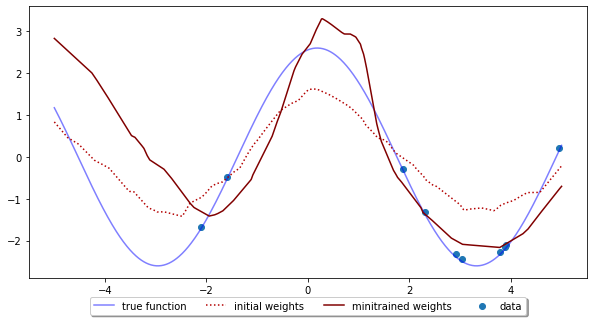

In [118]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

In [104]:
num_iterations = 400
function_tasks = FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
global_error = 0
count = 0

for i in range(num_iterations):
    og_net=maml.net.net
    optim=torch.optim.SGD
    lr=0.01
    
    task=function_tasks.sample_task()
    x,y=task.sample_data(K)
    x=x.to(device)
    y=y.to(device)
    outputs,axis=test(og_net,x,y,lr,optim)
    
    error = 0
    L = []
    for i in range(len(x.numpy())):
        L.append(int((5+x.numpy()[i][0])*100))
    pred = []
    for i in range(len(x.numpy())):
        pred.append(outputs['minitrained'][L[i]][0])
    y_ = []
    for i in range(len(y.numpy())):
        y_.append(y.numpy()[i][0])
        
    error = (np.linalg.norm(np.array(y_)-np.array(pred)))
    if error < 1000 and error > -1000:
        global_error += error
        count +=1
        
global_error = global_error/count
print(global_error/(5**0.5))

[2.8116276264190674, 5.640130043029785, 10.018312454223633, 4.434835433959961, 1.4111177921295166, 0.6341407299041748, 0.5259844064712524, 0.3040482997894287, 0.19942335784435272, 0.13499200344085693]
[0.6648828387260437, 3.1109519004821777, 8.324228286743164, 9.869400978088379, 2.914715051651001, 1.1488832235336304, 0.5649083852767944, 0.258329838514328, 0.21271750330924988, 0.1869574338197708]
[5.2588348388671875, 4.162018775939941, 9.990265846252441, 133.34405517578125, 182.7052764892578, 49429.20703125, 3277039.5, 1.0174588573150767e+21, inf, nan]
[4.589328289031982, 11.770633697509766, 57.629364013671875, 40.9411735534668, 29.06683349609375, 1.5123074054718018, 1.5686798095703125, 1.734060287475586, 1.3987926244735718, 1.2795369625091553]
[0.7056884765625, 3.999981641769409, 6.0775251388549805, 5.010092258453369, 1.3419935703277588, 0.13430126011371613, 0.07809986174106598, 0.06928670406341553, 0.06617142260074615, 0.0668569952249527]
[10.084455490112305, 106.87174987792969, 137.8

[5.494756698608398, 16.90350341796875, 7.366168975830078, 15.496661186218262, 42.69233703613281, 8.927545547485352, 3.653294324874878, 1.2726792097091675, 0.7434524297714233, 0.5219195485115051]
[0.2945341169834137, 1.130244493484497, 7.0467963218688965, 8.67468547821045, 3.6188557147979736, 1.3083617687225342, 1.4350570440292358, 2.3555748462677, 0.9190055131912231, 0.4500350058078766]
[1.7363393306732178, 7.530024528503418, 1.0951511859893799, 1.2607773542404175, 0.4955148696899414, 0.7384839653968811, 1.617826223373413, 0.23748834431171417, 0.134928897023201, 0.19007134437561035]
[0.5717712640762329, 9.61872673034668, 16.710681915283203, 6.9276533126831055, 2.3239190578460693, 0.4508943557739258, 0.19349020719528198, 0.15383243560791016, 0.19255249202251434, 0.2238456904888153]
[2.476823091506958, 11.82960033416748, 17.237716674804688, 54.23438262939453, 4.727103233337402, 2.653899669647217, 7.624875068664551, 94.41341400146484, 108.7963638305664, 505.5977478027344]
[0.3572993278503

[3.403611660003662, 19.760204315185547, 1.308854579925537, 0.8018118739128113, 0.38908928632736206, 0.29249992966651917, 0.23945696651935577, 0.23109836876392365, 0.21264183521270752, 0.260864794254303]
[0.026535678654909134, 0.09315427392721176, 1.2812355756759644, 7.246099948883057, 6.350752830505371, 2.9653804302215576, 2.6779630184173584, 1.537792444229126, 3.0057969093322754, 3.62495493888855]
[0.5237625241279602, 6.365408897399902, 1.2701833248138428, 3.285022020339966, 0.7466298341751099, 0.22386297583580017, 0.1115955337882042, 0.08413491398096085, 0.06383097916841507, 0.05412305146455765]
[0.2825409770011902, 1.3384966850280762, 5.775834560394287, 8.698443412780762, 4.285284042358398, 1.1582841873168945, 1.8184738159179688, 1.0929827690124512, 1.047646403312683, 1.4300813674926758]
[0.053715188056230545, 0.22374150156974792, 0.5794765949249268, 1.4968985319137573, 19.229402542114258, 1.2027963399887085, 0.6843174695968628, 1.15521240234375, 0.4839145541191101, 0.52075642347335

[5.164147853851318, 11.477142333984375, 10.189552307128906, 1.5372192859649658, 0.8217399716377258, 0.5129759907722473, 0.43476706743240356, 0.39326781034469604, 0.3650002181529999, 0.34150785207748413]
[2.685610055923462, 9.335576057434082, 1.2585251331329346, 0.7361927628517151, 0.3071669042110443, 0.1537494957447052, 0.08167245984077454, 0.044318053871393204, 0.026774173602461815, 0.017421532422304153]
[0.613355278968811, 5.303469181060791, 9.596735954284668, 28.264108657836914, 19.653057098388672, 8.037378311157227, 1.592471957206726, 0.7014831304550171, 0.4816194474697113, 0.38434383273124695]
[11.782898902893066, 16.609149932861328, 4.909305572509766, 2.400899887084961, 1.4893299341201782, 1.1623512506484985, 0.929958164691925, 0.8175424337387085, 0.7469128966331482, 0.6932529211044312]
[1.5337029695510864, 2.432248830795288, 1.0508193969726562, 1.0676627159118652, 1.2703622579574585, 1.377079963684082, 0.7567611932754517, 0.6118216514587402, 0.21670420467853546, 0.08718524873256

[7.730123996734619, 36.227291107177734, 77.08935546875, 10913.373046875, 30.11983299255371, 2783.521484375, 20.241519927978516, 8.941689491271973, 7.833332061767578, 6.8810224533081055]
[2.1496949195861816, 5.549529075622559, 10.204017639160156, 41.328983306884766, 49.59696578979492, 47.93418502807617, 59.096435546875, 3.176231622695923, 1.9101035594940186, 1.4260427951812744]
[7.7589826583862305, 11.414677619934082, 33.725894927978516, 186.99525451660156, 5157.02880859375, 1183212928.0, 1.7342114929078307e+30, inf, nan, nan]
[9.983531951904297, 24.310062408447266, 13.032724380493164, 8.159674644470215, 5.183831214904785, 2.8613648414611816, 1.8878700733184814, 1.4197003841400146, 1.201474666595459, 1.055840253829956]
[1.052695631980896, 1.583817481994629, 0.8061114549636841, 1.626665472984314, 2.027376890182495, 1.1590383052825928, 0.45734405517578125, 0.35012292861938477, 0.17186512053012848, 0.14158932864665985]
[0.2935536503791809, 2.868159770965576, 13.81408977508545, 2.6901533603

[0.9158657193183899, 1.2410123348236084, 19.058361053466797, 19.222579956054688, 11.92027473449707, 7.128342628479004, 1.444249153137207, 0.7367417812347412, 0.576062798500061, 0.6140878200531006]
[0.23192961513996124, 0.6047071218490601, 6.080082893371582, 13.972938537597656, 10.313504219055176, 10.099908828735352, 8.009236335754395, 8.8891019821167, 0.5584427118301392, 0.3432924151420593]
[2.076411008834839, 7.847405433654785, 13.765706062316895, 9.445258140563965, 0.8084524273872375, 0.8978825807571411, 1.1080396175384521, 1.0637600421905518, 2.3900506496429443, 0.6623573303222656]
[0.5216356515884399, 2.2389912605285645, 7.0580925941467285, 5.272052764892578, 1.2110471725463867, 0.45567116141319275, 0.31082862615585327, 0.281762033700943, 0.4221285283565521, 0.8860066533088684]
[3.1442794799804688, 22.513484954833984, 21.796903610229492, 47.548946380615234, 15.983266830444336, 20.737770080566406, 39.66149139404297, 5.368136405944824, 2.2791550159454346, 1.2758476734161377]
[1.05442

[2.239011526107788, 14.73698902130127, 10.828341484069824, 0.6297104954719543, 0.39816635847091675, 0.3326074182987213, 0.2172573059797287, 0.19469404220581055, 0.1927020102739334, 0.13863380253314972]
[0.6878630518913269, 2.663240671157837, 9.260031700134277, 1.7210960388183594, 2.931305408477783, 0.41721677780151367, 0.5943309664726257, 0.9210994839668274, 1.0672838687896729, 1.2075189352035522]
[4.69543981552124, 9.010515213012695, 15.032094955444336, 47.994651794433594, 10.624802589416504, 7.061917304992676, 6.453061103820801, 3.026231050491333, 2.0971109867095947, 1.6702015399932861]
[0.5927444696426392, 4.118422985076904, 1.3838156461715698, 0.7718102335929871, 0.266708642244339, 0.1958526074886322, 0.07985340058803558, 0.053300730884075165, 0.0458296462893486, 0.04665970802307129]
[2.1634528636932373, 1.199146032333374, 0.9424673914909363, 6.435822486877441, 14.844586372375488, 21.608304977416992, 20.531177520751953, 5.751545429229736, 1.8359283208847046, 0.9540785551071167]
[3.

[2.514519453048706, 6.113554954528809, 2.2374043464660645, 1.3885223865509033, 1.0159046649932861, 1.1709015369415283, 1.1205750703811646, 1.1822288036346436, 0.7906116247177124, 0.6869126558303833]
[0.7147246599197388, 5.513896942138672, 1.5094627141952515, 3.9364171028137207, 3.7958931922912598, 1.020415186882019, 0.13497349619865417, 0.034778911620378494, 0.023472003638744354, 0.025028061121702194]
[10.941607475280762, 18.276731491088867, 20.206966400146484, 11.930853843688965, 7.531398773193359, 0.9835454225540161, 0.48575472831726074, 0.3545837998390198, 0.28757232427597046, 0.26165205240249634]
[6.588112831115723, 46.4118766784668, 65.71281433105469, 54.435646057128906, 25.519458770751953, 6.045331001281738, 3.9828555583953857, 2.8698737621307373, 2.0975112915039062, 1.5405949354171753]
[8.347089767456055, 10.781346321105957, 4.065436363220215, 1.4744458198547363, 0.41428622603416443, 0.21776068210601807, 0.1772361695766449, 0.1484447419643402, 0.12623584270477295, 0.107059553265

[4.285560607910156, 3.017507553100586, 9.929166793823242, 6.4972944259643555, 6.151515960693359, 1.7092939615249634, 3.4020988941192627, 2.8008968830108643, 4.040497779846191, 1.7958694696426392]
[3.1273245811462402, 6.812644958496094, 4.96765661239624, 1.0199227333068848, 0.3565877079963684, 0.8621820211410522, 5.3531599044799805, 4.218160152435303, 2.3735995292663574, 1.9382312297821045]
[0.11090290546417236, 0.45456165075302124, 8.658321380615234, 10.79207706451416, 3.6440303325653076, 22.402843475341797, 7.673032283782959, 2.0599076747894287, 1.0180506706237793, 0.655606210231781]
[0.42729735374450684, 0.6925199031829834, 10.76955509185791, 18.071378707885742, 7.11223840713501, 5.214162826538086, 4.370786190032959, 1.8133947849273682, 0.4868725836277008, 0.13415412604808807]
[0.4981726109981537, 0.42345505952835083, 0.926619827747345, 3.958925724029541, 2.64323353767395, 0.6650214195251465, 0.09132109582424164, 0.06138526648283005, 0.05453934520483017, 0.04234975203871727]
[5.17028

# Plotting the RMSE as a function of the training steps - new

In [271]:
min_amp,max_amp,min_phase,max_phase,min_x,max_x = 0.1, 5, 0, np.pi, -5, 5 #Classic ones
#min_amp,max_amp,min_phase,max_phase,min_x,max_x = -1, 1, 0, np.pi/3, -3, 3 #It sucks

sine_tasks=FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
#NPs like: -1, 1, 0, np.pi/3, -3, 3
#Classic: 0.1, 5, 0, np.pi, -5, 5
net=FNet()
net=net.to(device)
maml=FMAML(net,alpha=0.01,beta=0.001,tasks=function_tasks,k=5,num_metatasks=10)
rmse_evolution = []

for train_step in range(100):
    maml.outer_loop(num_epochs=500)

    global_error = 0

    num_iterations = 100
    count = 0
    for i in range(num_iterations):
        og_net=maml.net.net
        optim=torch.optim.SGD
        lr=0.01
        
        task=function_tasks.sample_task()
        x,y=task.sample_data(5)
        x=x.to(device)
        y=y.to(device)

        outputs,axis=test(og_net,x,y,lr,optim)
  
        error = 0
        L = []
        for i in range(len(x.numpy())):
            L.append(int((5+x.numpy()[i][0])*100))
        pred = []
        for i in range(len(x.numpy())):
            pred.append(outputs['minitrained'][L[i]][0])
        y_ = []
        for i in range(len(y.numpy())):
            y_.append(y.numpy()[i][0])
        error = np.linalg.norm(np.array(y_)-np.array(pred))
        if error<1000 and error >-1000:
            global_error+=error
            count += 1
    global_error = global_error/count
    rmse_evolution.append(global_error)

[1.624916434288025, 1.062483549118042, 0.6402875185012817, 0.38355353474617004, 0.23307259380817413, 0.14768563210964203, 0.09811387956142426, 0.06909149885177612, 0.05219386890530586, 0.042367927730083466]
[1.1877447366714478, 0.8106178045272827, 0.5590823888778687, 0.3887406289577484, 0.27116069197654724, 0.19148914515972137, 0.1360127329826355, 0.09888289868831635, 0.074456587433815, 0.05898938328027725]
[0.3943631052970886, 0.07179810106754303, 0.05683646723628044, 0.046681083738803864, 0.038762837648391724, 0.03244195505976677, 0.027327582240104675, 0.023152800276875496, 0.019722256809473038, 0.01688728854060173]
[6.3465657234191895, 4.835970878601074, 4.354755878448486, 3.9493985176086426, 3.595365524291992, 3.290709972381592, 3.0317435264587402, 2.800218105316162, 2.5797367095947266, 2.3829567432403564]
[3.3459410667419434, 2.6987690925598145, 2.2893476486206055, 1.9524059295654297, 1.6571613550186157, 1.3953949213027954, 1.1641497611999512, 0.9634019136428833, 0.791070103645324

[1.404744267463684, 1.0591583251953125, 0.9419617652893066, 0.8612251281738281, 0.8032342791557312, 0.763722836971283, 0.7346915602684021, 0.7127491235733032, 0.6958807706832886, 0.6823332905769348]
[9.406639099121094, 4.072822570800781, 2.7939209938049316, 2.4710588455200195, 2.363398790359497, 2.2768115997314453, 2.2063167095184326, 2.1484923362731934, 2.1005051136016846, 2.060157299041748]
[4.450327396392822, 2.6193294525146484, 1.771453857421875, 1.2675508260726929, 0.9393183588981628, 0.7114607095718384, 0.5470792055130005, 0.42494136095046997, 0.3324323296546936, 0.2615019679069519]
[2.7129852771759033, 1.514581322669983, 1.3742252588272095, 1.2555711269378662, 1.166235327720642, 1.1007181406021118, 1.0463601350784302, 0.9958568811416626, 0.9482070803642273, 0.9049134254455566]
[0.061790209263563156, 0.018966931849718094, 0.01717367395758629, 0.016259294003248215, 0.015602238476276398, 0.0151095911860466, 0.014725913293659687, 0.014416204765439034, 0.014158213511109352, 0.0139375

[10.180773735046387, 5.02470064163208, 4.558797359466553, 4.221068859100342, 3.945889949798584, 3.709907054901123, 3.5042591094970703, 3.3201301097869873, 3.1525485515594482, 2.996399402618408]
[0.10635218769311905, 0.0921131819486618, 0.11392892897129059, 0.17545011639595032, 0.2966064214706421, 0.530701756477356, 0.9158182144165039, 1.5449841022491455, 2.1208372116088867, 1.0087693929672241]
[1.651181936264038, 0.8268262147903442, 0.6768981218338013, 0.5628697872161865, 0.47100910544395447, 0.39719849824905396, 0.33859914541244507, 0.3001018166542053, 0.27372267842292786, 0.25107231736183167]
[1.2562813758850098, 1.162937045097351, 0.6423938870429993, 0.43239036202430725, 0.21943488717079163, 0.1575879156589508, 0.12001967430114746, 0.10571875423192978, 0.09809793531894684, 0.09308531880378723]
[4.830107688903809, 2.908423662185669, 2.2937088012695312, 1.9065141677856445, 1.6264820098876953, 1.410266637802124, 1.2428001165390015, 1.1237138509750366, 1.0381807088851929, 0.969260811805

[2.767892837524414, 1.9215539693832397, 1.4972705841064453, 1.278256893157959, 1.1605254411697388, 1.0837985277175903, 1.0388869047164917, 0.9990895390510559, 0.9646883010864258, 0.9318102598190308]
[2.731588363647461, 1.5174754858016968, 1.1367897987365723, 0.8532562255859375, 0.6394692063331604, 0.4792882800102234, 0.3769369423389435, 0.3125803768634796, 0.266326904296875, 0.2397024929523468]
[1.5127196311950684, 0.8056678771972656, 0.6048991084098816, 0.49428731203079224, 0.4198976457118988, 0.3660346567630768, 0.32524019479751587, 0.29327601194381714, 0.2675347924232483, 0.24633722007274628]
[0.08376893401145935, 0.05093502253293991, 0.03589627519249916, 0.02639974281191826, 0.01985502615571022, 0.015191580168902874, 0.01179549004882574, 0.009278208948671818, 0.007383891846984625, 0.00593962287530303]
[6.072646141052246, 5.361213207244873, 6.994103908538818, 8.321130752563477, 8.050586700439453, 4.389642238616943, 3.7728466987609863, 3.6270339488983154, 3.530933380126953, 3.4508183

[0.4648551344871521, 0.1928745061159134, 0.1053524762392044, 0.0712130218744278, 0.05658658221364021, 0.048137784004211426, 0.042616404592990875, 0.03864644840359688, 0.0357067845761776, 0.03329861909151077]
[15.211370468139648, 12.984979629516602, 18.249080657958984, 13.077545166015625, 12.28931999206543, 5.933586120605469, 5.215420722961426, 4.360388278961182, 4.235348224639893, 3.860224485397339]
[5.97468900680542, 3.301330089569092, 2.618189573287964, 2.318850040435791, 2.060354232788086, 1.8722343444824219, 1.7049505710601807, 1.6024612188339233, 1.4733271598815918, 1.4407110214233398]
[2.7278356552124023, 2.5696048736572266, 2.9357872009277344, 3.8753578662872314, 6.2851786613464355, 7.861652374267578, 8.152341842651367, 3.073533535003662, 2.1210036277770996, 2.023271083831787]
[1.909267783164978, 0.7627429962158203, 0.5067108869552612, 0.3899795114994049, 0.3262849450111389, 0.2826498746871948, 0.24870304763317108, 0.22056221961975098, 0.19693613052368164, 0.1779249608516693]
[1

[1.7913697957992554, 0.538804829120636, 0.2315351963043213, 0.14231054484844208, 0.11364483833312988, 0.10265211760997772, 0.09700928628444672, 0.0930713415145874, 0.08973930776119232, 0.08667595684528351]
[12.179948806762695, 9.166130065917969, 7.887423515319824, 5.305786609649658, 4.10642671585083, 2.951417922973633, 2.319920301437378, 1.8062219619750977, 1.4527075290679932, 1.1652895212173462]
[0.5329322218894958, 0.29245248436927795, 0.1915622055530548, 0.12796267867088318, 0.08808240294456482, 0.0630577802658081, 0.048261210322380066, 0.03719758242368698, 0.03014991618692875, 0.02465667948126793]
[0.8499833941459656, 0.6503354907035828, 0.5218203067779541, 0.41804665327072144, 0.3332177698612213, 0.2640106678009033, 0.20799605548381805, 0.16317422688007355, 0.1276932656764984, 0.0998484268784523]
[0.09505776315927505, 0.19660678505897522, 0.4122694432735443, 0.8925358653068542, 1.6063320636749268, 2.8009612560272217, 3.6203036308288574, 3.5750625133514404, 3.684347629547119, 2.312

[1.1009001731872559, 0.5212146043777466, 0.38053098320961, 0.315446674823761, 0.2770915925502777, 0.2523348033428192, 0.2347017526626587, 0.22127921879291534, 0.21048498153686523, 0.20144864916801453]
[0.7451367378234863, 0.49998483061790466, 0.36079859733581543, 0.26333314180374146, 0.19033929705619812, 0.138533815741539, 0.09733409434556961, 0.06942971050739288, 0.050221897661685944, 0.03685580939054489]
[0.9510728716850281, 0.4895307421684265, 0.20694789290428162, 0.16863736510276794, 0.14477641880512238, 0.12863853573799133, 0.11782144010066986, 0.11263133585453033, 0.10837151110172272, 0.10461126267910004]
[3.614014148712158, 3.291767120361328, 4.652146339416504, 2.9028892517089844, 2.6067025661468506, 2.4117209911346436, 2.2668094635009766, 2.1484265327453613, 2.0445709228515625, 1.953772783279419]
[0.4470645487308502, 2.2331390380859375, 8.624265670776367, 0.6417328715324402, 0.43710535764694214, 0.33619269728660583, 0.27721816301345825, 0.24235239624977112, 0.21742279827594757,

[3.054734706878662, 3.243377685546875, 4.192349433898926, 2.553673267364502, 2.48663067817688, 0.673880398273468, 0.46774548292160034, 0.3449839651584625, 0.26085251569747925, 0.19949392974376678]
[2.092594623565674, 1.5039821863174438, 5.44237756729126, 32.386451721191406, 21.341693878173828, 7.645860195159912, 4.210627555847168, 3.7372443675994873, 3.5026676654815674, 3.3637747764587402]
[2.0071306228637695, 0.738462507724762, 0.5605356693267822, 0.5108941197395325, 0.4811180531978607, 0.4571944773197174, 0.43664923310279846, 0.41862067580223083, 0.4025748372077942, 0.3881155252456665]
[2.336905002593994, 1.6145451068878174, 1.289785623550415, 1.0915727615356445, 0.9611074328422546, 0.8694366216659546, 0.8026216626167297, 0.7515567541122437, 0.7106495499610901, 0.6764513254165649]
[3.0804243087768555, 3.3960063457489014, 4.890530109405518, 1.5697643756866455, 1.120214581489563, 0.8504627346992493, 0.6804161071777344, 0.4800608158111572, 0.39021700620651245, 0.3487530052661896]
[2.275

[2.029468059539795, 0.8944384455680847, 0.5763610601425171, 0.42016535997390747, 0.33216235041618347, 0.2793459892272949, 0.24569864571094513, 0.22323362529277802, 0.20688314735889435, 0.19425079226493835]
[1.174330472946167, 0.6368604898452759, 0.4652097821235657, 0.38910049200057983, 0.34394803643226624, 0.3131087124347687, 0.2908925712108612, 0.27441075444221497, 0.26189106702804565, 0.25216200947761536]
[1.7344741821289062, 0.24857819080352783, 0.049078475683927536, 0.10852929204702377, 0.443448543548584, 0.24269139766693115, 0.18310649693012238, 0.12265755236148834, 0.08418628573417664, 0.055562812834978104]
[0.38982054591178894, 1.6009571552276611, 0.5834782123565674, 0.2596980929374695, 0.18539360165596008, 0.1466817855834961, 0.12439735233783722, 0.10979847609996796, 0.09880160540342331, 0.0904739573597908]
[0.7450854778289795, 0.5017279982566833, 0.4144565463066101, 0.3451487720012665, 0.2885846197605133, 0.24206312000751495, 0.2035757303237915, 0.17157022655010223, 0.14486792

[0.24922151863574982, 1.7983036041259766, 63.70732498168945, 37.532310485839844, 665.0394897460938, 0.7246158719062805, 0.6377823948860168, 0.5668931007385254, 0.5094603300094604, 0.4622304439544678]
[9.093877792358398, 420.0511169433594, 108.47086334228516, 1108.02197265625, 31.53326988220215, 46.37421417236328, 9.361640930175781, 1.751745581626892, 1.4565950632095337, 1.1477688550949097]
[0.6733190417289734, 0.3190356492996216, 0.2688969671726227, 0.2574724853038788, 0.2685651481151581, 0.3135643005371094, 0.4110300540924072, 0.610324501991272, 0.947961151599884, 1.31564462184906]
[1.4221851825714111, 0.567033052444458, 0.4831148087978363, 0.5702439546585083, 0.9054088592529297, 1.622623085975647, 2.647953987121582, 3.380242109298706, 0.3801834285259247, 0.17786332964897156]
[3.348424196243286, 3.4382853507995605, 12.885418891906738, 28.370960235595703, 19.549236297607422, 3.5414671897888184, 3.024475574493408, 2.7871522903442383, 2.6333489418029785, 2.501054286956787]
[6.26942729949

[2.069977283477783, 4.374579429626465, 4.283671855926514, 2.9773306846618652, 1.6568069458007812, 1.0701923370361328, 0.8733960390090942, 0.5231193900108337, 0.32203590869903564, 0.1719144880771637]
[2.007546901702881, 1.1036674976348877, 0.783969521522522, 0.6316645741462708, 0.5184050798416138, 0.4349516034126282, 0.3801676630973816, 0.3665148615837097, 0.48709940910339355, 0.6738117933273315]
[0.269277423620224, 0.24410390853881836, 0.41014280915260315, 0.9654520153999329, 2.39424467086792, 4.713282585144043, 0.6602995991706848, 0.14043185114860535, 0.06151169538497925, 0.029923012480139732]
[0.11599750816822052, 0.030900543555617332, 0.01924501545727253, 0.014147626236081123, 0.011691742576658726, 0.010333488695323467, 0.009455664083361626, 0.008806901052594185, 0.008249660022556782, 0.007654027082026005]
[1.2259521484375, 4.782130241394043, 61.577430725097656, 6.9788079261779785, 39.94318771362305, 48.30481719970703, 0.21872910857200623, 0.18711403012275696, 0.16278529167175293, 0

[5.080826759338379, 1.2174131870269775, 0.46785062551498413, 0.23027904331684113, 0.17141364514827728, 0.15426655113697052, 0.1602780818939209, 0.1609569489955902, 0.18073239922523499, 0.1818496584892273]
[6.449830055236816, 2.4309401512145996, 1.9749243259429932, 1.6570425033569336, 1.401237964630127, 1.1890132427215576, 1.011224389076233, 0.8624080419540405, 0.7378818392753601, 0.6342592239379883]
[1.100008249282837, 0.6930307149887085, 1.1329998970031738, 24.553041458129883, 8.260324478149414, 275.0469665527344, 54.585845947265625, 6.462153434753418, 5.801210403442383, 5.399604797363281]
[1.8715484142303467, 6.6289262771606445, 4.2128119468688965, 0.6340945363044739, 0.3281164765357971, 0.26862889528274536, 0.2528098523616791, 0.2467031180858612, 0.2629259526729584, 0.2770608067512512]
[8.618013381958008, 6.509422302246094, 4.799709796905518, 3.5345053672790527, 3.7138137817382812, 4.266787528991699, 3.9932334423065186, 3.6728503704071045, 2.556098699569702, 1.8584461212158203]
[0.2

[0.669506847858429, 0.3380592465400696, 0.24776038527488708, 0.1988222897052765, 0.1659422367811203, 0.14236316084861755, 0.12479163706302643, 0.11123881489038467, 0.10043375194072723, 0.09154762327671051]
[3.9886066913604736, 2.8347761631011963, 2.046149492263794, 1.473543405532837, 1.0511736869812012, 0.7397991418838501, 0.5124624371528625, 0.3488779664039612, 0.23443928360939026, 0.15588220953941345]
[6.030648231506348, 3.420473575592041, 3.5515358448028564, 5.026516914367676, 5.883040904998779, 4.229470252990723, 2.8928229808807373, 1.5565096139907837, 1.2235263586044312, 0.9992889165878296]
[3.3689827919006348, 1.4716980457305908, 1.224378228187561, 1.1469141244888306, 1.080811619758606, 1.0252898931503296, 0.9803072810173035, 0.9380897283554077, 0.8981362581253052, 0.8607032895088196]
[10.670381546020508, 4.838084697723389, 83.69654846191406, 376.454345703125, 15.54541301727295, 10.564925193786621, 10.070428848266602, 9.371245384216309, 8.395051002502441, 7.145472526550293]
[2.69

[2.3217740058898926, 0.8797883987426758, 0.5466998815536499, 0.3853243589401245, 0.2852632701396942, 0.21990236639976501, 0.17562541365623474, 0.14453727006912231, 0.12223167717456818, 0.10573532432317734]
[4.745875358581543, 1.2488133907318115, 0.5341149568557739, 0.2666831910610199, 0.18519118428230286, 0.15287554264068604, 0.1355019211769104, 0.12421903759241104, 0.11631380021572113, 0.11064759641885757]
[2.0789217948913574, 2.4872796535491943, 3.081343173980713, 1.3906852006912231, 0.9304766654968262, 0.35232362151145935, 0.19053462147712708, 0.13237543404102325, 0.10766663402318954, 0.0927608460187912]
[0.6836625337600708, 0.4833908677101135, 3.757406234741211, 37.865840911865234, 24.409564971923828, 64.59306335449219, 3.522279739379883, 3.4428038597106934, 3.3607025146484375, 3.2634005546569824]
[4.698765754699707, 1.2068965435028076, 0.5031009912490845, 0.24683336913585663, 0.14231640100479126, 0.10248670727014542, 0.08796057850122452, 0.08271868526935577, 0.08074770867824554, 0

[9.590286254882812, 14.608436584472656, 109.83537292480469, 31.98193359375, 9.081336975097656, 3.5479419231414795, 2.22149395942688, 1.6526458263397217, 1.5122488737106323, 1.4630992412567139]
[3.361008405685425, 3.177041530609131, 1.327103614807129, 0.950397789478302, 0.7766305804252625, 0.65874183177948, 0.59515780210495, 0.5232923030853271, 0.4630081057548523, 0.4283889830112457]
[1.5403937101364136, 4.55394983291626, 3.223149061203003, 1.8912765979766846, 1.6064386367797852, 1.5270758867263794, 1.3038685321807861, 1.1492377519607544, 0.9010928273200989, 0.742891252040863]
[14.308595657348633, 137.9649658203125, 40.05646514892578, 27.691009521484375, 85.15384674072266, 35.434173583984375, 12.91197681427002, 12.526344299316406, 12.215120315551758, 11.937663078308105]
[2.017712116241455, 18.513090133666992, 31.859203338623047, 1316.6099853515625, 10.04338264465332, 7.949776649475098, 7.276705741882324, 6.923895835876465, 6.686671257019043, 6.517036437988281]
[1.6212602853775024, 10.19

[2.427621364593506, 3.0888707637786865, 1.6631574630737305, 1.1953518390655518, 2.0238614082336426, 4.0336127281188965, 6.81664514541626, 4.534153938293457, 2.814260959625244, 0.8077441453933716]
[0.24742412567138672, 0.18936403095722198, 0.20650072395801544, 0.264691561460495, 0.3948831260204315, 0.6312076449394226, 1.0767829418182373, 1.6588560342788696, 2.402040958404541, 0.4356449544429779]
[5.8187575340271, 2.2070956230163574, 1.489139199256897, 0.9971445202827454, 0.6600137948989868, 0.4309241771697998, 0.27775949239730835, 0.17745885252952576, 0.11295108497142792, 0.07204971462488174]
[2.253476142883301, 5.598903656005859, 7.560318946838379, 4.3294525146484375, 2.098641872406006, 1.6311712265014648, 1.4815936088562012, 1.4036744832992554, 1.351613998413086, 1.3223210573196411]
[0.38903823494911194, 0.2782333493232727, 0.234182208776474, 0.21045124530792236, 0.19319723546504974, 0.17902353405952454, 0.16656331717967987, 0.15530887246131897, 0.1450321227312088, 0.1356021910905838]

[12.980618476867676, 152.26467895507812, 113.42042541503906, 267.2753601074219, 5.989115238189697, 5.647377014160156, 5.2822699546813965, 4.748502254486084, 4.085906982421875, 3.2296550273895264]
[0.7272855043411255, 0.5852867960929871, 9.326208114624023, 111.27850341796875, 31.485782623291016, 296.81036376953125, 2.6944446563720703, 2.509773015975952, 2.357943058013916, 2.2322335243225098]
[1.787266731262207, 3.7495713233947754, 7.667672157287598, 1.2721211910247803, 0.4434690475463867, 0.2514926791191101, 0.21783795952796936, 0.19376882910728455, 0.17358103394508362, 0.15592114627361298]
[0.6972564458847046, 0.24611787497997284, 1.5303525924682617, 5.9501566886901855, 3.452709197998047, 0.27016112208366394, 0.0047810873948037624, 0.003740709275007248, 0.0035255439579486847, 0.0034513443242758512]
[6.257155418395996, 1.244888186454773, 0.5942206978797913, 0.35799723863601685, 0.24234791100025177, 0.18696311116218567, 0.1524488925933838, 0.13030199706554413, 0.11304767429828644, 0.0990

[3.9548122882843018, 2.1822826862335205, 1.8144385814666748, 1.500831127166748, 1.4294335842132568, 1.5313928127288818, 2.2453789710998535, 2.766218662261963, 3.307053327560425, 1.510149598121643]
[6.582573890686035, 9.028337478637695, 17.82811737060547, 5.988942623138428, 2.9209625720977783, 2.5278360843658447, 2.2605931758880615, 2.0359559059143066, 1.8655941486358643, 1.7227909564971924]
[1.9955886602401733, 15.671170234680176, 17.34915542602539, 363.0063171386719, 1.0981128215789795, 0.9418523907661438, 0.8326817750930786, 0.7532601952552795, 0.6893536448478699, 0.6386744379997253]
[0.8083062171936035, 3.6751410961151123, 17.479446411132812, 72.440673828125, 7.355710029602051, 1.574082374572754, 1.4822015762329102, 1.4175198078155518, 1.3649327754974365, 1.3232454061508179]
[2.1119155883789062, 1.0750634670257568, 0.7743583917617798, 0.6148858666419983, 0.49467453360557556, 0.39852800965309143, 0.3208628296852112, 0.25806406140327454, 0.20731627941131592, 0.16634896397590637]
[0.12

[2.237260580062866, 1.2737064361572266, 0.6817127466201782, 0.5479437112808228, 0.5536676645278931, 1.1346261501312256, 0.6200858354568481, 0.8497841954231262, 0.43092411756515503, 0.6544687747955322]
[12.54471492767334, 6.095964431762695, 3.848440647125244, 2.604576826095581, 1.8078663349151611, 1.2595384120941162, 0.8967035412788391, 0.6470197439193726, 0.5069414377212524, 0.4448789656162262]
[0.3697184920310974, 0.17747017741203308, 0.18655018508434296, 0.3311968743801117, 0.4528838098049164, 0.8988955616950989, 0.5289427638053894, 0.3689655363559723, 0.24745126068592072, 0.20957979559898376]
[1.3914276361465454, 6.563545227050781, 18.432416915893555, 9.509235382080078, 6.1299848556518555, 0.4958121180534363, 0.10938607156276703, 0.04730237275362015, 0.0300066526979208, 0.023210668936371803]
[0.20257481932640076, 0.0720992162823677, 0.7915526032447815, 4.2115092277526855, 1.4805811643600464, 0.9336370229721069, 0.36635249853134155, 0.24581000208854675, 0.06705859303474426, 0.0226203

[8.409546852111816, 3.726634979248047, 2.3551456928253174, 1.7661981582641602, 1.356131911277771, 1.0460913181304932, 0.808815598487854, 0.6262876987457275, 0.4859597682952881, 0.37812721729278564]
[3.700188159942627, 2.4048421382904053, 6.204602241516113, 6.360960483551025, 1.774741530418396, 0.2829646170139313, 0.21725530922412872, 0.20717589557170868, 0.20031075179576874, 0.19498953223228455]
[0.0966394692659378, 2.3377275466918945, 13.813962936401367, 53.71632766723633, 49.07527542114258, 27.72317123413086, 1.140191674232483, 0.9017890691757202, 0.7898586988449097, 0.7195305228233337]
[4.037164688110352, 3.5315537452697754, 1.7118982076644897, 0.5696715116500854, 0.5410681962966919, 0.5288035869598389, 0.5184375643730164, 0.5084161758422852, 0.498612642288208, 0.48901471495628357]
[1.4377412796020508, 1.5935566425323486, 2.0950584411621094, 2.3670051097869873, 0.7121902704238892, 0.9797391891479492, 2.1696410179138184, 0.9056989550590515, 0.5070533156394958, 0.23544995486736298]
[1

[0.25360992550849915, 0.8879594802856445, 5.812038421630859, 9.208379745483398, 28.030811309814453, 12.246931076049805, 1.9066652059555054, 0.25652554631233215, 0.12727120518684387, 0.09096382558345795]
[10.801873207092285, 26.413227081298828, 40.62204360961914, 11.306260108947754, 8.479872703552246, 7.693697929382324, 7.106369972229004, 6.610267639160156, 6.303203582763672, 6.075039863586426]
[6.844082832336426, 1.555408000946045, 6.03857421875, 30.580846786499023, 25.16761589050293, 10.20857048034668, 3.359030246734619, 2.7742919921875, 2.351494073867798, 1.9798171520233154]
[8.093080520629883, 18.008764266967773, 17.84978675842285, 5.502305507659912, 4.053572177886963, 3.034714460372925, 2.3940236568450928, 2.0929903984069824, 1.877590537071228, 1.6873050928115845]
[0.6248265504837036, 0.1640336811542511, 0.09810806065797806, 0.08413630723953247, 0.0796542763710022, 0.07701698690652847, 0.07478942722082138, 0.07269600033760071, 0.07068132609128952, 0.06873275339603424]
[5.3711895942

[1.5933878421783447, 1.3597972393035889, 1.0330936908721924, 0.845240592956543, 0.9149511456489563, 0.5709704160690308, 0.534643292427063, 0.3651899993419647, 0.3441339433193207, 0.3023037016391754]
[3.1978678703308105, 2.846156597137451, 3.875492811203003, 4.712907314300537, 3.1461002826690674, 2.9372897148132324, 2.793433666229248, 2.594306230545044, 2.538463592529297, 2.368713855743408]
[7.602065086364746, 19.764265060424805, 13.534672737121582, 6.943100929260254, 5.398059368133545, 4.754695415496826, 4.364444255828857, 4.122025489807129, 3.94819974899292, 3.7993686199188232]
[0.5710485577583313, 7.1341071128845215, 6.328436374664307, 12.8541841506958, 12.726675033569336, 2.0437800884246826, 0.21811065077781677, 0.1614658385515213, 0.12939180433750153, 0.10566473007202148]
[0.47990959882736206, 0.5937449932098389, 1.3619537353515625, 1.0891849994659424, 0.37980762124061584, 0.49788737297058105, 0.6383273005485535, 1.1064097881317139, 0.9750112295150757, 0.8528770208358765]
[5.141774

[1.0785458087921143, 0.7424411177635193, 0.749180793762207, 0.9096626043319702, 1.2708075046539307, 1.622157335281372, 2.196132183074951, 2.3931081295013428, 2.747826099395752, 2.284440279006958]
[1.387019395828247, 0.6216953992843628, 0.5285831689834595, 0.33416199684143066, 0.2702900171279907, 0.17396262288093567, 0.13500504195690155, 0.08988256007432938, 0.07021763175725937, 0.04520503804087639]
[8.964530944824219, 171.33778381347656, 209.4751434326172, 266.12359619140625, 7.234804630279541, 6.423150539398193, 6.05377197265625, 5.848143100738525, 5.6996636390686035, 5.572981834411621]
[0.7670795321464539, 0.13925766944885254, 0.6077796220779419, 2.1107749938964844, 0.3123181164264679, 0.5713462829589844, 1.0951043367385864, 0.6781795024871826, 0.5663102269172668, 0.41376161575317383]
[0.6578524708747864, 1.0787440538406372, 3.3653404712677, 1.8257238864898682, 1.0359480381011963, 0.43274807929992676, 0.3465593457221985, 0.17473646998405457, 0.11351823806762695, 0.08495504409074783]


[0.9877662658691406, 0.5931994915008545, 0.4009198248386383, 0.2911551296710968, 0.2277185022830963, 0.19214919209480286, 0.17559406161308289, 0.20163169503211975, 0.25611189007759094, 0.4162505269050598]
[1.7121728658676147, 2.250974178314209, 2.348745822906494, 0.2842341959476471, 0.2716059386730194, 0.47562628984451294, 1.1737219095230103, 1.9316059350967407, 2.0842413902282715, 0.5676465630531311]
[0.8497515916824341, 0.18391366302967072, 0.10548107326030731, 0.08400540798902512, 0.07040770351886749, 0.059632085263729095, 0.05081016570329666, 0.04354442283511162, 0.03754415363073349, 0.03257780894637108]
[7.541548252105713, 6.773781776428223, 5.8216753005981445, 6.864377021789551, 26.891918182373047, 16.62767791748047, 8.206987380981445, 5.1386284828186035, 3.5049376487731934, 2.8360114097595215]
[1.5781433582305908, 0.9955078363418579, 0.9856867790222168, 1.7504758834838867, 3.08670711517334, 1.1022305488586426, 0.6635791659355164, 0.48485273122787476, 0.3699759840965271, 0.285726

[4.954823970794678, 0.4966069757938385, 0.4460805356502533, 2.695293664932251, 16.109844207763672, 5.777667045593262, 1.7386486530303955, 0.7836300134658813, 0.36133748292922974, 0.16984866559505463]
[3.383176326751709, 25.148509979248047, 51.2764892578125, 3.766094207763672, 2.7760252952575684, 2.0104000568389893, 1.410491943359375, 0.9742454290390015, 0.639917254447937, 0.3704916834831238]
[0.19382432103157043, 0.9011063575744629, 0.7552555203437805, 1.9577707052230835, 0.5304509997367859, 0.27918294072151184, 0.16961553692817688, 0.1572587937116623, 0.14909090101718903, 0.14250604808330536]
[1.0220279693603516, 14.909822463989258, 23.810556411743164, 404.6761169433594, 352.39654541015625, 3.246291399002075, 0.45339423418045044, 0.30679842829704285, 0.2713901698589325, 0.26048725843429565]
[0.8725818395614624, 0.2162611186504364, 0.19411322474479675, 0.2150871753692627, 0.41222667694091797, 0.40288740396499634, 1.2815951108932495, 0.35541874170303345, 0.5341529250144958, 0.1878106892

[4.91045618057251, 8.003275871276855, 15.19249439239502, 3.150719404220581, 1.4303686618804932, 0.7363467216491699, 0.4976583421230316, 0.3983401358127594, 0.33508604764938354, 0.2877883315086365]
[1.5230779647827148, 2.437117576599121, 11.729559898376465, 46.1092529296875, 1.583846092224121, 19.766315460205078, 26.336544036865234, 6.832766532897949, 5.422905921936035, 4.857504844665527]
[0.11178110539913177, 1.3317480087280273, 1.7512378692626953, 1.4248011112213135, 0.4899935722351074, 0.3975698947906494, 0.3912835717201233, 0.4216419756412506, 0.3721427023410797, 0.3302844166755676]
[0.3769771158695221, 1.3829774856567383, 6.115499496459961, 8.330456733703613, 7.792266845703125, 0.8360079526901245, 0.3800050616264343, 0.1608741581439972, 0.12006042897701263, 0.1043466180562973]
[0.5057584047317505, 1.1126964092254639, 0.904830813407898, 0.6866640448570251, 0.9526166915893555, 0.646330714225769, 0.4183943271636963, 0.2575891613960266, 0.15308527648448944, 0.08930886536836624]
[0.4685

[1.1974823474884033, 0.2850413918495178, 0.3348105549812317, 0.23250755667686462, 0.3230056166648865, 0.2677004039287567, 0.48420509696006775, 0.2648824453353882, 0.21216252446174622, 0.19772842526435852]
[1.1209880113601685, 0.39042654633522034, 0.14686068892478943, 0.20898517966270447, 0.5098552107810974, 0.33960217237472534, 0.3541598320007324, 0.17414312064647675, 0.1226290687918663, 0.0702197402715683]
[8.793336868286133, 61.65362548828125, 36.12915802001953, 73.99882507324219, 33.666839599609375, 12.315618515014648, 10.04592227935791, 9.193272590637207, 8.59924030303955, 8.117740631103516]
[4.228847503662109, 2.37101674079895, 1.92854905128479, 1.7059288024902344, 1.7071927785873413, 2.449585437774658, 1.4593534469604492, 1.5595837831497192, 1.291439414024353, 1.0417503118515015]
[1.8556379079818726, 0.4011794626712799, 0.1479216068983078, 0.09105657041072845, 0.05716235563158989, 0.03652384132146835, 0.025572430342435837, 0.018296902999281883, 0.013507639057934284, 0.01049661636

[0.5483738780021667, 0.5481117963790894, 1.0797674655914307, 3.5617613792419434, 4.8812079429626465, 6.332273006439209, 0.2405426949262619, 0.04775971546769142, 0.04309624433517456, 0.04106753692030907]
[2.7754931449890137, 62.699623107910156, 136.80043029785156, 14.731912612915039, 3.077697277069092, 3.0595438480377197, 3.0420525074005127, 3.0250580310821533, 3.0084359645843506, 2.992102861404419]
[6.374664306640625, 0.8986011743545532, 0.5712122917175293, 0.38034823536872864, 0.2585489749908447, 0.18711474537849426, 0.1402277648448944, 0.10592633485794067, 0.08022238314151764, 0.06050056219100952]
[2.6279757022857666, 12.1713285446167, 27.463939666748047, 8.559751510620117, 2.8041205406188965, 0.9544532895088196, 0.5265911221504211, 0.3034852147102356, 0.17755696177482605, 0.10354851186275482]
[0.7021328210830688, 0.4395918846130371, 0.2900359332561493, 0.22166693210601807, 0.18157847225666046, 0.15126611292362213, 0.12721866369247437, 0.1099495068192482, 0.09616617858409882, 0.08599

[2.569807529449463, 17.50783920288086, 8.769248008728027, 23.483259201049805, 32.024208068847656, 9.509786605834961, 3.0557892322540283, 2.5745174884796143, 2.412122964859009, 2.338864803314209]
[1.5199792385101318, 3.6073639392852783, 1.6639560461044312, 1.1485306024551392, 0.22375941276550293, 0.06652168929576874, 0.02600579522550106, 0.018120408058166504, 0.01566929742693901, 0.01422477699816227]
[0.05800947546958923, 0.06904628127813339, 0.16848665475845337, 0.18427947163581848, 0.34023621678352356, 0.15363726019859314, 0.08461090922355652, 0.05572754144668579, 0.03834179416298866, 0.027654429897665977]
[0.12092511355876923, 0.11257398128509521, 0.383510947227478, 0.7100778818130493, 0.9408093690872192, 0.34322598576545715, 0.12947651743888855, 0.052534669637680054, 0.01351794321089983, 0.0031429603695869446]
[6.360982418060303, 31.63595199584961, 7.866658687591553, 6.496212959289551, 5.552055358886719, 4.748795509338379, 4.32275390625, 4.081435203552246, 4.150256156921387, 4.44433

[1.7627449035644531, 2.785933017730713, 22.190629959106445, 7.503589630126953, 2.0831618309020996, 0.6772007942199707, 0.4678577482700348, 0.37988635897636414, 0.3282618522644043, 0.29570263624191284]
[6.562647819519043, 49.82392883300781, 201.1643524169922, 214.3284912109375, 34.072113037109375, 3.3078742027282715, 2.1869616508483887, 1.2195476293563843, 1.0208730697631836, 0.9070549011230469]
[2.6492056846618652, 6.70366907119751, 9.65803337097168, 14.096386909484863, 5.910774230957031, 1.3780161142349243, 1.0368926525115967, 0.8986942172050476, 0.7873244285583496, 0.6925140023231506]
[4.691572666168213, 6.626755714416504, 11.715781211853027, 7.937000274658203, 5.000611782073975, 2.314568042755127, 1.5350679159164429, 1.2186866998672485, 1.1152331829071045, 1.060217261314392]
[5.296679496765137, 31.658077239990234, 30.096832275390625, 423.6260681152344, 117.78385925292969, 3.380620241165161, 3.153257131576538, 3.1325035095214844, 3.0446410179138184, 2.910320520401001]
[4.438687801361

[6.023053169250488, 91.78157043457031, 861.2509765625, 18316.2109375, 27011472.0, 264349136.0, 6.449388796159683e+28, inf, nan, nan]
[13.248998641967773, 25.029888153076172, 27.619674682617188, 16.67948341369629, 5.557086944580078, 3.682908296585083, 3.1087286472320557, 2.7334249019622803, 2.4530160427093506, 2.2815768718719482]
[2.4304287433624268, 14.595769882202148, 22.69375991821289, 61.369293212890625, 13.645090103149414, 6.718385219573975, 3.9703288078308105, 2.6307621002197266, 1.9760963916778564, 1.542571783065796]
[2.41721248626709, 1.7440986633300781, 86.8971939086914, 58.231964111328125, 1014.29638671875, 9.77726936340332, 0.57584148645401, 0.5180047750473022, 0.47472327947616577, 0.4408806264400482]
[0.9373792409896851, 4.743206977844238, 10.343313217163086, 3.57588529586792, 1.1890201568603516, 0.12356146425008774, 0.02721802331507206, 0.009977860376238823, 0.005044883117079735, 0.0030182937625795603]
[2.8192172050476074, 1.6652549505233765, 0.32579559087753296, 0.25989192

[2.786168336868286, 1.6884915828704834, 2.306583881378174, 9.069249153137207, 2.8946948051452637, 2.913973331451416, 1.7814204692840576, 0.6741809248924255, 0.4612692892551422, 0.38857150077819824]
[2.1205780506134033, 6.887312889099121, 3.730811595916748, 2.5800328254699707, 7.157891750335693, 32.54755783081055, 13.457681655883789, 0.5293158292770386, 0.4539944529533386, 0.39238518476486206]
[4.45922327041626, 8.133204460144043, 42.120147705078125, 550.6234130859375, 31.030385971069336, 10.768766403198242, 23.042016983032227, 147.71961975097656, 8.590795516967773, 7.897268772125244]
[4.247086524963379, 1.544428825378418, 0.5945544838905334, 0.3881548345088959, 0.22653770446777344, 0.13975556194782257, 0.090007483959198, 0.060548752546310425, 0.04146723821759224, 0.02911643125116825]
[1.5944558382034302, 3.607806444168091, 15.6198091506958, 17.104320526123047, 19.62018585205078, 6.480301856994629, 3.562150239944458, 2.3211913108825684, 1.6535007953643799, 1.2043089866638184]
[11.591531

[4.282147407531738, 144.11219787597656, 343.55535888671875, 39573.52734375, 755.0316772460938, 3918.940673828125, 9030121472.0, 1.3577271017209856e+16, inf, nan]
[1.5446083545684814, 7.405480861663818, 7.748175144195557, 5.580913066864014, 5.84543514251709, 7.526394844055176, 2.7078933715820312, 2.007277727127075, 1.7188574075698853, 1.458397626876831]
[1.0342779159545898, 0.6702341437339783, 4.447525978088379, 33.691810607910156, 1326.830078125, 6834.9267578125, 62179.92578125, 7124777.0, 6.385661855620137e+17, inf]
[5.42392110824585, 32.27838897705078, 19.652664184570312, 21.548526763916016, 6.378235816955566, 5.878688335418701, 5.703817367553711, 5.6833672523498535, 5.821494102478027, 6.166075229644775]
[1.5115631818771362, 4.303221702575684, 4.641013145446777, 1.3095507621765137, 1.7285617589950562, 0.642981231212616, 0.6065713167190552, 0.1033865213394165, 0.047515787184238434, 0.02980620786547661]
[1.3549247980117798, 0.8059237599372864, 0.40068936347961426, 0.2260962724685669, 0

[1.2386219501495361, 0.9307096600532532, 1.4875519275665283, 0.049332015216350555, 0.053979821503162384, 0.035868145525455475, 0.04285331070423126, 0.027053415775299072, 0.02815450355410576, 0.01647598296403885]
[1.179563283920288, 21.01358413696289, 23.42770767211914, 70.6650161743164, 1.5548923015594482, 0.5724197626113892, 0.2532016932964325, 0.16131830215454102, 0.1352546513080597, 0.12733596563339233]
[10.672971725463867, 491.43280029296875, 587.553466796875, 36286.515625, 859.2445068359375, 613493824.0, 643275.5, 2.643168205767282e+23, 4.300975027534168e+19, 5.1992466152297495e+31]
[1.0468881130218506, 0.36169499158859253, 0.434903621673584, 0.9922240972518921, 1.2512315511703491, 1.5304806232452393, 2.9062702655792236, 1.7520500421524048, 28.084142684936523, 12.020015716552734]
[0.502648651599884, 0.2109403908252716, 0.57994544506073, 0.14347043633460999, 0.16037817299365997, 0.07508522272109985, 0.03974054008722305, 0.019162487238645554, 0.009274269454181194, 0.0044872583821415

[0.46277299523353577, 3.594078540802002, 3.128448963165283, 1.6733125448226929, 1.0691077709197998, 0.38720524311065674, 0.14557911455631256, 0.024953564628958702, 0.009443392977118492, 0.006613464560359716]
[1.2692501544952393, 1.6435537338256836, 4.673717498779297, 0.7191429734230042, 0.12391094118356705, 0.04186135530471802, 0.02489311248064041, 0.015207578428089619, 0.009975854307413101, 0.007002980913966894]
[2.886168956756592, 101.11849212646484, 1748.073486328125, 1719584.0, 5.003057251053732e+17, inf, nan, nan, nan, nan]
[1.2114304304122925, 1.3149093389511108, 1.8074795007705688, 3.2747199535369873, 0.13050709664821625, 0.07784763723611832, 0.06420613080263138, 0.06039390712976456, 0.15063953399658203, 0.21362073719501495]
[0.5710185766220093, 38.52259063720703, 174.65615844726562, 23762.21875, 35181084.0, 10758.2900390625, 10305.9736328125, 9894.3408203125, 9479.78515625, 8960.3740234375]
[0.7725282907485962, 3.5656673908233643, 22.315893173217773, 10.290163040161133, 54.3987

[1.2111103534698486, 0.6979791522026062, 2.556342601776123, 7.902159214019775, 2.800045967102051, 1.1293189525604248, 0.7591422200202942, 0.6591149568557739, 0.19810223579406738, 0.08398574590682983]
[2.334357500076294, 3.564418077468872, 2.528949022293091, 1.655957579612732, 1.2870945930480957, 0.32186785340309143, 0.25175291299819946, 0.21062740683555603, 0.18727728724479675, 0.17263099551200867]
[1.985654592514038, 19.665315628051758, 40.6722412109375, 3166.828125, 12.876805305480957, 7.002099514007568, 4.7963972091674805, 3.7502071857452393, 3.116365909576416, 2.6970388889312744]
[0.762980580329895, 2.888108015060425, 10.845254898071289, 11.60124683380127, 16.900711059570312, 2.4582440853118896, 1.0894794464111328, 0.07811333239078522, 0.023012176156044006, 0.009855324402451515]
[1.1989202499389648, 0.7867116332054138, 3.699589967727661, 3.6975855827331543, 2.1962733268737793, 0.5904212594032288, 0.5053936839103699, 0.46408748626708984, 0.42992839217185974, 0.39803019165992737]
[0.

[4.245861053466797, 17.43806266784668, 2597.417724609375, 36595.2734375, 17537258.0, 2403961929728.0, 1324534225436672.0, inf, nan, nan]
[0.8553730845451355, 1.5061007738113403, 8.538535118103027, 29.430917739868164, 58.74158477783203, 3.411647319793701, 3.9516284465789795, 6.099569797515869, 4.270821571350098, 1.6286218166351318]
[5.475164413452148, 121.08626556396484, 263.10504150390625, 13660.232421875, 27720.25390625, 10.921998023986816, 10.419981002807617, 10.210132598876953, 10.01902961730957, 9.83841323852539]
[6.9241132736206055, 103.65213775634766, 159.2618865966797, 10762.623046875, 30242756.0, 1.2002311312629269e+27, inf, nan, nan, nan]
[0.8565235137939453, 2.292750358581543, 3.1971800327301025, 0.27446645498275757, 0.1360914707183838, 0.06883013993501663, 0.04151923581957817, 0.02356560342013836, 0.01702316477894783, 0.011868161149322987]
[2.6011099815368652, 1.9383713006973267, 2.043452739715576, 1.771365761756897, 0.9353083372116089, 0.4085896611213684, 0.1856045722961425

[1.233788251876831, 5.217371940612793, 18.389484405517578, 2.5824151039123535, 3.5427842140197754, 8.959681510925293, 6.937887668609619, 2.854767322540283, 0.3545815944671631, 0.22791728377342224]
[0.15216773748397827, 0.5189407467842102, 0.5446105003356934, 0.903030276298523, 0.3829520046710968, 0.08757365494966507, 0.043967269361019135, 0.026222432032227516, 0.019558699801564217, 0.014761855825781822]
[3.7909927368164062, 116.3674087524414, 218.45596313476562, 4185.68701171875, 9931598.0, 9.178683898572308e+17, inf, nan, nan, nan]
[2.1995067596435547, 14.421274185180664, 36.96118927001953, 555.44140625, 46.36408233642578, 14.542068481445312, 6.591207981109619, 5.5993547439575195, 5.051949501037598, 4.70158576965332]
[5.95444917678833, 41.585609436035156, 21.24062156677246, 116.91011047363281, 54.826683044433594, 8.800837516784668, 7.9278244972229, 7.281522274017334, 6.725676536560059, 6.223092555999756]
[2.666283130645752, 5.679840087890625, 2.8330624103546143, 1.2029874324798584, 3.

[0.21392789483070374, 0.42639023065567017, 7.401125431060791, 2.9080638885498047, 5.019856929779053, 3.181715726852417, 1.0171806812286377, 0.6726529002189636, 0.47921714186668396, 0.38220372796058655]
[20.215585708618164, 204.14828491210938, 1717.739990234375, 21.42366600036621, 16.193567276000977, 15.86552619934082, 15.80030632019043, 15.755586624145508, 15.72465705871582, 15.696817398071289]
[0.2763623297214508, 0.28016987442970276, 0.24817991256713867, 0.032670728862285614, 0.012907302007079124, 0.007223367691040039, 0.0043556769378483295, 0.0028805392794311047, 0.00205924897454679, 0.001721623120829463]
[1.8814334869384766, 3.2515556812286377, 4.9062652587890625, 1.6073400974273682, 1.208638072013855, 1.2078683376312256, 0.0648658275604248, 0.03110014833509922, 0.010960008949041367, 0.004272136837244034]
[5.309529781341553, 150.1403045654297, 5.1777496337890625, 58.27320098876953, 4607.6962890625, 2.31726336479187, 2.19773530960083, 2.101099967956543, 2.018733263015747, 1.94784164

[4.192047595977783, 31.392711639404297, 9.521822929382324, 4.753818035125732, 3.5589346885681152, 4.1092658042907715, 6.112818717956543, 11.208893775939941, 20.561321258544922, 16.4556884765625]
[4.245408535003662, 37.244117736816406, 204.64796447753906, 12009.775390625, 4415963136.0, 6737597875355648.0, inf, nan, nan, nan]
[11.526357650756836, 105.88032531738281, 118.98614501953125, 6571.5078125, 523256.5625, 47390572544.0, 35406879916032.0, 5.338645541062487e+23, inf, nan]
[4.628087997436523, 91.206298828125, 116.66397857666016, 2996.912841796875, 69.47180938720703, 3.3796393871307373, 3.186039924621582, 3.0361433029174805, 2.910839319229126, 2.886023998260498]
[10.459885597229004, 496.3175354003906, 48.86543273925781, 4516.8115234375, 31.039016723632812, 26.481891632080078, 23.392520904541016, 21.00082778930664, 19.506519317626953, 18.501710891723633]
[0.7856661677360535, 0.6357725262641907, 7.019766330718994, 15.541644096374512, 18.948604583740234, 3.7419700622558594, 2.16417098045

[6.958139896392822, 91.8994140625, 1904.6968994140625, 229043.15625, 3122179080192.0, 1.0828387794812928e+16, inf, nan, nan, nan]
[6.170135021209717, 23.09678077697754, 98.19002532958984, 42.713294982910156, 9.139120101928711, 2.7432005405426025, 2.5051403045654297, 2.3619773387908936, 2.2414302825927734, 2.1420559883117676]
[5.41048002243042, 1.323202133178711, 3.4192867279052734, 25.37131118774414, 11.86970329284668, 59.66182327270508, 72.1641845703125, 55.77089309692383, 14.242785453796387, 8.704401969909668]
[0.6340636014938354, 1.9659429788589478, 5.011343479156494, 6.2746100425720215, 5.4166259765625, 0.9168006777763367, 0.5461344718933105, 0.4005306661128998, 0.2934446334838867, 0.24406671524047852]
[0.05323584005236626, 0.26910313963890076, 5.088144302368164, 62.92470169067383, 56.854835510253906, 165.05825805664062, 7.396620750427246, 4.871417045593262, 3.465895175933838, 2.6413846015930176]
[14.516035079956055, 677.8588256835938, 80489.0625, 4597007515648.0, 3.776341696224087

[1.1311373710632324, 2.096176862716675, 8.28361701965332, 20.97317123413086, 2.24619722366333, 1.299774169921875, 0.9575470685958862, 0.7594119310379028, 0.5789575576782227, 0.39719146490097046]
[0.5467268824577332, 1.4255167245864868, 3.5697665214538574, 0.39699018001556396, 2.641846179962158, 16.150203704833984, 9.663579940795898, 2.0936131477355957, 0.5437210202217102, 0.2705778479576111]
[3.415107250213623, 52.48299026489258, 16.669832229614258, 1505.1165771484375, 151382.09375, 20465381376.0, 1.413191970725815e+31, 2.4136699837086773e+27, 2.318088843373538e+27, 2.2262920894786082e+27]
[4.080325126647949, 25.652454376220703, 534.6856689453125, 15340.8515625, 1089469952.0, 8.998711907792678e+25, 4.1428789940121e+34, inf, nan, nan]
[2.9887328147888184, 14.066003799438477, 18.61545753479004, 570.6326904296875, 4842.0458984375, 109603.015625, 282980.6875, 5856562643992576.0, 1035155800064.0, inf]
[1.4333263635635376, 2.3271350860595703, 12.147210121154785, 18.954317092895508, 5.0114822

[0.5840180516242981, 0.333400160074234, 5.976500034332275, 24.43265151977539, 11.063017845153809, 25.610965728759766, 67.65914916992188, 124.81163024902344, 1568.720947265625, 0.9742491841316223]
[0.2957022488117218, 0.8211210370063782, 6.819371223449707, 16.476009368896484, 10.215347290039062, 14.997027397155762, 12.605765342712402, 0.38087600469589233, 0.2712145447731018, 0.1823118031024933]
[0.8368212580680847, 20.505084991455078, 67.24931335449219, 1.0715423822402954, 4.740695476531982, 13.579678535461426, 3.67852520942688, 1.2021889686584473, 0.592457115650177, 0.48961958289146423]
[4.9473066329956055, 18.52103614807129, 63.504188537597656, 2835.810546875, 221723.65625, 6507074560.0, 1995432.625, 1474494.0, 1416104.5, 1360026.75]
[1.1923344135284424, 2.2632510662078857, 3.2125706672668457, 8.289156913757324, 5.5657477378845215, 1.5876203775405884, 0.26721328496932983, 0.11743780225515366, 0.06229321286082268, 0.0347149521112442]
[10.53657341003418, 500.75616455078125, 2026.6357421

[1.507910132408142, 0.6948572993278503, 0.1750311702489853, 0.7131337523460388, 1.4729640483856201, 3.334829330444336, 0.5375624895095825, 101.4460220336914, 1227.6162109375, 887551.875]
[0.6350758671760559, 4.5479254722595215, 23.883464813232422, 6.149420261383057, 1.8053693771362305, 2.07853102684021, 3.317614793777466, 1.1215797662734985, 0.8801110982894897, 0.2596021592617035]
[0.747013509273529, 0.1778089702129364, 0.19666849076747894, 0.3180654048919678, 1.0517107248306274, 4.616124153137207, 3.7034912109375, 5.158093452453613, 0.3504241108894348, 0.21990449726581573]
[0.9091778993606567, 15.55443286895752, 16.66672706604004, 145.36024475097656, 70.67092895507812, 1.262698769569397, 0.8192240595817566, 0.5724862217903137, 0.4265264570713043, 0.336810439825058]
[5.192994594573975, 34.7888069152832, 48.55548858642578, 77.42241668701172, 245.51022338867188, 13.075439453125, 7.7564239501953125, 6.84802770614624, 6.430810451507568, 6.176063060760498]
[2.581590175628662, 35.87933731079

[5.359055995941162, 47.635215759277344, 333.2690124511719, 56708.17578125, 241633872.0, 140875235328.0, inf, inf, nan, nan]
[1.6156069040298462, 5.5147223472595215, 39.17765426635742, 140.0657958984375, 1620.1219482421875, 22259.912109375, 974887744.0, 1.7227665394264074e+20, inf, nan]
[1.918182611465454, 61.31304931640625, 134.95474243164062, 3198.188720703125, 1307872.375, 542808335187968.0, inf, nan, nan, nan]
[4.982314586639404, 9.748163223266602, 19.8341007232666, 324.95831298828125, 84.23553466796875, 29.85114097595215, 12.284667015075684, 2.323187828063965, 2.1233513355255127, 1.996959924697876]
[4.2566142082214355, 6.633992671966553, 10.603306770324707, 23.475309371948242, 32.80638885498047, 2098.32275390625, 14.406819343566895, 41832.953125, 30.835407257080078, 29.017276763916016]
[5.405020713806152, 4.859626293182373, 5.949089050292969, 12.88189697265625, 15.755902290344238, 3.5390522480010986, 1.396964192390442, 0.9006541967391968, 0.6090397834777832, 0.4201022684574127]
[0.

[1.0268182754516602, 2.6745502948760986, 6.804972171783447, 8.7710542678833, 13.081628799438477, 3.896406650543213, 2.5385594367980957, 0.392803430557251, 0.27034252882003784, 0.23353710770606995]
[3.193726062774658, 22.442686080932617, 62.850669860839844, 17.084474563598633, 12.850259780883789, 6.542379856109619, 4.453915596008301, 4.0453386306762695, 3.746199131011963, 3.472036361694336]
[10.608617782592773, 789.9837646484375, 1063332.25, 307319104.0, 8030125056.0, 2141301.25, 2056505.625, 1975068.25, 1896855.625, 1821740.25]
[3.0198473930358887, 15.94458293914795, 4.082078456878662, 4.779516696929932, 2.954037666320801, 1.876251220703125, 0.6796170473098755, 0.34160909056663513, 0.21734729409217834, 0.19211795926094055]
[0.16202203929424286, 0.5139564871788025, 4.2254252433776855, 6.834710121154785, 7.774771690368652, 4.3602705001831055, 1.3918856382369995, 0.3893817067146301, 0.13619443774223328, 0.048338282853364944]
[0.8917047381401062, 1.0973904132843018, 0.24715566635131836, 0.

[0.449634313583374, 0.40306124091148376, 12.144210815429688, 53.7994384765625, 8.77695083618164, 2.9951319694519043, 2.6622157096862793, 2.5154998302459717, 2.407127618789673, 2.311868190765381]
[1.7535831928253174, 7.432526588439941, 22.09556770324707, 41.848716735839844, 4.458768367767334, 14.003423690795898, 20.122949600219727, 0.08149808645248413, 0.07504092156887054, 0.07125406712293625]
[1.2188336849212646, 2.629635810852051, 6.084827423095703, 2.130748748779297, 1.412954330444336, 0.4260953366756439, 0.08040405064821243, 0.019274670630693436, 0.00615521427243948, 0.0027603693306446075]
[1.7231769561767578, 0.6848872303962708, 0.8146833181381226, 2.534423351287842, 3.3799452781677246, 0.26451408863067627, 0.2365582436323166, 0.23156049847602844, 0.12301347404718399, 0.07175110280513763]
[1.0264230966567993, 0.5292279124259949, 9.509861946105957, 42.67207336425781, 29.247562408447266, 9.860185623168945, 5.705448627471924, 4.729617118835449, 4.219783782958984, 3.838087797164917]
[0

[0.901756763458252, 3.25488543510437, 12.51791763305664, 2.046191692352295, 0.6138150095939636, 0.11890021711587906, 0.026056524366140366, 0.007163329515606165, 0.003061584895476699, 0.002030362840741873]
[1.015218734741211, 4.695706367492676, 15.0000638961792, 2.6831209659576416, 2.3785548210144043, 0.14659199118614197, 0.01181991957128048, 0.0023693579714745283, 0.001422124681994319, 0.001131045981310308]
[0.2589486539363861, 0.47926074266433716, 1.960256576538086, 5.821457862854004, 6.922407627105713, 4.431635856628418, 1.2000749111175537, 0.30204296112060547, 0.12709784507751465, 0.07387286424636841]
[2.4843461513519287, 2.939197540283203, 1.96394944190979, 2.773580551147461, 1.5338550806045532, 0.1851537525653839, 0.0424482487142086, 0.00850422028452158, 0.0026677749119699, 0.0008858876535668969]
[0.033280421048402786, 0.07814471423625946, 0.21141724288463593, 0.5151510238647461, 0.9067737460136414, 0.32112470269203186, 0.19078092277050018, 0.18691101670265198, 0.31364166736602783

[0.9228001832962036, 1.5179905891418457, 7.267068386077881, 18.364315032958984, 317.57476806640625, 669.9967041015625, 1709.2669677734375, 77.99678039550781, 1123.2603759765625, 10.285290718078613]
[8.274998664855957, 177.0580596923828, 36.81446075439453, 2780.33251953125, 26751.150390625, 901878080.0, 1.6308962432222398e+25, inf, nan, nan]
[1.1394537687301636, 0.6135323643684387, 0.6915134191513062, 3.5927109718322754, 7.179933071136475, 2.4712328910827637, 1.1890754699707031, 0.3770079016685486, 0.122747041285038, 0.01802976429462433]
[4.2821044921875, 87.26217651367188, 162.06480407714844, 2970.080078125, 17.784513473510742, 7.8711676597595215, 6.740514278411865, 5.926433563232422, 5.293365955352783, 4.791636943817139]
[0.8075785636901855, 0.38955292105674744, 0.8080781698226929, 0.8496295213699341, 0.8915718793869019, 0.33515840768814087, 0.14374825358390808, 0.06933481246232986, 0.05060940980911255, 0.037514567375183105]
[8.147415161132812, 193.38937377929688, 2501.36328125, 64720

[4.053885459899902, 45.62775802612305, 43.91997146606445, 2453.91357421875, 356.594482421875, 9736.67578125, 10.074960708618164, 9.973112106323242, 9.877395629882812, 9.78764820098877]
[0.5847670435905457, 5.2453203201293945, 10.47514820098877, 1.395943284034729, 0.6674476265907288, 0.19987742602825165, 0.07693127542734146, 0.027314668521285057, 0.01011882908642292, 0.00371280568651855]
[1.0303728580474854, 13.623773574829102, 54.01166915893555, 2.3704073429107666, 14.379938125610352, 1.2211042642593384, 0.4163733422756195, 0.2336406260728836, 0.1447603553533554, 0.0756051167845726]
[1.5466229915618896, 88.69385528564453, 201.15121459960938, 31.847320556640625, 10.251421928405762, 2.183304786682129, 1.645896553993225, 1.3752950429916382, 1.2077099084854126, 1.090008020401001]
[0.9034479856491089, 14.413240432739258, 43.99121856689453, 53.7667236328125, 286.4651184082031, 7782.3828125, 180000384.0, 433744832.0, 5.3589673799515295e+32, inf]
[0.6921416521072388, 1.4831520318984985, 4.7673

[1.965806007385254, 42.843441009521484, 69.54400634765625, 12.629778861999512, 4.94040584564209, 3.9188334941864014, 3.403494358062744, 2.93182373046875, 2.516972303390503, 2.1821250915527344]
[5.429505348205566, 28.420955657958984, 31.183542251586914, 57.15985870361328, 70.18287658691406, 228.78848266601562, 51.75104522705078, 7.762326717376709, 4.772969722747803, 3.708631992340088]
[4.973607540130615, 75.80897521972656, 83.18802642822266, 12.877049446105957, 10.854066848754883, 9.414286613464355, 8.295992851257324, 6.6896514892578125, 5.492031097412109, 4.5999555587768555]
[0.23689022660255432, 0.03677256777882576, 0.016621485352516174, 0.015288107097148895, 0.024287858977913857, 0.06070329621434212, 0.19175519049167633, 0.6266933083534241, 1.8384040594100952, 4.8841233253479]
[1.1916590929031372, 10.14241886138916, 45.750572204589844, 33.45856857299805, 64.21450805664062, 28.722347259521484, 3.8556106090545654, 2.4373631477355957, 2.0243842601776123, 1.8868125677108765]
[0.493219286

[1.091935634613037, 5.175603866577148, 12.202463150024414, 6.2307257652282715, 2.656775951385498, 0.6494786143302917, 0.3662368655204773, 0.16228216886520386, 0.09838058799505234, 0.07699452340602875]
[0.5654524564743042, 2.5404608249664307, 3.9759414196014404, 23.845121383666992, 12.104702949523926, 97.80323028564453, 26.782989501953125, 49.298484802246094, 1.6765556335449219, 0.9867480993270874]
[0.9099278450012207, 9.335408210754395, 36.94855499267578, 59.480995178222656, 144.0027313232422, 64.3251724243164, 47.09960174560547, 6.838751316070557, 0.23444154858589172, 0.22474877536296844]
[0.6146190166473389, 4.704751968383789, 18.79039764404297, 4.953415393829346, 1.5492271184921265, 0.39745718240737915, 0.1477268487215042, 0.08934499323368073, 0.05947774648666382, 0.04467257857322693]
[3.8235011100769043, 117.5356216430664, 248.4480743408203, 3086.1005859375, 92.74726867675781, 4.486940860748291, 1.260014533996582, 1.0846295356750488, 0.9093337059020996, 0.7478934526443481]
[9.31950

[0.35149380564689636, 5.584268569946289, 12.539093017578125, 6.221341609954834, 5.904260635375977, 17.386594772338867, 0.8572186231613159, 1.3837906122207642, 0.27536189556121826, 0.21629567444324493]
[0.4497329294681549, 0.24992573261260986, 0.5366523265838623, 12.146158218383789, 173.62075805664062, 23.91313934326172, 155.26211547851562, 106.11351013183594, 3.647024631500244, 3.5194523334503174]
[1.0388085842132568, 5.840539455413818, 9.003034591674805, 0.8250147104263306, 0.5483164191246033, 0.33977746963500977, 0.48573365807533264, 0.23793157935142517, 0.2569637894630432, 0.10374991595745087]
[2.920175075531006, 25.982410430908203, 58.463722229003906, 4484.94921875, 6729804.0, 1.1578435113582592e+16, inf, nan, nan, nan]
[2.9716594219207764, 9.782807350158691, 1.4557433128356934, 0.08179742097854614, 0.01989002898335457, 0.009520561434328556, 0.00516933761537075, 0.0030622247140854597, 0.001976961502805352, 0.0013750337529927492]
[1.537095069885254, 17.327919006347656, 59.3124580383

[8.153948783874512, 63.44978713989258, 32.205604553222656, 345.1285705566406, 366.06304931640625, 868.9464111328125, 3020.04052734375, 22.554712295532227, 58.896881103515625, 7.572916507720947]
[1.351923942565918, 3.9656271934509277, 65.13404846191406, 3.2440364360809326, 0.44215458631515503, 0.11688635498285294, 0.10168690979480743, 0.09142638742923737, 0.08251537382602692, 0.0746217742562294]
[5.773674488067627, 6.929034233093262, 4.452531814575195, 4.558311462402344, 8.1021728515625, 13.527633666992188, 3.15120005607605, 2.9156012535095215, 2.7338366508483887, 3.646808624267578]
[1.9388879537582397, 2.1169424057006836, 2.80704927444458, 0.4117279052734375, 0.4268995225429535, 1.0369127988815308, 0.49896183609962463, 0.22075620293617249, 0.40255171060562134, 0.2510855793952942]
[1.6754696369171143, 6.557552337646484, 42.895179748535156, 10.728931427001953, 1.6608155965805054, 0.8672237396240234, 0.48885712027549744, 0.17651253938674927, 0.05497393757104874, 0.03258088231086731]
[0.53

[0.9125367403030396, 3.078336238861084, 3.5656440258026123, 5.4288010597229, 21.923288345336914, 10.042975425720215, 0.791926383972168, 1.1740928888320923, 1.0437872409820557, 1.5895602703094482]
[0.6831856369972229, 7.473541259765625, 39.137508392333984, 8.566815376281738, 8.136894226074219, 1.5495858192443848, 1.2667882442474365, 1.1370927095413208, 1.0376732349395752, 0.9550105333328247]
[3.649304151535034, 4.160762310028076, 10.84638786315918, 8.791418075561523, 4.164294242858887, 1.733799934387207, 0.8658809661865234, 0.8993061184883118, 1.53756844997406, 2.440995693206787]
[4.92960262298584, 18.300888061523438, 14.141532897949219, 5.2766008377075195, 3.1670868396759033, 2.3022007942199707, 1.5042340755462646, 1.3111436367034912, 1.2135648727416992, 1.1627360582351685]
[4.804372787475586, 59.594642639160156, 157.14773559570312, 5930.0029296875, 755071.3125, 9.043325770855875e+17, inf, nan, nan, nan]
[0.36479243636131287, 5.713131904602051, 23.777658462524414, 20.01923179626465, 55

[1.6494076251983643, 3.293900966644287, 2.2835960388183594, 1.3166906833648682, 2.4907572269439697, 3.6860153675079346, 0.3347738981246948, 0.0754890963435173, 0.00910518504679203, 0.0021711892914026976]
[0.37672582268714905, 2.250291109085083, 19.84084701538086, 5.078877925872803, 8.111588478088379, 11.757471084594727, 1.5179426670074463, 0.5884643197059631, 0.3053499162197113, 0.18071460723876953]
[2.2492499351501465, 17.54537582397461, 14.847671508789062, 11.8063325881958, 6.127403736114502, 1.935909628868103, 1.568435788154602, 1.4288947582244873, 1.3130452632904053, 1.2145771980285645]
[2.7038259506225586, 6.635746955871582, 16.351408004760742, 17.73775863647461, 97.74726867675781, 15.18731689453125, 7.477775573730469, 6.148226737976074, 4.276966571807861, 3.4181454181671143]
[1.6109501123428345, 10.370992660522461, 11.719990730285645, 4.798216342926025, 1.3659768104553223, 0.7611488103866577, 0.47805652022361755, 0.3170302212238312, 0.28822916746139526, 0.2694331407546997]
[0.762

[0.4917829930782318, 11.705270767211914, 27.8972225189209, 2.7923407554626465, 1.7231311798095703, 1.3818808794021606, 1.2029935121536255, 1.0523096323013306, 0.9086374044418335, 0.798601508140564]
[4.016801834106445, 4.949044704437256, 1.3610581159591675, 0.4176338315010071, 0.18384264409542084, 0.1657644510269165, 0.21800875663757324, 0.33975523710250854, 0.5130504369735718, 0.6113249063491821]
[1.0468008518218994, 3.6046817302703857, 15.51170825958252, 1079.172607421875, 6773.6787109375, 217994464.0, 1092788.25, 7.500031046583321e+18, inf, nan]
[0.5395882725715637, 13.748822212219238, 4.189996242523193, 55.66058349609375, 1196.3143310546875, 291.68145751953125, 168515.5625, 1160.802001953125, 1.0711096103429734e+17, 41316478091264.0]
[10.96013069152832, 5.963315486907959, 40.750648498535156, 2.797492742538452, 0.7968468070030212, 1.2866014242172241, 1.2901405096054077, 2.060973644256592, 0.2923954427242279, 0.18458229303359985]
[1.813677191734314, 8.529254913330078, 10.5177440643310

[1.249630331993103, 3.005419969558716, 0.22110629081726074, 0.058361075818538666, 0.16802442073822021, 0.6737121343612671, 2.547764301300049, 4.101405143737793, 0.8067216873168945, 0.11569565534591675]
[5.012828826904297, 21.31134605407715, 14.588396072387695, 2.8345236778259277, 1.569687008857727, 1.153201699256897, 0.9371488690376282, 0.7789702415466309, 0.6590240597724915, 0.5666449666023254]
[0.36513158679008484, 2.3029754161834717, 4.847507476806641, 2.7893588542938232, 1.9274241924285889, 1.833823800086975, 0.3331757187843323, 0.10143853724002838, 0.05783703923225403, 0.04754742234945297]
[0.5154434442520142, 7.454842567443848, 22.774518966674805, 13.468038558959961, 6.30378532409668, 1.4788460731506348, 0.45288339257240295, 0.07668830454349518, 0.05843565613031387, 0.05528799816966057]
[1.3679109811782837, 0.3857092559337616, 1.63905930519104, 4.07629919052124, 0.9422351121902466, 1.8335387706756592, 2.020355701446533, 0.9014357328414917, 0.21500858664512634, 0.10948121547698975

[5.7508344650268555, 9.439371109008789, 0.8231121301651001, 1.6073062419891357, 12.78420639038086, 90.91136932373047, 25.841350555419922, 0.21939782798290253, 0.09618847072124481, 0.07810952514410019]
[0.03521466255187988, 0.1426277458667755, 2.210636615753174, 15.389681816101074, 18.734407424926758, 5.928240776062012, 2.087337017059326, 1.2422447204589844, 0.7398780584335327, 0.379869282245636]
[0.918504536151886, 15.935819625854492, 58.25035858154297, 78.99554443359375, 73.6933364868164, 99.8495101928711, 2.206796407699585, 1.1406928300857544, 0.8767677545547485, 0.7303798198699951]
[1.0317976474761963, 7.91879415512085, 23.814943313598633, 990.6334838867188, 223412.5, 4094906859520.0, 4.06033439013259e+33, inf, nan, nan]
[1.6423078775405884, 0.5386496782302856, 3.425344467163086, 19.92113494873047, 21.595478057861328, 3.8204798698425293, 2.7993412017822266, 2.740779399871826, 1.5749304294586182, 0.9558089971542358]
[0.9875946044921875, 4.806952476501465, 16.550548553466797, 7.956170

[0.7855787873268127, 5.230930805206299, 19.34921646118164, 5.949803352355957, 1.1787641048431396, 6.079643249511719, 16.796875, 10.540329933166504, 1.3866772651672363, 0.8845579028129578]
[2.387805700302124, 9.657458305358887, 6.17172384262085, 6.509938716888428, 17.411617279052734, 3.762255907058716, 0.8527356386184692, 0.41688624024391174, 0.23996999859809875, 0.0890430361032486]
[5.365604877471924, 98.86678314208984, 33.73250198364258, 1629.7802734375, 6539.59033203125, 128964.5234375, 953.1881103515625, 93861.984375, 114.51631164550781, 70.58487701416016]
[2.2208526134490967, 7.909699440002441, 20.86960220336914, 23.3113956451416, 10.803284645080566, 2.4898762702941895, 1.5830121040344238, 1.2504913806915283, 1.1073675155639648, 1.0080286264419556]
[5.46682071685791, 12.10730266571045, 26.49930191040039, 443.9815979003906, 21087.568359375, 10145664.0, 2.6359723430236704e+21, inf, nan, nan]
[0.6531178951263428, 0.7723450660705566, 2.144294261932373, 5.3985748291015625, 3.49904680252

[0.8270887136459351, 1.202897310256958, 1.1695483922958374, 0.3371928334236145, 0.0917535275220871, 0.19316373765468597, 0.7974106669425964, 1.8470226526260376, 1.1331570148468018, 0.436273992061615]
[1.851779580116272, 1.2236897945404053, 1.83175790309906, 5.665384769439697, 6.067561626434326, 5.163376331329346, 1.0220258235931396, 0.26698172092437744, 0.11332783848047256, 0.02886737510561943]
[1.4842383861541748, 5.275745868682861, 0.6203520894050598, 0.5433527827262878, 0.5685625076293945, 0.6301974058151245, 1.112766981124878, 1.8764398097991943, 2.927239418029785, 1.8688180446624756]
[8.78304386138916, 185.78053283691406, 2517.410888671875, 336608.8125, 1869207568384.0, inf, inf, nan, nan, nan]
[1.162765622138977, 10.197980880737305, 101.17505645751953, 2873.53662109375, 3952741.5, 312425578496.0, inf, nan, nan, nan]
[0.9992586970329285, 1.5149002075195312, 6.9122161865234375, 2.0022008419036865, 2.3654704093933105, 2.3256995677948, 0.05153442546725273, 0.023589756339788437, 0.014

[0.6323464512825012, 3.469078779220581, 20.534826278686523, 22.61582374572754, 5.0422163009643555, 3.122276544570923, 1.6281009912490845, 1.028047800064087, 0.7278737425804138, 0.48613253235816956]
[6.2893290519714355, 29.742395401000977, 26.534038543701172, 390.1434631347656, 348.05267333984375, 11.91805648803711, 11.743688583374023, 11.601957321166992, 11.455068588256836, 11.28996467590332]
[15.002744674682617, 65.69046783447266, 37.1016731262207, 4.504491329193115, 1.8896586894989014, 1.2266638278961182, 1.0488194227218628, 0.9818136096000671, 0.9453768730163574, 0.9174264073371887]
[8.278228759765625, 16.61027717590332, 22.211254119873047, 49.57019805908203, 9.986467361450195, 3.737914562225342, 2.657709836959839, 1.9161088466644287, 1.399575114250183, 1.0733246803283691]
[2.065181255340576, 21.711688995361328, 777.8435668945312, 2357.341064453125, 40760988.0, 6.822848981861663e+17, inf, nan, nan, nan]
[1.4316946268081665, 9.106181144714355, 11.655186653137207, 27.597843170166016, 

[1.4676971435546875, 14.176854133605957, 70.726318359375, 274.03765869140625, 454.316162109375, 123699.609375, 200.28659057617188, 75612856.0, 11675.80078125, 11106.591796875]
[0.999919056892395, 0.7196455001831055, 0.882827877998352, 0.38701683282852173, 0.6401487588882446, 2.108154058456421, 4.926856517791748, 2.976735830307007, 1.46492600440979, 1.0666474103927612]
[0.6723341941833496, 2.2124600410461426, 14.83264446258545, 19.89529800415039, 5.515084266662598, 2.8705103397369385, 0.390642911195755, 0.21093681454658508, 0.14661872386932373, 0.11337016522884369]
[4.8483476638793945, 3.9581096172332764, 5.852695465087891, 1.1472090482711792, 0.4774945378303528, 0.22086095809936523, 0.1113869696855545, 0.05577536299824715, 0.028867965564131737, 0.014935401268303394]
[2.3474085330963135, 56.54317092895508, 123.3572006225586, 5367.369140625, 6177688.0, 1.93961375922389e+17, inf, nan, nan, nan]
[8.320292472839355, 48.538352966308594, 18.82942008972168, 11.45602798461914, 18.51618576049804

[1.2932246923446655, 4.182973384857178, 15.192697525024414, 44.4036865234375, 54.06220626831055, 111.82151794433594, 234.29647827148438, 20.491344451904297, 7.208949089050293, 5.860890865325928]
[4.735974311828613, 49.13319778442383, 39.59605407714844, 13.928540229797363, 8.616998672485352, 7.526981353759766, 6.989678382873535, 6.572480201721191, 6.241406440734863, 5.933956146240234]
[0.8023759126663208, 1.9579700231552124, 2.05120849609375, 2.8876869678497314, 1.2897212505340576, 0.5850602388381958, 0.24238021671772003, 0.1637292504310608, 0.12555420398712158, 0.09983290731906891]
[0.9941219091415405, 2.470241069793701, 11.835729598999023, 18.857315063476562, 67.39076232910156, 72.9149398803711, 3009.272216796875, 192.72634887695312, 533.32763671875, 0.01410997100174427]
[1.619733452796936, 1.8719580173492432, 2.7748241424560547, 3.2776455879211426, 4.760899066925049, 2.99349308013916, 1.427990198135376, 0.5041043162345886, 0.27361685037612915, 0.24379479885101318]
[0.8556110262870789

[0.9558515548706055, 26.367883682250977, 17.275314331054688, 3.0166358947753906, 4.300500392913818, 32.15544509887695, 8.41272258758545, 0.7836210131645203, 0.323499858379364, 0.14331059157848358]
[1.214940071105957, 13.193285942077637, 15.598007202148438, 16.18759536743164, 29.46615219116211, 14.27454662322998, 4.172222137451172, 2.355485677719116, 1.9568876028060913, 1.6560064554214478]
[1.5239918231964111, 3.691282272338867, 16.829967498779297, 8.628179550170898, 36.985877990722656, 37.316871643066406, 5.287356853485107, 3.8903212547302246, 3.577479839324951, 3.316981554031372]
[1.434142827987671, 2.0577445030212402, 5.835624694824219, 9.513620376586914, 2.1289350986480713, 2.0187504291534424, 1.8374454975128174, 2.4149868488311768, 0.06343346834182739, 0.03826317936182022]
[7.621037483215332, 34.73693084716797, 34.90729904174805, 1013.9000244140625, 382.2668762207031, 8.956141471862793, 7.2242021560668945, 6.491595268249512, 5.928384304046631, 5.472796440124512]
[2.8470168113708496

[9.408340454101562, 90.41767120361328, 14606.150390625, 228458032.0, 100113120755712.0, 2.9673890822636347e+29, inf, nan, nan, nan]
[0.5036501884460449, 3.260491132736206, 5.1439971923828125, 7.438681125640869, 4.837628364562988, 2.219925880432129, 0.5855015516281128, 0.38511019945144653, 0.26131194829940796, 0.18059763312339783]
[4.604888916015625, 2.4336204528808594, 1.7992757558822632, 3.3914425373077393, 3.420729398727417, 3.8198413848876953, 2.9420251846313477, 1.312615156173706, 0.8702110052108765, 0.7095487117767334]
[0.10172398388385773, 3.110776901245117, 9.584681510925293, 0.4447300434112549, 1.1607615947723389, 5.84416389465332, 2.0558457374572754, 0.21855811774730682, 0.12704046070575714, 0.1079796776175499]
[0.9735375642776489, 6.729979038238525, 11.068153381347656, 1.5040514469146729, 0.2804125249385834, 0.08568989485502243, 0.04508184269070625, 0.03513982892036438, 0.031208807602524757, 0.028821444138884544]
[1.5346161127090454, 4.357418060302734, 9.450639724731445, 1.80

[4.885677337646484, 7.854691505432129, 16.91860008239746, 19.4769344329834, 44.0032844543457, 7.5367841720581055, 3.0753607749938965, 2.4492335319519043, 2.5542407035827637, 3.8448498249053955]
[0.8700817227363586, 9.431933403015137, 5.615617752075195, 3.046212911605835, 11.455774307250977, 39.13844299316406, 1.1188266277313232, 0.9911630749702454, 0.4425857663154602, 0.25591689348220825]
[7.752081394195557, 83.66399383544922, 306.75592041015625, 5321.98193359375, 341147.21875, 203239765049344.0, inf, nan, nan, nan]
[4.154299736022949, 22.301538467407227, 13.3381986618042, 6.042321681976318, 10.926458358764648, 63.313926696777344, 53.67707061767578, 11.56289291381836, 7.1141357421875, 5.613860130310059]
[0.42598772048950195, 1.247735619544983, 2.267035961151123, 6.468375205993652, 12.229633331298828, 7.6554975509643555, 2.8496241569519043, 0.7564876675605774, 0.19288687407970428, 0.08679070323705673]
[1.3768866062164307, 11.813810348510742, 27.59408187866211, 7.216514587402344, 3.13780

[8.008103370666504, 8.673605918884277, 14.849284172058105, 18.730121612548828, 6.470324516296387, 57.95476531982422, 17.20309829711914, 167.90240478515625, 912.6868286132812, 18.5455379486084]
[3.977701187133789, 3.308473587036133, 12.179754257202148, 11.376543998718262, 5.812867164611816, 0.8563916087150574, 2.483896255493164, 2.060572862625122, 1.987778663635254, 1.183109998703003]
[1.331019639968872, 3.2363791465759277, 12.60521411895752, 9.852093696594238, 13.899861335754395, 19.220680236816406, 7.378140926361084, 4.377030849456787, 1.5258347988128662, 1.1398489475250244]
[16.74239730834961, 234.18069458007812, 23941.369140625, 78382759936.0, 1.5078531185796736e+22, inf, nan, nan, nan, nan]
[1.2280778884887695, 14.869199752807617, 75.0666732788086, 8828.638671875, 273675712.0, 5.598340029111269e+23, 1.3110377857898722e+20, inf, nan, nan]
[6.452317714691162, 25.185880661010742, 49.474586486816406, 5.883547306060791, 4.22186803817749, 3.5706896781921387, 2.9592344760894775, 2.6332468

[1.7617223262786865, 11.572650909423828, 15.214192390441895, 19.62270164489746, 2.686367988586426, 1.0159900188446045, 0.6944668889045715, 0.5364782810211182, 0.4351639747619629, 0.3603932857513428]
[0.5876089334487915, 1.729435682296753, 12.37048625946045, 16.18509864807129, 6.861640930175781, 4.271634578704834, 0.4374299943447113, 0.061732031404972076, 0.019326811656355858, 0.011565509252250195]
[2.7466046810150146, 47.92130661010742, 178.99343872070312, 7132.0546875, 527847.4375, 20937522.0, 2.572511874383788e+20, inf, nan, nan]
[7.045780181884766, 9.823549270629883, 5.629583835601807, 6.057342529296875, 2.1305065155029297, 0.7226189970970154, 0.1552828848361969, 0.052698202431201935, 0.018640952184796333, 0.006877054460346699]
[5.107030868530273, 6.51293420791626, 1.4685710668563843, 1.858327865600586, 2.177588701248169, 1.0988770723342896, 0.4344632029533386, 0.21355190873146057, 0.13257350027561188, 0.10337505489587784]
[9.841928482055664, 49.41477584838867, 4110.3642578125, 9649

[2.831704616546631, 39.946231842041016, 26.137563705444336, 5.99304723739624, 3.2531139850616455, 2.3387157917022705, 1.9061559438705444, 1.7472288608551025, 1.6009308099746704, 1.4642906188964844]
[1.0350139141082764, 17.132801055908203, 14.486948013305664, 3.110795497894287, 1.567307710647583, 1.1638243198394775, 0.9475434422492981, 0.7979694604873657, 0.6877180933952332, 0.5974246859550476]
[2.568824291229248, 15.63947582244873, 43.68593215942383, 4.186914443969727, 1.8014824390411377, 1.2367717027664185, 0.924190878868103, 0.7451127767562866, 0.625498354434967, 0.5372377038002014]
[0.4013597071170807, 3.444164991378784, 17.797496795654297, 11.542634963989258, 14.456583976745605, 10.427453994750977, 2.830173969268799, 1.3306701183319092, 0.9131380319595337, 0.7083448767662048]
[0.11496883630752563, 1.6227080821990967, 38.2110710144043, 64.30408477783203, 9.32312297821045, 2.3822531700134277, 1.3124337196350098, 0.9153984785079956, 0.6982142925262451, 0.5889569520950317]
[9.906175613

[0.24662990868091583, 2.7227623462677, 51.00825881958008, 66.12310791015625, 3357.809814453125, 6650.1640625, 83.00163269042969, 4.91500997543335, 3.911776065826416, 3.534970760345459]
[5.859831809997559, 49.909751892089844, 47.428199768066406, 16.315357208251953, 10.951960563659668, 10.130708694458008, 9.566580772399902, 9.090904235839844, 8.66705322265625, 8.2943696975708]
[2.4307096004486084, 17.63711929321289, 44.575504302978516, 190.2457275390625, 344.05035400390625, 19070.33984375, 27.23550796508789, 225.5175018310547, 8.197874069213867, 7.5911865234375]
[13.03840160369873, 251.30508422851562, 87976.7421875, 33022111907840.0, 1.330101407048473e+36, inf, nan, nan, nan, nan]
[1.5632141828536987, 2.390759229660034, 6.001747131347656, 4.831951141357422, 1.8172578811645508, 0.10307023674249649, 0.04856354743242264, 0.03856080025434494, 0.0326727032661438, 0.02795010805130005]
[0.39748984575271606, 7.204424858093262, 25.609603881835938, 2.1626548767089844, 0.953950047492981, 0.40674471

[8.54076862335205, 60.496192932128906, 27.221378326416016, 78.38899230957031, 37.52486038208008, 6.153083324432373, 5.4109110832214355, 5.1319355964660645, 4.980105400085449, 4.870964050292969]
[0.6956580877304077, 2.2446200847625732, 7.816605567932129, 11.13618278503418, 1.041729211807251, 0.32019296288490295, 0.06253980845212936, 0.01801374927163124, 0.007496303413063288, 0.004799212329089642]
[0.6988185048103333, 0.5531553030014038, 7.7723894119262695, 18.821949005126953, 95.62596130371094, 31.685266494750977, 491.679931640625, 14900.294921875, 162434.046875, 88555257856.0]
[0.5911178588867188, 2.3123395442962646, 21.464069366455078, 1.30649995803833, 0.8686315417289734, 0.36767691373825073, 0.6538745164871216, 0.6701726913452148, 0.7695999145507812, 0.05133268982172012]
[0.269003301858902, 0.6096380949020386, 4.0361480712890625, 9.44671630859375, 29.738357543945312, 6.072731018066406, 8.787806510925293, 24.225975036621094, 23.163639068603516, 2.293057918548584]
[3.4693922996520996,

[4.280677795410156, 48.879634857177734, 302.12457275390625, 85949.1796875, 5777892835328.0, 5.5614778860172564e+23, inf, nan, nan, nan]
[0.7570707201957703, 11.07081413269043, 5.0956525802612305, 4.18659782409668, 1.8223978281021118, 0.7956384420394897, 0.5333852767944336, 0.47099533677101135, 0.44015392661094666, 0.4153456687927246]
[12.227441787719727, 261.5418701171875, 2788.91748046875, 4514160.5, 1.6105303276034982e+20, inf, nan, nan, nan, nan]
[1.0648633241653442, 1.6178245544433594, 6.951815128326416, 11.675666809082031, 4.290297508239746, 1.4340015649795532, 3.7488884925842285, 3.6300265789031982, 1.1180994510650635, 0.6416287422180176]
[1.3277485370635986, 16.493431091308594, 17.64841651916504, 3.8289313316345215, 10.763836860656738, 29.51664161682129, 10.814641952514648, 2.8510982990264893, 3.316594362258911, 3.6989681720733643]
[1.3390265703201294, 7.8379998207092285, 1.0756943225860596, 0.4576546549797058, 0.20837263762950897, 0.43714529275894165, 0.5524638891220093, 1.0733

[2.5676636695861816, 15.638298034667969, 16.367502212524414, 5.665013790130615, 4.107297420501709, 3.6476669311523438, 3.281867265701294, 2.962062358856201, 2.5417323112487793, 2.224979877471924]
[2.6079659461975098, 7.963232517242432, 10.224907875061035, 5.124423980712891, 9.782537460327148, 9.416803359985352, 1.5709563493728638, 1.9584910869598389, 0.3387156128883362, 0.09582512080669403]
[8.463621139526367, 37.840572357177734, 43.64752960205078, 884.3234252929688, 100.18619537353516, 4.5870561599731445, 13.20490550994873, 43.70171356201172, 13.3187255859375, 6.134189605712891]
[0.3220251798629761, 5.353402137756348, 13.895723342895508, 0.9886072278022766, 0.39602261781692505, 0.7017565965652466, 1.7345702648162842, 3.8969035148620605, 1.2013027667999268, 0.2860005795955658]
[0.3956761062145233, 0.41226261854171753, 2.8373332023620605, 7.834394931793213, 1.9532067775726318, 0.23701246082782745, 0.3314450979232788, 0.7413054704666138, 0.5159608125686646, 0.521299421787262]
[1.30399262

[2.052072286605835, 14.628911018371582, 23.606552124023438, 13.611650466918945, 9.260913848876953, 1.1203445196151733, 0.39575615525245667, 0.17017421126365662, 0.1033942699432373, 0.061875246465206146]
[0.40691572427749634, 2.931382417678833, 17.94620132446289, 11.626029968261719, 2.879296064376831, 0.9869903326034546, 0.3680709898471832, 0.12740659713745117, 0.07295022904872894, 0.04424933344125748]
[1.008125901222229, 1.9410598278045654, 10.893325805664062, 3.678098678588867, 4.193770408630371, 12.995061874389648, 4.969607830047607, 1.6328086853027344, 2.2045347690582275, 2.655700206756592]
[1.9967626333236694, 41.18218994140625, 76.7047119140625, 530.8999633789062, 465.7898864746094, 36.70173645019531, 0.7977346181869507, 0.3720708191394806, 0.20978713035583496, 0.13686612248420715]
[3.549060106277466, 22.657867431640625, 115.76316833496094, 13.808988571166992, 317.75762939453125, 919.6842041015625, 4523.70703125, 73850248.0, 3.739753462059411e+23, inf]
[2.102910280227661, 6.518792

[1.2301175594329834, 3.9423985481262207, 3.025606870651245, 46.01100158691406, 36.101295471191406, 164.8408660888672, 1.7544167041778564, 0.7606579661369324, 0.5822424292564392, 0.55791836977005]
[3.183303117752075, 11.75918960571289, 9.652020454406738, 8.110227584838867, 10.309152603149414, 4.3454108238220215, 1.0053505897521973, 0.5488690137863159, 0.48087096214294434, 0.451092392206192]
[0.31325048208236694, 7.481812477111816, 43.28582763671875, 170.37252807617188, 1150.504638671875, 265740.0, 887953088.0, 5.225905847403891e+32, inf, nan]
[0.15903165936470032, 1.489376425743103, 15.225622177124023, 23.064149856567383, 22.922163009643555, 16.084835052490234, 3.730043411254883, 1.910207986831665, 1.3763848543167114, 1.021904706954956]
[3.042746067047119, 12.59882926940918, 98.2186508178711, 38.94208908081055, 5444.58447265625, 5.235747337341309, 4.891866683959961, 4.601374626159668, 4.353457450866699, 4.139853477478027]
[5.953309535980225, 7.443660736083984, 28.91205406188965, 177.428

[1.6720870733261108, 8.084197044372559, 61.3481559753418, 9.892784118652344, 52.617095947265625, 21.5748291015625, 10.721441268920898, 35.42534637451172, 32.462684631347656, 4.495889186859131]
[1.2025789022445679, 1.262481927871704, 0.16295163333415985, 0.23082923889160156, 0.5646265149116516, 1.0476760864257812, 1.1261059045791626, 0.19790424406528473, 0.06283658742904663, 0.02173488773405552]
[4.070114612579346, 2.227372646331787, 0.9638239741325378, 0.4332093596458435, 0.30590009689331055, 0.17136994004249573, 0.19017672538757324, 0.07707901298999786, 0.061777256429195404, 0.027229705825448036]
[1.8261387348175049, 4.931632041931152, 3.16691517829895, 3.633790969848633, 0.5716618299484253, 0.32939207553863525, 0.20893147587776184, 0.14518319070339203, 0.09928712248802185, 0.07066765427589417]
[1.4276485443115234, 11.206185340881348, 120.31684875488281, 30136.25, 353797767168.0, 9.43692311604992e+28, inf, nan, nan, nan]
[6.642153739929199, 113.26945495605469, 2147.67578125, 1111651.2

[4.804635047912598, 14.22913932800293, 32.966270446777344, 2.7975399494171143, 1.995518445968628, 0.2549402713775635, 0.17596064507961273, 0.13192784786224365, 0.10433129221200943, 0.08592268079519272]
[4.685104846954346, 13.760815620422363, 9.1307954788208, 2.6320202350616455, 6.750251770019531, 0.513216495513916, 0.3018648326396942, 0.06926074624061584, 0.02339617721736431, 0.010595410130918026]
[1.6052557229995728, 14.661378860473633, 1.8706121444702148, 2.889498233795166, 6.537357330322266, 4.106846332550049, 0.3137148320674896, 0.2210017442703247, 0.16350889205932617, 0.1275147944688797]
[2.4095489978790283, 5.457186698913574, 9.668299674987793, 4.657259941101074, 0.6312727332115173, 0.2058037966489792, 0.10778437554836273, 0.06069279462099075, 0.03486969694495201, 0.020172137767076492]
[2.8763375282287598, 5.978228569030762, 0.8038813471794128, 0.13156850636005402, 0.028377732262015343, 0.009641388431191444, 0.003810978028923273, 0.0015900812577456236, 0.0006832591025158763, 0.00

[2.346571683883667, 1.5766974687576294, 3.5644145011901855, 20.880868911743164, 54.38324737548828, 95.35767364501953, 14.398401260375977, 38.79468536376953, 47.92461013793945, 9.26657772064209]
[1.4202953577041626, 14.234884262084961, 0.31306523084640503, 1.1990506649017334, 0.24816198647022247, 1.0443789958953857, 3.9220001697540283, 4.790085792541504, 0.6981583833694458, 0.28761816024780273]
[0.6711129546165466, 2.3508050441741943, 1.749258041381836, 5.40740966796875, 7.023939609527588, 8.38850212097168, 4.536025047302246, 3.2873172760009766, 0.15952709317207336, 0.14022141695022583]
[0.9260287284851074, 28.71761703491211, 129.8454132080078, 518.4226684570312, 554.8507080078125, 563.1810913085938, 4.189300060272217, 3.8133251667022705, 3.4774131774902344, 3.139211654663086]
[5.974619388580322, 47.22214126586914, 61.505836486816406, 43.23855209350586, 298.0819091796875, 266.824951171875, 224.28433227539062, 6.89599084854126, 5.915156364440918, 5.129404067993164]
[1.111138105392456, 6.

[6.376641750335693, 14.958145141601562, 118.6329574584961, 504.2960510253906, 2037.681396484375, 12.472829818725586, 12.159453392028809, 11.870705604553223, 11.603214263916016, 11.354514122009277]
[0.10884164273738861, 0.9734676480293274, 5.673944473266602, 3.892667293548584, 1.3917276859283447, 0.9430098533630371, 0.1445978581905365, 0.05148739367723465, 0.016504531726241112, 0.00670986995100975]
[1.305518388748169, 5.7535223960876465, 25.83541488647461, 113.763916015625, 38.47726821899414, 694.4056396484375, 30.60154151916504, 104.16448974609375, 59.666770935058594, 5.726764678955078]
[8.590194702148438, 44.19917297363281, 55.56205368041992, 35.524391174316406, 23.357975006103516, 16.863094329833984, 11.951447486877441, 11.102960586547852, 10.64505386352539, 10.340102195739746]
[0.7602963447570801, 12.865594863891602, 28.292694091796875, 18.85129737854004, 1.9515056610107422, 0.9091022610664368, 0.5217896699905396, 0.3188861310482025, 0.18463769555091858, 0.11981415748596191]
[1.0802

[3.847775936126709, 3.5168838500976562, 11.984803199768066, 10.520943641662598, 2.0507795810699463, 0.5988422632217407, 0.48975053429603577, 0.34020358324050903, 0.27029305696487427, 0.17732301354408264]
[10.081537246704102, 111.65185546875, 76.96591186523438, 14.497503280639648, 11.729143142700195, 10.163946151733398, 9.443607330322266, 8.552713394165039, 7.646867275238037, 6.749053001403809]
[0.09509728848934174, 1.5993515253067017, 11.091965675354004, 103.09364318847656, 41.27777862548828, 1454.929931640625, 327.58245849609375, 7976.1806640625, 12759785.0, 13923298312192.0]
[1.4026190042495728, 2.7075278759002686, 5.922168731689453, 11.016027450561523, 4.357001781463623, 0.9569745063781738, 2.907532215118408, 16.288066864013672, 12.482417106628418, 0.7726287841796875]
[5.525118827819824, 100.93418884277344, 295.767822265625, 26657.62109375, 115096.0859375, 648908308480.0, 51896936.0, 49063592.0, 13339071488.0, 61474208.0]
[3.6250805854797363, 9.906811714172363, 13.491670608520508, 7

[4.470091819763184, 5.707126140594482, 13.408384323120117, 35.348731994628906, 17.753631591796875, 26.5313777923584, 18.967538833618164, 2.8719022274017334, 2.0776724815368652, 1.7859264612197876]
[4.302596569061279, 7.309290885925293, 1.9508779048919678, 0.8365117311477661, 0.3563428521156311, 0.18562686443328857, 0.10943111032247543, 0.07455680519342422, 0.05743147060275078, 0.048113252967596054]
[3.2301762104034424, 5.557262420654297, 25.507781982421875, 10.898683547973633, 64.65950012207031, 62.74176788330078, 9.145435333251953, 8.105551719665527, 7.498923301696777, 7.095806121826172]
[0.3745349049568176, 4.8453450202941895, 15.446072578430176, 31.087881088256836, 3.876929759979248, 3.3375754356384277, 1.5130475759506226, 0.646594762802124, 0.1711077243089676, 0.056162215769290924]
[1.2571274042129517, 5.473008632659912, 32.14354705810547, 48.44560623168945, 17.60875701904297, 128.69760131835938, 17.110671997070312, 9.492456436157227, 6.04683256149292, 4.010179042816162]
[0.7621775

[1.9151932001113892, 28.640949249267578, 62.147789001464844, 288.5640869140625, 1017.2669677734375, 21.328624725341797, 94.72919464111328, 89.16316986083984, 4.926168918609619, 3.4259161949157715]
[1.6505186557769775, 27.50973892211914, 32.72464370727539, 10.839662551879883, 59.3218994140625, 15.660601615905762, 5.545023441314697, 4.078405380249023, 2.204908847808838, 1.5905388593673706]
[0.8390769958496094, 3.2477612495422363, 1.1599076986312866, 1.180487871170044, 4.702467918395996, 4.472929954528809, 1.2046781778335571, 0.1682615578174591, 0.02756849303841591, 0.016876038163900375]
[3.791959047317505, 8.59032917022705, 2.5241057872772217, 0.21234726905822754, 0.06488559395074844, 0.014861886389553547, 0.0057044802233576775, 0.003238131757825613, 0.0023771580308675766, 0.002015480538830161]
[0.06303276866674423, 0.6195842027664185, 8.115185737609863, 5.200568199157715, 1.224918007850647, 0.7307309508323669, 0.5557464361190796, 0.45937952399253845, 0.3786579668521881, 0.28698366880416

[0.8452471494674683, 2.035099983215332, 21.48918914794922, 38.673423767089844, 549.459228515625, 6034.27099609375, 2296107.25, 2.948521299544113e+18, inf, nan]
[9.508870124816895, 234.78076171875, 79846.6484375, 35562182410240.0, 7.614326347326268e+35, inf, nan, nan, nan, nan]
[3.946819305419922, 13.559417724609375, 128.5167999267578, 804.8610229492188, 1768.481689453125, 4576952.0, 2124.589111328125, 434469697748992.0, 67949133824.0, 61021814784.0]
[3.2441673278808594, 13.898435592651367, 7.11104679107666, 22.78853988647461, 14.18000316619873, 11.541460037231445, 2.9113426208496094, 8.560054779052734, 14.808120727539062, 15.430452346801758]
[1.377953290939331, 11.262879371643066, 5.685853004455566, 7.7550811767578125, 0.3683587312698364, 0.0649663656949997, 0.04319671168923378, 0.037661753594875336, 0.033796146512031555, 0.031024282798171043]
[0.9797052145004272, 5.235616207122803, 53.43473434448242, 12.754154205322266, 85.40204620361328, 153.4597625732422, 454.88800048828125, 11.4501

[1.168595314025879, 5.961600303649902, 9.620491981506348, 7.0345282554626465, 2.330082416534424, 0.18173225224018097, 0.09127134829759598, 0.06218733638525009, 0.04536736011505127, 0.03689194843173027]
[8.977654457092285, 24.24906349182129, 15.23420238494873, 4.213805198669434, 2.0504813194274902, 1.395832896232605, 1.0444056987762451, 0.8206610679626465, 0.6655274629592896, 0.5499563217163086]
[0.26133379340171814, 4.247715950012207, 11.480572700500488, 5.814593315124512, 10.075465202331543, 23.582721710205078, 1.3908727169036865, 0.6285321712493896, 0.5331215858459473, 0.4527524411678314]
[1.1959798336029053, 4.057305335998535, 0.45651644468307495, 1.0066362619400024, 2.6022419929504395, 1.734408974647522, 0.9404090642929077, 0.1346459537744522, 0.07076738774776459, 0.0427672304213047]
[3.8765320777893066, 8.123075485229492, 12.70630168914795, 15.676027297973633, 0.9934810400009155, 0.8005434274673462, 0.7618148922920227, 0.7320506572723389, 0.7061077356338501, 0.6830273866653442]
[1

[1.3612149953842163, 6.575901031494141, 12.98902416229248, 13.983572006225586, 0.8635474443435669, 0.11764965951442719, 0.05284285545349121, 0.03737887740135193, 0.030520733445882797, 0.026127725839614868]
[1.388397455215454, 12.034137725830078, 17.709415435791016, 6.55075216293335, 14.398809432983398, 25.777673721313477, 2.9261746406555176, 1.5686904191970825, 0.7779655456542969, 0.564069390296936]
[5.063296318054199, 13.883970260620117, 52.43988800048828, 20.917163848876953, 9.865555763244629, 8.728660583496094, 10.321141242980957, 8.33128833770752, 9.003039360046387, 4.087081432342529]
[1.9385497570037842, 11.582206726074219, 10.97368335723877, 0.059193454682826996, 0.054480720311403275, 0.07194510102272034, 0.12422243505716324, 0.1933596283197403, 0.30939605832099915, 0.03220386058092117]
[2.359858751296997, 14.000935554504395, 12.804804801940918, 6.446994781494141, 39.13996124267578, 5.9994306564331055, 3.743176221847534, 3.0658605098724365, 2.467271327972412, 1.8791723251342773]


[1.3079057931900024, 0.5241323709487915, 0.9983075857162476, 5.770356178283691, 2.595527172088623, 0.5405766367912292, 0.3318197727203369, 0.26506513357162476, 0.17320731282234192, 0.1248062402009964]
[7.762939453125, 11.007411003112793, 17.39790916442871, 1.2670327425003052, 0.6784669160842896, 0.5246469378471375, 0.4587946832180023, 0.4342530369758606, 0.4171777367591858, 0.40292805433273315]
[2.8960208892822266, 14.69293212890625, 10.334667205810547, 12.199579238891602, 11.61709213256836, 23.249950408935547, 7.5036725997924805, 8.288798332214355, 4.512271404266357, 1.6280590295791626]
[0.5194441676139832, 3.906480312347412, 9.939414978027344, 2.579970121383667, 2.141761064529419, 3.213291645050049, 2.4017934799194336, 2.2660295963287354, 0.20738303661346436, 0.14690959453582764]
[5.369865417480469, 15.09534740447998, 52.5085563659668, 70.6806640625, 788.4796142578125, 288843.0, 198586335232.0, 2.2365409900820196e+36, inf, nan]
[3.925072193145752, 6.230128288269043, 2.01326584815979,

[0.37864023447036743, 6.123623847961426, 15.206344604492188, 8.723901748657227, 7.9584150314331055, 10.491948127746582, 9.60551929473877, 1.0276786088943481, 0.7864024639129639, 0.7178273797035217]
[0.21506989002227783, 4.453534126281738, 22.12203598022461, 8.778692245483398, 5.5013813972473145, 1.0405479669570923, 0.36483481526374817, 0.19738101959228516, 0.11318635940551758, 0.03861086815595627]
[0.4002891480922699, 3.1358652114868164, 0.7457058429718018, 0.7358452081680298, 1.150402307510376, 0.4744839072227478, 0.40286341309547424, 0.1455053836107254, 0.08763483911752701, 0.025144800543785095]
[1.9358142614364624, 0.9359704256057739, 1.8077003955841064, 7.286646366119385, 15.914151191711426, 4.249379634857178, 1.7196919918060303, 0.37754082679748535, 0.26097044348716736, 0.23136191070079803]
[4.980391979217529, 26.551782608032227, 32.14458465576172, 8.582036972045898, 5.879449367523193, 5.727537155151367, 5.640881061553955, 5.562800407409668, 5.49009370803833, 5.421980857849121]
[5

[0.5334932208061218, 0.4320754110813141, 2.02543568611145, 13.301480293273926, 11.345446586608887, 0.619537353515625, 0.30830565094947815, 0.2098691761493683, 0.21926471590995789, 0.44507136940956116]
[10.698058128356934, 23.463272094726562, 200.60911560058594, 189.04550170898438, 571.5645751953125, 51.501922607421875, 9.244657516479492, 8.458879470825195, 8.187264442443848, 7.943523406982422]
[1.5102460384368896, 12.83582878112793, 56.919090270996094, 23.574512481689453, 219.51333618164062, 31.524063110351562, 3.82844877243042, 2.5137171745300293, 2.4416797161102295, 2.397916316986084]
[19.86556625366211, 141.16966247558594, 1056.001220703125, 145856.8125, 178633888.0, 3.981766601798354e+24, inf, nan, nan, nan]
[6.2817583084106445, 75.97444152832031, 10817.193359375, 10289503232.0, 1.0814300706593317e+28, inf, nan, nan, nan, nan]
[2.8553876876831055, 1.1633199453353882, 17.616180419921875, 449.9859313964844, 78.8837890625, 2884.966796875, 36.246829986572266, 209426.421875, 4118050.0, 

[2.7191250324249268, 4.512698650360107, 166.49063110351562, 19.413814544677734, 643.1995849609375, 275.76031494140625, 4.969426155090332, 3.0086843967437744, 2.992642879486084, 2.9904215335845947]
[0.5164915323257446, 6.832362174987793, 16.461759567260742, 3.6511497497558594, 1.5941202640533447, 0.5834653973579407, 0.2966257929801941, 0.16221430897712708, 0.09580670297145844, 0.06665302813053131]
[0.3385634422302246, 0.24329181015491486, 0.060940928757190704, 0.2121829092502594, 1.2453068494796753, 6.012431621551514, 16.297327041625977, 44.02901077270508, 2.5041637420654297, 0.8086332082748413]
[4.865009784698486, 45.634498596191406, 67.08131408691406, 183.42906188964844, 4.597678184509277, 3.0583252906799316, 2.2860400676727295, 1.814335584640503, 1.465570092201233, 1.2415802478790283]
[1.9198306798934937, 9.752876281738281, 6.283013343811035, 1.4594815969467163, 0.8687698245048523, 2.005256175994873, 4.707003593444824, 1.5199042558670044, 0.5185132026672363, 0.1515454351902008]
[11.1

[11.44365119934082, 106.1483383178711, 31473.712890625, 669267263488.0, 9.598183951018352e+32, inf, nan, nan, nan, nan]
[6.004327774047852, 26.800491333007812, 55.82428741455078, 103.9315414428711, 11.636146545410156, 7.755414009094238, 5.541579246520996, 4.615257740020752, 4.382690906524658, 4.1785101890563965]
[4.497854232788086, 35.44390869140625, 110.04618072509766, 115.7840805053711, 143.95883178710938, 83.9866943359375, 8.633871078491211, 12.934175491333008, 14.3388032913208, 6.743075370788574]
[11.913159370422363, 241.8304901123047, 30610.546875, 281570115584.0, 2.930612462474991e+37, inf, nan, nan, nan, nan]
[6.478125095367432, 55.409523010253906, 3189.481201171875, 2684116.0, 921514880.0, 2.019680066765922e+20, inf, inf, nan, nan]
[1.2130687236785889, 12.477901458740234, 14.050509452819824, 1.3987197875976562, 1.537764549255371, 1.531234622001648, 0.2640133500099182, 0.13814106583595276, 0.11913510411977768, 0.10804401338100433]
[0.07348651438951492, 0.13347221910953522, 0.653

[7.368840217590332, 17.736690521240234, 33.48598861694336, 36.3580436706543, 13.343545913696289, 9.251086235046387, 6.682132720947266, 5.477429389953613, 4.522639274597168, 3.861854076385498]
[1.761859655380249, 13.474446296691895, 39.86489486694336, 256.4612121582031, 1054.9398193359375, 39980.38671875, 38730825728.0, 1.4113689658483846e+37, inf, nan]
[0.859393298625946, 2.9157521724700928, 1.2196873426437378, 0.47339266538619995, 0.5650326013565063, 0.9142469167709351, 1.3297010660171509, 1.853939414024353, 1.6054359674453735, 1.233420491218567]
[0.7458928227424622, 14.569554328918457, 11.29613208770752, 5.15548849105835, 0.4877586364746094, 0.456857293844223, 0.4285077154636383, 0.4021376967430115, 0.3775700330734253, 0.35444754362106323]
[6.267128944396973, 8.601884841918945, 26.742725372314453, 13.614397048950195, 10.276873588562012, 1.6934391260147095, 0.35006505250930786, 0.2901890277862549, 0.278592973947525, 0.2757074236869812]
[1.4976744651794434, 0.7791282534599304, 6.476002

[4.819911956787109, 68.58695983886719, 75.78707885742188, 294.2525329589844, 615.5650024414062, 1010.3177490234375, 1.5284461975097656, 1.5091577768325806, 1.5086122751235962, 1.508110761642456]
[0.9357534646987915, 4.817931175231934, 13.839523315429688, 674.615478515625, 72669.4453125, 56094449664.0, 6.730843845544469e+27, inf, nan, nan]
[0.6600788831710815, 13.310991287231445, 61.98308181762695, 468.0896911621094, 1916.9964599609375, 79350.4921875, 169318.359375, 2.1826112270355225, 2.084596872329712, 1.9886744022369385]
[1.0184342861175537, 3.235189914703369, 9.732641220092773, 3.6874077320098877, 1.2832469940185547, 0.5807183980941772, 0.057975344359874725, 0.027574053034186363, 0.02804393135011196, 0.07972566783428192]
[1.5313081741333008, 4.415533542633057, 6.999402046203613, 3.934971332550049, 1.7032970190048218, 0.777199387550354, 0.6732383966445923, 0.2540167570114136, 0.10539469867944717, 0.0347517654299736]
[3.1824748516082764, 4.483820915222168, 11.857248306274414, 6.234528

[7.187811851501465, 23.408096313476562, 103.98225402832031, 21.325881958007812, 8.828027725219727, 8.490423202514648, 8.286833763122559, 8.06361198425293, 8.043661117553711, 7.915524482727051]
[0.9966386556625366, 13.333720207214355, 31.945598602294922, 2.8906877040863037, 11.098689079284668, 3.7181060314178467, 0.08988653123378754, 0.08387859165668488, 0.08061601221561432, 0.07753299176692963]
[0.7742251753807068, 2.7873971462249756, 17.237060546875, 6.112024784088135, 1.0109180212020874, 0.5195465087890625, 0.21838848292827606, 0.08369380235671997, 0.043718140572309494, 0.018486976623535156]
[1.0527689456939697, 14.192718505859375, 20.976451873779297, 43.15227508544922, 45.0566291809082, 2.7727818489074707, 1.2519652843475342, 0.33440881967544556, 0.15357902646064758, 0.1026683822274208]
[0.021049106493592262, 0.06544230133295059, 0.24258382618427277, 1.1757850646972656, 2.890352725982666, 9.349664688110352, 8.801712989807129, 12.688709259033203, 4.8142266273498535, 0.261634260416030

[4.905974388122559, 23.709768295288086, 38.51411819458008, 9.285240173339844, 2.3518013954162598, 1.163244366645813, 0.4941950738430023, 0.34117189049720764, 0.279197633266449, 0.24411773681640625]
[4.578656196594238, 24.354366302490234, 16.453258514404297, 11.803730964660645, 59.2353401184082, 217.4212188720703, 10.300899505615234, 7.1230010986328125, 6.448775291442871, 6.076525688171387]
[4.365174293518066, 7.486323356628418, 2.8015520572662354, 0.7193549871444702, 0.4364393353462219, 0.32746854424476624, 0.2766008973121643, 0.24639621376991272, 0.22827227413654327, 0.21621306240558624]
[2.839407444000244, 3.543931484222412, 11.80065631866455, 2.0617260932922363, 0.6676456332206726, 0.24154801666736603, 0.19290491938591003, 0.2304883897304535, 0.11202049255371094, 0.10020069777965546]
[14.971166610717773, 849.9033203125, 89.16505432128906, 45845.6171875, 187704.53125, 20879861874688.0, inf, nan, nan, nan]
[1.9085540771484375, 3.4216976165771484, 0.891270637512207, 3.744771957397461, 

[2.9601380825042725, 48.84288024902344, 35.87199783325195, 7.332476615905762, 4.538352012634277, 3.2900123596191406, 2.6793713569641113, 2.191882848739624, 1.8494676351547241, 1.6321017742156982]
[2.741070508956909, 4.746033668518066, 0.2502511441707611, 0.15320844948291779, 0.12447997182607651, 0.11088015884160995, 0.10637669265270233, 0.08904023468494415, 0.08104832470417023, 0.07716725766658783]
[1.3973896503448486, 3.2037816047668457, 13.36633586883545, 43.18250274658203, 3.945528030395508, 0.9818066358566284, 0.4603310227394104, 0.29839199781417847, 0.23712222278118134, 0.2823328375816345]
[3.050102472305298, 15.324518203735352, 34.52912521362305, 4.168303489685059, 1.8471282720565796, 1.1920545101165771, 0.029167423024773598, 0.014046263881027699, 0.011911445297300816, 0.010871095582842827]
[5.509022235870361, 10.36875057220459, 3.1831181049346924, 6.26093053817749, 1.9164804220199585, 1.4929077625274658, 1.3912575244903564, 1.7353689670562744, 1.5306180715560913, 1.3713810443878

[0.7731133699417114, 1.092718243598938, 9.295526504516602, 2.2470040321350098, 3.4434523582458496, 0.12319143861532211, 0.06347034126520157, 0.052813149988651276, 0.047344572842121124, 0.07849961519241333]
[0.9580715894699097, 0.352179616689682, 1.3560024499893188, 7.499391078948975, 1.1958224773406982, 1.8015260696411133, 0.9587214589118958, 1.060620665550232, 0.4786265790462494, 0.7019469738006592]
[6.239401340484619, 42.959632873535156, 32.236289978027344, 1.780152678489685, 0.8531495928764343, 0.6958829164505005, 0.613118052482605, 0.5676847696304321, 0.5324008464813232, 0.5015125274658203]
[3.4302375316619873, 12.119606971740723, 4.146363735198975, 1.8639265298843384, 1.8230555057525635, 1.0112892389297485, 0.8649579286575317, 0.4595537781715393, 0.36641979217529297, 0.34307244420051575]
[0.7231836318969727, 7.4751081466674805, 10.91269588470459, 1.5626647472381592, 0.15182045102119446, 0.03393138572573662, 0.05985236167907715, 0.2663072645664215, 1.1629486083984375, 2.62823295593

[0.9928979873657227, 8.3475923538208, 147.8096160888672, 83109.2890625, 1133763624960.0, 4.3864418645902405e+35, inf, nan, nan, nan]
[3.6996569633483887, 78.06684875488281, 223.7724151611328, 7198.2587890625, 777785.9375, 1.0161512947227034e+17, inf, nan, nan, nan]
[6.319965839385986, 8.10151481628418, 11.243083953857422, 140.29669189453125, 155.51846313476562, 24.81243133544922, 389.38482666015625, 120.37469482421875, 7.122865200042725, 4.593578338623047]
[3.1676623821258545, 15.723322868347168, 147.7760772705078, 170.79722595214844, 27455.33203125, 415.40283203125, 2985254.25, 3293.40625, 5673847296.0, 1109615.25]
[0.15233740210533142, 0.5638423562049866, 6.450192928314209, 55.12723922729492, 6.95449686050415, 3.2185065746307373, 7.985419273376465, 18.90102195739746, 18.035306930541992, 2.348527669906616]
[0.9831622838973999, 8.783954620361328, 41.257545471191406, 19.513954162597656, 11.847967147827148, 2.658784866333008, 2.211848735809326, 2.050387382507324, 1.9279842376708984, 1.75

[0.7457579374313354, 1.3950297832489014, 1.439909815788269, 3.867518901824951, 0.3906450867652893, 0.1889331340789795, 0.136847123503685, 0.05985404923558235, 0.0438205748796463, 0.03269672766327858]
[0.2713695466518402, 2.6664528846740723, 16.088150024414062, 6.00866174697876, 25.775760650634766, 9.43593978881836, 8.73410701751709, 6.093293190002441, 1.9550002813339233, 0.9967526197433472]
[0.5264787673950195, 1.9444326162338257, 3.551060199737549, 2.824471950531006, 1.9753007888793945, 3.2855067253112793, 1.7287671566009521, 2.1131367683410645, 3.3273842334747314, 2.3312430381774902]
[0.5374916791915894, 0.47690272331237793, 2.4494144916534424, 22.803674697875977, 537.2426147460938, 3622.313232421875, 426217.90625, 1535926744383488.0, inf, nan]
[0.2961120307445526, 2.4410946369171143, 17.956562042236328, 20.633258819580078, 3.910163402557373, 1.9687671661376953, 0.8139820098876953, 0.3074565827846527, 0.17948508262634277, 0.12458832561969757]
[9.924799919128418, 1.3589143753051758, 2

[0.8186625242233276, 19.48823356628418, 34.59109878540039, 52.020423889160156, 6.165146350860596, 2.441944122314453, 1.642038106918335, 1.3922826051712036, 1.2483956813812256, 1.1313197612762451]
[5.642248630523682, 16.096223831176758, 146.63095092773438, 11.226531982421875, 43.86341094970703, 58.233642578125, 6.809243679046631, 4.6851630210876465, 4.115821361541748, 3.644278049468994]
[1.170795202255249, 6.705838203430176, 10.212695121765137, 36.993404388427734, 114.8887939453125, 13.990870475769043, 1221.261474609375, 480853.3125, 198177575665664.0, inf]
[1.0037693977355957, 3.492053985595703, 11.442373275756836, 11.691722869873047, 3.1365694999694824, 0.5991700291633606, 0.3380144536495209, 0.18155774474143982, 0.09303811937570572, 0.05971984192728996]
[3.139749050140381, 15.855792045593262, 60.5518798828125, 71.73165893554688, 14.508657455444336, 38.09131622314453, 6.623754024505615, 6.610614776611328, 6.598876953125, 6.588120937347412]
[0.16304883360862732, 4.208712577819824, 15.0

[0.7563868761062622, 3.5890021324157715, 1.866809606552124, 5.647792339324951, 5.011665344238281, 3.271141767501831, 3.7061049938201904, 0.16828295588493347, 0.26502111554145813, 0.3868156373500824]
[2.3663244247436523, 58.08843994140625, 3.6348958015441895, 103.2197265625, 4631.10595703125, 456833.75, 11925985427456.0, inf, inf, nan]
[4.213918209075928, 45.477882385253906, 10.110818862915039, 97.52934265136719, 1941.597900390625, 7402.3720703125, 379.48736572265625, 1529457.0, 1777996800.0, 4.0851510646151344e+33]
[1.2038509845733643, 7.168193817138672, 28.424631118774414, 3.2166824340820312, 0.033292047679424286, 0.014426705427467823, 0.012106550857424736, 0.010949449613690376, 0.009548447094857693, 0.008757744915783405]
[1.1799376010894775, 4.237828254699707, 22.564044952392578, 20.018299102783203, 337.9121398925781, 34.79163360595703, 874.60546875, 15.835046768188477, 0.36615705490112305, 0.29715651273727417]
[6.558625221252441, 32.527130126953125, 7.744668006896973, 7.033386230468

[7.227465629577637, 30.949411392211914, 16.394142150878906, 13.774492263793945, 13.125170707702637, 25.938140869140625, 103.34452819824219, 19.099985122680664, 8.367044448852539, 7.048831939697266]
[0.3645740747451782, 5.258538246154785, 19.209386825561523, 4.594998836517334, 2.9356448650360107, 0.6139970421791077, 0.41312089562416077, 0.3685515522956848, 0.34961825609207153, 0.3220684826374054]
[6.828286647796631, 50.00335693359375, 48.30519485473633, 17.850587844848633, 132.9457550048828, 29.334741592407227, 10.840089797973633, 8.397651672363281, 7.730413913726807, 7.220877170562744]
[0.7342743277549744, 23.970844268798828, 59.27033233642578, 2535.185791015625, 3589120.0, 2.248005124179886e+17, inf, nan, nan, nan]
[4.988175392150879, 79.97482299804688, 11.699553489685059, 23.32761001586914, 113.09627532958984, 39.160682678222656, 8.499957084655762, 7.204213619232178, 6.549208641052246, 6.015575885772705]
[4.075117111206055, 7.307346343994141, 37.77680969238281, 3.165733575820923, 1.6

[0.13160327076911926, 0.5915524363517761, 1.4227752685546875, 2.1479105949401855, 2.6292028427124023, 5.784512519836426, 1.8532193899154663, 0.15066930651664734, 0.07654191553592682, 0.08040961623191833]
[3.50114369392395, 16.749637603759766, 17.046669006347656, 2.026155471801758, 0.8731327056884766, 0.47840720415115356, 0.2911592721939087, 0.15577159821987152, 0.04840203747153282, 0.019378704950213432]
[2.3788084983825684, 17.26280403137207, 11.257019996643066, 17.35541343688965, 35.61164855957031, 6.2696146965026855, 1.6414554119110107, 0.994705080986023, 0.8193395733833313, 0.6687666177749634]
[0.09244264662265778, 2.977672576904297, 16.06807518005371, 153.70419311523438, 3968.953125, 17584538.0, 2.0304825134221235e+21, inf, nan, nan]
[3.9311091899871826, 18.523706436157227, 39.73786163330078, 11.42983627319336, 3.119201183319092, 0.995970606803894, 0.5122305154800415, 0.32405295968055725, 0.23990043997764587, 0.14320173859596252]
[0.2622857689857483, 3.061183214187622, 13.979947090

[0.9574469327926636, 11.037858009338379, 6.323955535888672, 5.919679164886475, 1.4401382207870483, 0.2132788449525833, 0.0518617145717144, 0.016914796084165573, 0.012257391586899757, 0.008510502055287361]
[4.895707607269287, 15.471002578735352, 15.846115112304688, 5.420596122741699, 16.055273056030273, 1.5130256414413452, 0.47037792205810547, 0.28158387541770935, 0.180987149477005, 0.15803316235542297]
[1.556762456893921, 2.9115333557128906, 0.6913527250289917, 0.19579681754112244, 0.09953483939170837, 0.08106422424316406, 0.08244763314723969, 0.09572799503803253, 0.06667226552963257, 0.056662846356630325]
[7.824289798736572, 26.052021026611328, 35.51420593261719, 36.38258361816406, 253.00772094726562, 17.044872283935547, 4.762563228607178, 4.209237098693848, 3.9126694202423096, 3.7787375450134277]
[19.08411979675293, 299.2361755371094, 145702.5, 556336777527296.0, inf, nan, nan, nan, nan, nan]
[1.2893455028533936, 13.650030136108398, 6.2361674308776855, 7.0090765953063965, 1.984631180

[0.6267415285110474, 7.272585868835449, 67.4161376953125, 192.27639770507812, 315.3150329589844, 10633.1455078125, 36303.54296875, 10852335616.0, 2.7981121074590256e+35, inf]
[3.2595887184143066, 12.752753257751465, 12.391005516052246, 14.240099906921387, 6.261736869812012, 1.898053526878357, 0.5877646803855896, 0.2010575830936432, 0.13664743304252625, 0.1339477002620697]
[0.18918724358081818, 2.806924343109131, 12.567777633666992, 8.438597679138184, 20.602787017822266, 0.984420120716095, 1.0343915224075317, 1.018396258354187, 0.08539149165153503, 0.04408286139369011]
[1.465323805809021, 4.575429439544678, 0.7517653703689575, 0.2192986011505127, 0.6824853420257568, 0.9222556352615356, 1.41552734375, 1.0706861019134521, 2.2277276515960693, 2.03062105178833]
[0.8839092254638672, 2.7386114597320557, 22.27117347717285, 13.669380187988281, 4.720163822174072, 1.3466249704360962, 0.2827575206756592, 0.19568991661071777, 0.17728257179260254, 0.1638360321521759]
[5.024621486663818, 105.20229339

[0.8209850192070007, 1.4157588481903076, 8.331819534301758, 49.15510940551758, 14.46070384979248, 3.518566608428955, 2.215466022491455, 1.6627511978149414, 1.4175999164581299, 1.2192567586898804]
[1.0341140031814575, 0.615225613117218, 0.6646208167076111, 0.7088425755500793, 0.507532000541687, 0.22999942302703857, 0.14454802870750427, 0.12374190241098404, 0.034322917461395264, 0.014356371946632862]
[0.10296450555324554, 0.203911691904068, 0.6285498142242432, 1.008856177330017, 1.3956634998321533, 2.3630688190460205, 4.687241554260254, 1.5520727634429932, 0.9246662855148315, 0.20559120178222656]
[0.8227996826171875, 8.859268188476562, 10.688014030456543, 13.9962158203125, 3.8507819175720215, 37.74345016479492, 0.1504410207271576, 0.08065713196992874, 0.05906300991773605, 0.04758783429861069]
[1.1363621950149536, 7.109112739562988, 14.565600395202637, 2.090132236480713, 2.0408263206481934, 2.331709384918213, 0.6612318158149719, 0.3174906373023987, 0.12394402921199799, 0.01777194067835807

[5.537039279937744, 60.73912811279297, 30.209035873413086, 155.48358154296875, 146.40634155273438, 13.832830429077148, 5.340020179748535, 5.387637615203857, 4.813252925872803, 5.0732855796813965]
[0.060077451169490814, 0.09003402292728424, 0.8290327191352844, 13.62139892578125, 20.797677993774414, 5.669281959533691, 42.808921813964844, 7.540095329284668, 20.869558334350586, 2.8222031593322754]
[10.30517864227295, 218.74038696289062, 19806.69140625, 1624674944.0, 1.1270190643403611e+32, inf, nan, nan, nan, nan]
[6.373444557189941, 87.0362548828125, 43.44237518310547, 14.828007698059082, 9.168691635131836, 7.672867774963379, 6.667447566986084, 5.810238838195801, 4.717856407165527, 3.6200766563415527]
[1.574552297592163, 11.545656204223633, 144.5425262451172, 68.654296875, 138.71559143066406, 124.2237548828125, 3184.609619140625, 91493.8671875, 6255950.5, 2.0524924717440114e+23]
[0.714203953742981, 2.9260878562927246, 0.9336020350456238, 2.4633443355560303, 0.16677364706993103, 0.27555987

[3.0325820446014404, 42.741512298583984, 50.83124923706055, 7.328675746917725, 5.731696128845215, 4.486075401306152, 3.3653252124786377, 3.0090584754943848, 2.639833450317383, 4.39144229888916]
[5.0014448165893555, 58.760658264160156, 1611.6051025390625, 1057270.875, 36088345264128.0, inf, nan, nan, nan, nan]
[4.918031692504883, 28.882471084594727, 28.88815689086914, 10.181501388549805, 4.154969692230225, 3.4643337726593018, 3.0033605098724365, 2.9970295429229736, 3.5121421813964844, 3.136462688446045]
[0.464677631855011, 0.7843340635299683, 0.6369680762290955, 1.5591156482696533, 1.3301293849945068, 1.231329083442688, 0.4278857707977295, 0.37772655487060547, 0.32503432035446167, 0.3090444505214691]
[3.4433345794677734, 47.504112243652344, 53.086814880371094, 1184.112548828125, 91.10911560058594, 8.70661449432373, 7.5201616287231445, 7.476850986480713, 7.440009117126465, 7.404248237609863]
[2.932136058807373, 6.13979434967041, 31.27215576171875, 239.87667846679688, 2724.940185546875, 4

[0.8214684724807739, 14.926936149597168, 0.6779860258102417, 0.6676696538925171, 1.1823194026947021, 0.4054328501224518, 0.4103613793849945, 0.09176860004663467, 0.06755620241165161, 0.015677576884627342]
[1.7539644241333008, 7.9739203453063965, 11.581289291381836, 9.347845077514648, 8.96600341796875, 2.9121875762939453, 2.2663159370422363, 2.156606435775757, 2.0814461708068848, 2.0133392810821533]
[2.344196319580078, 16.27794075012207, 17.0351619720459, 12.674530029296875, 51.488922119140625, 139.1138458251953, 25.77532386779785, 508.8592834472656, 2401.63232421875, 10.947258949279785]
[5.038610935211182, 11.854683876037598, 271.4725646972656, 4878.2275390625, 424063488.0, 2835127040.0, 19416567775232.0, 7636525056.0, 7334118912.0, 7043687936.0]
[4.137363910675049, 131.73406982421875, 112.6225357055664, 28453.95703125, 28940.80078125, 110661271552.0, 95834439680.0, inf, nan, nan]
[3.383629560470581, 19.698450088500977, 72.11907958984375, 336.8984375, 4609.65673828125, 2225385.0, 61731

[8.8439302444458, 116.31903076171875, 1842.219970703125, 910708.8125, 50078437867520.0, inf, nan, nan, nan, nan]
[8.757636070251465, 13.365521430969238, 62.89434814453125, 4.624260425567627, 1.0046848058700562, 0.25390467047691345, 0.23712173104286194, 0.23608069121837616, 0.23530130088329315, 0.23454001545906067]
[5.619737148284912, 5.19325590133667, 459.0101623535156, 47680.4765625, 260678528.0, 4.717028319797409e+28, inf, nan, nan, nan]
[0.546331524848938, 6.386772155761719, 7.159735679626465, 5.181668758392334, 1.3107799291610718, 1.0930120944976807, 1.0715831518173218, 0.8427456021308899, 0.6669780015945435, 0.44550594687461853]
[9.053585052490234, 38.31089782714844, 27.93182373046875, 779.7911376953125, 17.979158401489258, 7.612320899963379, 6.445416450500488, 6.638963222503662, 5.787014961242676, 5.440104961395264]
[0.602939248085022, 1.6209484338760376, 4.698548316955566, 19.11520767211914, 132.25167846679688, 901.6800537109375, 11758.689453125, 2256261.5, 1.4759185439819521e+2

[1.8779443502426147, 13.5589017868042, 20.9680118560791, 0.9897735714912415, 0.2712814211845398, 0.1678055226802826, 0.11711201816797256, 0.07893268764019012, 0.05776001140475273, 0.042679548263549805]
[3.870738983154297, 53.50629806518555, 73.61029815673828, 1289.8978271484375, 22796.05078125, 3344526.5, 10782712.0, 4.6953683038234846e+22, 1.1526801981359328e+25, 1.440928952577004e+21]
[0.6016978621482849, 4.744954586029053, 18.497386932373047, 1.4313912391662598, 0.5279573202133179, 0.27235889434814453, 0.13429367542266846, 0.09127844125032425, 0.059978652745485306, 0.026039984077215195]
[5.174111366271973, 7.994460105895996, 72.40914916992188, 97.17081451416016, 553.154541015625, 220.39169311523438, 3049.08447265625, 5394.52099609375, 330601184.0, 9847463.0]
[4.136981010437012, 15.993550300598145, 48.085018157958984, 21.729909896850586, 24.36007308959961, 6.589440822601318, 5.003936290740967, 3.637967348098755, 2.8697333335876465, 2.177152156829834]
[1.9541457891464233, 14.549682617

[1.2692463397979736, 3.836850643157959, 9.862560272216797, 5.767342567443848, 0.27474847435951233, 0.06747408211231232, 0.016095440834760666, 0.007140167988836765, 0.004255615174770355, 0.0028711226768791676]
[0.406813383102417, 2.775296688079834, 14.766572952270508, 1.4045512676239014, 0.3729119300842285, 0.3873744606971741, 0.09436458349227905, 0.04404374212026596, 0.027665618807077408, 0.020773958414793015]
[0.589582622051239, 1.0314390659332275, 0.3409862220287323, 0.8099613189697266, 1.9801437854766846, 2.8424994945526123, 2.889202833175659, 0.6329185366630554, 0.13533088564872742, 0.05528433248400688]
[1.909773588180542, 78.15494537353516, 115.49903869628906, 10154.1162109375, 6059195.0, 474500.0, 1.2153797024273138e+19, inf, nan, nan]
[4.229124546051025, 29.769695281982422, 13.3261079788208, 189.70510864257812, 3486.27587890625, 54995.14453125, 2570669.5, 5.793278388240122e+19, inf, nan]
[1.3868409395217896, 12.893163681030273, 38.20631790161133, 2.3170549869537354, 4.6024894714

[3.239558696746826, 82.52242279052734, 353.84698486328125, 81924.8984375, 652876382208.0, 1.2652196057402604e+21, 3.4366339549553116e+26, inf, nan, nan]
[13.238680839538574, 232.7054901123047, 1079.94921875, 679198.3125, 171317.796875, 173625622528.0, 2.7603620808412365e+17, 1.692706145195016e+27, 6.770652592561693e+23, 6.502534211481907e+23]
[4.727252006530762, 27.985301971435547, 76.23140716552734, 489.040283203125, 1726.1123046875, 3297.14599609375, 20.96158218383789, 668.9993896484375, 27.5463809967041, 7.730734825134277]
[11.106756210327148, 2.891221523284912, 2.3442583084106445, 6.34066104888916, 17.256824493408203, 10.765459060668945, 5.464896202087402, 3.962939739227295, 3.714613437652588, 3.4534382820129395]
[5.907752990722656, 41.201995849609375, 59.27631378173828, 798.5152587890625, 6012.5576171875, 81.87483978271484, 5855.84375, 1104367.25, 423932985344.0, 20495394816.0]
[2.253688335418701, 4.331671714782715, 3.798266649246216, 5.471896648406982, 6.524336338043213, 9.110717

[2.9006664752960205, 20.971267700195312, 14.249478340148926, 3.942600965499878, 2.987229585647583, 2.556468963623047, 1.6126420497894287, 0.7762526869773865, 0.35659676790237427, 0.2062688171863556]
[14.83649730682373, 280.57794189453125, 21290.271484375, 1361666816.0, 7.702702145352559e+27, inf, nan, nan, nan, nan]
[2.9768970012664795, 84.59718322753906, 813.0733642578125, 71446.0390625, 2077.979248046875, 82131520.0, 24724.431640625, 23709.46484375, 22325.990234375, 16798.73046875]
[3.7694499492645264, 16.32522201538086, 4.643473148345947, 1.6420629024505615, 1.6114788055419922, 1.5888495445251465, 1.5700050592422485, 1.5520474910736084, 1.535369634628296, 1.5191264152526855]
[4.832120418548584, 23.426837921142578, 50.58635330200195, 42.61250686645508, 61.57884979248047, 4263.01171875, 32.95952606201172, 653.1812133789062, 7.2907819747924805, 7.258026123046875]
[0.4613285958766937, 6.42560338973999, 10.210044860839844, 8.617744445800781, 16.577068328857422, 14.05607795715332, 2.15414

[3.8394646644592285, 24.63547134399414, 55.052818298339844, 61.192359924316406, 13.686686515808105, 301.1825866699219, 4436.01708984375, 2887.45556640625, 13939139.0, 1.006707413924655e+22]
[5.8857550621032715, 33.07979202270508, 23.992422103881836, 7.175971031188965, 4.685369968414307, 3.3259475231170654, 2.71833872795105, 2.382935047149658, 2.1690971851348877, 1.9875335693359375]
[1.4140746593475342, 2.9033522605895996, 2.545297145843506, 2.533827304840088, 0.7820339202880859, 0.37831276655197144, 0.30633407831192017, 0.261557400226593, 0.22771160304546356, 0.2047148495912552]
[3.677962064743042, 10.887214660644531, 38.50593948364258, 46.057708740234375, 1781.8385009765625, 42855.3125, 13845147942912.0, 2.694537068465357e+16, 2345220440064.0, 2252350160896.0]
[2.497568368911743, 12.32858943939209, 19.228261947631836, 118.1098403930664, 551.0375366210938, 197993.28125, 537723194572800.0, 5.8083053294627346e+35, inf, nan]
[3.122368335723877, 22.274944305419922, 18.470298767089844, 13.8

[0.4804738163948059, 8.830790519714355, 29.37843894958496, 11.150186538696289, 7.17230224609375, 0.8196312785148621, 0.427783340215683, 0.26995378732681274, 0.1865307092666626, 0.1432686150074005]
[0.8394548296928406, 4.099948883056641, 10.352877616882324, 1.7166774272918701, 3.983320713043213, 11.319379806518555, 16.86936378479004, 8.580241203308105, 0.7883609533309937, 0.3663479685783386]
[1.0287507772445679, 12.361651420593262, 15.634881973266602, 7.759389400482178, 14.214024543762207, 6.697144985198975, 1.1671807765960693, 0.8383530378341675, 0.6607196927070618, 0.544847846031189]
[4.015952110290527, 27.47381591796875, 46.88196563720703, 6.513360023498535, 3.2934563159942627, 1.9110491275787354, 1.7084248065948486, 1.57401442527771, 1.4873262643814087, 1.4031169414520264]
[0.2105998545885086, 0.6543072462081909, 3.437584638595581, 8.440582275390625, 6.54470682144165, 1.5070185661315918, 1.1534335613250732, 0.9417535662651062, 0.7340229749679565, 0.4366439878940582]
[1.1569114923477

[0.22799737751483917, 2.9816975593566895, 18.33584213256836, 22.718647003173828, 12.363977432250977, 3.029651641845703, 0.7304197549819946, 0.37277910113334656, 0.19954074919223785, 0.1243899017572403]
[2.5465874671936035, 8.643939018249512, 1.7470191717147827, 0.7561982274055481, 0.5722995400428772, 0.3114299476146698, 0.20387765765190125, 0.1337798535823822, 0.10343185812234879, 0.08494099974632263]
[0.31063640117645264, 0.6668403148651123, 0.9528025388717651, 1.4369847774505615, 1.5955932140350342, 1.031186819076538, 0.5935824513435364, 0.5133719444274902, 0.6620527505874634, 0.6079445481300354]
[2.299178123474121, 0.9468926191329956, 2.1241493225097656, 12.424583435058594, 25.203861236572266, 0.22596804797649384, 0.19015556573867798, 0.16427168250083923, 0.14473645389080048, 0.130006343126297]
[0.5414064526557922, 3.8525443077087402, 8.820821762084961, 3.8562099933624268, 2.052198648452759, 5.5672607421875, 0.6335421800613403, 0.6261305809020996, 0.16567306220531464, 0.107275113463

[1.0069431066513062, 4.720812797546387, 78.88948059082031, 57.6342887878418, 4785.2529296875, 21361.267578125, 1.29154614393045e+17, inf, nan, nan]
[1.2370988130569458, 7.667059898376465, 10.79708480834961, 0.6966689825057983, 0.7531150579452515, 4.660069465637207, 12.75269603729248, 2.291808605194092, 1.160146951675415, 0.7550396919250488]
[3.5885071754455566, 7.253020286560059, 10.91346549987793, 3.6888909339904785, 7.081488132476807, 21.599327087402344, 0.8208988308906555, 0.3166378140449524, 0.2461533546447754, 0.2241557389497757]
[6.170078277587891, 1.948543906211853, 0.40473899245262146, 0.12738816440105438, 0.09118698537349701, 0.08234265446662903, 0.06233306974172592, 0.052252959460020065, 0.03739697113633156, 0.025361502543091774]
[4.004345417022705, 11.657524108886719, 24.611278533935547, 1.316641926765442, 0.4724659025669098, 0.24138987064361572, 0.14765694737434387, 0.10731294006109238, 0.08864334225654602, 0.07888157665729523]
[0.04319325089454651, 0.18104299902915955, 0.7

[4.097550392150879, 4.157624244689941, 22.507863998413086, 27.55527687072754, 3.311530590057373, 2.6179373264312744, 1.9281260967254639, 1.8829963207244873, 3.4946036338806152, 4.227262020111084]
[5.022876262664795, 16.05352783203125, 39.8948974609375, 30.385635375976562, 9.131017684936523, 5.447251319885254, 3.5900771617889404, 2.861663818359375, 2.361863613128662, 2.0250046253204346]
[4.944638252258301, 8.434187889099121, 18.295530319213867, 2.171800374984741, 1.5049041509628296, 1.2346086502075195, 1.191987156867981, 1.334258794784546, 1.6531829833984375, 1.7545735836029053]
[4.629105567932129, 9.297154426574707, 3.1908631324768066, 0.855656623840332, 0.45918577909469604, 0.31845706701278687, 0.24736542999744415, 0.2095581740140915, 0.1745235025882721, 0.15038248896598816]
[1.1269385814666748, 1.429369330406189, 3.689875364303589, 8.606282234191895, 9.7621431350708, 3.8802695274353027, 7.8718132972717285, 10.2457275390625, 8.6693115234375, 0.8026635050773621]
[5.487565040588379, 8.4

[3.135051965713501, 8.95527458190918, 99.17813873291016, 222.3662567138672, 31.158374786376953, 743.9437866210938, 170.9187469482422, 13.23003101348877, 4.76406192779541, 4.68909215927124]
[15.537698745727539, 123.0184326171875, 1136.269287109375, 114902.4765625, 12904885649408.0, 6.905231654754035e+29, inf, nan, nan, nan]
[12.105279922485352, 973.2420043945312, 3945.83251953125, 451.14739990234375, 357098.34375, 1619.175048828125, 23.118282318115234, 22.226606369018555, 21.364355087280273, 20.521467208862305]
[0.48669058084487915, 0.22027435898780823, 2.544372081756592, 14.160501480102539, 4.014129638671875, 3.7870681285858154, 1.65659499168396, 0.2613658905029297, 0.19829830527305603, 0.12227243185043335]
[3.4132354259490967, 15.513883590698242, 14.650761604309082, 9.288575172424316, 3.723206043243408, 2.6355788707733154, 2.071063995361328, 1.6593363285064697, 1.3502007722854614, 1.1498576402664185]
[1.5143214464187622, 5.859673976898193, 8.728198051452637, 12.558686256408691, 40.648

[5.253689765930176, 6.858425140380859, 10.446505546569824, 7.566807746887207, 3.9508354663848877, 1.0318241119384766, 0.5520066022872925, 0.36302638053894043, 0.24664855003356934, 0.1883881539106369]
[1.4227845668792725, 8.698715209960938, 3.0381953716278076, 0.5847408175468445, 0.37344083189964294, 0.24368460476398468, 0.16891853511333466, 0.11908765137195587, 0.08881207555532455, 0.06686345487833023]
[5.836287021636963, 13.307291030883789, 30.07111167907715, 1.1303781270980835, 0.5704998970031738, 0.3955819308757782, 0.33914482593536377, 0.32214030623435974, 0.312065064907074, 0.3035911023616791]
[0.6650704145431519, 2.267390727996826, 4.473789691925049, 8.414118766784668, 3.6128439903259277, 1.1418718099594116, 0.045344285666942596, 0.009838398545980453, 0.006176902446895838, 0.0053168716840445995]
[0.5083932280540466, 1.824097990989685, 11.15760326385498, 36.84321594238281, 8.402483940124512, 3.335442066192627, 1.2945494651794434, 0.8546478152275085, 0.6199917793273926, 0.474523782

[1.8989899158477783, 21.843982696533203, 28.789138793945312, 3.3014328479766846, 69.54579162597656, 259.1272888183594, 15.802331924438477, 2.6089608669281006, 2.4325013160705566, 2.2525746822357178]
[1.992305040359497, 5.882006645202637, 11.415971755981445, 62.523277282714844, 3.9441514015197754, 4.806748390197754, 9.609999656677246, 0.8961305618286133, 0.24849073588848114, 0.22249236702919006]
[4.518998146057129, 15.942370414733887, 9.588656425476074, 2.3371729850769043, 0.397998571395874, 0.18704262375831604, 0.16827301681041718, 0.1350765973329544, 0.11722500622272491, 0.08797846734523773]
[1.9779895544052124, 7.100910186767578, 25.797515869140625, 3.5527396202087402, 14.30199146270752, 9.689809799194336, 2.654478073120117, 1.4674752950668335, 1.2921459674835205, 1.19261634349823]
[9.05065631866455, 3.4618277549743652, 10.7057466506958, 30.036834716796875, 9.021001815795898, 4.937664031982422, 3.2119991779327393, 1.604967474937439, 0.6513658761978149, 0.26525330543518066]
[4.7190489

[1.549328088760376, 8.083166122436523, 15.97883129119873, 5.534915447235107, 6.502912998199463, 3.0410773754119873, 1.3418972492218018, 0.9667497873306274, 0.5705587267875671, 0.43722882866859436]
[8.575637817382812, 42.34025573730469, 52.37651443481445, 21.512954711914062, 7.268768310546875, 0.731295108795166, 0.24793913960456848, 0.09408273547887802, 0.05451531335711479, 0.0464913472533226]
[3.0782244205474854, 63.181907653808594, 3.818455219268799, 60.68599319458008, 1244.0804443359375, 338.7481994628906, 32.5216178894043, 20.029916763305664, 0.49663370847702026, 0.5938273668289185]
[3.06325364112854, 20.440149307250977, 26.644445419311523, 13.707635879516602, 11.391927719116211, 8.864444732666016, 7.440683841705322, 6.633536338806152, 6.004311561584473, 5.465457916259766]
[0.8417240977287292, 20.045894622802734, 94.95439147949219, 76.21553039550781, 56.78141403198242, 46.62489700317383, 6.563165187835693, 3.2127933502197266, 2.356762409210205, 1.9174026250839233]
[0.017342371866106

[0.8070677518844604, 1.3305964469909668, 2.198805332183838, 7.9428558349609375, 5.768161773681641, 2.1132073402404785, 0.07831624895334244, 0.060166288167238235, 0.11348272860050201, 0.4035787582397461]
[3.0081305503845215, 31.824344635009766, 26.705373764038086, 50.38098907470703, 31.077402114868164, 5.796025276184082, 4.335190773010254, 3.740098476409912, 3.3950982093811035, 3.1526522636413574]
[1.984240174293518, 6.931181907653809, 15.915033340454102, 2.353287935256958, 1.065061330795288, 0.5462784767150879, 0.39198508858680725, 0.31683486700057983, 0.271162211894989, 0.23960253596305847]
[0.16824232041835785, 2.9697105884552, 9.45740795135498, 6.24939489364624, 12.816917419433594, 2.8099546432495117, 1.9629623889923096, 7.619847774505615, 3.139667510986328, 0.1682390719652176]
[10.086843490600586, 85.72158813476562, 924.2252807617188, 271301.46875, 5745457758208.0, inf, inf, nan, nan, nan]
[10.3524751663208, 140.74755859375, 995.5774536132812, 20164.662109375, 4309879.5, 3.80505526

[0.6153460741043091, 6.4800896644592285, 214.619140625, 35571.19140625, 36303851520.0, 6.534778584651792e+18, 5.435177102524009e+29, 2.1740554112674167e+26, 2.0879629809358883e+26, 2.0052795089091815e+26]
[0.6347878575325012, 3.5638909339904785, 4.033651351928711, 22.93209457397461, 4.194998741149902, 5.080453872680664, 5.738633155822754, 0.42240190505981445, 0.3575565218925476, 0.012563263066112995]
[1.23482346534729, 12.472465515136719, 37.343379974365234, 19.686370849609375, 8.281030654907227, 5.56534481048584, 3.9768662452697754, 3.1487350463867188, 2.8723225593566895, 2.6694087982177734]
[0.31373080611228943, 1.6691491603851318, 16.885578155517578, 22.769338607788086, 10.735880851745605, 1.3146016597747803, 0.47541505098342896, 0.44271141290664673, 0.7612451314926147, 0.4438796043395996]
[0.8466045260429382, 3.8508362770080566, 5.9987616539001465, 6.770099639892578, 2.657118558883667, 0.25324010848999023, 0.1654697060585022, 0.13193616271018982, 0.11347143352031708, 0.103793799877

[1.3244634866714478, 10.636699676513672, 41.76854705810547, 7.7917962074279785, 5.6339898109436035, 10.26122760772705, 12.083333015441895, 7.726794242858887, 3.737271785736084, 2.3325629234313965]
[9.353109359741211, 94.38101959228516, 1657.3004150390625, 377196.53125, 12253258579968.0, inf, nan, nan, nan, nan]
[2.5417027473449707, 12.253003120422363, 16.612457275390625, 0.12454831600189209, 0.0892236977815628, 0.06811727583408356, 0.055094826966524124, 0.04674254730343819, 0.04121774062514305, 0.03741902858018875]
[1.0373737812042236, 0.19127002358436584, 2.853315830230713, 48.88034439086914, 4.82513952255249, 4.348513603210449, 3.1264610290527344, 2.4427411556243896, 1.681872010231018, 1.3811885118484497]
[1.4867424964904785, 6.764837741851807, 3.545656204223633, 1.1812571287155151, 0.7340847849845886, 1.3034110069274902, 0.34361857175827026, 0.19406510889530182, 0.13300782442092896, 0.10341019928455353]
[0.09391471743583679, 0.16055019199848175, 2.392585277557373, 14.443138122558594

[10.762260437011719, 23.471752166748047, 81.0458755493164, 304.16943359375, 12312.701171875, 11077584896.0, 3.065786388141959e+29, 5.811864060452469e+34, 9.137473588351856e+30, 8.775629396820091e+30]
[3.784703016281128, 18.206382751464844, 54.30315017700195, 453.65716552734375, 0.5630526542663574, 1.5010089874267578, 7.595826625823975, 15.840898513793945, 0.8548269271850586, 0.7457138895988464]
[0.3030529022216797, 3.1896450519561768, 28.727153778076172, 36.96782302856445, 5.501372337341309, 15.828145980834961, 3.052133798599243, 1.7256641387939453, 0.8979376554489136, 0.8390219807624817]
[12.9894437789917, 127.32630920410156, 16376.509765625, 35720146944.0, 5.9596669520394166e+32, inf, nan, nan, nan, nan]
[0.1989450752735138, 1.188631534576416, 7.1132683753967285, 5.158392429351807, 2.779733180999756, 3.7857539653778076, 6.632391452789307, 3.8407158851623535, 0.592536211013794, 0.402466356754303]
[0.22184905409812927, 3.635904312133789, 59.63712692260742, 9.65579891204834, 0.284692287

[3.3507049083709717, 9.52775764465332, 2.783240795135498, 14.844266891479492, 54.739891052246094, 13.116479873657227, 10.024145126342773, 4.876774311065674, 2.8411386013031006, 2.1353516578674316]
[0.9675332903862, 5.616693019866943, 1.0285056829452515, 0.49924033880233765, 1.5419280529022217, 2.218566417694092, 2.3897712230682373, 1.0899587869644165, 0.08479177206754684, 0.08256489783525467]
[1.27218496799469, 3.8144946098327637, 3.968641996383667, 0.141550675034523, 1.045246958732605, 3.2482361793518066, 0.3640030026435852, 0.17282842099666595, 0.07388979196548462, 0.09427346289157867]
[1.6947200298309326, 4.420270919799805, 4.395476341247559, 1.7728312015533447, 0.6521750688552856, 0.2562544345855713, 0.158072829246521, 0.11855889856815338, 0.10383714735507965, 0.09113068878650665]
[1.950260877609253, 5.498115539550781, 0.6482279300689697, 1.0020849704742432, 1.5294898748397827, 0.4900195598602295, 0.15879523754119873, 0.12143021821975708, 0.047827910631895065, 0.039403997361660004]

[2.122758150100708, 15.710040092468262, 20.11874771118164, 3.935051679611206, 3.331691026687622, 2.8851962089538574, 2.4798974990844727, 2.1496644020080566, 1.871004343032837, 1.6393789052963257]
[6.439258575439453, 16.527257919311523, 41.119346618652344, 1411.504638671875, 98.02428436279297, 159.659912109375, 14394.810546875, 438.1075744628906, 204.93942260742188, 8.79837703704834]
[6.333724498748779, 8.173410415649414, 61.7298698425293, 132.9734344482422, 99.0107421875, 14.921313285827637, 5.760724067687988, 3.6223530769348145, 2.857957601547241, 2.4966254234313965]
[7.860169410705566, 78.4974594116211, 115.72444915771484, 4929.39697265625, 97.41502380371094, 167.3095703125, 11.47163200378418, 11.434873580932617, 11.402215957641602, 11.37597942352295]
[0.8564626574516296, 7.792844295501709, 1.5894123315811157, 1.1229463815689087, 0.47198399901390076, 0.7275621891021729, 0.26838773488998413, 0.23506402969360352, 0.21726270020008087, 0.20361897349357605]
[0.40063461661338806, 3.4981105

[3.9879047870635986, 9.254162788391113, 6.611208915710449, 2.8228611946105957, 3.034393787384033, 1.4174785614013672, 1.3678457736968994, 1.3512102365493774, 1.338013768196106, 1.3264480829238892]
[3.1156013011932373, 6.3747406005859375, 14.720497131347656, 1.8654041290283203, 0.8385180234909058, 0.3429894745349884, 0.2223314493894577, 0.14562314748764038, 0.10674197971820831, 0.08010981976985931]
[0.8667575716972351, 4.655779838562012, 4.138140678405762, 3.5536696910858154, 1.1378329992294312, 0.14564216136932373, 0.12465323507785797, 0.11310026794672012, 0.1040714755654335, 0.09626223146915436]
[2.64886736869812, 8.321019172668457, 28.462051391601562, 5.915339946746826, 2.527038335800171, 0.24300071597099304, 0.09162233769893646, 0.04802761226892471, 0.030465424060821533, 0.020620502531528473]
[1.1531851291656494, 6.2694315910339355, 0.26733675599098206, 0.1442483514547348, 0.23397430777549744, 0.425409734249115, 0.4506964087486267, 0.8066797256469727, 0.021750641986727715, 0.0182455

[0.9573484659194946, 1.9256900548934937, 14.104272842407227, 23.320026397705078, 601.8200073242188, 253.9608612060547, 1693.656005859375, 8.822027206420898, 1.2457600831985474, 1.175094723701477]
[0.9774593114852905, 19.546966552734375, 30.434890747070312, 430.3997497558594, 4203.1494140625, 54535.03125, 211696386048.0, inf, inf, nan]
[2.6849019527435303, 10.48241901397705, 10.338037490844727, 4.111979007720947, 0.8041648864746094, 0.4457981586456299, 0.3524947166442871, 0.3078572750091553, 0.2830193340778351, 0.26643139123916626]
[1.042726755142212, 3.649456739425659, 7.595832824707031, 4.805145740509033, 0.9062627553939819, 0.41488733887672424, 0.2228553593158722, 0.14116983115673065, 0.11106184870004654, 0.04909338802099228]
[1.5271930694580078, 4.504843235015869, 3.9777660369873047, 1.4410690069198608, 0.7293151617050171, 0.26276734471321106, 0.20110991597175598, 0.16899344325065613, 0.13913558423519135, 0.11596895754337311]
[1.988548994064331, 11.461477279663086, 8.993894577026367

[6.433427333831787, 27.944293975830078, 33.319358825683594, 27.436676025390625, 10.066189765930176, 4.900604724884033, 2.640936851501465, 1.3057386875152588, 0.797257125377655, 0.5748571157455444]
[9.25956916809082, 36.03883361816406, 11.700678825378418, 2.458416700363159, 1.0157444477081299, 0.6688576340675354, 0.5452860593795776, 0.49249500036239624, 0.4599487781524658, 0.4336740970611572]
[1.3753645420074463, 4.449052810668945, 5.322773456573486, 0.6609128713607788, 0.23497383296489716, 0.1899266242980957, 0.17416414618492126, 0.16424384713172913, 0.15490129590034485, 0.1459081768989563]
[0.7969150543212891, 2.86610746383667, 12.61219596862793, 14.143028259277344, 0.6465234756469727, 0.44865909218788147, 0.2470386028289795, 0.2002015858888626, 0.198555126786232, 0.17907853424549103]
[1.1246391534805298, 1.9966901540756226, 2.547872543334961, 13.802217483520508, 34.52488327026367, 16.009157180786133, 3.8376941680908203, 1.146317481994629, 0.6378418207168579, 0.36395251750946045]
[0.4

[1.5631214380264282, 17.719438552856445, 16.198938369750977, 0.9238368272781372, 0.5283913016319275, 0.3787614405155182, 0.30360183119773865, 0.23005500435829163, 0.1823439598083496, 0.13448648154735565]
[1.243527889251709, 7.11144495010376, 5.126791000366211, 1.824267029762268, 0.8817281723022461, 0.6976191997528076, 0.24258968234062195, 0.21482935547828674, 0.09922417998313904, 0.05945666506886482]
[0.9579380750656128, 1.415315866470337, 0.48268985748291016, 0.918544590473175, 4.137372016906738, 3.664275646209717, 1.8519375324249268, 0.673489511013031, 0.21841788291931152, 0.1416962742805481]
[0.36247652769088745, 0.16363033652305603, 1.9059282541275024, 7.742898464202881, 2.1452441215515137, 2.322275161743164, 1.0513975620269775, 1.5606729984283447, 0.06322524696588516, 0.014056158252060413]
[3.3202857971191406, 1.361312985420227, 4.650568962097168, 21.693912506103516, 26.291828155517578, 10.431117057800293, 5.429134845733643, 2.996384620666504, 2.1946585178375244, 1.878210663795471

[5.413811683654785, 51.308631896972656, 22.99962043762207, 361.1840515136719, 1728.074951171875, 1.8226995468139648, 1.7544777393341064, 1.694833755493164, 1.6427072286605835, 1.5971554517745972]
[19.10344123840332, 218.99819946289062, 37.88603591918945, 16.300222396850586, 15.131681442260742, 20.78558349609375, 39.04242706298828, 40.90049362182617, 15.205467224121094, 16.40823745727539]
[2.7282989025115967, 10.665385246276855, 27.398250579833984, 5.536982536315918, 4.363709926605225, 0.6548087000846863, 0.471260130405426, 0.3569909930229187, 0.28256529569625854, 0.22827348113059998]
[2.0380327701568604, 5.247089385986328, 41.371498107910156, 12.062484741210938, 13.135640144348145, 6.725360870361328, 35.996482849121094, 180.56259155273438, 4.40693998336792, 1.9624521732330322]
[3.0412702560424805, 20.484416961669922, 3.8169264793395996, 18.007396697998047, 38.375083923339844, 35.21247100830078, 69.04046630859375, 44.79814529418945, 53.24177932739258, 13.1463623046875]
[10.7423505783081

[7.850423336029053, 31.8353271484375, 12.162904739379883, 6.0901384353637695, 0.934228241443634, 0.139968603849411, 0.10274162143468857, 0.10016506910324097, 0.0985032394528389, 0.09690597653388977]
[5.2133588790893555, 36.14441680908203, 57.60626220703125, 9.540522575378418, 5.879040718078613, 2.977003574371338, 1.6065843105316162, 1.0213271379470825, 0.6187313199043274, 0.39523276686668396]
[0.062212198972702026, 2.4741406440734863, 27.22658920288086, 32.602317810058594, 17.179431915283203, 0.3307376801967621, 0.12005774676799774, 0.05267386883497238, 0.02935880795121193, 0.02545187994837761]
[5.75454568862915, 23.50592613220215, 56.594482421875, 18.992673873901367, 11.87227725982666, 9.192976951599121, 8.317121505737305, 7.682965278625488, 7.376500606536865, 6.841146945953369]
[2.1412644386291504, 17.709308624267578, 3.7038607597351074, 2.8854687213897705, 1.0024937391281128, 0.7214010953903198, 0.7810395359992981, 0.896741509437561, 0.7482870221138, 0.8003585934638977]
[1.272065639

[0.3092299699783325, 0.19609932601451874, 0.8929591178894043, 13.679842948913574, 20.229833602905273, 9.659629821777344, 4.338035583496094, 2.6952242851257324, 1.7479965686798096, 1.1645705699920654]
[0.971503734588623, 2.269528865814209, 0.2691475749015808, 0.11549387872219086, 0.058419518172740936, 0.029550468549132347, 0.01513846218585968, 0.012004902586340904, 0.011518508195877075, 0.005955594126135111]
[4.517025947570801, 30.33799171447754, 417.825439453125, 3128.48974609375, 17680104.0, 3.2700403522994176e+16, inf, nan, nan, nan]
[0.8983956575393677, 21.83523178100586, 103.69390869140625, 883.8533325195312, 30762.96875, 21146300.0, 1.1608343599384625e+19, inf, nan, nan]
[2.328254222869873, 79.1046142578125, 34.368595123291016, 3.505784511566162, 1.6848598718643188, 1.0838420391082764, 0.8763264417648315, 0.7687612771987915, 0.6980089545249939, 0.6422380208969116]
[3.3963513374328613, 19.237167358398438, 25.134014129638672, 5.424639701843262, 2.662482738494873, 1.9018166065216064,

[9.469271659851074, 46.02953338623047, 25.01735496520996, 15.445486068725586, 16.730106353759766, 14.392339706420898, 11.41831111907959, 11.157950401306152, 10.44186782836914, 14.122049331665039]
[4.880698204040527, 4.655901908874512, 0.5651134252548218, 0.015553939156234264, 0.09081635624170303, 0.6230723857879639, 2.0909106731414795, 7.170750617980957, 4.935999870300293, 2.1237263679504395]
[1.3733370304107666, 18.83974838256836, 77.19328308105469, 1.4661109447479248, 0.36586129665374756, 0.1771734207868576, 0.10289982706308365, 0.06868180632591248, 0.050035953521728516, 0.03857932984828949]
[1.0734561681747437, 6.661521911621094, 0.5008729100227356, 0.5838834047317505, 2.048461437225342, 8.35905933380127, 5.956437110900879, 0.8893404006958008, 0.22842204570770264, 0.14776058495044708]
[0.19780412316322327, 2.170781373977661, 7.505942344665527, 10.53812313079834, 7.102105617523193, 2.087437152862549, 0.7896007895469666, 0.5826457738876343, 0.4683569371700287, 0.37768641114234924]
[0.

[0.5203973054885864, 7.471640586853027, 1.117391586303711, 1.2483056783676147, 4.774044036865234, 8.063667297363281, 0.9483915567398071, 0.3297116756439209, 0.17715847492218018, 0.10308249294757843]
[0.6510443687438965, 1.5534839630126953, 1.73590886592865, 1.1904723644256592, 1.3805501461029053, 16.500219345092773, 25.327009201049805, 61.273284912109375, 333.972412109375, 810.3333129882812]
[3.064950942993164, 20.99692726135254, 20.803264617919922, 3.0031075477600098, 0.8659688830375671, 0.4881693720817566, 0.396115243434906, 0.24197402596473694, 0.18573322892189026, 0.15683099627494812]
[0.47171419858932495, 1.7491998672485352, 26.858617782592773, 85.93655395507812, 2163.716552734375, 2507986.5, 6584214392668160.0, inf, nan, nan]
[19.270645141601562, 204.8425750732422, 522.6318359375, 1902.254638671875, 2072.309326171875, 118790864.0, 54240536.0, 1.540038879862329e+33, 2.3460709131110025e+29, inf]
[0.5613160729408264, 0.0968906357884407, 0.12887674570083618, 0.32657164335250854, 2.25

[3.0155222415924072, 6.219663143157959, 4.814809322357178, 6.268639087677002, 5.351051330566406, 2.2521965503692627, 1.2285277843475342, 0.8990904688835144, 0.47819024324417114, 0.33138424158096313]
[0.4612424969673157, 0.5617775917053223, 10.529191970825195, 51.77143478393555, 5.821975231170654, 1.744206428527832, 9.687302589416504, 69.3524398803711, 57.178367614746094, 79.40650939941406]
[0.36862418055534363, 8.17048454284668, 37.123756408691406, 11.125182151794434, 5.760503768920898, 0.9597647786140442, 0.27458709478378296, 0.13037946820259094, 0.07681046426296234, 0.052079975605010986]
[4.734875202178955, 9.924511909484863, 49.86642837524414, 74.7707748413086, 1845.6488037109375, 264.11981201171875, 163515.765625, 33.618263244628906, 30.625823974609375, 28.536163330078125]
[1.867234468460083, 7.1047797203063965, 17.862117767333984, 7.228762626647949, 3.2250404357910156, 1.9990580081939697, 1.3747408390045166, 1.1114314794540405, 0.9457570314407349, 0.8468853235244751]
[4.0586414337

[2.8938212394714355, 4.601230621337891, 4.5722270011901855, 5.741766929626465, 6.234246730804443, 2.1143720149993896, 1.797440528869629, 1.718772530555725, 1.6633392572402954, 1.612526535987854]
[0.9669380187988281, 1.9370291233062744, 6.465481758117676, 21.652616500854492, 3.4472129344940186, 0.628273606300354, 0.40640726685523987, 0.33748358488082886, 0.29526281356811523, 0.26391229033470154]
[0.651852011680603, 15.814702033996582, 25.184053421020508, 4.728089809417725, 4.199902534484863, 2.4623546600341797, 0.40743765234947205, 0.07690855115652084, 0.049794070422649384, 0.03633514791727066]
[1.66840398311615, 26.050052642822266, 13.436244010925293, 0.6780544519424438, 0.2571903169155121, 0.1494857370853424, 0.09050057828426361, 0.05546383187174797, 0.034274399280548096, 0.02140692062675953]
[0.5904237627983093, 6.33578634262085, 6.1920247077941895, 6.880568027496338, 3.0990242958068848, 2.9398059844970703, 1.9980337619781494, 0.08871302753686905, 0.035602547228336334, 0.028630454093

[0.4159761369228363, 3.4618029594421387, 4.3729047775268555, 6.1288275718688965, 2.7982401847839355, 0.06644266843795776, 0.013637438416481018, 0.007576002273708582, 0.006685761269181967, 0.00598082086071372]
[3.9688827991485596, 12.231218338012695, 15.478021621704102, 23.465059280395508, 9.913411140441895, 4.711123466491699, 2.4730124473571777, 1.3402159214019775, 0.6825066208839417, 0.47494179010391235]
[2.8945679664611816, 4.171893119812012, 107.241943359375, 19.912120819091797, 1541.9581298828125, 49.137351989746094, 6.293818950653076, 6.234908580780029, 6.1922688484191895, 6.161914348602295]
[4.175972938537598, 8.380361557006836, 21.286197662353516, 1.3325780630111694, 0.3550739884376526, 0.269382506608963, 0.21379724144935608, 0.17301858961582184, 0.14435294270515442, 0.12297628819942474]
[1.8266677856445312, 23.323705673217773, 11.369119644165039, 9.577195167541504, 10.353739738464355, 13.600934982299805, 14.11559772491455, 7.438069820404053, 3.1983044147491455, 2.65901589393615

[1.1801687479019165, 5.564372539520264, 38.46056365966797, 53.96549606323242, 3209.926513671875, 1141.646240234375, 37350580.0, 12907.3740234375, 129709.046875, 14434.2763671875]
[6.811290740966797, 15.024003982543945, 10.044831275939941, 3.6592071056365967, 0.5737291574478149, 0.5242780447006226, 0.4897580146789551, 0.459705650806427, 0.43278104066848755, 0.4082944989204407]
[0.5616852045059204, 0.8742263913154602, 2.9298255443573, 11.037872314453125, 34.406986236572266, 5.796937465667725, 3.1605584621429443, 4.093181610107422, 4.435803413391113, 2.3954498767852783]
[4.917001247406006, 23.074853897094727, 23.012392044067383, 10.734402656555176, 4.0804595947265625, 2.5790038108825684, 1.7260818481445312, 1.1701505184173584, 0.8781612515449524, 0.9923364520072937]
[5.642439842224121, 75.16045379638672, 95.63758850097656, 557.5097045898438, 1193.934326171875, 215.1043701171875, 6.516694068908691, 6.424374580383301, 6.312283992767334, 6.162283420562744]
[12.015768051147461, 589.6480712890

[1.8864309787750244, 4.793476104736328, 1.8250739574432373, 2.9490840435028076, 2.8416085243225098, 0.6286014914512634, 0.3822583556175232, 0.26345527172088623, 0.18828469514846802, 0.1361086070537567]
[13.558560371398926, 240.85153198242188, 119.60675048828125, 10493.654296875, 577.2550048828125, 12.56639575958252, 15.220100402832031, 15.03687858581543, 14.860913276672363, 14.691915512084961]
[2.3098092079162598, 41.3960075378418, 2080.3671875, 687616.3125, 2050425171738624.0, inf, nan, nan, nan, nan]
[0.3741750717163086, 0.8854396939277649, 3.114567518234253, 9.624873161315918, 34.698062896728516, 6.743593692779541, 235.60214233398438, 95.44596862792969, 733.4158325195312, 1159.51220703125]
[0.1993962526321411, 8.08256721496582, 351.9410705566406, 409329.625, 1.8494367976757658e+17, inf, nan, nan, nan, nan]
[0.3273140490055084, 5.421521186828613, 9.522085189819336, 4.875800609588623, 2.6788570880889893, 1.6802972555160522, 0.9998555183410645, 0.142767071723938, 0.05097963660955429, 0

[1.595624566078186, 2.4244978427886963, 9.725732803344727, 3.96319580078125, 1.7353992462158203, 0.33877307176589966, 0.13983072340488434, 0.09422920644283295, 0.0749797597527504, 0.06558243185281754]
[0.7324815988540649, 10.204636573791504, 141.70230102539062, 1211.3785400390625, 284822.5625, 2822193750736896.0, inf, nan, nan, nan]
[7.255385398864746, 33.98341751098633, 9.442800521850586, 29.202816009521484, 9.501307487487793, 137.5553741455078, 69.24200439453125, 1189.1513671875, 73.78043365478516, 7.842450141906738]
[3.847187042236328, 15.134834289550781, 28.976886749267578, 47.350101470947266, 0.3471844494342804, 0.3006347715854645, 0.2918303906917572, 0.2859422266483307, 0.28161343932151794, 0.27923473715782166]
[0.86414635181427, 9.012901306152344, 28.39247703552246, 22.12133026123047, 45.896419525146484, 43.72674560546875, 12.357816696166992, 2.5937283039093018, 1.8920700550079346, 1.4526159763336182]
[2.7908787727355957, 8.898128509521484, 3.9730916023254395, 1.3579708337783813

[7.1729536056518555, 97.16571044921875, 80.69966125488281, 2195.0126953125, 54789.51171875, 373053024.0, 2.2656077089098816e+26, inf, nan, nan]
[1.1442458629608154, 6.60202169418335, 3.5912585258483887, 3.4713988304138184, 0.44843167066574097, 0.1280621588230133, 0.10257242619991302, 0.09658791869878769, 0.09077213704586029, 0.08938218653202057]
[0.301347017288208, 1.7999118566513062, 3.6369311809539795, 0.9223901629447937, 0.7769440412521362, 0.28620386123657227, 0.11461712419986725, 0.07291914522647858, 0.04013630002737045, 0.028361570090055466]
[4.675353050231934, 29.931385040283203, 18.06402015686035, 18.278339385986328, 26.30425453186035, 5.014042854309082, 1.5102121829986572, 0.9911835789680481, 0.7714298367500305, 0.41121116280555725]
[0.2636958956718445, 0.6737438440322876, 15.853857040405273, 27.638622283935547, 1708.330322265625, 1073655.625, 1007151040430080.0, inf, 1.449817220539752e+36, inf]
[1.7085516452789307, 17.79532241821289, 8.896456718444824, 0.9919520616531372, 0.3

[4.404547214508057, 6.7082366943359375, 2.211728572845459, 10.107646942138672, 2.2584776878356934, 0.8628905415534973, 0.385376513004303, 0.2633954882621765, 0.17415785789489746, 0.10267169773578644]
[4.656313896179199, 13.370000839233398, 36.835365295410156, 33.388038635253906, 11.862589836120605, 15.108935356140137, 2.5738587379455566, 1.3842530250549316, 1.1080195903778076, 0.9760961532592773]
[0.6703056693077087, 3.498910903930664, 35.597679138183594, 26.754192352294922, 7.301562309265137, 2.8560709953308105, 1.3331958055496216, 0.7564517259597778, 0.4497000575065613, 0.27868109941482544]
[2.5557875633239746, 49.94679641723633, 66.98592376708984, 1496.2479248046875, 1129990.0, 1.6764483569451008e+16, inf, nan, nan, nan]
[2.500243663787842, 27.884618759155273, 33.631752014160156, 3.4297873973846436, 2.2015445232391357, 2.052400588989258, 1.9459521770477295, 1.8526817560195923, 1.7680097818374634, 1.6905910968780518]
[6.063863277435303, 9.890698432922363, 4.6701459884643555, 0.252134

[6.300721168518066, 18.26006507873535, 28.46341896057129, 0.32861003279685974, 0.14118832349777222, 0.0950884148478508, 0.07364776730537415, 0.060672588646411896, 0.05174371600151062, 0.04569903016090393]
[0.45632800459861755, 9.153002738952637, 13.19981861114502, 16.010953903198242, 1.0136868953704834, 0.7029047012329102, 0.5202130079269409, 0.39073124527931213, 0.29204410314559937, 0.2210729569196701]
[0.4441378116607666, 7.514141082763672, 26.848785400390625, 4.770239353179932, 0.35797375440597534, 0.0963108241558075, 0.0385107584297657, 0.02028077095746994, 0.011837596073746681, 0.008549174293875694]
[2.0255355834960938, 7.0013837814331055, 6.309779167175293, 4.249095916748047, 1.0767961740493774, 0.6348823308944702, 0.5665367841720581, 0.3932975232601166, 0.35608619451522827, 0.32600945234298706]
[2.966520309448242, 29.81178855895996, 42.514652252197266, 326.56982421875, 1428.356201171875, 57519.375, 182966240.0, 44119124606976.0, inf, nan]
[0.08242665231227875, 0.5519742369651794

[1.3328685760498047, 4.099196434020996, 2.6648714542388916, 0.6889907121658325, 0.3012027144432068, 0.11159767210483551, 0.08304383605718613, 0.06866338849067688, 0.060175299644470215, 0.054287414997816086]
[8.240762710571289, 67.5896224975586, 64.27626037597656, 1258.1793212890625, 2222.35986328125, 11629.70703125, 84429.125, 1835159388160.0, inf, nan]
[1.5205776691436768, 2.1199417114257812, 9.234648704528809, 6.276908874511719, 2.014359474182129, 1.750616431236267, 0.4988020360469818, 0.41714152693748474, 0.20790664851665497, 0.19683337211608887]
[6.964908599853516, 7.201724052429199, 10.130460739135742, 1.762930154800415, 1.057031273841858, 0.24274425208568573, 0.10400793701410294, 0.029652362689375877, 0.010400558821856976, 0.004302517510950565]
[2.217865467071533, 5.011473178863525, 110.4820327758789, 69.65869903564453, 2082.284912109375, 781.1384887695312, 373.71392822265625, 1.2316327095031738, 20.49251937866211, 57045.125]
[0.9576399922370911, 0.38696953654289246, 1.9227987527

[5.3887128829956055, 13.635353088378906, 174.27053833007812, 1068.690673828125, 2844961.25, 1.0632591900919464e+19, inf, nan, nan, nan]
[1.2007557153701782, 8.794172286987305, 56.4668083190918, 3008.864013671875, 8047897.5, 4.652564761236472e+18, inf, nan, nan, nan]
[11.433382034301758, 329.0535583496094, 3332.702392578125, 227514.375, 2280713216.0, 3.916862091339572e+35, inf, nan, nan, nan]
[5.799108505249023, 6.971141815185547, 4.595864295959473, 3.118741512298584, 1.401563286781311, 0.9401804208755493, 0.7593201398849487, 0.4897609353065491, 0.25842711329460144, 0.15329158306121826]
[1.1410324573516846, 8.706504821777344, 41.350616455078125, 27.269046783447266, 202.15997314453125, 1118.7354736328125, 6204.240234375, 524736626688.0, 1.1339510377873408e+16, inf]
[0.8539308309555054, 6.106165885925293, 9.940282821655273, 0.9476038217544556, 0.06469935923814774, 0.02335698902606964, 0.014922460541129112, 0.012107355520129204, 0.010660620406270027, 0.00974835641682148]
[1.090560317039489

[2.4494946002960205, 7.770184516906738, 2.392585039138794, 1.3495632410049438, 0.9151921272277832, 1.147035002708435, 1.6225860118865967, 2.159025192260742, 1.7082884311676025, 1.2645773887634277]
[5.545473098754883, 8.997858047485352, 15.014396667480469, 4.77999210357666, 6.569509029388428, 7.268543243408203, 3.918264389038086, 1.4850008487701416, 0.5630362033843994, 0.4449388384819031]
[3.726824998855591, 47.455970764160156, 148.84742736816406, 2199.38720703125, 234928.578125, 6769977.0, 1.3484150254454005e+25, inf, nan, nan]
[5.419293403625488, 26.691143035888672, 103.03172302246094, 101.13417053222656, 17.723217010498047, 5.163950443267822, 4.87893533706665, 4.671768665313721, 4.487621784210205, 4.3119049072265625]
[4.7432451248168945, 12.742691040039062, 332.0930480957031, 8187.22412109375, 2541576960.0, 1.828230832129698e+27, inf, nan, nan, nan]
[0.10445356369018555, 6.191032409667969, 75.09606170654297, 7917.7900390625, 4014778368.0, 2.5508023374577543e+32, inf, nan, nan, nan]
[

[2.3730876445770264, 0.32525473833084106, 1.332543969154358, 11.190495491027832, 4.005682945251465, 2.3839595317840576, 0.5686705708503723, 0.5123422741889954, 0.8976755142211914, 0.2987707257270813]
[4.916309833526611, 14.207757949829102, 25.865991592407227, 26.12447166442871, 6.853315830230713, 2.888240098953247, 2.2396037578582764, 1.960620641708374, 1.765233039855957, 1.605546236038208]
[1.019939661026001, 3.049302577972412, 5.880226135253906, 5.666224479675293, 2.260496139526367, 0.3614850342273712, 0.2237526923418045, 0.14850068092346191, 0.10062819719314575, 0.06782115995883942]
[3.4867825508117676, 27.473102569580078, 27.774688720703125, 9.711453437805176, 5.814450740814209, 4.9038519859313965, 4.352629661560059, 3.9672107696533203, 3.622742176055908, 3.380042314529419]
[3.638659715652466, 6.2041015625, 50.30752944946289, 71.9098892211914, 45.32783126831055, 3.833573579788208, 2.728447914123535, 1.0597412586212158, 0.4858119487762451, 0.21952036023139954]
[5.575716972351074, 17

[2.6774613857269287, 6.6652116775512695, 24.329984664916992, 9.64210319519043, 7.838932991027832, 17.75277328491211, 18.620445251464844, 10.206145286560059, 0.664783775806427, 0.3308144211769104]
[0.5023645162582397, 3.7208404541015625, 14.229482650756836, 8.756444931030273, 6.900511741638184, 1.3431832790374756, 0.6696650385856628, 0.4276100993156433, 0.28708702325820923, 0.19889597594738007]
[0.9176729917526245, 3.7973504066467285, 2.1799304485321045, 10.073075294494629, 1.5644464492797852, 0.705095112323761, 0.24855434894561768, 0.14326369762420654, 0.12154147773981094, 0.1060568243265152]
[0.2728211283683777, 0.2634120285511017, 1.1954976320266724, 16.432743072509766, 59.138267517089844, 4354.35986328125, 55670936.0, 2.9998882441881337e+21, 4.915530971522007e+17, 4.7208761817196134e+17]
[1.3457289934158325, 10.606791496276855, 21.376056671142578, 10.098172187805176, 28.676498413085938, 112.30696105957031, 13.629658699035645, 6.452475547790527, 5.095160961151123, 4.4074602127075195]

[0.7984228134155273, 14.38994312286377, 41.03078079223633, 146.61172485351562, 32.469879150390625, 25.496397018432617, 10.011945724487305, 2.1757330894470215, 1.324332594871521, 1.0632482767105103]
[2.056196451187134, 24.46463394165039, 42.00160217285156, 109.21915435791016, 9.769657135009766, 4.876049041748047, 2.4223999977111816, 1.566100001335144, 1.3327784538269043, 1.0705465078353882]
[1.3074058294296265, 1.5648926496505737, 0.9605789184570312, 9.898982048034668, 13.79438591003418, 20.501354217529297, 2.4168407917022705, 2.392544746398926, 1.5023529529571533, 1.3802436590194702]
[5.00872802734375, 48.10414123535156, 7.443469047546387, 30.882761001586914, 176.63705444335938, 9.67596435546875, 4.514863014221191, 3.788501262664795, 3.614806652069092, 3.467463254928589]
[3.1202728748321533, 23.205516815185547, 234.6985626220703, 675.7503051757812, 57831.57421875, 919454336.0, 1.0754069283287556e+28, inf, nan, nan]
[13.419024467468262, 45.189979553222656, 307.12432861328125, 6467.13427

[1.1687368154525757, 3.8017489910125732, 1.6333789825439453, 3.4930291175842285, 1.0371675491333008, 0.27232152223587036, 0.12180574238300323, 0.06539969146251678, 0.026180217042565346, 0.015388190746307373]
[1.147597074508667, 26.105371475219727, 80.12010192871094, 175.00839233398438, 377.5519714355469, 20911.73828125, 2.2670960426330566, 2.227787733078003, 2.1913695335388184, 2.1576461791992188]
[8.355963706970215, 40.72720718383789, 122.55952453613281, 9.366459846496582, 8.061345100402832, 7.460150718688965, 7.08569860458374, 6.911238670349121, 6.742452144622803, 6.577829837799072]
[6.13134241104126, 20.563091278076172, 13.771222114562988, 69.18650817871094, 3045.0546875, 389.6866149902344, 2474.60986328125, 2.3416647911071777, 1.9343974590301514, 1.7785221338272095]
[3.7438724040985107, 18.918903350830078, 54.82001876831055, 2.320387363433838, 17.86319923400879, 118.7293930053711, 13.119634628295898, 2.9099669456481934, 1.6825681924819946, 1.1913096904754639]
[1.894224762916565, 11

[0.23469343781471252, 2.7092926502227783, 31.109371185302734, 19.30287742614746, 79.08316040039062, 49.79529571533203, 105.16416931152344, 622.69384765625, 4050.90966796875, 64122.25]
[0.047766197472810745, 0.491335391998291, 6.336979866027832, 4.38991641998291, 8.178828239440918, 3.6065762042999268, 0.8627786636352539, 1.6952165365219116, 3.3294968605041504, 1.2764701843261719]
[0.796235978603363, 5.5159010887146, 3.1824543476104736, 6.016870021820068, 0.9417781829833984, 0.845302939414978, 0.1397818624973297, 0.2405230700969696, 0.5374854803085327, 0.6152743101119995]
[1.8859754800796509, 8.818082809448242, 1.8387269973754883, 1.7793080806732178, 1.863671064376831, 0.7240431904792786, 0.32708173990249634, 0.0851404219865799, 0.024786649271845818, 0.007376653607934713]
[11.602148056030273, 9.771008491516113, 14.18913745880127, 7.2122979164123535, 3.3654112815856934, 2.1669023036956787, 1.6766414642333984, 1.385990023612976, 1.176841378211975, 1.0652563571929932]
[1.673209547996521, 1.

[9.155451774597168, 165.87966918945312, 134.64022827148438, 215.77523803710938, 30670.990234375, 515688704.0, 1.7633294541526668e+25, inf, nan, nan]
[0.41025224328041077, 3.497763156890869, 1.671363115310669, 30.361103057861328, 5.039078712463379, 2.5457687377929688, 2.436363935470581, 0.5414770841598511, 0.2398582398891449, 0.07118596136569977]
[5.757551670074463, 3.642920732498169, 32.45011520385742, 12.930200576782227, 4.774625778198242, 3.026510715484619, 2.4885852336883545, 2.1509454250335693, 1.9514766931533813, 1.8355987071990967]
[1.3766934871673584, 6.5536651611328125, 2.805082082748413, 0.9077326059341431, 0.39530035853385925, 0.29927510023117065, 0.25748714804649353, 0.22522950172424316, 0.20141687989234924, 0.18265755474567413]
[2.0579922199249268, 9.773597717285156, 5.588851451873779, 3.305759906768799, 3.6977226734161377, 1.9888200759887695, 1.7975444793701172, 1.5881000757217407, 1.8151060342788696, 0.6576597094535828]
[1.368230938911438, 5.4281182289123535, 15.803754806

[0.848049521446228, 0.8231361508369446, 5.006765365600586, 9.02216625213623, 9.778056144714355, 983.6824340820312, 107605.765625, 1869821378560.0, inf, inf]
[0.6488844156265259, 4.788028717041016, 17.030780792236328, 4.382077693939209, 3.232032299041748, 0.3917990028858185, 0.15501360595226288, 0.06804028153419495, 0.03320407122373581, 0.018760789185762405]
[0.5790096521377563, 0.5709640383720398, 1.6614952087402344, 6.007845878601074, 41.0479621887207, 23.939138412475586, 2.7104928493499756, 0.8909105062484741, 0.2833300232887268, 0.21223649382591248]
[0.9630335569381714, 4.663875102996826, 13.366537094116211, 17.884580612182617, 16.982845306396484, 4.88602876663208, 2.5954411029815674, 0.8178302049636841, 0.34940388798713684, 0.17797425389289856]
[1.3520015478134155, 6.49326229095459, 4.316670894622803, 1.1632553339004517, 4.9507036209106445, 0.24714989960193634, 0.16927401721477509, 0.14062312245368958, 0.12837766110897064, 0.12186475843191147]
[3.34747576713562, 20.933561325073242,

[0.07320644706487656, 3.4296505451202393, 91.87506866455078, 82.56105041503906, 1762.162353515625, 203975.46875, 160244727808.0, 1.681211509005311e+20, inf, nan]
[0.7441447973251343, 6.69873046875, 10.268816947937012, 8.884211540222168, 15.288412094116211, 26.99306297302246, 1.877335786819458, 0.6263242363929749, 0.27342328429222107, 0.16639594733715057]
[6.560694694519043, 42.28083801269531, 118.47782897949219, 35.30341339111328, 62.542877197265625, 39.228965759277344, 10.773641586303711, 8.799241065979004, 7.894583225250244, 7.330687522888184]
[0.8930988311767578, 0.09614403545856476, 1.9257113933563232, 14.808435440063477, 1.6468929052352905, 2.227257251739502, 1.2674603462219238, 0.5800362229347229, 0.08163174241781235, 0.06540624797344208]
[4.403383731842041, 22.389911651611328, 7.029550075531006, 18.29542350769043, 11.39338493347168, 2.6480300426483154, 2.194791555404663, 1.8604981899261475, 1.686894416809082, 1.5184342861175537]
[4.1925249099731445, 6.901559352874756, 11.5414686

[0.660326361656189, 0.7965884208679199, 0.5958173871040344, 3.093271493911743, 9.690620422363281, 3.1112101078033447, 6.268410682678223, 22.449146270751953, 2.244624614715576, 0.43274569511413574]
[7.207026481628418, 22.10431671142578, 279.9645690917969, 2098.38623046875, 671205.5, 106330530512896.0, inf, nan, nan, nan]
[2.6910057067871094, 6.909742832183838, 12.818948745727539, 2.4963276386260986, 0.38343504071235657, 0.18478244543075562, 0.08499287068843842, 0.06854991614818573, 0.05886722728610039, 0.051875412464141846]
[6.4789299964904785, 21.966951370239258, 5.809353828430176, 1.738002061843872, 0.8604947328567505, 0.5919399261474609, 0.5235198736190796, 0.4736258089542389, 0.43916648626327515, 0.41012391448020935]
[0.6024643778800964, 5.216904163360596, 3.6465556621551514, 0.8493807911872864, 0.2616729140281677, 0.14660920202732086, 0.12362585216760635, 0.10811297595500946, 0.09652741253376007, 0.08771511167287827]
[1.5208711624145508, 13.202237129211426, 26.112951278686523, 7.99

[5.132419586181641, 31.764972686767578, 62.5822639465332, 11.081403732299805, 9.260220527648926, 5.347317695617676, 4.632340431213379, 4.30356502532959, 4.11397647857666, 3.79856538772583]
[4.000240325927734, 32.76177215576172, 72.08988189697266, 124.0555648803711, 143.135498046875, 452.05206298828125, 15.31591796875, 10.625082969665527, 8.437149047851562, 6.95352840423584]
[1.7190945148468018, 6.081354141235352, 3.4368844032287598, 2.430037021636963, 0.4713670611381531, 0.05423630028963089, 0.010759616270661354, 0.004522067494690418, 0.0024713100865483284, 0.001664643408730626]
[0.014089961536228657, 0.0009177298052236438, 0.012128056026995182, 0.507602870464325, 10.347875595092773, 23.566829681396484, 5.421303749084473, 0.3085334599018097, 0.08008726686239243, 0.025259211659431458]
[1.7698390483856201, 3.8305556774139404, 0.8166729807853699, 1.4300506114959717, 8.205649375915527, 21.1185302734375, 16.45003890991211, 3.502789258956909, 1.6769495010375977, 1.0168323516845703]
[0.024774

[0.5238586664199829, 5.984100341796875, 11.495518684387207, 6.0959062576293945, 1.690192461013794, 0.7352217435836792, 1.0639917850494385, 1.042317509651184, 1.2977988719940186, 0.1799350380897522]
[0.6183289289474487, 2.7486157417297363, 3.3873672485351562, 2.293260097503662, 6.360589504241943, 4.754079341888428, 0.26548606157302856, 0.31888747215270996, 0.25852468609809875, 0.2742566764354706]
[4.901143550872803, 20.14664077758789, 163.25711059570312, 164.70132446289062, 14056.8203125, 7.065770626068115, 1379661.75, 337.10125732421875, 293.98291015625, 275.4693603515625]
[0.4149746000766754, 6.421139717102051, 12.166837692260742, 130.93609619140625, 572.6712646484375, 481084.5, 10841.23046875, 24.9294376373291, 58.65171432495117, 24.01715087890625]
[1.4895503520965576, 4.576129913330078, 17.390798568725586, 6.0920562744140625, 6.363688945770264, 0.48224154114723206, 0.05248190835118294, 0.012770782224833965, 0.004763239063322544, 0.002302758162841201]
[4.226069450378418, 2.2582545280

[0.7848871350288391, 2.1023340225219727, 4.850729942321777, 4.7927350997924805, 2.3886830806732178, 2.2116177082061768, 2.6370110511779785, 0.5953596830368042, 0.4547799229621887, 0.40961018204689026]
[2.7884316444396973, 20.569503784179688, 23.60935401916504, 17.686697006225586, 10.229449272155762, 7.489140510559082, 6.560981750488281, 6.105803489685059, 5.69518518447876, 5.368861198425293]
[1.6764262914657593, 11.48631763458252, 14.177762985229492, 14.209383964538574, 26.206073760986328, 13.354791641235352, 2.0293774604797363, 0.695356011390686, 0.4196960926055908, 0.3064517676830292]
[5.7498979568481445, 58.36067581176758, 218.2186737060547, 4105.44775390625, 413314.59375, 6253810611650560.0, inf, nan, nan, nan]
[2.78598952293396, 10.631586074829102, 6.040377616882324, 1.7586090564727783, 0.9536554217338562, 0.20780551433563232, 0.150518000125885, 0.13056758046150208, 0.11796535551548004, 0.10765208303928375]
[5.020505428314209, 30.946548461914062, 1630.6451416015625, 166123.09375, 

[3.4876632690429688, 16.085773468017578, 42.56620407104492, 4.804163932800293, 1.5981947183609009, 1.446963906288147, 1.3181143999099731, 1.2065943479537964, 1.1089849472045898, 1.0227606296539307]
[0.204548642039299, 1.2871134281158447, 2.3504891395568848, 3.2268218994140625, 17.204296112060547, 16.489221572875977, 4.561765670776367, 8.221014022827148, 3.1315736770629883, 0.5831435322761536]
[0.671211838722229, 5.542969703674316, 4.914187431335449, 1.1987160444259644, 0.3721145987510681, 0.18576906621456146, 0.12167297303676605, 0.09605619311332703, 0.0804888904094696, 0.07014212012290955]
[1.9885094165802002, 5.478269100189209, 6.0012359619140625, 16.478330612182617, 6.713911533355713, 4.041382789611816, 2.6299049854278564, 1.5506789684295654, 1.0150015354156494, 0.6374136209487915]
[0.70668625831604, 10.596912384033203, 69.94267272949219, 22.9989070892334, 3.586080551147461, 1.4103171825408936, 0.8185823559761047, 0.5276163816452026, 0.3650152087211609, 0.2642230987548828]
[0.390375

[3.177398443222046, 3.7546515464782715, 50.6543083190918, 34.19837188720703, 43.445533752441406, 185.76856994628906, 6.411600589752197, 5.509801387786865, 5.381425380706787, 5.232639789581299]
[2.1511199474334717, 1.0809624195098877, 5.549929618835449, 26.369964599609375, 8.836002349853516, 3.356196165084839, 0.31028851866722107, 0.1669456958770752, 0.05316672474145889, 0.02925977110862732]
[0.026850128546357155, 2.1597182750701904, 14.851430892944336, 2.4193012714385986, 0.671734094619751, 0.2628980875015259, 0.1956130862236023, 0.22552910447120667, 0.08466221392154694, 0.07716600596904755]
[2.461904287338257, 4.186478614807129, 2.310011386871338, 1.648164987564087, 0.3912936747074127, 0.20122230052947998, 0.13880528509616852, 0.10514311492443085, 0.08374086767435074, 0.06148596853017807]
[2.03462553024292, 9.206808090209961, 8.563119888305664, 3.0274159908294678, 4.380274295806885, 7.301480770111084, 1.1615829467773438, 0.27429407835006714, 0.14624229073524475, 0.1071963757276535]
[4

[1.4136093854904175, 6.783148765563965, 12.97010612487793, 16.772661209106445, 12.218274116516113, 3.3129725456237793, 2.512676954269409, 2.2076828479766846, 1.9492700099945068, 1.7490154504776]
[1.390457272529602, 12.158879280090332, 32.152198791503906, 66.63421630859375, 30.1231632232666, 12.202776908874512, 6.555253028869629, 2.099907636642456, 1.8072268962860107, 1.6552391052246094]
[17.711156845092773, 118.62371826171875, 9902.9306640625, 14604974080.0, 4.22819198663918e+29, inf, nan, nan, nan, nan]
[9.42393684387207, 229.0143280029297, 343.47381591796875, 3705.88916015625, 1081.057861328125, 13589.380859375, 25.886489868164062, 25.044368743896484, 24.235782623291016, 23.45938491821289]
[1.2690808773040771, 1.7681083679199219, 0.303050696849823, 2.5462465286254883, 13.313679695129395, 44.2004508972168, 18.58768653869629, 7.878920078277588, 1.2362293004989624, 0.38269954919815063]
[2.41474986076355, 6.894148349761963, 7.93023681640625, 6.910460472106934, 3.1264915466308594, 0.32294

[0.5996848344802856, 10.416353225708008, 1.3203321695327759, 0.4854127764701843, 0.37389346957206726, 0.3131214678287506, 0.2743062376976013, 0.24333789944648743, 0.21736347675323486, 0.1947963386774063]
[1.6388145685195923, 10.255061149597168, 3.3271472454071045, 1.8867242336273193, 1.9050594568252563, 1.0758893489837646, 0.36215317249298096, 0.21314963698387146, 0.1555967628955841, 0.1152786985039711]
[3.886622667312622, 23.268354415893555, 19.60443115234375, 4.014823913574219, 9.90392017364502, 4.3802385330200195, 0.9279980659484863, 0.19704094529151917, 0.12858863174915314, 0.11112631857395172]
[0.6240359544754028, 3.2264366149902344, 1.5615651607513428, 3.1561026573181152, 5.184959411621094, 0.4484293460845947, 0.14816412329673767, 0.1009453535079956, 0.07980673760175705, 0.06670987606048584]
[8.501008987426758, 51.473167419433594, 31.95723533630371, 15.954721450805664, 9.554915428161621, 7.669804573059082, 6.479220390319824, 5.19246244430542, 3.855987071990967, 2.7592110633850098

[0.31985267996788025, 8.835004806518555, 32.54093551635742, 52.898834228515625, 20.658340454101562, 3.1626296043395996, 0.5742200613021851, 0.061888813972473145, 0.02355966530740261, 0.013143743388354778]
[0.9998485445976257, 18.643512725830078, 104.02900695800781, 8022.30712890625, 155772256.0, 4.123698480803658e+22, inf, nan, nan, nan]
[7.7583770751953125, 36.135902404785156, 95.62876892089844, 4.705796718597412, 5.591483116149902, 12.293972969055176, 19.8290958404541, 12.376184463500977, 3.730743408203125, 2.455930233001709]
[1.0510613918304443, 24.231975555419922, 70.26930236816406, 279.82470703125, 1166.6865234375, 67553.9375, 171002016.0, 3.0490006420312693e+29, inf, nan]
[3.2148139476776123, 26.74916648864746, 145.69668579101562, 3749.72265625, 6900236.0, 1.6624035269833654e+19, inf, nan, nan, nan]
[10.560455322265625, 119.2357406616211, 240.95254516601562, 24704.091796875, 152507.09375, 93.79752349853516, 347.81396484375, 12.737913131713867, 11.797155380249023, 11.0851211547851

[2.5457024574279785, 8.196605682373047, 8.58328914642334, 2.261908531188965, 0.8390374183654785, 0.5831062197685242, 0.46607598662376404, 0.37512728571891785, 0.3026927709579468, 0.2440752536058426]
[0.19739128649234772, 1.1535180807113647, 6.207610130310059, 15.969217300415039, 10.163514137268066, 0.49158620834350586, 0.2882133722305298, 0.20154723525047302, 0.1467878222465515, 0.10753506422042847]
[8.880569458007812, 31.4992733001709, 32.56367874145508, 3.9883861541748047, 1.6366634368896484, 1.1877446174621582, 0.9688946008682251, 0.8190458416938782, 0.6961578726768494, 0.6048882007598877]
[1.9363094568252563, 6.398242950439453, 26.169086456298828, 41.054290771484375, 6.471685886383057, 1.1005258560180664, 0.5769578218460083, 0.3482966423034668, 0.2405332624912262, 0.18579323589801788]
[0.3366051912307739, 1.3654414415359497, 14.178598403930664, 3.41178822517395, 3.13092041015625, 2.377225875854492, 0.358619749546051, 0.5622087717056274, 0.606547474861145, 0.0826478898525238]
[4.684

[0.5910365581512451, 1.615006685256958, 5.892203330993652, 4.129475116729736, 18.427898406982422, 45.52800750732422, 25.501672744750977, 13.393925666809082, 7.280207633972168, 5.09145450592041]
[2.260917901992798, 9.138818740844727, 35.12556457519531, 9.063226699829102, 1.6256096363067627, 0.888097882270813, 0.5830665826797485, 0.4631733000278473, 0.4205704629421234, 0.40562692284584045]
[0.261875182390213, 1.4845956563949585, 6.9485931396484375, 7.55917501449585, 2.401486873626709, 13.561467170715332, 23.322010040283203, 3.870666027069092, 0.36604854464530945, 0.22076506912708282]
[2.5172977447509766, 13.825647354125977, 92.42625427246094, 95.03269958496094, 4838.9521484375, 202074.484375, 60539523072.0, inf, inf, nan]
[1.4157365560531616, 3.3743691444396973, 0.5460487604141235, 2.176851749420166, 7.733847618103027, 7.0250139236450195, 0.3708626627922058, 0.14586104452610016, 0.06108769029378891, 0.025248829275369644]
[1.0981709957122803, 6.059753894805908, 10.165971755981445, 30.1256

[6.621420383453369, 93.56241607666016, 79.74321746826172, 654.7835693359375, 3450.819580078125, 238081.65625, 1672146816.0, 7.905251526408089e+31, inf, nan]
[2.6535449028015137, 12.081544876098633, 2.3702492713928223, 0.7799883484840393, 0.3480530381202698, 0.20689339935779572, 0.13131211698055267, 0.0851227417588234, 0.05611296370625496, 0.03777831047773361]
[12.315132141113281, 31.02462387084961, 79.99712371826172, 28.658910751342773, 96.76128387451172, 12.373308181762695, 10.267256736755371, 8.97587776184082, 8.088179588317871, 7.451903343200684]
[4.2211713790893555, 9.289336204528809, 7.233084201812744, 6.647007942199707, 3.0402719974517822, 1.3221049308776855, 0.5949357748031616, 0.2841978669166565, 0.14830689132213593, 0.09093038737773895]
[1.0292725563049316, 1.4759019613265991, 0.8443741798400879, 6.0958452224731445, 20.203998565673828, 12.403787612915039, 12.815714836120605, 7.091045379638672, 2.8621153831481934, 4.3817009925842285]
[4.7106170654296875, 40.4443244934082, 15.72

[1.038163423538208, 5.15317964553833, 49.924991607666016, 6.999146461486816, 52.408607482910156, 1.3664133548736572, 1.2600681781768799, 1.1768391132354736, 1.107255458831787, 1.0504289865493774]
[0.7708141207695007, 8.067950248718262, 14.501932144165039, 0.9347783923149109, 5.116657733917236, 20.003040313720703, 6.531761169433594, 3.538917064666748, 2.516742706298828, 1.7401835918426514]
[5.089812278747559, 29.723033905029297, 23.17977523803711, 4.0664167404174805, 2.854248523712158, 3.1395065784454346, 17.562793731689453, 104.5291519165039, 57.963623046875, 36.87282180786133]
[0.16915489733219147, 6.511872291564941, 32.36095428466797, 5.798768043518066, 5.137163162231445, 4.813580513000488, 1.271166443824768, 0.5312867164611816, 0.24722960591316223, 0.11881484091281891]
[6.749314308166504, 28.076807022094727, 50.60539627075195, 48.588035583496094, 2102.875244140625, 4.0998077392578125, 4.408568859100342, 8.565835952758789, 26.27727699279785, 44.36849594116211]
[0.2887945771217346, 10

[1.5137447118759155, 1.5390427112579346, 2.3570518493652344, 4.462821960449219, 1.6977237462997437, 1.6370567083358765, 1.198144793510437, 0.5417949557304382, 0.21772022545337677, 0.09656214714050293]
[4.2476372718811035, 5.625004768371582, 6.056971073150635, 18.571672439575195, 12.629712104797363, 1.704408049583435, 0.4444950222969055, 0.33831822872161865, 0.3182753622531891, 0.3052222728729248]
[6.001429080963135, 14.987951278686523, 13.872448921203613, 31.29046058654785, 164.7296600341797, 12.974126815795898, 10.89004135131836, 14.901904106140137, 7.066161155700684, 5.303088665008545]
[1.2118676900863647, 5.029541969299316, 20.909231185913086, 72.13082885742188, 223.53140258789062, 5.573487281799316, 125.98563385009766, 2.683742046356201, 2.648033857345581, 2.613739490509033]
[1.2807103395462036, 2.4426801204681396, 2.0740931034088135, 1.3040496110916138, 0.9918367266654968, 0.2789117991924286, 0.037732500582933426, 0.010781937278807163, 0.009352562949061394, 0.008878929540514946]
[

[0.8496555089950562, 5.195348739624023, 8.445477485656738, 62.342987060546875, 282.11700439453125, 28063.212890625, 222508.5, 1.590734553612288e+16, inf, nan]
[1.7198336124420166, 6.653273105621338, 9.231751441955566, 11.74110221862793, 3.2207558155059814, 1.9572455883026123, 0.7464759945869446, 0.36727485060691833, 0.14081624150276184, 0.07612590491771698]
[3.040339946746826, 23.124284744262695, 29.346363067626953, 13.308189392089844, 6.519452095031738, 10.931406021118164, 1.1564233303070068, 0.8014548420906067, 0.6043730974197388, 0.47812166810035706]
[9.097124099731445, 17.553516387939453, 12.369441986083984, 17.412731170654297, 15.103772163391113, 6.341403007507324, 4.902366638183594, 3.319042921066284, 0.9125646352767944, 0.4273606836795807]
[2.5922343730926514, 37.52263641357422, 23.478445053100586, 49.59574508666992, 40.09534454345703, 9.156448364257812, 7.019826412200928, 5.846861362457275, 5.071694374084473, 4.658766746520996]
[6.936605930328369, 166.7330780029297, 121.0257415

[1.4018973112106323, 4.629729747772217, 10.624140739440918, 5.82813835144043, 1.830317735671997, 0.46335428953170776, 0.1284104287624359, 0.09144647419452667, 0.07862250506877899, 0.07090859115123749]
[1.7418073415756226, 19.479764938354492, 1.207552194595337, 0.3953963816165924, 0.19248349964618683, 0.08408427238464355, 0.04507841542363167, 0.028090352192521095, 0.021698452532291412, 0.019073214381933212]
[0.9706741571426392, 5.522505760192871, 0.9387623071670532, 0.4892769753932953, 1.2106212377548218, 0.6104360818862915, 0.3488538861274719, 0.6285845041275024, 0.6900691986083984, 1.2710134983062744]
[0.2506013810634613, 0.16557209193706512, 4.977237224578857, 28.090917587280273, 17.86640167236328, 32.009971618652344, 18.19733238220215, 2.1689529418945312, 1.5452955961227417, 1.2297379970550537]
[1.774595856666565, 12.48503589630127, 3.7548553943634033, 1.6487491130828857, 1.351603627204895, 0.38276058435440063, 0.257001668214798, 0.2092575579881668, 0.17232470214366913, 0.1419514566

[2.098811626434326, 2.3942363262176514, 4.01190710067749, 24.989429473876953, 32.05891799926758, 5067.5361328125, 132789168.0, 3.852800658177844e+23, inf, nan]
[17.732040405273438, 459.9689025878906, 266413.5625, 1042961605328896.0, 1.3866768930682074e+26, inf, nan, nan, nan, nan]
[0.2533092498779297, 0.6286002993583679, 8.22458553314209, 7.177800178527832, 0.8076939582824707, 1.2193729877471924, 1.443122148513794, 0.028061438351869583, 0.011738144792616367, 0.005930878221988678]
[0.9249013662338257, 3.7093002796173096, 5.463010787963867, 3.6322078704833984, 1.6464474201202393, 0.9762260317802429, 0.9207392930984497, 0.5747679471969604, 0.4352859854698181, 0.10820157825946808]
[0.8689063787460327, 16.63235092163086, 49.17821502685547, 2.535306453704834, 0.736960232257843, 0.28849464654922485, 0.12160893529653549, 0.010708065703511238, 0.002426643157377839, 0.00317673129029572]
[0.6775313019752502, 9.942341804504395, 12.894206047058105, 4.845507621765137, 1.454887866973877, 0.9197511672

[0.07494260370731354, 0.30511051416397095, 5.303804397583008, 8.618072509765625, 36.18075180053711, 70.59537506103516, 4896.9169921875, 386499.9375, 59312948903936.0, inf]
[0.7614865303039551, 8.676252365112305, 13.769704818725586, 8.518743515014648, 3.447187900543213, 1.5894008874893188, 0.9375591278076172, 0.610196053981781, 0.415933221578598, 0.27559998631477356]
[0.6290532350540161, 5.093864440917969, 2.820018768310547, 5.854615211486816, 1.254354476928711, 0.625136137008667, 0.07342559844255447, 0.028965383768081665, 0.02457573264837265, 0.008692124858498573]
[5.404763221740723, 32.12784194946289, 52.6511116027832, 241.4888458251953, 1386.354736328125, 73262.140625, 2841891584.0, 1.2012008509402813e+35, inf, nan]
[1.940001130104065, 5.078431129455566, 2.7226531505584717, 14.106472969055176, 11.913392066955566, 1.2947015762329102, 1.2193317413330078, 1.1944717168807983, 1.1790212392807007, 1.1672718524932861]
[3.1411261558532715, 9.780028343200684, 2.374049425125122, 0.874647974967

[4.48903751373291, 24.745237350463867, 45.33392333984375, 57.10976028442383, 19.598026275634766, 4.851992607116699, 2.267512559890747, 1.2244713306427002, 0.6692659854888916, 0.2804235517978668]
[3.824183940887451, 15.41267204284668, 110.4836196899414, 106.96586608886719, 9.732236862182617, 104.32957458496094, 158.42115783691406, 224.6342315673828, 6.086657524108887, 4.837656021118164]
[0.271798312664032, 3.1063504219055176, 9.59101390838623, 2.658414840698242, 0.5366699695587158, 0.2961777150630951, 0.2028578519821167, 0.14503350853919983, 0.1028430238366127, 0.05869956687092781]
[4.207438945770264, 31.64578628540039, 20.392032623291016, 14.554153442382812, 11.29000186920166, 8.951654434204102, 7.955048561096191, 7.307936191558838, 6.928417205810547, 6.590421199798584]
[5.024806976318359, 92.30638122558594, 247.99472045898438, 1768.340576171875, 562.3386840820312, 0.4467006325721741, 0.39241325855255127, 0.3767566680908203, 0.37060266733169556, 0.36701884865760803]
[2.295412063598633,

[7.284002780914307, 117.11476135253906, 203.54849243164062, 224.5792694091797, 18812.0078125, 5322.7744140625, 22454959341568.0, 40938093150208.0, inf, nan]
[0.029093697667121887, 0.4978490471839905, 10.053054809570312, 9.288687705993652, 16.899402618408203, 5.164263725280762, 4.286457061767578, 5.562776565551758, 0.555508553981781, 0.16463541984558105]
[0.7789496183395386, 8.142304420471191, 21.340696334838867, 4.795889377593994, 4.5533127784729, 0.9576120376586914, 0.807691216468811, 0.6327254176139832, 0.7281195521354675, 0.4842279851436615]
[7.652185916900635, 72.71336364746094, 165.9810791015625, 2021.6448974609375, 19.436840057373047, 37.075653076171875, 49.92249298095703, 11.6095609664917, 11.290828704833984, 11.035539627075195]
[0.2742782533168793, 0.7405564785003662, 0.9089100956916809, 4.78029727935791, 21.901472091674805, 2.6897456645965576, 0.6981426477432251, 0.8438719511032104, 1.2719902992248535, 0.08790495246648788]
[1.6215156316757202, 3.3841331005096436, 3.31474494934

[0.7187643051147461, 3.1195011138916016, 6.952678680419922, 7.182810306549072, 0.7625834941864014, 0.027970891445875168, 0.04041585326194763, 0.011151698417961597, 0.01080228853970766, 0.012826571241021156]
[1.1682052612304688, 26.328115463256836, 90.34095001220703, 6292.06982421875, 349661632.0, 3.2553937720939115e+24, inf, nan, nan, nan]
[1.6687400341033936, 9.06454849243164, 1.6363575458526611, 0.3200558125972748, 0.1841646432876587, 0.29866331815719604, 0.6327334046363831, 0.11749063432216644, 0.1850723773241043, 0.3160381317138672]
[6.0381035804748535, 145.16860961914062, 213.275146484375, 28.32865333557129, 40.549072265625, 34.55915832519531, 9.644171714782715, 2.6666321754455566, 1.7195075750350952, 1.4218854904174805]
[0.03578851372003555, 0.44215279817581177, 4.463200569152832, 15.37211799621582, 11.117582321166992, 1.2403087615966797, 0.3213976323604584, 0.12606272101402283, 0.06015123054385185, 0.030279388651251793]
[0.3791124224662781, 2.7279438972473145, 19.38040542602539,

[2.4673914909362793, 16.794382095336914, 18.668136596679688, 16.143226623535156, 32.6771240234375, 9.102399826049805, 3.234543561935425, 3.820255994796753, 5.448352336883545, 3.28324556350708]
[0.21114519238471985, 0.7851613163948059, 3.5872058868408203, 7.641632080078125, 13.341110229492188, 1.7203881740570068, 0.5140734910964966, 0.37284335494041443, 0.3113182485103607, 0.2646012008190155]
[2.175753355026245, 18.216960906982422, 174.4510955810547, 80.60716247558594, 3134.13330078125, 105998.3984375, 5600327168.0, 1.7382626347995047e+24, 5.018279124299341e+31, inf]
[9.712118148803711, 199.0069122314453, 3204.636474609375, 868120.125, 23128942051328.0, inf, inf, nan, nan, nan]
[0.1414979249238968, 2.7593815326690674, 11.791967391967773, 6.478785514831543, 3.5609920024871826, 1.4254330396652222, 1.3698852062225342, 0.31583350896835327, 0.16686217486858368, 0.1505240499973297]
[4.4109086990356445, 23.918968200683594, 30.9560604095459, 1.5383118391036987, 0.8473957180976868, 0.21354751288

[0.8178771138191223, 15.331278800964355, 51.13275909423828, 3456.16015625, 95173312.0, 1.0543085254381215e+23, inf, nan, nan, nan]
[7.01108455657959, 39.372230529785156, 8.858522415161133, 14.247869491577148, 15.454233169555664, 4.776206970214844, 2.586801052093506, 2.3510115146636963, 2.178328514099121, 2.047459363937378]
[0.29039496183395386, 9.114202499389648, 32.57274627685547, 4.454949378967285, 1.3210558891296387, 0.8754083514213562, 0.728206217288971, 0.6377536654472351, 0.5648368000984192, 0.4987277388572693]
[0.8451371192932129, 8.69121265411377, 134.39871215820312, 594.0341186523438, 24280.359375, 131273891840.0, inf, inf, nan, nan]
[4.809717178344727, 56.85284423828125, 188.17355346679688, 4357.94140625, 12879349760.0, 5.380202539157916e+33, inf, nan, nan, nan]
[0.15306684374809265, 2.971132516860962, 8.218957901000977, 5.272715091705322, 1.895341157913208, 0.7130099534988403, 0.47375375032424927, 0.29555743932724, 0.19569145143032074, 0.1305060088634491]
[2.6216747760772705

[2.116699695587158, 15.66290283203125, 30.020008087158203, 16.580852508544922, 3.773369312286377, 1.3946740627288818, 0.8759104013442993, 0.6101943850517273, 0.45133405923843384, 0.37807759642601013]
[7.484413146972656, 43.69942855834961, 384.30487060546875, 31.5246639251709, 16017.0751953125, 3326134.75, 343104871727104.0, inf, 1.8536837395976849e+34, inf]
[1.9318821430206299, 9.792346954345703, 39.08049774169922, 5.49308967590332, 10.31928825378418, 8.171232223510742, 1.1991851329803467, 0.18513533473014832, 0.10718204826116562, 0.08467064052820206]
[2.2158539295196533, 8.119081497192383, 11.032721519470215, 6.350007057189941, 5.681507110595703, 6.080378532409668, 1.108198881149292, 0.6093565821647644, 0.2884540557861328, 0.204319030046463]
[0.296731173992157, 3.8679089546203613, 24.28606414794922, 12.642984390258789, 7.544238090515137, 0.579226016998291, 0.14958952367305756, 0.059856146574020386, 0.029470354318618774, 0.016383303329348564]
[5.670989990234375, 84.64368438720703, 8.59

[1.2585995197296143, 5.980584621429443, 4.295929908752441, 23.01373863220215, 8.651212692260742, 3.1761960983276367, 1.9658921957015991, 1.4287272691726685, 1.1369774341583252, 0.9543689489364624]
[2.872947931289673, 6.4114274978637695, 5.4887776374816895, 19.021183013916016, 20.675979614257812, 3.8957912921905518, 1.1559836864471436, 0.6090508699417114, 0.4473239481449127, 0.32660651206970215]
[2.5662167072296143, 17.567707061767578, 28.542266845703125, 0.5691856145858765, 0.44779545068740845, 1.6828759908676147, 1.3549739122390747, 6.0409417152404785, 3.6640613079071045, 2.7461442947387695]
[4.979436874389648, 28.886804580688477, 75.48674011230469, 93.80253601074219, 133.22647094726562, 4.898276329040527, 11.908406257629395, 3.137402057647705, 0.6961876153945923, 0.3122527003288269]
[0.20761969685554504, 1.149876356124878, 4.972058296203613, 3.1353299617767334, 2.7804365158081055, 18.086576461791992, 5.085669994354248, 1.7182788848876953, 1.3448406457901, 0.7106387615203857]
[12.6617

[0.5951260328292847, 2.6481921672821045, 7.597199440002441, 9.83394718170166, 6.080312252044678, 10.525912284851074, 2.0906050205230713, 0.657395601272583, 0.10088343918323517, 0.054637230932712555]
[0.3764405846595764, 2.0143866539001465, 12.843969345092773, 23.69918441772461, 2.422933340072632, 3.7237250804901123, 1.4239277839660645, 0.7077802419662476, 0.35298019647598267, 0.22314472496509552]
[2.6621012687683105, 9.081842422485352, 17.02322006225586, 27.34050941467285, 4.371443748474121, 16.43276596069336, 1.6905275583267212, 0.3413155674934387, 0.0038809694815427065, 0.001025608740746975]
[0.14515121281147003, 7.460799217224121, 123.4091796875, 325.4710998535156, 10279.798828125, 128763728.0, 2.536816537251296e+19, inf, nan, nan]
[2.6779263019561768, 4.24314022064209, 7.677623748779297, 2.5199038982391357, 0.6398220062255859, 0.4009803235530853, 0.21036872267723083, 0.13359011709690094, 0.0963943600654602, 0.07258915901184082]
[6.817178249359131, 48.612308502197266, 26.228515625, 

[5.505561828613281, 38.859397888183594, 49.107215881347656, 20.290409088134766, 13.097593307495117, 8.972829818725586, 6.652812957763672, 5.152724266052246, 4.530576229095459, 3.9432034492492676]
[1.9350416660308838, 11.837499618530273, 59.53795623779297, 40.97538375854492, 1329.906005859375, 121.3616714477539, 16686.51953125, 3.63179087638855, 3.507769823074341, 3.394794464111328]
[12.298446655273438, 110.8194351196289, 8860.0166015625, 359428704.0, 7.1909463731537e+27, inf, nan, nan, nan, nan]
[1.9720356464385986, 63.31694793701172, 578.27001953125, 62078.45703125, 1549456506880.0, 2.1468852937721643e+20, 7.077479611050117e+33, 2.8309911577501813e+30, 2.718883839719858e+30, 2.6112159995306143e+30]
[4.517808437347412, 23.920629501342773, 24.417072296142578, 70.96928405761719, 64.8188247680664, 9.336995124816895, 6.535562992095947, 5.8940510749816895, 5.68190860748291, 5.532135486602783]
[0.8034912943840027, 2.130117893218994, 19.11166763305664, 10.295343399047852, 2.2240488529205322, 

[7.421800136566162, 12.006261825561523, 282.192138671875, 34788.6171875, 2115172040704.0, inf, nan, nan, nan, nan]
[3.2886276245117188, 12.33091926574707, 10.843308448791504, 14.634115219116211, 5.640136241912842, 1.8816423416137695, 1.3596497774124146, 1.0953344106674194, 0.9425151944160461, 0.8852959871292114]
[9.025428771972656, 164.61050415039062, 134.6857147216797, 6.132388114929199, 1.7623319625854492, 0.6720391511917114, 0.42050114274024963, 0.35798826813697815, 0.3314889073371887, 0.3137058615684509]
[6.126237392425537, 16.96335220336914, 48.53230285644531, 12.19408130645752, 4.634596347808838, 3.4297053813934326, 3.0009262561798096, 2.719069480895996, 2.4508790969848633, 2.243828535079956]
[1.6452419757843018, 25.392324447631836, 22.77811050415039, 10.347480773925781, 22.597579956054688, 13.87617015838623, 1.6853952407836914, 0.8604729771614075, 0.568777322769165, 0.4088260233402252]
[9.938447952270508, 34.185951232910156, 94.2830581665039, 7.7962646484375, 7.07040548324585, 6

[0.6749793291091919, 2.447345018386841, 5.634521961212158, 1.23641836643219, 1.1575525999069214, 2.5788521766662598, 9.625816345214844, 1.5197395086288452, 1.2267811298370361, 0.15155602991580963]
[3.1976027488708496, 61.40374755859375, 297.1653747558594, 4055.102294921875, 31888246.0, 7.904657098040934e+17, inf, nan, nan, nan]
[1.5273988246917725, 7.602123260498047, 13.566301345825195, 12.133044242858887, 26.8944091796875, 16.29530143737793, 2.097884178161621, 1.527571439743042, 1.1209372282028198, 0.9518595933914185]
[0.629008412361145, 1.4678300619125366, 2.3542957305908203, 6.222093105316162, 3.5259222984313965, 3.0484750270843506, 1.152744174003601, 0.8312274217605591, 0.3162074387073517, 0.22264635562896729]
[0.2648152709007263, 1.9659217596054077, 7.881659507751465, 1.6776596307754517, 0.1748138964176178, 0.12947337329387665, 0.2793324291706085, 0.13072960078716278, 0.2640589773654938, 0.1074446588754654]
[1.1202031373977661, 2.0725390911102295, 9.574397087097168, 72.91764831542

[1.3238178491592407, 4.3358964920043945, 2.102527618408203, 1.9597399234771729, 0.9335142970085144, 0.5227309465408325, 0.07013632357120514, 0.03537686914205551, 0.02743525803089142, 0.027271229773759842]
[7.4898481369018555, 9.158206939697266, 25.05076026916504, 10.844674110412598, 4.064930438995361, 17.7519474029541, 9.614702224731445, 3.8394126892089844, 1.0359351634979248, 0.2578282356262207]
[0.22361962497234344, 2.35754656791687, 23.23383140563965, 18.467594146728516, 2.9709830284118652, 2.065584659576416, 3.0114970207214355, 4.481319427490234, 0.7336082458496094, 0.3065842390060425]
[2.7551987171173096, 48.4450569152832, 50.41568374633789, 280.5556640625, 1055.5699462890625, 48063.36328125, 2605455.5, 1299020643303424.0, inf, nan]
[1.3539966344833374, 3.885376453399658, 10.179277420043945, 1.7845548391342163, 1.5521023273468018, 1.1176830530166626, 2.340555191040039, 9.082253456115723, 5.647493362426758, 2.083759069442749]
[8.878605842590332, 129.81065368652344, 442.604400634765

[6.146360874176025, 45.029457092285156, 22.440427780151367, 6.657637119293213, 5.079228401184082, 3.627777099609375, 3.050079822540283, 2.6532931327819824, 2.352464199066162, 2.0693295001983643]
[5.245059013366699, 23.8572998046875, 35.158512115478516, 3.2846572399139404, 1.8859106302261353, 1.701672911643982, 1.6568132638931274, 1.6411033868789673, 1.6266905069351196, 1.612980604171753]
[1.119451642036438, 7.7591962814331055, 6.234339714050293, 6.029329776763916, 3.236389636993408, 1.1639281511306763, 0.247254878282547, 0.16808122396469116, 0.13299500942230225, 0.1115880236029625]
[1.1464625597000122, 6.948855400085449, 2.9429428577423096, 5.123340606689453, 3.8748672008514404, 1.4549599885940552, 0.06402970850467682, 0.027799168601632118, 0.024147016927599907, 0.02324644848704338]
[3.0642971992492676, 23.189586639404297, 77.8757095336914, 48.70280838012695, 46.32503890991211, 69.89290618896484, 4.817627429962158, 3.130983591079712, 2.1072616577148438, 1.47017240524292]
[5.67423152923

[3.2066102027893066, 17.83316421508789, 8.97461986541748, 2.5171399116516113, 1.2611128091812134, 0.8630657196044922, 0.6252366304397583, 0.45838648080825806, 0.32593658566474915, 0.23613731563091278]
[12.526514053344727, 433.14007568359375, 4430.294921875, 1215727616.0, 104397594624.0, 7482209468416.0, 2381138176.0, 2286845184.0, 2196286208.0, 2109313024.0]
[0.5441206693649292, 3.0246148109436035, 9.749493598937988, 2.3889083862304688, 7.475124359130859, 9.857966423034668, 2.2265288829803467, 1.714821219444275, 0.09490370005369186, 0.02288484387099743]
[3.494817018508911, 10.822978973388672, 2.111079692840576, 0.9349857568740845, 0.6116090416908264, 0.4872745871543884, 0.4092922806739807, 0.35154062509536743, 0.3051053285598755, 0.2665010392665863]
[12.38579273223877, 171.75570678710938, 254.2013397216797, 17.55014419555664, 16.296058654785156, 0.2520480453968048, 0.14841583371162415, 0.09750347584486008, 0.06730950623750687, 0.04974908009171486]
[3.062256336212158, 22.76739501953125,

[0.8452130556106567, 3.32421612739563, 0.9925317764282227, 0.5009390115737915, 1.628889799118042, 4.0816330909729, 6.989743232727051, 15.703598022460938, 2.4430465698242188, 0.6095249652862549]
[1.7997068166732788, 3.8750014305114746, 10.328365325927734, 18.138547897338867, 8.6705961227417, 6.249712944030762, 3.1294498443603516, 1.2402113676071167, 1.1481302976608276, 1.1571645736694336]
[8.876642227172852, 179.89041137695312, 1465.0828857421875, 19526.767578125, 87867088.0, 8.868983519887349e+26, inf, nan, nan, nan]
[2.402474880218506, 21.07623291015625, 68.29560852050781, 17.486064910888672, 2.4262452125549316, 1.292881727218628, 0.7607218623161316, 0.3942127823829651, 0.3146517872810364, 0.27043774724006653]
[1.5224151611328125, 9.358516693115234, 5.709447860717773, 7.056118965148926, 1.3794043064117432, 0.315534770488739, 0.15555021166801453, 0.0896993950009346, 0.05902263522148132, 0.04481099545955658]
[0.3421199917793274, 8.411419868469238, 9.125799179077148, 45.260074615478516, 

[7.088889122009277, 16.476634979248047, 13.797245979309082, 14.878499031066895, 2.397735357284546, 0.22423973679542542, 0.19200511276721954, 0.1661434918642044, 0.14346596598625183, 0.13086849451065063]
[0.3279983699321747, 1.2165718078613281, 4.4111785888671875, 10.471823692321777, 14.475730895996094, 6.077348709106445, 0.9283326268196106, 0.30363792181015015, 0.2553427815437317, 0.22797593474388123]
[0.1812083125114441, 0.7654610872268677, 9.86412239074707, 9.89085578918457, 1.2842342853546143, 0.5950015187263489, 0.2997003197669983, 0.167490154504776, 0.10727600753307343, 0.07440214604139328]
[4.363188743591309, 15.443811416625977, 6.342085838317871, 3.2467567920684814, 2.093043088912964, 1.600372552871704, 1.264683485031128, 0.993213951587677, 0.7649940252304077, 0.5722201466560364]
[4.447239875793457, 11.565324783325195, 8.721951484680176, 6.52874755859375, 3.719480514526367, 2.859936237335205, 2.3927199840545654, 1.9932706356048584, 1.4701502323150635, 1.0209147930145264]
[0.6658

[1.7462337017059326, 9.348196029663086, 8.523526191711426, 3.186546802520752, 0.5723376274108887, 0.1711587905883789, 0.15704549849033356, 0.1266516149044037, 0.12120753526687622, 0.10937156528234482]
[13.966710090637207, 433.8766174316406, 133355.71875, 29617167532032.0, inf, nan, nan, nan, nan, nan]
[3.8169314861297607, 3.0258374214172363, 8.444499015808105, 24.969640731811523, 3.6160247325897217, 1.7853206396102905, 0.5417280197143555, 0.34677696228027344, 0.2189435064792633, 0.14981238543987274]
[0.7139548659324646, 5.747455596923828, 17.09561538696289, 24.192197799682617, 13.050102233886719, 14.164667129516602, 3.6308162212371826, 2.079023838043213, 1.5953953266143799, 1.194211483001709]
[0.07463056594133377, 0.25706619024276733, 1.208933711051941, 0.7974345088005066, 1.161011815071106, 0.8216724395751953, 0.8043117523193359, 0.4835497736930847, 0.13600105047225952, 0.01643265038728714]
[6.981143951416016, 20.97208023071289, 213.00131225585938, 286.20611572265625, 232.068023681640

[4.8437089920043945, 19.236970901489258, 29.244125366210938, 30.815013885498047, 5.9291558265686035, 4.440817832946777, 3.620817184448242, 3.2230162620544434, 2.7700164318084717, 2.4335951805114746]
[0.2840560972690582, 4.982703685760498, 20.732711791992188, 10.415604591369629, 2.2941248416900635, 2.512212038040161, 1.5578200817108154, 0.4450404644012451, 0.16996583342552185, 0.11017124354839325]
[0.5995023846626282, 11.1383695602417, 20.481143951416016, 6.148674488067627, 4.708193302154541, 1.4457290172576904, 0.9678019285202026, 0.703079342842102, 0.5330632328987122, 0.408744752407074]
[0.5711179375648499, 4.6347856521606445, 14.402267456054688, 15.15074634552002, 14.437667846679688, 21.265201568603516, 5.457971096038818, 0.12420085817575455, 0.09913772344589233, 0.08926023542881012]
[9.637677192687988, 285.5541076660156, 621.8746337890625, 58.35431671142578, 12.036892890930176, 11.064723014831543, 10.3602933883667, 9.708104133605957, 9.036466598510742, 8.286833763122559]
[5.66438341

[0.45378103852272034, 2.670849561691284, 8.415392875671387, 10.036741256713867, 3.394068479537964, 0.09874764084815979, 0.11711472272872925, 0.15949741005897522, 0.16529741883277893, 0.1915699541568756]
[12.073898315429688, 27.773046493530273, 13.42768383026123, 8.522955894470215, 7.083827018737793, 6.147480010986328, 5.382543087005615, 4.532835960388184, 3.9144794940948486, 3.2274277210235596]
[1.4774143695831299, 9.753852844238281, 18.247188568115234, 2.1149964332580566, 0.8643037676811218, 0.41183844208717346, 0.16349975764751434, 0.04715008661150932, 0.0184352807700634, 0.0075117237865924835]
[1.25376558303833, 0.6196378469467163, 0.6464645862579346, 11.722565650939941, 3.053704261779785, 2.1537647247314453, 0.5012108087539673, 0.22901329398155212, 0.12802951037883759, 0.07735387980937958]
[3.398667097091675, 16.091121673583984, 4.1617279052734375, 11.142570495605469, 4.545219898223877, 7.766371726989746, 4.419389247894287, 4.131765842437744, 3.869868516921997, 3.104854106903076]
[

[0.4077128767967224, 0.6103659272193909, 10.405278205871582, 1.012837290763855, 0.4910816252231598, 0.0978330746293068, 0.029340997338294983, 0.0152721107006073, 0.009941237047314644, 0.006768583320081234]
[7.530376434326172, 2.161200523376465, 19.812713623046875, 4.694077968597412, 4.4712724685668945, 4.3116230964660645, 4.170903205871582, 4.033649921417236, 3.911375045776367, 3.800503969192505]
[3.245651960372925, 33.94048309326172, 24.05951499938965, 20.463781356811523, 16.26752281188965, 9.396148681640625, 8.055755615234375, 6.971823215484619, 6.06212043762207, 5.3653178215026855]
[4.292607307434082, 3.9303622245788574, 7.7366132736206055, 2.829740285873413, 2.377988338470459, 0.2923526167869568, 0.06668227910995483, 0.03816938400268555, 0.03022856079041958, 0.025383800268173218]
[3.058992385864258, 17.14969253540039, 18.443572998046875, 3.7865612506866455, 2.9159138202667236, 2.200836181640625, 1.641181230545044, 1.1996357440948486, 0.554481029510498, 0.4263916015625]
[1.356436014

[1.7084252834320068, 6.654149055480957, 7.998690605163574, 1.6359713077545166, 0.323639452457428, 0.2033393383026123, 0.15360818803310394, 0.11857841163873672, 0.09887886047363281, 0.07839211076498032]
[0.8493553996086121, 14.530288696289062, 63.90217971801758, 18.503734588623047, 1.878466248512268, 0.7879046201705933, 0.5482218861579895, 0.3880622684955597, 0.3179517090320587, 0.30626606941223145]
[1.2186954021453857, 18.62448501586914, 39.843597412109375, 43.33247756958008, 10.207742691040039, 8.069658279418945, 6.485841274261475, 5.278935432434082, 4.40487003326416, 3.8061671257019043]
[0.3270535469055176, 4.7139410972595215, 3.523355007171631, 5.2054009437561035, 3.3359618186950684, 1.7492170333862305, 1.0237839221954346, 0.828289806842804, 0.7086378931999207, 0.611329197883606]
[1.713317632675171, 0.3713552951812744, 1.2189867496490479, 14.603289604187012, 19.857097625732422, 8.187442779541016, 156.87661743164062, 689.1766967773438, 188718.65625, 4952993300480.0]
[4.90285110473632

In [269]:
# Code for testing for one trained model

global_error = 0
print(global_error)
num_iterations = 500
count = 0
for i in range(num_iterations):
    og_net=maml.net.net
    optim=torch.optim.SGD
    lr=0.01
        
    task=function_tasks.sample_task()
    x,y=task.sample_data(5)
    x=x.to(device)
    y=y.to(device)

    outputs,axis=test(og_net,x,y,lr,optim)
  
    error = 0
    L = []
    for i in range(len(x.numpy())):
        L.append(int((5+x.numpy()[i][0])*100))
    pred = []
    for i in range(len(x.numpy())):
        pred.append(outputs['minitrained'][L[i]][0])
    y_ = []
    for i in range(len(y.numpy())):
        y_.append(y.numpy()[i][0])
    error = np.linalg.norm(np.array(y_)-np.array(pred))
    if error<1000 and error >-1000:
        global_error+=error
        count += 1
global_error = global_error/count

0
[0.38519105315208435, 1.0258738994598389, 1.2958621978759766, 8.81466007232666, 10.29185676574707, 3.729445695877075, 0.7470752596855164, 0.42894405126571655, 0.29145243763923645, 0.23435918986797333]
[0.5781761407852173, 5.276043891906738, 15.514286994934082, 15.719406127929688, 5.45676851272583, 2.6133947372436523, 1.4430161714553833, 0.8468774557113647, 0.5005868673324585, 0.3253467082977295]
[0.817915141582489, 3.6349596977233887, 3.516291379928589, 0.7452486753463745, 0.2500157952308655, 0.10156436264514923, 0.0543786995112896, 0.03908969834446907, 0.03356952220201492, 0.03136131167411804]
[2.129532814025879, 11.950309753417969, 2.6166183948516846, 0.47291046380996704, 0.4788786768913269, 0.9433677792549133, 0.26754796504974365, 0.3275994658470154, 0.1331569254398346, 0.1515565663576126]
[3.0132899284362793, 60.353431701660156, 13.494964599609375, 28.6727294921875, 49.69769287109375, 4.429942607879639, 3.029757261276245, 2.505715847015381, 2.1686594486236572, 1.9377979040145874]

[1.714848518371582, 7.16426944732666, 4.707085132598877, 6.036708354949951, 0.9506964683532715, 0.8104124069213867, 0.478435754776001, 0.12234736979007721, 0.12092755734920502, 0.12003405392169952]
[5.057082176208496, 40.564491271972656, 20.943218231201172, 88.28028869628906, 51.572021484375, 11.014485359191895, 8.73050308227539, 7.4431047439575195, 6.519492149353027, 5.796605110168457]
[1.235097885131836, 2.3915352821350098, 5.8564453125, 6.8714752197265625, 3.8108973503112793, 0.8353851437568665, 0.3614295423030853, 0.16149991750717163, 0.10410554707050323, 0.059295833110809326]
[0.18880584836006165, 2.26200532913208, 11.431853294372559, 11.100800514221191, 4.54020881652832, 3.463350296020508, 4.11171293258667, 1.7915258407592773, 1.0671803951263428, 0.6667014360427856]
[0.4958624839782715, 3.87957763671875, 33.96376419067383, 9.696196556091309, 1.6070629358291626, 0.8218851089477539, 0.5811168551445007, 0.41846466064453125, 0.3088867664337158, 0.23573914170265198]
[8.033212661743164

[3.0633325576782227, 14.569002151489258, 7.947775363922119, 2.87524676322937, 8.711318969726562, 4.197253227233887, 0.5115565061569214, 0.2525649666786194, 0.22035932540893555, 0.21520046889781952]
[5.5643815994262695, 26.680078506469727, 20.79219627380371, 5.4853363037109375, 1.2216336727142334, 0.05971602723002434, 0.04189286381006241, 0.037292711436748505, 0.03435904532670975, 0.032319504767656326]
[1.4196025133132935, 6.15457010269165, 3.5956928730010986, 2.4003732204437256, 0.5907899141311646, 0.3022446930408478, 0.1704825609922409, 0.09951542317867279, 0.059530533850193024, 0.035639822483062744]
[2.7795190811157227, 10.11506175994873, 14.559152603149414, 5.404183864593506, 0.40567439794540405, 0.30329814553260803, 0.2547239661216736, 0.2333659827709198, 0.2855403423309326, 0.17826025187969208]
[0.2632662355899811, 0.2620518207550049, 3.0191848278045654, 33.84836959838867, 6.6649065017700195, 6.416217803955078, 0.7195010185241699, 0.3843795657157898, 0.329096257686615, 0.288743466

[0.3246268630027771, 4.420828819274902, 5.962468147277832, 7.5486907958984375, 23.1867733001709, 1.6426509618759155, 0.7144260406494141, 0.8553188443183899, 0.26378968358039856, 0.25069093704223633]
[1.4091087579727173, 43.64384841918945, 17.06569480895996, 8.376727104187012, 29.639293670654297, 115.88961029052734, 5.450946807861328, 4.059255599975586, 3.6561903953552246, 3.3668911457061768]
[0.4395866394042969, 7.002599239349365, 4.769282817840576, 7.41463565826416, 0.6991448402404785, 0.29023313522338867, 0.14496061205863953, 0.12280179560184479, 0.03446056693792343, 0.018810879439115524]
[0.6050060987472534, 3.5882835388183594, 1.404647946357727, 5.514374732971191, 6.985896110534668, 2.2395670413970947, 0.11405505239963531, 0.19067548215389252, 0.43080052733421326, 1.047806978225708]
[1.6751148700714111, 3.085765838623047, 0.18041375279426575, 0.10517655313014984, 0.07117818295955658, 0.04950138181447983, 0.034626737236976624, 0.024292653426527977, 0.017083030194044113, 0.0120566012

[4.23587703704834, 33.29330825805664, 28.138870239257812, 8.839211463928223, 0.6030066609382629, 0.41155871748924255, 0.34155169129371643, 0.2979215085506439, 0.26714158058166504, 0.24407131969928741]
[0.9656537771224976, 4.725691795349121, 0.6322557330131531, 0.28212422132492065, 0.1352877914905548, 0.07640482485294342, 0.04749815911054611, 0.03129105642437935, 0.02357044257223606, 0.01956881396472454]
[0.3445780575275421, 2.5335450172424316, 13.66455078125, 18.44916343688965, 13.207018852233887, 6.1778764724731445, 4.493435859680176, 3.3511948585510254, 2.5462093353271484, 1.945203185081482]
[0.39278095960617065, 3.5853984355926514, 3.834184169769287, 1.3022500276565552, 0.3522990643978119, 0.1966628134250641, 0.09141165018081665, 0.0672144666314125, 0.056923605501651764, 0.050832442939281464]
[4.2699384689331055, 6.079504489898682, 16.82822608947754, 7.071173191070557, 5.431227684020996, 5.078322887420654, 4.825838088989258, 4.626926422119141, 4.449512004852295, 4.32187032699585]
[0

[4.834259986877441, 7.043982028961182, 1.6852190494537354, 0.43852025270462036, 0.2829878330230713, 0.3304925858974457, 0.20814049243927002, 0.20573726296424866, 0.14508990943431854, 0.1339845359325409]
[1.3445429801940918, 8.485294342041016, 1.1029001474380493, 0.297677218914032, 0.14629843831062317, 0.13967764377593994, 0.07172618806362152, 0.10742466151714325, 0.050952959805727005, 0.08191002905368805]
[2.7842564582824707, 4.121258735656738, 7.884867191314697, 20.775304794311523, 2.699679136276245, 0.8367584347724915, 0.5650895833969116, 0.4149707853794098, 0.36200976371765137, 0.31449922919273376]
[3.2885169982910156, 9.334315299987793, 8.894132614135742, 3.4848060607910156, 1.0867431163787842, 0.8106003999710083, 0.6926564574241638, 0.6042162179946899, 0.5356515049934387, 0.4798174500465393]
[0.4776639938354492, 2.7095694541931152, 2.250704288482666, 3.861865997314453, 0.6002439856529236, 0.44455376267433167, 0.9695039987564087, 2.5373103618621826, 0.3545233905315399, 0.1184839978

[0.4570559561252594, 1.557543396949768, 11.395692825317383, 0.7480419278144836, 3.4482147693634033, 6.809941291809082, 3.361997604370117, 1.999755859375, 2.0779190063476562, 0.8968645334243774]
[0.3754625916481018, 4.066609859466553, 10.687602996826172, 10.79135513305664, 2.3604331016540527, 1.0750806331634521, 0.7783377766609192, 0.5936851501464844, 0.4755348563194275, 0.38457292318344116]
[0.9167801141738892, 1.6268514394760132, 0.04291129112243652, 0.024682220071554184, 0.15680107474327087, 1.3170186281204224, 3.202012538909912, 1.3704410791397095, 0.42533835768699646, 0.1697869598865509]
[0.1534910351037979, 4.224753379821777, 17.87311553955078, 1.4340194463729858, 2.191479444503784, 4.743241310119629, 1.6587607860565186, 0.29117459058761597, 0.06255641579627991, 0.016390793025493622]
[1.28059720993042, 5.491737365722656, 1.7188425064086914, 1.5776417255401611, 0.6303785443305969, 0.7793893814086914, 0.18155145645141602, 0.14988574385643005, 0.057311851531267166, 0.0266958326101303

[0.48413628339767456, 2.4719977378845215, 6.051079750061035, 2.6037631034851074, 0.16955938935279846, 0.1979910433292389, 0.04042844474315643, 0.03431631997227669, 0.006781318224966526, 0.0018411220517009497]
[0.980141282081604, 11.065855026245117, 23.459735870361328, 8.912420272827148, 2.584986925125122, 1.5181188583374023, 1.0684926509857178, 0.7224080562591553, 0.5056904554367065, 0.35599285364151]
[11.09229564666748, 138.0980682373047, 12.485067367553711, 154.82452392578125, 239.1322784423828, 68.3575439453125, 588.8220825195312, 7.39175271987915, 4.755497455596924, 3.644606828689575]
[0.7871596217155457, 5.533408164978027, 1.9346615076065063, 2.7856361865997314, 4.068960666656494, 6.231939792633057, 0.48515787720680237, 0.10063538700342178, 0.006940738297998905, 0.004881569184362888]
[0.007970870472490788, 0.09048682451248169, 2.1907620429992676, 10.764272689819336, 0.163662388920784, 1.1493680477142334, 5.4289960861206055, 10.337862014770508, 5.290538787841797, 7.497458457946777]

[0.8091694116592407, 2.3545031547546387, 1.8560279607772827, 5.584162712097168, 2.8636863231658936, 0.5360864996910095, 0.022695455700159073, 0.00653064763173461, 0.002301714615896344, 0.0008774481830187142]
[1.2520864009857178, 14.401934623718262, 4.261257648468018, 2.06028413772583, 1.3307788372039795, 0.6808827519416809, 0.3313409686088562, 0.2012374848127365, 0.1252281218767166, 0.08059456944465637]
[5.0565338134765625, 6.823833465576172, 2.3895583152770996, 0.3820391595363617, 0.16877886652946472, 0.08703722059726715, 0.04991941899061203, 0.030177533626556396, 0.019294464960694313, 0.01317897904664278]
[2.8432247638702393, 1.4259735345840454, 3.07413911819458, 4.3535966873168945, 5.94808292388916, 1.59433114528656, 0.5959857702255249, 0.17911498248577118, 0.142129048705101, 0.12189795076847076]
[2.7932465076446533, 2.860481023788452, 6.010735511779785, 2.956080913543701, 5.239758491516113, 1.059929609298706, 0.8000715374946594, 0.6557832956314087, 0.5624688863754272, 0.51343607902

[6.172476768493652, 33.938270568847656, 76.2503433227539, 1097.0296630859375, 1134.7880859375, 2124146.75, 1.8996627430946374e+19, inf, nan, nan]
[2.0263943672180176, 15.579075813293457, 15.542243957519531, 6.614343166351318, 6.184020042419434, 7.750473976135254, 2.7540676593780518, 0.7513578534126282, 0.24853722751140594, 0.14817368984222412]
[6.292932033538818, 6.00147008895874, 3.8425803184509277, 5.007143497467041, 1.6739619970321655, 0.8820279240608215, 0.6749361753463745, 0.5993685722351074, 0.40507110953330994, 0.3488960862159729]
[0.677100419998169, 0.3560076653957367, 1.8841323852539062, 7.1615118980407715, 8.591691970825195, 1.1765683889389038, 1.8613603115081787, 3.0167317390441895, 0.4673812985420227, 0.2969275414943695]
[0.8037410974502563, 15.493408203125, 31.758853912353516, 9.558486938476562, 4.277375221252441, 2.0048255920410156, 1.168138027191162, 0.8499385118484497, 0.6741153001785278, 0.5502898097038269]
[5.0603766441345215, 8.074073791503906, 6.9880266189575195, 1.

## Few shots

In [92]:
def test(og_net,x,y,lr,optim=torch.optim.SGD):
  axis=np.linspace(-5,5,1000)
  axis=torch.tensor(axis,dtype=torch.float)
  axis=axis.to(device)
  dummy_net = nn.Sequential(OrderedDict([
        ('l1', nn.Linear(1,40)),
        ('relu1', nn.ReLU()),
        ('l2', nn.Linear(40,40)),
        ('relu2', nn.ReLU()),
        ('l3', nn.Linear(40,1))
    ]))
  dummy_net=dummy_net.to(device)
  dummy_net.load_state_dict(og_net.state_dict())
  loss_fn=nn.MSELoss()
  opt=optim(dummy_net.parameters(),lr=lr)
  num_shots=10
  k=x.shape[0]
  losses=[]
  outputs={}
  for i in range(num_shots):
    out=dummy_net(x)
    loss=loss_fn(out,y)
    losses.append(loss.item())
    dummy_net.zero_grad()
    loss.backward()
    opt.step()
  outputs['minitrained']= dummy_net(axis.view(-1, 1)).detach().cpu().clone().numpy()
  outputs['initial']= og_net(torch.tensor(axis).view(-1, 1)).detach().cpu().clone().numpy()
  print(losses)
  return outputs,axis

## Test

In [93]:
def plot_test(og_net,x,y,task,optim=torch.optim.SGD,lr=0.01):
  outputs,axis=test(og_net,x,y,lr,optim)
  plt.figure(figsize=(10,5))
  plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
  plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
  plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
  plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
  plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)
  plt.show()

# Plots

[4.8133697509765625, 26.45420265197754, 25.958343505859375, 14.994247436523438, 20.395557403564453, 42.571632385253906, 42.59657287597656, 11.473155975341797, 9.107828140258789, 7.379939079284668]


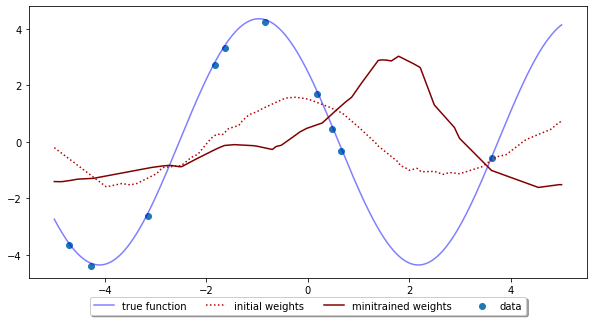

In [98]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

## Multiple plots

We plot the output for different sines, and we previously added some noise on the signal to slightly modify the outputs.

[4.9735565185546875, 8.868916511535645, 11.594517707824707, 19.72385597229004, 8.068214416503906, 2.9380242824554443, 0.683825671672821, 0.30218636989593506, 0.22589385509490967, 0.19409431517124176]
[4.993678092956543, 7.7740936279296875, 8.844135284423828, 11.951659202575684, 3.0218396186828613, 1.312934160232544, 0.5351731181144714, 0.40245240926742554, 0.330456405878067, 0.2879067659378052]


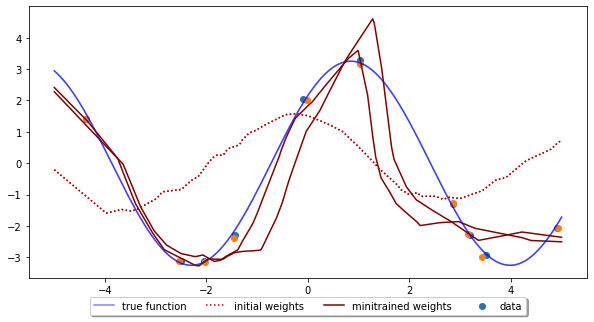

In [99]:
K=10
num_iterations = 1

og_net=maml.net.net
optim=torch.optim.SGD
lr=0.01
plt.figure(figsize=(10,5))
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
epsilon = 0.05
output_sum = [0 for i in range(1000)]

error = 0

x = x + epsilon*torch.randn(1, K, 1)
y= y + epsilon*torch.randn(1, K, 1)
outputs,axis=test(og_net,x,y,lr,optim)
plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)


for i in range(num_iterations):
    x = x + epsilon*torch.randn(1, K, 1)
    y= y + epsilon*torch.randn(1, K, 1)
    outputs,axis=test(og_net,x,y,lr,optim)
    #print(outputs['minitrained'])
    for k in range(1000):
        output_sum[k] += (outputs['minitrained'][k])
        
    a = outputs['minitrained']
    L = [] 
    for i in range(len(a)):
        L.append(a[i][0])
    L = np.array(L)
    
    error += np.linalg.norm(task.true_function(axis.cpu().clone().numpy()) - L)
    plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
    plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
    plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
    #plt.legend(loc='lower right')

error = error/num_iterations
output_sum = (np.array(output_sum)/num_iterations).tolist()
plt.show()

[1.5036447048187256, 4.464722156524658, 9.969161033630371, 7.0575103759765625, 12.427919387817383, 5.072767734527588, 2.283886432647705, 0.8045112490653992, 0.07490764558315277, 0.04810747876763344]
[1.4463856220245361, 4.377276420593262, 9.136608123779297, 6.917592525482178, 6.260183811187744, 1.6585029363632202, 0.14390401542186737, 0.11125602573156357, 0.0993991494178772, 0.08425655215978622]
[1.4787875413894653, 4.127725601196289, 9.905966758728027, 8.381363868713379, 16.160432815551758, 3.08736252784729, 2.6877832412719727, 2.5060951709747314, 0.43820279836654663, 0.1467791497707367]
[1.3828203678131104, 4.773489475250244, 9.888199806213379, 6.936380863189697, 10.847776412963867, 4.38294792175293, 1.374145269393921, 0.41361236572265625, 0.062225859612226486, 0.0378708578646183]
[1.3610961437225342, 4.372669696807861, 7.650936126708984, 5.81745719909668, 3.3604636192321777, 0.9014222025871277, 0.240794375538826, 0.19431492686271667, 0.17062202095985413, 0.1430804431438446]
[1.31143

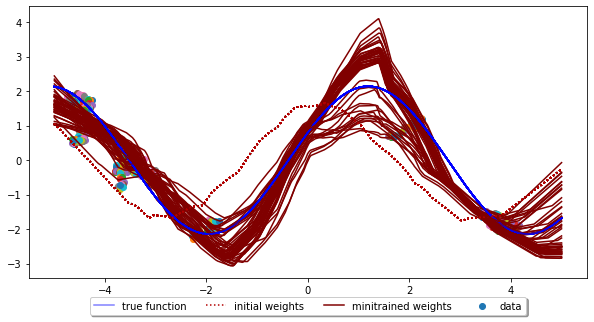

In [116]:
K=10
num_iterations = 50

og_net=maml.net.net
optim=torch.optim.SGD
lr=0.01
plt.figure(figsize=(10,5))
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
epsilon = 0.05
output_sum = [0 for i in range(1000)]

error = 0

x = x + epsilon*torch.randn(1, K, 1)
y= y + epsilon*torch.randn(1, K, 1)
outputs,axis=test(og_net,x,y,lr,optim)
plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)


for i in range(num_iterations):
    x = x + epsilon*torch.randn(1, K, 1)
    y= y + epsilon*torch.randn(1, K, 1)
    outputs,axis=test(og_net,x,y,lr,optim)
    #print(outputs['minitrained'])
    for k in range(1000):
        output_sum[k] += (outputs['minitrained'][k])
        
    a = outputs['minitrained']
    L = [] 
    for i in range(len(a)):
        L.append(a[i][0])
    L = np.array(L)
    
    error += np.linalg.norm(task.true_function(axis.cpu().clone().numpy()) - L)
    plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
    plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
    plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
    plt.plot(axis.cpu().clone().numpy(), outputs['minitrained'], '-', color=(0.5, 0, 0, 1), label='minitrained weights')
    #plt.legend(loc='lower right')

error = error/num_iterations
output_sum = (np.array(output_sum)/num_iterations).tolist()
plt.show()

In [117]:
print(error)

16.73030714035034


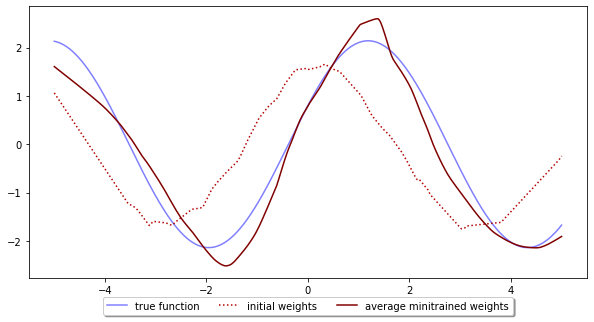

In [119]:
plt.figure(figsize=(10,5))
plt.plot(axis.cpu().clone().numpy(),task.true_function(axis.cpu().clone().numpy()), '-', color=(0, 0, 1, 0.5), label='true function')
#plt.scatter(x.cpu().clone().numpy(), y.cpu().clone().numpy(), label='data')
plt.plot(axis.cpu().clone().numpy(), outputs['initial'], ':', color=(0.7, 0, 0, 1), label='initial weights')
plt.plot(axis.cpu().clone().numpy(), output_sum, '-', color=(0.5, 0, 0, 1), label='average minitrained weights')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=5)

In [76]:
#num_iterations = 100
loss = []
K=10
og_net=maml.net.net
optim=torch.optim.SGD
lr=0.01
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
epsilon = 1

for num_iterations in range(1,2):
    output_sum = [0 for i in range(1000)]
    out = []
    for i in range(num_iterations):
        x = x + epsilon*torch.randn(1, K, 1)
        y= y + epsilon*torch.randn(1, K, 1)
        outputs,axis=test(og_net,x,y,lr,optim)
        for k in range(1000):
            output_sum[k] += (outputs['minitrained'][k])
    output_sum = (np.array(output_sum)/num_iterations).tolist()

    for i in range(len(output_sum)):
        out.append(output_sum[i][0])
    temp_loss = np.linalg.norm(np.array(out)- task.true_function(axis.cpu().clone().numpy()))
    if temp_loss<100:
        loss.append(temp_loss)
    else:
        print("Problem")

[4.747230529785156, 4.003901481628418, 6.315592288970947, 2.078484058380127, 0.9672094583511353, 0.7399012446403503, 0.6916038393974304, 0.590359091758728, 0.5561795830726624, 0.5093226432800293]


In [ ]:
#plt.plot([i for i in range(len(loss))],loss)

# Mean squared error

[0.306873619556427, 0.27529433369636536, 0.25630301237106323, 0.24395091831684113, 0.23544588685035706, 0.2290036380290985, 0.22464413940906525, 0.22106783092021942, 0.21823711693286896, 0.21571452915668488]


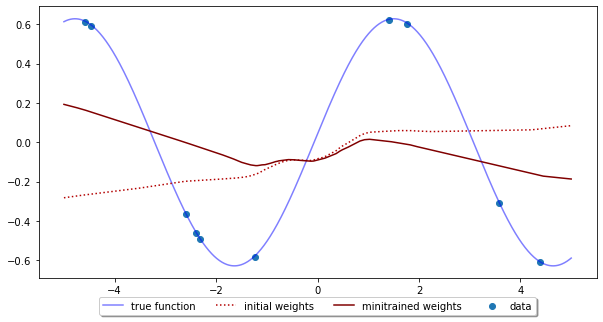

In [49]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

In [45]:
# Not the right one

K=10
num_iterations = 50
function_tasks = FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)

og_net=maml.net.net
optim=torch.optim.SGD
lr=0.01

global_error = 0
num_tests = 100
j = 0
count = 0
while j <=(num_tests):
    task=function_tasks.sample_task()
    x,y=task.sample_data(K)
    x=x.to(device)
    y=y.to(device)
    epsilon = 0.05

    error = 0

    for i in range(num_iterations):

        x = x + epsilon*torch.randn(1, K, 1)
        y= y + epsilon*torch.randn(1, K, 1)
        outputs,axis=test(og_net,x,y,lr,optim)
        
        a = outputs['minitrained']
        L = [] 
        for i in range(len(a)):
            L.append(a[i][0])
        L = np.array(L)
        error += np.linalg.norm(task.true_function(axis.cpu().clone().numpy()) - L)
    error = error/num_iterations
    if error < 1000 and error > -1000:
        global_error += error
        count +=1

    j+=1
print(count)
global_error = global_error/(count)

[1.2531956434249878, 0.7475202083587646, 0.5073488354682922, 0.38839033246040344, 0.33429938554763794, 0.3096993565559387, 0.2980746626853943, 0.29202717542648315, 0.28844138979911804, 0.28592973947525024]
[1.2431825399398804, 0.753546416759491, 0.5204429030418396, 0.4043957591056824, 0.3515690267086029, 0.3275173306465149, 0.31617581844329834, 0.31034043431282043, 0.3069005608558655, 0.3045125901699066]
[1.2305737733840942, 0.7605812549591064, 0.5344066619873047, 0.42075115442276, 0.3680375814437866, 0.34372150897979736, 0.33214184641838074, 0.32613247632980347, 0.3225599229335785, 0.3200841546058655]
[1.3005316257476807, 0.7871981859207153, 0.5381795167922974, 0.418208509683609, 0.3630709946155548, 0.3380284607410431, 0.3262596130371094, 0.32018157839775085, 0.3165431618690491, 0.31398266553878784]
[1.1960222721099854, 0.7278994917869568, 0.5065746903419495, 0.3972030282020569, 0.3476450741291046, 0.3251402974128723, 0.31449568271636963, 0.3088821470737457, 0.3050392270088196, 0.3021

[11.023454666137695, 9.073381423950195, 7.857701301574707, 6.933545112609863, 6.256458282470703, 5.81479024887085, 5.552055358886719, 5.4070611000061035, 5.312434673309326, 5.236392021179199]
[10.974916458129883, 9.080522537231445, 7.896004676818848, 6.992181301116943, 6.32324743270874, 5.877103328704834, 5.60780143737793, 5.457150459289551, 5.359523296356201, 5.283785820007324]
[10.753546714782715, 8.896441459655762, 7.73935079574585, 6.864923000335693, 6.219167232513428, 5.790122985839844, 5.5337934494018555, 5.3794965744018555, 5.281516075134277, 5.20390510559082]
[10.781390190124512, 8.939615249633789, 7.793037414550781, 6.928871154785156, 6.290799140930176, 5.869044303894043, 5.614583492279053, 5.457027435302734, 5.357084274291992, 5.277876377105713]
[10.73940372467041, 8.889371871948242, 7.741028785705566, 6.868119716644287, 6.225136756896973, 5.7972307205200195, 5.542416095733643, 5.391177177429199, 5.287376880645752, 5.201129913330078]
[10.874053955078125, 9.005714416503906, 7.

[6.852961540222168, 6.598523139953613, 6.378645420074463, 6.174752712249756, 5.986760139465332, 5.8107099533081055, 5.64388370513916, 5.4834723472595215, 5.336606502532959, 5.199960231781006]
[6.985161781311035, 6.736466884613037, 6.517652988433838, 6.3147430419921875, 6.1215596199035645, 5.945725440979004, 5.78012752532959, 5.623772621154785, 5.477011680603027, 5.343456745147705]
[6.93184757232666, 6.683587074279785, 6.469498634338379, 6.267735004425049, 6.0749335289001465, 5.897553443908691, 5.730986595153809, 5.574541091918945, 5.426966667175293, 5.291532516479492]
[6.880018711090088, 6.637509346008301, 6.428686618804932, 6.236235618591309, 6.048061847686768, 5.876593589782715, 5.7165632247924805, 5.564852714538574, 5.421722412109375, 5.2899651527404785]
[6.969077110290527, 6.720942497253418, 6.503426551818848, 6.301173210144043, 6.110963344573975, 5.932869911193848, 5.767507076263428, 5.611205101013184, 5.463785171508789, 5.328423500061035]
[6.890468597412109, 6.653981685638428, 6.

[6.60567569732666, 5.949792861938477, 5.593997001647949, 5.381985664367676, 5.242050647735596, 5.15846586227417, 5.107451438903809, 5.066791534423828, 5.031679153442383, 4.998729705810547]
[6.571628570556641, 5.9213032722473145, 5.56494665145874, 5.350805759429932, 5.20712947845459, 5.122138023376465, 5.06895637512207, 5.027035713195801, 4.991762638092041, 4.959060192108154]
[6.538478851318359, 5.879571914672852, 5.519958972930908, 5.304680824279785, 5.1591057777404785, 5.07649564743042, 5.024287223815918, 4.9828948974609375, 4.948136329650879, 4.916287422180176]
[6.487416744232178, 5.8548583984375, 5.507614612579346, 5.297872066497803, 5.154919624328613, 5.070328712463379, 5.016274452209473, 4.973801612854004, 4.938331604003906, 4.905289173126221]
[6.565073490142822, 5.932582855224609, 5.584054946899414, 5.373422622680664, 5.23077917098999, 5.146085262298584, 5.093228340148926, 5.050865650177002, 5.01509952545166, 4.982698917388916]
[6.62268590927124, 5.993006706237793, 5.639154434204

[6.562242031097412, 5.252345085144043, 4.411496162414551, 3.7965710163116455, 3.3633499145507812, 3.0771820545196533, 2.9035258293151855, 2.7989399433135986, 2.7353854179382324, 2.696946382522583]
[6.696316719055176, 5.333723545074463, 4.461267948150635, 3.8244099617004395, 3.3778693675994873, 3.0864248275756836, 2.9119181632995605, 2.8064589500427246, 2.7495877742767334, 2.7101118564605713]
[6.618988037109375, 5.315834999084473, 4.481649875640869, 3.8700149059295654, 3.4363949298858643, 3.1508290767669678, 2.976165294647217, 2.86909818649292, 2.8070242404937744, 2.7668237686157227]
[6.650819301605225, 5.307814598083496, 4.449740409851074, 3.822044849395752, 3.380249500274658, 3.0908989906311035, 2.917522668838501, 2.8125364780426025, 2.751718759536743, 2.713745355606079]
[6.653255462646484, 5.32981014251709, 4.489429950714111, 3.879803419113159, 3.4523544311523438, 3.1682629585266113, 2.9974277019500732, 2.896385669708252, 2.838209629058838, 2.7983615398406982]
[6.5948333740234375, 5.

[7.595143795013428, 7.200967311859131, 6.930717468261719, 6.738503932952881, 6.585543155670166, 6.449619293212891, 6.325442790985107, 6.216914653778076, 6.116257667541504, 6.007973670959473]
[7.491748809814453, 7.093341827392578, 6.820700168609619, 6.634426116943359, 6.487479209899902, 6.3634443283081055, 6.243738174438477, 6.127162456512451, 6.0193681716918945, 5.911686897277832]
[7.479208946228027, 7.080920219421387, 6.8169450759887695, 6.640738487243652, 6.499967098236084, 6.382870674133301, 6.273803234100342, 6.16693639755249, 6.070769309997559, 5.974001407623291]
[7.570862770080566, 7.159065246582031, 6.881592750549316, 6.699437141418457, 6.557044982910156, 6.430347442626953, 6.316083908081055, 6.219816207885742, 6.129026889801025, 6.036065101623535]
[7.651103973388672, 7.251378059387207, 6.9870123863220215, 6.810349941253662, 6.675614833831787, 6.555002689361572, 6.45330810546875, 6.34934663772583, 6.245928764343262, 6.155206680297852]
[7.589242458343506, 7.210805416107178, 6.960

[7.52276086807251, 7.118138790130615, 6.850094795227051, 6.660727024078369, 6.503786563873291, 6.372622489929199, 6.254266262054443, 6.1261138916015625, 6.006067752838135, 5.890728950500488]
[7.606008052825928, 7.209597110748291, 6.951085090637207, 6.767117500305176, 6.60973596572876, 6.480335235595703, 6.361313819885254, 6.235569000244141, 6.1147871017456055, 6.00229024887085]
[7.653256893157959, 7.251628875732422, 6.987271785736084, 6.801216125488281, 6.642175197601318, 6.51077127456665, 6.390593528747559, 6.265639781951904, 6.141152381896973, 6.026920795440674]
[7.694579124450684, 7.295693874359131, 7.03469181060791, 6.8498029708862305, 6.691158294677734, 6.561103820800781, 6.438833713531494, 6.306203365325928, 6.181508541107178, 6.062129974365234]
[7.683106899261475, 7.28347635269165, 7.022255897521973, 6.832667350769043, 6.676380157470703, 6.551100254058838, 6.429385185241699, 6.299729347229004, 6.177636623382568, 6.06292200088501]
[7.734705924987793, 7.32681131362915, 7.058804988

[2.544891119003296, 2.0261521339416504, 1.756049394607544, 1.5965741872787476, 1.495450496673584, 1.4277079105377197, 1.38343346118927, 1.3532426357269287, 1.3313591480255127, 1.311447262763977]
[2.562476634979248, 2.0638136863708496, 1.80740487575531, 1.6597121953964233, 1.5647953748703003, 1.501072883605957, 1.4603943824768066, 1.4332358837127686, 1.410883903503418, 1.3936381340026855]
[2.5146336555480957, 2.0285847187042236, 1.7777831554412842, 1.6329553127288818, 1.5392051935195923, 1.4790817499160767, 1.4375629425048828, 1.4099552631378174, 1.3881874084472656, 1.3711289167404175]
[2.5859646797180176, 2.092134952545166, 1.8342031240463257, 1.6853828430175781, 1.5873730182647705, 1.5235157012939453, 1.4816019535064697, 1.452187180519104, 1.4299565553665161, 1.4102928638458252]
[2.6583714485168457, 2.1634531021118164, 1.9097893238067627, 1.7640613317489624, 1.669881820678711, 1.6062568426132202, 1.5660204887390137, 1.5372917652130127, 1.5154814720153809, 1.4982306957244873]
[2.602845

[0.683198094367981, 0.6645486950874329, 0.6509143114089966, 0.6408986449241638, 0.6329733729362488, 0.6273861527442932, 0.6223829388618469, 0.6177444458007812, 0.6133444905281067, 0.6090548038482666]
[0.6612240076065063, 0.6424188017845154, 0.6291831731796265, 0.6192055344581604, 0.6114662885665894, 0.6053785085678101, 0.6004866361618042, 0.5959707498550415, 0.5917139053344727, 0.5875637531280518]
[0.6780492663383484, 0.6528819799423218, 0.6357529759407043, 0.6241304874420166, 0.6155526041984558, 0.6094197034835815, 0.6044367551803589, 0.6000011563301086, 0.5958874821662903, 0.5919672250747681]
[0.6807355284690857, 0.6569241285324097, 0.6403886079788208, 0.6287271976470947, 0.6198801398277283, 0.6133520007133484, 0.6080324649810791, 0.6032029390335083, 0.5986627340316772, 0.59432452917099]
[0.6607707738876343, 0.6358356475830078, 0.6185785531997681, 0.6065138578414917, 0.5973933935165405, 0.5902848839759827, 0.5848484635353088, 0.5799727439880371, 0.5754131078720093, 0.5710488557815552

[4.114916801452637, 3.089240550994873, 2.6025595664978027, 2.377934694290161, 2.274754285812378, 2.2256600856781006, 2.197899341583252, 2.1825790405273438, 2.170699119567871, 2.160130023956299]
[4.218888759613037, 3.2035164833068848, 2.717507839202881, 2.48987078666687, 2.3837409019470215, 2.333608388900757, 2.302806854248047, 2.2858242988586426, 2.271367311477661, 2.2580714225769043]
[4.366141319274902, 3.3214221000671387, 2.8176538944244385, 2.5795345306396484, 2.4679553508758545, 2.416105031967163, 2.3829903602600098, 2.3651604652404785, 2.350236415863037, 2.336268663406372]
[4.4585771560668945, 3.3943381309509277, 2.874451160430908, 2.6243433952331543, 2.5058205127716064, 2.4503257274627686, 2.4163994789123535, 2.3978989124298096, 2.3828015327453613, 2.3685731887817383]
[4.51401424407959, 3.4437904357910156, 2.923212766647339, 2.6732239723205566, 2.5549349784851074, 2.498654842376709, 2.4652256965637207, 2.4465365409851074, 2.431016206741333, 2.4163520336151123]
[4.536847114562988,

[0.4329946041107178, 0.38828930258750916, 0.36105766892433167, 0.34435153007507324, 0.33468881249427795, 0.32877153158187866, 0.32441064715385437, 0.32014185190200806, 0.3165305554866791, 0.31336385011672974]
[0.4336278438568115, 0.3936787545681, 0.3690492510795593, 0.3537093698978424, 0.34451884031295776, 0.33877691626548767, 0.33399730920791626, 0.32965710759162903, 0.3259480595588684, 0.3228362202644348]
[0.4373158812522888, 0.3974524140357971, 0.37274685502052307, 0.35730332136154175, 0.3479727804660797, 0.3421972692012787, 0.33729496598243713, 0.33331477642059326, 0.32954612374305725, 0.3261527419090271]
[0.4464627206325531, 0.40236377716064453, 0.3744155764579773, 0.35712167620658875, 0.3470532298088074, 0.3407415747642517, 0.33618393540382385, 0.33199092745780945, 0.32800525426864624, 0.3243691325187683]
[0.46866822242736816, 0.4154157042503357, 0.38222378492355347, 0.36186808347702026, 0.3496968746185303, 0.34172773361206055, 0.336147665977478, 0.33184388279914856, 0.3277340531

[0.6403864026069641, 0.5540157556533813, 0.5040718913078308, 0.47566476464271545, 0.45958250761032104, 0.4495757520198822, 0.4427037239074707, 0.4376096725463867, 0.43350404500961304, 0.4300682544708252]
[0.6678825616836548, 0.58208829164505, 0.5333239436149597, 0.5058789253234863, 0.4901247024536133, 0.4801999628543854, 0.47347331047058105, 0.4684671461582184, 0.4644203186035156, 0.4611002802848816]
[0.6462457776069641, 0.5636031627655029, 0.516711413860321, 0.4903731942176819, 0.47539860010147095, 0.4660305082798004, 0.459660142660141, 0.4548865258693695, 0.45103082060813904, 0.44767817854881287]
[2.402488946914673, 1.9432138204574585, 1.744573950767517, 1.6494840383529663, 1.5965893268585205, 1.5632188320159912, 1.5412423610687256, 1.5237008333206177, 1.5087053775787354, 1.4960057735443115]
[2.37725567817688, 1.92600417137146, 1.7306312322616577, 1.6367582082748413, 1.5848031044006348, 1.552612066268921, 1.52950119972229, 1.5131016969680786, 1.4976365566253662, 1.4840596914291382]
[

[4.282366752624512, 4.029270172119141, 3.8217270374298096, 3.6369566917419434, 3.4828295707702637, 3.346947193145752, 3.2284960746765137, 3.1271755695343018, 3.0418930053710938, 2.9700875282287598]
[4.271266937255859, 4.022243022918701, 3.8187918663024902, 3.6382102966308594, 3.4877591133117676, 3.355255603790283, 3.239354372024536, 3.139902114868164, 3.0551822185516357, 2.9844794273376465]
[4.399096488952637, 4.14063835144043, 3.9277420043945312, 3.7405173778533936, 3.5823211669921875, 3.4414010047912598, 3.317561626434326, 3.21110200881958, 3.119337558746338, 3.0424933433532715]
[4.301030158996582, 4.048699855804443, 3.834005355834961, 3.6594791412353516, 3.505558490753174, 3.3696014881134033, 3.2503325939178467, 3.14750337600708, 3.0590872764587402, 2.9849729537963867]
[4.325053691864014, 4.077649116516113, 3.868340015411377, 3.697924852371216, 3.547234296798706, 3.4134814739227295, 3.2958245277404785, 3.1941490173339844, 3.106394052505493, 3.0329325199127197]
[4.245902061462402, 4.

[1.7112563848495483, 1.571692705154419, 1.4768813848495483, 1.4046300649642944, 1.3505827188491821, 1.3083254098892212, 1.273207664489746, 1.245376467704773, 1.2236335277557373, 1.2044994831085205]
[1.6848493814468384, 1.548280119895935, 1.4534803628921509, 1.3816546201705933, 1.3281662464141846, 1.2861449718475342, 1.2511991262435913, 1.2243053913116455, 1.2015564441680908, 1.182268738746643]
[1.6422208547592163, 1.5075292587280273, 1.4124374389648438, 1.3422008752822876, 1.2898426055908203, 1.2488256692886353, 1.2149204015731812, 1.1871849298477173, 1.1655458211898804, 1.1481881141662598]
[1.651178002357483, 1.51811683177948, 1.4287328720092773, 1.3604567050933838, 1.3096916675567627, 1.2692514657974243, 1.236246943473816, 1.2102267742156982, 1.1902151107788086, 1.1738533973693848]
[1.5900201797485352, 1.462854266166687, 1.376700758934021, 1.3105071783065796, 1.260744571685791, 1.2213791608810425, 1.1892993450164795, 1.1630151271820068, 1.1420618295669556, 1.124779462814331]
[1.67847

[3.372086763381958, 3.2273921966552734, 3.1040279865264893, 2.9942429065704346, 2.895739793777466, 2.80517315864563, 2.720874309539795, 2.6412086486816406, 2.565992593765259, 2.493908405303955]
[3.3269381523132324, 3.178074836730957, 3.050985336303711, 2.9379284381866455, 2.8371071815490723, 2.7443721294403076, 2.658177375793457, 2.5772266387939453, 2.4990432262420654, 2.424661159515381]
[3.3307933807373047, 3.181976079940796, 3.055487632751465, 2.9425535202026367, 2.841811180114746, 2.748399019241333, 2.6620237827301025, 2.5804495811462402, 2.503391742706299, 2.4300475120544434]
[3.261645555496216, 3.120185375213623, 2.997556447982788, 2.887268543243408, 2.7893924713134766, 2.697458267211914, 2.611504554748535, 2.531160831451416, 2.4547266960144043, 2.3828608989715576]
[3.272516965866089, 3.1277177333831787, 3.001945734024048, 2.8898205757141113, 2.7883968353271484, 2.69450306892395, 2.6073522567749023, 2.5248312950134277, 2.447103977203369, 2.3744823932647705]
[3.2683587074279785, 3.

[6.7028374671936035, 6.595952033996582, 6.5061540603637695, 6.429510593414307, 6.363217830657959, 6.297211647033691, 6.231244087219238, 6.164962291717529, 6.098927974700928, 6.034794807434082]
[6.806818962097168, 6.698002815246582, 6.606371879577637, 6.530037879943848, 6.462349891662598, 6.395710468292236, 6.3301591873168945, 6.264069080352783, 6.197775840759277, 6.1328840255737305]
[6.787010192871094, 6.687430381774902, 6.6027326583862305, 6.530900478363037, 6.467288970947266, 6.403271675109863, 6.339836120605469, 6.275573253631592, 6.212741374969482, 6.149209022521973]
[7.871034145355225, 7.630789279937744, 7.417752265930176, 7.210755825042725, 7.050451755523682, 6.89639949798584, 6.743185520172119, 6.593667030334473, 6.446238040924072, 6.300047874450684]
[7.717301368713379, 7.477038383483887, 7.253910064697266, 7.051163673400879, 6.886913299560547, 6.728353023529053, 6.5709028244018555, 6.414999961853027, 6.263927459716797, 6.1106157302856445]
[7.844490051269531, 7.600527763366699, 

[7.3459062576293945, 7.094370365142822, 6.853356838226318, 6.655938625335693, 6.471909999847412, 6.291136741638184, 6.107224464416504, 5.923482418060303, 5.737225532531738, 5.546472549438477]
[7.430916786193848, 7.152324676513672, 6.9083147048950195, 6.710366725921631, 6.516609191894531, 6.32459020614624, 6.1319780349731445, 5.935511112213135, 5.737443447113037, 5.530066013336182]
[7.459124565124512, 7.195289611816406, 6.949296474456787, 6.756218910217285, 6.567797660827637, 6.379073143005371, 6.191127777099609, 5.998201370239258, 5.804158687591553, 5.603257179260254]
[7.460340976715088, 7.202882289886475, 6.960417747497559, 6.771712303161621, 6.588503837585449, 6.4051666259765625, 6.223030090332031, 6.038491249084473, 5.8532185554504395, 5.664282321929932]
[7.500257968902588, 7.241355895996094, 6.995790958404541, 6.8030104637146, 6.614211082458496, 6.421306610107422, 6.225548267364502, 6.037412643432617, 5.85152530670166, 5.66374397277832]
[7.453782558441162, 7.18969202041626, 6.94074

[2.0386199951171875, 1.7510344982147217, 1.59373939037323, 1.5039329528808594, 1.4498317241668701, 1.4185762405395508, 1.395524024963379, 1.3763519525527954, 1.3636614084243774, 1.3522803783416748]
[2.111537456512451, 1.8159360885620117, 1.6540371179580688, 1.5603998899459839, 1.5036827325820923, 1.47096586227417, 1.4443384408950806, 1.4274086952209473, 1.4139349460601807, 1.4019486904144287]
[2.061263084411621, 1.7593015432357788, 1.5939290523529053, 1.4985241889953613, 1.4404338598251343, 1.4062325954437256, 1.3798199892044067, 1.3630622625350952, 1.349861741065979, 1.3383705615997314]
[2.091665506362915, 1.793763518333435, 1.631757378578186, 1.5385334491729736, 1.4821174144744873, 1.4504550695419312, 1.4271821975708008, 1.4072203636169434, 1.3939814567565918, 1.3824021816253662]
[2.121764659881592, 1.822447419166565, 1.6597659587860107, 1.5664269924163818, 1.5105822086334229, 1.4788167476654053, 1.4553728103637695, 1.4350237846374512, 1.4216934442520142, 1.4100443124771118]
[2.12933

[2.0897347927093506, 1.2967604398727417, 0.936446487903595, 0.769968569278717, 0.689902663230896, 0.6483839750289917, 0.6259591579437256, 0.6123833656311035, 0.6021426916122437, 0.5920963287353516]
[2.122488260269165, 1.3423269987106323, 0.9899152517318726, 0.8273104429244995, 0.7479040622711182, 0.7056915760040283, 0.6822545528411865, 0.6664958000183105, 0.6535221934318542, 0.6439672708511353]
[2.134136915206909, 1.3397634029388428, 0.9760504961013794, 0.8068930506706238, 0.7247272729873657, 0.6806950569152832, 0.6564579010009766, 0.6417645812034607, 0.6299852728843689, 0.6203721165657043]
[2.159064531326294, 1.3481470346450806, 0.9857145547866821, 0.822790265083313, 0.743694007396698, 0.7022668719291687, 0.679660439491272, 0.665391206741333, 0.6548061370849609, 0.644584596157074]
[2.1326053142547607, 1.3161826133728027, 0.954306960105896, 0.7907528877258301, 0.7155711650848389, 0.6770936846733093, 0.6560124158859253, 0.6421324610710144, 0.6301096677780151, 0.6200972199440002]
[2.1888

[2.886709213256836, 2.710272789001465, 2.5750489234924316, 2.4693031311035156, 2.384105682373047, 2.315441846847534, 2.254127025604248, 2.2001216411590576, 2.1508407592773438, 2.1033501625061035]
[2.821498394012451, 2.639148235321045, 2.50191068649292, 2.3950400352478027, 2.308748960494995, 2.2391228675842285, 2.1771013736724854, 2.1205224990844727, 2.068458080291748, 2.0234875679016113]
[2.823789119720459, 2.6425251960754395, 2.5060975551605225, 2.4019060134887695, 2.3173747062683105, 2.2479007244110107, 2.1841278076171875, 2.1280620098114014, 2.0766987800598145, 2.031949520111084]
[2.8036153316497803, 2.619809150695801, 2.4817254543304443, 2.377166509628296, 2.2926909923553467, 2.2226243019104004, 2.1598029136657715, 2.105318784713745, 2.055211067199707, 2.0115346908569336]
[2.7806665897369385, 2.6013777256011963, 2.4666073322296143, 2.363654136657715, 2.278993844985962, 2.209796190261841, 2.1479010581970215, 2.0938079357147217, 2.044004201889038, 2.000392436981201]
[2.77983188629150

[0.5015877485275269, 0.4680265486240387, 0.4441303610801697, 0.42327308654785156, 0.40552037954330444, 0.3900713622570038, 0.3770250976085663, 0.3669728636741638, 0.3579813539981842, 0.35094770789146423]
[0.5070702433586121, 0.47260135412216187, 0.4453534483909607, 0.42319101095199585, 0.40439075231552124, 0.3882324695587158, 0.3761312663555145, 0.3654927611351013, 0.35638007521629333, 0.3493881821632385]
[0.48776644468307495, 0.457073450088501, 0.43147483468055725, 0.4103574752807617, 0.392361581325531, 0.37690025568008423, 0.365294873714447, 0.35506969690322876, 0.3460116684436798, 0.3392588496208191]
[0.530198335647583, 0.4944315552711487, 0.4659036099910736, 0.4426838755607605, 0.4230400025844574, 0.4062565863132477, 0.39365530014038086, 0.382587730884552, 0.3738657534122467, 0.3665763735771179]
[0.5153740048408508, 0.47842463850975037, 0.45031437277793884, 0.42774224281311035, 0.40868130326271057, 0.39247119426727295, 0.38025450706481934, 0.36951327323913574, 0.36079156398773193, 

[0.2869971692562103, 0.27615904808044434, 0.2698303759098053, 0.26549431681632996, 0.26225095987319946, 0.25967085361480713, 0.257493257522583, 0.25557631254196167, 0.2539837658405304, 0.2526070177555084]
[0.264879047870636, 0.2543835937976837, 0.2480667382478714, 0.24364647269248962, 0.24028387665748596, 0.23756547272205353, 0.2353164404630661, 0.23342061042785645, 0.23179903626441956, 0.23040008544921875]
[0.26716428995132446, 0.25721532106399536, 0.25125035643577576, 0.24698157608509064, 0.24374905228614807, 0.2411506175994873, 0.2389858216047287, 0.23714196681976318, 0.2355547398328781, 0.23419494926929474]
[0.2598969042301178, 0.25138458609580994, 0.24614644050598145, 0.24233202636241913, 0.23935937881469727, 0.23693379759788513, 0.23489446938037872, 0.2331516295671463, 0.23170530796051025, 0.23042035102844238]
[0.2684921622276306, 0.2596949338912964, 0.2540140748023987, 0.2497331202030182, 0.24632307887077332, 0.24350416660308838, 0.24112746119499207, 0.23917055130004883, 0.23742

[7.887994289398193, 4.729384422302246, 3.5279202461242676, 3.228719711303711, 3.19008731842041, 3.1825361251831055, 3.1786487102508545, 3.1759917736053467, 3.172342300415039, 3.1680047512054443]
[7.925861358642578, 4.725796699523926, 3.4985461235046387, 3.189666271209717, 3.1506893634796143, 3.14349365234375, 3.1398093700408936, 3.1368579864501953, 3.1322617530822754, 3.1303176879882812]
[8.008475303649902, 4.775243759155273, 3.536975383758545, 3.2278175354003906, 3.1893768310546875, 3.1820626258850098, 3.179133892059326, 3.175278425216675, 3.1710076332092285, 3.169016122817993]
[8.079834938049316, 4.815808296203613, 3.5557422637939453, 3.237804412841797, 3.198336362838745, 3.1903586387634277, 3.186457872390747, 3.182547092437744, 3.1778111457824707, 3.175513505935669]
[8.159335136413574, 4.912583351135254, 3.630646228790283, 3.287328004837036, 3.2421584129333496, 3.2345032691955566, 3.2302048206329346, 3.225576400756836, 3.2225146293640137, 3.2178337574005127]
[8.037646293640137, 4.91

[9.040765762329102, 5.39055871963501, 3.957038402557373, 3.5437798500061035, 3.487919569015503, 3.4798076152801514, 3.471193313598633, 3.464681625366211, 3.4588840007781982, 3.451061248779297]
[8.717035293579102, 5.211364269256592, 3.8277714252471924, 3.4190311431884766, 3.358644962310791, 3.348752975463867, 3.339752197265625, 3.3326408863067627, 3.3260295391082764, 3.3192851543426514]
[8.669493675231934, 5.272557258605957, 3.917560577392578, 3.5068564414978027, 3.442894458770752, 3.4309639930725098, 3.424988269805908, 3.416839599609375, 3.4112980365753174, 3.4052653312683105]
[8.64231014251709, 5.214333534240723, 3.843005657196045, 3.4268298149108887, 3.3624653816223145, 3.3521664142608643, 3.3433754444122314, 3.3366482257843018, 3.3302817344665527, 3.323909044265747]
[3.520453929901123, 3.079223155975342, 2.8318588733673096, 2.6752705574035645, 2.5465705394744873, 2.4455060958862305, 2.3591675758361816, 2.279789924621582, 2.205982208251953, 2.1369175910949707]
[3.5576171875, 3.120106

[4.125648498535156, 3.7110118865966797, 3.4707484245300293, 3.3116040229797363, 3.175978899002075, 3.0700697898864746, 2.970639705657959, 2.8778932094573975, 2.7946829795837402, 2.710542917251587]
[4.086888313293457, 3.692028522491455, 3.4614968299865723, 3.307638168334961, 3.1760144233703613, 3.072096347808838, 2.9746387004852295, 2.880995035171509, 2.7947745323181152, 2.712231397628784]
[3.993483781814575, 3.600144147872925, 3.3713574409484863, 3.21970796585083, 3.0903353691101074, 2.986762523651123, 2.8908963203430176, 2.7995686531066895, 2.7165844440460205, 2.636354446411133]
[4.034800052642822, 3.66113543510437, 3.4408087730407715, 3.2949271202087402, 3.16926908493042, 3.0634686946868896, 2.972621440887451, 2.885359764099121, 2.7998085021972656, 2.715869665145874]
[4.018750190734863, 3.6456387042999268, 3.425968885421753, 3.280177593231201, 3.154546022415161, 3.0497143268585205, 2.9627251625061035, 2.872990369796753, 2.7884509563446045, 2.7092723846435547]
[4.036822319030762, 3.63

[7.912587642669678, 7.154250144958496, 6.642420291900635, 6.2488908767700195, 5.911089897155762, 5.631611347198486, 5.379919052124023, 5.147356986999512, 4.94038200378418, 4.750672340393066]
[8.119646072387695, 7.319337368011475, 6.7801408767700195, 6.361461162567139, 6.004843711853027, 5.7050251960754395, 5.437209129333496, 5.195971488952637, 4.9805097579956055, 4.78385066986084]
[8.142558097839355, 7.352086544036865, 6.815877437591553, 6.401610374450684, 6.0458502769470215, 5.74783182144165, 5.476968288421631, 5.233374118804932, 5.016946792602539, 4.8167405128479]
[8.118439674377441, 7.29504919052124, 6.752174377441406, 6.323573112487793, 5.961120128631592, 5.6596550941467285, 5.389985084533691, 5.147510528564453, 4.933310508728027, 4.738122463226318]
[8.20936393737793, 7.3721160888671875, 6.82186222076416, 6.3873796463012695, 6.022110939025879, 5.716589450836182, 5.441204071044922, 5.198680877685547, 4.976653575897217, 4.777212142944336]
[8.053425788879395, 7.2174248695373535, 6.673

[3.820746898651123, 3.5237209796905518, 3.3869376182556152, 3.309234619140625, 3.264763593673706, 3.233522415161133, 3.210296154022217, 3.1915411949157715, 3.1760826110839844, 3.1648950576782227]
[3.9514098167419434, 3.6339728832244873, 3.4860687255859375, 3.4065825939178467, 3.3601508140563965, 3.327622175216675, 3.3046772480010986, 3.2839584350585938, 3.269362211227417, 3.2544257640838623]
[3.966036319732666, 3.643510341644287, 3.4865927696228027, 3.40722393989563, 3.3630423545837402, 3.33227801322937, 3.309790849685669, 3.2896485328674316, 3.2749648094177246, 3.2599167823791504]
[3.875352382659912, 3.5666027069091797, 3.423663377761841, 3.3436591625213623, 3.3010413646698, 3.2733490467071533, 3.2518463134765625, 3.2337374687194824, 3.220890522003174, 3.2060062885284424]
[3.8025882244110107, 3.495739698410034, 3.352647304534912, 3.2722907066345215, 3.229106903076172, 3.20129132270813, 3.178877592086792, 3.1627771854400635, 3.1472043991088867, 3.134721040725708]
[3.753526210784912, 3.

[3.950155258178711, 3.6382670402526855, 3.4412524700164795, 3.290177583694458, 3.180591106414795, 3.083829879760742, 2.9947476387023926, 2.9080231189727783, 2.8203585147857666, 2.7427639961242676]
[3.9176669120788574, 3.6189723014831543, 3.4272866249084473, 3.283489942550659, 3.1719231605529785, 3.076009511947632, 2.988487958908081, 2.9050233364105225, 2.8181490898132324, 2.73844575881958]
[3.9746837615966797, 3.669311046600342, 3.4716849327087402, 3.3186192512512207, 3.207099199295044, 3.106921434402466, 3.0153536796569824, 2.9262518882751465, 2.8365213871002197, 2.7555925846099854]
[3.98209810256958, 3.6821625232696533, 3.4864914417266846, 3.334641695022583, 3.224531650543213, 3.125152826309204, 3.033600330352783, 2.9446499347686768, 2.8558123111724854, 2.775575637817383]
[4.108338356018066, 3.7955803871154785, 3.5925796031951904, 3.43621826171875, 3.322748899459839, 3.218721866607666, 3.1220715045928955, 3.0282156467437744, 2.93420672416687, 2.8507556915283203]
[4.176126003265381, 3

[7.965071678161621, 7.4943437576293945, 7.205954074859619, 7.0080413818359375, 6.868447303771973, 6.76764440536499, 6.685643196105957, 6.622821807861328, 6.565059661865234, 6.511659145355225]
[7.897745609283447, 7.432321071624756, 7.145571708679199, 6.948202610015869, 6.811118125915527, 6.709935188293457, 6.631106376647949, 6.567261695861816, 6.5108537673950195, 6.461584568023682]
[7.967391014099121, 7.5303521156311035, 7.257021427154541, 7.068926811218262, 6.934375762939453, 6.8367438316345215, 6.7578253746032715, 6.694584846496582, 6.638306617736816, 6.587119102478027]
[8.067896842956543, 7.608038425445557, 7.31874942779541, 7.1207075119018555, 6.979676723480225, 6.877824306488037, 6.797459602355957, 6.733141899108887, 6.676393985748291, 6.625563621520996]
[8.088420867919922, 7.646475791931152, 7.3680243492126465, 7.176400184631348, 7.038016319274902, 6.939698219299316, 6.858633518218994, 6.794397830963135, 6.7377471923828125, 6.6852545738220215]
[8.245157241821289, 7.800715446472168

[7.857762336730957, 7.36794376373291, 7.0620903968811035, 6.8483123779296875, 6.698877811431885, 6.58959436416626, 6.50951623916626, 6.447751522064209, 6.394402027130127, 6.351605415344238]
[7.653965950012207, 7.1573486328125, 6.846218109130859, 6.629918575286865, 6.476663112640381, 6.364627361297607, 6.281999588012695, 6.217413902282715, 6.163949012756348, 6.116080284118652]
[1.138942003250122, 1.04165518283844, 0.9728037118911743, 0.9235386848449707, 0.8864073753356934, 0.85859215259552, 0.8373260498046875, 0.8209449052810669, 0.8076419830322266, 0.7966135144233704]
[1.1466131210327148, 1.0511027574539185, 0.9830314517021179, 0.9342265129089355, 0.8972681760787964, 0.8698198199272156, 0.8485726118087769, 0.8322153091430664, 0.8190608024597168, 0.8079687356948853]
[1.1166812181472778, 1.0248847007751465, 0.960279643535614, 0.9138740301132202, 0.8786866068840027, 0.8526310920715332, 0.8324699401855469, 0.8171852827072144, 0.8046872019767761, 0.7944516539573669]
[1.1285426616668701, 1.0

[0.9882041811943054, 0.878373920917511, 0.8021079897880554, 0.747657299041748, 0.7083545923233032, 0.6797289848327637, 0.6580983400344849, 0.6414663195610046, 0.6282787919044495, 0.6176786422729492]
[1.0302339792251587, 0.9209696054458618, 0.8447983860969543, 0.7904266715049744, 0.7508178949356079, 0.7222646474838257, 0.7006861567497253, 0.6841747760772705, 0.670945405960083, 0.659977376461029]
[1.0890588760375977, 0.9727533459663391, 0.8918994665145874, 0.8340684771537781, 0.7925193905830383, 0.7621979117393494, 0.7399634718894958, 0.7226341962814331, 0.7085940837860107, 0.6971956491470337]
[1.0641746520996094, 0.9538986086845398, 0.8769755363464355, 0.8221321105957031, 0.7822802066802979, 0.7533594369888306, 0.731395423412323, 0.7145892381668091, 0.7012741565704346, 0.6901724338531494]
[1.0288312435150146, 0.9257284998893738, 0.8535079956054688, 0.8016701936721802, 0.7640778422355652, 0.7366350293159485, 0.7159169316291809, 0.6996275186538696, 0.6868230700492859, 0.6763006448745728]


[0.34795743227005005, 0.34005206823349, 0.33365216851234436, 0.3282269835472107, 0.3234914541244507, 0.31935781240463257, 0.31571608781814575, 0.3123190402984619, 0.3092510402202606, 0.3062678277492523]
[0.3800166845321655, 0.372428834438324, 0.3660445511341095, 0.36046886444091797, 0.35549649596214294, 0.35100632905960083, 0.3470119833946228, 0.34334102272987366, 0.3398924469947815, 0.33667677640914917]
[0.37793686985969543, 0.37133267521858215, 0.3654928505420685, 0.36017361283302307, 0.355219304561615, 0.3506326675415039, 0.3466748595237732, 0.34295153617858887, 0.3393765091896057, 0.33591774106025696]
[0.3728230595588684, 0.36538535356521606, 0.3590611219406128, 0.3533916473388672, 0.34819069504737854, 0.34338533878326416, 0.33922702074050903, 0.3351871073246002, 0.331350177526474, 0.3275543749332428]
[0.3567461371421814, 0.3471115231513977, 0.33955711126327515, 0.33328530192375183, 0.32785695791244507, 0.32305198907852173, 0.31887730956077576, 0.3150636553764343, 0.311401873826980

[3.971437931060791, 3.8496785163879395, 3.75103497505188, 3.6813671588897705, 3.6211166381835938, 3.5688788890838623, 3.5279078483581543, 3.4869892597198486, 3.4535465240478516, 3.4191107749938965]
[3.984846830368042, 3.863215684890747, 3.7685024738311768, 3.6963486671447754, 3.635031223297119, 3.582373857498169, 3.5412936210632324, 3.4986319541931152, 3.464509963989258, 3.4306159019470215]
[4.021323204040527, 3.8897545337677, 3.7865822315216064, 3.7105934619903564, 3.647005558013916, 3.592672348022461, 3.5488505363464355, 3.505537748336792, 3.4690589904785156, 3.4320735931396484]
[3.880718231201172, 3.7505428791046143, 3.649170398712158, 3.578317642211914, 3.517374038696289, 3.464967727661133, 3.4226176738739014, 3.3811657428741455, 3.3469748497009277, 3.313798189163208]
[3.7545807361602783, 3.6304078102111816, 3.533451557159424, 3.465303897857666, 3.4083614349365234, 3.3582191467285156, 3.318223476409912, 3.279308319091797, 3.2465453147888184, 3.214931011199951]
[3.801177501678467, 3

[7.063309669494629, 6.517274379730225, 6.093499183654785, 5.733834266662598, 5.407373905181885, 5.101859092712402, 4.8050217628479, 4.530690670013428, 4.276209354400635, 4.045060634613037]
[7.012383937835693, 6.479602813720703, 6.058950901031494, 5.6980156898498535, 5.373803615570068, 5.065898895263672, 4.7662224769592285, 4.4894185066223145, 4.234756946563721, 3.9999375343322754]
[6.861767768859863, 6.332959175109863, 5.923251152038574, 5.567049503326416, 5.247794151306152, 4.9498090744018555, 4.660561561584473, 4.391918659210205, 4.145909309387207, 3.9239373207092285]
[6.8860883712768555, 6.347619533538818, 5.924160957336426, 5.561561584472656, 5.233386039733887, 4.925225257873535, 4.629787921905518, 4.357000827789307, 4.104865550994873, 3.877107620239258]
[6.877952575683594, 6.330472469329834, 5.9066667556762695, 5.536801815032959, 5.208788871765137, 4.898385524749756, 4.607992172241211, 4.333886623382568, 4.082686424255371, 3.8559982776641846]
[6.78170919418335, 6.250004768371582, 

[13.736944198608398, 11.987958908081055, 10.947575569152832, 10.19499397277832, 9.6844482421875, 9.312013626098633, 9.032493591308594, 8.79659366607666, 8.5730562210083, 8.357367515563965]
[13.72192668914795, 11.98426628112793, 10.960713386535645, 10.231630325317383, 9.737571716308594, 9.383340835571289, 9.116312980651855, 8.892950057983398, 8.683785438537598, 8.474447250366211]
[13.76051139831543, 12.028341293334961, 11.009407043457031, 10.286046028137207, 9.79502010345459, 9.442086219787598, 9.176458358764648, 8.952310562133789, 8.736109733581543, 8.523224830627441]
[13.753222465515137, 12.050313949584961, 11.054520606994629, 10.35293197631836, 9.878667831420898, 9.539068222045898, 9.278833389282227, 9.057470321655273, 8.851448059082031, 8.646539688110352]
[13.601719856262207, 11.883295059204102, 10.880517959594727, 10.16707706451416, 9.683835983276367, 9.331899642944336, 9.065885543823242, 8.839268684387207, 8.624181747436523, 8.413474082946777]
[13.489242553710938, 11.7765750885009

[0.4701801836490631, 0.4290839731693268, 0.39910703897476196, 0.3762921392917633, 0.35769060254096985, 0.34263914823532104, 0.32972773909568787, 0.31816112995147705, 0.30776479840278625, 0.29826220870018005]
[0.4595070779323578, 0.4221671223640442, 0.3944858908653259, 0.3732337951660156, 0.35575467348098755, 0.34126898646354675, 0.32879164814949036, 0.3180583715438843, 0.30825069546699524, 0.2992217242717743]
[0.496082067489624, 0.4534042775630951, 0.42263633012771606, 0.3994799256324768, 0.38081052899360657, 0.3656490743160248, 0.35274940729141235, 0.34154993295669556, 0.33139780163764954, 0.322060763835907]
[0.46052056550979614, 0.4225286841392517, 0.3945906460285187, 0.37312135100364685, 0.35547125339508057, 0.34094637632369995, 0.3287026584148407, 0.3178742825984955, 0.30816450715065, 0.2992675006389618]
[0.4753260612487793, 0.4371364712715149, 0.4088671803474426, 0.3869549632072449, 0.36881744861602783, 0.3538964092731476, 0.3411901593208313, 0.33010202646255493, 0.320066630840301

[0.1385463923215866, 0.1292908787727356, 0.12425384670495987, 0.12120165675878525, 0.11906681954860687, 0.11737865209579468, 0.11591631174087524, 0.11457425355911255, 0.11330129206180573, 0.1121407002210617]
[0.14113633334636688, 0.13367149233818054, 0.1294640451669693, 0.12675350904464722, 0.1247430071234703, 0.12307526171207428, 0.12158291041851044, 0.12018580734729767, 0.1188807487487793, 0.11788252741098404]
[0.11996424198150635, 0.1091902107000351, 0.10347448289394379, 0.10017774254083633, 0.09805409610271454, 0.0965256467461586, 0.09528674930334091, 0.09420595318078995, 0.09321866929531097, 0.09238751977682114]
[0.11070132255554199, 0.10145077854394913, 0.09668099880218506, 0.09401984512805939, 0.09231466799974442, 0.09107042849063873, 0.09005855768918991, 0.08917365223169327, 0.08840802311897278, 0.08775856345891953]
[0.10743474960327148, 0.09998117387294769, 0.0960686057806015, 0.09379561245441437, 0.09229405224323273, 0.09118455648422241, 0.09025055170059204, 0.089466840028762

[0.1399541050195694, 0.12443151324987411, 0.11748381704092026, 0.11411114037036896, 0.11224953085184097, 0.11101796478033066, 0.11013107001781464, 0.10937239229679108, 0.10869964212179184, 0.10808856785297394]
[0.13307195901870728, 0.11560727655887604, 0.10779217630624771, 0.10407707840204239, 0.10213519632816315, 0.10093344748020172, 0.10012547671794891, 0.0994684249162674, 0.09887232631444931, 0.0983257070183754]
[0.12153173983097076, 0.10488839447498322, 0.09761939197778702, 0.09426705539226532, 0.09257375448942184, 0.09152580797672272, 0.09078305959701538, 0.09017612040042877, 0.08965006470680237, 0.08918558061122894]
[0.12705641984939575, 0.11219964921474457, 0.105527862906456, 0.10228492319583893, 0.10049068927764893, 0.09929776936769485, 0.0983513742685318, 0.09754511713981628, 0.09684304893016815, 0.0961623340845108]
[0.12991954386234283, 0.11069498211145401, 0.1021287590265274, 0.09803690016269684, 0.09586221724748611, 0.09451927989721298, 0.09351467341184616, 0.09271143376827

[0.7670801281929016, 0.630719780921936, 0.5654454231262207, 0.5329486131668091, 0.5159457325935364, 0.5067813396453857, 0.5017710328102112, 0.49871253967285156, 0.4966753423213959, 0.49531516432762146]
[0.7516175508499146, 0.6190634965896606, 0.5557789206504822, 0.524468719959259, 0.5081079006195068, 0.4992918074131012, 0.49448174238204956, 0.4915257394313812, 0.489549458026886, 0.4882303774356842]
[0.7447293400764465, 0.6092973947525024, 0.5445565581321716, 0.5124431848526001, 0.4956921935081482, 0.4866712987422943, 0.4818000793457031, 0.4788441061973572, 0.4769020974636078, 0.47561368346214294]
[0.7602458000183105, 0.6286438703536987, 0.5664019584655762, 0.5358086824417114, 0.5199134945869446, 0.5113228559494019, 0.506672739982605, 0.5038064122200012, 0.5018793344497681, 0.5005189180374146]
[0.7567182779312134, 0.6289451718330383, 0.5688398480415344, 0.5395523905754089, 0.5244123339653015, 0.5163178443908691, 0.5119372606277466, 0.5092278122901917, 0.5073919296264648, 0.5060095191001

[4.889044761657715, 4.650174140930176, 4.485616683959961, 4.36906623840332, 4.274929523468018, 4.201984405517578, 4.132874011993408, 4.0753278732299805, 4.0186591148376465, 3.964617967605591]
[4.902486324310303, 4.650131702423096, 4.479750156402588, 4.358023166656494, 4.262119293212891, 4.1879119873046875, 4.118941783905029, 4.058762550354004, 4.001652717590332, 3.947476625442505]
[4.852456092834473, 4.600607872009277, 4.426988124847412, 4.301904201507568, 4.2071661949157715, 4.128929615020752, 4.061470985412598, 4.000081539154053, 3.9447808265686035, 3.8911831378936768]
[4.788000583648682, 4.54049015045166, 4.375136852264404, 4.25698184967041, 4.165459632873535, 4.093396186828613, 4.026886463165283, 3.969769239425659, 3.914686918258667, 3.8619987964630127]
[4.76936674118042, 4.525856971740723, 4.36345911026001, 4.248367786407471, 4.158801555633545, 4.089141368865967, 4.023494243621826, 3.9678688049316406, 3.9169704914093018, 3.8647301197052]
[4.7630767822265625, 4.512499809265137, 4.3

[3.274627208709717, 3.0674195289611816, 2.94885516166687, 2.879878282546997, 2.8320472240448, 2.7959837913513184, 2.768632411956787, 2.743807077407837, 2.7210323810577393, 2.7007179260253906]
[3.2216243743896484, 3.0301291942596436, 2.9193270206451416, 2.854038715362549, 2.807539463043213, 2.773552179336548, 2.7460451126098633, 2.7220520973205566, 2.6994102001190186, 2.679246425628662]
[3.2440552711486816, 3.0632998943328857, 2.958397388458252, 2.895195484161377, 2.8501057624816895, 2.8179287910461426, 2.7903406620025635, 2.766922950744629, 2.7451601028442383, 2.724165439605713]
[3.249192714691162, 3.087848663330078, 2.9932785034179688, 2.9347636699676514, 2.8923544883728027, 2.861481189727783, 2.8360345363616943, 2.812511444091797, 2.7911953926086426, 2.770569086074829]
[3.209585189819336, 3.050908327102661, 2.9585652351379395, 2.9012744426727295, 2.8602261543273926, 2.830439329147339, 2.8054888248443604, 2.7822422981262207, 2.7619354724884033, 2.7421884536743164]
[3.210084915161133, 

[6.443290710449219, 5.20836877822876, 4.658068656921387, 4.343842506408691, 4.155120849609375, 4.052624225616455, 3.983564853668213, 3.935598373413086, 3.890942335128784, 3.851290464401245]
[6.323045253753662, 5.153905868530273, 4.632944583892822, 4.338039398193359, 4.161211967468262, 4.061230659484863, 3.9935810565948486, 3.9454524517059326, 3.902008533477783, 3.863356828689575]
[6.4279584884643555, 5.2287139892578125, 4.694724082946777, 4.388833522796631, 4.204318046569824, 4.107110500335693, 4.038851737976074, 3.991072177886963, 3.9484431743621826, 3.9100780487060547]
[6.479055881500244, 5.271843910217285, 4.739145278930664, 4.441399574279785, 4.263490676879883, 4.1717071533203125, 4.106906890869141, 4.0619401931762695, 4.02177095413208, 3.985881805419922]
[6.535968780517578, 5.320827484130859, 4.780840873718262, 4.474377632141113, 4.291443347930908, 4.194721698760986, 4.128384590148926, 4.0833048820495605, 4.0410051345825195, 4.004467487335205]
[6.527434349060059, 5.34131383895874,

[5.865264892578125, 5.665797233581543, 5.50931453704834, 5.380293369293213, 5.25929594039917, 5.149559020996094, 5.0459771156311035, 4.945046424865723, 4.84614896774292, 4.748961448669434]
[5.9014387130737305, 5.693903923034668, 5.533512592315674, 5.401365756988525, 5.279223918914795, 5.168117523193359, 5.062516212463379, 4.960140705108643, 4.8600945472717285, 4.76175594329834]
[5.935309886932373, 5.723455905914307, 5.560244560241699, 5.427128791809082, 5.305863380432129, 5.1949462890625, 5.089240074157715, 4.986644268035889, 4.885606288909912, 4.786540985107422]
[5.937853813171387, 5.738425254821777, 5.58143424987793, 5.4521379470825195, 5.333403587341309, 5.225151538848877, 5.12158727645874, 5.019636631011963, 4.920886039733887, 4.822800636291504]
[6.002525329589844, 5.802034854888916, 5.649224758148193, 5.520083904266357, 5.40157413482666, 5.290834903717041, 5.187441349029541, 5.08599853515625, 4.988308906555176, 4.889846324920654]
[6.081904411315918, 5.883439540863037, 5.7268881797

[6.1776885986328125, 6.034772872924805, 5.91634464263916, 5.813519477844238, 5.715282440185547, 5.626673698425293, 5.54067325592041, 5.451004505157471, 5.363550186157227, 5.276707172393799]
[5.992745876312256, 5.852814674377441, 5.736390113830566, 5.635603904724121, 5.539705753326416, 5.451803207397461, 5.36857795715332, 5.285084247589111, 5.200229644775391, 5.117006301879883]
[6.059736251831055, 5.923838138580322, 5.809237480163574, 5.709523677825928, 5.616514682769775, 5.532161712646484, 5.450179100036621, 5.3673505783081055, 5.28395414352417, 5.202036380767822]
[2.8912405967712402, 2.8109073638916016, 2.7521708011627197, 2.7097713947296143, 2.6770687103271484, 2.647017002105713, 2.6229166984558105, 2.598560333251953, 2.57550311088562, 2.5545401573181152]
[2.847072124481201, 2.773165225982666, 2.7170653343200684, 2.6763710975646973, 2.6454460620880127, 2.616706132888794, 2.5927841663360596, 2.5695738792419434, 2.5471510887145996, 2.5260889530181885]
[2.857056140899658, 2.783910751342

[2.951418399810791, 2.8842885494232178, 2.8311078548431396, 2.7911455631256104, 2.7611124515533447, 2.7331619262695312, 2.7090349197387695, 2.6875908374786377, 2.6672158241271973, 2.6460201740264893]
[2.9752471446990967, 2.9072535037994385, 2.853248119354248, 2.8135297298431396, 2.783640146255493, 2.7560040950775146, 2.73341703414917, 2.7116053104400635, 2.6918718814849854, 2.6718192100524902]
[2.9534835815429688, 2.8894989490509033, 2.841282367706299, 2.8039286136627197, 2.7759320735931396, 2.7510457038879395, 2.7273173332214355, 2.7068722248077393, 2.6874241828918457, 2.6690614223480225]
[2.9907031059265137, 2.9234020709991455, 2.8724639415740967, 2.831786632537842, 2.8032619953155518, 2.7767252922058105, 2.752899646759033, 2.732185125350952, 2.711456060409546, 2.692516803741455]
[2.9742729663848877, 2.905165195465088, 2.8520288467407227, 2.810798168182373, 2.780621290206909, 2.7530250549316406, 2.7291104793548584, 2.7071118354797363, 2.6871020793914795, 2.6674230098724365]
[2.995609

[3.728240489959717, 3.1028292179107666, 2.7783591747283936, 2.596662759780884, 2.4908928871154785, 2.4236862659454346, 2.3792226314544678, 2.347235918045044, 2.3230996131896973, 2.30173921585083]
[3.7784581184387207, 3.112820863723755, 2.7710297107696533, 2.5777807235717773, 2.4630885124206543, 2.3948140144348145, 2.3492565155029297, 2.3159024715423584, 2.291027545928955, 2.2688159942626953]
[3.817892551422119, 3.1456336975097656, 2.8013291358947754, 2.607182025909424, 2.4941728115081787, 2.421686887741089, 2.379573345184326, 2.34692645072937, 2.3229243755340576, 2.302109956741333]
[3.7708816528320312, 3.0803654193878174, 2.729461431503296, 2.5303795337677, 2.413672924041748, 2.3394739627838135, 2.296011447906494, 2.2620813846588135, 2.238182544708252, 2.2178072929382324]
[3.6828720569610596, 3.0385582447052, 2.7070822715759277, 2.519313097000122, 2.4078431129455566, 2.335858106613159, 2.2922892570495605, 2.258693218231201, 2.2344117164611816, 2.21347713470459]
[3.678875684738159, 3.04

[3.139636516571045, 2.1350934505462646, 1.8022018671035767, 1.6780112981796265, 1.6134023666381836, 1.56770658493042, 1.5316014289855957, 1.5014485120773315, 1.4746742248535156, 1.4504472017288208]
[3.052706241607666, 2.0775179862976074, 1.7637529373168945, 1.6458227634429932, 1.585512399673462, 1.5432676076889038, 1.5098563432693481, 1.4820581674575806, 1.4575589895248413, 1.435481309890747]
[3.1020970344543457, 2.0716583728790283, 1.7401641607284546, 1.6225858926773071, 1.5623114109039307, 1.520707368850708, 1.4885003566741943, 1.4608227014541626, 1.4361308813095093, 1.4138504266738892]
[3.153684616088867, 2.1242477893829346, 1.7863531112670898, 1.6644872426986694, 1.6005668640136719, 1.5562293529510498, 1.521275281906128, 1.4913543462753296, 1.4645891189575195, 1.440377116203308]
[3.1760685443878174, 2.17248797416687, 1.8393234014511108, 1.7171205282211304, 1.6534703969955444, 1.6093900203704834, 1.57460618019104, 1.544727087020874, 1.5182660818099976, 1.494367003440857]
[3.15773439

[10.048166275024414, 9.15617561340332, 8.649843215942383, 8.332756996154785, 8.124908447265625, 7.980486869812012, 7.867879390716553, 7.773743629455566, 7.687668800354004, 7.607208251953125]
[10.171407699584961, 9.291330337524414, 8.789525985717773, 8.472405433654785, 8.261968612670898, 8.111263275146484, 7.998654365539551, 7.9022216796875, 7.811734676361084, 7.725913047790527]
[10.15436840057373, 9.245649337768555, 8.720569610595703, 8.402019500732422, 8.18024730682373, 8.020395278930664, 7.901689052581787, 7.798050880432129, 7.702391147613525, 7.6122918128967285]
[10.113911628723145, 9.233217239379883, 8.71985912322998, 8.39999771118164, 8.182669639587402, 8.024831771850586, 7.9069952964782715, 7.800839424133301, 7.706201076507568, 7.615754127502441]
[10.059250831604004, 9.153817176818848, 8.626065254211426, 8.295938491821289, 8.070874214172363, 7.907843589782715, 7.783802032470703, 7.676541805267334, 7.578488349914551, 7.485032081604004]
[10.128556251525879, 9.2306489944458, 8.70686

[1.4560794830322266, 1.3610613346099854, 1.2901970148086548, 1.2290509939193726, 1.176998496055603, 1.1306240558624268, 1.0865904092788696, 1.0446736812591553, 1.004279375076294, 0.9653967618942261]
[1.4448645114898682, 1.347292184829712, 1.2736268043518066, 1.212937593460083, 1.1613680124282837, 1.115751028060913, 1.0730890035629272, 1.0326430797576904, 0.9947411417961121, 0.9583337903022766]
[1.4510432481765747, 1.3527461290359497, 1.2789219617843628, 1.2166335582733154, 1.1633098125457764, 1.1156895160675049, 1.0712833404541016, 1.0289719104766846, 0.9871896505355835, 0.9478979110717773]
[1.5048656463623047, 1.405013918876648, 1.329756498336792, 1.2656046152114868, 1.21052086353302, 1.1617261171340942, 1.116360068321228, 1.0732526779174805, 1.0321972370147705, 0.9934195280075073]
[1.4573462009429932, 1.3556458950042725, 1.27825129032135, 1.213942527770996, 1.1592310667037964, 1.1111996173858643, 1.0669257640838623, 1.025481939315796, 0.9853984713554382, 0.9480308294296265]
[1.481404

[2.645128011703491, 2.451484441757202, 2.3338468074798584, 2.2562103271484375, 2.1974403858184814, 2.152172327041626, 2.112539768218994, 2.076967716217041, 2.043912887573242, 2.0135483741760254]
[2.7021756172180176, 2.497103691101074, 2.3735952377319336, 2.291073799133301, 2.230891704559326, 2.1834487915039062, 2.1425845623016357, 2.1066107749938965, 2.071772813796997, 2.0413763523101807]
[2.7777271270751953, 2.5777482986450195, 2.4531166553497314, 2.3714280128479004, 2.3081414699554443, 2.2596938610076904, 2.217325448989868, 2.1797146797180176, 2.1459298133850098, 2.1133131980895996]
[2.777340888977051, 2.5683627128601074, 2.4409241676330566, 2.356191873550415, 2.292819023132324, 2.243964433670044, 2.2015929222106934, 2.164851427078247, 2.129361152648926, 2.0984702110290527]
[2.698408842086792, 2.492851972579956, 2.3656387329101562, 2.2849154472351074, 2.2236971855163574, 2.177201986312866, 2.13909649848938, 2.104213237762451, 2.0720624923706055, 2.043595314025879]
[2.7064483165740967

[0.14018604159355164, 0.09135378897190094, 0.08054211735725403, 0.0766400620341301, 0.07420708239078522, 0.07226353138685226, 0.07058708369731903, 0.06912966817617416, 0.06782200932502747, 0.06665413826704025]
[0.12814752757549286, 0.082950159907341, 0.07348640263080597, 0.07042063027620316, 0.06873618066310883, 0.06738726049661636, 0.06622738391160965, 0.06519624590873718, 0.06426909565925598, 0.06343000382184982]
[0.10748410224914551, 0.06680439412593842, 0.05819230154156685, 0.05537616088986397, 0.05385727435350418, 0.052655745297670364, 0.05161702632904053, 0.05068983882665634, 0.04985214024782181, 0.049090269953012466]
[0.11481912434101105, 0.0733942985534668, 0.06468550860881805, 0.0619388222694397, 0.06042502447962761, 0.05921712517738342, 0.05817205831408501, 0.057238053530454636, 0.05639384314417839, 0.055625855922698975]
[0.13150496780872345, 0.0924481600522995, 0.08367870002985, 0.08065100759267807, 0.07884715497493744, 0.07739488035440445, 0.07611297070980072, 0.07495288550

[2.249387502670288, 2.1983723640441895, 2.156580686569214, 2.120635509490967, 2.089617967605591, 2.0644724369049072, 2.0410659313201904, 2.0189056396484375, 1.9977890253067017, 1.9773712158203125]
[2.303976535797119, 2.2533695697784424, 2.211745023727417, 2.1752591133117676, 2.1447815895080566, 2.1192004680633545, 2.095339775085449, 2.072673797607422, 2.0503342151641846, 2.029392957687378]
[2.3123128414154053, 2.2613182067871094, 2.219728469848633, 2.1829817295074463, 2.1522903442382812, 2.1264305114746094, 2.102630376815796, 2.079871892929077, 2.0573084354400635, 2.0371954441070557]
[2.344818115234375, 2.292940616607666, 2.250842571258545, 2.214562177658081, 2.1849989891052246, 2.159125804901123, 2.1347978115081787, 2.111708164215088, 2.0902621746063232, 2.069688081741333]
[2.413548231124878, 2.3630852699279785, 2.3211302757263184, 2.28517746925354, 2.254655122756958, 2.228975772857666, 2.2039952278137207, 2.180772542953491, 2.159255266189575, 2.1385533809661865]
[2.4378247261047363, 

[15.51275634765625, 11.230817794799805, 8.725776672363281, 7.3836669921875, 6.970956325531006, 6.7880144119262695, 6.6357316970825195, 6.496954917907715, 6.373469352722168, 6.261688709259033]
[15.378382682800293, 11.141788482666016, 8.641539573669434, 7.239688873291016, 6.804192543029785, 6.619635105133057, 6.4701948165893555, 6.335999965667725, 6.225283622741699, 6.121021270751953]
[15.179376602172852, 11.05150032043457, 8.547858238220215, 7.161355495452881, 6.712071895599365, 6.527403354644775, 6.389906406402588, 6.267504692077637, 6.1571784019470215, 6.054880619049072]
[15.11207103729248, 10.932717323303223, 8.41488265991211, 7.046531677246094, 6.6173601150512695, 6.438518524169922, 6.304464340209961, 6.186017036437988, 6.077312469482422, 5.977238655090332]
[14.880497932434082, 10.829439163208008, 8.381245613098145, 7.027342796325684, 6.600592136383057, 6.424055576324463, 6.286695957183838, 6.170620918273926, 6.062446594238281, 5.965704917907715]
[14.893274307250977, 10.835920333862

[14.161066055297852, 10.194804191589355, 7.85364294052124, 6.552220344543457, 6.1314215660095215, 5.966300964355469, 5.849785327911377, 5.749786376953125, 5.65817928314209, 5.577505111694336]
[13.990365982055664, 10.016823768615723, 7.707078456878662, 6.458792209625244, 6.068856716156006, 5.914538383483887, 5.80392599105835, 5.7102484703063965, 5.6277031898498535, 5.561956405639648]
[13.895040512084961, 9.960410118103027, 7.7024030685424805, 6.499359130859375, 6.122607231140137, 5.9709062576293945, 5.860848903656006, 5.766590118408203, 5.68563985824585, 5.622220516204834]
[13.940808296203613, 10.052308082580566, 7.792349338531494, 6.564582824707031, 6.169464111328125, 6.007588863372803, 5.895821571350098, 5.798903942108154, 5.712386608123779, 5.642192363739014]
[1.2376267910003662, 1.1021525859832764, 1.0249494314193726, 0.979211151599884, 0.9495368003845215, 0.9298768043518066, 0.9166871309280396, 0.9071329832077026, 0.8997794389724731, 0.8942897915840149]
[1.258821964263916, 1.109420

[1.2300304174423218, 1.163743257522583, 1.122989296913147, 1.0967309474945068, 1.0792218446731567, 1.0664411783218384, 1.056186318397522, 1.048012137413025, 1.040693998336792, 1.0342379808425903]
[1.2415863275527954, 1.1763107776641846, 1.1347689628601074, 1.1075551509857178, 1.089293122291565, 1.0758211612701416, 1.0652616024017334, 1.056847333908081, 1.049971342086792, 1.043701171875]
[1.2703578472137451, 1.2045700550079346, 1.1623592376708984, 1.1340159177780151, 1.1151468753814697, 1.1015368700027466, 1.090830683708191, 1.0822721719741821, 1.0751060247421265, 1.0686880350112915]
[1.2742578983306885, 1.2142456769943237, 1.1751712560653687, 1.1485806703567505, 1.131300687789917, 1.1182644367218018, 1.10812509059906, 1.0998964309692383, 1.09281325340271, 1.0862724781036377]
[1.3481342792510986, 1.2844672203063965, 1.2434632778167725, 1.2160125970840454, 1.1975270509719849, 1.1835708618164062, 1.1725914478302002, 1.1636197566986084, 1.156010389328003, 1.1487696170806885]
[1.30807983875

[3.8895561695098877, 3.839046001434326, 3.8008735179901123, 3.772429943084717, 3.745471239089966, 3.7240138053894043, 3.704446315765381, 3.6863162517547607, 3.6695075035095215, 3.653062343597412]
[3.9075558185577393, 3.8612232208251953, 3.8257803916931152, 3.7994015216827393, 3.774104356765747, 3.7536158561706543, 3.7357258796691895, 3.718736171722412, 3.7023823261260986, 3.6867966651916504]
[3.8049144744873047, 3.7529759407043457, 3.7140660285949707, 3.6851744651794434, 3.6585350036621094, 3.6375393867492676, 3.6180148124694824, 3.6010212898254395, 3.584625720977783, 3.5691311359405518]
[3.8582229614257812, 3.8077309131622314, 3.7694714069366455, 3.741128921508789, 3.71501088142395, 3.6939399242401123, 3.674588680267334, 3.6573710441589355, 3.6412129402160645, 3.625875473022461]
[3.8336021900177, 3.7902884483337402, 3.7577316761016846, 3.7334792613983154, 3.7115318775177, 3.6929142475128174, 3.6769988536834717, 3.662548065185547, 3.6484127044677734, 3.635174512863159]
[3.8558375835418

[1.2323437929153442, 1.1398545503616333, 1.0781768560409546, 1.0389444828033447, 1.0108554363250732, 0.9885755777359009, 0.9692557454109192, 0.955130398273468, 0.9433320760726929, 0.933681845664978]
[1.294691562652588, 1.1940116882324219, 1.128576636314392, 1.0882809162139893, 1.060248613357544, 1.0376441478729248, 1.0186587572097778, 1.0039479732513428, 0.992211639881134, 0.9820027351379395]
[1.2769564390182495, 1.1708219051361084, 1.1041052341461182, 1.0635530948638916, 1.0331511497497559, 1.0089390277862549, 0.9907912015914917, 0.9760090112686157, 0.9639164805412292, 0.9536665081977844]
[1.291255235671997, 1.1851329803466797, 1.1187236309051514, 1.0775796175003052, 1.0471670627593994, 1.0232131481170654, 1.0061843395233154, 0.9923883676528931, 0.9822084307670593, 0.9725996851921082]
[1.3181469440460205, 1.2042306661605835, 1.1335384845733643, 1.0898864269256592, 1.05815851688385, 1.0334489345550537, 1.0163319110870361, 1.0024168491363525, 0.9918642044067383, 0.9823139309883118]
[1.2

[3.476590394973755, 2.5243637561798096, 2.0404696464538574, 1.745393991470337, 1.5696525573730469, 1.4697222709655762, 1.4165055751800537, 1.389723539352417, 1.3747894763946533, 1.3657232522964478]
[3.499664306640625, 2.5285732746124268, 2.03493070602417, 1.7331050634384155, 1.5540039539337158, 1.4501079320907593, 1.398320198059082, 1.37066650390625, 1.355596661567688, 1.3462893962860107]
[3.592221736907959, 2.6109211444854736, 2.111715078353882, 1.8079029321670532, 1.6286360025405884, 1.5246397256851196, 1.4727851152420044, 1.445299744606018, 1.429875373840332, 1.4201935529708862]
[3.4564807415008545, 2.534191608428955, 2.064227819442749, 1.7803680896759033, 1.6113898754119873, 1.5145580768585205, 1.4621021747589111, 1.4356729984283447, 1.4207475185394287, 1.4110052585601807]
[3.379990816116333, 2.494413137435913, 2.0446600914001465, 1.7743031978607178, 1.613286018371582, 1.521244764328003, 1.470190167427063, 1.4446985721588135, 1.4301369190216064, 1.420555830001831]
[3.41585731506347

[9.468474388122559, 8.51064682006836, 8.017901420593262, 7.665393829345703, 7.427773475646973, 7.256222724914551, 7.112473964691162, 6.985368251800537, 6.862855434417725, 6.7420549392700195]
[9.436372756958008, 8.489849090576172, 8.005162239074707, 7.66229248046875, 7.429924964904785, 7.260039329528809, 7.118609428405762, 6.985407829284668, 6.860772609710693, 6.738347053527832]
[9.558157920837402, 8.59412956237793, 8.085685729980469, 7.7458953857421875, 7.51181697845459, 7.344328880310059, 7.2020263671875, 7.080430030822754, 6.955094814300537, 6.828110694885254]
[9.6257905960083, 8.666780471801758, 8.151583671569824, 7.809017181396484, 7.5672736167907715, 7.393688201904297, 7.251912593841553, 7.124150276184082, 6.997351169586182, 6.867849826812744]
[9.784016609191895, 8.833780288696289, 8.31982421875, 7.972825527191162, 7.723824501037598, 7.550931453704834, 7.409036159515381, 7.275032043457031, 7.147894859313965, 7.021313667297363]
[9.711837768554688, 8.736960411071777, 8.2146320343017

[2.548856496810913, 2.0844671726226807, 1.8400869369506836, 1.6863365173339844, 1.5843541622161865, 1.513679027557373, 1.4595149755477905, 1.41675865650177, 1.38446044921875, 1.3577282428741455]
[2.5298259258270264, 2.063305616378784, 1.8180958032608032, 1.6630098819732666, 1.5602797269821167, 1.488869547843933, 1.4334964752197266, 1.3899595737457275, 1.3569446802139282, 1.329529881477356]
[2.592313289642334, 2.142604112625122, 1.9061756134033203, 1.7632019519805908, 1.6629549264907837, 1.5897066593170166, 1.5368943214416504, 1.4940462112426758, 1.4591333866119385, 1.4323660135269165]
[2.585275888442993, 2.130697727203369, 1.8953285217285156, 1.752203345298767, 1.6518539190292358, 1.5819661617279053, 1.5278388261795044, 1.4848138093948364, 1.449326753616333, 1.4216923713684082]
[2.6132216453552246, 2.1550545692443848, 1.9138263463974, 1.7653629779815674, 1.6586036682128906, 1.5841816663742065, 1.5261880159378052, 1.4804679155349731, 1.4420440196990967, 1.4123042821884155]
[2.7045052051

[3.0266473293304443, 2.264585256576538, 1.9819170236587524, 1.8521263599395752, 1.7913682460784912, 1.7610273361206055, 1.7412134408950806, 1.7234723567962646, 1.7106841802597046, 1.6985565423965454]
[3.0612871646881104, 2.2491185665130615, 1.9506133794784546, 1.814530372619629, 1.7511727809906006, 1.7211004495620728, 1.7025020122528076, 1.6846027374267578, 1.6718294620513916, 1.6603450775146484]
[3.065931797027588, 2.278625965118408, 1.9919544458389282, 1.8607056140899658, 1.8011257648468018, 1.7712234258651733, 1.7522138357162476, 1.7350733280181885, 1.722805380821228, 1.7113659381866455]
[3.1306023597717285, 2.355809450149536, 2.070127248764038, 1.9385898113250732, 1.8783584833145142, 1.847757339477539, 1.8255069255828857, 1.8115142583847046, 1.7992007732391357, 1.7878414392471313]
[3.1648950576782227, 2.371896266937256, 2.0822718143463135, 1.9488115310668945, 1.8882882595062256, 1.8576946258544922, 1.8381046056747437, 1.8215068578720093, 1.8088210821151733, 1.7973344326019287]
[3.1

[3.2951889038085938, 2.5111241340637207, 2.210378885269165, 2.0682053565979004, 2.003281354904175, 1.9728879928588867, 1.9563261270523071, 1.944786787033081, 1.9350852966308594, 1.9262878894805908]
[3.253108263015747, 2.4799630641937256, 2.190234661102295, 2.056021213531494, 1.9945201873779297, 1.9654817581176758, 1.9489059448242188, 1.9367334842681885, 1.9264215230941772, 1.9169657230377197]
[3.2366695404052734, 2.4763543605804443, 2.190944194793701, 2.0589263439178467, 1.998838186264038, 1.9701950550079346, 1.953769326210022, 1.941840410232544, 1.9317092895507812, 1.9222557544708252]
[3.184087038040161, 2.442221164703369, 2.164987087249756, 2.0387303829193115, 1.9817968606948853, 1.9541641473770142, 1.938291311264038, 1.9266437292099, 1.9166910648345947, 1.9076591730117798]
[3.1835858821868896, 2.4309732913970947, 2.1523938179016113, 2.026832342147827, 1.9703725576400757, 1.9434865713119507, 1.9281949996948242, 1.916868805885315, 1.907361388206482, 1.8986365795135498]
[3.167227506637

[13.468740463256836, 12.858749389648438, 12.477033615112305, 12.201996803283691, 12.001734733581543, 11.832260131835938, 11.682848930358887, 11.54490852355957, 11.414497375488281, 11.27668285369873]
[13.460027694702148, 12.862101554870605, 12.491357803344727, 12.223993301391602, 12.029696464538574, 11.865524291992188, 11.719757080078125, 11.582418441772461, 11.454350471496582, 11.321171760559082]
[13.531682968139648, 12.940999984741211, 12.573607444763184, 12.310040473937988, 12.118581771850586, 11.954561233520508, 11.808691024780273, 11.671902656555176, 11.543764114379883, 11.407440185546875]
[13.552543640136719, 12.9727144241333, 12.61633586883545, 12.360288619995117, 12.170445442199707, 12.01038932800293, 11.86784839630127, 11.729693412780762, 11.595746040344238, 11.463457107543945]
[13.824628829956055, 13.244839668273926, 12.883458137512207, 12.635169982910156, 12.443440437316895, 12.286433219909668, 12.14671802520752, 12.012758255004883, 11.883476257324219, 11.755023002624512]
[13

[5.074254035949707, 4.961802005767822, 4.885555267333984, 4.817940711975098, 4.756921291351318, 4.70139217376709, 4.648758411407471, 4.598719596862793, 4.551864147186279, 4.506024360656738]
[4.9962944984436035, 4.889092445373535, 4.817805290222168, 4.754098415374756, 4.696579933166504, 4.644351959228516, 4.5951337814331055, 4.547677040100098, 4.502726078033447, 4.460107803344727]
[4.977784156799316, 4.869037628173828, 4.798592567443848, 4.732938766479492, 4.676018714904785, 4.6217241287231445, 4.571457862854004, 4.525784492492676, 4.478264331817627, 4.434954643249512]
[4.923346519470215, 4.81544828414917, 4.744354724884033, 4.67938232421875, 4.621185302734375, 4.567249298095703, 4.515653610229492, 4.467344760894775, 4.420251369476318, 4.375864028930664]
[4.915053844451904, 4.808565139770508, 4.738895893096924, 4.67583703994751, 4.619481086730957, 4.56778621673584, 4.518482685089111, 4.472637176513672, 4.428354740142822, 4.386323928833008]
[4.861032009124756, 4.754133224487305, 4.683712

[2.925903797149658, 2.2363271713256836, 1.9347013235092163, 1.778276801109314, 1.6919654607772827, 1.6402218341827393, 1.6060158014297485, 1.5805959701538086, 1.5580732822418213, 1.5376307964324951]
[2.859706163406372, 2.1999330520629883, 1.9077129364013672, 1.755384087562561, 1.6713991165161133, 1.6217689514160156, 1.5877711772918701, 1.5620744228363037, 1.5401055812835693, 1.51986563205719]
[2.8271632194519043, 2.178112030029297, 1.8889554738998413, 1.7418979406356812, 1.6567023992538452, 1.6077778339385986, 1.574338674545288, 1.5490630865097046, 1.5274367332458496, 1.507582426071167]
[2.8993947505950928, 2.2588448524475098, 1.965807318687439, 1.8137890100479126, 1.725832223892212, 1.672998070716858, 1.6370880603790283, 1.609331488609314, 1.5862737894058228, 1.5649340152740479]
[2.8871188163757324, 2.250501871109009, 1.957712173461914, 1.8031944036483765, 1.7153059244155884, 1.6617234945297241, 1.6260493993759155, 1.5989421606063843, 1.5763508081436157, 1.5555646419525146]
[2.9147248

[0.17496183514595032, 0.1617228090763092, 0.15373441576957703, 0.14871132373809814, 0.14530791342258453, 0.14287245273590088, 0.1413222998380661, 0.14003072679042816, 0.1389050930738449, 0.13788782060146332]
[0.15804822742938995, 0.14530546963214874, 0.13739673793315887, 0.1324428766965866, 0.12910187244415283, 0.12684065103530884, 0.12535759806632996, 0.12414418160915375, 0.12310414016246796, 0.1221982017159462]
[0.1692419946193695, 0.15873466432094574, 0.15216179192066193, 0.14783796668052673, 0.14475220441818237, 0.14269833266735077, 0.14119964838027954, 0.1399105042219162, 0.1388193666934967, 0.13777992129325867]
[0.1534298062324524, 0.1400040239095688, 0.13163240253925323, 0.1263076663017273, 0.12266980111598969, 0.12015235424041748, 0.11852209270000458, 0.11718602478504181, 0.11605370044708252, 0.11505427211523056]
[0.1488007754087448, 0.13429412245750427, 0.12546111643314362, 0.1199958547949791, 0.11637711524963379, 0.11384724080562592, 0.11232008785009384, 0.11107371002435684, 

[0.49966001510620117, 0.4568564295768738, 0.43127530813217163, 0.4142484664916992, 0.4025135040283203, 0.394435316324234, 0.38878074288368225, 0.38462209701538086, 0.3814868927001953, 0.3790592551231384]
[0.5133677124977112, 0.4788961410522461, 0.45830124616622925, 0.4443589746952057, 0.43470659852027893, 0.4278952181339264, 0.42298269271850586, 0.4191383719444275, 0.4161618649959564, 0.41378340125083923]
[0.5022241473197937, 0.46859803795814514, 0.44790664315223694, 0.43353232741355896, 0.423163503408432, 0.4159671366214752, 0.41067057847976685, 0.40664544701576233, 0.4035094380378723, 0.40099525451660156]
[0.48506003618240356, 0.449724018573761, 0.42920246720314026, 0.41543811559677124, 0.40582284331321716, 0.39909154176712036, 0.39415135979652405, 0.3904050588607788, 0.387550413608551, 0.3852894902229309]
[0.48204654455184937, 0.44925493001937866, 0.42931848764419556, 0.41592127084732056, 0.4065583646297455, 0.4000217020511627, 0.3952684998512268, 0.3916783630847931, 0.3889220952987

[1.2812265157699585, 1.1893335580825806, 1.1157643795013428, 1.0532186031341553, 0.9995036125183105, 0.9530067443847656, 0.9122381210327148, 0.8746117353439331, 0.8404070138931274, 0.8092429041862488]
[1.2970800399780273, 1.2043803930282593, 1.1302151679992676, 1.0672247409820557, 1.0130809545516968, 0.9664139747619629, 0.9252710342407227, 0.8875659704208374, 0.8530088663101196, 0.8215197324752808]
[1.2656099796295166, 1.1757317781448364, 1.1037251949310303, 1.0423827171325684, 0.989764392375946, 0.944091796875, 0.9038162231445312, 0.8673883676528931, 0.83421790599823, 0.8038879632949829]
[1.2650763988494873, 1.1719621419906616, 1.0975346565246582, 1.0348984003067017, 0.9814119338989258, 0.9354009628295898, 0.8950296640396118, 0.8582442998886108, 0.8254456520080566, 0.7949591279029846]
[1.291092872619629, 1.19695246219635, 1.1198112964630127, 1.0563180446624756, 1.0019075870513916, 0.9551068544387817, 0.9140967130661011, 0.8769732713699341, 0.8435095548629761, 0.8132984042167664]
[1.29

[0.12424631416797638, 0.08322219550609589, 0.062146760523319244, 0.051009826362133026, 0.04506614804267883, 0.04184549301862717, 0.04003750532865524, 0.03903799504041672, 0.03840728849172592, 0.03797922283411026]
[0.11446517705917358, 0.07485615462064743, 0.05443189665675163, 0.04360159486532211, 0.037798572331666946, 0.034646015614271164, 0.03291187062859535, 0.03189554065465927, 0.03125116601586342, 0.030813071876764297]
[0.11141476780176163, 0.07416949421167374, 0.05508732050657272, 0.045034319162368774, 0.0396595373749733, 0.03671358898282051, 0.035013969987630844, 0.033986713737249374, 0.0333215668797493, 0.03287024050951004]
[0.11148583889007568, 0.07387568056583405, 0.05445487052202225, 0.04418026655912399, 0.038665127009153366, 0.035637468099594116, 0.03392140939831734, 0.03289369121193886, 0.03224470466375351, 0.03176001459360123]
[0.11359356343746185, 0.07500148564577103, 0.05460222810506821, 0.043665509670972824, 0.03771278262138367, 0.03437521681189537, 0.032434798777103424

[7.987138271331787, 7.603337287902832, 7.345858097076416, 7.134223937988281, 6.9349470138549805, 6.742769718170166, 6.552864074707031, 6.3643670082092285, 6.177966117858887, 5.990387916564941]
[7.884822845458984, 7.507193088531494, 7.253040313720703, 7.040066719055176, 6.843806266784668, 6.656246185302734, 6.471671104431152, 6.288282871246338, 6.104994297027588, 5.921013355255127]
[7.9583282470703125, 7.579415798187256, 7.324858665466309, 7.110474586486816, 6.9116644859313965, 6.721256256103516, 6.533162593841553, 6.347024917602539, 6.159624099731445, 5.971067428588867]
[7.971428871154785, 7.578468322753906, 7.326749324798584, 7.11496114730835, 6.913266181945801, 6.7238359451293945, 6.536470890045166, 6.351177215576172, 6.164891719818115, 5.979215145111084]
[8.033976554870605, 7.6479291915893555, 7.39633321762085, 7.177325248718262, 6.975332736968994, 6.780611515045166, 6.588342189788818, 6.399099826812744, 6.208832740783691, 6.018235683441162]
[8.173311233520508, 7.802079200744629, 7.

[6.724809169769287, 6.440412998199463, 6.248303413391113, 6.070926189422607, 5.902783393859863, 5.737072467803955, 5.5748982429504395, 5.4118876457214355, 5.248236656188965, 5.0828752517700195]
[6.820016384124756, 6.541613578796387, 6.346854209899902, 6.169369697570801, 5.999695777893066, 5.833018779754639, 5.667996406555176, 5.503469467163086, 5.338415145874023, 5.170205116271973]
[6.799302101135254, 6.520289421081543, 6.328644752502441, 6.155636787414551, 5.991945266723633, 5.831602573394775, 5.67678689956665, 5.520801544189453, 5.365660190582275, 5.207963466644287]
[5.9033918380737305, 4.861142635345459, 4.468027591705322, 4.3120317459106445, 4.25322961807251, 4.214316368103027, 4.183726787567139, 4.155604362487793, 4.129312515258789, 4.103785514831543]
[5.764229774475098, 4.708883762359619, 4.311418056488037, 4.16563606262207, 4.107586860656738, 4.061470031738281, 4.032336235046387, 4.007092475891113, 3.982699155807495, 3.958735704421997]
[5.654079437255859, 4.624227046966553, 4.26

[5.357176780700684, 4.096976280212402, 3.5778744220733643, 3.3828492164611816, 3.3151214122772217, 3.283176898956299, 3.262019395828247, 3.24450421333313, 3.2287402153015137, 3.2137553691864014]
[5.373566627502441, 4.045701026916504, 3.5015158653259277, 3.2985355854034424, 3.2308573722839355, 3.2019639015197754, 3.1838343143463135, 3.1681158542633057, 3.1546196937561035, 3.141627073287964]
[5.485006809234619, 4.10228967666626, 3.5500922203063965, 3.352029323577881, 3.2884113788604736, 3.261234998703003, 3.2428557872772217, 3.227412462234497, 3.213319778442383, 3.2000820636749268]
[5.461653709411621, 4.104873180389404, 3.5568299293518066, 3.358088254928589, 3.2921459674835205, 3.264716625213623, 3.246490001678467, 3.2309811115264893, 3.2172088623046875, 3.203951358795166]
[5.592447757720947, 4.265510559082031, 3.7198398113250732, 3.517648696899414, 3.4469475746154785, 3.416564464569092, 3.395923137664795, 3.3787777423858643, 3.3635525703430176, 3.348741054534912]
[5.61663293838501, 4.24

[4.262824058532715, 4.072813034057617, 4.003175735473633, 3.9624359607696533, 3.929670810699463, 3.9021904468536377, 3.876293182373047, 3.8518295288085938, 3.827470302581787, 3.801236391067505]
[4.340951919555664, 4.158308982849121, 4.088001251220703, 4.046157360076904, 4.013503074645996, 3.9848740100860596, 3.9580090045928955, 3.935351610183716, 3.90978741645813, 3.8840126991271973]
[4.3186445236206055, 4.145021915435791, 4.079396724700928, 4.042227745056152, 4.011497974395752, 3.9845550060272217, 3.9586856365203857, 3.9365413188934326, 3.9139041900634766, 3.889418125152588]
[4.283127307891846, 4.1145148277282715, 4.0481414794921875, 4.009081840515137, 3.976940870285034, 3.948561191558838, 3.9216926097869873, 3.8977088928222656, 3.873264789581299, 3.8493752479553223]
[4.260959148406982, 4.105922222137451, 4.042885780334473, 4.004292011260986, 3.9736995697021484, 3.946655750274658, 3.92120099067688, 3.8972480297088623, 3.8709704875946045, 3.8469905853271484]
[4.238296985626221, 4.09787

[0.7426654100418091, 0.7225696444511414, 0.7062554955482483, 0.6917632818222046, 0.6786189675331116, 0.6659858822822571, 0.6541405916213989, 0.6442996263504028, 0.6356176733970642, 0.626933753490448]
[0.7515023946762085, 0.7313123941421509, 0.7152281403541565, 0.7006106972694397, 0.6872667074203491, 0.6746168732643127, 0.662952184677124, 0.6535825133323669, 0.6449602842330933, 0.6365691423416138]
[0.7332000732421875, 0.7142627239227295, 0.6994851231575012, 0.6860535144805908, 0.6737464070320129, 0.6621028780937195, 0.6511171460151672, 0.6418712735176086, 0.633910059928894, 0.6260855793952942]
[0.7099507451057434, 0.6908218264579773, 0.6757763624191284, 0.6621419191360474, 0.6495816111564636, 0.6378573179244995, 0.6267110109329224, 0.6172758936882019, 0.6090340614318848, 0.6009631752967834]
[0.7282677888870239, 0.7059869766235352, 0.6890684366226196, 0.6740339398384094, 0.6604071855545044, 0.6479030251502991, 0.6360686421394348, 0.6256399750709534, 0.6169607043266296, 0.6085261106491089

[4.580629825592041, 3.81384539604187, 3.5379555225372314, 3.4119575023651123, 3.3379337787628174, 3.2849395275115967, 3.2416672706604004, 3.2063071727752686, 3.1769394874572754, 3.151761531829834]
[4.597944736480713, 3.803422212600708, 3.5256736278533936, 3.4009346961975098, 3.329362392425537, 3.276456356048584, 3.2349185943603516, 3.2006168365478516, 3.1714816093444824, 3.147491931915283]
[4.556755542755127, 3.810002565383911, 3.5376675128936768, 3.4147331714630127, 3.342094898223877, 3.2864482402801514, 3.2417550086975098, 3.206477642059326, 3.17649507522583, 3.150597095489502]
[4.582533836364746, 3.834589719772339, 3.5585830211639404, 3.4344043731689453, 3.360224962234497, 3.3037452697753906, 3.2579312324523926, 3.2206931114196777, 3.1891472339630127, 3.1616852283477783]
[4.570645332336426, 3.8431105613708496, 3.5707504749298096, 3.4479713439941406, 3.3741774559020996, 3.320408582687378, 3.2766525745391846, 3.2402939796447754, 3.2105813026428223, 3.1848340034484863]
[4.6362724304199

[3.296461820602417, 3.040269374847412, 2.8867671489715576, 2.7879862785339355, 2.7162837982177734, 2.6603915691375732, 2.6166110038757324, 2.57619047164917, 2.544522523880005, 2.511859893798828]
[3.3314270973205566, 3.083761692047119, 2.9347786903381348, 2.839770793914795, 2.7701659202575684, 2.716627836227417, 2.6734421253204346, 2.6345152854919434, 2.601652145385742, 2.5708961486816406]
[3.352524995803833, 3.09460711479187, 2.9400298595428467, 2.842395782470703, 2.772975206375122, 2.715628147125244, 2.672459363937378, 2.6342082023620605, 2.6010706424713135, 2.5701191425323486]
[3.388235092163086, 3.1048455238342285, 2.9381251335144043, 2.8356831073760986, 2.759500741958618, 2.6998703479766846, 2.654905319213867, 2.612997055053711, 2.5777359008789062, 2.5458850860595703]
[3.273522138595581, 2.982820987701416, 2.8118691444396973, 2.708460569381714, 2.631776809692383, 2.5721240043640137, 2.5267505645751953, 2.4858686923980713, 2.4512951374053955, 2.420067071914673]
[3.281777858734131, 2

[14.025341987609863, 9.923212051391602, 8.109949111938477, 7.4040021896362305, 7.16610860824585, 6.991410255432129, 6.827345371246338, 6.667696952819824, 6.5124945640563965, 6.359114170074463]
[14.14996337890625, 10.061278343200684, 8.23708438873291, 7.520971775054932, 7.2793474197387695, 7.1043596267700195, 6.935899257659912, 6.775705814361572, 6.61950159072876, 6.464700222015381]
[14.174715995788574, 10.185053825378418, 8.377655029296875, 7.64298152923584, 7.393832206726074, 7.218498229980469, 7.050337314605713, 6.886492729187012, 6.726259708404541, 6.5680389404296875]
[14.23784065246582, 10.162454605102539, 8.30725383758545, 7.555476188659668, 7.3003082275390625, 7.118948459625244, 6.949568271636963, 6.784491539001465, 6.622570991516113, 6.464608192443848]
[14.347959518432617, 10.265544891357422, 8.393162727355957, 7.6288604736328125, 7.369268894195557, 7.188260555267334, 7.017220973968506, 6.850502014160156, 6.687003135681152, 6.528184413909912]
[14.35338020324707, 10.2118549346923

[10.568328857421875, 7.682254791259766, 6.196732997894287, 5.4875383377075195, 5.13248348236084, 4.908251762390137, 4.741698265075684, 4.61733865737915, 4.5197553634643555, 4.445505619049072]
[10.512293815612793, 7.684278964996338, 6.227984428405762, 5.534334182739258, 5.187511444091797, 4.96947717666626, 4.806411266326904, 4.684508800506592, 4.587514400482178, 4.5135908126831055]
[10.651910781860352, 7.811775207519531, 6.317599296569824, 5.596831321716309, 5.2385687828063965, 5.020403861999512, 4.858613967895508, 4.7397780418396, 4.64512300491333, 4.5736165046691895]
[10.637418746948242, 7.727593898773193, 6.177976608276367, 5.425495147705078, 5.058182239532471, 4.837507724761963, 4.678475379943848, 4.554698467254639, 4.465478897094727, 4.394967079162598]
[10.649435997009277, 7.792950630187988, 6.251263618469238, 5.488659381866455, 5.107638359069824, 4.88074254989624, 4.712054252624512, 4.592265605926514, 4.499209403991699, 4.425234317779541]
[10.561342239379883, 7.795430660247803, 6.

[0.06445728242397308, 0.043888743966817856, 0.03297658637166023, 0.026832809671759605, 0.023238694295287132, 0.021089281886816025, 0.01978517509996891, 0.018981371074914932, 0.018481547012925148, 0.018165579065680504]
[0.06410066038370132, 0.042568497359752655, 0.031408973038196564, 0.025172537192702293, 0.02151610143482685, 0.01931036077439785, 0.01795235276222229, 0.01710691675543785, 0.016575712710618973, 0.01623760722577572]
[0.07488264888525009, 0.048268288373947144, 0.03446941450238228, 0.026787960901856422, 0.022322384640574455, 0.019656237214803696, 0.018039057031273842, 0.017046567052602768, 0.016433265060186386, 0.016051167622208595]
[0.06958124786615372, 0.04584803059697151, 0.03337077051401138, 0.026345785707235336, 0.022209230810403824, 0.019711680710315704, 0.018184471875429153, 0.017242897301912308, 0.016659436747431755, 0.016296660527586937]
[0.07327624410390854, 0.05010772868990898, 0.037753622978925705, 0.030735518783330917, 0.026574615389108658, 0.02404891885817051, 

[0.06582663208246231, 0.06139138340950012, 0.05855868011713028, 0.056705497205257416, 0.05557985231280327, 0.054878342896699905, 0.054423052817583084, 0.05412362888455391, 0.05392369627952576, 0.053785838186740875]
[11.323092460632324, 10.223176002502441, 9.762084007263184, 9.493520736694336, 9.322896003723145, 9.186712265014648, 9.059492111206055, 8.9319486618042, 8.800881385803223, 8.663822174072266]
[11.281984329223633, 10.204345703125, 9.75434684753418, 9.493542671203613, 9.326238632202148, 9.193428993225098, 9.069549560546875, 8.94446086883545, 8.815946578979492, 8.68298625946045]
[11.38208293914795, 10.24246597290039, 9.76116943359375, 9.477560043334961, 9.299880981445312, 9.160134315490723, 9.02956485748291, 8.898470878601074, 8.763679504394531, 8.624103546142578]
[11.31989860534668, 10.232943534851074, 9.774450302124023, 9.507819175720215, 9.336760520935059, 9.202634811401367, 9.077482223510742, 8.951678276062012, 8.822465896606445, 8.688799858093262]
[11.354294776916504, 10.27

[11.190217971801758, 10.150069236755371, 9.724681854248047, 9.474908828735352, 9.302997589111328, 9.158493041992188, 9.0191068649292, 8.877496719360352, 8.731241226196289, 8.579787254333496]
[11.365938186645508, 10.310677528381348, 9.891014099121094, 9.634788513183594, 9.469389915466309, 9.327499389648438, 9.189591407775879, 9.049189567565918, 8.90403938293457, 8.753918647766113]
[11.305963516235352, 10.268806457519531, 9.856241226196289, 9.602986335754395, 9.438411712646484, 9.296808242797852, 9.159123420715332, 9.018841743469238, 8.87412166595459, 8.724461555480957]
[11.216273307800293, 10.213638305664062, 9.80881118774414, 9.564753532409668, 9.4098539352417, 9.27310848236084, 9.140799522399902, 9.007884979248047, 8.870733261108398, 8.729045867919922]
[11.379533767700195, 10.39014720916748, 9.995038986206055, 9.756165504455566, 9.602603912353516, 9.469213485717773, 9.338053703308105, 9.206497192382812, 9.070650100708008, 8.930256843566895]
[11.385767936706543, 10.348730087280273, 9.9

[7.0530500411987305, 4.289276123046875, 2.9867892265319824, 2.35636305809021, 2.121969699859619, 2.0527946949005127, 2.026690721511841, 2.0100150108337402, 1.9972789287567139, 1.9851363897323608]
[7.020975589752197, 4.297420501708984, 2.9956424236297607, 2.3505802154541016, 2.105518341064453, 2.0301594734191895, 2.0002548694610596, 1.9824659824371338, 1.9680471420288086, 1.9550758600234985]
[7.095486640930176, 4.3465046882629395, 3.041680335998535, 2.401538848876953, 2.1593213081359863, 2.0845556259155273, 2.056959629058838, 2.038785457611084, 2.023667812347412, 2.011317014694214]
[7.089491844177246, 4.3572678565979, 3.0499072074890137, 2.4009652137756348, 2.15185284614563, 2.0737667083740234, 2.044848680496216, 2.0276620388031006, 2.013244390487671, 2.0004096031188965]
[7.200165748596191, 4.423816204071045, 3.0945041179656982, 2.436250686645508, 2.186180830001831, 2.1090400218963623, 2.0807347297668457, 2.0629849433898926, 2.0489001274108887, 2.0348427295684814]
[7.255687713623047, 4.

[1.7975142002105713, 1.7545185089111328, 1.7199426889419556, 1.6949045658111572, 1.6736862659454346, 1.6529924869537354, 1.6341081857681274, 1.6159921884536743, 1.5977809429168701, 1.5800458192825317]
[1.825461983680725, 1.7849750518798828, 1.7519363164901733, 1.7273271083831787, 1.7072293758392334, 1.6873931884765625, 1.6681861877441406, 1.649944543838501, 1.6327755451202393, 1.6150968074798584]
[1.773658037185669, 1.7313162088394165, 1.697564721107483, 1.673065423965454, 1.6528886556625366, 1.6329694986343384, 1.6142200231552124, 1.5973937511444092, 1.5796297788619995, 1.5621864795684814]
[1.7742916345596313, 1.7362102270126343, 1.7050883769989014, 1.6810808181762695, 1.6614958047866821, 1.64272141456604, 1.624159574508667, 1.6062233448028564, 1.5892730951309204, 1.5722565650939941]
[1.7865298986434937, 1.7480640411376953, 1.7168617248535156, 1.6930967569351196, 1.673675298690796, 1.654923677444458, 1.636468529701233, 1.6186306476593018, 1.601959466934204, 1.5851428508758545]
[1.7632

[2.6078460216522217, 2.0179920196533203, 1.7474229335784912, 1.613494873046875, 1.5455825328826904, 1.5093190670013428, 1.4865968227386475, 1.46932852268219, 1.4543282985687256, 1.4403436183929443]
[2.596683979034424, 2.0358738899230957, 1.7704843282699585, 1.6336114406585693, 1.5646398067474365, 1.526787519454956, 1.5024609565734863, 1.4838573932647705, 1.4676711559295654, 1.4525476694107056]
[2.629936933517456, 2.0548579692840576, 1.7852493524551392, 1.6462442874908447, 1.5773937702178955, 1.538928508758545, 1.5140345096588135, 1.4948148727416992, 1.4779613018035889, 1.4621204137802124]
[2.6256117820739746, 2.0716652870178223, 1.8123146295547485, 1.6785246133804321, 1.61215341091156, 1.575543999671936, 1.551622986793518, 1.5324928760528564, 1.5156238079071045, 1.499751329421997]
[2.654171943664551, 2.0741260051727295, 1.8066354990005493, 1.6706149578094482, 1.6040138006210327, 1.5678504705429077, 1.5445984601974487, 1.5259202718734741, 1.509464979171753, 1.4939846992492676]
[2.628680

[0.11441805213689804, 0.10790276527404785, 0.10312645137310028, 0.09936874359846115, 0.09628313034772873, 0.09371466189622879, 0.09153564274311066, 0.08965568989515305, 0.08800091594457626, 0.08653078973293304]
[0.0969790667295456, 0.09127990156412125, 0.08699817955493927, 0.08360376954078674, 0.08078540861606598, 0.07846145331859589, 0.07649530470371246, 0.07477007061243057, 0.07326985150575638, 0.07196067273616791]
[0.10529796034097672, 0.09861516952514648, 0.09445807337760925, 0.09144051373004913, 0.08903946727514267, 0.08698651194572449, 0.08524713665246964, 0.08372138440608978, 0.08236545324325562, 0.08114589750766754]
[0.10951006412506104, 0.10353938490152359, 0.09970499575138092, 0.09690742194652557, 0.0946401059627533, 0.09274440258741379, 0.09107411652803421, 0.08960151672363281, 0.08828873187303543, 0.08710303157567978]
[0.13296227157115936, 0.12610003352165222, 0.12132978439331055, 0.11772606521844864, 0.11486536264419556, 0.11244495213031769, 0.11031873524188995, 0.10845410

[5.755991458892822, 4.829502582550049, 4.305578708648682, 3.973968029022217, 3.777683973312378, 3.6687583923339844, 3.603642225265503, 3.562164306640625, 3.5322353839874268, 3.5075745582580566]
[5.648995876312256, 4.725916862487793, 4.202040195465088, 3.868239164352417, 3.6699702739715576, 3.5609309673309326, 3.4967174530029297, 3.456298828125, 3.4280974864959717, 3.4062588214874268]
[5.745428562164307, 4.76975154876709, 4.219851970672607, 3.8718361854553223, 3.669452667236328, 3.5576157569885254, 3.4928817749023438, 3.451604127883911, 3.42283296585083, 3.39933443069458]
[5.7912421226501465, 4.801981449127197, 4.234940528869629, 3.8963394165039062, 3.706598997116089, 3.604902982711792, 3.545536756515503, 3.5074691772460938, 3.478325605392456, 3.4532642364501953]
[5.777853965759277, 4.8013715744018555, 4.237316131591797, 3.8976502418518066, 3.7047295570373535, 3.6017231941223145, 3.5409646034240723, 3.5018391609191895, 3.4726722240448, 3.4475150108337402]
[5.68190336227417, 4.6871242523

[2.401308298110962, 1.9366557598114014, 1.703359842300415, 1.5796343088150024, 1.509613275527954, 1.469334363937378, 1.4436511993408203, 1.4244141578674316, 1.4081393480300903, 1.3932702541351318]
[2.461590051651001, 1.9906641244888306, 1.7574867010116577, 1.6318193674087524, 1.564522385597229, 1.5259671211242676, 1.4985319375991821, 1.478737235069275, 1.4621983766555786, 1.4468945264816284]
[2.5923285484313965, 2.074089527130127, 1.8180959224700928, 1.6851656436920166, 1.6133095026016235, 1.5703035593032837, 1.5436549186706543, 1.5228151082992554, 1.5060155391693115, 1.4906249046325684]
[2.6138405799865723, 2.084941864013672, 1.8242448568344116, 1.689373254776001, 1.6163461208343506, 1.5732717514038086, 1.546087384223938, 1.5256258249282837, 1.5087424516677856, 1.492771863937378]
[2.6035850048065186, 2.078362464904785, 1.8184964656829834, 1.6835594177246094, 1.6116377115249634, 1.567206621170044, 1.540051817893982, 1.5197227001190186, 1.5018115043640137, 1.4842807054519653]
[2.6063416

[7.065671443939209, 6.286107540130615, 5.774061679840088, 5.406743049621582, 5.135321140289307, 4.919774055480957, 4.750362396240234, 4.602202415466309, 4.463492393493652, 4.3319478034973145]
[7.0875396728515625, 6.3043718338012695, 5.792706489562988, 5.425680160522461, 5.159289360046387, 4.941222667694092, 4.769557476043701, 4.618387699127197, 4.478555202484131, 4.3473100662231445]
[6.979450225830078, 6.226410865783691, 5.7351531982421875, 5.380270004272461, 5.121572971343994, 4.9104084968566895, 4.739368915557861, 4.592139720916748, 4.455803871154785, 4.328342437744141]
[7.0218000411987305, 6.248976707458496, 5.747096061706543, 5.387852668762207, 5.121993064880371, 4.91578483581543, 4.750343322753906, 4.604567050933838, 4.470795631408691, 4.34419584274292]
[6.845928192138672, 6.1284589767456055, 5.662667274475098, 5.338400840759277, 5.087321758270264, 4.876356601715088, 4.708569526672363, 4.571982383728027, 4.4444379806518555, 4.323609352111816]
[6.802220344543457, 6.069433689117432,

[10.600584030151367, 9.744325637817383, 9.22626781463623, 8.924545288085938, 8.739458084106445, 8.625256538391113, 8.550445556640625, 8.497560501098633, 8.449277877807617, 8.393967628479004]
[10.63852596282959, 9.777593612670898, 9.260663986206055, 8.968724250793457, 8.783846855163574, 8.66446304321289, 8.587857246398926, 8.536401748657227, 8.48210334777832, 8.432496070861816]
[10.652448654174805, 9.776159286499023, 9.243694305419922, 8.929054260253906, 8.740137100219727, 8.622530937194824, 8.545835494995117, 8.491107940673828, 8.435258865356445, 8.384307861328125]
[10.515087127685547, 9.65276050567627, 9.127985000610352, 8.818215370178223, 8.62958812713623, 8.513529777526855, 8.437978744506836, 8.384644508361816, 8.329914093017578, 8.280750274658203]
[10.615915298461914, 9.692068099975586, 9.134519577026367, 8.808904647827148, 8.612824440002441, 8.49372386932373, 8.425847053527832, 8.374724388122559, 8.32065200805664, 8.274590492248535]
[10.665473937988281, 9.723474502563477, 9.152364

[10.401776313781738, 9.650721549987793, 9.205428123474121, 8.94245433807373, 8.769460678100586, 8.657845497131348, 8.590909957885742, 8.54585075378418, 8.508416175842285, 8.47461223602295]
[10.546579360961914, 9.757463455200195, 9.287515640258789, 9.007369995117188, 8.823147773742676, 8.704325675964355, 8.63514232635498, 8.587096214294434, 8.548261642456055, 8.513370513916016]
[5.228475093841553, 4.489159107208252, 4.14993143081665, 3.976095676422119, 3.886744737625122, 3.8304619789123535, 3.7893319129943848, 3.7560207843780518, 3.7245750427246094, 3.6946263313293457]
[5.366847515106201, 4.604074001312256, 4.254687786102295, 4.074343681335449, 3.981184720993042, 3.9264976978302, 3.8877053260803223, 3.852527618408203, 3.8206512928009033, 3.791203737258911]
[5.469304084777832, 4.706913948059082, 4.360854148864746, 4.185799598693848, 4.097411155700684, 4.039414405822754, 3.999743700027466, 3.967545986175537, 3.93546986579895, 3.9059951305389404]
[5.5264573097229, 4.73505163192749, 4.37228

[5.027924537658691, 4.3502397537231445, 4.0504841804504395, 3.8950328826904297, 3.8112266063690186, 3.763352155685425, 3.728487491607666, 3.6975350379943848, 3.667426347732544, 3.6388626098632812]
[5.1138410568237305, 4.428223133087158, 4.127375602722168, 3.9706356525421143, 3.8864731788635254, 3.838574171066284, 3.8020119667053223, 3.7735157012939453, 3.7435078620910645, 3.7145755290985107]
[5.049468040466309, 4.376683712005615, 4.08188533782959, 3.931389331817627, 3.848816394805908, 3.8022964000701904, 3.7678844928741455, 3.7369632720947266, 3.7061915397644043, 3.6783287525177]
[4.968876838684082, 4.34327507019043, 4.065735816955566, 3.923032760620117, 3.844757556915283, 3.798557996749878, 3.763354539871216, 3.7299704551696777, 3.699756622314453, 3.67256498336792]
[4.917690753936768, 4.291979789733887, 4.017001152038574, 3.874479293823242, 3.7963950634002686, 3.746865749359131, 3.7098357677459717, 3.677691698074341, 3.6466832160949707, 3.6168408393859863]
[4.949265480041504, 4.327151

[11.780936241149902, 11.43959903717041, 11.180994033813477, 10.951288223266602, 10.727624893188477, 10.515929222106934, 10.302907943725586, 10.084854125976562, 9.861410140991211, 9.622488021850586]
[11.906218528747559, 11.566021919250488, 11.306447982788086, 11.075469970703125, 10.848549842834473, 10.632559776306152, 10.417642593383789, 10.19538688659668, 9.968900680541992, 9.72693920135498]
[11.677736282348633, 11.350168228149414, 11.098753929138184, 10.867719650268555, 10.64345645904541, 10.425017356872559, 10.203279495239258, 9.980639457702637, 9.746692657470703, 9.505144119262695]
[11.619532585144043, 11.303251266479492, 11.04004192352295, 10.809381484985352, 10.585349082946777, 10.366110801696777, 10.144327163696289, 9.91856575012207, 9.68155574798584, 9.439231872558594]
[11.542704582214355, 11.228291511535645, 10.969023704528809, 10.74006462097168, 10.523025512695312, 10.304302215576172, 10.086950302124023, 9.862060546875, 9.629237174987793, 9.389090538024902]
[11.425905227661133

[7.024312496185303, 6.88516092300415, 6.774549961090088, 6.678231239318848, 6.598065376281738, 6.5230207443237305, 6.450006008148193, 6.386940002441406, 6.327789306640625, 6.2673726081848145]
[7.077132225036621, 6.933807373046875, 6.8098464012146, 6.71189022064209, 6.626084804534912, 6.5512189865112305, 6.476997375488281, 6.413287162780762, 6.354223251342773, 6.293881416320801]
[7.2600603103637695, 7.115956783294678, 6.989108085632324, 6.889463901519775, 6.807312965393066, 6.727700233459473, 6.651294708251953, 6.584319114685059, 6.520499229431152, 6.458094596862793]
[7.231320858001709, 7.1017656326293945, 6.979972839355469, 6.885996341705322, 6.804318904876709, 6.7313103675842285, 6.658040523529053, 6.5895562171936035, 6.5346527099609375, 6.472580909729004]
[7.207547664642334, 7.086684226989746, 6.972023963928223, 6.884441375732422, 6.806240081787109, 6.734973907470703, 6.665249824523926, 6.602282524108887, 6.547458648681641, 6.490903377532959]
[7.307241916656494, 7.163666725158691, 7.

[8.860956192016602, 8.619805335998535, 8.431812286376953, 8.270745277404785, 8.127923965454102, 7.984995365142822, 7.8536481857299805, 7.710918426513672, 7.577136039733887, 7.435965538024902]
[8.944449424743652, 8.7110013961792, 8.531572341918945, 8.379368782043457, 8.23814582824707, 8.099283218383789, 7.969667911529541, 7.831795692443848, 7.699748992919922, 7.5680341720581055]
[8.844358444213867, 8.61036491394043, 8.42786693572998, 8.277562141418457, 8.138333320617676, 7.999183654785156, 7.872101783752441, 7.73517370223999, 7.6094160079956055, 7.470714569091797]
[8.940086364746094, 8.702191352844238, 8.518481254577637, 8.370979309082031, 8.230358123779297, 8.092903137207031, 7.966052055358887, 7.831551551818848, 7.704916477203369, 7.571952819824219]
[9.103796005249023, 8.858827590942383, 8.67197322845459, 8.523327827453613, 8.381321907043457, 8.242963790893555, 8.114920616149902, 7.979748725891113, 7.852007865905762, 7.714215278625488]
[9.048219680786133, 8.81362247467041, 8.630540847

[0.46640950441360474, 0.2486772984266281, 0.1906844973564148, 0.174808531999588, 0.16924051940441132, 0.16630536317825317, 0.1642930954694748, 0.16264712810516357, 0.16139957308769226, 0.1605357527732849]
[0.48790258169174194, 0.27752968668937683, 0.22186541557312012, 0.2071555107831955, 0.20180580019950867, 0.19903860986232758, 0.19721737504005432, 0.19586530327796936, 0.19489379227161407, 0.19409501552581787]
[0.46154719591140747, 0.26957812905311584, 0.21746599674224854, 0.20255811512470245, 0.19671955704689026, 0.1934737116098404, 0.19125960767269135, 0.18954172730445862, 0.18812911212444305, 0.18711140751838684]
[0.43095892667770386, 0.24883179366588593, 0.19951623678207397, 0.1855200231075287, 0.18041807413101196, 0.177663654088974, 0.17580053210258484, 0.1742977648973465, 0.1730145812034607, 0.17205435037612915]
[0.45057186484336853, 0.2576525807380676, 0.20586943626403809, 0.19140276312828064, 0.18603286147117615, 0.18299908936023712, 0.18091195821762085, 0.17932362854480743, 0

[10.795717239379883, 10.520829200744629, 10.286798477172852, 10.093419075012207, 9.910954475402832, 9.738415718078613, 9.563612937927246, 9.403875350952148, 9.24781322479248, 9.094344139099121]
[10.867297172546387, 10.594502449035645, 10.359533309936523, 10.164178848266602, 9.976698875427246, 9.799324035644531, 9.624759674072266, 9.456669807434082, 9.296303749084473, 9.13730239868164]
[10.813196182250977, 10.568769454956055, 10.328157424926758, 10.135063171386719, 9.953822135925293, 9.784027099609375, 9.618440628051758, 9.458613395690918, 9.304587364196777, 9.154593467712402]
[10.970922470092773, 10.720379829406738, 10.471484184265137, 10.265588760375977, 10.081415176391602, 9.91011905670166, 9.735666275024414, 9.571699142456055, 9.412919998168945, 9.258909225463867]
[11.122499465942383, 10.865819931030273, 10.605051040649414, 10.390810012817383, 10.197476387023926, 10.015151977539062, 9.834070205688477, 9.661564826965332, 9.495975494384766, 9.335830688476562]
[11.0527925491333, 10.776

[1.6041843891143799, 1.4721179008483887, 1.363843321800232, 1.2746139764785767, 1.1982667446136475, 1.131258249282837, 1.0726193189620972, 1.0208243131637573, 0.9749261140823364, 0.9344275593757629]
[1.6294772624969482, 1.4945697784423828, 1.3846701383590698, 1.2948315143585205, 1.2180079221725464, 1.1509402990341187, 1.0926584005355835, 1.041072964668274, 0.9959481954574585, 0.9560259580612183]
[1.615110158920288, 1.4855979681015015, 1.3801357746124268, 1.2929472923278809, 1.2186044454574585, 1.1536145210266113, 1.0975755453109741, 1.0483558177947998, 1.00484299659729, 0.9664767384529114]
[1.5456488132476807, 1.429943323135376, 1.3334466218948364, 1.2544434070587158, 1.1868946552276611, 1.1279377937316895, 1.0763458013534546, 1.0312128067016602, 0.9919468760490417, 0.9573345184326172]
[1.5227653980255127, 1.403261423110962, 1.3033092021942139, 1.2229701280593872, 1.1544322967529297, 1.095285177230835, 1.043992519378662, 0.9990885853767395, 0.9600383639335632, 0.9256534576416016]
[1.46

[14.318028450012207, 11.100137710571289, 9.696913719177246, 9.023152351379395, 8.696640014648438, 8.472986221313477, 8.267178535461426, 8.068801879882812, 7.8759965896606445, 7.686500549316406]
[14.354543685913086, 11.139566421508789, 9.726617813110352, 9.042402267456055, 8.710807800292969, 8.48633861541748, 8.28144645690918, 8.08428955078125, 7.892706871032715, 7.706912994384766]
[14.329174995422363, 11.059347152709961, 9.627969741821289, 8.938838958740234, 8.606393814086914, 8.380003929138184, 8.171041488647461, 7.9709601402282715, 7.776377201080322, 7.583905220031738]
[14.399909973144531, 11.143787384033203, 9.727548599243164, 9.047057151794434, 8.720577239990234, 8.494500160217285, 8.287050247192383, 8.08785343170166, 7.892992973327637, 7.702685356140137]
[14.66016960144043, 11.419551849365234, 9.989962577819824, 9.28658390045166, 8.956217765808105, 8.723549842834473, 8.511564254760742, 8.309245109558105, 8.112203598022461, 7.918702125549316]
[14.716876029968262, 11.503471374511719

[7.138028144836426, 6.764550685882568, 6.5022292137146, 6.303601264953613, 6.116373538970947, 5.940045356750488, 5.783331871032715, 5.6319990158081055, 5.4817328453063965, 5.3290486335754395]
[7.014230251312256, 6.640632629394531, 6.372527599334717, 6.1764020919799805, 5.991547584533691, 5.819743633270264, 5.668419361114502, 5.519701957702637, 5.371766090393066, 5.221617221832275]
[7.031250953674316, 6.6758575439453125, 6.428403377532959, 6.236630916595459, 6.062517166137695, 5.888976573944092, 5.728713512420654, 5.582120895385742, 5.4355363845825195, 5.286913871765137]
[6.9973554611206055, 6.643773078918457, 6.392988681793213, 6.203578472137451, 6.028201103210449, 5.855963706970215, 5.69669771194458, 5.551080226898193, 5.4039435386657715, 5.254426002502441]
[7.015629768371582, 6.648829460144043, 6.409572601318359, 6.214778423309326, 6.030777931213379, 5.862479209899902, 5.7089643478393555, 5.563974380493164, 5.419276237487793, 5.271488189697266]
[6.9014410972595215, 6.560025215148926,

[7.911588191986084, 7.6024298667907715, 7.381128787994385, 7.223550319671631, 7.084589958190918, 6.948888301849365, 6.816412448883057, 6.683587074279785, 6.544802665710449, 6.4015212059021]
[8.015210151672363, 7.718963623046875, 7.503971099853516, 7.347864627838135, 7.212447166442871, 7.079113960266113, 6.946526527404785, 6.814284324645996, 6.6809563636779785, 6.546170234680176]
[7.950814723968506, 7.669798851013184, 7.471362113952637, 7.318285942077637, 7.187201023101807, 7.059665679931641, 6.935619354248047, 6.807300567626953, 6.678633213043213, 6.549497127532959]
[2.3099589347839355, 1.5343034267425537, 1.0969359874725342, 0.8442882299423218, 0.6983099579811096, 0.6163392663002014, 0.5681008100509644, 0.5379694104194641, 0.5175186395645142, 0.5024657249450684]
[2.3345093727111816, 1.5742826461791992, 1.1485732793807983, 0.9044610261917114, 0.7639914751052856, 0.6854157447814941, 0.6389347314834595, 0.6103418469429016, 0.5906475782394409, 0.5759497880935669]
[2.3731791973114014, 1.59

[3.2544517517089844, 2.217085838317871, 1.6736431121826172, 1.3811286687850952, 1.2258964776992798, 1.1457254886627197, 1.0995279550552368, 1.0690834522247314, 1.0468084812164307, 1.029342532157898]
[3.3331146240234375, 2.247910976409912, 1.6808547973632812, 1.3761025667190552, 1.2163877487182617, 1.1348108053207397, 1.0876965522766113, 1.0562574863433838, 1.0319631099700928, 1.0122785568237305]
[3.26295804977417, 2.1760306358337402, 1.6065013408660889, 1.2999087572097778, 1.138990879058838, 1.0564191341400146, 1.0087382793426514, 0.9771636724472046, 0.953307032585144, 0.9335883855819702]
[3.1658921241760254, 2.11894154548645, 1.5712454319000244, 1.2753870487213135, 1.1204264163970947, 1.040283441543579, 0.9937456250190735, 0.9627392888069153, 0.9397035837173462, 0.9208022952079773]
[3.2700588703155518, 2.210707664489746, 1.6562954187393188, 1.3566595315933228, 1.2001926898956299, 1.1196759939193726, 1.07313072681427, 1.0421375036239624, 1.0190651416778564, 1.0006886720657349]
[3.21975

[9.59970474243164, 8.544611930847168, 8.001538276672363, 7.657339572906494, 7.409298896789551, 7.2161688804626465, 7.061424255371094, 6.919854640960693, 6.782336235046387, 6.645194053649902]
[9.70823860168457, 8.645133972167969, 8.090593338012695, 7.744929313659668, 7.492013454437256, 7.295656681060791, 7.138978481292725, 6.992523193359375, 6.847161769866943, 6.7035627365112305]
[9.795263290405273, 8.720291137695312, 8.162911415100098, 7.8150482177734375, 7.560826301574707, 7.366246223449707, 7.2044572830200195, 7.052178382873535, 6.910576820373535, 6.777010440826416]
[9.685765266418457, 8.632286071777344, 8.086183547973633, 7.746298789978027, 7.497801303863525, 7.302950859069824, 7.138121128082275, 6.983023643493652, 6.840775489807129, 6.703080654144287]
[9.680862426757812, 8.616700172424316, 8.060613632202148, 7.720732688903809, 7.468375205993652, 7.277090549468994, 7.118277072906494, 6.9655961990356445, 6.818006992340088, 6.66976261138916]
[9.516622543334961, 8.467401504516602, 7.91

[6.344639778137207, 5.377286434173584, 4.725654125213623, 4.263086318969727, 3.9546356201171875, 3.75439190864563, 3.6293442249298096, 3.550877332687378, 3.4982337951660156, 3.4621264934539795]
[6.356820106506348, 5.40512228012085, 4.765899658203125, 4.314568519592285, 4.014657020568848, 3.8212990760803223, 3.7009475231170654, 3.6283583641052246, 3.581960678100586, 3.5467305183410645]
[6.280999183654785, 5.341028213500977, 4.709224700927734, 4.259857177734375, 3.9599852561950684, 3.7646644115448, 3.642918348312378, 3.5691959857940674, 3.522794008255005, 3.4873955249786377]
[6.254744529724121, 5.329323768615723, 4.699182987213135, 4.251460552215576, 3.9508585929870605, 3.7535462379455566, 3.630298137664795, 3.5554566383361816, 3.508763074874878, 3.4737038612365723]
[6.254332542419434, 5.34294319152832, 4.721341133117676, 4.273593425750732, 3.9731202125549316, 3.7748897075653076, 3.6490955352783203, 3.572575330734253, 3.524364948272705, 3.4864907264709473]
[6.300528049468994, 5.386487483

[2.7781734466552734, 2.564847946166992, 2.40811824798584, 2.282259702682495, 2.1817946434020996, 2.0988903045654297, 2.0263986587524414, 1.9603450298309326, 1.8991672992706299, 1.8418614864349365]
[2.8821394443511963, 2.658787250518799, 2.494778633117676, 2.361441135406494, 2.2528867721557617, 2.163492202758789, 2.084362506866455, 2.0131964683532715, 1.9491369724273682, 1.8882572650909424]
[2.7949445247650146, 2.588906764984131, 2.4352126121520996, 2.311227321624756, 2.207036018371582, 2.121852397918701, 2.0478005409240723, 1.9803606271743774, 1.918283462524414, 1.8606071472167969]
[2.807053565979004, 2.5908637046813965, 2.431753396987915, 2.3036513328552246, 2.2003960609436035, 2.1161961555480957, 2.043443202972412, 1.97708261013031, 1.915639877319336, 1.8589149713516235]
[2.7790660858154297, 2.564345598220825, 2.4061193466186523, 2.281980514526367, 2.1813597679138184, 2.0992543697357178, 2.0290143489837646, 1.9650490283966064, 1.9065921306610107, 1.852283239364624]
[2.755792379379272

[9.575521469116211, 9.424076080322266, 9.315675735473633, 9.234333038330078, 9.166096687316895, 9.099212646484375, 9.040714263916016, 8.978731155395508, 8.917234420776367, 8.856945037841797]
[9.64784049987793, 9.500673294067383, 9.395105361938477, 9.31559944152832, 9.249029159545898, 9.182698249816895, 9.125614166259766, 9.066564559936523, 9.005805969238281, 8.948282241821289]
[9.788801193237305, 9.645625114440918, 9.542065620422363, 9.463278770446777, 9.396377563476562, 9.330517768859863, 9.271306991577148, 9.211542129516602, 9.15284538269043, 9.092780113220215]
[9.823087692260742, 9.677292823791504, 9.572534561157227, 9.493173599243164, 9.426393508911133, 9.360987663269043, 9.300704956054688, 9.241804122924805, 9.183088302612305, 9.124281883239746]
[9.928558349609375, 9.76916790008545, 9.658049583435059, 9.574039459228516, 9.503057479858398, 9.434368133544922, 9.372330665588379, 9.311366081237793, 9.249773979187012, 9.19116497039795]
[9.764142036437988, 9.604097366333008, 9.494395256

[0.09768503159284592, 0.05986500903964043, 0.04381418973207474, 0.03676343709230423, 0.033506669104099274, 0.03187792748212814, 0.03096827305853367, 0.030387291684746742, 0.029963647946715355, 0.029619917273521423]
[0.09880702197551727, 0.06319719552993774, 0.047856539487838745, 0.041000209748744965, 0.037755172699689865, 0.036098867654800415, 0.03516177460551262, 0.03456657752394676, 0.03414279967546463, 0.0338103249669075]
[0.09598572552204132, 0.06136823445558548, 0.04683925583958626, 0.040519751608371735, 0.037618495523929596, 0.036179639399051666, 0.03537474200129509, 0.03485800325870514, 0.03447885811328888, 0.03416962921619415]
[0.09851878881454468, 0.06256931275129318, 0.047762680798769, 0.041462551802396774, 0.03863215073943138, 0.03724474459886551, 0.03647230565547943, 0.03597475588321686, 0.03560151159763336, 0.03528965264558792]
[0.10679928213357925, 0.06780872493982315, 0.05180209130048752, 0.045067738741636276, 0.04211537912487984, 0.040724802762269974, 0.0399875454604625

[0.19544994831085205, 0.18160952627658844, 0.17481878399848938, 0.17182153463363647, 0.1703951060771942, 0.16970446705818176, 0.16936145722866058, 0.1691676825284958, 0.16904257237911224, 0.16894933581352234]
101


In [46]:
global_error

63.38307327468797

## True thing

[6.4858245849609375, 3.992241382598877, 3.6755809783935547, 3.4801902770996094, 3.3074393272399902, 3.1454224586486816, 2.996467113494873, 2.8515613079071045, 2.7182443141937256, 2.587348699569702]


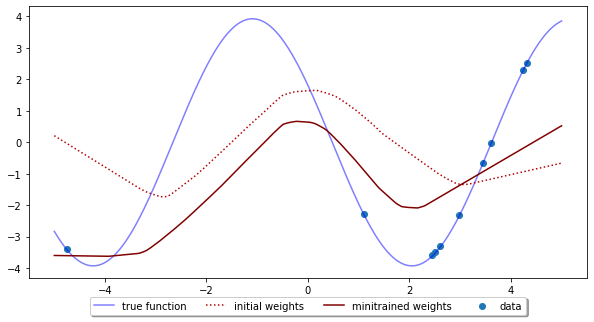

5.248303025960922


In [54]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)


num_iterations = 100
function_tasks = FunctionDistribution(min_amp,max_amp,min_phase,max_phase,min_x,max_x)
global_error = 0
count = 0

for i in range(num_iterations):
    og_net=maml.net.net
    optim=torch.optim.SGD
    lr=0.01
    
    task=function_tasks.sample_task()
    x,y=task.sample_data(K)
    x=x.to(device)
    y=y.to(device)
  
    error = 0
    L = []
    for i in range(len(x.numpy())):
        L.append(int((5+x.numpy()[i][0])*100))
    pred = []
    for i in range(len(x.numpy())):
        pred.append(outputs['minitrained'][L[i]][0])
    y_ = []
    for i in range(len(y.numpy())):
        y_.append(y.numpy()[i][0])
        
    error = (np.linalg.norm(np.array(y_)-np.array(pred)))
    if error < 1000 and error > -1000:
        global_error += error
        count +=1
        
global_error = global_error/count
print(global_error)

In [151]:
print(global_error)
print(global_error/(10**0.5))
print(count)

1.9178907312452793
0.6064903014060944
92


## Plots

[0.6989651918411255, 2.5543694496154785, 0.7773959040641785, 1.3521101474761963, 0.10496071726083755, 0.013912772759795189, 0.0034781538415700197, 0.002779776696115732, 0.0024177771992981434, 0.0021482796873897314]


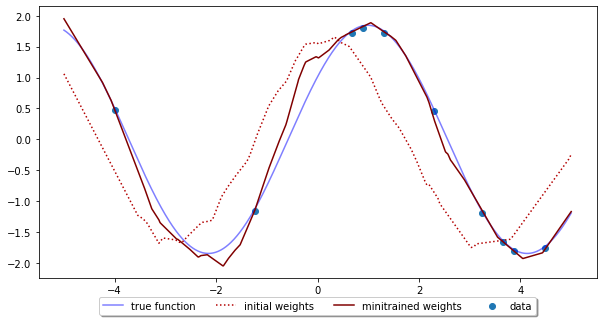

In [86]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

[1.0414388179779053, 3.8586201667785645, 0.3232850134372711, 0.3306262791156769, 1.005326509475708, 3.2523887157440186, 2.821871519088745, 1.6098893880844116, 0.0818093791604042, 0.06350484490394592]


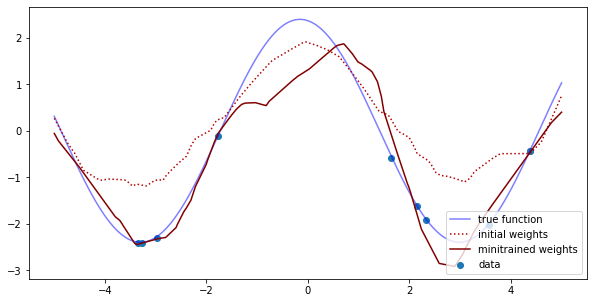

In [96]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

[1.1733028888702393, 1.08505117893219, 0.22311362624168396, 0.19139543175697327, 0.5204752683639526, 2.0038437843322754, 6.688040256500244, 7.449194431304932, 1.6861969232559204, 0.7142587304115295]


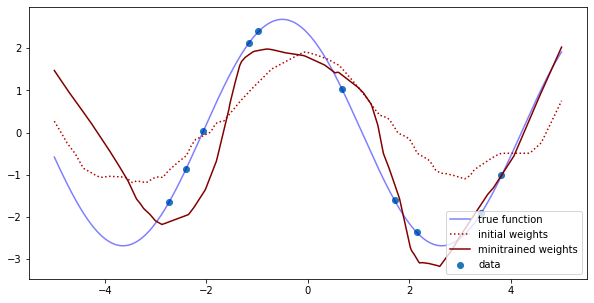

In [88]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

## Gaussian, 50000 epochs, 0.1, 5, 0, np.pi, -5, 5 - marche très mal

De manière générale pour le Gaussien, surtout si la fonction à apprendre est simple (i.e. un des paramètres, variance ou moyenne ne varie pas), maml a de bien meilleurs résultats avec très peu de points pour le few-shots (moins de 10).

In [ ]:
plt.plot(maml.meta_losses)

## Gaussian, 50000 epochs, 0, 2, -1, 1, -5, 5

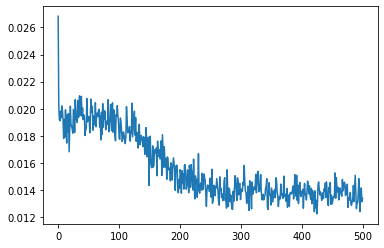

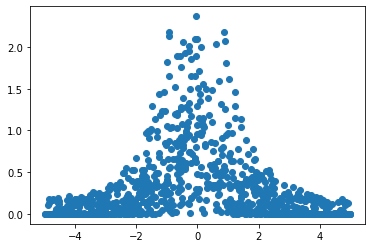

Facilement beaucoup d'overfit

In [ ]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)

In [ ]:
K=10
task=function_tasks.sample_task()
x,y=task.sample_data(K)
x=x.to(device)
y=y.to(device)
plot_test(og_net=maml.net.net,x=x,y=y,task=task)